In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy import signal
from mne.time_frequency import psd_array_multitaper
import optuna
import numpy as np  
import optuna.visualization as vis
from optuna.pruners import MedianPruner
import plotly
from scipy.stats import chisquare
import os

/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [3]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main_regular", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params,Normalizacion):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params

    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f" OMP_NUM_THREADS=2 ./main_regular {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[50:, 1]  
     
    if(Normalizacion=="max_global"):    
        data=data / max(data)
    elif(Normalizacion=="max_global_abs"):
        data=data / max(abs(data))
    elif(Normalizacion=="zscore"):
        data=(data - np.mean(data)) / np.std(data)

    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full',n_jobs=3)
    frequencies=np.array(frequencies)

    welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



In [4]:
def read_all_signals_from_folders(parent_folder):

    all_signals = []
    
    # Iterar sobre las subcarpetas en la carpeta principal
    for folder_name in sorted(os.listdir(parent_folder)):
        folder_path = os.path.join(parent_folder, folder_name)
        if os.path.isdir(folder_path):  # Asegurarse de que es una carpeta
            # Leer señales de la carpeta actual
            signals, _ = read_signals(folder_path)
            all_signals.extend(signals)  # Agregar todas las señales de esta carpeta
    
    # Concatenar todas las señales en un solo array
    all_signals_array = np.concatenate(all_signals)
    
    # Calcular valores globales
    global_min = np.min(all_signals_array)
    global_max = np.max(all_signals_array)
    global_mean = np.mean(all_signals_array)
    global_std = np.std(all_signals_array)
    
    return all_signals_array, global_min, global_max, global_mean, global_std

def read_signals(folder_path):
    signals = []
    file_names = []
    for file_name in sorted(os.listdir(folder_path)):  # Ordenar los archivos por nombre
        if file_name.endswith(".txt"):  # Filtrar solo archivos de texto
            file_path = os.path.join(folder_path, file_name)
            signal = np.loadtxt(file_path)  # Leer los datos del archivo
            signals.append(signal)
            file_names.append(file_name)  # Guardar el nombre del archivo
    return signals, file_names

parent_folder = "Datos_reales"
all_signals_array, global_min, global_max, global_mean, global_std = read_all_signals_from_folders(parent_folder)

# Imprimir resultados
print("Número total de señales:", len(all_signals_array))
print("Mínimo global:", global_min)
print("Máximo global:", global_max)
print("Media global:", global_mean)
print("Desviación estándar global:", global_std)

Número total de señales: 32000
Mínimo global: -7.5019798015625e-05
Máximo global: 3.7541179509375e-05
Media global: -1.8103846518043457e-05
Desviación estándar global: 1.8481663638416723e-05


In [5]:
def Datos_reales(directorio,Normalizacion, global_min, global_max, global_mean, global_std):
    Datos,nombres= read_signals(directorio)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)

    mean_welch=np.zeros(481)
    mean_Delta = np.zeros(2)
    mean_Theta = np.zeros(2)
    mean_Alpha = np.zeros(2)
    mean_Beta = np.zeros(2)

    if(Normalizacion=="max_global"):    
            Datos=Datos/global_max
    elif(Normalizacion=="zscore"):
        Datos=(Datos-global_mean) / global_std
    for i in range(len(Datos)):
        Butter[i]=butter= signal.filtfilt(b, a,Datos[i])
        psd,frequencies = psd_array_multitaper(butter, fs, fmin=0, fmax=120, adaptive=True, normalization='full')
        Frequencies[i]=frequencies=np.array(frequencies)
        welch_data = np.array([10 * np.log10(psd[i]) for i in range(len(frequencies))])
        welch_datos[i]=welch_data
        mean_welch+=welch_data/len(nombres)

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]
        mean_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        mean_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        mean_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        mean_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)
    return {
        "Nombres":nombres,"Zona":directorio,
        'datos': Datos, "frequencies": Frequencies,  "welch_data":welch_datos,"mean_welch":mean_welch,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'mean_Delta': mean_Delta,'mean_Theta':mean_Theta,"mean_Alpha":mean_Alpha,"mean_Beta":mean_Beta
    }


In [6]:
Params={'L': 49, 'P': 0.18480288512056137, 'Inh': 0.3568274238758705, 'Trest': 0.001388460705036468, 'Trelative': 0.1037062403200316, 'C_h': 0.8657675703460452, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8050, Params["Tipo_red"]]
Normalizacion="max_global"###"max_global""max_global_abs" zscore
generated_data = Simulado_EGG(initial_params,Normalizacion)



Zona="F"

reales_total = Datos_reales(f"Datos_reales/{Zona}",Normalizacion, global_min, global_max, global_mean, global_std)

    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


['F3_MNE.txt', 'F4_MNE.txt', 'F7_MNE.txt', 'F8_MNE.txt', 'Fp1_MNE.txt', 'Fp2_MNE.txt', 'Fz_MNE.txt']


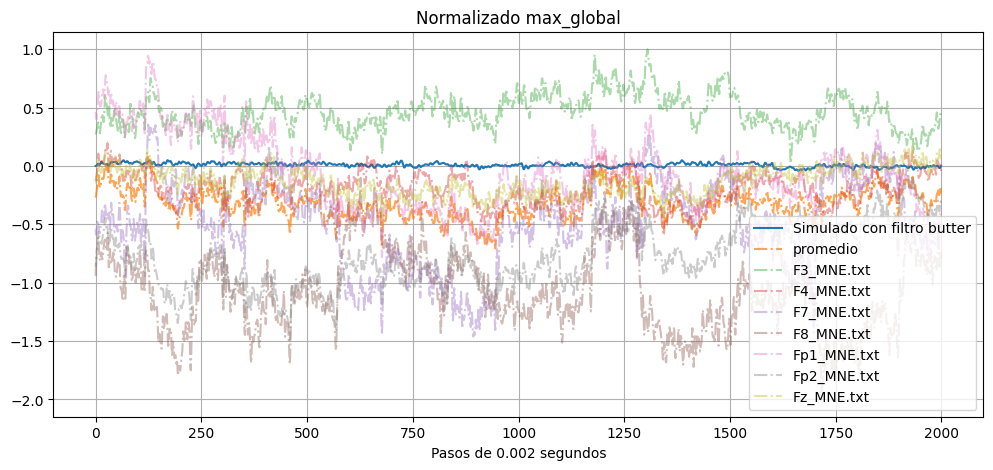

In [7]:
fig, ax = plt.subplots(figsize=[12, 5])


print(reales_total["Nombres"])
#ax.plot(generated_data["data_resample"],label="Simulado")

ax.plot(generated_data["butter"][:],label="Simulado con filtro butter")
grupos = np.array(reales_total["datos"])
promedio = np.mean(grupos, axis=0) 

ax.plot(promedio,"-.", label="promedio",alpha=0.7)

for i in range(len(reales_total["datos"])):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.4)


plt.xlabel("Pasos de 0.002 segundos")
#plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.title(f"Normalizado {Normalizacion}")
plt.show()  # Mostrar todos los gráficos en la misma figura


241
['F3_MNE.txt', 'F4_MNE.txt', 'F7_MNE.txt', 'F8_MNE.txt', 'Fp1_MNE.txt', 'Fp2_MNE.txt', 'Fz_MNE.txt']
Delta [np.float64(-44.18454830659419), np.float64(2.474524536528806)] ---- [-23.12386289   3.12491284]
Theta [np.float64(-50.33229673977979), np.float64(1.5190272314844635)] ---- [-29.67521377   1.79235884]
Alpha [np.float64(-53.22670809333773), np.float64(1.312453578759814)] ---- [-35.24054366   2.07036529]
Beta [np.float64(-58.600704375446696), np.float64(1.3442520830242062)] ---- [-40.46253791   1.96464269]


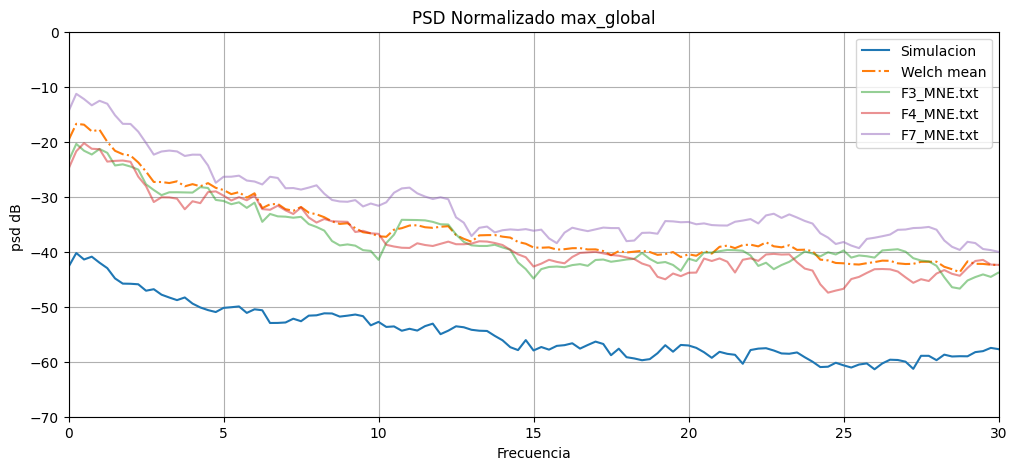

In [8]:
fig, ax = plt.subplots(figsize=[12, 5])
#print(generated_data["frequencies"])
frequencies = reales_total["frequencies"][0]
count_in_range = np.sum((frequencies >= 0) & (frequencies <= 60))
print(count_in_range)
print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["mean_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["mean_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["mean_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["mean_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
ax.plot(reales_total["frequencies"][0],reales_total["mean_welch"],label="Welch mean",linestyle="-.")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i],alpha=0.5)

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.grid()
plt.xlim(0,30)
plt.ylim(-70,0)
plt.title(f"PSD Normalizado {Normalizacion}")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [9]:
Tipo_de_red="R"

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',10,20)
    params[1] = trial.suggest_float('P', 0.0, 0.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0,5.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L10"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=500)


[I 2024-11-20 08:58:06,387] Using an existing study with name 'Chi30_R_max_global_L10' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:07,781] Trial 500 finished with value: 512.5994345857231 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4862676022021237, 'Trest': 0.27706766730227467, 'Trelative': 0.7215232073635671, 'C_h': 0.38974121769710574, 'Tipo_red': 0}. Best is trial 500 with value: 512.5994345857231.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:08,954] Trial 501 finished with value: 712.3938575169345 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.47826937751577814, 'Trest': 0.28382306185377026, 'Trelative': 0.47242546714321126, 'C_h': 0.9673956951880299, 'Tipo_red': 0}. Best is trial 500 with value: 512.5994345857231.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:09,515] Trial 502 finished with value: 424.5951815807012 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.48477873295288976, 'Trest': 0.753598200663473, 'Trelative': 0.8446103626574795, 'C_h': 0.3972561619649322, 'Tipo_red': 0}. Best is trial 502 with value: 424.5951815807012.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:10,056] Trial 503 finished with value: 516.1993908347989 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4741083546066006, 'Trest': 0.7493267634778034, 'Trelative': 0.9881134106309697, 'C_h': 0.39049034644921515, 'Tipo_red': 0}. Best is trial 502 with value: 424.5951815807012.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:10,521] Trial 504 finished with value: 586.2451959542307 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4736267726756518, 'Trest': 0.7525996312776139, 'Trelative': 0.7655671122575878, 'C_h': 0.38453130950637215, 'Tipo_red': 0}. Best is trial 502 with value: 424.5951815807012.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:11,031] Trial 505 finished with value: 424.5951815807012 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.48593500033362147, 'Trest': 0.746882303462048, 'Trelative': 0.8509046407825709, 'C_h': 0.39131326655900317, 'Tipo_red': 0}. Best is trial 502 with value: 424.5951815807012.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:11,577] Trial 506 finished with value: 3312.2264994838715 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4895775909687628, 'Trest': 0.7593193176269561, 'Trelative': 1.0553039772560473, 'C_h': 0.3614273869543042, 'Tipo_red': 0}. Best is trial 502 with value: 424.5951815807012.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:12,022] Trial 507 finished with value: 937.779486154708 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.47394984864170925, 'Trest': 0.7416787303332815, 'Trelative': 0.7643337038069559, 'C_h': 0.9640238713179137, 'Tipo_red': 0}. Best is trial 502 with value: 424.5951815807012.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:12,551] Trial 508 finished with value: 403.4330481869045 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.48537158996659197, 'Trest': 0.7506641731560407, 'Trelative': 0.8358586412791036, 'C_h': 0.9624806399842109, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:12,968] Trial 509 finished with value: 515.7012229294911 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4819092291197102, 'Trest': 0.7216474447867482, 'Trelative': 0.847569038368862, 'C_h': 0.9701040422222655, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:13,504] Trial 510 finished with value: 712.3938575169345 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4767187242506457, 'Trest': 0.7628983888739722, 'Trelative': 0.8384722121778629, 'C_h': 0.9617790685695676, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:14,191] Trial 511 finished with value: 458.1422548026448 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.48450169209955063, 'Trest': 0.733916790294812, 'Trelative': 0.9071383829873407, 'C_h': 0.9688709850833555, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:14,708] Trial 512 finished with value: 515.7012229294911 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4807834377634685, 'Trest': 0.734217640924862, 'Trelative': 0.8334483553982062, 'C_h': 0.9599231678834447, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:15,185] Trial 513 finished with value: 712.3938575169345 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4765849848842536, 'Trest': 0.7303414397611658, 'Trelative': 0.8799433225886408, 'C_h': 0.964923986762635, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:15,633] Trial 514 finished with value: 515.7012229294911 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.48126062503645, 'Trest': 0.7307783965492757, 'Trelative': 0.8045239671416985, 'C_h': 0.957176445951682, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:16,105] Trial 515 finished with value: 712.3938575169345 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4763264036681117, 'Trest': 0.7378944937775244, 'Trelative': 0.8481982098752322, 'C_h': 0.9549849272662931, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:16,643] Trial 516 finished with value: 556.0692824024899 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4718544434609958, 'Trest': 0.7360684103086887, 'Trelative': 0.8537664164542882, 'C_h': 0.9546015815192589, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:17,103] Trial 517 finished with value: 491.64191825257706 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.47865360729032547, 'Trest': 0.6996763869053507, 'Trelative': 0.8096549279462838, 'C_h': 0.9638000782013977, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:17,588] Trial 518 finished with value: 491.64191825257706 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.47864679913955144, 'Trest': 0.7235530558913289, 'Trelative': 0.9368986549655924, 'C_h': 0.9634917796880549, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:18,084] Trial 519 finished with value: 491.64191825257706 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4786527377491593, 'Trest': 0.7374442461202988, 'Trelative': 0.8323808247506456, 'C_h': 0.9652015619187801, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:18,605] Trial 520 finished with value: 491.64191825257706 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4792744019173847, 'Trest': 0.7342996248676341, 'Trelative': 0.8200389846812324, 'C_h': 0.9648521682711098, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:19,333] Trial 521 finished with value: 488.3676970210199 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4824937026463382, 'Trest': 0.7022819763761512, 'Trelative': 0.8327799499496368, 'C_h': 0.9619365719619336, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:19,847] Trial 522 finished with value: 628.6572536768464 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4895472288681707, 'Trest': 0.7020710191746765, 'Trelative': 0.8287374299652662, 'C_h': 0.9639464223917075, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:20,344] Trial 523 finished with value: 661.2668405932495 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4914785787556339, 'Trest': 0.6769300876624436, 'Trelative': 0.8045921569121648, 'C_h': 0.9644885937651982, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:20,784] Trial 524 finished with value: 661.2668405932495 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.49059995293184044, 'Trest': 0.7036910251459442, 'Trelative': 0.826222357092043, 'C_h': 0.9676440776579501, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:21,361] Trial 525 finished with value: 661.2668405932495 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4918818119008861, 'Trest': 0.6803651654874499, 'Trelative': 0.8145124530379235, 'C_h': 0.962138984589727, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:21,890] Trial 526 finished with value: 618.059865210894 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4968860117444049, 'Trest': 0.6005276547790839, 'Trelative': 0.7128827278176497, 'C_h': 0.9654054874036921, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:22,385] Trial 527 finished with value: 618.059865210894 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4963197362727232, 'Trest': 0.5871475778447597, 'Trelative': 0.6823020759522107, 'C_h': 0.9682369002437243, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:22,863] Trial 528 finished with value: 618.059865210894 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.49693417163659864, 'Trest': 0.6204839868412695, 'Trelative': 0.6857638246745444, 'C_h': 0.9636398138927365, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:23,428] Trial 529 finished with value: 1738.340191284244 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4959589673159923, 'Trest': 0.6004004073853293, 'Trelative': 1.0294563881305094, 'C_h': 0.9414425345668128, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:23,889] Trial 530 finished with value: 722.7177558184144 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4994311444984548, 'Trest': 0.6448206776087794, 'Trelative': 0.77640098904801, 'C_h': 0.9674199001365708, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:24,533] Trial 531 finished with value: 618.059865210894 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4941147448014688, 'Trest': 0.5513986922539791, 'Trelative': 0.7121491112882004, 'C_h': 0.9538700086091307, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:25,061] Trial 532 finished with value: 722.7177558184144 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4986517044502514, 'Trest': 0.5303941439168228, 'Trelative': 0.6614923705230988, 'C_h': 0.9190429531898109, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:25,600] Trial 533 finished with value: 3443.2246534118913 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.46381247677054277, 'Trest': 0.6025798021082149, 'Trelative': 1.0317230041019594, 'C_h': 0.9433001800837031, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:26,007] Trial 534 finished with value: 661.2668405932495 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4915836472475475, 'Trest': 0.5699038123946706, 'Trelative': 0.6971207096061041, 'C_h': 0.9719778344199959, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:26,477] Trial 535 finished with value: 1174.5734939878623 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.504277887426943, 'Trest': 0.6768642052566949, 'Trelative': 1.1719281676328568, 'C_h': 0.9151903127556955, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:26,981] Trial 536 finished with value: 1697.8247494678956 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.47165107058799, 'Trest': 0.7875353956815176, 'Trelative': 1.0647043997475507, 'C_h': 0.9464514598545651, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:27,458] Trial 537 finished with value: 618.059865210894 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4958137591156844, 'Trest': 0.6871902727454691, 'Trelative': 0.9704786700105481, 'C_h': 0.9739428606986767, 'Tipo_red': 0}. Best is trial 508 with value: 403.4330481869045.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:27,934] Trial 538 finished with value: 93.6804001213727 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5209805435988426, 'Trest': 0.4697717087424339, 'Trelative': 0.6079314475870918, 'C_h': 0.932044836633771, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:28,329] Trial 539 finished with value: 93.6804001213727 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5219182719954374, 'Trest': 0.4492426167780047, 'Trelative': 0.5872719708910416, 'C_h': 0.9376766053750125, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:28,812] Trial 540 finished with value: 112.91083808716817 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5238885406487246, 'Trest': 0.4718872989374906, 'Trelative': 0.56395103094781, 'C_h': 0.928980386788664, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:29,382] Trial 541 finished with value: 112.91083808716817 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5240265070550807, 'Trest': 0.4522880222213794, 'Trelative': 0.6025869146808018, 'C_h': 0.9300589719595667, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:29,886] Trial 542 finished with value: 112.91083808716817 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.523418698580901, 'Trest': 0.4487064050435977, 'Trelative': 0.5845415594846723, 'C_h': 0.9075448651395923, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:30,417] Trial 543 finished with value: 212.64361041553656 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5271258916797501, 'Trest': 0.4614767789557678, 'Trelative': 0.5807311180507053, 'C_h': 0.9181850625402278, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:30,865] Trial 544 finished with value: 93.6804001213727 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5216779494715729, 'Trest': 0.42937516945631965, 'Trelative': 0.5396347898944563, 'C_h': 0.9271908994004296, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:31,260] Trial 545 finished with value: 133.2967227179297 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5137320642332694, 'Trest': 0.4492597221332398, 'Trelative': 0.5624083599299984, 'C_h': 0.9088543234920576, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:31,810] Trial 546 finished with value: 193.58756809922664 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.531528113458917, 'Trest': 0.450788801196628, 'Trelative': 0.5274477131302991, 'C_h': 0.911940367238807, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:32,368] Trial 547 finished with value: 188.64787469826578 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5245553756873466, 'Trest': 0.4373478949176948, 'Trelative': 0.480923008190857, 'C_h': 0.9127443107406007, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:32,871] Trial 548 finished with value: 169.9694529461342 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5260438963035592, 'Trest': 0.4084583641326625, 'Trelative': 0.41825672544867587, 'C_h': 0.9050505648582557, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:33,364] Trial 549 finished with value: 246.198231040311 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5323371982476565, 'Trest': 0.43154094090726897, 'Trelative': 0.44795205094545093, 'C_h': 0.9015960002221175, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:33,782] Trial 550 finished with value: 212.64361041553656 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5287666999240271, 'Trest': 0.43922439437318866, 'Trelative': 0.4780691597825118, 'C_h': 0.9176617692783877, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:34,177] Trial 551 finished with value: 191.88227884705117 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5335100025722703, 'Trest': 0.4303152140039601, 'Trelative': 0.4581355226078662, 'C_h': 0.9023411014043922, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:34,627] Trial 552 finished with value: 212.64361041553656 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5279762681011916, 'Trest': 0.368914264457355, 'Trelative': 0.4303045247912994, 'C_h': 0.9005916277096268, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:35,079] Trial 553 finished with value: 246.198231040311 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5319934862430277, 'Trest': 0.43796816016387674, 'Trelative': 0.4730758461850927, 'C_h': 0.9057079197322621, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:35,504] Trial 554 finished with value: 212.64361041553656 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5288780076312051, 'Trest': 0.4378447042171615, 'Trelative': 0.4476361346665251, 'C_h': 0.9060736855143569, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:35,952] Trial 555 finished with value: 442.8881100506386 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5350291006777224, 'Trest': 0.39586299087201854, 'Trelative': 0.5259740979587059, 'C_h': 0.9026598754218692, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:36,401] Trial 556 finished with value: 212.64361041553656 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5287219503307066, 'Trest': 0.43268673681639885, 'Trelative': 0.4736251811092387, 'C_h': 0.9006742092436544, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:36,895] Trial 557 finished with value: 212.64361041553656 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5305867451671996, 'Trest': 0.40386840200805074, 'Trelative': 0.4199075463188043, 'C_h': 0.9021189480426759, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:37,309] Trial 558 finished with value: 212.64361041553656 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5303452757266145, 'Trest': 0.4267509021101873, 'Trelative': 0.4276665957247166, 'C_h': 0.8992737928169304, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:37,722] Trial 559 finished with value: 246.198231040311 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5318473465215539, 'Trest': 0.4466196637390345, 'Trelative': 0.4580650983007549, 'C_h': 0.9120145907145447, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:38,177] Trial 560 finished with value: 212.64361041553656 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5297819064013641, 'Trest': 0.43406393418190414, 'Trelative': 0.4603791987367157, 'C_h': 0.9031001304147348, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:38,596] Trial 561 finished with value: 133.60674802921918 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5269234175236793, 'Trest': 0.4639830449785444, 'Trelative': 0.5041292652970653, 'C_h': 0.905053411541753, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:39,044] Trial 562 finished with value: 246.198231040311 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5320900607466369, 'Trest': 0.4444189215830934, 'Trelative': 0.46451619057902976, 'C_h': 0.9049956337955504, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:39,560] Trial 563 finished with value: 212.64361041553656 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5275896687905989, 'Trest': 0.4639460225783677, 'Trelative': 0.4664982966872079, 'C_h': 0.906235720541693, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:40,015] Trial 564 finished with value: 133.60674802921918 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.526815911862039, 'Trest': 0.4649502597636391, 'Trelative': 0.4661311246736948, 'C_h': 0.9098487974295648, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:40,459] Trial 565 finished with value: 225.7010856984616 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5486018276342246, 'Trest': 0.440225099465072, 'Trelative': 0.45193809124437456, 'C_h': 0.9033312639796639, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:41,056] Trial 566 finished with value: 177.78809441474974 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5511620496964371, 'Trest': 0.3448976833658962, 'Trelative': 0.4082896771720455, 'C_h': 0.9008985499998484, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:41,512] Trial 567 finished with value: 172.603339842405 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5524485311582945, 'Trest': 0.3225618437261428, 'Trelative': 0.34264746490512865, 'C_h': 0.8993651258917059, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:41,957] Trial 568 finished with value: 165.2506768973874 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5547802984362246, 'Trest': 0.34795260784967197, 'Trelative': 0.3561097432191601, 'C_h': 0.9145252471483609, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:42,425] Trial 569 finished with value: 172.603339842405 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5533577387283455, 'Trest': 0.3246723743724705, 'Trelative': 0.3331693371929994, 'C_h': 0.9240691942948875, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:42,868] Trial 570 finished with value: 254.4549640477677 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5571861921701025, 'Trest': 0.3196745325375761, 'Trelative': 0.3968789040768707, 'C_h': 0.9244746811700687, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:43,347] Trial 571 finished with value: 254.4549640477677 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5568336720195083, 'Trest': 0.328860392767341, 'Trelative': 0.34482113341691156, 'C_h': 0.8867419827334384, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:43,898] Trial 572 finished with value: 172.603339842405 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.552675972409126, 'Trest': 0.30053073648109185, 'Trelative': 0.3291899963409233, 'C_h': 0.9229146210527579, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:44,335] Trial 573 finished with value: 184.13765493619096 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5444601871480056, 'Trest': 0.29725681022798156, 'Trelative': 0.5826855094753332, 'C_h': 0.9238586696688187, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:44,762] Trial 574 finished with value: 254.4549640477677 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5559624209820132, 'Trest': 0.2949659754914547, 'Trelative': 0.3106247792549682, 'C_h': 0.9195171606058984, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:45,248] Trial 575 finished with value: 172.603339842405 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5522879653320545, 'Trest': 0.3095865545947209, 'Trelative': 0.579149060312602, 'C_h': 0.9260199596567935, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:45,686] Trial 576 finished with value: 172.603339842405 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5533364616765329, 'Trest': 0.2812116349706816, 'Trelative': 0.2887836490978227, 'C_h': 0.9268187809181487, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:46,152] Trial 577 finished with value: 165.2506768973874 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5545854112663939, 'Trest': 0.27628370192303653, 'Trelative': 0.3188011853865059, 'C_h': 0.9275894046503568, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:46,613] Trial 578 finished with value: 172.603339842405 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.553526835533527, 'Trest': 0.28442262047505, 'Trelative': 0.3039919069937126, 'C_h': 0.9273061800033601, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:47,140] Trial 579 finished with value: 254.4549640477677 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5558775174206353, 'Trest': 0.2650402209775315, 'Trelative': 0.2684864781839373, 'C_h': 0.930940219624488, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:47,591] Trial 580 finished with value: 192.69735634104163 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5645765993964349, 'Trest': 0.2835050396395007, 'Trelative': 0.5770240215402718, 'C_h': 0.9282589347067413, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:48,056] Trial 581 finished with value: 271.8410055009555 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5636075847527602, 'Trest': 0.275085681514129, 'Trelative': 0.5897351575914065, 'C_h': 0.9307552722238862, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:48,652] Trial 582 finished with value: 267.977850708573 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5704223234267628, 'Trest': 0.27430567546910944, 'Trelative': 0.3222631256626869, 'C_h': 0.9342486599360966, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:49,073] Trial 583 finished with value: 184.13765493619096 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5473886563227777, 'Trest': 0.3229211543438731, 'Trelative': 0.593428980075619, 'C_h': 0.9326703096325221, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:49,503] Trial 584 finished with value: 177.78809441474974 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.551221017053525, 'Trest': 0.3105096961381311, 'Trelative': 0.577355882701792, 'C_h': 0.8789787615855494, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:50,028] Trial 585 finished with value: 165.2506768973874 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5541188209727588, 'Trest': 0.2679705952895699, 'Trelative': 0.3104853092876177, 'C_h': 0.8809326302145564, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:50,468] Trial 586 finished with value: 239.5716331560335 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5529644357872164, 'Trest': 0.22112066259842755, 'Trelative': 0.3033152199069578, 'C_h': 0.8836354813321314, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:51,167] Trial 587 finished with value: 225.7010856984616 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5495653900217063, 'Trest': 0.3302184301083971, 'Trelative': 0.625473312542298, 'C_h': 0.8815787317513567, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:51,785] Trial 588 finished with value: 2890.059397688538 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5758987168488311, 'Trest': 0.03699708300852078, 'Trelative': 0.04064614250948173, 'C_h': 0.931538776182488, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:52,206] Trial 589 finished with value: 184.13765493619096 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5443043283339396, 'Trest': 0.3351084918072786, 'Trelative': 0.6138316564654414, 'C_h': 0.8769333069608742, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:52,617] Trial 590 finished with value: 247.3607068019522 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5537973539748043, 'Trest': 0.22509307331858752, 'Trelative': 0.2420285876755478, 'C_h': 0.8731854038571559, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:53,056] Trial 591 finished with value: 217.56299392982456 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5761298591278405, 'Trest': 0.329342438435076, 'Trelative': 0.6018942017814256, 'C_h': 0.9292977996593585, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:53,597] Trial 592 finished with value: 133.2967227179297 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5131813490753687, 'Trest': 0.1829128699462647, 'Trelative': 0.18401714116836734, 'C_h': 0.9242920521184057, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:54,081] Trial 593 finished with value: 206.01810010032835 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5566298667934373, 'Trest': 0.13885661676917582, 'Trelative': 0.18502284515181772, 'C_h': 0.8836306586998123, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:54,550] Trial 594 finished with value: 133.2967227179297 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.513649758472886, 'Trest': 0.2099508649288978, 'Trelative': 0.22516388859859088, 'C_h': 0.9279206700437312, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:55,009] Trial 595 finished with value: 191.6761024893462 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5122113955450966, 'Trest': 0.21515951965488947, 'Trelative': 0.2549682547967955, 'C_h': 0.9321250014408056, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:55,483] Trial 596 finished with value: 323.26394669713113 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5117614989975913, 'Trest': 0.10300570965953079, 'Trelative': 0.12284654030004985, 'C_h': 0.9367754904637363, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:55,953] Trial 597 finished with value: 174.77055543237145 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5695888212945294, 'Trest': 0.23767054085011236, 'Trelative': 0.2872559012898311, 'C_h': 0.923279312207554, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:56,565] Trial 598 finished with value: 267.88565120571934 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5781551199563976, 'Trest': 0.1952300359830837, 'Trelative': 0.28398167947547215, 'C_h': 0.9203000865287833, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:58:57,015] Trial 599 finished with value: 5885.814335042619 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5149936553551175, 'Trest': 0.08247174349968289, 'Trelative': 0.08921597499900813, 'C_h': 0.8849043442760075, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:57,494] Trial 600 finished with value: 370.2456936880755 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5705944225894428, 'Trest': 0.0071787397481952175, 'Trelative': 0.12546805978500436, 'C_h': 0.9219177514543915, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:58,008] Trial 601 finished with value: 225.7010856984616 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5491661512022852, 'Trest': 0.2511829965637725, 'Trelative': 0.6032966916642685, 'C_h': 0.9392688886692333, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:58,538] Trial 602 finished with value: 185.66287265937834 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5937560842935075, 'Trest': 0.3315541305777685, 'Trelative': 0.5642516832916792, 'C_h': 0.8509399348532403, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:59,050] Trial 603 finished with value: 255.7016385879676 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5682860073979261, 'Trest': 0.1691405839718404, 'Trelative': 0.29654766631768126, 'C_h': 0.8901830871212996, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:58:59,566] Trial 604 finished with value: 133.2967227179297 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5128572162617302, 'Trest': 0.2611246851957224, 'Trelative': 0.6059672238062197, 'C_h': 0.9190035891296833, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:00,262] Trial 605 finished with value: 157.37438475927627 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5161403123244198, 'Trest': 0.20107252598493716, 'Trelative': 0.28440803642845425, 'C_h': 0.8937676647584374, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:00,850] Trial 606 finished with value: 133.2967227179297 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5144171441911357, 'Trest': 0.15339201111855102, 'Trelative': 0.2708032544817023, 'C_h': 0.9410949920089707, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:01,378] Trial 607 finished with value: 103.22055146836631 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5156243006625664, 'Trest': 0.13132111610984148, 'Trelative': 0.23470187632539669, 'C_h': 0.9394068966778278, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:01,912] Trial 608 finished with value: 133.45922740497855 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5118858477173015, 'Trest': 0.11503815257174699, 'Trelative': 0.18166080136935772, 'C_h': 0.9416907360309876, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:02,410] Trial 609 finished with value: 220.38885682679518 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5135583867331831, 'Trest': 0.06299186044124441, 'Trelative': 0.14482248711043655, 'C_h': 0.9396445622031943, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:02,904] Trial 610 finished with value: 191.6761024893462 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.512255405023357, 'Trest': 0.12471440073116877, 'Trelative': 0.21750129761750087, 'C_h': 0.9431886711582452, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:03,477] Trial 611 finished with value: 123.2878987058517 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5128537424134226, 'Trest': 0.036993110483361846, 'Trelative': 0.0647707641335416, 'C_h': 0.9414046456914298, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:04,143] Trial 612 finished with value: 255.71159159871345 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5102267392018566, 'Trest': 0.10199695577139542, 'Trelative': 0.10832713107237224, 'C_h': 0.9409615950365395, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:04,717] Trial 613 finished with value: 165.17924885912615 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.522739448424877, 'Trest': 0.16234721065479657, 'Trelative': 0.3264795199759605, 'C_h': 0.9117664268647758, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:05,241] Trial 614 finished with value: 5885.814335042619 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5147040101809167, 'Trest': 0.045044341816982525, 'Trelative': 0.06587067787200582, 'C_h': 0.8958437705449209, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:05,966] Trial 615 finished with value: 123.2878987058517 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5134825098363301, 'Trest': 0.010195299011916903, 'Trelative': 0.10069894153845402, 'C_h': 0.9099874771336023, 'Tipo_red': 0}. Best is trial 538 with value: 93.6804001213727.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:06,739] Trial 616 finished with value: 52.97899194548173 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5078752153986908, 'Trest': 0.1465382208463561, 'Trelative': 0.28498517820748476, 'C_h': 0.860061150875547, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:07,403] Trial 617 finished with value: 8636.192100656213 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5101104823968725, 'Trest': 0.039367090037877306, 'Trelative': 0.08982619181155455, 'C_h': 0.8568788372248444, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:08,100] Trial 618 finished with value: 8636.192100656213 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5103259614535508, 'Trest': 0.02556891573470657, 'Trelative': 0.03531552556520828, 'C_h': 0.8703417112772562, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:08,813] Trial 619 finished with value: 206.06864206444814 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5105488425484245, 'Trest': 0.15491359467998153, 'Trelative': 0.3201888242585175, 'C_h': 0.890740848606351, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:09,295] Trial 620 finished with value: 3277.7054346025507 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5162061225837994, 'Trest': 0.0039012969371232187, 'Trelative': 0.05379764331942255, 'C_h': 0.9035619699245612, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:09,871] Trial 621 finished with value: 220.38885682679518 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5147039809018581, 'Trest': 0.16029166183845833, 'Trelative': 0.31740236821681633, 'C_h': 0.9093016782069325, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:10,699] Trial 622 finished with value: 133.2967227179297 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5133399203220746, 'Trest': 0.15419513362407156, 'Trelative': 0.3126455743676402, 'C_h': 0.9425636969577764, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:11,199] Trial 623 finished with value: 133.2967227179297 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5137995669383816, 'Trest': 0.1575635040206707, 'Trelative': 0.3119020613036074, 'C_h': 0.9436737425121043, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:11,744] Trial 624 finished with value: 103.22055146836631 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5155110807686473, 'Trest': 0.11666727269725435, 'Trelative': 0.2978021397019945, 'C_h': 0.9464330733175104, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:12,232] Trial 625 finished with value: 232.87245187495006 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5101623529252551, 'Trest': 0.14599100814382152, 'Trelative': 0.2957386407099384, 'C_h': 0.944870534869335, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:12,758] Trial 626 finished with value: 219.68982142837154 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5091568822778976, 'Trest': 0.016359851573612014, 'Trelative': 0.11406693547695856, 'C_h': 0.9492573042741055, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:13,409] Trial 627 finished with value: 170.06791034521575 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5085328640523813, 'Trest': 0.11198701672177414, 'Trelative': 0.21623517868882264, 'C_h': 0.9464267105476449, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:13,921] Trial 628 finished with value: 133.2967227179297 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5139983241051695, 'Trest': 0.18354035608742528, 'Trelative': 0.6546089024359795, 'C_h': 0.9440053755639095, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:14,478] Trial 629 finished with value: 93.6804001213727 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5209534401901398, 'Trest': 0.12976173862241128, 'Trelative': 0.6320965603110562, 'C_h': 0.9472051106214671, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:15,064] Trial 630 finished with value: 222.3488215618388 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5187738508152533, 'Trest': 0.1377060669793418, 'Trelative': 0.598751287412593, 'C_h': 0.9389214994747017, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:15,574] Trial 631 finished with value: 8636.192100656213 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5102837569076726, 'Trest': 0.019849285870612965, 'Trelative': 0.037411732890965554, 'C_h': 0.947307025606532, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:16,127] Trial 632 finished with value: 172.66508824623784 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5032627919189052, 'Trest': 0.15801631797019647, 'Trelative': 0.6003794281271092, 'C_h': 0.945335153596349, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:16,618] Trial 633 finished with value: 112.91083808716817 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.524174961334206, 'Trest': 0.16888958688625338, 'Trelative': 0.6256963478251942, 'C_h': 0.9391578189586814, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:17,294] Trial 634 finished with value: 1812.230696840548 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5276423525277325, 'Trest': 0.10316927661681766, 'Trelative': 1.1569953621676907, 'C_h': 0.9503123794051723, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:17,854] Trial 635 finished with value: 2873.6828263773177 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5042199380720664, 'Trest': 0.007053611066028087, 'Trelative': 0.017937166497215218, 'C_h': 0.941940695520533, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:18,463] Trial 636 finished with value: 212.64361041553656 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5301714313108237, 'Trest': 0.18219273243841916, 'Trelative': 0.6406547084064691, 'C_h': 0.9834192904096465, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:18,970] Trial 637 finished with value: 445.88849366825696 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5027505198997939, 'Trest': 0.1885626851345456, 'Trelative': 0.6352189947552048, 'C_h': 0.945391751573778, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:19,474] Trial 638 finished with value: 361.99576570527506 and parameters: {'L': 15, 'P': 0.0, 'Inh': 0.529043098829866, 'Trest': 0.004976666042624769, 'Trelative': 0.12545412432702083, 'C_h': 0.9177532324605229, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:20,063] Trial 639 finished with value: 52.97899194548173 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5076963988969644, 'Trest': 0.11127219081343263, 'Trelative': 0.6231978257540783, 'C_h': 0.9430367399415529, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:20,632] Trial 640 finished with value: 1042.8966115996118 and parameters: {'L': 15, 'P': 0.0, 'Inh': 0.5005957972867722, 'Trest': 0.10275668572359775, 'Trelative': 1.0727712725472793, 'C_h': 0.9420628795578112, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:21,199] Trial 641 finished with value: 212.64361041553656 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5304734643352116, 'Trest': 0.11649856588241098, 'Trelative': 0.6795830197196561, 'C_h': 0.9810345704510008, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:21,706] Trial 642 finished with value: 445.88849366825696 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5020743797563386, 'Trest': 0.20547192520299712, 'Trelative': 0.5727949072354326, 'C_h': 0.9450921219385128, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:22,210] Trial 643 finished with value: 247.97662236898066 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5329369774037935, 'Trest': 0.0825045568468146, 'Trelative': 0.23738951183772783, 'C_h': 0.9221301245518562, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:22,791] Trial 644 finished with value: 599.9605953122892 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5025976254689724, 'Trest': 0.519098037292842, 'Trelative': 1.0383132623163314, 'C_h': 0.9378817618125694, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:23,400] Trial 645 finished with value: 1487.8737996559557 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.45871752320761267, 'Trest': 0.21581903417711806, 'Trelative': 0.5453771344027214, 'C_h': 0.9451463202192825, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:23,888] Trial 646 finished with value: 194.2943433556845 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.535143018165163, 'Trest': 0.0060240163645838285, 'Trelative': 0.12879519091968067, 'C_h': 0.9208709761705115, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:24,367] Trial 647 finished with value: 195.8907564391695 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5180416252442182, 'Trest': 0.093135061398117, 'Trelative': 0.4460232372307576, 'C_h': 0.9817582880508647, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:24,856] Trial 648 finished with value: 328.13940028309486 and parameters: {'L': 15, 'P': 0.0, 'Inh': 0.5003426680542311, 'Trest': 0.1853596165399999, 'Trelative': 0.6293432675457025, 'C_h': 0.9479066081242299, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:25,306] Trial 649 finished with value: 454.08497763123614 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5341706896764885, 'Trest': 0.002640703065465322, 'Trelative': 0.10127204670713885, 'C_h': 0.9148633581005818, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:25,783] Trial 650 finished with value: 618.059865210894 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.497609922890603, 'Trest': 0.1972750968591544, 'Trelative': 0.5034058345053589, 'C_h': 0.9329895667277401, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:26,275] Trial 651 finished with value: 1487.8737996559557 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4617348414356097, 'Trest': 0.5357498517843747, 'Trelative': 0.9824312410797515, 'C_h': 0.9989799428919214, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:26,840] Trial 652 finished with value: 101.3490873375242 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5190959304107503, 'Trest': 0.12028964915235223, 'Trelative': 0.3816971676159493, 'C_h': 0.9170501978127407, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:27,334] Trial 653 finished with value: 191.6761024893462 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5116126758433266, 'Trest': 0.11614726072343523, 'Trelative': 0.3151547938015368, 'C_h': 0.9504336891399809, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:27,791] Trial 654 finished with value: 380.6574555068465 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5377928192407444, 'Trest': 0.22423295966901402, 'Trelative': 0.6853263657591566, 'C_h': 0.9807948060554739, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:28,282] Trial 655 finished with value: 2711.436295972659 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.4991963655658553, 'Trest': 0.08463412145092547, 'Trelative': 1.3662292825119258, 'C_h': 0.9216731976347573, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:28,744] Trial 656 finished with value: 195.8907564391695 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5178917193888865, 'Trest': 0.21085229232218158, 'Trelative': 0.6717323402063979, 'C_h': 0.9475856325937178, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:29,282] Trial 657 finished with value: 535.0883697008679 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4618177895557467, 'Trest': 0.09722797732078939, 'Trelative': 0.28751304695365626, 'C_h': 0.934651548449304, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:29,747] Trial 658 finished with value: 618.059865210894 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4968938201229697, 'Trest': 0.22065381602779327, 'Trelative': 0.556845605539401, 'C_h': 0.9143258825386779, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:30,222] Trial 659 finished with value: 4269.791346980048 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5379774582557773, 'Trest': 0.004544435537441425, 'Trelative': 0.01598208672693116, 'C_h': 0.8898585259833925, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:30,755] Trial 660 finished with value: 290.5667775691779 and parameters: {'L': 15, 'P': 0.0, 'Inh': 0.5203600723770131, 'Trest': 0.11805674679892861, 'Trelative': 0.3848000681075159, 'C_h': 0.9552600802080761, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:31,159] Trial 661 finished with value: 618.059865210894 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4965078115366599, 'Trest': 0.22564105876813736, 'Trelative': 0.6530487125349417, 'C_h': 0.9321100856585934, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:31,609] Trial 662 finished with value: 380.6574555068465 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5376878153916924, 'Trest': 0.11069512238670902, 'Trelative': 0.42403692898532586, 'C_h': 0.9794088050423683, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:32,059] Trial 663 finished with value: 103.22055146836631 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5158349952536455, 'Trest': 0.2299688723918152, 'Trelative': 0.700707178565306, 'C_h': 0.9161862995873272, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:32,577] Trial 664 finished with value: 1112.468207975371 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4984443207843762, 'Trest': 0.2186083961541984, 'Trelative': 1.2051708743172216, 'C_h': 0.9523045844300175, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:33,037] Trial 665 finished with value: 1298.8986506103843 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.46063488435295474, 'Trest': 0.10679934087331777, 'Trelative': 0.30447379250407425, 'C_h': 0.9276620248709025, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:33,498] Trial 666 finished with value: 195.8907564391695 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5181096678946234, 'Trest': 0.2473647358782822, 'Trelative': 0.7072161109923767, 'C_h': 0.9546493154500145, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:33,966] Trial 667 finished with value: 133.2967227179297 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.515175497526167, 'Trest': 0.1406969532527613, 'Trelative': 0.44160210385896315, 'C_h': 0.9787344950633878, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:34,468] Trial 668 finished with value: 240.90998231998154 and parameters: {'L': 15, 'P': 0.0, 'Inh': 0.5397344003801654, 'Trest': 0.00431132100832482, 'Trelative': 0.0448068386576842, 'C_h': 0.9816593549757646, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:34,945] Trial 669 finished with value: 661.2668405932495 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.49239765512010075, 'Trest': 0.36761235777672097, 'Trelative': 0.7049786132304476, 'C_h': 0.9774635565234464, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:35,426] Trial 670 finished with value: 780.0431413589537 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.46820366540169284, 'Trest': 0.24615694083555043, 'Trelative': 0.9551016965491674, 'C_h': 0.9118573728714828, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:36,026] Trial 671 finished with value: 232.5434464037814 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5202331696282413, 'Trest': 0.3556867558391662, 'Trelative': 0.689549694100351, 'C_h': 0.9773797916620072, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:36,486] Trial 672 finished with value: 392.850951539367 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.538943742062173, 'Trest': 0.16086982207261163, 'Trelative': 0.39927449753979005, 'C_h': 0.9552470901331283, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:36,922] Trial 673 finished with value: 246.27623760326475 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.491008262784087, 'Trest': 0.09056354935727451, 'Trelative': 0.28217622951845345, 'C_h': 0.8889397598708525, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:37,378] Trial 674 finished with value: 78.1429219037868 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5076323891592184, 'Trest': 0.002070196740787844, 'Trelative': 0.006891599697888551, 'C_h': 0.999885401030196, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:37,864] Trial 675 finished with value: 574.7345944995841 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5024655254977063, 'Trest': 0.014320453021379183, 'Trelative': 0.15206988489550904, 'C_h': 0.9160306418545903, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:38,369] Trial 676 finished with value: 382.9926424507254 and parameters: {'L': 15, 'P': 0.0, 'Inh': 0.4682472376324332, 'Trest': 0.23042592717776242, 'Trelative': 0.5608599406851541, 'C_h': 0.9298568139241097, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:38,846] Trial 677 finished with value: 392.850951539367 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5387210994727163, 'Trest': 0.3507604063155387, 'Trelative': 0.6668558819818537, 'C_h': 0.8689490861705089, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:39,326] Trial 678 finished with value: 657.9345907654364 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.49352412873653045, 'Trest': 0.004180247027101911, 'Trelative': 0.00841343630376772, 'C_h': 0.9965197817153354, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:39,798] Trial 679 finished with value: 93.21408101500346 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5187733632389204, 'Trest': 0.17399259204784406, 'Trelative': 0.44506413334572603, 'C_h': 0.8975879843591352, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:40,357] Trial 680 finished with value: 214.65263401470338 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5387569464379949, 'Trest': 0.0888044302367725, 'Trelative': 0.30063417739944326, 'C_h': 0.8992488510136437, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:40,878] Trial 681 finished with value: 195.8907564391695 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5179275649131646, 'Trest': 0.2727052262442232, 'Trelative': 0.5326101913905248, 'C_h': 0.8880942628635682, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:41,364] Trial 682 finished with value: 3686.5864266996327 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4898799187087708, 'Trest': 0.0011471312040222392, 'Trelative': 0.011004229686600142, 'C_h': 0.9162698348348438, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:41,843] Trial 683 finished with value: 212.51113752232175 and parameters: {'L': 15, 'P': 0.0, 'Inh': 0.5162842719214638, 'Trest': 0.5231612034584188, 'Trelative': 0.9092768566085423, 'C_h': 0.8674189261341154, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:42,315] Trial 684 finished with value: 1417.8079085733593 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4452890112374162, 'Trest': 0.3699136321819757, 'Trelative': 0.69788357313466, 'C_h': 0.8876685096552671, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:42,763] Trial 685 finished with value: 2394.1988588347294 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.46847751724737796, 'Trest': 0.16071320756562202, 'Trelative': 0.44501712049293707, 'C_h': 0.9116231846541015, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:43,213] Trial 686 finished with value: 144.32555329364294 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5418365406822602, 'Trest': 0.23792439941386148, 'Trelative': 0.4692430310290039, 'C_h': 0.9310760954766484, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:43,752] Trial 687 finished with value: 537.9699473495946 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.49615434060567704, 'Trest': 0.10415945792534716, 'Trelative': 0.30027733831552, 'C_h': 0.8895577547601862, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:44,359] Trial 688 finished with value: 815.7474371776531 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5226219575527483, 'Trest': 0.35567585278873903, 'Trelative': 1.021672151283491, 'C_h': 0.9115182244191051, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:44,844] Trial 689 finished with value: 276.2069280943484 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5405645694962999, 'Trest': 0.533315750136896, 'Trelative': 0.8491822474460087, 'C_h': 0.9307691162983848, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:45,415] Trial 690 finished with value: 223.16421854776158 and parameters: {'L': 15, 'P': 0.0, 'Inh': 0.483319927915406, 'Trest': 0.25785503125075404, 'Trelative': 0.5300861971962526, 'C_h': 0.9549754469322975, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:45,896] Trial 691 finished with value: 74.8273202985963 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.5056440911754163, 'Trest': 0.15500772239111016, 'Trelative': 0.3757052950193017, 'C_h': 0.8706471461417236, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:46,451] Trial 692 finished with value: 6118.811382765305 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.49890859446841107, 'Trest': 0.0007436104946889899, 'Trelative': 0.0060745199767092695, 'C_h': 0.8452024546023108, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:46,971] Trial 693 finished with value: 545.3791612459099 and parameters: {'L': 14, 'P': 0.0, 'Inh': 0.4748140397051332, 'Trest': 0.12946792921435601, 'Trelative': 0.3565880227721851, 'C_h': 0.8598506578185627, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:47,496] Trial 694 finished with value: 124.38421151621914 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5384546830396982, 'Trest': 0.2485665799174051, 'Trelative': 0.5374056965711362, 'C_h': 0.8757415413957311, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:47,986] Trial 695 finished with value: 124.80316112866986 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5757452896573616, 'Trest': 0.37281911671088797, 'Trelative': 0.7320594522156874, 'C_h': 0.8349107149420826, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:48,426] Trial 696 finished with value: 464.37987241658726 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5628879497531446, 'Trest': 0.5413045607860731, 'Trelative': 1.1486580231149355, 'C_h': 0.8512848557175293, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:48,887] Trial 697 finished with value: 159.10667936931705 and parameters: {'L': 15, 'P': 0.0, 'Inh': 0.5735261548840687, 'Trest': 0.3561551872103489, 'Trelative': 0.754359855770973, 'C_h': 0.8471956105274668, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:49,354] Trial 698 finished with value: 114.82583495891606 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5794194708998458, 'Trest': 0.37216589436732594, 'Trelative': 0.9540757309694112, 'C_h': 0.8434556609602721, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:49,841] Trial 699 finished with value: 120.69226608449779 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5708713136113018, 'Trest': 0.4910381794028592, 'Trelative': 0.9438366523101516, 'C_h': 0.8614230322789141, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:50,379] Trial 700 finished with value: 398.97227581117903 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5680336119521895, 'Trest': 0.5146454257717417, 'Trelative': 1.0064580007184885, 'C_h': 0.833348426593146, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:50,895] Trial 701 finished with value: 1245.8933565057853 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5771086124365586, 'Trest': 0.5235741321192892, 'Trelative': 1.1946460415443827, 'C_h': 0.8476131638758505, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:51,465] Trial 702 finished with value: 194.12735491229031 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5889216871974491, 'Trest': 0.4018367809328697, 'Trelative': 0.9691469053502064, 'C_h': 0.8268624271443962, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:51,950] Trial 703 finished with value: 163.4289660446729 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5771906495942473, 'Trest': 0.38649855723552423, 'Trelative': 0.7524635717503152, 'C_h': 0.864070057423406, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 08:59:52,452] Trial 704 finished with value: 1090.3823245753924 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5976649250113538, 'Trest': 0.5108612782881798, 'Trelative': 1.4122342117703268, 'C_h': 0.8356654700139229, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:53,041] Trial 705 finished with value: 226.09438565516945 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6002044147614846, 'Trest': 0.36106120909292133, 'Trelative': 0.7404061076900964, 'C_h': 0.8626755032584056, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:53,461] Trial 706 finished with value: 79.5600711133768 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5839352277368217, 'Trest': 0.4068590015702681, 'Trelative': 0.9582616182156507, 'C_h': 0.8738554601947129, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:53,914] Trial 707 finished with value: 3010.9910272274037 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.611229197936319, 'Trest': 0.5278561016468852, 'Trelative': 1.2797104881661148, 'C_h': 0.8687290872779094, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:54,402] Trial 708 finished with value: 146.664054875797 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5642667929810111, 'Trest': 0.42431991944563374, 'Trelative': 0.9934540160759582, 'C_h': 0.8743202886255818, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:54,916] Trial 709 finished with value: 86.85335326049866 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5872309998491957, 'Trest': 0.5198592502554324, 'Trelative': 0.9164554848556878, 'C_h': 0.8446237568175031, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:55,463] Trial 710 finished with value: 1450.6125808269771 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6031226948459721, 'Trest': 0.5517355893993471, 'Trelative': 1.148659886380412, 'C_h': 0.8143940950686124, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:55,956] Trial 711 finished with value: 470.10061261927274 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5735974570979401, 'Trest': 0.3630878590820416, 'Trelative': 1.4502719719045007, 'C_h': 0.8366912446393026, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:56,388] Trial 712 finished with value: 100.56982383351351 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6023448296243585, 'Trest': 0.30004445764895604, 'Trelative': 0.9315105170910961, 'C_h': 0.8357570444499828, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:56,837] Trial 713 finished with value: 683.0970149213076 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5936954577336744, 'Trest': 0.29511180924376673, 'Trelative': 1.1570523821025431, 'C_h': 0.8464077864400279, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:57,267] Trial 714 finished with value: 211.73416297613184 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6045158814635149, 'Trest': 0.4881721306981951, 'Trelative': 0.9218590313165369, 'C_h': 0.8596831271341457, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:57,781] Trial 715 finished with value: 784.4939259870273 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5896312630698488, 'Trest': 0.28776039147243526, 'Trelative': 1.3005800212516188, 'C_h': 0.8707530332970629, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:58,243] Trial 716 finished with value: 319.9207843682148 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6133334537179951, 'Trest': 0.5875013820394173, 'Trelative': 0.9157165704231491, 'C_h': 0.8389495629707486, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:58,732] Trial 717 finished with value: 86.85335326049866 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5866435294891665, 'Trest': 0.25573751777223186, 'Trelative': 0.8161781417051537, 'C_h': 0.8750419864510481, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:59,238] Trial 718 finished with value: 460.89614363706215 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6327121781808485, 'Trest': 0.415630277386466, 'Trelative': 1.0551325476262714, 'C_h': 0.8148194687767448, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 08:59:59,708] Trial 719 finished with value: 615.485689169037 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6146559869592755, 'Trest': 0.28962639290059444, 'Trelative': 1.319081084257414, 'C_h': 0.8534088113531145, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:00,227] Trial 720 finished with value: 2816.3284085888663 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5851228028007519, 'Trest': 0.07419388341017562, 'Trelative': 1.1620273979194082, 'C_h': 0.8709241429611222, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:00,743] Trial 721 finished with value: 178.0522251293725 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5732120334219706, 'Trest': 0.47328715531883114, 'Trelative': 0.8616071444188675, 'C_h': 0.8847687182626144, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:01,266] Trial 722 finished with value: 194.12735491229031 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.590302497725151, 'Trest': 0.3954118376076787, 'Trelative': 0.761648791013479, 'C_h': 0.8555521936271223, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:01,785] Trial 723 finished with value: 155.17515141079295 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6270355037811544, 'Trest': 0.5740634055707845, 'Trelative': 0.9137840329421417, 'C_h': 0.8816235100120291, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:02,244] Trial 724 finished with value: 454.1285019503821 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5628755808771442, 'Trest': 0.2826864676269414, 'Trelative': 1.0524629394069718, 'C_h': 0.8377072249547978, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:02,726] Trial 725 finished with value: 3273.130295707473 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5889923554224827, 'Trest': 0.08692551699941267, 'Trelative': 1.0992958557220782, 'C_h': 0.8272635665151679, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:03,245] Trial 726 finished with value: 844.3492775959509 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5505417523562198, 'Trest': 0.20496081943311195, 'Trelative': 1.4845020589080726, 'C_h': 0.8870773667893989, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:03,773] Trial 727 finished with value: 144.32555329364294 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5459738272486347, 'Trest': 0.3553902791465113, 'Trelative': 0.7250170089443696, 'C_h': 0.8563260557976279, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:04,247] Trial 728 finished with value: 508.61957242237816 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6111513961493258, 'Trest': 0.08251977548539913, 'Trelative': 0.9536523849368321, 'C_h': 0.8882352026961852, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:04,711] Trial 729 finished with value: 196.56983354452768 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5884205282333039, 'Trest': 0.2503620380216409, 'Trelative': 0.5504757149331749, 'C_h': 0.8684068612255422, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:05,219] Trial 730 finished with value: 1905.4662365927777 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6237344108912258, 'Trest': 0.005053382996970501, 'Trelative': 0.03273372339227798, 'C_h': 0.8907171375125457, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:05,666] Trial 731 finished with value: 144.32555329364294 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5431640526931446, 'Trest': 0.4685684065052403, 'Trelative': 0.7549818621861819, 'C_h': 0.8407581626413544, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:06,143] Trial 732 finished with value: 3109.0424728785256 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.578317071159281, 'Trest': 0.17511835001895504, 'Trelative': 1.257920978498466, 'C_h': 0.8187441548359092, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:06,552] Trial 733 finished with value: 152.1881517686634 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5623281724964975, 'Trest': 0.32400468511309927, 'Trelative': 0.6631906032897297, 'C_h': 0.8954601594081342, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:06,988] Trial 734 finished with value: 151.68260205901123 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5448361062846936, 'Trest': 0.0009513240933931855, 'Trelative': 0.18350094526399707, 'C_h': 0.8715107245018658, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:07,427] Trial 735 finished with value: 191.25626305106178 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5599164639801407, 'Trest': 0.5992874268754241, 'Trelative': 0.9120850778103778, 'C_h': 0.8519755863822965, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:07,921] Trial 736 finished with value: 160.83700503747122 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5380759119507473, 'Trest': 0.11470456702250152, 'Trelative': 0.440386701037774, 'C_h': 0.8962037546590603, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:08,397] Trial 737 finished with value: 226.09438565516945 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5976042497098265, 'Trest': 0.3882542631805129, 'Trelative': 0.7120961068535772, 'C_h': 0.8749180074656016, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:08,932] Trial 738 finished with value: 113.48268156509612 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5696576415745849, 'Trest': 0.24602786931646092, 'Trelative': 0.5087540248973832, 'C_h': 0.9032467425398935, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:09,431] Trial 739 finished with value: 119.7472591834264 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5773468725562321, 'Trest': 0.4941265446905008, 'Trelative': 0.8102152500193222, 'C_h': 0.8600268342564015, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:09,876] Trial 740 finished with value: 90.90796072028704 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5852100237781594, 'Trest': 0.4985872549124476, 'Trelative': 0.879875584898611, 'C_h': 0.8261123262815167, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:10,340] Trial 741 finished with value: 226.09438565516945 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5984101015834551, 'Trest': 0.6092327842294193, 'Trelative': 0.9366583295127174, 'C_h': 0.8142296434597259, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:10,822] Trial 742 finished with value: 253.64131651358773 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6188159677468155, 'Trest': 0.5233195403036528, 'Trelative': 0.7893795180829302, 'C_h': 0.832073522078429, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:11,285] Trial 743 finished with value: 58.38027539365617 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5840434862716769, 'Trest': 0.40009556349227415, 'Trelative': 0.7369937279518259, 'C_h': 0.8075765969787834, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:11,773] Trial 744 finished with value: 147.43442221307293 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6060109165585253, 'Trest': 0.366911722533502, 'Trelative': 0.6590516786293776, 'C_h': 0.819382327131875, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:12,233] Trial 745 finished with value: 196.56983354452768 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5886438967960876, 'Trest': 0.38390151889377006, 'Trelative': 0.7070010806017736, 'C_h': 0.8044049241358815, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:12,726] Trial 746 finished with value: 851.1012679327367 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6319015160372746, 'Trest': 0.2618779915690973, 'Trelative': 1.1033081558090396, 'C_h': 0.8461846871492399, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:13,197] Trial 747 finished with value: 201.7276786826518 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5811576365017245, 'Trest': 0.2977702268369429, 'Trelative': 0.5898821165767608, 'C_h': 0.8235128412486747, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:13,699] Trial 748 finished with value: 229.4953613534571 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6161048950748076, 'Trest': 0.4256517674996636, 'Trelative': 0.8058482168396737, 'C_h': 0.8081049540269547, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:14,190] Trial 749 finished with value: 109.79934959263726 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5667877571530326, 'Trest': 0.30974119130663524, 'Trelative': 0.6076051612291798, 'C_h': 0.8453663425473298, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:14,660] Trial 750 finished with value: 152.1881517686634 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5621151150367072, 'Trest': 0.24771592298125503, 'Trelative': 0.5746526961423184, 'C_h': 0.877305927489009, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:15,126] Trial 751 finished with value: 157.4784403664356 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5512325880477803, 'Trest': 0.29390072950559043, 'Trelative': 0.6066568517675184, 'C_h': 0.8924097538765718, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:15,706] Trial 752 finished with value: 191.25626305106178 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5613544001179288, 'Trest': 0.47261102067065064, 'Trelative': 0.8012319623092475, 'C_h': 0.8333835700236225, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:16,180] Trial 753 finished with value: 226.09438565516945 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5983370046217346, 'Trest': 0.21550845225084514, 'Trelative': 0.5404124264378414, 'C_h': 0.8995628363756232, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:16,667] Trial 754 finished with value: 157.4784403664356 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5506671285100944, 'Trest': 0.35209632117245043, 'Trelative': 0.6868391581020548, 'C_h': 0.8675440702643528, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:17,130] Trial 755 finished with value: 124.38421151621914 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5386811788427772, 'Trest': 0.5931708127575388, 'Trelative': 0.9431563586735658, 'C_h': 0.8521187740558344, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:17,616] Trial 756 finished with value: 124.80316112866986 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5755032364466482, 'Trest': 0.21859063357773945, 'Trelative': 0.49003919445268485, 'C_h': 0.8998929810529608, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:18,091] Trial 757 finished with value: 194.12735491229031 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5921930827386821, 'Trest': 0.48152687282806766, 'Trelative': 0.8061005158670125, 'C_h': 0.8022935926490272, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:18,622] Trial 758 finished with value: 124.38421151621914 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5399313550851643, 'Trest': 0.30344219534201, 'Trelative': 0.5585982823505381, 'C_h': 0.8759998216356685, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:19,029] Trial 759 finished with value: 83.37373257343297 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5658652561728754, 'Trest': 0.18692465389006171, 'Trelative': 0.4526314486155521, 'C_h': 0.8330807118759169, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:19,488] Trial 760 finished with value: 4497.030366359345 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5390987123393726, 'Trest': 0.17546480493307345, 'Trelative': 1.1849111302128568, 'C_h': 0.8133396776880665, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:19,969] Trial 761 finished with value: 152.1881517686634 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5617341900161705, 'Trest': 0.41697344590059804, 'Trelative': 0.7677081307248103, 'C_h': 0.83192229921242, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:20,408] Trial 762 finished with value: 95.39032411742782 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6357079644811625, 'Trest': 0.1585287771115982, 'Trelative': 0.42021383662534956, 'C_h': 0.8278627548228703, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:20,881] Trial 763 finished with value: 212.1640232384703 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6492119777674121, 'Trest': 0.5572406765008012, 'Trelative': 0.9123876348303253, 'C_h': 0.775827732328968, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:21,446] Trial 764 finished with value: 85.3400293668762 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6293354880157953, 'Trest': 0.34176691466220754, 'Trelative': 0.6224890643742866, 'C_h': 0.8041242823348389, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:21,914] Trial 765 finished with value: 262.27593335134213 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6654062704764592, 'Trest': 0.16750528909179385, 'Trelative': 0.42774654891334496, 'C_h': 0.7956120011579921, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:22,370] Trial 766 finished with value: 85.3400293668762 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6313069637953377, 'Trest': 0.2455854674743526, 'Trelative': 0.5111143937065517, 'C_h': 0.8137384134672089, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:22,928] Trial 767 finished with value: 204.72832857048076 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.639272108548981, 'Trest': 0.11181518990692405, 'Trelative': 0.38708827967656134, 'C_h': 0.8131604296308726, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:23,406] Trial 768 finished with value: 76.61279767681539 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5980392087933528, 'Trest': 0.2615559903494145, 'Trelative': 0.49667277367830964, 'C_h': 0.778646817237203, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:23,887] Trial 769 finished with value: 118.9470836747985 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6569193360346651, 'Trest': 0.26473399193915964, 'Trelative': 0.5058469722838709, 'C_h': 0.7882744613056911, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:24,379] Trial 770 finished with value: 189.83656465109095 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.638026295026093, 'Trest': 0.18535959678879443, 'Trelative': 0.3863653652859262, 'C_h': 0.7986192336821216, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:24,863] Trial 771 finished with value: 311.52092876514627 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6188381293524536, 'Trest': 0.11810588734265667, 'Trelative': 0.35411838492424874, 'C_h': 0.8255972665814018, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:25,283] Trial 772 finished with value: 851.1012679327367 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6294091828431958, 'Trest': 0.27090025251601746, 'Trelative': 1.0742851075497617, 'C_h': 0.7971012983912439, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:25,731] Trial 773 finished with value: 186.36761575698753 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6497669184040824, 'Trest': 0.18361976956395967, 'Trelative': 0.4531685908138595, 'C_h': 0.8101312745094859, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:26,225] Trial 774 finished with value: 85.3400293668762 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6269807527052577, 'Trest': 0.26679891925462434, 'Trelative': 0.7130908885055036, 'C_h': 0.7752403017252438, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:26,723] Trial 775 finished with value: 9706.997547256193 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6254511449332035, 'Trest': 0.09054251233088484, 'Trelative': 1.5382576969893837, 'C_h': 0.7764817910116576, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:27,271] Trial 776 finished with value: 18422.007674902896 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6440243965263307, 'Trest': 0.19611817814697471, 'Trelative': 1.086612268823397, 'C_h': 0.771245666032641, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:27,776] Trial 777 finished with value: 119.9060482984672 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6707245504098454, 'Trest': 0.33562577805517096, 'Trelative': 0.7615710292068112, 'C_h': 0.7591943919817061, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:28,358] Trial 778 finished with value: 326.4962450993503 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6222918814678359, 'Trest': 0.14068259457146376, 'Trelative': 0.386951527609041, 'C_h': 0.7750056282408305, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:28,933] Trial 779 finished with value: 2289.920240745085 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6549230160951132, 'Trest': 0.2550713822377686, 'Trelative': 1.366623657249435, 'C_h': 0.7791039068519087, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:29,399] Trial 780 finished with value: 345.06163160907533 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6141619418446855, 'Trest': 0.10073702127939593, 'Trelative': 0.3006044441356813, 'C_h': 0.8092343602033776, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:29,846] Trial 781 finished with value: 85.3400293668762 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6330045839904516, 'Trest': 0.33933998554512346, 'Trelative': 0.7559531154548412, 'C_h': 0.7652381581877937, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:30,365] Trial 782 finished with value: 85.3400293668762 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.632254003768831, 'Trest': 0.3393274763956436, 'Trelative': 0.8439386074070211, 'C_h': 0.773563031594573, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:30,902] Trial 783 finished with value: 254.90581192280374 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6771828938348139, 'Trest': 0.35838106849635903, 'Trelative': 0.9704169637987381, 'C_h': 0.7921555615669279, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:31,432] Trial 784 finished with value: 167.33049388378652 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6408457389779755, 'Trest': 0.3724666073914173, 'Trelative': 0.8396904980064096, 'C_h': 0.7906241152243464, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:31,906] Trial 785 finished with value: 3271.534152993077 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6680291652919251, 'Trest': 0.3289207656033435, 'Trelative': 1.2356454599326678, 'C_h': 0.7570773469863937, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:32,346] Trial 786 finished with value: 85.3400293668762 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6344216852666007, 'Trest': 0.382425667304623, 'Trelative': 0.766874063416001, 'C_h': 0.7609458996162712, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:32,844] Trial 787 finished with value: 1163.6744932983906 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6362020622058614, 'Trest': 0.4190855259020243, 'Trelative': 1.0715185874244044, 'C_h': 0.7735162772296688, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:33,325] Trial 788 finished with value: 85.3400293668762 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6354809911313404, 'Trest': 0.35711223847559304, 'Trelative': 0.9512943756801029, 'C_h': 0.7838446504270364, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:33,805] Trial 789 finished with value: 139.93386031476518 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6604330600287023, 'Trest': 0.5460746883664276, 'Trelative': 0.9694961239196844, 'C_h': 0.7642546299081667, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:34,273] Trial 790 finished with value: 1087.2799350607172 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.632222373807835, 'Trest': 0.3980675228550491, 'Trelative': 1.2736290090037716, 'C_h': 0.7515998279709201, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:34,800] Trial 791 finished with value: 1195.046722246052 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6229492302538211, 'Trest': 0.37858739042053086, 'Trelative': 1.1840903242483405, 'C_h': 0.7685928007020398, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:35,268] Trial 792 finished with value: 99.89092970915692 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6567536906087263, 'Trest': 0.5113527873840313, 'Trelative': 0.8841401374495641, 'C_h': 0.7456520467435274, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:35,738] Trial 793 finished with value: 169.3036208710586 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6723840969656304, 'Trest': 0.5941449995056364, 'Trelative': 0.8961207708322887, 'C_h': 0.7599406139717658, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:36,183] Trial 794 finished with value: 233.39352596701366 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6518900327401161, 'Trest': 0.47531546563498667, 'Trelative': 0.8243883118361788, 'C_h': 0.7555098968138075, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:36,695] Trial 795 finished with value: 2046.610487281981 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6760857385266178, 'Trest': 0.5112008111395198, 'Trelative': 1.0905031566708099, 'C_h': 0.7720109188115848, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:37,197] Trial 796 finished with value: 79.67365728184498 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6457486172841326, 'Trest': 0.5729645801341, 'Trelative': 0.8929816296181219, 'C_h': 0.7524656439831622, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:37,726] Trial 797 finished with value: 642.8127015912246 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6395396936769039, 'Trest': 0.5955106510666429, 'Trelative': 1.0248835565509598, 'C_h': 0.7830665227992186, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:38,173] Trial 798 finished with value: 253.64131651358773 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6190841470441747, 'Trest': 0.4316790280164951, 'Trelative': 0.7569192219606118, 'C_h': 0.8005295757960171, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:38,623] Trial 799 finished with value: 1635.9105775522949 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6368130186979662, 'Trest': 0.37915295074733507, 'Trelative': 1.4332616922677008, 'C_h': 0.8050701771211028, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:39,034] Trial 800 finished with value: 945.8183277508726 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6504270493268427, 'Trest': 0.3280500670721571, 'Trelative': 1.2625814156956294, 'C_h': 0.7839325525648075, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:39,541] Trial 801 finished with value: 257.1561898162227 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6143294467813423, 'Trest': 0.4382057417869935, 'Trelative': 0.7688312590944317, 'C_h': 0.7487721295726973, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:40,022] Trial 802 finished with value: 264.6549119432605 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6427458916218531, 'Trest': 0.6072689746203288, 'Trelative': 0.9645142969249422, 'C_h': 0.7808681584263673, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:40,447] Trial 803 finished with value: 85.3400293668762 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6290573893231554, 'Trest': 0.29382326532449365, 'Trelative': 0.7027042743692083, 'C_h': 0.7665848585024561, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:40,916] Trial 804 finished with value: 169.32436647796243 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6087855183861431, 'Trest': 0.5193572027161886, 'Trelative': 0.8549821128629838, 'C_h': 0.7694406803234913, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:41,390] Trial 805 finished with value: 9511.304319257088 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6855836654002088, 'Trest': 0.3117711900530197, 'Trelative': 1.0724369819940833, 'C_h': 0.7629561077845165, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:41,857] Trial 806 finished with value: 979.0236191501766 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6109894257435543, 'Trest': 0.394219717051841, 'Trelative': 0.7419505299343353, 'C_h': 0.7378610818327003, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:42,276] Trial 807 finished with value: 148.90991721717137 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6613897357612151, 'Trest': 0.323677046348026, 'Trelative': 0.6735262935677392, 'C_h': 0.787329695967587, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:42,774] Trial 808 finished with value: 230.9077170633915 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6226180820617473, 'Trest': 0.4691401524004597, 'Trelative': 0.8118516146069891, 'C_h': 0.7456220782694978, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:43,275] Trial 809 finished with value: 407.31694886995837 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6052465376666182, 'Trest': 0.6233286777137703, 'Trelative': 1.037415165540835, 'C_h': 0.8024699867429407, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:43,774] Trial 810 finished with value: 1087.2799350607172 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6340527979376591, 'Trest': 0.3024774309512348, 'Trelative': 1.619747880880353, 'C_h': 0.7517353184662122, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:44,294] Trial 811 finished with value: 1475.882528949887 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6554509864123725, 'Trest': 0.4183903380561211, 'Trelative': 1.2923243675646765, 'C_h': 0.7625666960970172, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:44,747] Trial 812 finished with value: 169.32436647796243 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6066109438125968, 'Trest': 0.5338428084181246, 'Trelative': 0.856288980792199, 'C_h': 0.7832719285527874, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:45,188] Trial 813 finished with value: 74.93528016262066 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.623494593883684, 'Trest': 0.2875330065120222, 'Trelative': 0.6377082602916797, 'C_h': 0.8023568374233829, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:45,626] Trial 814 finished with value: 155.17515141079295 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6322374073640469, 'Trest': 0.3931965260505042, 'Trelative': 0.7103610554021506, 'C_h': 0.8048841786079406, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:46,049] Trial 815 finished with value: 586.2216933209007 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6233521946301277, 'Trest': 0.27144217493799094, 'Trelative': 1.1606305795881116, 'C_h': 0.8151170197544515, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:46,686] Trial 816 finished with value: 212.5134498789278 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6060801856088386, 'Trest': 0.49163871507804147, 'Trelative': 0.7941475418034398, 'C_h': 0.7920601894072694, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:47,262] Trial 817 finished with value: 130.0916801186509 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6713675486278814, 'Trest': 0.3751598103543935, 'Trelative': 0.688976044015631, 'C_h': 0.7785081293494788, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:47,924] Trial 818 finished with value: 155.17515141079295 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6279588978118679, 'Trest': 0.6061683008781588, 'Trelative': 0.9956689339390016, 'C_h': 0.762728696420912, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:48,393] Trial 819 finished with value: 229.90320556396603 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6456089331668132, 'Trest': 0.3004476330268382, 'Trelative': 0.6182655078425772, 'C_h': 0.8101631227993759, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:48,913] Trial 820 finished with value: 147.43442221307293 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6061121149007526, 'Trest': 0.47121720684752794, 'Trelative': 0.8801177627496028, 'C_h': 0.79140731880213, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:49,421] Trial 821 finished with value: 4648.029052989431 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6668406052514064, 'Trest': 0.24851792974098194, 'Trelative': 1.1950045884301006, 'C_h': 0.7432657843888766, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:49,898] Trial 822 finished with value: 226.09438565516945 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5971554976840561, 'Trest': 0.38864535063634703, 'Trelative': 0.6501793118586287, 'C_h': 0.8174104471295386, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:50,378] Trial 823 finished with value: 99.58994590198255 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6488884629123075, 'Trest': 0.270965240271353, 'Trelative': 0.5787367018743741, 'C_h': 0.7712137958154304, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:50,831] Trial 824 finished with value: 108.60792530539807 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6254858693773447, 'Trest': 0.5542483353913517, 'Trelative': 0.8996261232329539, 'C_h': 0.8167131193353421, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:51,348] Trial 825 finished with value: 9651.45302963764 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6003335408605935, 'Trest': 0.41531796356762696, 'Trelative': 1.4189235112510328, 'C_h': 0.8019674086263093, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:51,879] Trial 826 finished with value: 79.07898020721089 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6928321846593845, 'Trest': 0.2528940003986644, 'Trelative': 0.5387500944673292, 'C_h': 0.8260431363514983, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:52,397] Trial 827 finished with value: 5389.837125668585 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6737690123241045, 'Trest': 0.238675572507201, 'Trelative': 1.1051916703954934, 'C_h': 0.8279694926419081, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:52,868] Trial 828 finished with value: 95.46049844645746 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6974882166399899, 'Trest': 0.3108858080708151, 'Trelative': 0.6067928590410295, 'C_h': 0.8268823486462741, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:53,297] Trial 829 finished with value: 95.46049844645746 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6974339420136705, 'Trest': 0.24092133483891814, 'Trelative': 0.47042605242454544, 'C_h': 0.784283169557646, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:53,766] Trial 830 finished with value: 221.47201314378103 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6816593824730648, 'Trest': 0.25392729821524573, 'Trelative': 0.5462882351462818, 'C_h': 0.7132747912099074, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:54,309] Trial 831 finished with value: 226.74528557165127 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6247517880462198, 'Trest': 0.3356258016493186, 'Trelative': 0.7261558326427319, 'C_h': 0.8027940276870711, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:00:54,820] Trial 832 finished with value: 20966.446489326274 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6462695288724963, 'Trest': 0.2298633962703146, 'Trelative': 1.058147053322418, 'C_h': 0.7437442360511034, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:55,313] Trial 833 finished with value: 213.26183011303627 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.65242657333355, 'Trest': 0.3589628896148404, 'Trelative': 0.7497035787845641, 'C_h': 0.7637334763967084, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:55,777] Trial 834 finished with value: 1420.022491120825 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.61384045940674, 'Trest': 0.229185584408939, 'Trelative': 1.299125256052986, 'C_h': 0.8238450102341071, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:56,264] Trial 835 finished with value: 189.97302483291762 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5927508629883467, 'Trest': 0.3694579051078575, 'Trelative': 0.9594743907152212, 'C_h': 0.7913412419180191, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:56,731] Trial 836 finished with value: 211.19130880215562 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6227956782678197, 'Trest': 0.4783345899170781, 'Trelative': 0.8120273616634647, 'C_h': 0.7766741602515382, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:57,248] Trial 837 finished with value: 76.61279767681539 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5946525113215971, 'Trest': 0.21121050678761502, 'Trelative': 0.4718422452763523, 'C_h': 0.8364262741226259, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:57,740] Trial 838 finished with value: 189.97302483291762 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.592618547046397, 'Trest': 0.20795138892742987, 'Trelative': 0.4496637012439078, 'C_h': 0.8379139342450519, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:58,290] Trial 839 finished with value: 73.64448402518316 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6375935371814387, 'Trest': 0.20849622913762017, 'Trelative': 0.46525971313931525, 'C_h': 0.8167828442164162, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:58,781] Trial 840 finished with value: 130.8210763262376 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.663684378033888, 'Trest': 0.18890421609770044, 'Trelative': 0.5163434195409123, 'C_h': 0.8214783648279581, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:59,321] Trial 841 finished with value: 93.76777790198886 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.633086258174953, 'Trest': 0.18134424778123415, 'Trelative': 0.3986840417093983, 'C_h': 0.8039736282815191, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:00:59,836] Trial 842 finished with value: 115.36320813360224 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6908840744196355, 'Trest': 0.09125847958005107, 'Trelative': 0.26963915107163117, 'C_h': 0.8372591439646536, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:00,318] Trial 843 finished with value: 99.58994590198255 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6479842018242987, 'Trest': 0.18684789364878984, 'Trelative': 0.49694972665072834, 'C_h': 0.8299991761258031, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:00,843] Trial 844 finished with value: 103.51731251591931 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6144155289426046, 'Trest': 0.2714570710814623, 'Trelative': 0.5748738121045827, 'C_h': 0.8045215897002898, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:01,308] Trial 845 finished with value: 208.30066764130342 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6336976895613523, 'Trest': 0.08881718668794686, 'Trelative': 0.3582275032813327, 'C_h': 0.8188166263831199, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:01,823] Trial 846 finished with value: 3414.1740828154766 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.5998143833684133, 'Trest': 0.18283592251549652, 'Trelative': 1.1543841580355267, 'C_h': 0.7803821452700109, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:02,404] Trial 847 finished with value: 130.8210763262376 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6620900030395804, 'Trest': 0.30418023133276606, 'Trelative': 0.7322343807649685, 'C_h': 0.844258744550181, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:02,881] Trial 848 finished with value: 293.34776022922085 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.6137614848767292, 'Trest': 0.1968802641835149, 'Trelative': 0.4565585584923631, 'C_h': 0.7996971344627181, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:03,319] Trial 849 finished with value: 83.75180290671324 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7036771580866732, 'Trest': 0.281984307285992, 'Trelative': 0.9737092538464658, 'C_h': 0.762415025775921, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:03,832] Trial 850 finished with value: 3707.290864559663 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6773742565768689, 'Trest': 0.31001222766673336, 'Trelative': 1.364993735576488, 'C_h': 0.7498083213535648, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:04,273] Trial 851 finished with value: 90.16116501273498 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6784843351371845, 'Trest': 0.3153215827449745, 'Trelative': 0.9945481251464006, 'C_h': 0.7636496887285903, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:04,711] Trial 852 finished with value: 5389.837125668585 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6777493377173259, 'Trest': 0.30641889216223045, 'Trelative': 1.1428049904082642, 'C_h': 0.7370283179777635, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:05,285] Trial 853 finished with value: 22345.008905758063 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7066027024941853, 'Trest': 0.25479749450796196, 'Trelative': 1.441935492401793, 'C_h': 0.7196956990598675, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:05,755] Trial 854 finished with value: 21354.718453109206 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7189260820331279, 'Trest': 0.08831676334119831, 'Trelative': 1.0616707293718375, 'C_h': 0.7616107136990633, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:06,245] Trial 855 finished with value: 5993.7955657131815 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6825515380269779, 'Trest': 0.339569432404982, 'Trelative': 1.5921144176392183, 'C_h': 0.7585770768585124, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:06,768] Trial 856 finished with value: 106.46297065379777 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7176141829899003, 'Trest': 0.24134318477771616, 'Trelative': 0.9936766502049763, 'C_h': 0.7414862555807945, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:07,214] Trial 857 finished with value: 148.90991721717137 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6620012853850838, 'Trest': 0.34572223475543573, 'Trelative': 0.7369644662652348, 'C_h': 0.7797590204724232, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:07,687] Trial 858 finished with value: 12804.56929485871 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6931326072785985, 'Trest': 0.09378219176449293, 'Trelative': 1.3461218095760215, 'C_h': 0.7757195019038418, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:08,194] Trial 859 finished with value: 16855.99265469417 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6503915080637562, 'Trest': 0.18438972451786906, 'Trelative': 1.1536060677825037, 'C_h': 0.7589500488154666, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:08,657] Trial 860 finished with value: 104.16409455831665 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6946757420106815, 'Trest': 0.27719065327222264, 'Trelative': 0.9219106410113199, 'C_h': 0.7278399375476057, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:09,149] Trial 861 finished with value: 148.90991721717137 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6688953769602075, 'Trest': 0.38259908753533195, 'Trelative': 0.7383026865744551, 'C_h': 0.7894372058815872, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:09,620] Trial 862 finished with value: 18657.0655646549 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.6329330030720475, 'Trest': 0.19988217012978318, 'Trelative': 1.030887346875256, 'C_h': 0.794379508097216, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:10,034] Trial 863 finished with value: 129.99778729346804 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7023069617228527, 'Trest': 0.09227375164230298, 'Trelative': 0.26223831056152874, 'C_h': 0.7677959695928257, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:10,537] Trial 864 finished with value: 83.75180290671324 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7038285923163041, 'Trest': 0.3584231194794565, 'Trelative': 0.7337410970423921, 'C_h': 0.8074890290649601, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:11,053] Trial 865 finished with value: 10960.089976533092 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7123480861187603, 'Trest': 0.0006575398140571259, 'Trelative': 0.1644034738521184, 'C_h': 0.8122387831440221, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:11,481] Trial 866 finished with value: 132.9205933684592 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7241260252291641, 'Trest': 0.39368014245850647, 'Trelative': 0.747601823929317, 'C_h': 0.7963127921820482, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:11,951] Trial 867 finished with value: 73.38848816060481 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.7582097427526073, 'Trest': 0.23739803742550286, 'Trelative': 0.5174142334107967, 'C_h': 0.8106962427542529, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:12,393] Trial 868 finished with value: 123.43347689483038 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.7309089307688699, 'Trest': 0.1666208408759951, 'Trelative': 0.4730233394157417, 'C_h': 0.8112779813716263, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:12,834] Trial 869 finished with value: 87.21429736983924 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.7774636797855412, 'Trest': 0.33296105522030256, 'Trelative': 0.6647940729187767, 'C_h': 0.7951033865250888, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:13,339] Trial 870 finished with value: 73.38848816060481 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.7586097645104022, 'Trest': 0.19420154676187595, 'Trelative': 0.47367326484546807, 'C_h': 0.8138771324417107, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:13,791] Trial 871 finished with value: 117.80449086775232 and parameters: {'L': 13, 'P': 0.0, 'Inh': 0.7615128869585686, 'Trest': 0.0863454757256128, 'Trelative': 0.26565079702686223, 'C_h': 0.7853381427693304, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:14,258] Trial 872 finished with value: 84.09371264509016 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.756625489671971, 'Trest': 0.2106870588147502, 'Trelative': 0.49966654182252573, 'C_h': 0.8125897684459856, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:14,719] Trial 873 finished with value: 70.52594530099957 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7570846274842468, 'Trest': 0.07764728385725941, 'Trelative': 0.25192738157937483, 'C_h': 0.8261491930491812, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:15,223] Trial 874 finished with value: 137.0386253197932 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7517101271685975, 'Trest': 0.07321548836389521, 'Trelative': 0.27611366330512616, 'C_h': 0.8223160680277425, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:15,677] Trial 875 finished with value: 6705.895048177102 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7499297683980028, 'Trest': 0.003962793676726917, 'Trelative': 0.016561583052560835, 'C_h': 0.80922534218834, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:16,218] Trial 876 finished with value: 67.69641076952497 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7776066426330319, 'Trest': 0.08639778150966441, 'Trelative': 0.27080685170132696, 'C_h': 0.8280384626340742, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:16,670] Trial 877 finished with value: 104.77791377187097 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7881327986998631, 'Trest': 0.10185672140858074, 'Trelative': 0.29169760947541634, 'C_h': 0.8360664230678856, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:17,062] Trial 878 finished with value: 3143.2054849429496 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7644228101647735, 'Trest': 0.01187136672196562, 'Trelative': 0.08930347979311448, 'C_h': 0.8300997263759993, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:17,507] Trial 879 finished with value: 70.52594530099957 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7565634438006641, 'Trest': 0.10821423485015975, 'Trelative': 0.2947504697592758, 'C_h': 0.8210990509789547, 'Tipo_red': 0}. Best is trial 616 with value: 52.97899194548173.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:18,074] Trial 880 finished with value: 41.81156595989047 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7740554145767276, 'Trest': 0.0018466473051115123, 'Trelative': 0.18760457145089637, 'C_h': 0.8191386508751608, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:18,516] Trial 881 finished with value: 3362.316573301541 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.784754714139063, 'Trest': 0.00012371348652870373, 'Trelative': 0.05158617338008287, 'C_h': 0.8254075968831629, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:18,983] Trial 882 finished with value: 109.02984570689996 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7520900493501883, 'Trest': 0.0936849484257435, 'Trelative': 0.2780752360976233, 'C_h': 0.8391740187018422, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:19,470] Trial 883 finished with value: 64.92867494973274 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.76942072190138, 'Trest': 0.014331855279242453, 'Trelative': 0.18762277122978155, 'C_h': 0.815559164444588, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:19,971] Trial 884 finished with value: 171.3487277213819 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7844565816945851, 'Trest': 0.029997636175119746, 'Trelative': 0.2086549529926364, 'C_h': 0.8215405510777795, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:20,372] Trial 885 finished with value: 3316.654730490674 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7403948544784262, 'Trest': 0.01717651974603457, 'Trelative': 0.026215076618900657, 'C_h': 0.8457742062093724, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:20,802] Trial 886 finished with value: 2998.334367583753 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7673494746479228, 'Trest': 0.007446261191893439, 'Trelative': 0.1611847226428517, 'C_h': 0.8167620125955405, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:21,298] Trial 887 finished with value: 140.99670173086704 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7984071903502908, 'Trest': 0.11417495915163889, 'Trelative': 0.3107551155523636, 'C_h': 0.8464999705378019, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:21,720] Trial 888 finished with value: 96.78260342477385 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.761192270333841, 'Trest': 0.07197976195771047, 'Trelative': 0.23504575464901897, 'C_h': 0.8147420659362451, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:22,184] Trial 889 finished with value: 67.69641076952497 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7765962285331525, 'Trest': 0.08001446119165426, 'Trelative': 0.26429870021046015, 'C_h': 0.8331945670807483, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:22,610] Trial 890 finished with value: 11960.540699101251 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7743234204686253, 'Trest': 0.011335632717178912, 'Trelative': 0.04372295388446035, 'C_h': 0.8390032203443522, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:23,050] Trial 891 finished with value: 174.4702323132405 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.745344233189689, 'Trest': 0.1117204117789066, 'Trelative': 0.33053186104397897, 'C_h': 0.8486461635881519, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:23,552] Trial 892 finished with value: 171.3487277213819 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7857705027617105, 'Trest': 0.11088066982265557, 'Trelative': 0.3247737582679324, 'C_h': 0.8241676262292509, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:23,996] Trial 893 finished with value: 6926.695388977117 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7452595650715652, 'Trest': 0.008702143163047238, 'Trelative': 0.08536697007585367, 'C_h': 0.8448997795936908, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:24,503] Trial 894 finished with value: 67.83469074435276 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7933963658444891, 'Trest': 0.10642683777721733, 'Trelative': 0.3106605732790944, 'C_h': 0.8073669813828597, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:25,031] Trial 895 finished with value: 90.4293181013482 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8118804119540444, 'Trest': 0.10436225388264883, 'Trelative': 0.32628752243888515, 'C_h': 0.8303084409419409, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:25,431] Trial 896 finished with value: 11960.540699101251 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7754946046297724, 'Trest': 0.0028425775672714926, 'Trelative': 0.15050909528444703, 'C_h': 0.8491294489229142, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:25,857] Trial 897 finished with value: 67.83469074435276 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7938728864758873, 'Trest': 0.11234293623892531, 'Trelative': 0.3434438626085276, 'C_h': 0.8087004168622625, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:26,317] Trial 898 finished with value: 140.99670173086704 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7926369341695455, 'Trest': 0.10000466561235324, 'Trelative': 0.3709293787600964, 'C_h': 0.8285890454937457, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:26,772] Trial 899 finished with value: 71.55397204765335 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.790650695078126, 'Trest': 0.07566873974300233, 'Trelative': 0.24737078359684483, 'C_h': 0.8050744947523034, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:27,158] Trial 900 finished with value: 2209.5531323841365 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7985484332960402, 'Trest': 0.009345266305137892, 'Trelative': 0.02449794167996594, 'C_h': 0.852113069778417, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:27,575] Trial 901 finished with value: 41.81156595989047 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7739476483010906, 'Trest': 0.09456292546180713, 'Trelative': 0.27273366216782724, 'C_h': 0.8042085530854026, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:28,028] Trial 902 finished with value: 91.47478458233432 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.80077397665697, 'Trest': 0.11037485997293582, 'Trelative': 0.2960616265661066, 'C_h': 0.827652751418245, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:28,418] Trial 903 finished with value: 2902.2557580050643 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7816453776635272, 'Trest': 0.007824799801276427, 'Trelative': 0.017915853768173673, 'C_h': 0.8054478967713191, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:28,841] Trial 904 finished with value: 90.9326389359703 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8103883469489676, 'Trest': 0.08257128468280509, 'Trelative': 0.24440871724520585, 'C_h': 0.8352790128274802, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:29,249] Trial 905 finished with value: 11941.988613953554 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8240438377787227, 'Trest': 0.004897624681028209, 'Trelative': 0.020681903188256634, 'C_h': 0.8521044903882485, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:29,690] Trial 906 finished with value: 64.92867494973274 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7683942140472183, 'Trest': 0.11785217147961455, 'Trelative': 0.33659267304348933, 'C_h': 0.8026225261242322, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:30,197] Trial 907 finished with value: 64.92867494973274 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7673978708211974, 'Trest': 0.10299806000601515, 'Trelative': 0.3038347220139158, 'C_h': 0.8038648466850336, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:30,660] Trial 908 finished with value: 132.44127522137566 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7645733530074651, 'Trest': 0.07763501436430371, 'Trelative': 0.26302281969005536, 'C_h': 0.8001392508607749, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:31,130] Trial 909 finished with value: 175.5881481301625 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7719172716547267, 'Trest': 0.12218231227317354, 'Trelative': 0.28808402357587953, 'C_h': 0.8165197693977758, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:31,623] Trial 910 finished with value: 1233.4635693088376 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8047533475131541, 'Trest': 0.0006509421087568749, 'Trelative': 0.1293572634197307, 'C_h': 0.8017750860844044, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:32,178] Trial 911 finished with value: 2998.334367583753 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7659402673917037, 'Trest': 0.0006409956747317064, 'Trelative': 0.18099634640867218, 'C_h': 0.8160194877298694, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:32,667] Trial 912 finished with value: 171.3487277213819 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7861102165275854, 'Trest': 0.12046585624196618, 'Trelative': 0.3639570017253862, 'C_h': 0.7988841959794583, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:33,164] Trial 913 finished with value: 171.5017394657813 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7419508673247169, 'Trest': 0.11903356180965413, 'Trelative': 0.329407410227736, 'C_h': 0.8321887558352102, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:33,619] Trial 914 finished with value: 124.78297530922327 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8131604394310696, 'Trest': 0.10761731587505698, 'Trelative': 0.3187788030959684, 'C_h': 0.8030403526307758, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:34,137] Trial 915 finished with value: 106.11782985201422 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7717680873720419, 'Trest': 0.15366311542141528, 'Trelative': 0.40928744695361313, 'C_h': 0.8469988878525165, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:34,668] Trial 916 finished with value: 77.22158185283793 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7379507816795731, 'Trest': 0.08735455846191581, 'Trelative': 0.2608343973840159, 'C_h': 0.821206333391158, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:35,135] Trial 917 finished with value: 7110.93314826326 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7331477605494645, 'Trest': 0.007253965686522881, 'Trelative': 0.010822250838537883, 'C_h': 0.8243550364967309, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:35,559] Trial 918 finished with value: 70.52594530099957 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7569732348506953, 'Trest': 0.08888259343654668, 'Trelative': 0.28708401587981663, 'C_h': 0.8045732227304154, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:36,053] Trial 919 finished with value: 6705.895048177102 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7494813326509754, 'Trest': 0.001825746716433391, 'Trelative': 0.043484386977965, 'C_h': 0.7979854874807834, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:36,525] Trial 920 finished with value: 67.83469074435276 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7949593517540017, 'Trest': 0.08559338412991163, 'Trelative': 0.2524516484019544, 'C_h': 0.7886687460000695, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:37,022] Trial 921 finished with value: 71.55397204765335 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7912292753688965, 'Trest': 0.10987334672970074, 'Trelative': 0.32556910650638854, 'C_h': 0.7991277760956241, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:37,499] Trial 922 finished with value: 118.50323535469231 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8192371612839094, 'Trest': 0.15332474061330686, 'Trelative': 0.41798839528869414, 'C_h': 0.790156891454912, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:37,927] Trial 923 finished with value: 123.25953901390844 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7899964267276623, 'Trest': 0.13154792467964202, 'Trelative': 0.4028263228080975, 'C_h': 0.7918769208075215, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:38,473] Trial 924 finished with value: 67.83469074435276 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7992616973255201, 'Trest': 0.09765148632741902, 'Trelative': 0.31100520888476274, 'C_h': 0.7920288504423227, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:38,885] Trial 925 finished with value: 100.39401416337556 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8311453146168963, 'Trest': 0.0898527486572675, 'Trelative': 0.23554636919112096, 'C_h': 0.8053331279020375, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:39,332] Trial 926 finished with value: 91.47478458233432 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7998967851095257, 'Trest': 0.08509063005102842, 'Trelative': 0.255269249960831, 'C_h': 0.7971578299026134, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:39,777] Trial 927 finished with value: 67.69641076952497 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7779240548362751, 'Trest': 0.1397499631426785, 'Trelative': 0.40731558224709064, 'C_h': 0.782680720714192, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:40,183] Trial 928 finished with value: 11960.540699101251 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7755868304616911, 'Trest': 0.004518325516934554, 'Trelative': 0.16812606898476676, 'C_h': 0.7901454236432585, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:40,684] Trial 929 finished with value: 67.83469074435276 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7971785333166144, 'Trest': 0.13379556129618017, 'Trelative': 0.4216503749151071, 'C_h': 0.7891221785411077, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:41,106] Trial 930 finished with value: 51.00640809117028 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8079125710056333, 'Trest': 0.10492479867364782, 'Trelative': 0.3603749737365273, 'C_h': 0.7874615351108288, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:41,679] Trial 931 finished with value: 115.09981772515738 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.822008840386731, 'Trest': 0.09551912986509971, 'Trelative': 0.29372187293151525, 'C_h': 0.7846699209921387, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:42,136] Trial 932 finished with value: 67.83469074435276 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.797859087005295, 'Trest': 0.09528117319120724, 'Trelative': 0.2687329727945913, 'C_h': 0.7889191223745844, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:42,570] Trial 933 finished with value: 67.83469074435276 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.794588258922179, 'Trest': 0.08841254204724082, 'Trelative': 0.25350758048970656, 'C_h': 0.7855341663744565, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:43,074] Trial 934 finished with value: 2209.5531323841365 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7963614161478989, 'Trest': 0.00021905785937960387, 'Trelative': 0.11305310558548165, 'C_h': 0.7821891490284738, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:43,531] Trial 935 finished with value: 68.50018183201033 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.806160929277558, 'Trest': 0.0812092893142472, 'Trelative': 0.2671620827998313, 'C_h': 0.7869951381408625, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:43,960] Trial 936 finished with value: 2342.691088937768 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8171183092878127, 'Trest': 0.006484573216363879, 'Trelative': 0.1562903057324347, 'C_h': 0.7784201609651553, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:44,495] Trial 937 finished with value: 2057.1604936234944 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8020244785740446, 'Trest': 0.0005919006809479155, 'Trelative': 0.04949794054449355, 'C_h': 0.7897942545022594, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:44,990] Trial 938 finished with value: 96.59663496986464 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8449501449735881, 'Trest': 0.09012775664570721, 'Trelative': 0.25648097021496985, 'C_h': 0.7904977539229678, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:45,404] Trial 939 finished with value: 68.37428234719928 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8338916944843981, 'Trest': 0.09325099964950356, 'Trelative': 0.27900531577073995, 'C_h': 0.7796661976719624, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:45,846] Trial 940 finished with value: 100.39401416337556 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8314698758080423, 'Trest': 0.09406671896094168, 'Trelative': 0.2642640510890193, 'C_h': 0.7842235313653302, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:46,396] Trial 941 finished with value: 124.78297530922327 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8135717948561229, 'Trest': 0.08072198758914768, 'Trelative': 0.33583118332937095, 'C_h': 0.7780968619576717, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:46,788] Trial 942 finished with value: 10212.023182390358 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.837592651055227, 'Trest': 0.0025011333837398203, 'Trelative': 0.1316204260487455, 'C_h': 0.775941424958846, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:47,260] Trial 943 finished with value: 60.130731005600026 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7814496162369896, 'Trest': 0.09865451990528737, 'Trelative': 0.3259710955820721, 'C_h': 0.7811915266567766, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:47,714] Trial 944 finished with value: 66.95732358876333 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7790559592666224, 'Trest': 0.13869970978680093, 'Trelative': 0.39355910854534604, 'C_h': 0.7533755540379578, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:48,310] Trial 945 finished with value: 68.50018183201033 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8075815632144926, 'Trest': 0.1524345804160936, 'Trelative': 0.4569094351712435, 'C_h': 0.7461219528833302, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:48,820] Trial 946 finished with value: 83.40761461454457 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.813745658081135, 'Trest': 0.162034601135239, 'Trelative': 0.4345862292307696, 'C_h': 0.7423764800896392, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:49,275] Trial 947 finished with value: 243.5564769466831 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7829882569711399, 'Trest': 0.15574211405079694, 'Trelative': 0.4080863759215761, 'C_h': 0.7462698895946319, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:49,691] Trial 948 finished with value: 68.37428234719928 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8339250504587365, 'Trest': 0.14574900277132025, 'Trelative': 0.408891529680383, 'C_h': 0.7565518996985617, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:50,094] Trial 949 finished with value: 91.33993830501562 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.851259815224918, 'Trest': 0.1405886873252588, 'Trelative': 0.4203342143756662, 'C_h': 0.7072850935134639, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:50,596] Trial 950 finished with value: 100.39401416337556 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8312747049933021, 'Trest': 0.16409432756780887, 'Trelative': 0.43252808232266726, 'C_h': 0.7302189956142049, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:51,081] Trial 951 finished with value: 115.09981772515738 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8269539298694131, 'Trest': 0.15960500410610035, 'Trelative': 0.45809019635863657, 'C_h': 0.7524513575438373, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:51,500] Trial 952 finished with value: 2209.5531323841365 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7994341295466035, 'Trest': 0.0065031346774303, 'Trelative': 0.06461670255596297, 'C_h': 0.7616721869363934, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:51,919] Trial 953 finished with value: 2146.3643355363956 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.809863446991159, 'Trest': 0.0017120695830515897, 'Trelative': 0.06817957542575331, 'C_h': 0.7324289690038028, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:52,367] Trial 954 finished with value: 91.33993830501562 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8478319624788438, 'Trest': 0.16446310322225982, 'Trelative': 0.4031773211606307, 'C_h': 0.7632261068741195, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:52,823] Trial 955 finished with value: 60.130731005600026 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7808657709718779, 'Trest': 0.15812803352631594, 'Trelative': 0.4255128132574154, 'C_h': 0.7449646709884871, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:53,275] Trial 956 finished with value: 60.130731005600026 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.781104602948053, 'Trest': 0.08830265701614595, 'Trelative': 0.24448677931339458, 'C_h': 0.7665454436004072, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:53,746] Trial 957 finished with value: 74.6262009071263 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7770661625884281, 'Trest': 0.15529997183806982, 'Trelative': 0.4402291291241094, 'C_h': 0.7644997215503208, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:54,288] Trial 958 finished with value: 2902.2557580050643 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7807341157681568, 'Trest': 0.07846631945027721, 'Trelative': 0.2329195981578591, 'C_h': 0.7348151646451198, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:54,819] Trial 959 finished with value: 18172.77684374244 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7787664928392286, 'Trest': 0.005374183716191014, 'Trelative': 0.048520812110727396, 'C_h': 0.7066249683181897, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:55,275] Trial 960 finished with value: 91.73950493299917 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7902307733006099, 'Trest': 0.1627700757617349, 'Trelative': 0.48734278238969747, 'C_h': 0.7720155883210806, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:55,771] Trial 961 finished with value: 115.09981772515738 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.8234614164343195, 'Trest': 0.09062895198959406, 'Trelative': 0.2619232379186172, 'C_h': 0.7502274034635578, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:56,281] Trial 962 finished with value: 107.49476465053161 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7740511590967221, 'Trest': 0.18217702573899675, 'Trelative': 0.4695439241742157, 'C_h': 0.7688995133268024, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:56,785] Trial 963 finished with value: 67.83469074435276 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7974874686065194, 'Trest': 0.08941796701994191, 'Trelative': 0.30340743858354763, 'C_h': 0.7201721556754075, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:57,280] Trial 964 finished with value: 67.83469074435276 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7942023675459792, 'Trest': 0.08512171423319934, 'Trelative': 0.24683354818029513, 'C_h': 0.7775294708041067, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:57,693] Trial 965 finished with value: 2440.65982095925 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.793368641246379, 'Trest': 0.002073889563958986, 'Trelative': 0.015135581351603727, 'C_h': 0.7748822994140305, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:58,152] Trial 966 finished with value: 64.92867494973274 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7699073659998907, 'Trest': 0.1722997080514623, 'Trelative': 0.4586646330606753, 'C_h': 0.7207205445092421, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:01:58,627] Trial 967 finished with value: 2998.334367583753 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7706265885653123, 'Trest': 0.0009255131320479587, 'Trelative': 0.04015371291792441, 'C_h': 0.7025444265197207, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:59,155] Trial 968 finished with value: 64.92867494973274 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7706576855487091, 'Trest': 0.18171707469917664, 'Trelative': 0.5007966359201608, 'C_h': 0.7218351146750246, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:01:59,649] Trial 969 finished with value: 64.92867494973274 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7669794986211806, 'Trest': 0.1749028725875153, 'Trelative': 0.5180310018917619, 'C_h': 0.7300312964639039, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:00,153] Trial 970 finished with value: 64.92867494973274 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7681769652051783, 'Trest': 0.19176487355488386, 'Trelative': 0.5284518341052307, 'C_h': 0.6952774787638414, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:00,586] Trial 971 finished with value: 171.5017394657813 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.741403032379695, 'Trest': 0.1811198387806462, 'Trelative': 0.4946237739139089, 'C_h': 0.6959331225019041, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:01,014] Trial 972 finished with value: 64.92867494973274 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7706649280384803, 'Trest': 0.1910911756938637, 'Trelative': 0.5047565876171887, 'C_h': 0.7255881482475185, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:01,506] Trial 973 finished with value: 130.40503694141955 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7636768613928104, 'Trest': 0.19058384148764151, 'Trelative': 0.543308635512104, 'C_h': 0.6933176259462828, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:02,015] Trial 974 finished with value: 62.41562714905461 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7371943506709429, 'Trest': 0.20647010195265544, 'Trelative': 0.5771446239988044, 'C_h': 0.7133464121875692, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:02,594] Trial 975 finished with value: 264.6034312687022 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7438152027484846, 'Trest': 0.19316572053963585, 'Trelative': 0.5018296296240218, 'C_h': 0.7115491405046, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:03,028] Trial 976 finished with value: 129.2840185371145 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.769352077752746, 'Trest': 0.20177010618156996, 'Trelative': 0.5854605479502106, 'C_h': 0.7380947179585163, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:03,529] Trial 977 finished with value: 85.65238164492108 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7538340042302031, 'Trest': 0.19982008239785287, 'Trelative': 0.5769175221020094, 'C_h': 0.6961583349855964, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:03,988] Trial 978 finished with value: 79.57144480451427 and parameters: {'L': 12, 'P': 0.0, 'Inh': 0.7298450784470962, 'Trest': 0.19098689679142555, 'Trelative': 0.5262685748441818, 'C_h': 0.7162405799990581, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:04,413] Trial 979 finished with value: 65.35520846547057 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7702389307562618, 'Trest': 0.1956125544087063, 'Trelative': 0.5594623624640481, 'C_h': 0.6864020618901753, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:04,854] Trial 980 finished with value: 65.35520846547057 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7693350946272115, 'Trest': 0.188708917234001, 'Trelative': 0.556944014636235, 'C_h': 0.7102036517852397, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:05,319] Trial 981 finished with value: 57.180929500635244 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7306276567271281, 'Trest': 0.20914967881249802, 'Trelative': 0.6017788929209438, 'C_h': 0.7082219526494684, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:05,705] Trial 982 finished with value: 230.90059716964026 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7295235587914028, 'Trest': 0.1941271346896179, 'Trelative': 0.5645149727152748, 'C_h': 0.6848586940679663, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:06,124] Trial 983 finished with value: 106.12655903369478 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7505580018767446, 'Trest': 0.21159822930579167, 'Trelative': 0.6026930955210297, 'C_h': 0.6905723062114759, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:06,630] Trial 984 finished with value: 139.61215829130506 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7645450636248865, 'Trest': 0.20975609002628542, 'Trelative': 0.6168641614172182, 'C_h': 0.6844957658848977, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:07,076] Trial 985 finished with value: 106.12655903369478 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7467744995542922, 'Trest': 0.2249179633004922, 'Trelative': 0.5730951333642552, 'C_h': 0.7072555836857498, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:07,485] Trial 986 finished with value: 116.11109323682565 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7702697370600955, 'Trest': 0.2173750349451258, 'Trelative': 0.5838492122059156, 'C_h': 0.7166924288145925, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:08,015] Trial 987 finished with value: 230.90059716964026 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7323704805631749, 'Trest': 0.20726290162647443, 'Trelative': 0.5607140984786796, 'C_h': 0.6800924476042722, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:08,393] Trial 988 finished with value: 65.35520846547057 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7707100056069623, 'Trest': 0.20719601205715088, 'Trelative': 0.581709028810849, 'C_h': 0.708117571062642, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:08,816] Trial 989 finished with value: 57.180929500635244 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7340093250515505, 'Trest': 0.2341204174703639, 'Trelative': 0.6417344383761231, 'C_h': 0.7018090061823856, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:09,195] Trial 990 finished with value: 81.8067232335439 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7413490234830526, 'Trest': 0.24078124215568716, 'Trelative': 0.6184366333570884, 'C_h': 0.7091479791166362, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:09,595] Trial 991 finished with value: 97.30050660448369 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7240333948686074, 'Trest': 0.23772618071501483, 'Trelative': 0.6370849260959516, 'C_h': 0.6781573533728334, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:10,045] Trial 992 finished with value: 87.6040669078667 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.756606340951233, 'Trest': 0.24559996433914671, 'Trelative': 0.6212367378471582, 'C_h': 0.7020685988347346, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:10,595] Trial 993 finished with value: 57.180929500635244 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7307531128884548, 'Trest': 0.22755882788346538, 'Trelative': 0.5977120743004498, 'C_h': 0.7222478105620868, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:11,025] Trial 994 finished with value: 57.180929500635244 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.731076917177498, 'Trest': 0.2514398709755851, 'Trelative': 0.6465196610498745, 'C_h': 0.7095872175857266, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:11,476] Trial 995 finished with value: 67.2266941184362 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7241451561541988, 'Trest': 0.2724122343567852, 'Trelative': 0.662139559678495, 'C_h': 0.6742004419471744, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:11,947] Trial 996 finished with value: 111.62229961123391 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7219999228541207, 'Trest': 0.23565013970110862, 'Trelative': 0.672901193406052, 'C_h': 0.6985943464484593, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:12,414] Trial 997 finished with value: 92.56955211948419 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7470151995786722, 'Trest': 0.22681675324544956, 'Trelative': 0.6458598162492666, 'C_h': 0.7234554345182671, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:12,808] Trial 998 finished with value: 57.180929500635244 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7294370367989781, 'Trest': 0.27721387928803914, 'Trelative': 0.6420754440292442, 'C_h': 0.7155356029218687, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:13,276] Trial 999 finished with value: 111.62229961123391 and parameters: {'L': 11, 'P': 0.0, 'Inh': 0.7223033141061331, 'Trest': 0.2503441343943252, 'Trelative': 0.6672675876519564, 'C_h': 0.7195948756087608, 'Tipo_red': 0}. Best is trial 880 with value: 41.81156595989047.


In [10]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,30)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
# Create and optimize the study
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L20"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            #pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)

[I 2024-11-20 09:02:13,339] Using an existing study with name 'Chi30_R_max_global_L20' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:15,175] Trial 800 finished with value: 542.9168177298575 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6433778732054795, 'Trest': 0.4997338069785841, 'Trelative': 0.6874156429313254, 'C_h': 0.9607308972773582, 'Tipo_red': 0}. Best is trial 800 with value: 542.9168177298575.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:16,274] Trial 801 finished with value: 846.5521504322936 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6314246254823059, 'Trest': 0.5372365201662863, 'Trelative': 0.7002482891149777, 'C_h': 0.9709324095205742, 'Tipo_red': 0}. Best is trial 800 with value: 542.9168177298575.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:17,551] Trial 802 finished with value: 641.457236909582 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6364387174140006, 'Trest': 0.5391451930850341, 'Trelative': 0.7081095889359381, 'C_h': 0.9821081311630969, 'Tipo_red': 0}. Best is trial 800 with value: 542.9168177298575.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:18,730] Trial 803 finished with value: 731.75578707407 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.62592506807602, 'Trest': 0.5615101315598932, 'Trelative': 0.6985273007966512, 'C_h': 0.9688273724347483, 'Tipo_red': 0}. Best is trial 800 with value: 542.9168177298575.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:19,957] Trial 804 finished with value: 577.0453765054507 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6340507605012811, 'Trest': 0.48694307917625285, 'Trelative': 0.5298169016484526, 'C_h': 0.9638574345321828, 'Tipo_red': 0}. Best is trial 800 with value: 542.9168177298575.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:21,140] Trial 805 finished with value: 846.5521504322936 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.631877708151937, 'Trest': 0.5345674149808679, 'Trelative': 0.6587144737943328, 'C_h': 0.9645278211997836, 'Tipo_red': 0}. Best is trial 800 with value: 542.9168177298575.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:22,395] Trial 806 finished with value: 641.457236909582 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6364088623602429, 'Trest': 0.5481049377284103, 'Trelative': 0.6077915858225547, 'C_h': 0.9622746534612137, 'Tipo_red': 0}. Best is trial 800 with value: 542.9168177298575.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:23,971] Trial 807 finished with value: 611.2461497049471 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6291086163790048, 'Trest': 0.5414965841381305, 'Trelative': 0.6452499143760174, 'C_h': 0.9644175060225658, 'Tipo_red': 0}. Best is trial 800 with value: 542.9168177298575.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:25,312] Trial 808 finished with value: 486.4271886995057 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6329272705908839, 'Trest': 0.6244062265413604, 'Trelative': 0.6322480326587223, 'C_h': 0.9682955260653837, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:26,436] Trial 809 finished with value: 586.3979760091365 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6358344708277242, 'Trest': 0.5385211071471668, 'Trelative': 0.6409891010398343, 'C_h': 0.9620865147352377, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:27,611] Trial 810 finished with value: 577.0453765054507 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.634760091067352, 'Trest': 0.5469726456971262, 'Trelative': 0.6143982808596159, 'C_h': 0.9607382665914562, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:28,641] Trial 811 finished with value: 579.5593497171001 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6374370888213498, 'Trest': 0.6014034301087701, 'Trelative': 0.6406710683104819, 'C_h': 0.9614960801704024, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:29,753] Trial 812 finished with value: 597.4559240571256 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6233488569390183, 'Trest': 0.6328779120723874, 'Trelative': 0.6400865651485882, 'C_h': 0.9590893328292369, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:30,949] Trial 813 finished with value: 562.8130295635076 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6326109433532071, 'Trest': 0.5826210194073106, 'Trelative': 0.7705191308340831, 'C_h': 0.9582427088919887, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:32,117] Trial 814 finished with value: 640.5225324288972 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6391032435283325, 'Trest': 0.5634118323110265, 'Trelative': 0.6902653826476804, 'C_h': 0.9629528192706094, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:33,262] Trial 815 finished with value: 691.364651480811 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6301162971212566, 'Trest': 0.5213881547757966, 'Trelative': 0.6831843999799571, 'C_h': 0.9609750934847031, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:34,522] Trial 816 finished with value: 486.4271886995057 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6329281946402308, 'Trest': 0.5648685754280913, 'Trelative': 0.698346967343981, 'C_h': 0.9569058267917615, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:35,940] Trial 817 finished with value: 486.4271886995057 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6331313140166666, 'Trest': 0.5702645946414941, 'Trelative': 0.7394416857927038, 'C_h': 0.9578629365035469, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:37,010] Trial 818 finished with value: 577.0453765054507 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6338245955746833, 'Trest': 0.5958614340074828, 'Trelative': 0.757111695482144, 'C_h': 0.955304653800271, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:38,313] Trial 819 finished with value: 579.5593497171001 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6370058863562325, 'Trest': 0.5427062403210938, 'Trelative': 0.7378201630106713, 'C_h': 0.9551460813647685, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:39,489] Trial 820 finished with value: 846.5521504322936 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6318095626710836, 'Trest': 0.5409106231189792, 'Trelative': 0.7354588878356287, 'C_h': 0.9608849754282685, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:40,890] Trial 821 finished with value: 715.1683712351727 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6270574799792196, 'Trest': 0.5650056303254334, 'Trelative': 0.7294946046807131, 'C_h': 0.9608024726881973, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:42,674] Trial 822 finished with value: 846.5521504322936 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6311151140385833, 'Trest': 0.5561078663236365, 'Trelative': 0.5672719942484262, 'C_h': 0.9594642182993742, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:44,046] Trial 823 finished with value: 846.5521504322936 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6319795860668747, 'Trest': 0.5234803755892361, 'Trelative': 0.9008080903980513, 'C_h': 0.9565452602294016, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:45,484] Trial 824 finished with value: 641.457236909582 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6363301963151259, 'Trest': 0.5046691178220132, 'Trelative': 0.5161204968458228, 'C_h': 0.968806579932833, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:46,638] Trial 825 finished with value: 579.6836110995035 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6393865466992472, 'Trest': 0.46150105492526206, 'Trelative': 0.492107047261769, 'C_h': 0.9696010322429331, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:48,225] Trial 826 finished with value: 579.5593497171001 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6374117647144031, 'Trest': 0.38361174500676315, 'Trelative': 0.38644339530617294, 'C_h': 0.95418986400117, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:49,508] Trial 827 finished with value: 486.6557816456961 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.642278479656434, 'Trest': 0.4148106956847274, 'Trelative': 0.4421172678059615, 'C_h': 0.9512038971766958, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:50,921] Trial 828 finished with value: 563.321940854598 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6400739408822231, 'Trest': 0.36018162038826335, 'Trelative': 0.37254146582562997, 'C_h': 0.9480857497693527, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:52,359] Trial 829 finished with value: 739.4145923890053 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6451159621063499, 'Trest': 0.3113889473702963, 'Trelative': 0.37574427868892496, 'C_h': 0.9207940017406966, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:53,910] Trial 830 finished with value: 739.4145923890053 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6449194106387716, 'Trest': 0.39149716328308487, 'Trelative': 0.47269680630302313, 'C_h': 0.9426060162976454, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:55,013] Trial 831 finished with value: 723.4237349588441 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.646648693560083, 'Trest': 0.7108617851159008, 'Trelative': 0.9876715149640891, 'C_h': 0.9510251133482308, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:56,091] Trial 832 finished with value: 700.6694899744498 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.619846951069436, 'Trest': 0.4364524111896134, 'Trelative': 0.9076003736634964, 'C_h': 0.9269859737519818, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:57,500] Trial 833 finished with value: 782.444768401588 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6472331686167805, 'Trest': 0.7076084910100282, 'Trelative': 1.1224644753622233, 'C_h': 0.9753746693414732, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:58,552] Trial 834 finished with value: 700.6694899744498 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6203329246794922, 'Trest': 0.35895344415148966, 'Trelative': 0.45120883469887757, 'C_h': 0.9454424120158234, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:02:59,518] Trial 835 finished with value: 739.4145923890053 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6449341233382718, 'Trest': 0.7053738694836647, 'Trelative': 0.935511866898625, 'C_h': 0.9528393497666264, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:00,609] Trial 836 finished with value: 513.8143228981378 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6220568734056013, 'Trest': 0.3349430708821538, 'Trelative': 0.3886862351497668, 'C_h': 0.9777300468801998, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:01,678] Trial 837 finished with value: 705.0812768001583 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6570237640657255, 'Trest': 0.29751349742639754, 'Trelative': 0.30963477140018436, 'C_h': 0.9766980653279432, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:03,084] Trial 838 finished with value: 924.2560016651463 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6202742981058855, 'Trest': 0.8725612868012513, 'Trelative': 1.141987087978918, 'C_h': 0.9178543075617787, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:04,091] Trial 839 finished with value: 665.3064477046767 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6430355880136243, 'Trest': 0.38985083335223353, 'Trelative': 0.524669031033405, 'C_h': 0.9351954081086481, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:05,095] Trial 840 finished with value: 677.3837752588132 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6143082044841451, 'Trest': 0.6505626961279927, 'Trelative': 0.9047770040720475, 'C_h': 0.9774696612575113, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:06,327] Trial 841 finished with value: 1068.4005985088716 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.652456708352033, 'Trest': 0.8341339863800856, 'Trelative': 1.0312537742925483, 'C_h': 0.9482866749658555, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:07,684] Trial 842 finished with value: 611.2461497049471 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6295906315500587, 'Trest': 0.2810278284729829, 'Trelative': 0.45853550846651403, 'C_h': 0.9752546392359034, 'Tipo_red': 0}. Best is trial 808 with value: 486.4271886995057.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:08,866] Trial 843 finished with value: 470.16036749935694 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6266552602379395, 'Trest': 0.32392543467366186, 'Trelative': 0.4913461224899902, 'C_h': 0.979064392435237, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:10,138] Trial 844 finished with value: 730.0718614681678 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6149188761305492, 'Trest': 0.275366613188678, 'Trelative': 0.43257341522344495, 'C_h': 0.9996698843867822, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:11,146] Trial 845 finished with value: 512.4613420557115 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6617437871042745, 'Trest': 0.3872810418356988, 'Trelative': 0.5993648559804047, 'C_h': 0.9789810319074551, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:12,014] Trial 846 finished with value: 660.8071282015851 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6680750636153366, 'Trest': 0.2731210107886303, 'Trelative': 0.3144241730913552, 'C_h': 0.9290107621391127, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:13,101] Trial 847 finished with value: 692.8261969457654 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6206946626362907, 'Trest': 0.27772713871582805, 'Trelative': 0.514534327146222, 'C_h': 0.983721743917361, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:14,150] Trial 848 finished with value: 642.5598418267925 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6567046676220909, 'Trest': 0.7131220748217434, 'Trelative': 0.9955845374507, 'C_h': 0.9455939843538236, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:15,136] Trial 849 finished with value: 811.9856226336949 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6725339785860811, 'Trest': 0.3279283640035783, 'Trelative': 0.8102935498871896, 'C_h': 0.9765979555956084, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:16,182] Trial 850 finished with value: 888.9117189044716 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.606771190837604, 'Trest': 0.9201910650932419, 'Trelative': 1.2364051571248296, 'C_h': 0.9144555253701299, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:17,166] Trial 851 finished with value: 486.6557816456961 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6422959084157547, 'Trest': 0.38781435004406406, 'Trelative': 0.6100925187061866, 'C_h': 0.9783197365984978, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:18,189] Trial 852 finished with value: 666.3690501996821 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.651126048082627, 'Trest': 0.36525757241865087, 'Trelative': 0.5815269649416415, 'C_h': 0.9478228884535426, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:19,197] Trial 853 finished with value: 758.6651035947106 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6788131019431451, 'Trest': 0.7152490378319523, 'Trelative': 0.929655612554726, 'C_h': 0.9318448515236677, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:20,221] Trial 854 finished with value: 632.514445698062 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6251984437427854, 'Trest': 0.2659657286296784, 'Trelative': 0.41784537936433336, 'C_h': 0.9763839691597374, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:21,186] Trial 855 finished with value: 782.6000472112154 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6176296673562623, 'Trest': 0.2818502785909058, 'Trelative': 0.32686687579314044, 'C_h': 0.9981655576525729, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:22,278] Trial 856 finished with value: 756.0842685176528 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5986773852882317, 'Trest': 0.21505565539810137, 'Trelative': 0.22103202685826945, 'C_h': 0.9763252746924873, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:23,595] Trial 857 finished with value: 555.0662449265027 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6562354619222496, 'Trest': 0.42067266621298427, 'Trelative': 0.755596654712218, 'C_h': 0.9465493686636203, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:24,712] Trial 858 finished with value: 726.6303625601381 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6574970211518203, 'Trest': 0.0035323749947020477, 'Trelative': 0.05221651290531143, 'C_h': 0.9490830801196706, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:25,968] Trial 859 finished with value: 1317.005815454872 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6702202368862236, 'Trest': 0.8484665206367388, 'Trelative': 1.1167668685923826, 'C_h': 0.9193710380540103, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:27,080] Trial 860 finished with value: 584.2578948165624 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6469820961228381, 'Trest': 0.4493128361940477, 'Trelative': 0.7987886596219892, 'C_h': 0.9386578828812645, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:28,100] Trial 861 finished with value: 592.8429378862544 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6832818038633294, 'Trest': 0.6845201684202189, 'Trelative': 0.9213569821605565, 'C_h': 0.9443757318442054, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:29,164] Trial 862 finished with value: 898.4643708613045 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6845147026469391, 'Trest': 0.7983796316034945, 'Trelative': 1.0313740208918087, 'C_h': 0.9402851146836223, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:30,224] Trial 863 finished with value: 676.1194182948673 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6497348512407033, 'Trest': 0.6641190770448675, 'Trelative': 0.8769698997545929, 'C_h': 0.9561208929566132, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:31,261] Trial 864 finished with value: 605.916996506393 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.677459849909773, 'Trest': 0.41368375881734804, 'Trelative': 0.6345965964564835, 'C_h': 0.9113489277836521, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:32,359] Trial 865 finished with value: 592.7865487311838 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.686719090912968, 'Trest': 0.44254083880364947, 'Trelative': 0.7499898997541805, 'C_h': 0.9180848973601856, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:33,596] Trial 866 finished with value: 1269.6664779625041 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6840344079728232, 'Trest': 0.9439786965058119, 'Trelative': 1.2673581184849219, 'C_h': 0.9147783819987756, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:34,688] Trial 867 finished with value: 592.8429378862544 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6831595904062767, 'Trest': 0.41558404704492236, 'Trelative': 0.7733909399573782, 'C_h': 0.932018181096114, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:35,686] Trial 868 finished with value: 650.9347634322812 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6627752004219934, 'Trest': 0.6700385730245026, 'Trelative': 0.8887138090355755, 'C_h': 0.9324128910836089, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:36,725] Trial 869 finished with value: 579.4373126416259 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6997230398188262, 'Trest': 0.3945962601140154, 'Trelative': 0.7621331200828398, 'C_h': 0.9356841495641632, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:37,835] Trial 870 finished with value: 821.2114806992511 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6990371712115053, 'Trest': 0.4160388964098962, 'Trelative': 0.8411824153105516, 'C_h': 0.9291893166922593, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:38,913] Trial 871 finished with value: 827.0092368434047 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6930778858448806, 'Trest': 0.42431745684617306, 'Trelative': 0.7833666372272989, 'C_h': 0.9336572093058612, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:40,380] Trial 872 finished with value: 605.916996506393 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6770950298030546, 'Trest': 0.2223684422409446, 'Trelative': 0.3133924222344063, 'C_h': 0.9121812904083199, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:41,776] Trial 873 finished with value: 1020.3150869085608 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.660751811080388, 'Trest': 0.9109648786702965, 'Trelative': 1.2142091390813134, 'C_h': 0.9473437552556276, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:42,797] Trial 874 finished with value: 748.7481281450724 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6886294043154211, 'Trest': 0.009354940452839189, 'Trelative': 0.06342481191405797, 'C_h': 0.9471321566510608, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:44,202] Trial 875 finished with value: 930.3343460742094 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6506054364648274, 'Trest': 0.7158584730597678, 'Trelative': 1.0385291734790072, 'C_h': 0.9291017552847812, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:45,238] Trial 876 finished with value: 683.2736594424028 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.7026167770194488, 'Trest': 0.415297545406741, 'Trelative': 0.6377915787456743, 'C_h': 0.9818312975069272, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:46,374] Trial 877 finished with value: 646.2244524125591 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6615204084891146, 'Trest': 0.2055092579380287, 'Trelative': 0.4438417322236732, 'C_h': 0.9555160094661336, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:47,888] Trial 878 finished with value: 665.3064477046767 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6432348839281281, 'Trest': 0.6773250071480192, 'Trelative': 0.9543119990621985, 'C_h': 0.999365556540126, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:49,089] Trial 879 finished with value: 631.5039493179269 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6764004494430337, 'Trest': 0.4524961883762795, 'Trelative': 0.7645256479605451, 'C_h': 0.9139057755729555, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:50,585] Trial 880 finished with value: 781.0165372498482 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6456878417572528, 'Trest': 0.2273806118239523, 'Trelative': 0.4786326576041395, 'C_h': 0.9397000077933881, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:51,779] Trial 881 finished with value: 985.9331369734185 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5996906425108737, 'Trest': 0.8926647906212408, 'Trelative': 1.3127277592789026, 'C_h': 0.9731866563756603, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:53,207] Trial 882 finished with value: 747.9110531538294 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6672078702030461, 'Trest': 0.5817157927324319, 'Trelative': 0.84129495323726, 'C_h': 0.9564678433057606, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:54,343] Trial 883 finished with value: 579.6836110995035 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6397357201926412, 'Trest': 0.42668341716119496, 'Trelative': 0.6385998359886518, 'C_h': 0.9780788503131457, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:55,976] Trial 884 finished with value: 876.3601874944275 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6114372592890981, 'Trest': 0.7370624914992621, 'Trelative': 1.053416919600179, 'C_h': 0.9973988313188326, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:57,024] Trial 885 finished with value: 760.5579069359671 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6382248432227519, 'Trest': 0.195616116953595, 'Trelative': 0.35681757052724444, 'C_h': 0.9770544407619631, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:58,081] Trial 886 finished with value: 742.0742124364317 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6126125685218871, 'Trest': 0.5398501578136703, 'Trelative': 0.8049582017916147, 'C_h': 0.9606345159593828, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:03:59,120] Trial 887 finished with value: 787.5008083780174 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6517078981681023, 'Trest': 0.010071446065119671, 'Trelative': 0.15727432681963766, 'C_h': 0.9807731146590495, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:00,714] Trial 888 finished with value: 49375.851212081085 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5903594228366102, 'Trest': 1.0356400436984607, 'Trelative': 1.3500013391832382, 'C_h': 0.9549340950073915, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:01,861] Trial 889 finished with value: 577.0453765054507 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6342437086837927, 'Trest': 0.3831866237675865, 'Trelative': 0.5990418885532051, 'C_h': 0.9809656561146404, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:03,351] Trial 890 finished with value: 518.60683252814 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6304740145178465, 'Trest': 0.40293229221282634, 'Trelative': 0.6071475625650812, 'C_h': 0.9823525537268898, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:04,384] Trial 891 finished with value: 632.514445698062 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6251380348182592, 'Trest': 0.2704751968861677, 'Trelative': 0.5204311457421419, 'C_h': 0.9829358128754966, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:05,530] Trial 892 finished with value: 579.5593497171001 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6373701939482052, 'Trest': 0.2370841156254927, 'Trelative': 0.5138356522147938, 'C_h': 0.9946030529184965, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:06,982] Trial 893 finished with value: 585.8130774045068 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5936712647539265, 'Trest': 0.2036303837815319, 'Trelative': 0.37264769988625646, 'C_h': 0.9913631782073763, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:08,376] Trial 894 finished with value: 724.8807525037759 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6132987382683833, 'Trest': 0.006766488050894581, 'Trelative': 0.26719998973791936, 'C_h': 0.9820681045506682, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:09,398] Trial 895 finished with value: 640.5225324288972 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6391963129238272, 'Trest': 0.37026225785402284, 'Trelative': 0.5779497181074016, 'C_h': 0.996421598784182, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:10,604] Trial 896 finished with value: 742.0742124364317 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6122260513884479, 'Trest': 0.2558674225380542, 'Trelative': 0.4719272164706901, 'C_h': 0.9972462018871697, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:12,064] Trial 897 finished with value: 676.1194182948673 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.649611405583137, 'Trest': 0.43650784847300644, 'Trelative': 0.6896664390087197, 'C_h': 0.9720874210357041, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:13,560] Trial 898 finished with value: 885.3457661312275 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6241989847124294, 'Trest': 0.8204542039036904, 'Trelative': 1.1395338379060895, 'C_h': 0.9710176089292566, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:14,756] Trial 899 finished with value: 527.4264934215416 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6581668220428657, 'Trest': 0.17468365597502788, 'Trelative': 0.2993660788153839, 'C_h': 0.960422504671391, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:16,277] Trial 900 finished with value: 882.6533026431295 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5929898379683284, 'Trest': 0.1797717993381921, 'Trelative': 0.32896061194053117, 'C_h': 0.9704486423016945, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:17,819] Trial 901 finished with value: 611.2461497049471 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6289844939294945, 'Trest': 0.20286459010962082, 'Trelative': 0.4463569301075804, 'C_h': 0.9588468664753448, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:19,118] Trial 902 finished with value: 497.2781957590009 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6604210165109577, 'Trest': 0.6598656557062992, 'Trelative': 0.9427848635033239, 'C_h': 0.9805487041052702, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:20,757] Trial 903 finished with value: 811.9856226336949 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6724844378612599, 'Trest': 0.6537223214759543, 'Trelative': 0.9430869584983523, 'C_h': 0.955862939857684, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:22,025] Trial 904 finished with value: 646.2244524125591 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6612359047065131, 'Trest': 0.007326577735287165, 'Trelative': 0.1820682607507268, 'C_h': 0.9968969276244689, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:23,790] Trial 905 finished with value: 1118.8482063288532 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6574560507974437, 'Trest': 0.8641467942813954, 'Trelative': 1.1407132870847763, 'C_h': 0.9790271147935559, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:25,193] Trial 906 finished with value: 667.0542739895134 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6173251509799438, 'Trest': 0.6924336245764022, 'Trelative': 0.9618248293450281, 'C_h': 0.9974213315583683, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:26,476] Trial 907 finished with value: 650.9347634322812 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.663150478792425, 'Trest': 0.24390957858704798, 'Trelative': 0.46533704649120405, 'C_h': 0.9525776207373754, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:28,059] Trial 908 finished with value: 707.8001933492362 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.60235623639226, 'Trest': 0.566306075600153, 'Trelative': 0.7974869072489995, 'C_h': 0.970806984519156, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:29,346] Trial 909 finished with value: 577.0453765054507 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6342991392203282, 'Trest': 0.3485597770072318, 'Trelative': 0.5678415149184952, 'C_h': 0.9385032003062579, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:30,949] Trial 910 finished with value: 513.8143228981378 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.621435316961439, 'Trest': 0.20586636447628237, 'Trelative': 0.3748797036131626, 'C_h': 0.9289766802941872, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:32,075] Trial 911 finished with value: 752.7916371140589 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6104458968925277, 'Trest': 0.0077727905027942246, 'Trelative': 0.08252202717140894, 'C_h': 0.9354891849116715, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:33,977] Trial 912 finished with value: 988.753126567651 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5912664546538104, 'Trest': 0.9762799273686438, 'Trelative': 1.2407503697210989, 'C_h': 0.909180668467371, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:35,648] Trial 913 finished with value: 731.75578707407 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6261577457692075, 'Trest': 0.34265039415509635, 'Trelative': 0.6296445498762269, 'C_h': 0.9328306555638998, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:37,143] Trial 914 finished with value: 705.0812768001583 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6571361288309101, 'Trest': 0.6610475077820008, 'Trelative': 0.959170410231857, 'C_h': 0.9492020318375708, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:38,610] Trial 915 finished with value: 606.1228945411372 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6229521930665731, 'Trest': 0.359100031516695, 'Trelative': 0.6666201322461285, 'C_h': 0.9213660286781205, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:39,825] Trial 916 finished with value: 676.1194182948673 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6493919531188331, 'Trest': 0.19791045980375904, 'Trelative': 0.33633943375624964, 'C_h': 0.9406981014018868, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:41,142] Trial 917 finished with value: 792.4693959747755 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5955992135681896, 'Trest': 0.5800273201064396, 'Trelative': 0.8373908028233219, 'C_h': 0.9584568032852054, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:42,707] Trial 918 finished with value: 868.326020505966 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6728548589604262, 'Trest': 0.8458033094359284, 'Trelative': 1.119914826704186, 'C_h': 0.9274335587133616, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:44,225] Trial 919 finished with value: 751.1841268205734 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.7018550831773331, 'Trest': 0.4108633430214947, 'Trelative': 0.6371696880919216, 'C_h': 0.9091161229776928, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:45,403] Trial 920 finished with value: 739.0014505101958 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6135958202246373, 'Trest': 0.6655779100692983, 'Trelative': 0.9193539931126687, 'C_h': 0.9506493519695709, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:47,086] Trial 921 finished with value: 577.0453765054507 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6346614530810144, 'Trest': 0.18392135184873384, 'Trelative': 0.3106355166579418, 'C_h': 0.9646852527420111, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:48,872] Trial 922 finished with value: 764.9773027919483 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5880778571175863, 'Trest': 0.11934142822106666, 'Trelative': 0.2604068036618816, 'C_h': 0.9749446259152325, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:50,094] Trial 923 finished with value: 637.19798584708 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6692720794075295, 'Trest': 0.19117500296348056, 'Trelative': 0.38801090053919224, 'C_h': 0.938137730520995, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:51,789] Trial 924 finished with value: 622.5603779656134 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6532675389138353, 'Trest': 0.5153478664501352, 'Trelative': 0.7686804585548527, 'C_h': 0.9754360589451581, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:52,937] Trial 925 finished with value: 700.6694899744498 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6198659660762771, 'Trest': 0.009608704818444946, 'Trelative': 0.11457633110024568, 'C_h': 0.9994398928913123, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:04:54,769] Trial 926 finished with value: 49375.851212081085 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6319609920983128, 'Trest': 1.1121493138600167, 'Trelative': 1.4682830231854238, 'C_h': 0.9592349649397126, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:56,513] Trial 927 finished with value: 1485.1093413077817 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6520711724423778, 'Trest': 0.798617465746562, 'Trelative': 1.0707851916644864, 'C_h': 0.9086295360693628, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:57,759] Trial 928 finished with value: 495.1829594925951 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.608774833115615, 'Trest': 0.2894647218822061, 'Trelative': 0.5421918547995087, 'C_h': 0.9314583539510993, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:04:59,441] Trial 929 finished with value: 707.7834163095986 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6019939472671392, 'Trest': 0.26301748898866023, 'Trelative': 0.5170876073245212, 'C_h': 0.9253289435611741, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:00,847] Trial 930 finished with value: 742.0742124364317 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6123100867759205, 'Trest': 0.15673054981600854, 'Trelative': 0.306124453326733, 'C_h': 0.9379946294547654, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:02,141] Trial 931 finished with value: 9506.669232792385 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5871495227476105, 'Trest': 0.0005452125486273274, 'Trelative': 0.004622470630564923, 'C_h': 0.976757932935027, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:03,694] Trial 932 finished with value: 747.9110531538294 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6674198127379956, 'Trest': 0.3736704829705094, 'Trelative': 0.6044306850616534, 'C_h': 0.9079748311734764, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:04,738] Trial 933 finished with value: 639.8209386602622 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6300034958895995, 'Trest': 0.31449309626016075, 'Trelative': 0.5753515675373541, 'C_h': 0.9421949113676003, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:05,880] Trial 934 finished with value: 660.1188489411178 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6953615485839556, 'Trest': 0.5751982659451593, 'Trelative': 0.8412824500163765, 'C_h': 0.9648475853275273, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:07,027] Trial 935 finished with value: 555.0662449265027 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6559081274919456, 'Trest': 0.20093429259352324, 'Trelative': 0.39675635315379487, 'C_h': 0.9740057294130685, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:08,435] Trial 936 finished with value: 703.7969416559552 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.673175936943108, 'Trest': 0.19563684476697107, 'Trelative': 0.3725973359608449, 'C_h': 0.9831301718093449, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:09,563] Trial 937 finished with value: 508.6253609627038 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6539673245156001, 'Trest': 0.19060336320578777, 'Trelative': 0.3965244799371884, 'C_h': 0.9986341045042381, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:10,863] Trial 938 finished with value: 639.7914301737325 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.652604082991532, 'Trest': 0.15441026401173424, 'Trelative': 0.32211425584502573, 'C_h': 0.9803617350683675, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:12,283] Trial 939 finished with value: 634.8732546075885 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6092286553335371, 'Trest': 0.17573993907712485, 'Trelative': 0.3886290663507407, 'C_h': 0.9886456412358046, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:13,363] Trial 940 finished with value: 634.2976065586034 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.652993587526907, 'Trest': 0.3446718254052676, 'Trelative': 0.6606558769254678, 'C_h': 0.9958653818034109, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:14,758] Trial 941 finished with value: 597.4559240571256 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.62344222853798, 'Trest': 0.13735755369904273, 'Trelative': 0.33616904819675913, 'C_h': 0.9999178079095997, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:16,242] Trial 942 finished with value: 650.9347634322812 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.662869634309897, 'Trest': 0.41017766005870004, 'Trelative': 0.6302385730288195, 'C_h': 0.9729989956646192, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:17,586] Trial 943 finished with value: 747.4739373982251 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6376376144821785, 'Trest': 0.012167226388401314, 'Trelative': 0.13045455422689262, 'C_h': 0.9611108114116116, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:18,756] Trial 944 finished with value: 910.5423928323503 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5820878797632953, 'Trest': 0.7495122156496248, 'Trelative': 1.0077097012560208, 'C_h': 0.9789935089471502, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:20,194] Trial 945 finished with value: 673.4856564616939 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6090047691934619, 'Trest': 0.30306750749765454, 'Trelative': 0.5540731997042705, 'C_h': 0.9530859653736187, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:21,418] Trial 946 finished with value: 680.5244113048946 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6754225504035892, 'Trest': 0.5323341958709467, 'Trelative': 0.7987187887895942, 'C_h': 0.9993625513949436, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:22,602] Trial 947 finished with value: 789.4886060333652 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6433427146409249, 'Trest': 0.007728618990271108, 'Trelative': 0.20932754868643041, 'C_h': 0.9735688960578538, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:24,105] Trial 948 finished with value: 632.514445698062 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6253671129410001, 'Trest': 0.31315289707417704, 'Trelative': 0.5868037073160954, 'C_h': 0.9466137739421443, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:25,547] Trial 949 finished with value: 1058.5147811634843 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.657830125050089, 'Trest': 0.9424622569245344, 'Trelative': 1.214497654990701, 'C_h': 0.9283844140694082, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:26,575] Trial 950 finished with value: 756.0842685176528 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5988487142372583, 'Trest': 0.4879433268114831, 'Trelative': 0.7801163439444184, 'C_h': 0.9665295655991323, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:27,711] Trial 951 finished with value: 597.4559240571256 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6234685789435593, 'Trest': 0.6763816284284231, 'Trelative': 0.9587100557497517, 'C_h': 0.9483770131079412, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:29,051] Trial 952 finished with value: 770.2521960753504 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6838180367553285, 'Trest': 0.21842126285638425, 'Trelative': 0.44809400274220496, 'C_h': 0.9811719078235671, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:30,258] Trial 953 finished with value: 781.0165372498482 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6456605835572677, 'Trest': 0.4720751351797908, 'Trelative': 0.7317742039308341, 'C_h': 0.9222339875356216, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:31,464] Trial 954 finished with value: 664.4412899682072 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6674558120451212, 'Trest': 0.008122238863746523, 'Trelative': 0.1654980671004908, 'C_h': 0.9626124886252577, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:32,923] Trial 955 finished with value: 838.8386391187526 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6038024199011391, 'Trest': 0.6998351360159618, 'Trelative': 1.0026024593756908, 'C_h': 0.9987307033043502, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:34,151] Trial 956 finished with value: 563.321940854598 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.640073301116187, 'Trest': 0.29998360061087437, 'Trelative': 0.5190085126453369, 'C_h': 0.9436418011970278, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:35,200] Trial 957 finished with value: 631.9052442306369 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6546709343221325, 'Trest': 0.40928313309414344, 'Trelative': 0.6519804585547067, 'C_h': 0.9116414705110157, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:36,599] Trial 958 finished with value: 797.4371935606406 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6136555831706868, 'Trest': 0.8471346939612057, 'Trelative': 1.1161957082421166, 'C_h': 0.9368534626684082, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:37,777] Trial 959 finished with value: 685.7512570025985 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6809085530711487, 'Trest': 0.6019687033803356, 'Trelative': 0.8695558631985795, 'C_h': 0.9469762500352084, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:39,383] Trial 960 finished with value: 508.2802895570449 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5805116381577402, 'Trest': 0.3463100724219666, 'Trelative': 0.517584186717179, 'C_h': 0.9816399525632412, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:40,551] Trial 961 finished with value: 664.963732209852 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5728350960037653, 'Trest': 0.5373226311047817, 'Trelative': 0.834136043082106, 'C_h': 0.9993068674033343, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:41,822] Trial 962 finished with value: 664.5400632436724 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.586907544772937, 'Trest': 0.23770449499659174, 'Trelative': 0.5678392212046437, 'C_h': 0.9793750525577934, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:43,178] Trial 963 finished with value: 876.3601874944275 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6104186162389842, 'Trest': 0.858378384997981, 'Trelative': 1.0747917628110495, 'C_h': 0.9814637837955964, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:05:44,593] Trial 964 finished with value: 49375.851212081085 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5857997157824935, 'Trest': 1.0659152298342836, 'Trelative': 1.3482633213041983, 'C_h': 0.9649772277682227, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:45,751] Trial 965 finished with value: 715.1683712351727 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6274345766834672, 'Trest': 0.6675292681580965, 'Trelative': 0.9252381379516776, 'C_h': 0.9805447878966408, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:46,992] Trial 966 finished with value: 631.9052442306369 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6547406587489931, 'Trest': 0.4256110015145021, 'Trelative': 0.6679772460173985, 'C_h': 0.9590748792061741, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:48,334] Trial 967 finished with value: 542.9168177298575 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6436227709879023, 'Trest': 0.19561641857514525, 'Trelative': 0.3967338776275023, 'C_h': 0.9806742545382865, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:49,831] Trial 968 finished with value: 614.9107794712061 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6698764463645762, 'Trest': 0.18663961158340975, 'Trelative': 0.4166987839607176, 'C_h': 0.9999436728469959, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:50,981] Trial 969 finished with value: 865.5079403218798 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6465035061954842, 'Trest': 0.15854408374137674, 'Trelative': 0.33533882711848295, 'C_h': 0.9500305194910309, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:52,448] Trial 970 finished with value: 565.1905491873472 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6091359996502397, 'Trest': 0.30772875821274087, 'Trelative': 0.514628827010184, 'C_h': 0.9257780212201604, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:53,814] Trial 971 finished with value: 791.4632656593535 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5633929158791835, 'Trest': 0.1847605343308953, 'Trelative': 0.43472459756110504, 'C_h': 0.9066975388829105, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:55,049] Trial 972 finished with value: 670.4834005827754 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6023840899125654, 'Trest': 5.764041044303836e-05, 'Trelative': 0.07174275916596584, 'C_h': 0.9287233776705115, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:56,439] Trial 973 finished with value: 704.9943392039619 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5961839993497138, 'Trest': 0.3199365391539264, 'Trelative': 0.5480243253523768, 'C_h': 0.9193326936935371, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:57,889] Trial 974 finished with value: 739.0014505101958 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6136228965399199, 'Trest': 0.3555617149171917, 'Trelative': 0.5677792262906391, 'C_h': 0.9652905697213542, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:05:59,094] Trial 975 finished with value: 882.2696303722314 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5799617525725683, 'Trest': 0.015072990389853935, 'Trelative': 0.03238498791840971, 'C_h': 0.982071023301972, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:00,277] Trial 976 finished with value: 592.8429378862544 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.683035519661683, 'Trest': 0.46730122117921136, 'Trelative': 0.7738225884158392, 'C_h': 0.940531788461128, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:01,331] Trial 977 finished with value: 625.6655964487383 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6189672987405238, 'Trest': 0.2697904461169226, 'Trelative': 0.4853616527684409, 'C_h': 0.965102855034434, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:02,607] Trial 978 finished with value: 639.7914301737325 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6527363135613216, 'Trest': 0.6761061010614546, 'Trelative': 0.9290602995887498, 'C_h': 0.8992688452690505, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:03,925] Trial 979 finished with value: 554.2834807087474 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.7044549938637374, 'Trest': 0.5004699277278254, 'Trelative': 0.7551399722616545, 'C_h': 0.9996273073722858, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:05,102] Trial 980 finished with value: 821.2114806992511 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6987452429178979, 'Trest': 0.21003946460429995, 'Trelative': 0.43784724506377226, 'C_h': 0.9994285101361061, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:06,266] Trial 981 finished with value: 733.3781049628659 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.7084800974011656, 'Trest': 0.4013421183889258, 'Trelative': 0.6633310747501957, 'C_h': 0.9998009623440312, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:07,439] Trial 982 finished with value: 760.4985347120867 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.707336462825261, 'Trest': 0.012899771843000007, 'Trelative': 0.25498638305962285, 'C_h': 0.9781285923274712, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:08,789] Trial 983 finished with value: 1269.6664779625041 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6842042750140942, 'Trest': 0.8095416421667941, 'Trelative': 1.0701100409798094, 'C_h': 0.97773309650384, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:09,915] Trial 984 finished with value: 650.9347634322812 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6640638210116666, 'Trest': 0.19030692601845853, 'Trelative': 0.38063355114831476, 'C_h': 0.9821614274975092, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:11,195] Trial 985 finished with value: 650.9347634322812 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6643406051694577, 'Trest': 0.5230617518022038, 'Trelative': 0.8130977392022571, 'C_h': 0.9444980375014526, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:12,650] Trial 986 finished with value: 741.232465751148 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5647270797324315, 'Trest': 0.3703893065452216, 'Trelative': 0.6233235537561064, 'C_h': 0.9224983558767217, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:13,992] Trial 987 finished with value: 802.1114943854631 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6085215710258954, 'Trest': 0.7122875808214868, 'Trelative': 0.9641614100847716, 'C_h': 0.9612703107159218, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:15,084] Trial 988 finished with value: 862.5211841209219 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6883894510615753, 'Trest': 0.18787230543886754, 'Trelative': 0.39678369487280224, 'C_h': 0.9985790887366862, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:16,680] Trial 989 finished with value: 764.9773027919483 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5876210628078005, 'Trest': 0.4880695150164391, 'Trelative': 0.7798738971374011, 'C_h': 0.9388065221510367, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:17,747] Trial 990 finished with value: 563.321940854598 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6406537990897402, 'Trest': 0.27817750562221455, 'Trelative': 0.5430895491130309, 'C_h': 0.9810894704772027, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-20 09:06:19,230] Trial 991 finished with value: 639.7914301737325 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6528263219322135, 'Trest': 0.17584191925598858, 'Trelative': 0.4483287321819721, 'C_h': 0.9807898093311777, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:20,701] Trial 992 finished with value: 574.1821583357203 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6212659081539598, 'Trest': 0.29683328917888846, 'Trelative': 0.5575792378978659, 'C_h': 0.9990009936062706, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:21,901] Trial 993 finished with value: 660.8071282015851 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6679891887759497, 'Trest': 0.16445175858892064, 'Trelative': 0.3513280548689906, 'C_h': 0.9793730998960847, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:23,206] Trial 994 finished with value: 548.3151411829689 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6476477762895458, 'Trest': 0.3472770282437052, 'Trelative': 0.6024396671693307, 'C_h': 0.950195502175187, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:24,389] Trial 995 finished with value: 890.7522497164498 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6902617202012385, 'Trest': 0.6508536478860711, 'Trelative': 0.9231430162212091, 'C_h': 0.9564465938441481, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:25,611] Trial 996 finished with value: 779.5272615191275 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6499865380801284, 'Trest': 0.02236210086606283, 'Trelative': 0.12961686074357104, 'C_h': 0.9798880765170337, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:27,054] Trial 997 finished with value: 1317.005815454872 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6705253638097238, 'Trest': 0.9179219336929321, 'Trelative': 1.2275268272904314, 'C_h': 0.9487026355794486, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:28,488] Trial 998 finished with value: 486.6557816456961 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6422702486226946, 'Trest': 0.45979533557739694, 'Trelative': 0.7573280618940164, 'C_h': 0.9778377633458079, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:29,924] Trial 999 finished with value: 2389.827143766624 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.7021908717857072, 'Trest': 0.7265909139337852, 'Trelative': 1.0105457251432075, 'C_h': 0.9653207056817922, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:31,033] Trial 1000 finished with value: 624.3225137209936 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6779140371643808, 'Trest': 0.5210175614892498, 'Trelative': 0.81874886319557, 'C_h': 0.9467879664593457, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:32,305] Trial 1001 finished with value: 995.1525737249385 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.648998401761235, 'Trest': 0.9667822540440358, 'Trelative': 1.275160931400782, 'C_h': 0.9994980203536028, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:33,382] Trial 1002 finished with value: 620.3809542786744 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6652076262712623, 'Trest': 0.45687960883997253, 'Trelative': 0.7703977862013353, 'C_h': 0.9660695504878973, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:34,637] Trial 1003 finished with value: 1624.0750142166946 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6321696740641305, 'Trest': 0.7300722939139626, 'Trelative': 1.0240555512504659, 'C_h': 0.9777997949950705, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:35,972] Trial 1004 finished with value: 781.0165372498482 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6456597196427564, 'Trest': 0.573865032765464, 'Trelative': 0.8360115455375949, 'C_h': 0.9440936498784251, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:37,081] Trial 1005 finished with value: 606.1228945411372 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6229194716381213, 'Trest': 0.4219851378000045, 'Trelative': 0.7131827698837405, 'C_h': 0.9235568315151169, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:38,238] Trial 1006 finished with value: 671.9196887773567 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.706146770838763, 'Trest': 0.16984857613846474, 'Trelative': 0.2996564239216572, 'C_h': 0.9991995401427609, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:40,107] Trial 1007 finished with value: 42051.723375854526 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6758736912642731, 'Trest': 1.0793944742789243, 'Trelative': 1.3667598467662123, 'C_h': 0.9558920470519029, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:41,530] Trial 1008 finished with value: 1115.4562569419575 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6564890659696283, 'Trest': 0.3741744497313684, 'Trelative': 2.1075430087126716, 'C_h': 0.9768230120278338, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:42,564] Trial 1009 finished with value: 549.887120233305 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6279736147371761, 'Trest': 0.761121988735483, 'Trelative': 0.9890516725470577, 'C_h': 0.9331300916884252, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:43,925] Trial 1010 finished with value: 968.7161214144879 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6028058524154666, 'Trest': 0.8511875425147918, 'Trelative': 1.1548194914192191, 'C_h': 0.8975757872396484, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:45,430] Trial 1011 finished with value: 49375.851212081085 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6207189511571276, 'Trest': 1.1758554813782638, 'Trelative': 1.5056871955788913, 'C_h': 0.9288311231043994, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:46,939] Trial 1012 finished with value: 2075.1332094947516 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6831563403149051, 'Trest': 0.8139286221159745, 'Trelative': 1.122048542074496, 'C_h': 0.9672857934138477, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:48,061] Trial 1013 finished with value: 882.6533026431295 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5928373526909224, 'Trest': 0.6301639529160794, 'Trelative': 0.9175511083080796, 'C_h': 0.905340309367621, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:49,502] Trial 1014 finished with value: 597.4559240571256 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.623955826028598, 'Trest': 0.6266117709829663, 'Trelative': 0.9096715235610263, 'C_h': 0.9803197057830482, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:50,619] Trial 1015 finished with value: 695.0887185975441 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6525790285114295, 'Trest': 0.003832970548740794, 'Trelative': 0.10828937057513055, 'C_h': 0.958918680900324, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:51,910] Trial 1016 finished with value: 1014.2649125960849 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6660914747553043, 'Trest': 0.9346854561511195, 'Trelative': 1.1859845924170438, 'C_h': 0.9989667615276232, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:53,080] Trial 1017 finished with value: 513.8143228981378 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6219336055629459, 'Trest': 0.5793938030006051, 'Trelative': 0.8307591262879062, 'C_h': 0.9341112223548607, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:54,740] Trial 1018 finished with value: 668.4380731182517 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6113796680300996, 'Trest': 0.7382847647530763, 'Trelative': 1.0393258502875153, 'C_h': 0.9229430241886608, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:55,929] Trial 1019 finished with value: 764.9773027919483 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5883304560530236, 'Trest': 0.5485678624488746, 'Trelative': 0.8133816125370263, 'C_h': 0.9364749936293125, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:06:57,724] Trial 1020 finished with value: 49375.851212081085 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5696168186839905, 'Trest': 1.1423488342090007, 'Trelative': 1.4271580996480988, 'C_h': 0.9818488589855949, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:06:58,985] Trial 1021 finished with value: 793.8643011790214 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6236463343268551, 'Trest': 0.9114768638397565, 'Trelative': 1.1879133152082555, 'C_h': 0.9130717554782077, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:00,180] Trial 1022 finished with value: 719.2274679878141 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6013614582336994, 'Trest': 0.5794130172605503, 'Trelative': 0.8393245364439701, 'C_h': 0.9674787912231666, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:01,388] Trial 1023 finished with value: 782.1665496524134 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6393747798684729, 'Trest': 0.681563558290355, 'Trelative': 0.9316214931720348, 'C_h': 0.9525189217130678, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:02,671] Trial 1024 finished with value: 689.7310137176296 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6905865662270719, 'Trest': 0.43201563259626613, 'Trelative': 0.6665360264086374, 'C_h': 0.999505611304745, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:03,986] Trial 1025 finished with value: 2877.9187330677223 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6219914281941961, 'Trest': 0.8202168760527364, 'Trelative': 1.0688771510134223, 'C_h': 0.9313182036384942, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:05,489] Trial 1026 finished with value: 646.2244524125591 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6613698288539694, 'Trest': 0.3254243562702763, 'Trelative': 0.5716584931149714, 'C_h': 0.979344279126812, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:06,594] Trial 1027 finished with value: 486.6557816456961 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.642318897950889, 'Trest': 0.514454436485719, 'Trelative': 0.7374050024414709, 'C_h': 0.9611324397861611, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:07,611] Trial 1028 finished with value: 733.3781049628659 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.707977011486782, 'Trest': 0.1699658843829278, 'Trelative': 0.38786609101926584, 'C_h': 0.9813260622245433, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:08,620] Trial 1029 finished with value: 555.0662449265027 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6557529600700374, 'Trest': 0.453886455843997, 'Trelative': 0.6862661131893218, 'C_h': 0.9036783883394328, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:09,667] Trial 1030 finished with value: 685.7512570025985 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6822605914066816, 'Trest': 0.24042404651242377, 'Trelative': 0.4880253237956361, 'C_h': 0.9415935349773342, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:11,225] Trial 1031 finished with value: 1044.6741267838338 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6417995462900669, 'Trest': 0.7484435044049215, 'Trelative': 1.0153025176728212, 'C_h': 0.9643060384811791, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:12,968] Trial 1032 finished with value: 49375.851212081085 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6080253869837661, 'Trest': 1.035391916308744, 'Trelative': 1.312095344793239, 'C_h': 0.9836894897889894, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:13,921] Trial 1033 finished with value: 873.4050592991556 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6675810077141533, 'Trest': 0.0018145173145904803, 'Trelative': 0.16254864854300144, 'C_h': 0.9569824420527089, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:15,215] Trial 1034 finished with value: 592.9894230845965 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5795339060607709, 'Trest': 0.4835125161874807, 'Trelative': 0.7508356684805884, 'C_h': 0.9281511653588972, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:16,400] Trial 1035 finished with value: 700.6694899744498 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6199664827606818, 'Trest': 0.3114042026727868, 'Trelative': 0.5121888695820682, 'C_h': 0.9680681824851615, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:17,584] Trial 1036 finished with value: 739.4145923890053 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6449262901982166, 'Trest': 0.5693232230041159, 'Trelative': 0.8264498470934133, 'C_h': 0.9994850953359016, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:19,054] Trial 1037 finished with value: 640.0433068163927 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5971688077452604, 'Trest': 0.1778234813278118, 'Trelative': 0.3689301432717224, 'C_h': 0.9434496790765723, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:20,515] Trial 1038 finished with value: 4027.8511071492903 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6685012702657941, 'Trest': 0.7905197618240173, 'Trelative': 1.0657067398463864, 'C_h': 0.9144852217551112, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:21,705] Trial 1039 finished with value: 486.6557816456961 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6419486078319916, 'Trest': 0.43265447059557677, 'Trelative': 0.699108042011529, 'C_h': 0.9792816690031039, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:23,273] Trial 1040 finished with value: 917.9036787693935 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6251396903256791, 'Trest': 0.9547116668090664, 'Trelative': 1.2178902772259101, 'C_h': 0.9828576876106294, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:24,335] Trial 1041 finished with value: 707.8001933492362 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6026694440590028, 'Trest': 0.6678048121800032, 'Trelative': 0.9331311201752818, 'C_h': 0.9536786849344062, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:25,480] Trial 1042 finished with value: 708.7850778177401 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5598066221501056, 'Trest': 0.4685765509856702, 'Trelative': 0.7258699014501807, 'C_h': 0.981720687454777, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:26,701] Trial 1043 finished with value: 562.8130295635076 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6325110134502292, 'Trest': 0.43556105320381405, 'Trelative': 0.6949758457098681, 'C_h': 0.9359629706640953, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:28,086] Trial 1044 finished with value: 486.6557816456961 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6427374540786486, 'Trest': 0.7104829754467084, 'Trelative': 0.9833371319317725, 'C_h': 0.962728678589048, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:29,965] Trial 1045 finished with value: 49375.851212081085 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.5884397899201659, 'Trest': 1.2804998537793928, 'Trelative': 1.5858131112132519, 'C_h': 0.9986912012359896, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:31,503] Trial 1046 finished with value: 49375.851212081085 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6170785318776288, 'Trest': 1.0557217982512732, 'Trelative': 1.350826292714745, 'C_h': 0.9669831534201926, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:32,946] Trial 1047 finished with value: 955.5933664984271 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.638435353051773, 'Trest': 0.759223834696396, 'Trelative': 1.0697337502056827, 'C_h': 0.9655210960794146, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:34,130] Trial 1048 finished with value: 3263.463668581433 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.623193420354084, 'Trest': 0.9342288661795792, 'Trelative': 1.2457762888794677, 'C_h': 0.9833162104009943, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:35,335] Trial 1049 finished with value: 617.0140180959315 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.599325176393584, 'Trest': 0.6776864191984501, 'Trelative': 0.9367403123880398, 'C_h': 0.9990398268567532, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:36,876] Trial 1050 finished with value: 1144.481785755561 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.642310060745021, 'Trest': 0.8017204955562963, 'Trelative': 1.0670758102828035, 'C_h': 0.9586987763221433, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:37,983] Trial 1051 finished with value: 800.7219588810428 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6877134735791428, 'Trest': 0.5807764571734222, 'Trelative': 0.8381851866629557, 'C_h': 0.9315278950092696, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:39,766] Trial 1052 finished with value: 49375.851212081085 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6178989126671822, 'Trest': 1.14910269180138, 'Trelative': 1.4067525273921606, 'C_h': 0.9824778134363641, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:40,984] Trial 1053 finished with value: 584.2578948165624 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6470350456191598, 'Trest': 0.5856920803116829, 'Trelative': 0.8767232061852679, 'C_h': 0.9641530314506128, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:42,176] Trial 1054 finished with value: 604.5254301398576 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6025927784304226, 'Trest': 0.28921945557565154, 'Trelative': 0.5847753385813603, 'C_h': 0.9472341177320384, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:43,779] Trial 1055 finished with value: 1140.0487936200675 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5736014427917392, 'Trest': 0.8408637384392884, 'Trelative': 1.088800901463276, 'C_h': 0.8987137176663079, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:44,952] Trial 1056 finished with value: 637.19798584708 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6693224777947024, 'Trest': 0.4393571367820255, 'Trelative': 0.7066847121011679, 'C_h': 0.9211980912185478, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:46,187] Trial 1057 finished with value: 653.4635021779377 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6318740120980574, 'Trest': 0.6684808316086002, 'Trelative': 0.9296346173980149, 'C_h': 0.9836865447415493, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:47,306] Trial 1058 finished with value: 792.6682000195334 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6535665798070439, 'Trest': 0.009953625466446181, 'Trelative': 0.17389075780914587, 'C_h': 0.9642535728823081, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:48,326] Trial 1059 finished with value: 765.5129384666203 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.7014053959314136, 'Trest': 0.34819228146952186, 'Trelative': 0.5720069287017261, 'C_h': 0.9995807334059013, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:49,704] Trial 1060 finished with value: 876.3601874944275 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6119795835980187, 'Trest': 0.9158667652084762, 'Trelative': 1.2115041978027996, 'C_h': 0.9454455841039491, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:51,157] Trial 1061 finished with value: 580.4192991198569 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6775290001150533, 'Trest': 0.5481504356891805, 'Trelative': 0.7976996268144656, 'C_h': 0.9678948970214494, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:52,450] Trial 1062 finished with value: 579.5593497171001 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6370461617875305, 'Trest': 0.18657532635604168, 'Trelative': 0.42882129014551207, 'C_h': 0.9818960418379864, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:54,074] Trial 1063 finished with value: 549.0989085483001 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6595807736718134, 'Trest': 0.35912856714143876, 'Trelative': 0.6354410407908649, 'C_h': 0.928418130733838, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:55,048] Trial 1064 finished with value: 662.7880519161826 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6575531918504572, 'Trest': 0.27396048394289774, 'Trelative': 0.500763928031549, 'C_h': 0.8873130022569176, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:07:55,881] Trial 1065 finished with value: 14640.911776062807 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6335546535049823, 'Trest': 0.0006693579505330782, 'Trelative': 0.041904159778892835, 'C_h': 0.9049734932391501, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:56,936] Trial 1066 finished with value: 582.968750671179 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.5823201519367499, 'Trest': 0.32550926685676906, 'Trelative': 0.5802909657633586, 'C_h': 0.9123099808394215, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:58,007] Trial 1067 finished with value: 671.1143852406499 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6588931425571911, 'Trest': 0.17520695900649016, 'Trelative': 0.3794359396067254, 'C_h': 0.9259555741629285, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:07:59,329] Trial 1068 finished with value: 607.4514379326195 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.624772339101738, 'Trest': 0.716078775173556, 'Trelative': 0.9825344791003163, 'C_h': 0.9259104149188517, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:00,622] Trial 1069 finished with value: 756.0877327178623 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6444477234663046, 'Trest': 0.4271866505674122, 'Trelative': 0.6839468844000034, 'C_h': 0.9425281438128158, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:01,904] Trial 1070 finished with value: 742.0742124364317 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6102477075158734, 'Trest': 0.5857373104147812, 'Trelative': 0.8546298875354232, 'C_h': 0.9420063321128181, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:03,146] Trial 1071 finished with value: 658.7021748182826 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6734436446823777, 'Trest': 0.34272544129200666, 'Trelative': 0.5817164993194865, 'C_h': 0.8871256865835373, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:04,671] Trial 1072 finished with value: 868.42714627544 and parameters: {'L': 26, 'P': 0.0, 'Inh': 0.6427014385315749, 'Trest': 0.15080001124070458, 'Trelative': 0.2965898153144989, 'C_h': 0.9191091325187017, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:06,252] Trial 1073 finished with value: 1031.8049116768811 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.594865540377793, 'Trest': 0.7008613349894526, 'Trelative': 1.0042253881107448, 'C_h': 0.9512722259920261, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:07,938] Trial 1074 finished with value: 49375.851212081085 and parameters: {'L': 25, 'P': 0.0, 'Inh': 0.6223751613537833, 'Trest': 1.024810828001302, 'Trelative': 1.3005568632025286, 'C_h': 0.9382465621946466, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:08,933] Trial 1075 finished with value: 484.59507722729666 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6653038500321062, 'Trest': 0.5057059138876703, 'Trelative': 0.7512457020783444, 'C_h': 0.9568820450156698, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:09,924] Trial 1076 finished with value: 623.6186768789411 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6810679660833813, 'Trest': 0.37878576833777894, 'Trelative': 0.6503009415096479, 'C_h': 0.961314846747436, 'Tipo_red': 0}. Best is trial 843 with value: 470.16036749935694.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:10,940] Trial 1077 finished with value: 440.39519071109174 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6682426282191556, 'Trest': 0.23683140163715366, 'Trelative': 0.49209962184579037, 'C_h': 0.9676463001174747, 'Tipo_red': 0}. Best is trial 1077 with value: 440.39519071109174.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:11,960] Trial 1078 finished with value: 584.1165890967548 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6797234400290052, 'Trest': 0.08883245975925741, 'Trelative': 0.26864809963387315, 'C_h': 0.9686399387358757, 'Tipo_red': 0}. Best is trial 1077 with value: 440.39519071109174.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:13,184] Trial 1079 finished with value: 529.3029137083988 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6906142851971107, 'Trest': 0.1895657280028999, 'Trelative': 0.3992893633615896, 'C_h': 0.9714389717443824, 'Tipo_red': 0}. Best is trial 1077 with value: 440.39519071109174.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:14,376] Trial 1080 finished with value: 572.9587710885617 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.714223369814125, 'Trest': 0.008569808229389853, 'Trelative': 0.03701361067319808, 'C_h': 0.9754019462253175, 'Tipo_red': 0}. Best is trial 1077 with value: 440.39519071109174.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:15,522] Trial 1081 finished with value: 444.4904851035279 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6957426687773064, 'Trest': 0.19165971785876368, 'Trelative': 0.39139038559542705, 'C_h': 0.9813866596287111, 'Tipo_red': 0}. Best is trial 1077 with value: 440.39519071109174.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:16,637] Trial 1082 finished with value: 632.8791128673038 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7145493794198284, 'Trest': 0.1695117866189338, 'Trelative': 0.33949061160513594, 'C_h': 0.9800582997612337, 'Tipo_red': 0}. Best is trial 1077 with value: 440.39519071109174.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:17,672] Trial 1083 finished with value: 472.379365769792 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7031745002303716, 'Trest': 0.5337187477371783, 'Trelative': 0.7581731134226561, 'C_h': 0.9610454487886722, 'Tipo_red': 0}. Best is trial 1077 with value: 440.39519071109174.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:18,695] Trial 1084 finished with value: 580.4958693635297 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.71512834567771, 'Trest': 0.19994745400868846, 'Trelative': 0.4566590788522112, 'C_h': 0.9645973419286762, 'Tipo_red': 0}. Best is trial 1077 with value: 440.39519071109174.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:19,760] Trial 1085 finished with value: 595.786857281655 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7044690607315576, 'Trest': 0.5550885402795028, 'Trelative': 0.8191827459265489, 'C_h': 0.9801475891867752, 'Tipo_red': 0}. Best is trial 1077 with value: 440.39519071109174.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:20,753] Trial 1086 finished with value: 418.75470371817954 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6918578440391167, 'Trest': 0.023473328558189177, 'Trelative': 0.18392982016534154, 'C_h': 0.9583994591014218, 'Tipo_red': 0}. Best is trial 1086 with value: 418.75470371817954.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:21,617] Trial 1087 finished with value: 8221.699564386663 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7159215403737201, 'Trest': 0.003249248736115762, 'Trelative': 0.014399922277449517, 'C_h': 0.9537258912815871, 'Tipo_red': 0}. Best is trial 1086 with value: 418.75470371817954.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:22,670] Trial 1088 finished with value: 444.4904851035279 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6958618966618544, 'Trest': 0.2864104118146552, 'Trelative': 0.5129637687495331, 'C_h': 0.952569621808012, 'Tipo_red': 0}. Best is trial 1086 with value: 418.75470371817954.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:23,810] Trial 1089 finished with value: 397.91017043415576 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7181915021436757, 'Trest': 0.46025820281977536, 'Trelative': 0.7104340371865691, 'C_h': 0.9997200880958315, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:24,914] Trial 1090 finished with value: 728.2100274232741 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.721946683198033, 'Trest': 0.0009489450273146849, 'Trelative': 0.19931322714610275, 'C_h': 0.9851174533047353, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:26,025] Trial 1091 finished with value: 575.9765993848264 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7200035643365413, 'Trest': 0.5541517790531971, 'Trelative': 0.8018912261770079, 'C_h': 0.998649600556494, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:27,045] Trial 1092 finished with value: 678.3454022528764 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7163845447261237, 'Trest': 0.37838124689701125, 'Trelative': 0.6262156166122392, 'C_h': 0.9497228732808936, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:28,247] Trial 1093 finished with value: 2559.3565559910303 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7002481360460581, 'Trest': 0.81921511069881, 'Trelative': 1.0940550287861068, 'C_h': 0.9992178010989866, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:29,440] Trial 1094 finished with value: 529.1476266290207 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7227385138587481, 'Trest': 0.5688642003655624, 'Trelative': 0.8335163230180095, 'C_h': 0.9556621787564399, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:30,732] Trial 1095 finished with value: 534.1776168445738 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6928859928343638, 'Trest': 0.29832086795411994, 'Trelative': 0.5362076249504426, 'C_h': 0.968344785788923, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:31,792] Trial 1096 finished with value: 567.2564725132 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7014307183272867, 'Trest': 0.6141706844481599, 'Trelative': 0.8742593017456753, 'C_h': 0.9830560869197784, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:32,808] Trial 1097 finished with value: 468.8552617126247 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6919069689218903, 'Trest': 0.43519065588032035, 'Trelative': 0.7006860082046475, 'C_h': 0.9423518714857556, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:33,899] Trial 1098 finished with value: 573.0885599600797 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.705534082573586, 'Trest': 0.18971453465398383, 'Trelative': 0.4191701531190165, 'C_h': 0.9647338231419574, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:34,852] Trial 1099 finished with value: 580.3901161193644 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7265216602189688, 'Trest': 0.33648535524792705, 'Trelative': 0.6040589712707086, 'C_h': 0.9482928202639004, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:35,901] Trial 1100 finished with value: 534.1776168445738 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6928637199774259, 'Trest': 0.3877503457325867, 'Trelative': 0.631755419599736, 'C_h': 0.9992705016420721, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:37,008] Trial 1101 finished with value: 480.1735519740361 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6951462486538075, 'Trest': 0.16459638185418496, 'Trelative': 0.40970243420382013, 'C_h': 0.9779619395660084, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:38,109] Trial 1102 finished with value: 576.0770244074894 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7258083694303178, 'Trest': 0.025523202772127662, 'Trelative': 0.1939376910556937, 'C_h': 0.9843511027941031, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:39,241] Trial 1103 finished with value: 799.3532994074561 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7425056241626907, 'Trest': 0.46176593332331195, 'Trelative': 0.7211314146038785, 'C_h': 0.9782893962211769, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:40,414] Trial 1104 finished with value: 1755.6453269013289 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.6949463471966442, 'Trest': 0.8429776586521769, 'Trelative': 1.1066074569467304, 'C_h': 0.9681829071244425, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:41,429] Trial 1105 finished with value: 530.8291995479923 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7113896390360452, 'Trest': 0.20458325408688138, 'Trelative': 0.44744597477802417, 'C_h': 0.9822354925323814, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:42,433] Trial 1106 finished with value: 488.29845332253797 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7510336188679269, 'Trest': 0.002123681206647521, 'Trelative': 0.03684820773228897, 'C_h': 0.9995183340767679, 'Tipo_red': 0}. Best is trial 1089 with value: 397.91017043415576.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:43,442] Trial 1107 finished with value: 379.98093450356146 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7585213465850178, 'Trest': 0.00801832146324638, 'Trelative': 0.056017806938647496, 'C_h': 0.9952025213683628, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:44,277] Trial 1108 finished with value: 539.6622677453438 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7632393632897861, 'Trest': 0.01511976337963844, 'Trelative': 0.09069760121290696, 'C_h': 0.9968059939545343, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:45,207] Trial 1109 finished with value: 670.5470982861165 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7457457187471918, 'Trest': 0.03414271576559766, 'Trelative': 0.1843466164880439, 'C_h': 0.9960209845703187, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:46,241] Trial 1110 finished with value: 499.79970233156575 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7600432770791724, 'Trest': 0.16765830299389645, 'Trelative': 0.3474599194657543, 'C_h': 0.9865976548559747, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:47,331] Trial 1111 finished with value: 733.7490001504268 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.752897594999188, 'Trest': 0.15591505161131894, 'Trelative': 0.27486741927289343, 'C_h': 0.9605149687339706, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:48,364] Trial 1112 finished with value: 379.98093450356146 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7585441370865844, 'Trest': 0.04219801222691677, 'Trelative': 0.10572505160196721, 'C_h': 0.9657403717302014, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:49,260] Trial 1113 finished with value: 727.4928120407639 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7475645134319885, 'Trest': 0.003139785821777874, 'Trelative': 0.052831976522204505, 'C_h': 0.9526428349909127, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:50,176] Trial 1114 finished with value: 604.3512420955287 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7734312404087937, 'Trest': 0.05803064452123967, 'Trelative': 0.1922903865762684, 'C_h': 0.9556106770209761, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:51,105] Trial 1115 finished with value: 515.0791531455925 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7645288615174408, 'Trest': 0.18280317236408425, 'Trelative': 0.39191548542168986, 'C_h': 0.9701469052333254, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:52,251] Trial 1116 finished with value: 604.6393925803849 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.746312892247664, 'Trest': 0.04128728786822078, 'Trelative': 0.18520284012327098, 'C_h': 0.964496829121701, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:53,305] Trial 1117 finished with value: 509.20293227506323 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7350540326152466, 'Trest': 0.019048536373178715, 'Trelative': 0.08706133532115522, 'C_h': 0.9475064662545784, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:54,192] Trial 1118 finished with value: 509.4679107472243 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7769301954725596, 'Trest': 0.21300386261909315, 'Trelative': 0.4066290868564437, 'C_h': 0.9814270410891445, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:55,203] Trial 1119 finished with value: 694.6708785104447 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7669293033742282, 'Trest': 0.004298577059092368, 'Trelative': 0.033036630764481906, 'C_h': 0.998997535376026, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:56,220] Trial 1120 finished with value: 675.859893635168 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7537608918065704, 'Trest': 0.22203717977556178, 'Trelative': 0.4200725722919067, 'C_h': 0.9995514387161631, 'Tipo_red': 0}. Best is trial 1107 with value: 379.98093450356146.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:57,324] Trial 1121 finished with value: 350.61988947545404 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7850861494550689, 'Trest': 0.18066394307192066, 'Trelative': 0.3074646349142116, 'C_h': 0.9400899219803107, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:08:58,073] Trial 1122 finished with value: 6399.787892859129 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.790024666335685, 'Trest': 0.002136140365129316, 'Trelative': 0.03769974536770385, 'C_h': 0.9373782606690241, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:58,958] Trial 1123 finished with value: 439.25503874355627 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7837116396010753, 'Trest': 0.2912574491335176, 'Trelative': 0.5301918393921976, 'C_h': 0.9357731849019744, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:08:59,962] Trial 1124 finished with value: 675.859893635168 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7558006391804755, 'Trest': 0.2549168928966644, 'Trelative': 0.4866205367076585, 'C_h': 0.9043970536070732, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:00,791] Trial 1125 finished with value: 710.5660334978112 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7613608353941214, 'Trest': 0.001373510652959653, 'Trelative': 0.18874405942327244, 'C_h': 0.9292802724182658, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:01,782] Trial 1126 finished with value: 523.0959692013186 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7907407734795177, 'Trest': 0.30441078545816397, 'Trelative': 0.538463517265814, 'C_h': 0.9206765403520244, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:02,750] Trial 1127 finished with value: 583.6773775291311 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7675352747901002, 'Trest': 0.44148854884566496, 'Trelative': 0.6761331885626325, 'C_h': 0.9068165745142509, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:03,793] Trial 1128 finished with value: 731.2432353867038 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7794630607159186, 'Trest': 0.0036971288442941286, 'Trelative': 0.13007624748744145, 'C_h': 0.939391779053454, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:04,822] Trial 1129 finished with value: 623.2769000648774 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7498381599673348, 'Trest': 0.2317348900640122, 'Trelative': 0.45620317762608126, 'C_h': 0.9210491534578157, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:05,596] Trial 1130 finished with value: 587.0334461968463 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7872832379802286, 'Trest': 0.4252444430660433, 'Trelative': 0.6848452580732288, 'C_h': 0.9431450916111832, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:06,731] Trial 1131 finished with value: 569.8575041709091 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.730361264612273, 'Trest': 0.26073391454130473, 'Trelative': 0.4879079871494093, 'C_h': 0.9444271977982861, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:07,974] Trial 1132 finished with value: 509.4679107472243 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7767531132947162, 'Trest': 0.20774178871763505, 'Trelative': 0.37869557830829736, 'C_h': 0.9101420531901048, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:08,909] Trial 1133 finished with value: 531.3457001979112 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7309900547026724, 'Trest': 0.45032479200163683, 'Trelative': 0.6984487082516625, 'C_h': 0.9551627471246498, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:10,094] Trial 1134 finished with value: 782.0715293432206 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7238946594400494, 'Trest': 0.0021721469080170494, 'Trelative': 0.18502027056235595, 'C_h': 0.9372862888229548, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:11,474] Trial 1135 finished with value: 468.5423022146729 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7809644835857253, 'Trest': 0.44142665223877636, 'Trelative': 0.7081404291584158, 'C_h': 0.9590426291655766, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:12,409] Trial 1136 finished with value: 350.61988947545404 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7850926876238792, 'Trest': 0.5029161931476422, 'Trelative': 0.7638793088404241, 'C_h': 0.9608337013564281, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:13,271] Trial 1137 finished with value: 506.22259645796805 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7883129939554089, 'Trest': 0.6263802905334628, 'Trelative': 0.8921178715696799, 'C_h': 0.9549770773110553, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:14,409] Trial 1138 finished with value: 478.46451783193777 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7793172755813484, 'Trest': 0.5867542365300427, 'Trelative': 0.8464118311910472, 'C_h': 0.9447007689610338, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:15,567] Trial 1139 finished with value: 587.0334461968463 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7870809856053496, 'Trest': 0.5317391260423058, 'Trelative': 0.7924970944939407, 'C_h': 0.9129599276759636, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:16,648] Trial 1140 finished with value: 702.9853023711712 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7646542422466284, 'Trest': 0.4983164036845182, 'Trelative': 0.6978468839385427, 'C_h': 0.9325316147605064, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:18,044] Trial 1141 finished with value: 5490.125442505556 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.78318465240871, 'Trest': 0.9577083151726071, 'Trelative': 1.2397917975603536, 'C_h': 0.9451287288715887, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:19,028] Trial 1142 finished with value: 350.61988947545404 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7851670388806871, 'Trest': 0.5007022094322783, 'Trelative': 0.7892111102664863, 'C_h': 0.8961318086174761, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:20,251] Trial 1143 finished with value: 8728.440626765812 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7855695473471984, 'Trest': 0.7933135351645275, 'Trelative': 1.0451942105481822, 'C_h': 0.9184161023197683, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:21,278] Trial 1144 finished with value: 581.1170316515432 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7975625605122487, 'Trest': 0.6373632408445462, 'Trelative': 0.8802441946856336, 'C_h': 0.8984954582698306, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:22,241] Trial 1145 finished with value: 461.1577498229812 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7696395418442851, 'Trest': 0.5462547812670634, 'Trelative': 0.816936905645891, 'C_h': 0.8892530337720599, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:23,331] Trial 1146 finished with value: 6012.8886472680115 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.77743292641977, 'Trest': 0.9582195955939221, 'Trelative': 1.207261594434602, 'C_h': 0.8932982109254156, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:24,510] Trial 1147 finished with value: 497.3494146389166 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7800037952121808, 'Trest': 0.7166691805880202, 'Trelative': 0.9933758082602193, 'C_h': 0.8815394766556706, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:25,511] Trial 1148 finished with value: 470.94492966654593 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.753585736795488, 'Trest': 0.37411181067326393, 'Trelative': 0.630746182924542, 'C_h': 0.8739157671164237, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:26,947] Trial 1149 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.765423894755229, 'Trest': 1.2298162690721524, 'Trelative': 1.5410306078905167, 'C_h': 0.9032974569448938, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:28,313] Trial 1150 finished with value: 588.8958815273912 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8106029721026479, 'Trest': 0.3602733750719492, 'Trelative': 0.5860181457341102, 'C_h': 0.8902340839651192, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:29,202] Trial 1151 finished with value: 395.28917834532973 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7939897075438068, 'Trest': 0.3106055448239186, 'Trelative': 0.5236881455440031, 'C_h': 0.8634597477550715, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:30,435] Trial 1152 finished with value: 594.3220138928192 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7916091550522035, 'Trest': 0.25250052705633125, 'Trelative': 0.4892213522573988, 'C_h': 0.8643256403777455, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:31,495] Trial 1153 finished with value: 416.09473253722035 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8059588901707002, 'Trest': 0.6175015142236495, 'Trelative': 0.8877314693762678, 'C_h': 0.8841700658379119, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:32,832] Trial 1154 finished with value: 6292.357850772782 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8092133911717848, 'Trest': 0.7539663571922619, 'Trelative': 1.0682246789948389, 'C_h': 0.8886522202225314, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:33,946] Trial 1155 finished with value: 511.96003349221263 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7727831310338662, 'Trest': 0.6063820871325859, 'Trelative': 0.8713359464017865, 'C_h': 0.8754660962561346, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:34,976] Trial 1156 finished with value: 12108.721876765236 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8083335398693933, 'Trest': 0.9963586835512458, 'Trelative': 1.2452252982323886, 'C_h': 0.8790913076257761, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:35,953] Trial 1157 finished with value: 12115.620470498985 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7540808119400055, 'Trest': 0.8260995250451844, 'Trelative': 1.0393437012283462, 'C_h': 0.8693364675291594, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:36,751] Trial 1158 finished with value: 509.4679107472243 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7774859316551876, 'Trest': 0.5989160473307968, 'Trelative': 0.8398554198343192, 'C_h': 0.9198667517983781, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:37,765] Trial 1159 finished with value: 666.82342509949 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7940030184390197, 'Trest': 0.2369791467435895, 'Trelative': 0.4724095686472535, 'C_h': 0.8649522667323343, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:38,680] Trial 1160 finished with value: 688.9038267772921 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7475185601977848, 'Trest': 0.5005278725571505, 'Trelative': 0.7648452018293334, 'C_h': 0.8762958364325062, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:39,682] Trial 1161 finished with value: 694.6708785104447 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7673714354953278, 'Trest': 0.3080422594225352, 'Trelative': 0.584615079889398, 'C_h': 0.8773687877699845, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:40,581] Trial 1162 finished with value: 616.3142172923655 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7963478648855632, 'Trest': 0.7626433122296626, 'Trelative': 0.9969443306024375, 'C_h': 0.8856666639121911, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:41,669] Trial 1163 finished with value: 675.859893635168 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7547034138647424, 'Trest': 0.5402224828065547, 'Trelative': 0.7790925718801015, 'C_h': 0.8958023022894802, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:42,642] Trial 1164 finished with value: 481.08271100446416 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8158575870208682, 'Trest': 0.2277420626472565, 'Trelative': 0.45782685336220674, 'C_h': 0.8942945416578625, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:43,477] Trial 1165 finished with value: 608.2595866711995 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8224061692216627, 'Trest': 0.23242269237134217, 'Trelative': 0.4592513004037535, 'C_h': 0.8731386730169138, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:44,556] Trial 1166 finished with value: 589.8463812899146 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8109669175473528, 'Trest': 0.18127673617919254, 'Trelative': 0.441037810128154, 'C_h': 0.8624203309157349, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:45,589] Trial 1167 finished with value: 666.82342509949 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7939969090283745, 'Trest': 0.18354482946802284, 'Trelative': 0.3285417805344202, 'C_h': 0.8528437035819213, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:46,727] Trial 1168 finished with value: 590.9706266924651 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7783972095333707, 'Trest': 0.319112096536799, 'Trelative': 0.5818697256923602, 'C_h': 0.8898180948743244, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:47,640] Trial 1169 finished with value: 641.015951950872 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8206450669416492, 'Trest': 0.17259780253132292, 'Trelative': 0.34897780807917217, 'C_h': 0.8980594852421112, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:48,787] Trial 1170 finished with value: 554.7528208901681 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7711258121654362, 'Trest': 0.391933658693141, 'Trelative': 0.6503149043201119, 'C_h': 0.8572203801447678, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:50,017] Trial 1171 finished with value: 450.68467731602453 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8025399613323443, 'Trest': 0.16770841059004016, 'Trelative': 0.3371680165958479, 'C_h': 0.8808612635732799, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:50,988] Trial 1172 finished with value: 450.68467731602453 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8016830590246963, 'Trest': 0.1575252394196457, 'Trelative': 0.3839316238728225, 'C_h': 0.8487157820057354, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:51,781] Trial 1173 finished with value: 472.54279803419365 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8116524792066979, 'Trest': 0.01691204202249558, 'Trelative': 0.22015458539842614, 'C_h': 0.8711952347145646, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:52,791] Trial 1174 finished with value: 543.7824358522604 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8064435989775749, 'Trest': 0.0008070580783293702, 'Trelative': 0.16144227516537107, 'C_h': 0.8444910961144346, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:53,809] Trial 1175 finished with value: 455.51402662066374 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8183781340742392, 'Trest': 0.176293056480001, 'Trelative': 0.3241647745716897, 'C_h': 0.8506851787333153, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:54,809] Trial 1176 finished with value: 457.3503869571981 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7956404114999325, 'Trest': 0.1294757969800103, 'Trelative': 0.28400644350394444, 'C_h': 0.8272061863890338, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:55,764] Trial 1177 finished with value: 535.0927585057055 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7971173286726037, 'Trest': 0.014170615288955302, 'Trelative': 0.19216716857186866, 'C_h': 0.8348148416435583, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:09:56,566] Trial 1178 finished with value: 6509.162904638977 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8270965704033005, 'Trest': 0.011795290910929734, 'Trelative': 0.01943033411096773, 'C_h': 0.8335415615321268, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:57,648] Trial 1179 finished with value: 534.9010952234486 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8135091141397804, 'Trest': 0.006940690634411911, 'Trelative': 0.1772237328739929, 'C_h': 0.8698190817101051, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:58,616] Trial 1180 finished with value: 474.5438154124371 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7866058204335709, 'Trest': 0.16389954206558313, 'Trelative': 0.3019768869001912, 'C_h': 0.8725709859796839, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:09:59,557] Trial 1181 finished with value: 429.528618660556 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8011410364197362, 'Trest': 0.1672628767558869, 'Trelative': 0.32700071995847835, 'C_h': 0.8468221204995509, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:00,568] Trial 1182 finished with value: 606.4746473325446 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8370776313346888, 'Trest': 0.15967643416939095, 'Trelative': 0.3112179607789888, 'C_h': 0.8480795259574451, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:01,400] Trial 1183 finished with value: 544.2633306924898 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.805797060697991, 'Trest': 0.23595631213437812, 'Trelative': 0.49540287901320457, 'C_h': 0.829895660712499, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:02,259] Trial 1184 finished with value: 442.055736595799 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8243026536789664, 'Trest': 0.02442803312911762, 'Trelative': 0.22960103149745573, 'C_h': 0.8220252734669115, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:03,075] Trial 1185 finished with value: 3565.152858836312 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8466566653558707, 'Trest': 0.01083886840572909, 'Trelative': 0.06436605096770853, 'C_h': 0.8200265851259189, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:03,849] Trial 1186 finished with value: 6615.493160683152 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7892847891505911, 'Trest': 0.0064074113483364725, 'Trelative': 0.036458132096224616, 'C_h': 0.8584050329270634, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:05,041] Trial 1187 finished with value: 497.6258632461562 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8274259802628416, 'Trest': 0.18319017665232085, 'Trelative': 0.3719015881892033, 'C_h': 0.8375686854956442, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:06,094] Trial 1188 finished with value: 454.94472776370304 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7950678882212819, 'Trest': 0.1636594695659971, 'Trelative': 0.322133094709166, 'C_h': 0.8468842095105183, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:06,743] Trial 1189 finished with value: 10538.489307428898 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.825889709330916, 'Trest': 0.004931883337269294, 'Trelative': 0.009146554993317513, 'C_h': 0.8194318396244709, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:07,863] Trial 1190 finished with value: 454.94472776370304 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7947833881126308, 'Trest': 0.18832690629360327, 'Trelative': 0.35645450913667426, 'C_h': 0.8527182688443967, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:08,916] Trial 1191 finished with value: 559.3082706133832 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7984666688976259, 'Trest': 0.1708251732380348, 'Trelative': 0.34329818030958176, 'C_h': 0.8494033114127527, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:09,803] Trial 1192 finished with value: 475.6515374005397 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8162253051220295, 'Trest': 0.008754585174526208, 'Trelative': 0.17416931842775513, 'C_h': 0.8529998628508834, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:10,957] Trial 1193 finished with value: 517.9734601457943 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7996428000818283, 'Trest': 0.1726691610139728, 'Trelative': 0.3380123175252192, 'C_h': 0.8373833285615546, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:11,863] Trial 1194 finished with value: 487.0152771338615 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.845431926308328, 'Trest': 0.0033034130184780575, 'Trelative': 0.19095586759611233, 'C_h': 0.8623697488478238, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:12,936] Trial 1195 finished with value: 561.7431166750548 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7903769768259128, 'Trest': 0.27518402092549676, 'Trelative': 0.4964083549505483, 'C_h': 0.8131170930137945, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:13,800] Trial 1196 finished with value: 572.1763257755372 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.819592479328971, 'Trest': 0.18499302284910507, 'Trelative': 0.4136897329910509, 'C_h': 0.8154623342185768, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:14,920] Trial 1197 finished with value: 492.2989815818866 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7712747298738254, 'Trest': 0.1938856416722874, 'Trelative': 0.3859677436648616, 'C_h': 0.8444419232389649, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:15,729] Trial 1198 finished with value: 390.21357717021635 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.798273925584993, 'Trest': 0.002720698232026697, 'Trelative': 0.21816624997441336, 'C_h': 0.8213383503902175, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:16,681] Trial 1199 finished with value: 589.4366635080904 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7999722494317456, 'Trest': 0.16140505924851772, 'Trelative': 0.38247383206692953, 'C_h': 0.81619931461806, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:17,453] Trial 1200 finished with value: 442.055736595799 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8247428735157817, 'Trest': 0.020153165631417364, 'Trelative': 0.21752643605630023, 'C_h': 0.8218183588193343, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:18,424] Trial 1201 finished with value: 7323.521256993175 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8433001893875117, 'Trest': 0.011254522772366549, 'Trelative': 0.02618255788550683, 'C_h': 0.8232924239793354, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:19,520] Trial 1202 finished with value: 446.01383474496976 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8235716082886886, 'Trest': 0.17771069955624993, 'Trelative': 0.3226948278832832, 'C_h': 0.8297057743340593, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:20,323] Trial 1203 finished with value: 560.3751373951859 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8323502407209357, 'Trest': 0.15606614798687007, 'Trelative': 0.31360012385178604, 'C_h': 0.8185482035239269, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:21,008] Trial 1204 finished with value: 12130.977754479054 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8486691103001792, 'Trest': 0.01093368191039288, 'Trelative': 0.028973098238100348, 'C_h': 0.8368833004025235, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:21,906] Trial 1205 finished with value: 519.5883452913915 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8204951418369265, 'Trest': 0.000390744292317613, 'Trelative': 0.17087593661596018, 'C_h': 0.8471661823303255, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:22,749] Trial 1206 finished with value: 6509.162904638977 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8276064352453482, 'Trest': 0.01250719249466889, 'Trelative': 0.01809219356392172, 'C_h': 0.8214629833458699, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:23,484] Trial 1207 finished with value: 3525.2329195121597 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8535294174631913, 'Trest': 0.005096085499317823, 'Trelative': 0.16628606105090743, 'C_h': 0.8063055744974973, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:24,355] Trial 1208 finished with value: 488.2488140337564 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8073482630235026, 'Trest': 0.19825543577013116, 'Trelative': 0.388717471106871, 'C_h': 0.8446577696662304, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:25,276] Trial 1209 finished with value: 505.5556187468801 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8645503362416174, 'Trest': 0.18798013082367077, 'Trelative': 0.38693244258657516, 'C_h': 0.8270132888950689, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:26,403] Trial 1210 finished with value: 572.1548248562589 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8010878768558126, 'Trest': 0.20611478116526935, 'Trelative': 0.35566796443635373, 'C_h': 0.8007215063363523, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:27,387] Trial 1211 finished with value: 582.0300279852408 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8311762850727653, 'Trest': 0.0017379466362229604, 'Trelative': 0.16837735387832264, 'C_h': 0.8521653445266256, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:28,382] Trial 1212 finished with value: 521.7280291386564 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.789640084267284, 'Trest': 0.22519934236508365, 'Trelative': 0.42432575008797063, 'C_h': 0.8586324894009444, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:29,293] Trial 1213 finished with value: 735.4720059111767 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8144929647063945, 'Trest': 0.0031525325416151793, 'Trelative': 0.2135864073491675, 'C_h': 0.8296859518767774, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:30,298] Trial 1214 finished with value: 372.4353489943265 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7785270608235704, 'Trest': 0.2763745934670964, 'Trelative': 0.519141804705264, 'C_h': 0.851887099836697, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:31,024] Trial 1215 finished with value: 7181.018941480823 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7972329665486084, 'Trest': 0.0004465756221878059, 'Trelative': 0.014382546291894227, 'C_h': 0.8035671339364593, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:31,934] Trial 1216 finished with value: 585.0844152974367 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.832172498986617, 'Trest': 0.23633208703552305, 'Trelative': 0.4551929176156444, 'C_h': 0.8472665956638323, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:32,957] Trial 1217 finished with value: 485.7787200978756 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8143004148727185, 'Trest': 0.20896782677072134, 'Trelative': 0.3735609281484937, 'C_h': 0.8260600956372718, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:33,956] Trial 1218 finished with value: 445.2580034649747 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7798592800117435, 'Trest': 0.2898523295197475, 'Trelative': 0.5184572206006113, 'C_h': 0.8480646470342038, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:34,823] Trial 1219 finished with value: 492.2989815818866 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7711815770565107, 'Trest': 0.2972116802163628, 'Trelative': 0.5386712805452861, 'C_h': 0.8388331222034239, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:35,796] Trial 1220 finished with value: 550.3534460583244 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.778774883219613, 'Trest': 0.2795356253271517, 'Trelative': 0.5264947325812246, 'C_h': 0.8553288226614628, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:36,838] Trial 1221 finished with value: 521.0205770767673 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.844582963567388, 'Trest': 0.3157026985114321, 'Trelative': 0.5427491162513293, 'C_h': 0.8548433506381847, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:37,642] Trial 1222 finished with value: 600.7236666280061 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8089777770929331, 'Trest': 0.3291142114534288, 'Trelative': 0.5769882306633786, 'C_h': 0.8079068990356033, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:10:38,598] Trial 1223 finished with value: 8687.71696236722 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7829832808622664, 'Trest': 0.002550369885853541, 'Trelative': 0.007721974893018901, 'C_h': 0.8648875196365818, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:39,467] Trial 1224 finished with value: 383.6030110780623 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8192629971277099, 'Trest': 0.18278903056745446, 'Trelative': 0.3568459315035432, 'C_h': 0.8394343461154397, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:40,339] Trial 1225 finished with value: 461.20533111158767 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7602579236927957, 'Trest': 0.2981352450623513, 'Trelative': 0.5040710374942249, 'C_h': 0.8321122872098878, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:41,294] Trial 1226 finished with value: 406.9973381732558 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7897815037173143, 'Trest': 0.18406153533339592, 'Trelative': 0.34895536542041683, 'C_h': 0.8238511186150034, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:42,149] Trial 1227 finished with value: 593.6166228180983 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8603929636926712, 'Trest': 0.31207460768463274, 'Trelative': 0.5318459659100054, 'C_h': 0.8032010637398813, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:43,185] Trial 1228 finished with value: 506.469401155515 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7707258698717268, 'Trest': 0.18144554842434607, 'Trelative': 0.32957850061000366, 'C_h': 0.8140936271752914, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:44,156] Trial 1229 finished with value: 620.1329146617641 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.831279365088179, 'Trest': 0.33273177435298795, 'Trelative': 0.576272091033587, 'C_h': 0.8323831243143038, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:45,121] Trial 1230 finished with value: 639.2573833045717 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7879349929853453, 'Trest': 0.16154284137082964, 'Trelative': 0.30075709720151644, 'C_h': 0.7881955128851141, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:46,079] Trial 1231 finished with value: 603.3580974719836 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7508966774669706, 'Trest': 0.3560043924460608, 'Trelative': 0.5927934133836665, 'C_h': 0.8178589103027375, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:47,034] Trial 1232 finished with value: 742.6439276934409 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8131815472719398, 'Trest': 0.010507915598105232, 'Trelative': 0.18259891034855796, 'C_h': 0.8405224544637301, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:47,998] Trial 1233 finished with value: 433.53607858294066 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7697840304203543, 'Trest': 0.3471760698828982, 'Trelative': 0.5667382178156162, 'C_h': 0.8755453533016097, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:48,833] Trial 1234 finished with value: 420.0770011448849 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.768821014865579, 'Trest': 0.3966616318235241, 'Trelative': 0.6383223460345355, 'C_h': 0.8778761688702892, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:49,713] Trial 1235 finished with value: 757.6835665583086 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7521640202061496, 'Trest': 0.3884877394457948, 'Trelative': 0.6136957859200685, 'C_h': 0.8778670152139071, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:50,713] Trial 1236 finished with value: 607.4274710996104 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7580743426924395, 'Trest': 0.3580151107583874, 'Trelative': 0.601163607122435, 'C_h': 0.8677136299237272, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:51,796] Trial 1237 finished with value: 433.53607858294066 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7703283350617529, 'Trest': 0.3575193075712966, 'Trelative': 0.6030055125713664, 'C_h': 0.8685404101798214, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:52,911] Trial 1238 finished with value: 694.6708785104447 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7667448532534118, 'Trest': 0.39043285039977943, 'Trelative': 0.6546346706125622, 'C_h': 0.8607857256778394, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:53,995] Trial 1239 finished with value: 744.4371871665234 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7410501192058041, 'Trest': 0.3823055359987494, 'Trelative': 0.6235693740390241, 'C_h': 0.7970994190020619, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:55,003] Trial 1240 finished with value: 490.8327610856936 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7738185315736771, 'Trest': 0.3561899149908501, 'Trelative': 0.5949708921717218, 'C_h': 0.8716840624768707, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:55,898] Trial 1241 finished with value: 628.2336961382531 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.747094916148087, 'Trest': 0.3379999590967391, 'Trelative': 0.5777916817227868, 'C_h': 0.8752559320475225, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:56,944] Trial 1242 finished with value: 509.4679107472243 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7773309449836295, 'Trest': 0.4046196612549189, 'Trelative': 0.6531064439354022, 'C_h': 0.8334572758343639, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:57,967] Trial 1243 finished with value: 413.714944569679 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7628921984644883, 'Trest': 0.41571268273976875, 'Trelative': 0.6842726757596672, 'C_h': 0.8750641381513184, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:10:59,020] Trial 1244 finished with value: 465.123229565985 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7407145948065812, 'Trest': 0.4949608004846174, 'Trelative': 0.7651129378184869, 'C_h': 0.8778689435013839, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:00,111] Trial 1245 finished with value: 505.4481257681938 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.761290963653707, 'Trest': 0.3830961858592503, 'Trelative': 0.6092470421011327, 'C_h': 0.8671526487291086, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:01,304] Trial 1246 finished with value: 702.9853023711712 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7647417728176832, 'Trest': 0.45376374523448043, 'Trelative': 0.7061576409509795, 'C_h': 0.8716751112792407, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:02,323] Trial 1247 finished with value: 585.2917030827892 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7437911948574811, 'Trest': 0.39368428838564606, 'Trelative': 0.6346220866645058, 'C_h': 0.8600302876593403, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:03,305] Trial 1248 finished with value: 412.8468540442057 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7812532578288162, 'Trest': 0.005246899571132169, 'Trelative': 0.18280585639265498, 'C_h': 0.8842128250199299, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:04,246] Trial 1249 finished with value: 575.2767432672096 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.737319976979115, 'Trest': 0.02382736225476501, 'Trelative': 0.192802076379666, 'C_h': 0.8852848296606676, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:05,205] Trial 1250 finished with value: 478.60314825282586 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7685731005919008, 'Trest': 0.1763031733327815, 'Trelative': 0.32187081822228775, 'C_h': 0.8849003458030227, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:06,099] Trial 1251 finished with value: 734.8848631337611 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.755166546822415, 'Trest': 0.01729042926815344, 'Trelative': 0.19181804119426613, 'C_h': 0.8866280977421538, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:07,079] Trial 1252 finished with value: 431.11817745671095 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7832696891048814, 'Trest': 0.13404910299461106, 'Trelative': 0.31046197733874237, 'C_h': 0.8864168048702022, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:08,255] Trial 1253 finished with value: 416.11282384105533 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7855397482554499, 'Trest': 0.20266452886331868, 'Trelative': 0.39187744616861053, 'C_h': 0.8808253037033581, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:09,327] Trial 1254 finished with value: 474.5438154124371 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7865196152868754, 'Trest': 0.15715554611661497, 'Trelative': 0.29996163635101064, 'C_h': 0.87893542169496, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:10,105] Trial 1255 finished with value: 3677.7266641862657 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7810894843627907, 'Trest': 0.011663272433135197, 'Trelative': 0.0679592962973114, 'C_h': 0.8878990475463074, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:10,956] Trial 1256 finished with value: 355.5238314368274 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7833290691121947, 'Trest': 0.16756699918959406, 'Trelative': 0.3310349602019253, 'C_h': 0.8658925044231885, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:12,027] Trial 1257 finished with value: 509.4679107472243 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.777262323363883, 'Trest': 0.46029137575304296, 'Trelative': 0.7267611059271171, 'C_h': 0.8674841097493939, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:13,060] Trial 1258 finished with value: 541.8587961254631 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7598170060653583, 'Trest': 0.4060110344417977, 'Trelative': 0.6338189360292863, 'C_h': 0.8889749146180354, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:14,020] Trial 1259 finished with value: 474.5438154124371 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7866966414596549, 'Trest': 0.20580098116669032, 'Trelative': 0.4212616570457367, 'C_h': 0.8719353379710169, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:14,812] Trial 1260 finished with value: 9632.112392316822 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7652734667013112, 'Trest': 0.0015652065037813784, 'Trelative': 0.008623446073900365, 'C_h': 0.8967759277103872, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:16,001] Trial 1261 finished with value: 518.9045416652674 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7878096583838529, 'Trest': 0.34782476314787303, 'Trelative': 0.5813954455680348, 'C_h': 0.8586615339622984, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:17,132] Trial 1262 finished with value: 539.6622677453438 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7633276997561145, 'Trest': 0.49674134821187493, 'Trelative': 0.7711364433994014, 'C_h': 0.8875321807034021, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:18,147] Trial 1263 finished with value: 1489.8277788686446 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7957703810484907, 'Trest': 0.1849777423458511, 'Trelative': 2.0357979795107344, 'C_h': 0.8674934234085429, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:19,106] Trial 1264 finished with value: 608.9537408920272 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7454649449192541, 'Trest': 0.33981007228160626, 'Trelative': 0.5668006606541675, 'C_h': 0.8953049111511218, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:20,055] Trial 1265 finished with value: 447.61941379290323 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8006274606751714, 'Trest': 0.22716210039797846, 'Trelative': 0.44032880978514016, 'C_h': 0.854709148677746, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:20,929] Trial 1266 finished with value: 490.8327610856936 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7737213882044702, 'Trest': 0.511385849865878, 'Trelative': 0.7984202989858321, 'C_h': 0.8797907107925955, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:11:21,903] Trial 1267 finished with value: 7888.8535888266515 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7832517485064245, 'Trest': 0.011446893003507846, 'Trelative': 0.025506198675925466, 'C_h': 0.8529181769242372, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:22,752] Trial 1268 finished with value: 518.5388506380505 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7516447849787983, 'Trest': 0.16873948136746553, 'Trelative': 0.346405902223975, 'C_h': 0.8958819390406141, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:23,823] Trial 1269 finished with value: 387.1091509955754 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8063936029467746, 'Trest': 0.34303861829177584, 'Trelative': 0.5711540442719932, 'C_h': 0.8740599111006527, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:24,908] Trial 1270 finished with value: 622.6474271922918 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7983629128190464, 'Trest': 0.5725940445235864, 'Trelative': 0.9033178415419288, 'C_h': 0.8809482302334323, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:25,944] Trial 1271 finished with value: 553.2764523445326 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7630152053697011, 'Trest': 0.4768854005633527, 'Trelative': 0.7627238360919795, 'C_h': 0.9001289789640585, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:26,948] Trial 1272 finished with value: 509.4679107472243 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7768291015253014, 'Trest': 0.6192514315670722, 'Trelative': 0.894903693819464, 'C_h': 0.8676394315850959, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:27,901] Trial 1273 finished with value: 620.6651172459812 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7366875807863378, 'Trest': 0.41324583316982805, 'Trelative': 0.696121543797377, 'C_h': 0.8771286890670801, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:28,767] Trial 1274 finished with value: 497.19683906991054 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.808622232404711, 'Trest': 0.3689282799960959, 'Trelative': 0.6148633103379693, 'C_h': 0.8961731246239918, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:29,745] Trial 1275 finished with value: 439.25503874355627 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7834888084761832, 'Trest': 0.46159536214080954, 'Trelative': 0.721627769939786, 'C_h': 0.8578183253680415, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:30,904] Trial 1276 finished with value: 4926.442630251759 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7848060588033219, 'Trest': 0.6857453224991448, 'Trelative': 1.0022537873428496, 'C_h': 0.8623905390567836, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:32,051] Trial 1277 finished with value: 486.61915610453934 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8031237319402083, 'Trest': 0.6245229832748138, 'Trelative': 0.9019792708591094, 'C_h': 0.8497252401719553, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:33,000] Trial 1278 finished with value: 623.2215822382766 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7655072514655947, 'Trest': 0.5003262269984692, 'Trelative': 0.7800309501050797, 'C_h': 0.8750843844546746, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:33,942] Trial 1279 finished with value: 587.0334461968463 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7875119140253639, 'Trest': 0.6562111030327193, 'Trelative': 0.922792648736922, 'C_h': 0.8498716117611219, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:34,990] Trial 1280 finished with value: 607.4274710996104 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7581847916590277, 'Trest': 0.4073643652941146, 'Trelative': 0.6399710110424427, 'C_h': 0.8933352885987353, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:36,013] Trial 1281 finished with value: 601.1579054477328 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8107896550062617, 'Trest': 0.5250532842791384, 'Trelative': 0.8177985394225546, 'C_h': 0.8742909954107468, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:37,068] Trial 1282 finished with value: 509.4679107472243 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7770485427659263, 'Trest': 0.3733501910815219, 'Trelative': 0.6165334725358798, 'C_h': 0.8516572467304824, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:37,864] Trial 1283 finished with value: 497.280157460148 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.79029533015786, 'Trest': 0.6996644891788213, 'Trelative': 0.9622534180313775, 'C_h': 0.8973973487767267, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:39,097] Trial 1284 finished with value: 581.7231343962504 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7452548959148414, 'Trest': 0.31791032698051225, 'Trelative': 0.5460596725654322, 'C_h': 0.8697588605093243, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:40,018] Trial 1285 finished with value: 441.9668565163978 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8079407506874207, 'Trest': 0.2090375248193789, 'Trelative': 0.39143454370783126, 'C_h': 0.8386903208158992, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:41,064] Trial 1286 finished with value: 426.27199220505116 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7886466096158304, 'Trest': 0.5130679389875249, 'Trelative': 0.7719886138017222, 'C_h': 0.8799726492184556, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:42,287] Trial 1287 finished with value: 5712.82737074122 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7638298156870522, 'Trest': 0.7176899725713051, 'Trelative': 1.0132546856193585, 'C_h': 0.8949170823745878, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:43,316] Trial 1288 finished with value: 545.3453367048054 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8043590125143815, 'Trest': 0.20341991705948403, 'Trelative': 0.38438906572126474, 'C_h': 0.8784494716859962, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:44,307] Trial 1289 finished with value: 619.5831592119488 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7722143639433683, 'Trest': 0.5659562859448772, 'Trelative': 0.8368863617448077, 'C_h': 0.8925707266018331, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:45,166] Trial 1290 finished with value: 670.5470982861165 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7467075729232721, 'Trest': 0.2906927360368834, 'Trelative': 0.5123936062802793, 'C_h': 0.9063855346610102, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:46,195] Trial 1291 finished with value: 553.8678304368534 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8134170835314115, 'Trest': 0.4839131455440411, 'Trelative': 0.7456165733005481, 'C_h': 0.8787552838365971, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:47,209] Trial 1292 finished with value: 666.82342509949 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7934229520362232, 'Trest': 0.18306108141383018, 'Trelative': 0.3790602690340392, 'C_h': 0.8621912234261251, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:48,119] Trial 1293 finished with value: 452.5902692172595 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7641350522881254, 'Trest': 0.34665171705389985, 'Trelative': 0.6041443178716945, 'C_h': 0.8960331395240759, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:48,975] Trial 1294 finished with value: 453.1500217946856 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8365111107871805, 'Trest': 0.6757526323261658, 'Trelative': 0.9411303456923023, 'C_h': 0.8419388048254655, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:50,124] Trial 1295 finished with value: 561.7431166750548 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7906562071870465, 'Trest': 0.1749617338732825, 'Trelative': 0.35218443608837097, 'C_h': 0.8730523463033764, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:51,264] Trial 1296 finished with value: 688.9038267772921 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7478590535343459, 'Trest': 0.47740611090791285, 'Trelative': 0.8080532287607989, 'C_h': 0.9044872068393254, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:52,165] Trial 1297 finished with value: 444.8308514951453 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8179396240353917, 'Trest': 0.31928333849540946, 'Trelative': 0.5393444181354525, 'C_h': 0.8580147515559226, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:53,124] Trial 1298 finished with value: 557.8884461509717 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7774583313463457, 'Trest': 0.0009741101637458782, 'Trelative': 0.1782544448239619, 'C_h': 0.8844442369000781, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:54,142] Trial 1299 finished with value: 4100.026315430212 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8006640358500425, 'Trest': 0.7402711837116819, 'Trelative': 1.0446972419073028, 'C_h': 0.9045350275282021, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:55,016] Trial 1300 finished with value: 465.123229565985 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7406072018337518, 'Trest': 0.5190650396615042, 'Trelative': 0.7784734419313277, 'C_h': 0.8487196415496779, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:55,958] Trial 1301 finished with value: 464.3526294178482 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7651082512514895, 'Trest': 0.22629796285171142, 'Trelative': 0.40556801305840334, 'C_h': 0.871827906566995, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:57,009] Trial 1302 finished with value: 355.5238314368274 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7836451710972909, 'Trest': 0.17450454107324598, 'Trelative': 0.3590136267445488, 'C_h': 0.833992259596356, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:57,957] Trial 1303 finished with value: 502.8229106285169 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8182183049192464, 'Trest': 0.20227932773403343, 'Trelative': 0.37728314240968863, 'C_h': 0.8337792026183006, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:11:59,023] Trial 1304 finished with value: 535.0927585057055 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7971280584285388, 'Trest': 0.007973154571030733, 'Trelative': 0.17010762022216452, 'C_h': 0.834558644451436, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:00,086] Trial 1305 finished with value: 513.6168905795581 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7325176065138358, 'Trest': 0.19410945130133123, 'Trelative': 0.3814745716920759, 'C_h': 0.8340394152610517, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:01,261] Trial 1306 finished with value: 573.5575280996425 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8409676129650275, 'Trest': 0.4075301907620417, 'Trelative': 0.6438179379922445, 'C_h': 0.8524995129386926, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:02,412] Trial 1307 finished with value: 657.2055048067531 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7719845445671693, 'Trest': 0.16588439412918163, 'Trelative': 0.3353929400029509, 'C_h': 0.8124620504652054, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:03,509] Trial 1308 finished with value: 840.7715289560383 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7532699989936957, 'Trest': 0.013943210009226603, 'Trelative': 0.1594065494666266, 'C_h': 0.8578074158105305, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:04,411] Trial 1309 finished with value: 468.2733803689905 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8097017514827151, 'Trest': 0.5530349733987245, 'Trelative': 0.8376442644389426, 'C_h': 0.8442871678202587, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:05,491] Trial 1310 finished with value: 440.5811866094894 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7825110812910419, 'Trest': 0.36512596963697663, 'Trelative': 0.5907211878548249, 'C_h': 0.8736393502501619, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:06,261] Trial 1311 finished with value: 9680.555029771018 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7633471513334931, 'Trest': 0.009842338745955788, 'Trelative': 0.037315668635486465, 'C_h': 0.8607657344403008, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:07,314] Trial 1312 finished with value: 5577.972173226521 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7974204438895937, 'Trest': 0.7594758721703173, 'Trelative': 1.0378045573243049, 'C_h': 0.8207540706310112, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:08,197] Trial 1313 finished with value: 527.1000378526111 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8277618125373242, 'Trest': 0.35288359708346584, 'Trelative': 0.5894948978597675, 'C_h': 0.8878501470507988, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:09,210] Trial 1314 finished with value: 447.3355495120828 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7352447098383353, 'Trest': 0.5653578147459667, 'Trelative': 0.8606687671106495, 'C_h': 0.8393803976253135, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:10,301] Trial 1315 finished with value: 563.9917652328535 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.777607945405426, 'Trest': 0.17324530805344115, 'Trelative': 0.3361337962817772, 'C_h': 0.8794329503874007, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:11,452] Trial 1316 finished with value: 5156.00604407649 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7585621605262879, 'Trest': 0.8282533144263637, 'Trelative': 1.1174512732392419, 'C_h': 0.8632504977893221, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:12,265] Trial 1317 finished with value: 5460.32192255323 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8136489534193535, 'Trest': 0.007768823682106518, 'Trelative': 0.02447746433684244, 'C_h': 0.8401214145384104, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:13,324] Trial 1318 finished with value: 523.0959692013186 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7909322018168582, 'Trest': 0.41312346003725753, 'Trelative': 0.6688583252476463, 'C_h': 0.8972897903951927, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:14,306] Trial 1319 finished with value: 643.0507734017576 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8511148025951962, 'Trest': 0.17114205596065202, 'Trelative': 0.3377109659077209, 'C_h': 0.8199396148520118, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:15,443] Trial 1320 finished with value: 634.8636463352832 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.737674437980639, 'Trest': 0.5992714442183555, 'Trelative': 0.8749080985664972, 'C_h': 0.8653127152740969, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:16,265] Trial 1321 finished with value: 7249.040711136286 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.772036481021357, 'Trest': 0.0011634693960749232, 'Trelative': 0.028163132025602028, 'C_h': 0.8791302689543483, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:17,380] Trial 1322 finished with value: 639.9071607481294 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7981634466771238, 'Trest': 0.3233406842308815, 'Trelative': 0.5864884497617866, 'C_h': 0.8427340709252272, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:18,510] Trial 1323 finished with value: 566.839247467826 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8215859845867033, 'Trest': 0.35127472606744803, 'Trelative': 0.5909349534387367, 'C_h': 0.9018260443498195, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:19,590] Trial 1324 finished with value: 464.9471081400981 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7820345602102401, 'Trest': 0.5572076749913136, 'Trelative': 0.8303858263737947, 'C_h': 0.8616078681155649, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:20,550] Trial 1325 finished with value: 701.1990917943299 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7523815322237474, 'Trest': 0.16926546179876567, 'Trelative': 0.3528153267120795, 'C_h': 0.8818593876862385, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:21,713] Trial 1326 finished with value: 517.9734601457943 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.799177660150527, 'Trest': 0.37876452874661626, 'Trelative': 0.69077764646579, 'C_h': 0.8067893001216628, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:22,767] Trial 1327 finished with value: 531.9516610135462 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8330216167245532, 'Trest': 0.18409881236893608, 'Trelative': 0.38474034070385804, 'C_h': 0.8294262986676042, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:23,924] Trial 1328 finished with value: 19791.776954768455 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7677412094744277, 'Trest': 0.8738609449995409, 'Trelative': 1.1322243965931231, 'C_h': 0.9022773340006979, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:25,046] Trial 1329 finished with value: 677.947951852439 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7527645130832139, 'Trest': 0.0034433005567801878, 'Trelative': 0.1794535753735926, 'C_h': 0.853552104033708, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:25,996] Trial 1330 finished with value: 502.00872896778816 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8089979311207524, 'Trest': 0.6963351150661484, 'Trelative': 0.9994105788118354, 'C_h': 0.883473444538963, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:26,794] Trial 1331 finished with value: 546.0165728286014 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7788496875293881, 'Trest': 0.5154957745646922, 'Trelative': 0.7772479356001155, 'C_h': 0.8630874863624325, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:27,754] Trial 1332 finished with value: 549.4638409973943 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7302081747462326, 'Trest': 0.3238319773395564, 'Trelative': 0.5477445426913787, 'C_h': 0.8326130189206465, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:28,659] Trial 1333 finished with value: 521.7280291386564 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7902906401845947, 'Trest': 0.1846323786823077, 'Trelative': 0.4078143314448443, 'C_h': 0.9038006641588281, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:29,666] Trial 1334 finished with value: 427.21206941850863 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8378749083193721, 'Trest': 0.5239383244037201, 'Trelative': 0.7803730412687003, 'C_h': 0.881502297187946, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:30,842] Trial 1335 finished with value: 25993.602406958486 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8695104723367586, 'Trest': 0.8951059783009341, 'Trelative': 1.1756220128834092, 'C_h': 0.9010756610405252, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:31,952] Trial 1336 finished with value: 10000.103632433185 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8466887400484466, 'Trest': 0.7427731370332883, 'Trelative': 1.0042689251521946, 'C_h': 0.8830022651238328, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:33,208] Trial 1337 finished with value: 472.601321490136 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8327265511084788, 'Trest': 0.6191063711584502, 'Trelative': 0.879450908409468, 'C_h': 0.8443826147155649, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:33,997] Trial 1338 finished with value: 500.8413483847129 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8539863865188367, 'Trest': 0.6627588166734069, 'Trelative': 0.9159374861119687, 'C_h': 0.8859106886385044, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:34,912] Trial 1339 finished with value: 548.5681652667154 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8299800750110766, 'Trest': 0.49775008608069377, 'Trelative': 0.7558320878207869, 'C_h': 0.8013046394895595, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:35,835] Trial 1340 finished with value: 525.8626225232757 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8199089193108298, 'Trest': 0.22393685164789745, 'Trelative': 0.4521846759282235, 'C_h': 0.9081513116536328, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:36,844] Trial 1341 finished with value: 17238.4227315851 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8120067682198487, 'Trest': 0.8604074623107394, 'Trelative': 1.0607201704625089, 'C_h': 0.8650130777506843, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:37,795] Trial 1342 finished with value: 577.6937533872698 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8672189918503205, 'Trest': 0.39038138409907325, 'Trelative': 0.6157029314848921, 'C_h': 0.8193647902273333, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:38,834] Trial 1343 finished with value: 684.3633332628336 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8049496271132539, 'Trest': 0.0055387498670601, 'Trelative': 0.16256537589630038, 'C_h': 0.8517935843751058, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:39,756] Trial 1344 finished with value: 521.0205770767673 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8448679258754297, 'Trest': 0.5334247623882858, 'Trelative': 0.7718181372631572, 'C_h': 0.9010547112431313, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:40,891] Trial 1345 finished with value: 594.3220138928192 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7916099379425678, 'Trest': 0.1843184546533766, 'Trelative': 0.37225653384511903, 'C_h': 0.8855424752312784, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:42,183] Trial 1346 finished with value: 441.9651752451417 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8179431566200899, 'Trest': 0.4881475532868587, 'Trelative': 0.7584851520584701, 'C_h': 0.8725381122377089, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:43,753] Trial 1347 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8415755894002241, 'Trest': 1.0522281751754328, 'Trelative': 1.339660466326105, 'C_h': 0.8340417115340392, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:44,664] Trial 1348 finished with value: 627.6000381222826 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7949992838935368, 'Trest': 0.3357403201792534, 'Trelative': 0.6319018450925089, 'C_h': 0.9063733149601343, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:45,507] Trial 1349 finished with value: 423.1569195546674 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7559660140492347, 'Trest': 0.1898350468044896, 'Trelative': 0.3885866819223457, 'C_h': 0.8566323815004065, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:46,302] Trial 1350 finished with value: 18109.137836564732 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7424725199590523, 'Trest': 0.009629494472789463, 'Trelative': 0.025695767957433557, 'C_h': 0.807135755045098, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:47,348] Trial 1351 finished with value: 7682.238266575105 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7334787395334934, 'Trest': 0.0046903959753901055, 'Trelative': 0.012540512422602124, 'C_h': 0.8469630991359977, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:48,440] Trial 1352 finished with value: 379.98093450356146 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7586703494396353, 'Trest': 0.19911800334061933, 'Trelative': 0.407066060880876, 'C_h': 0.8496321862018242, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:49,371] Trial 1353 finished with value: 734.8848631337611 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7554404931490688, 'Trest': 0.19900440618946416, 'Trelative': 0.4054989599675682, 'C_h': 0.7809610410817542, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:50,272] Trial 1354 finished with value: 753.6784538673219 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7375489372879064, 'Trest': 0.6618725977426878, 'Trelative': 0.9264544700517703, 'C_h': 0.827590169488565, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:51,363] Trial 1355 finished with value: 423.1569195546674 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7560975725474919, 'Trest': 0.19684820713593082, 'Trelative': 0.3860767738262401, 'C_h': 0.8165397482326453, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:52,322] Trial 1356 finished with value: 538.6232814840189 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7273418218211727, 'Trest': 0.4488983363859795, 'Trelative': 0.688947228904113, 'C_h': 0.8022085394392878, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:53,387] Trial 1357 finished with value: 583.8780469978219 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7593941834482774, 'Trest': 0.3518960503622462, 'Trelative': 0.577278167571921, 'C_h': 0.7994680922384392, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:54,203] Trial 1358 finished with value: 799.3532994074561 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7425875292860793, 'Trest': 0.722137981703734, 'Trelative': 0.9945989271821515, 'C_h': 0.8156225273521, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:55,232] Trial 1359 finished with value: 540.9403649757976 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7558266902728584, 'Trest': 0.19764037224683367, 'Trelative': 0.43754416725158063, 'C_h': 0.7820423401935469, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:56,373] Trial 1360 finished with value: 570.1876303021115 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7249381094009321, 'Trest': 0.5062468021736966, 'Trelative': 0.770023489288137, 'C_h': 0.8336448310520287, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:57,489] Trial 1361 finished with value: 423.1569195546674 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.754689837639219, 'Trest': 0.3017375907337163, 'Trelative': 0.530560580118871, 'C_h': 0.8208470370790101, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:12:58,402] Trial 1362 finished with value: 617.2610292671862 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.729619510035209, 'Trest': 0.22791097198840743, 'Trelative': 0.4730731670142265, 'C_h': 0.8018101576937515, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:12:59,175] Trial 1363 finished with value: 3942.7432472902105 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7465326456366999, 'Trest': 0.0030844604578640356, 'Trelative': 0.16236671830854082, 'C_h': 0.8074126565793829, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:00,097] Trial 1364 finished with value: 840.7715289560383 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7529895000705512, 'Trest': 0.19979072374189294, 'Trelative': 0.3982811314299914, 'C_h': 0.7721231634661351, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:01,066] Trial 1365 finished with value: 476.0711547542475 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7728134705772362, 'Trest': 0.32562494762067395, 'Trelative': 0.5565960791137008, 'C_h': 0.7870898993361989, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:02,100] Trial 1366 finished with value: 576.0770244074894 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7258240397762425, 'Trest': 0.3218546678637234, 'Trelative': 0.5340473038869623, 'C_h': 0.8246044892774798, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:03,090] Trial 1367 finished with value: 752.8707973780055 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7623134968128337, 'Trest': 0.17146251050501382, 'Trelative': 0.34987880509780384, 'C_h': 0.8279490165088379, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:04,121] Trial 1368 finished with value: 611.9315703980549 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7469381211509449, 'Trest': 0.19040622430794027, 'Trelative': 0.35233946088862045, 'C_h': 0.7955336158235246, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:05,233] Trial 1369 finished with value: 490.8327610856936 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7740999350744793, 'Trest': 0.4533791526841393, 'Trelative': 0.7252477262653626, 'C_h': 0.820482173702065, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:06,381] Trial 1370 finished with value: 5723.421120052824 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7266537377033186, 'Trest': 0.003900695037758053, 'Trelative': 0.16911743095489767, 'C_h': 0.8175391390193786, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:07,325] Trial 1371 finished with value: 669.5815657360544 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7576296343173294, 'Trest': 0.34706398939308414, 'Trelative': 0.5716715784824824, 'C_h': 0.770684975362202, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:08,274] Trial 1372 finished with value: 592.9055439880698 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7752881597897227, 'Trest': 0.19094428510924466, 'Trelative': 0.3780419496711763, 'C_h': 0.8398049996209456, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:09,343] Trial 1373 finished with value: 688.9038267772921 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7489156900416704, 'Trest': 0.631174303662591, 'Trelative': 0.9119339006615085, 'C_h': 0.8520613914629409, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:10,282] Trial 1374 finished with value: 509.4679107472243 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.776274088826445, 'Trest': 0.37912104096428617, 'Trelative': 0.613149553254717, 'C_h': 0.826990250830165, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:11,252] Trial 1375 finished with value: 528.0665744577782 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7382039847940421, 'Trest': 0.1563174821623033, 'Trelative': 0.3190695213930298, 'C_h': 0.8488788643474058, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:12,447] Trial 1376 finished with value: 518.9045416652674 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7880078312878934, 'Trest': 0.5319745981213895, 'Trelative': 0.7922119174512905, 'C_h': 0.8081237923410013, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:13,689] Trial 1377 finished with value: 626.1380073484321 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7605959843120226, 'Trest': 0.17600804519438326, 'Trelative': 0.3407805209395574, 'C_h': 0.7885865799945518, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:14,792] Trial 1378 finished with value: 3683.1368516666184 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7833930328546884, 'Trest': 0.003724093874125478, 'Trelative': 0.15574218744128426, 'C_h': 0.8384026124658682, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:15,730] Trial 1379 finished with value: 9680.555029771018 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7630047727389418, 'Trest': 0.0020941133884153987, 'Trelative': 0.019013733443016823, 'C_h': 0.8580675626135161, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:16,655] Trial 1380 finished with value: 673.3869684368763 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7391151049172109, 'Trest': 0.3551119975945154, 'Trelative': 0.5839659353316812, 'C_h': 0.8196374731801124, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:17,736] Trial 1381 finished with value: 2940.537645918237 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7910697878793197, 'Trest': 0.7715267439271901, 'Trelative': 1.05123175436003, 'C_h': 0.8513291517322306, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:18,636] Trial 1382 finished with value: 420.0770011448849 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7688295757645686, 'Trest': 0.4937172538072098, 'Trelative': 0.7638091723477096, 'C_h': 0.8399451095444549, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:19,811] Trial 1383 finished with value: 576.0770244074894 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7256855967548688, 'Trest': 0.29128817430354215, 'Trelative': 0.5745137844580289, 'C_h': 0.8144756527255373, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:20,879] Trial 1384 finished with value: 423.1569195546674 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7542066613466549, 'Trest': 0.33459657779412655, 'Trelative': 0.5536118540009509, 'C_h': 0.7949723153870252, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:21,774] Trial 1385 finished with value: 7983.242717725774 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7277599077201318, 'Trest': 0.0035165031377117142, 'Trelative': 0.16352436605367454, 'C_h': 0.8335682485274346, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:22,743] Trial 1386 finished with value: 694.6708785104447 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7667004023670002, 'Trest': 0.5785966015129793, 'Trelative': 0.8430074765368936, 'C_h': 0.8174438194703572, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:23,870] Trial 1387 finished with value: 672.7639955187313 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7454396377109715, 'Trest': 0.1976515461008544, 'Trelative': 0.3995108664303039, 'C_h': 0.8374479618717495, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:24,903] Trial 1388 finished with value: 450.49698148438904 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7615748903104487, 'Trest': 0.4017221582699505, 'Trelative': 0.645127977958788, 'C_h': 0.7625689368447374, 'Tipo_red': 0}. Best is trial 1121 with value: 350.61988947545404.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:25,962] Trial 1389 finished with value: 307.89905722794504 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7730113377004911, 'Trest': 0.6820958810938859, 'Trelative': 0.955008684716884, 'C_h': 0.8582112776712105, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:27,163] Trial 1390 finished with value: 3091.4037216460797 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7794820549569382, 'Trest': 0.9447863653860222, 'Trelative': 1.220133114478957, 'C_h': 0.8595090488432745, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:28,453] Trial 1391 finished with value: 14672.560877132697 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8050058488979633, 'Trest': 0.8197628394366449, 'Trelative': 1.1532090276109788, 'C_h': 0.8539125543151672, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:29,592] Trial 1392 finished with value: 9955.962361425763 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8005571118988948, 'Trest': 0.9973861900500418, 'Trelative': 1.3095142087881664, 'C_h': 0.8605760321010348, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:31,585] Trial 1393 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7869855183704758, 'Trest': 1.3204585384672411, 'Trelative': 1.5844209881987172, 'C_h': 0.8405720977166773, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:32,638] Trial 1394 finished with value: 448.7614216205905 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7751295519790337, 'Trest': 0.7096067250555687, 'Trelative': 0.9459106468179757, 'C_h': 0.8618224629066741, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:33,707] Trial 1395 finished with value: 4140.393316248669 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8135024956414187, 'Trest': 0.7878476449670206, 'Trelative': 1.0816387308600242, 'C_h': 0.8656762901951293, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:35,602] Trial 1396 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7759386871771989, 'Trest': 1.1286020384788762, 'Trelative': 1.396762096913286, 'C_h': 0.8379512564125239, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:36,649] Trial 1397 finished with value: 601.1579054477328 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8108225465951527, 'Trest': 0.6292585380909768, 'Trelative': 0.8718721891126879, 'C_h': 0.8525490286987062, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:37,757] Trial 1398 finished with value: 666.5074778001107 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7253525161195459, 'Trest': 0.5617802044917748, 'Trelative': 0.8285611015373527, 'C_h': 0.8362375301084155, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:39,153] Trial 1399 finished with value: 3282.740093025265 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.766394235357099, 'Trest': 0.8216228086660637, 'Trelative': 1.1024957938437303, 'C_h': 0.8718471139778744, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:40,206] Trial 1400 finished with value: 497.1732568131253 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7938265167514988, 'Trest': 0.0010944138676747927, 'Trelative': 0.1732283585309622, 'C_h': 0.8649859584483097, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:41,248] Trial 1401 finished with value: 532.1218215839256 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7435228160162448, 'Trest': 0.5120912145563689, 'Trelative': 0.7757494191241121, 'C_h': 0.8344220287280971, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:42,188] Trial 1402 finished with value: 581.1170316515432 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7966307902956508, 'Trest': 0.49624335221301985, 'Trelative': 0.7527770107631887, 'C_h': 0.847002885371154, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:43,348] Trial 1403 finished with value: 464.3526294178482 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7650929320252928, 'Trest': 0.23514720178686932, 'Trelative': 0.4811809032624836, 'C_h': 0.8059726220517032, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:44,621] Trial 1404 finished with value: 517.2113818868213 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8207235457489294, 'Trest': 0.671333928239616, 'Trelative': 0.9370102514750042, 'C_h': 0.8674768541977106, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:45,432] Trial 1405 finished with value: 4675.48260306754 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7773735728160605, 'Trest': 0.00014494778974971645, 'Trelative': 0.020291901286128657, 'C_h': 0.8860677835260659, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:46,395] Trial 1406 finished with value: 532.0046708466772 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7440514967905639, 'Trest': 0.39654854419552443, 'Trelative': 0.6368611839652314, 'C_h': 0.8273078989403715, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:47,480] Trial 1407 finished with value: 7928.504793879184 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7961547411074533, 'Trest': 0.18265230079305703, 'Trelative': 1.8542376043702344, 'C_h': 0.9089154309530845, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:13:48,640] Trial 1408 finished with value: 5777.7844487436805 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7711563759877923, 'Trest': 0.8989740476374133, 'Trelative': 1.1981747110913237, 'C_h': 0.846606417970777, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:49,798] Trial 1409 finished with value: 666.5074778001107 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7258396933521111, 'Trest': 0.4522693823867322, 'Trelative': 0.7086804846664229, 'C_h': 0.8822462029928002, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:50,914] Trial 1410 finished with value: 757.6835665583086 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7518895323774427, 'Trest': 0.6033840066500049, 'Trelative': 0.8802342670792722, 'C_h': 0.8595527143049683, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:52,071] Trial 1411 finished with value: 373.54444881476456 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8101317314368791, 'Trest': 0.17851312753508441, 'Trelative': 0.32888365399947583, 'C_h': 0.9043341325794637, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:52,928] Trial 1412 finished with value: 424.3515370979662 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.814504448537923, 'Trest': 0.3612883141434375, 'Trelative': 0.6003587565183199, 'C_h': 0.9046672949861091, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:54,122] Trial 1413 finished with value: 4172.251119279099 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8298789510049756, 'Trest': 0.3059952140977682, 'Trelative': 2.2891388577860106, 'C_h': 0.9042544355175702, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:55,102] Trial 1414 finished with value: 457.3658232349061 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8024704753358203, 'Trest': 0.6977336328071113, 'Trelative': 0.9895817089445069, 'C_h': 0.9107274750736231, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:56,098] Trial 1415 finished with value: 398.02547976417833 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8232631949859424, 'Trest': 0.17331358673581965, 'Trelative': 0.3480479151010707, 'C_h': 0.8942069396842193, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:56,913] Trial 1416 finished with value: 556.1594784590026 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8496102019417703, 'Trest': 0.1876605706269547, 'Trelative': 0.3741365730460924, 'C_h': 0.9084166470002666, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:57,878] Trial 1417 finished with value: 591.4199947870668 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8318660576543925, 'Trest': 0.4778866498688186, 'Trelative': 0.7258286358012023, 'C_h': 0.905380504543882, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:58,919] Trial 1418 finished with value: 497.6258632461562 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8277763336443691, 'Trest': 0.17153137834171966, 'Trelative': 0.38099750011810374, 'C_h': 0.9046688176087356, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:13:59,865] Trial 1419 finished with value: 439.668900352431 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8677068508377778, 'Trest': 0.4115005246552147, 'Trelative': 0.6324421730433651, 'C_h': 0.889104832669701, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:00,952] Trial 1420 finished with value: 617.8858382744789 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8140291756951377, 'Trest': 0.010971631902804924, 'Trelative': 0.1732542812316602, 'C_h': 0.8897656860075872, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:01,780] Trial 1421 finished with value: 14161.880840518908 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.815431061703107, 'Trest': 0.003018932523411094, 'Trelative': 0.022114777269809545, 'C_h': 0.9075129886276632, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:02,828] Trial 1422 finished with value: 472.601321490136 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8326883135651375, 'Trest': 0.6822130207318663, 'Trelative': 0.9815279089172535, 'C_h': 0.885256934733821, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:04,371] Trial 1423 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.850249113822858, 'Trest': 1.0879260658370689, 'Trelative': 1.3549172577503508, 'C_h': 0.9143890186156047, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:05,240] Trial 1424 finished with value: 426.95257496605063 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8055050528557094, 'Trest': 0.3690959815283825, 'Trelative': 0.5958168736777896, 'C_h': 0.9125796407744965, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:06,381] Trial 1425 finished with value: 13061.606429235706 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8133855923901069, 'Trest': 0.8466429162086436, 'Trelative': 1.107068079756867, 'C_h': 0.8864932440560561, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:07,713] Trial 1426 finished with value: 581.4509717545905 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7957654388634657, 'Trest': 0.5273138250899756, 'Trelative': 0.7630093292795928, 'C_h': 0.8759249349741868, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:08,832] Trial 1427 finished with value: 621.8465799269477 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8285154887973494, 'Trest': 0.18051442795823366, 'Trelative': 0.3630230820268016, 'C_h': 0.9151202355338063, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:09,596] Trial 1428 finished with value: 3297.5771040523737 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7903760666767089, 'Trest': 0.0027396972719006263, 'Trelative': 0.006317815793390802, 'C_h': 0.8877109512750259, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:10,592] Trial 1429 finished with value: 600.7510578208226 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8557250391584228, 'Trest': 0.3399491360455237, 'Trelative': 0.5830063862308353, 'C_h': 0.8731453987273492, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:11,536] Trial 1430 finished with value: 429.9341633148072 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8135505512368502, 'Trest': 0.5990191755877647, 'Trelative': 0.8608722724174722, 'C_h': 0.8903447949273101, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:12,448] Trial 1431 finished with value: 578.5051443405117 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7901223501844136, 'Trest': 0.16912306442648584, 'Trelative': 0.3317888498946735, 'C_h': 0.9133837318740792, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:13,276] Trial 1432 finished with value: 472.601321490136 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8327324316584187, 'Trest': 0.38039719588562165, 'Trelative': 0.6974954084186344, 'C_h': 0.8751225609136778, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:14,138] Trial 1433 finished with value: 549.6102210858337 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7875639808421597, 'Trest': 0.1640272212264592, 'Trelative': 0.32688738828633235, 'C_h': 0.8922290867124522, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:15,310] Trial 1434 finished with value: 598.7157794498589 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8097918874911146, 'Trest': 0.6814014300807549, 'Trelative': 0.9437705783329388, 'C_h': 0.8645533581407018, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:16,275] Trial 1435 finished with value: 435.2311948249359 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7818095454606472, 'Trest': 0.4816645147121581, 'Trelative': 0.7100589931196466, 'C_h': 0.9115894168180715, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:17,350] Trial 1436 finished with value: 486.61915610453934 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.804210265271634, 'Trest': 0.2874847191620429, 'Trelative': 0.49259950305545597, 'C_h': 0.8697272124244435, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:18,598] Trial 1437 finished with value: 20735.104865569065 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8233862971606817, 'Trest': 0.9158045521342115, 'Trelative': 1.1709463708161916, 'C_h': 0.8928356104537702, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:19,864] Trial 1438 finished with value: 445.2580034649747 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7807307644678221, 'Trest': 0.16899759404320813, 'Trelative': 0.3110463489461234, 'C_h': 0.8682225405175342, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:20,779] Trial 1439 finished with value: 391.8664669169874 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8607543768749213, 'Trest': 0.5082588682569495, 'Trelative': 0.7620037217093153, 'C_h': 0.9169494457793796, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:21,652] Trial 1440 finished with value: 489.6863547894206 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.872132807964085, 'Trest': 0.7152790181819617, 'Trelative': 0.9852184760926334, 'C_h': 0.913319705017746, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:22,727] Trial 1441 finished with value: 556.1594784590026 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.849962504762259, 'Trest': 0.317145841970058, 'Trelative': 0.537270910328953, 'C_h': 0.9056852187926042, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:23,793] Trial 1442 finished with value: 651.2467609135148 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8475626299439095, 'Trest': 0.17284519258619213, 'Trelative': 0.3458232659647758, 'C_h': 0.9187667472407554, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:24,829] Trial 1443 finished with value: 546.6192218757141 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8809203850016801, 'Trest': 0.010010202357456616, 'Trelative': 0.18065807537309786, 'C_h': 0.9158282628963709, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:25,697] Trial 1444 finished with value: 407.4285490321018 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8631863086065301, 'Trest': 0.004104283846565473, 'Trelative': 0.17773619940088303, 'C_h': 0.9197900078834138, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:26,751] Trial 1445 finished with value: 487.59654796480135 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8641026935049585, 'Trest': 0.1670913294229099, 'Trelative': 0.3247863287404624, 'C_h': 0.9204457867059707, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:27,730] Trial 1446 finished with value: 630.0856373661023 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8799409292710787, 'Trest': 0.013250788068235264, 'Trelative': 0.17502155096094946, 'C_h': 0.9203230402720263, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:28,554] Trial 1447 finished with value: 561.7353495648531 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8846406729513541, 'Trest': 0.010222577813660705, 'Trelative': 0.17433704361444968, 'C_h': 0.9145382111407336, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:29,474] Trial 1448 finished with value: 486.0524172049982 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8685641680553164, 'Trest': 0.15279920527995666, 'Trelative': 0.3792793384967499, 'C_h': 0.8993135274290436, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:30,433] Trial 1449 finished with value: 498.6255088262543 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8644486604250899, 'Trest': 0.0019857464386401624, 'Trelative': 0.15884070690985277, 'C_h': 0.9191745482633539, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:31,523] Trial 1450 finished with value: 555.7347768630493 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8697932598069572, 'Trest': 0.18600552814199986, 'Trelative': 0.37310056650732865, 'C_h': 0.917461763565968, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:32,456] Trial 1451 finished with value: 441.46878955163464 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8383012595544124, 'Trest': 0.31080272301787104, 'Trelative': 0.5257797553784236, 'C_h': 0.8955995387181424, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:33,369] Trial 1452 finished with value: 719.3314271258532 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.834294770326173, 'Trest': 0.21623147096394418, 'Trelative': 0.43790775064637744, 'C_h': 0.8921490570413975, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:34,271] Trial 1453 finished with value: 2007.7240728510692 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8620552654536474, 'Trest': 0.0003140273972804253, 'Trelative': 0.053869846153358686, 'C_h': 0.8970466264049526, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:35,208] Trial 1454 finished with value: 648.1289990417783 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8508600269928128, 'Trest': 0.006703860472464462, 'Trelative': 0.18692190445883097, 'C_h': 0.8977110206039721, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:36,029] Trial 1455 finished with value: 674.9227035143073 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8535424739010928, 'Trest': 0.32046129408320617, 'Trelative': 0.5496712053306927, 'C_h': 0.9224821245009297, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:37,035] Trial 1456 finished with value: 568.8970335907936 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8299753516966009, 'Trest': 0.3417557219923824, 'Trelative': 0.5617051132862851, 'C_h': 0.9161021723090778, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:38,076] Trial 1457 finished with value: 433.214210226002 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8470440942264071, 'Trest': 0.18877468299034372, 'Trelative': 0.36892299808800066, 'C_h': 0.9203155806089388, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:39,214] Trial 1458 finished with value: 384.8612144902983 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8250325486599558, 'Trest': 0.5049700447493188, 'Trelative': 0.7441915580780074, 'C_h': 0.8838283704794394, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:40,869] Trial 1459 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8920077908061723, 'Trest': 1.2785189200783822, 'Trelative': 1.5726158329774966, 'C_h': 0.8818233011828068, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:42,029] Trial 1460 finished with value: 27706.06544182308 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8828109330298488, 'Trest': 0.974166712321465, 'Trelative': 1.2569795937824806, 'C_h': 0.8772333283763168, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:43,241] Trial 1461 finished with value: 8205.783039939479 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8411855203503661, 'Trest': 0.8078261833459623, 'Trelative': 1.0898930817051031, 'C_h': 0.8844392749778661, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:44,270] Trial 1462 finished with value: 414.18247102138815 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8398359430880713, 'Trest': 0.6405990309083495, 'Trelative': 0.9259803791041266, 'C_h': 0.8963519911580416, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:45,410] Trial 1463 finished with value: 20576.62413472354 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8712846718984565, 'Trest': 0.9546248062525731, 'Trelative': 1.2250826575829832, 'C_h': 0.8955474166015085, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:47,317] Trial 1464 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8544558636131405, 'Trest': 1.0418552456807966, 'Trelative': 1.3279240439278825, 'C_h': 0.9000293192242466, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:48,999] Trial 1465 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8615341246535604, 'Trest': 1.1721043994704115, 'Trelative': 1.4489272418156445, 'C_h': 0.8684197798541674, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:50,195] Trial 1466 finished with value: 21032.010094018908 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8369117363343629, 'Trest': 0.8430498506013038, 'Trelative': 1.1066656000856896, 'C_h': 0.9054589432406935, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:51,394] Trial 1467 finished with value: 29009.52249151466 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8813234490899774, 'Trest': 0.7858970278426431, 'Trelative': 1.0138221733644184, 'C_h': 0.86547587940015, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:52,199] Trial 1468 finished with value: 626.2665959153491 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8316850069327587, 'Trest': 0.62964875438751, 'Trelative': 0.8918493675024084, 'C_h': 0.9010846601152662, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:53,241] Trial 1469 finished with value: 599.3124561105843 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8464283391856793, 'Trest': 0.7058279493655664, 'Trelative': 0.9589606723080102, 'C_h': 0.8867820979360694, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:54,105] Trial 1470 finished with value: 544.137635112977 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8230971161145771, 'Trest': 0.6644113982358424, 'Trelative': 0.9365142334154144, 'C_h': 0.9195348800648468, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:14:55,952] Trial 1471 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8605781869537954, 'Trest': 1.0911146353099466, 'Trelative': 1.342479492832532, 'C_h': 0.8601298664246734, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:56,923] Trial 1472 finished with value: 18797.518655306325 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8266851262965115, 'Trest': 0.8537948715150685, 'Trelative': 1.1369679798369174, 'C_h': 0.8961946060671637, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:57,975] Trial 1473 finished with value: 649.664002261619 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8413009488811061, 'Trest': 0.5850175830394836, 'Trelative': 0.8671606996332795, 'C_h': 0.8641440140891561, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:58,858] Trial 1474 finished with value: 517.2113818868213 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.820258227101587, 'Trest': 0.5440654932188081, 'Trelative': 0.7672762170281706, 'C_h': 0.913602384669462, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:14:59,839] Trial 1475 finished with value: 402.9968520175109 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8161995241386591, 'Trest': 0.6023912585636331, 'Trelative': 0.8730403994111058, 'C_h': 0.8858028380314673, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:00,750] Trial 1476 finished with value: 560.4804761804481 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8896543617923055, 'Trest': 0.5085518559088134, 'Trelative': 0.7776919029871583, 'C_h': 0.8549010431168731, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:01,972] Trial 1477 finished with value: 19685.27435155747 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8623338835836175, 'Trest': 0.8772581975985436, 'Trelative': 1.1404381008944364, 'C_h': 0.9233926130539848, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:03,189] Trial 1478 finished with value: 503.75131437582536 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8224121760601997, 'Trest': 0.5474347729299153, 'Trelative': 0.817877394470283, 'C_h': 0.8772629139083324, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:04,962] Trial 1479 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8529289669473618, 'Trest': 1.3134501096318079, 'Trelative': 1.5669241246393228, 'C_h': 0.8950266729055542, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:05,940] Trial 1480 finished with value: 444.8308514951453 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8186596139352773, 'Trest': 0.7348119779105168, 'Trelative': 0.9669480127779482, 'C_h': 0.848849681284712, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:06,876] Trial 1481 finished with value: 456.0374806144177 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8350421630733252, 'Trest': 0.5534930041634958, 'Trelative': 0.8389063258320655, 'C_h': 0.9209752823787027, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:07,775] Trial 1482 finished with value: 444.8308514951453 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8181008774618113, 'Trest': 0.4486871988557053, 'Trelative': 0.68304495720635, 'C_h': 0.8756628715453816, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:09,274] Trial 1483 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.84209073850865, 'Trest': 1.0359453804782988, 'Trelative': 1.2841343629869595, 'C_h': 0.9017182932963084, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:10,479] Trial 1484 finished with value: 18052.326526923083 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8670047089491679, 'Trest': 0.7742722254655605, 'Trelative': 1.0314184848785675, 'C_h': 0.8517517767844409, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:11,607] Trial 1485 finished with value: 510.6345307648587 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8070657867877684, 'Trest': 0.410315043929379, 'Trelative': 0.6426046291529606, 'C_h': 0.8750105425048416, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:12,505] Trial 1486 finished with value: 441.8965207695019 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8122224130375232, 'Trest': 0.4630944332392957, 'Trelative': 0.7115113677132843, 'C_h': 0.9221451087068169, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:13,400] Trial 1487 finished with value: 472.2062850871761 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8824473951721381, 'Trest': 0.6815032367560072, 'Trelative': 0.9101228740234024, 'C_h': 0.8989677355588376, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:14,435] Trial 1488 finished with value: 486.5555359133858 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8372829676323692, 'Trest': 0.4626812652027599, 'Trelative': 0.7009919235635031, 'C_h': 0.8642504794846602, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:15,233] Trial 1489 finished with value: 468.2733803689905 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8096708939456718, 'Trest': 0.3690599672896414, 'Trelative': 0.5985999508171231, 'C_h': 0.8882588641821558, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:16,181] Trial 1490 finished with value: 756.5931326348322 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8488073703868825, 'Trest': 0.6760070914758303, 'Trelative': 0.9244376476087225, 'C_h': 0.8462376686441475, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:17,142] Trial 1491 finished with value: 20735.104865569065 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8239450701166571, 'Trest': 0.8612347787113089, 'Trelative': 1.1943638372461547, 'C_h': 0.9255902120277504, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:18,241] Trial 1492 finished with value: 510.6345307648587 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8067435932191243, 'Trest': 0.3905514823847023, 'Trelative': 0.6310613524913817, 'C_h': 0.8756191381102479, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:19,237] Trial 1493 finished with value: 581.1170316515432 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7980268154666834, 'Trest': 0.5648831898109619, 'Trelative': 0.8129881628939706, 'C_h': 0.9028942370500781, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:20,281] Trial 1494 finished with value: 520.7944564294986 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8713233386406859, 'Trest': 0.323687643715144, 'Trelative': 0.5325724786350274, 'C_h': 0.8499432704326285, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:21,448] Trial 1495 finished with value: 719.3314271258532 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8358363632921855, 'Trest': 0.3236046436515596, 'Trelative': 0.5313302640560849, 'C_h': 0.8677721329912329, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:22,758] Trial 1496 finished with value: 486.61915610453934 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8045555409945094, 'Trest': 0.5509211084241281, 'Trelative': 0.7770133908347923, 'C_h': 0.9191017482530922, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:23,760] Trial 1497 finished with value: 20017.680151497694 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7942173270223961, 'Trest': 0.8290380355699913, 'Trelative': 1.1120800225354255, 'C_h': 0.8885035823088441, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:24,830] Trial 1498 finished with value: 480.43950680725527 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8247290352284441, 'Trest': 0.3132250740670373, 'Trelative': 0.5321957038701479, 'C_h': 0.8375087163861685, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:25,970] Trial 1499 finished with value: 521.0205770767673 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8446838847961401, 'Trest': 0.6140489465388941, 'Trelative': 0.8515559868970642, 'C_h': 0.9019373448766171, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:27,146] Trial 1500 finished with value: 465.1788333528544 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.7990691754873637, 'Trest': 0.21220342813700277, 'Trelative': 0.43538299633532285, 'C_h': 0.8582855136249341, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:28,920] Trial 1501 finished with value: 49375.851212081085 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8625832498663131, 'Trest': 1.1149776402022595, 'Trelative': 1.384405572320083, 'C_h': 0.9228632892952896, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:30,076] Trial 1502 finished with value: 584.3109948872917 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8938157419434601, 'Trest': 0.47557302088084086, 'Trelative': 0.7003671486481, 'C_h': 0.8814817859776046, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:31,174] Trial 1503 finished with value: 608.2595866711995 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8217947900125224, 'Trest': 0.1880904984907228, 'Trelative': 0.38903883705542064, 'C_h': 0.8316426849957863, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:32,092] Trial 1504 finished with value: 486.61915610453934 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8034163075162244, 'Trest': 0.3971215060344896, 'Trelative': 0.6590774908847091, 'C_h': 0.8688402559231726, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:33,199] Trial 1505 finished with value: 515.2340792556369 and parameters: {'L': 24, 'P': 0.0, 'Inh': 0.8362337809439726, 'Trest': 0.7343442772937633, 'Trelative': 0.9908925931231871, 'C_h': 0.90873037344434, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:34,124] Trial 1506 finished with value: 368.7428163930273 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7939113191044104, 'Trest': 0.18985780913607514, 'Trelative': 0.3884998126817936, 'C_h': 0.8485473522274579, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:34,976] Trial 1507 finished with value: 690.3688769111839 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7908849676498183, 'Trest': 0.1629792423656057, 'Trelative': 0.30585731293402163, 'C_h': 0.8210430000089332, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:35,997] Trial 1508 finished with value: 358.0539976769276 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7865634291981904, 'Trest': 0.18247995817022886, 'Trelative': 0.36059647394845595, 'C_h': 0.8380035656273812, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:37,029] Trial 1509 finished with value: 433.4876298719449 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7882024212699842, 'Trest': 0.15810415071630873, 'Trelative': 0.38687814896256445, 'C_h': 0.8409088730122785, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:37,950] Trial 1510 finished with value: 671.1587623071237 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.802014926246358, 'Trest': 0.15281749917549392, 'Trelative': 0.30809529703590594, 'C_h': 0.8088429338498317, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:38,936] Trial 1511 finished with value: 558.0550664881581 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.784513637490867, 'Trest': 0.1676825036200752, 'Trelative': 0.34206198678267014, 'C_h': 0.7950210765982869, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:39,651] Trial 1512 finished with value: 4391.500389969346 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8076537569199304, 'Trest': 0.01652780338057315, 'Trelative': 0.13622620833017807, 'C_h': 0.8277548013894329, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:40,553] Trial 1513 finished with value: 472.1613331707606 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7865570712986327, 'Trest': 0.17818284543128018, 'Trelative': 0.3950309665430944, 'C_h': 0.8102189846521481, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:41,536] Trial 1514 finished with value: 535.4436041728355 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8118007205628304, 'Trest': 0.2921392898488526, 'Trelative': 0.5058560641999414, 'C_h': 0.8180585703540219, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:42,302] Trial 1515 finished with value: 372.23763381450965 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7807166006685538, 'Trest': 0.29973675040221437, 'Trelative': 0.5227396140532493, 'C_h': 0.7809403593260775, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:43,241] Trial 1516 finished with value: 478.9808703035633 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7964244516030888, 'Trest': 0.3907329311105377, 'Trelative': 0.6264612947062657, 'C_h': 0.7727455861474576, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:44,192] Trial 1517 finished with value: 502.8229106285169 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.818596485061423, 'Trest': 0.37161184077026244, 'Trelative': 0.5775475040058118, 'C_h': 0.7884435400894448, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:45,149] Trial 1518 finished with value: 638.521960091955 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7813661889602656, 'Trest': 0.2966367116050698, 'Trelative': 0.5301300457512439, 'C_h': 0.7906006690874957, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:45,991] Trial 1519 finished with value: 565.6374091402089 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8154050040299989, 'Trest': 0.32125564616161617, 'Trelative': 0.5384317966342285, 'C_h': 0.8258862937921971, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:46,919] Trial 1520 finished with value: 3086.3688948666813 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7950843744929766, 'Trest': 0.004863378735077473, 'Trelative': 0.03980835830412688, 'C_h': 0.8086500592852297, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:47,968] Trial 1521 finished with value: 589.2669190499423 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7793061304777732, 'Trest': 0.4866191865148554, 'Trelative': 0.7305785562032197, 'C_h': 0.7943569064152676, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:48,865] Trial 1522 finished with value: 404.717700373759 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.823823984617001, 'Trest': 0.2741650298992695, 'Trelative': 0.5346078758676052, 'C_h': 0.7702839485897846, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:49,659] Trial 1523 finished with value: 414.1227899327601 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8215219011215098, 'Trest': 0.5019219560899415, 'Trelative': 0.7651441197875211, 'C_h': 0.7733818379121828, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:50,696] Trial 1524 finished with value: 474.14802589898386 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8026074369120634, 'Trest': 0.6099352386334831, 'Trelative': 0.8679177506501545, 'C_h': 0.7869991968747574, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:51,610] Trial 1525 finished with value: 339.730033912806 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8150210758414941, 'Trest': 0.4754726025271102, 'Trelative': 0.7165470094256687, 'C_h': 0.7951814762205262, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:52,613] Trial 1526 finished with value: 399.0919446898463 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.80406469729438, 'Trest': 0.6345786589231645, 'Trelative': 0.9207264385921423, 'C_h': 0.7785283832251665, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:53,743] Trial 1527 finished with value: 8071.1528868306 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8074506459798264, 'Trest': 0.9573788940577723, 'Trelative': 1.2259207427440837, 'C_h': 0.7480389703957679, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:55,102] Trial 1528 finished with value: 10421.135036910786 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8227049628461831, 'Trest': 0.8738814961742148, 'Trelative': 1.151109891012112, 'C_h': 0.8044240196078364, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:56,136] Trial 1529 finished with value: 2519.6077790555446 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7773185449647666, 'Trest': 0.7960082816510498, 'Trelative': 1.0566042395369157, 'C_h': 0.7718071501702815, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:57,002] Trial 1530 finished with value: 445.9057838846241 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.798555648021127, 'Trest': 0.6794276221715833, 'Trelative': 0.9461655733261011, 'C_h': 0.7572121075149156, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:15:58,448] Trial 1531 finished with value: 49375.851212081085 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8225215835723888, 'Trest': 1.0892114578914187, 'Trelative': 1.3785022770243023, 'C_h': 0.7538575024819427, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:15:59,591] Trial 1532 finished with value: 629.2705136442279 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7711733150857144, 'Trest': 0.6660001670349653, 'Trelative': 0.9276712964881885, 'C_h': 0.7790934136111307, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:00,747] Trial 1533 finished with value: 5177.759747433782 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8004175573135974, 'Trest': 0.9151986930813569, 'Trelative': 1.2116017792189033, 'C_h': 0.7735997940273125, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:01,947] Trial 1534 finished with value: 358.8358556320202 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7796819506986911, 'Trest': 0.6715664755588497, 'Trelative': 0.9368702596154886, 'C_h': 0.7609411098480836, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:03,464] Trial 1535 finished with value: 5761.867273297709 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7719516815221742, 'Trest': 0.8226500124741769, 'Trelative': 1.0895236065131146, 'C_h': 0.7687043277689258, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:04,843] Trial 1536 finished with value: 49375.851212081085 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7767909686079303, 'Trest': 1.4115311557759624, 'Trelative': 1.6762848945757578, 'C_h': 0.777771201000785, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:06,440] Trial 1537 finished with value: 49375.851212081085 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7792211715223382, 'Trest': 1.1921301622930693, 'Trelative': 1.4604892760821166, 'C_h': 0.7868744278750824, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:07,412] Trial 1538 finished with value: 454.32427687639466 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7924655482251901, 'Trest': 0.7014003926308583, 'Trelative': 0.9625937840574306, 'C_h': 0.7996129208879034, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:08,657] Trial 1539 finished with value: 4312.548600853126 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7657638107077441, 'Trest': 0.9696120748425141, 'Trelative': 1.2090009828365214, 'C_h': 0.7610666856526315, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:09,775] Trial 1540 finished with value: 610.9750511835487 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7911205389061553, 'Trest': 0.5229660524634868, 'Trelative': 0.7773970194738757, 'C_h': 0.7496205069566051, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:10,741] Trial 1541 finished with value: 443.00509430245745 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7667315394837037, 'Trest': 0.679456433005752, 'Trelative': 0.9311476825748501, 'C_h': 0.7891809103471441, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:11,686] Trial 1542 finished with value: 475.1400862686535 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.800891854681191, 'Trest': 0.52735626100799, 'Trelative': 0.7846685409498272, 'C_h': 0.7406972205117224, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:12,569] Trial 1543 finished with value: 589.2669190499423 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7790954059517169, 'Trest': 0.5013555057593342, 'Trelative': 0.7562356000903332, 'C_h': 0.7545298988688947, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:13,575] Trial 1544 finished with value: 3715.5769793647455 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.757896601958147, 'Trest': 0.8408648206209799, 'Trelative': 1.146117000011067, 'C_h': 0.7543204861426549, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:14,387] Trial 1545 finished with value: 614.6563440337413 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7968227737554309, 'Trest': 0.4813058890456292, 'Trelative': 0.7325594876313691, 'C_h': 0.7818219162266389, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:15,231] Trial 1546 finished with value: 612.6634576773225 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8115485587477419, 'Trest': 0.7198488468920399, 'Trelative': 0.9814051388149558, 'C_h': 0.7929062077518475, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:16,278] Trial 1547 finished with value: 572.4324741952902 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7690627300445382, 'Trest': 0.4664753012492114, 'Trelative': 0.7225208760888926, 'C_h': 0.757505262810463, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:17,444] Trial 1548 finished with value: 17668.60317455463 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.789120117498701, 'Trest': 0.9326897845576825, 'Trelative': 1.1861501885259358, 'C_h': 0.7948461435258144, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:18,358] Trial 1549 finished with value: 409.8435454541546 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8270969381544224, 'Trest': 0.4769820870008067, 'Trelative': 0.7309152487019954, 'C_h': 0.7898118310268979, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:19,306] Trial 1550 finished with value: 553.7969607928663 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.756035583048317, 'Trest': 0.6509829319587565, 'Trelative': 0.8774525049008579, 'C_h': 0.806780936652824, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:20,398] Trial 1551 finished with value: 476.13948298722784 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7823457568592626, 'Trest': 0.341683273554081, 'Trelative': 0.5616183731428485, 'C_h': 0.8121878995431355, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:21,270] Trial 1552 finished with value: 484.7166347007896 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8116970136682798, 'Trest': 0.3875894155569568, 'Trelative': 0.633491967380351, 'C_h': 0.7688601082232343, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:22,114] Trial 1553 finished with value: 687.528525818072 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8336648404084819, 'Trest': 0.620652868228042, 'Trelative': 0.8788050398676768, 'C_h': 0.8172815356625394, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:23,585] Trial 1554 finished with value: 49375.851212081085 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8037376731770042, 'Trest': 1.0356193509770237, 'Trelative': 1.3064971139597814, 'C_h': 0.7957949772256172, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:24,797] Trial 1555 finished with value: 545.6407357101964 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7692562709640092, 'Trest': 0.3662712521676216, 'Trelative': 0.5979311820229356, 'C_h': 0.7780987035194823, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:25,851] Trial 1556 finished with value: 502.41320520799735 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7493233606561223, 'Trest': 0.5482977374029894, 'Trelative': 0.8066337289523465, 'C_h': 0.8202225811326086, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:26,993] Trial 1557 finished with value: 9837.364815387955 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7914284692846215, 'Trest': 0.8054527209087041, 'Trelative': 1.0905191832136496, 'C_h': 0.8049738883641455, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:27,960] Trial 1558 finished with value: 432.3227904007378 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8371675772949105, 'Trest': 0.3356426083950687, 'Trelative': 0.5421732344223417, 'C_h': 0.767554068870052, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:28,896] Trial 1559 finished with value: 589.2669190499423 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7794331696209453, 'Trest': 0.557091494980112, 'Trelative': 0.8081638338284453, 'C_h': 0.7505747217948684, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:29,780] Trial 1560 finished with value: 441.9668565163978 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8077836608296327, 'Trest': 0.33765481105906264, 'Trelative': 0.5727416831783684, 'C_h': 0.8099545896936412, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:30,764] Trial 1561 finished with value: 4814.415975709457 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7488995558446132, 'Trest': 0.7934658071669747, 'Trelative': 1.0382264714309934, 'C_h': 0.8285304182054333, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:32,470] Trial 1562 finished with value: 49375.851212081085 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8206601385566554, 'Trest': 1.25342892714925, 'Trelative': 1.54209655002851, 'C_h': 0.8203354908721662, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:33,562] Trial 1563 finished with value: 398.9166002814381 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7714505844979209, 'Trest': 0.31491822104136025, 'Trelative': 0.5493530201785691, 'C_h': 0.78669075295127, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:34,723] Trial 1564 finished with value: 627.2482718981656 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7452180446014887, 'Trest': 0.30335782114562915, 'Trelative': 0.5406818339710234, 'C_h': 0.8138825542255619, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:35,853] Trial 1565 finished with value: 371.6406106212348 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7656509021556113, 'Trest': 0.20946538244156346, 'Trelative': 0.49098245391855116, 'C_h': 0.7936150350221108, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:36,838] Trial 1566 finished with value: 696.4369540038887 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7598803460736014, 'Trest': 0.2083626692541295, 'Trelative': 0.4059708738033305, 'C_h': 0.8333259387617632, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:37,867] Trial 1567 finished with value: 627.2482718981656 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7448646467543057, 'Trest': 0.18848861700323483, 'Trelative': 0.4063840259606676, 'C_h': 0.8348938566045561, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:38,828] Trial 1568 finished with value: 442.2968849097751 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7672255492033233, 'Trest': 0.22062181794904706, 'Trelative': 0.410814005729069, 'C_h': 0.7956207349911364, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:39,825] Trial 1569 finished with value: 584.8901995869527 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.741007958677052, 'Trest': 0.1883942196292792, 'Trelative': 0.3331530433221116, 'C_h': 0.8342451503055299, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:40,813] Trial 1570 finished with value: 599.118585123078 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7825743095675468, 'Trest': 0.40863059707670174, 'Trelative': 0.6496559163438946, 'C_h': 0.8078424585703692, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:41,747] Trial 1571 finished with value: 765.1248144330642 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7615171576084491, 'Trest': 0.1742198987032245, 'Trelative': 0.341051299189756, 'C_h': 0.7989022648063371, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:42,603] Trial 1572 finished with value: 483.25635877811305 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7813471072481154, 'Trest': 0.4266573160989707, 'Trelative': 0.6751400716518812, 'C_h': 0.8402101677063579, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:43,528] Trial 1573 finished with value: 644.5177034112263 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7600254854138352, 'Trest': 0.16796612813139616, 'Trelative': 0.3368018451282392, 'C_h': 0.8149402882967407, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:44,469] Trial 1574 finished with value: 707.3610940640963 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7384914905326893, 'Trest': 0.3626796483765139, 'Trelative': 0.6009829905514135, 'C_h': 0.8378766014442233, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:45,422] Trial 1575 finished with value: 690.3688769111839 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.790465027688904, 'Trest': 0.17645701217010723, 'Trelative': 0.35424337452099197, 'C_h': 0.822561283119634, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:46,230] Trial 1576 finished with value: 575.1839721117801 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7862810101387672, 'Trest': 0.4825913689927826, 'Trelative': 0.7300436280853009, 'C_h': 0.8428231779692772, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:47,206] Trial 1577 finished with value: 442.2968849097751 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7670797499300694, 'Trest': 0.1895468155390852, 'Trelative': 0.41014038560089866, 'C_h': 0.8243481107935324, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:48,219] Trial 1578 finished with value: 694.238145239031 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7298897611132543, 'Trest': 0.3492540900614995, 'Trelative': 0.5398159787668068, 'C_h': 0.8421994364070415, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:49,060] Trial 1579 finished with value: 7065.4534314315115 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8008145752857255, 'Trest': 0.003938139944669489, 'Trelative': 0.012299861112741284, 'C_h': 0.8049977334382545, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:50,049] Trial 1580 finished with value: 481.5918398766044 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7745446952650353, 'Trest': 0.4643178571533386, 'Trelative': 0.6990611264978057, 'C_h': 0.7962592055079306, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:50,906] Trial 1581 finished with value: 579.9746730497736 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8335284097038567, 'Trest': 0.20563126676648402, 'Trelative': 0.45788545926744484, 'C_h': 0.843938659814919, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:51,863] Trial 1582 finished with value: 596.9670392534532 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7958685671797306, 'Trest': 0.4832745016010136, 'Trelative': 0.7403984923345432, 'C_h': 0.7841985870463855, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:52,770] Trial 1583 finished with value: 602.1203839235661 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7535795282413046, 'Trest': 0.3263774489329807, 'Trelative': 0.5748404269105835, 'C_h': 0.8297177257422218, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:53,705] Trial 1584 finished with value: 391.95687130116454 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8145231633842493, 'Trest': 0.1603121501546842, 'Trelative': 0.3026255920044828, 'C_h': 0.8452710272847221, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:54,491] Trial 1585 finished with value: 358.8358556320202 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7800900091121604, 'Trest': 0.54425510519157, 'Trelative': 0.7614657581344619, 'C_h': 0.8253373476010261, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:55,535] Trial 1586 finished with value: 497.19683906991054 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8089667335776477, 'Trest': 0.6409942597431799, 'Trelative': 0.9044768024706241, 'C_h': 0.8098572689631783, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:56,602] Trial 1587 finished with value: 800.2607613585786 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7901195331152252, 'Trest': 0.17368996301987918, 'Trelative': 0.39165856113626357, 'C_h': 0.821075600161719, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:16:57,392] Trial 1588 finished with value: 3201.6062450291765 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7773326960743643, 'Trest': 0.012095676206277824, 'Trelative': 0.18485178327082064, 'C_h': 0.8054849424849233, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:58,499] Trial 1589 finished with value: 539.2271362177902 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8120486469872533, 'Trest': 0.6230744106949622, 'Trelative': 0.8773664477596193, 'C_h': 0.8456822101692318, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:16:59,424] Trial 1590 finished with value: 469.5856353828095 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7892107191211063, 'Trest': 0.3564417490785191, 'Trelative': 0.6212656669238104, 'C_h': 0.8282587399005086, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:00,342] Trial 1591 finished with value: 629.2705136442279 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7708385116869576, 'Trest': 0.5426127266133907, 'Trelative': 0.8102000466566912, 'C_h': 0.8007790714776962, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:01,140] Trial 1592 finished with value: 422.3301998788209 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8094763845053383, 'Trest': 0.30431735215451583, 'Trelative': 0.5507052411242177, 'C_h': 0.8244476823677048, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:02,277] Trial 1593 finished with value: 18974.04251874102 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8400232584796115, 'Trest': 0.7262725956500293, 'Trelative': 1.0105827084068464, 'C_h': 0.7743042497029461, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:03,107] Trial 1594 finished with value: 5044.473638530456 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7874789708827448, 'Trest': 0.007376314660397565, 'Trelative': 0.010723430911301512, 'C_h': 0.8401685632481944, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:03,994] Trial 1595 finished with value: 691.0434261387611 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7634116196887741, 'Trest': 0.33592172116003965, 'Trelative': 0.5705873956511327, 'C_h': 0.8167569108530139, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:04,978] Trial 1596 finished with value: 742.1586133885345 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8182773221156338, 'Trest': 0.0019017604861165105, 'Trelative': 0.2212380893796527, 'C_h': 0.7850131628353264, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:05,846] Trial 1597 finished with value: 475.1400862686535 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.8004283371272468, 'Trest': 0.5169025439690136, 'Trelative': 0.7388021079285487, 'C_h': 0.8359375929536554, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:06,899] Trial 1598 finished with value: 539.8160337973225 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7533185851954984, 'Trest': 0.2076434895575371, 'Trelative': 0.4204805662231234, 'C_h': 0.8497189705424114, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:07,932] Trial 1599 finished with value: 2519.6077790555446 and parameters: {'L': 23, 'P': 0.0, 'Inh': 0.7770138572042492, 'Trest': 0.7238949456695447, 'Trelative': 1.022499313019404, 'C_h': 0.8055333797411436, 'Tipo_red': 0}. Best is trial 1389 with value: 307.89905722794504.


In [11]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',30,40)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L30"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)

[I 2024-11-20 09:17:07,974] Using an existing study with name 'Chi30_R_max_global_L30' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:10,132] Trial 800 finished with value: 1011.6838829682587 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6911607312130085, 'Trest': 0.4806349073409435, 'Trelative': 0.7411387439749142, 'C_h': 0.8567820914514542, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:12,239] Trial 801 finished with value: 848.5343787147531 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6419999694090194, 'Trest': 0.35045008727394467, 'Trelative': 0.6290933045231173, 'C_h': 0.9678164392213517, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:15,230] Trial 802 finished with value: 2068.331674119057 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5906743179249406, 'Trest': 0.8164519744216066, 'Trelative': 1.1172780775215716, 'C_h': 0.933174274400556, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:17,119] Trial 803 finished with value: 717.6213329389071 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6673820582331227, 'Trest': 0.1624153243069527, 'Trelative': 0.3589311534112746, 'C_h': 0.8941824872907901, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:19,083] Trial 804 finished with value: 949.412013626258 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7465497445149647, 'Trest': 0.5663942703575442, 'Trelative': 0.8464369111651254, 'C_h': 0.6044677270621355, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:21,132] Trial 805 finished with value: 943.2090942569243 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6325740905911672, 'Trest': 0.35862850198060725, 'Trelative': 0.6278412323395861, 'C_h': 0.9491388790246442, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:23,219] Trial 806 finished with value: 752.4363667060361 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6865195254373159, 'Trest': 0.67210645637356, 'Trelative': 0.9469335493715008, 'C_h': 0.9104523934442856, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:25,195] Trial 807 finished with value: 658.1307357989696 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.614547093212335, 'Trest': 0.16230241759948333, 'Trelative': 0.3979870138553693, 'C_h': 0.9820570594434376, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:27,262] Trial 808 finished with value: 850.1553217630965 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5953676880198409, 'Trest': 0.04160274278251666, 'Trelative': 0.20148473739451933, 'C_h': 0.9837944139285189, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:29,427] Trial 809 finished with value: 949.0342619529183 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6121239117683797, 'Trest': 0.006424396803351384, 'Trelative': 0.20776139115678044, 'C_h': 0.9784852277175424, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:31,790] Trial 810 finished with value: 1201.7108485737035 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5670459656437425, 'Trest': 0.19324460200122376, 'Trelative': 0.43558532500077046, 'C_h': 0.9841052166314194, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:17:34,610] Trial 811 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.603007920585557, 'Trest': 5.716174193194366, 'Trelative': 5.7674319486907155, 'C_h': 0.9631958050816993, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:36,911] Trial 812 finished with value: 782.4110372963409 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5619291548399805, 'Trest': 0.0007378716454176093, 'Trelative': 0.14591651121763327, 'C_h': 0.9991448131718691, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:17:39,971] Trial 813 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6210934720022944, 'Trest': 3.3328494894980056, 'Trelative': 3.403381636976044, 'C_h': 0.954625618755921, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:17:42,781] Trial 814 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7145829627615512, 'Trest': 6.2395568851637195, 'Trelative': 6.297358388516854, 'C_h': 0.9988977344641694, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:44,821] Trial 815 finished with value: 677.0674151230077 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6619627979758893, 'Trest': 0.26219608671782274, 'Trelative': 0.49860593742691395, 'C_h': 0.9616115615080981, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:46,847] Trial 816 finished with value: 741.4101759701347 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6846583888464315, 'Trest': 0.2837214531398695, 'Trelative': 0.5584982177465702, 'C_h': 0.9388601106785767, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:48,838] Trial 817 finished with value: 717.7958604570601 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6535370321802995, 'Trest': 0.16806162360938104, 'Trelative': 0.33079116991737045, 'C_h': 0.9723880813387626, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:50,967] Trial 818 finished with value: 771.8088620001779 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6297081801291617, 'Trest': 0.3687496147538787, 'Trelative': 0.6376716031273901, 'C_h': 0.9286011995728548, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:53,370] Trial 819 finished with value: 949.0079364217304 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.588636368495497, 'Trest': 0.17191962812706446, 'Trelative': 0.38998781668116766, 'C_h': 0.9832676739874606, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:55,223] Trial 820 finished with value: 799.7732424207825 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6118519972939417, 'Trest': 0.4576065151627886, 'Trelative': 0.7653161334011226, 'C_h': 0.9473942320014539, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:57,081] Trial 821 finished with value: 1211.14127294591 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7050244599131696, 'Trest': 0.35925977806810744, 'Trelative': 0.6405693829717709, 'C_h': 0.9661968070531529, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:17:59,088] Trial 822 finished with value: 775.7666656323439 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.678183783663704, 'Trest': 0.14627191730894973, 'Trelative': 0.33820276809404703, 'C_h': 0.9990115651884206, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:01,024] Trial 823 finished with value: 946.4181575386334 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6479729548205009, 'Trest': 0.48072033788028184, 'Trelative': 0.7556144440644242, 'C_h': 0.9186440641665102, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:03,066] Trial 824 finished with value: 786.9814320213051 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6576432578296687, 'Trest': 0.014727461720738522, 'Trelative': 0.23176736901999173, 'C_h': 0.94012561820727, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:05,019] Trial 825 finished with value: 777.5436303538171 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.7353193712187807, 'Trest': 0.2731815082420146, 'Trelative': 0.4872370507931626, 'C_h': 0.8846832354949908, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:06,781] Trial 826 finished with value: 710.3607547328078 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.765758064290138, 'Trest': 0.5015415233659714, 'Trelative': 0.7758289557450726, 'C_h': 0.9715871867865211, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:18:10,039] Trial 827 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6322230385090659, 'Trest': 2.625869887361632, 'Trelative': 2.7240984627250007, 'C_h': 0.9088502267052577, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:12,348] Trial 828 finished with value: 2348.1131794159764 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6998756321287695, 'Trest': 0.7373513130769669, 'Trelative': 1.0255055243622522, 'C_h': 0.9498657208627119, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:14,015] Trial 829 finished with value: 807.4521937105588 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6808069660737636, 'Trest': 0.3400021168467639, 'Trelative': 0.5741833952089108, 'C_h': 0.9813033403083784, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:15,884] Trial 830 finished with value: 950.1977109677966 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7962013293907015, 'Trest': 0.17480847480441875, 'Trelative': 0.44102125341557036, 'C_h': 0.925864506673455, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:18,056] Trial 831 finished with value: 803.1828689870165 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6669292377573058, 'Trest': 0.5564755510929962, 'Trelative': 0.8267229150705975, 'C_h': 0.8656939089005136, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:19,959] Trial 832 finished with value: 906.3412667420073 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6176090812993068, 'Trest': 0.40477319418566216, 'Trelative': 0.6782056123437572, 'C_h': 0.9599777185253745, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:22,541] Trial 833 finished with value: 1153.4546653365928 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6554012464027222, 'Trest': 0.8525241966123553, 'Trelative': 1.1523810300054644, 'C_h': 0.835000994694791, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:24,726] Trial 834 finished with value: 836.0998322291491 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5978071917264995, 'Trest': 0.1518443052096059, 'Trelative': 0.32272791289655844, 'C_h': 0.898631397833275, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:26,703] Trial 835 finished with value: 977.2597131310699 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7205989803129117, 'Trest': 0.5845023286758247, 'Trelative': 0.8680782199605958, 'C_h': 0.9380744108801451, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:28,551] Trial 836 finished with value: 962.9880642800342 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6405662479479323, 'Trest': 0.0017194988691030533, 'Trelative': 0.19135143442583014, 'C_h': 0.9816750704021081, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:18:31,742] Trial 837 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6889342259150323, 'Trest': 3.6940010872134814, 'Trelative': 3.7459435312660823, 'C_h': 0.9162834613135342, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:18:34,801] Trial 838 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6288056074431341, 'Trest': 9.659059674628772, 'Trelative': 9.67841694582813, 'C_h': 0.9552530672862115, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:36,864] Trial 839 finished with value: 944.1791080313454 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6712380686508649, 'Trest': 0.33717482478319194, 'Trelative': 0.5920220827319141, 'C_h': 0.8814913415227048, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:39,695] Trial 840 finished with value: 56063.221911284214 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.06409331735996526, 'Trest': 0.681484670229224, 'Trelative': 0.9847326213440988, 'C_h': 0.9655558666866814, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:41,653] Trial 841 finished with value: 1017.0659624491343 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7047995239640429, 'Trest': 0.3065283292312789, 'Trelative': 0.5465071518658229, 'C_h': 0.9978865280420914, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:44,062] Trial 842 finished with value: 996.3650384465667 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6491352344583392, 'Trest': 0.9742495169878901, 'Trelative': 1.2379501797402201, 'C_h': 0.9306501534782907, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:45,631] Trial 843 finished with value: 5628.953572840213 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6708317468540804, 'Trest': 0.002822203216593988, 'Trelative': 0.08572415366695535, 'C_h': 0.901274559337389, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:47,799] Trial 844 finished with value: 689.612256796158 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5757779435045975, 'Trest': 0.4992638655238255, 'Trelative': 0.7822565909116779, 'C_h': 0.9461902996151654, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:50,483] Trial 845 finished with value: 989.4355428889745 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6109803880133134, 'Trest': 0.7280144749512723, 'Trelative': 1.0049564145839045, 'C_h': 0.983487838923571, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:52,295] Trial 846 finished with value: 710.1338294944765 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6363453693324324, 'Trest': 0.2884862110503063, 'Trelative': 0.5343894483288376, 'C_h': 0.9257318836969214, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:54,391] Trial 847 finished with value: 784.2363227914043 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.695692928081601, 'Trest': 0.511335324825638, 'Trelative': 0.7799793998246067, 'C_h': 0.9691071873294805, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:56,507] Trial 848 finished with value: 823.8146963562208 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6588259692420653, 'Trest': 0.18489758361141678, 'Trelative': 0.4147182266803168, 'C_h': 0.9520882690320494, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:18:58,631] Trial 849 finished with value: 741.4101759701347 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6836839407407035, 'Trest': 0.43941597375172836, 'Trelative': 0.69371055302876, 'C_h': 0.9067804289240197, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:01,999] Trial 850 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6238408138991473, 'Trest': 1.8544686480510628, 'Trelative': 2.0458031509162122, 'C_h': 0.9994800858236552, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:04,148] Trial 851 finished with value: 7729.218877386984 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.8250233854137301, 'Trest': 0.8287100420727448, 'Trelative': 1.1091426354349236, 'C_h': 0.8622005199169772, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:07,153] Trial 852 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7258005290108228, 'Trest': 1.0975826647906062, 'Trelative': 1.3945700955889386, 'C_h': 0.9395721467948454, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:09,125] Trial 853 finished with value: 7127.639651356554 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6499915222455869, 'Trest': 0.005116030482549383, 'Trelative': 0.059064998065967655, 'C_h': 0.8890205271325945, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:12,049] Trial 854 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6746872988007264, 'Trest': 8.122095486545401, 'Trelative': 8.147278537066407, 'C_h': 0.8098405203088702, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:13,823] Trial 855 finished with value: 650.6465271264443 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7012986178372994, 'Trest': 0.6440337722094281, 'Trelative': 0.9224502122646813, 'C_h': 0.9660128494835102, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:17,301] Trial 856 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.727564922548765, 'Trest': 1.321079496683848, 'Trelative': 1.573522723478591, 'C_h': 0.9239279778358261, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:20,214] Trial 857 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7469351058969497, 'Trest': 1.029202910392213, 'Trelative': 1.306206348032679, 'C_h': 0.944719609627989, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:22,372] Trial 858 finished with value: 2450.67274579432 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7098519849442346, 'Trest': 0.8135895103820663, 'Trelative': 1.1078632738442793, 'C_h': 0.9134377957191534, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:25,504] Trial 859 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7134234208180648, 'Trest': 4.861754632776048, 'Trelative': 4.909144188444937, 'C_h': 0.9626864474858993, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:27,390] Trial 860 finished with value: 825.7200273691936 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7514804291933893, 'Trest': 0.6403221751874164, 'Trelative': 0.9162916325515961, 'C_h': 0.9318328044112804, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:29,684] Trial 861 finished with value: 2451.5211377562496 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7001108321687162, 'Trest': 0.9646432006155994, 'Trelative': 1.247454532798284, 'C_h': 0.9032137864828597, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:32,099] Trial 862 finished with value: 2486.1973085786444 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6903271747028146, 'Trest': 0.704262600263799, 'Trelative': 1.0290922856449276, 'C_h': 0.8828770279466571, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:19:35,237] Trial 863 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7072251079137719, 'Trest': 1.1960806587459571, 'Trelative': 1.498175494005379, 'C_h': 0.9632040019030853, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:36,997] Trial 864 finished with value: 803.0806368206801 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7264390785027203, 'Trest': 0.6035816819860613, 'Trelative': 0.8601460300977443, 'C_h': 0.8433769292109132, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:39,456] Trial 865 finished with value: 1455.152017765681 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6841647007275783, 'Trest': 0.8497310603199922, 'Trelative': 10.722001536455366, 'C_h': 0.9439297926467564, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:41,366] Trial 866 finished with value: 700.7129541127681 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6730434176814678, 'Trest': 0.5187063602493504, 'Trelative': 0.7614512042650403, 'C_h': 0.913539020326551, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:43,456] Trial 867 finished with value: 801.3962316405397 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6994077705700081, 'Trest': 0.6919922010481334, 'Trelative': 0.9912451249510685, 'C_h': 0.9711112819242353, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:47,029] Trial 868 finished with value: 1057.2531005834996 and parameters: {'L': 38, 'P': 0.0, 'Inh': 0.734120124315717, 'Trest': 0.4251665489744354, 'Trelative': 0.7235301396250774, 'C_h': 0.9327930851662571, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:49,527] Trial 869 finished with value: 1913.5222125679065 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6678724439169768, 'Trest': 0.865136098341218, 'Trelative': 1.1386127638681827, 'C_h': 0.9517768945579351, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:51,550] Trial 870 finished with value: 928.4094646987495 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6914737921615515, 'Trest': 0.5973181673758626, 'Trelative': 0.8961802625461216, 'C_h': 0.8913081905184225, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:53,586] Trial 871 finished with value: 768.7613896971773 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6554507440622097, 'Trest': 0.386283195731973, 'Trelative': 0.6739099243506685, 'C_h': 0.9800476553208575, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:19:59,470] Trial 872 finished with value: 1739.4244318203675 and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.6752865278626112, 'Trest': 0.7172286758461874, 'Trelative': 1.0409881144319457, 'C_h': 0.8710072025980328, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:01,381] Trial 873 finished with value: 854.375950782125 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.7123183945672029, 'Trest': 0.4606159025017183, 'Trelative': 0.6971088695580345, 'C_h': 0.9253889609998422, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:20:04,514] Trial 874 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6593810905547964, 'Trest': 1.0206894224530116, 'Trelative': 1.275238720182056, 'C_h': 0.9605529606082531, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:06,669] Trial 875 finished with value: 752.4363667060361 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6859652974650045, 'Trest': 0.3112854462759846, 'Trelative': 0.5793348558335738, 'C_h': 0.9066368233927296, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:08,686] Trial 876 finished with value: 848.5343787147531 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6424469391636457, 'Trest': 0.5818257988026594, 'Trelative': 0.8629814972089547, 'C_h': 0.9475114998862056, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:10,299] Trial 877 finished with value: 1032.6651118103096 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7633617982254108, 'Trest': 0.3099388508502355, 'Trelative': 0.5255031998015917, 'C_h': 0.9819809344337898, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:12,794] Trial 878 finished with value: 1647.133565078738 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6678337307228215, 'Trest': 0.791944103798436, 'Trelative': 1.0716039458108564, 'C_h': 0.9287075366410564, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:15,406] Trial 879 finished with value: 5473.573875681645 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.24941778572737572, 'Trest': 0.490315258905896, 'Trelative': 0.7487336444158944, 'C_h': 0.9671141053960934, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:17,521] Trial 880 finished with value: 899.4656356612252 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.702535697355522, 'Trest': 0.2820528413364871, 'Trelative': 0.5422582357645485, 'C_h': 0.9995077433259846, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:19,853] Trial 881 finished with value: 727.6042020160112 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6502543738289613, 'Trest': 0.705531158002864, 'Trelative': 0.9773952994806361, 'C_h': 0.8954193750371953, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:22,928] Trial 882 finished with value: 1073.4013959288916 and parameters: {'L': 36, 'P': 0.0, 'Inh': 0.7374967264289132, 'Trest': 0.48692908475567126, 'Trelative': 0.7575724543467726, 'C_h': 0.9456025265785357, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:20:25,452] Trial 883 finished with value: 14795.422166547152 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.1811279842747947, 'Trest': 0.17472279131810853, 'Trelative': 0.3815411681253971, 'C_h': 0.9186027444516824, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:27,810] Trial 884 finished with value: 776.0897032808621 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6824402292855496, 'Trest': 0.32924510550435615, 'Trelative': 0.5884167694739639, 'C_h': 0.869181558504713, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:30,197] Trial 885 finished with value: 1519.8098996636572 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6617992265850721, 'Trest': 0.8520065631185676, 'Trelative': 1.127811082190776, 'C_h': 0.9696366996456108, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:20:33,151] Trial 886 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6334189859178799, 'Trest': 1.1205471209958502, 'Trelative': 1.3953813571199176, 'C_h': 0.9500951184926143, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:20:36,443] Trial 887 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.7124999386768909, 'Trest': 7.420260692617312, 'Trelative': 7.450645195773634, 'C_h': 0.9805346434463008, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:38,573] Trial 888 finished with value: 818.2658662078638 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6885061343195495, 'Trest': 0.5646838366940533, 'Trelative': 0.8396287568885104, 'C_h': 0.9278151717592441, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:40,751] Trial 889 finished with value: 699.9617201026582 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.645665366262426, 'Trest': 0.19577739542216832, 'Trelative': 0.43442556822370526, 'C_h': 0.9050490900690774, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:42,568] Trial 890 finished with value: 763.5590953861839 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6706390970207307, 'Trest': 0.6384431547854197, 'Trelative': 0.9799964020328795, 'C_h': 0.9612660162246296, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:44,521] Trial 891 finished with value: 901.0073064818584 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.693127721833656, 'Trest': 0.40646824950434, 'Trelative': 0.7520016771967322, 'C_h': 0.998683246715971, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:47,131] Trial 892 finished with value: 797.5742460415511 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6371108033330561, 'Trest': 0.840922922349298, 'Trelative': 1.1187205864827967, 'C_h': 0.7920367426427096, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:48,960] Trial 893 finished with value: 904.1950985958176 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6609109567691782, 'Trest': 0.004942207605390103, 'Trelative': 0.20376458312509643, 'C_h': 0.8526258414387756, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:50,720] Trial 894 finished with value: 946.916221751779 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7182355533723759, 'Trest': 0.3173771672884125, 'Trelative': 0.6051607718500713, 'C_h': 0.8843404132935423, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:52,765] Trial 895 finished with value: 696.3497305863934 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6740435200963353, 'Trest': 0.6105335148392801, 'Trelative': 0.9027149514072103, 'C_h': 0.9300391490850394, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:20:56,000] Trial 896 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6452712834871681, 'Trest': 6.564811985470559, 'Trelative': 6.603694162017688, 'C_h': 0.9508616786568602, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:58,004] Trial 897 finished with value: 884.2377650915095 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6996933995784032, 'Trest': 0.4184878218111567, 'Trelative': 0.6650537977493909, 'C_h': 0.9813477669262988, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:20:59,971] Trial 898 finished with value: 748.4238127799227 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6300311795133446, 'Trest': 0.1844582667096379, 'Trelative': 0.470773000712087, 'C_h': 0.9135795256549923, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:02,473] Trial 899 finished with value: 1464.0698592854928 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.67732433942028, 'Trest': 0.9519088470614039, 'Trelative': 1.295513294769465, 'C_h': 0.9399408560262522, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:04,501] Trial 900 finished with value: 739.8621479669083 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6595350925175563, 'Trest': 0.48239014177935646, 'Trelative': 0.8389775990571828, 'C_h': 0.9993298852230974, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:06,351] Trial 901 finished with value: 948.3135534975277 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.735261287272861, 'Trest': 0.7045869704570864, 'Trelative': 0.9965623448853842, 'C_h': 0.9638846195799773, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:08,371] Trial 902 finished with value: 762.3693547014192 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7817130524871105, 'Trest': 0.179907906626524, 'Trelative': 0.36883746525950334, 'C_h': 0.8943862475955857, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:10,476] Trial 903 finished with value: 863.7590267572563 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6945021602621715, 'Trest': 0.3630010115643896, 'Trelative': 0.6763787228294145, 'C_h': 0.9402188198838081, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:12,279] Trial 904 finished with value: 794.7389478215779 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6599193494048515, 'Trest': 0.6123290039808377, 'Trelative': 0.8961605178102903, 'C_h': 0.9751662805107841, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:14,516] Trial 905 finished with value: 839.2645817415928 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.633923040050508, 'Trest': 0.15028082372096452, 'Trelative': 0.32325151914732064, 'C_h': 0.9143046586058402, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:16,716] Trial 906 finished with value: 2111.7866133569682 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.680852915577031, 'Trest': 0.9461297792234165, 'Trelative': 1.2342378005150856, 'C_h': 0.9574920867504485, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:19,731] Trial 907 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6029475220803286, 'Trest': 9.031373163761867, 'Trelative': 9.05310225697846, 'C_h': 0.9807031456957298, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:21,592] Trial 908 finished with value: 713.5023968563592 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6470673744260821, 'Trest': 0.4809117453159563, 'Trelative': 0.7746212904010261, 'C_h': 0.9262695412156099, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:23,451] Trial 909 finished with value: 934.3750355696945 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7152353475532759, 'Trest': 0.3174092022993211, 'Trelative': 0.5660216925250382, 'C_h': 0.885463484547015, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:26,446] Trial 910 finished with value: 1657.1831155013674 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6211889925728804, 'Trest': 0.7540203097374181, 'Trelative': 1.0331352842698995, 'C_h': 0.9465965880904635, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:29,350] Trial 911 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6702714755985686, 'Trest': 1.3255623141374828, 'Trelative': 1.5510271349144735, 'C_h': 0.9138499904268921, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:31,425] Trial 912 finished with value: 954.0286769442243 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.697830848214778, 'Trest': 0.5238892665029111, 'Trelative': 0.7902525953869826, 'C_h': 0.8676804835730497, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:33,281] Trial 913 finished with value: 769.3091669416946 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7527521901171352, 'Trest': 0.18938150771168608, 'Trelative': 0.41653553545113897, 'C_h': 0.9678029783164234, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:35,425] Trial 914 finished with value: 994.9626709398076 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.651689547831819, 'Trest': 0.00917051028431845, 'Trelative': 0.20239189843207953, 'C_h': 0.8312021717403838, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:37,236] Trial 915 finished with value: 826.5718182952647 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6849481385678049, 'Trest': 0.3343226423267977, 'Trelative': 0.5979070035285654, 'C_h': 0.9403892632733106, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:39,200] Trial 916 finished with value: 747.0625395868309 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6191098498019216, 'Trest': 0.6329973757014333, 'Trelative': 0.9154466083454608, 'C_h': 0.9828989784440391, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:41,719] Trial 917 finished with value: 2506.311116524778 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7197552540153219, 'Trest': 0.8104806099684885, 'Trelative': 1.0831164244559042, 'C_h': 0.9007622342997372, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:43,779] Trial 918 finished with value: 688.2501704615132 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6585024530927917, 'Trest': 0.4626276172031039, 'Trelative': 0.7104388076267244, 'C_h': 0.9594561043743487, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:21:47,226] Trial 919 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6412497191879941, 'Trest': 1.0556721613114588, 'Trelative': 1.364399624652268, 'C_h': 0.9263266564555167, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:49,136] Trial 920 finished with value: 823.6888483166433 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6737085033318744, 'Trest': 0.2589685152023984, 'Trelative': 0.5027082660010886, 'C_h': 0.9853623581931316, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:51,217] Trial 921 finished with value: 873.8617789745671 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5952956877883229, 'Trest': 0.0010006483331466698, 'Trelative': 0.17823438500669148, 'C_h': 0.95039622068661, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:53,209] Trial 922 finished with value: 837.033530594956 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7053057298395816, 'Trest': 0.5995708049689825, 'Trelative': 0.8732438306330335, 'C_h': 0.9021855187155935, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:55,338] Trial 923 finished with value: 710.1338294944765 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6362921578234372, 'Trest': 0.4243494190503664, 'Trelative': 0.6925728735275095, 'C_h': 0.8815328301718225, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:57,292] Trial 924 finished with value: 776.0897032808621 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6824363260533316, 'Trest': 0.21863518640065277, 'Trelative': 0.4123057334636831, 'C_h': 0.9338981054999265, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:21:59,594] Trial 925 finished with value: 3978.6695272447914 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6618699964820759, 'Trest': 0.7566962305097997, 'Trelative': 1.014344112849975, 'C_h': 0.9981926268198814, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:01,702] Trial 926 finished with value: 883.0872271241238 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6253881412475184, 'Trest': 0.35015062620071413, 'Trelative': 0.6032101888741139, 'C_h': 0.9694240483077711, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:03,951] Trial 927 finished with value: 833.6308698624342 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6492200789138454, 'Trest': 0.49696257955532136, 'Trelative': 0.7553437221352384, 'C_h': 0.913164784087345, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:07,229] Trial 928 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.729956882711369, 'Trest': 1.2288978717386771, 'Trelative': 1.4873284464457157, 'C_h': 0.8504192748255527, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:08,584] Trial 929 finished with value: 20015.90215471559 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6887630134960026, 'Trest': 0.17093382074640906, 'Trelative': 0.39240631714302904, 'C_h': 0.06517449749193116, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:11,519] Trial 930 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6678006469097971, 'Trest': 2.798465756481758, 'Trelative': 2.90060236523513, 'C_h': 0.960772823654513, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:14,221] Trial 931 finished with value: 1047.8138549405924 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6078518592197352, 'Trest': 0.9118248980528256, 'Trelative': 1.1849325241627273, 'C_h': 0.9388187281037824, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:16,420] Trial 932 finished with value: 874.572955948265 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7025669077428386, 'Trest': 0.632396295671109, 'Trelative': 0.9107469514902351, 'C_h': 0.9817067235875276, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:18,518] Trial 933 finished with value: 833.6308698624342 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6494190078644343, 'Trest': 0.3498943982395109, 'Trelative': 0.5585404368802757, 'C_h': 0.9225829976353869, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:20,503] Trial 934 finished with value: 854.2776655283915 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6753019391494418, 'Trest': 0.7094872328068438, 'Trelative': 0.986524479068317, 'C_h': 0.6226911700007814, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:22,851] Trial 935 finished with value: 700.6167849011346 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.627154186487609, 'Trest': 0.1605626504175521, 'Trelative': 0.34157423704228107, 'C_h': 0.8904932069321917, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:24,524] Trial 936 finished with value: 618.1215638883945 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6575160998135193, 'Trest': 0.5139248673372239, 'Trelative': 0.7620064883491955, 'C_h': 0.953782636225624, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:27,040] Trial 937 finished with value: 919.062292537267 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.637523403981763, 'Trest': 0.7942420555175452, 'Trelative': 1.094165299063016, 'C_h': 0.5478221251801225, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:30,102] Trial 938 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5882679132653554, 'Trest': 1.1071239934647723, 'Trelative': 1.3912242746968095, 'C_h': 0.9593431037443422, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:32,636] Trial 939 finished with value: 1005.4063847786283 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6210477496332623, 'Trest': 0.9683876097067746, 'Trelative': 1.23251110682833, 'C_h': 0.982286188692396, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:36,211] Trial 940 finished with value: 1079.671069416797 and parameters: {'L': 37, 'P': 0.0, 'Inh': 0.6533490595818577, 'Trest': 0.6328032401617213, 'Trelative': 0.9180103380738036, 'C_h': 0.7733969039772425, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:38,997] Trial 941 finished with value: 771.6669044404292 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6034668137775875, 'Trest': 0.8662988812527106, 'Trelative': 1.1840622103379541, 'C_h': 0.9627242182869822, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:40,912] Trial 942 finished with value: 977.7093233979263 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6432126964432501, 'Trest': 0.5637663652250371, 'Trelative': 0.8367787922625052, 'C_h': 0.9996553278051378, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:43,217] Trial 943 finished with value: 787.6243798234125 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5682995582110513, 'Trest': 0.48983891216858777, 'Trelative': 0.7467201120141759, 'C_h': 0.9466256600095492, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:45,761] Trial 944 finished with value: 3707.1613174693493 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.691854707292191, 'Trest': 0.7885480934269766, 'Trelative': 1.0613742362415342, 'C_h': 0.9685622749983844, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:22:47,813] Trial 945 finished with value: 757.7443052114098 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6630479128858554, 'Trest': 0.48235027048596524, 'Trelative': 0.7729336186307596, 'C_h': 0.9998182406825868, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:22:50,762] Trial 946 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.630653458434576, 'Trest': 1.4884704269730653, 'Trelative': 1.7194233894209678, 'C_h': 0.9521212795105191, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:20,313] Trial 947 finished with value: 850.823114723128 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7145515071186108, 'Trest': 0.5921291517191796, 'Trelative': 0.8560247076760866, 'C_h': 0.9762602479292732, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:22,862] Trial 948 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6784151931467897, 'Trest': 1.0151916650533335, 'Trelative': 1.2882663120799014, 'C_h': 0.9456861860321129, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:24,445] Trial 949 finished with value: 682.5571481452263 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7668722227306782, 'Trest': 0.3868536147547983, 'Trelative': 0.6456441420570077, 'C_h': 0.978897888479711, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:26,961] Trial 950 finished with value: 1103.7799555913884 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6571419788893648, 'Trest': 0.7186474370645958, 'Trelative': 1.0406896683307103, 'C_h': 0.9998301982024054, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:29,007] Trial 951 finished with value: 778.4066824396687 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6974043976969135, 'Trest': 0.33079511836923103, 'Trelative': 0.6268631001357083, 'C_h': 0.9376436557470836, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:31,032] Trial 952 finished with value: 751.2053335170535 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6113855506499649, 'Trest': 0.5787757474022517, 'Trelative': 0.8257320538433326, 'C_h': 0.9562909469091608, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:32,866] Trial 953 finished with value: 25049.078404932654 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.9147287385024742, 'Trest': 0.8777388502726082, 'Trelative': 1.1777461693316829, 'C_h': 0.9697868081949272, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:35,671] Trial 954 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7429977685544615, 'Trest': 3.99843013675469, 'Trelative': 4.069850230250796, 'C_h': 0.9309083288978495, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:37,926] Trial 955 finished with value: 928.1196445833904 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6375393155640493, 'Trest': 0.3888100809703092, 'Trelative': 0.637380876909518, 'C_h': 0.9816216013025473, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:39,791] Trial 956 finished with value: 824.5820027041993 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6765512060567731, 'Trest': 0.6780967212593001, 'Trelative': 0.9872799815964621, 'C_h': 0.9571353098418872, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:42,325] Trial 957 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6590366801045846, 'Trest': 3.1009463776964865, 'Trelative': 3.184789568151939, 'C_h': 0.9304508257944564, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:45,769] Trial 958 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6275491055734395, 'Trest': 2.434841502160997, 'Trelative': 2.5452336254479504, 'C_h': 0.9656266388311334, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:47,510] Trial 959 finished with value: 1009.0980049925702 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7201189269971309, 'Trest': 0.3011609836351297, 'Trelative': 0.5464079324209365, 'C_h': 0.9398236922889022, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:49,399] Trial 960 finished with value: 875.6473375125613 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6906116101911074, 'Trest': 0.4953657205446596, 'Trelative': 0.7427721086986059, 'C_h': 0.9824647173942229, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:52,088] Trial 961 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6483226306039251, 'Trest': 5.905913040536151, 'Trelative': 5.952254647245248, 'C_h': 0.9098113689002869, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:23:55,270] Trial 962 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6701155953520804, 'Trest': 1.1890620359721025, 'Trelative': 1.468151050985531, 'C_h': 0.5951064214735854, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:57,409] Trial 963 finished with value: 732.5452414499354 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.589645661038463, 'Trest': 0.16712708030957177, 'Trelative': 0.41878797106885757, 'C_h': 0.9496314536570207, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:23:59,251] Trial 964 finished with value: 758.2295981971135 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6078599673359978, 'Trest': 0.003134071045862663, 'Trelative': 0.2239307082012566, 'C_h': 0.8082204321381342, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:01,827] Trial 965 finished with value: 2520.90705721636 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.7051970993666775, 'Trest': 0.755863995508798, 'Trelative': 1.0529889276916604, 'C_h': 0.8684527860608229, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:04,113] Trial 966 finished with value: 732.320463307158 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6490185758269766, 'Trest': 0.4808444837952215, 'Trelative': 0.765194043314521, 'C_h': 0.9263734665253132, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:05,952] Trial 967 finished with value: 851.1569971366996 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.677561151052787, 'Trest': 0.32070837330059854, 'Trelative': 0.5782388099169411, 'C_h': 0.9736458041379731, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:24:09,065] Trial 968 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6232274092718249, 'Trest': 4.38647157769358, 'Trelative': 4.4457197909419435, 'C_h': 0.9023485826137776, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:11,597] Trial 969 finished with value: 976.0836222997848 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6600433825618517, 'Trest': 0.9330855182387756, 'Trelative': 1.2265284874844968, 'C_h': 0.7611293952917003, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:13,723] Trial 970 finished with value: 804.0654929541406 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.688025220589914, 'Trest': 0.6645086814991179, 'Trelative': 0.9487881158025506, 'C_h': 0.9562443730569573, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:15,893] Trial 971 finished with value: 789.7410436955685 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6450995569338235, 'Trest': 0.4912286827551818, 'Trelative': 0.772692809428485, 'C_h': 0.7400564076252335, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:17,851] Trial 972 finished with value: 852.0221680697255 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7256079239704839, 'Trest': 0.17475371808361045, 'Trelative': 0.3942221145796802, 'C_h': 0.9990313781340137, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:20,113] Trial 973 finished with value: 946.4871932535675 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6701900292748147, 'Trest': 0.3231220355222597, 'Trelative': 0.565698424118956, 'C_h': 0.9382333426239297, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:22,066] Trial 974 finished with value: 882.203617393773 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6300970239187438, 'Trest': 0.705041250022256, 'Trelative': 0.9910948876628682, 'C_h': 0.9775843835385452, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:24,127] Trial 975 finished with value: 710.973368788515 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7010864001652204, 'Trest': 0.5359263457990019, 'Trelative': 0.8333160285814527, 'C_h': 0.9146024090309495, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:24:27,329] Trial 976 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6563724451120052, 'Trest': 2.0704778177021006, 'Trelative': 2.2100406170338904, 'C_h': 0.9610176207537382, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:24:28,760] Trial 977 finished with value: 7862.0213434691495 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6833665711198755, 'Trest': 0.0046050019020213995, 'Trelative': 0.009634528280807797, 'C_h': 0.9273822408524387, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:30,906] Trial 978 finished with value: 916.4706181627255 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.613469435385581, 'Trest': 0.30317861854884626, 'Trelative': 0.5772452903726022, 'C_h': 0.8948734533868535, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:33,371] Trial 979 finished with value: 9745.877660754119 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7413510583284819, 'Trest': 0.9758896347852846, 'Trelative': 1.2345118823627872, 'C_h': 0.9458610560071501, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:35,568] Trial 980 finished with value: 775.1820411555435 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6395534008646692, 'Trest': 0.4589776792231297, 'Trelative': 0.7262052616920087, 'C_h': 0.9996888592255567, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:38,034] Trial 981 finished with value: 955.8238320110671 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.666795454873018, 'Trest': 0.78321242921141, 'Trelative': 1.0707982455734206, 'C_h': 0.8748207306643371, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:39,915] Trial 982 finished with value: 844.9069868594357 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7083710293751673, 'Trest': 0.1701939250284012, 'Trelative': 0.38964842154005297, 'C_h': 0.9806423004118536, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:42,300] Trial 983 finished with value: 949.0079364217304 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5882266782435189, 'Trest': 0.6100981480787394, 'Trelative': 0.9131842368113173, 'C_h': 0.8444635159692241, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:44,292] Trial 984 finished with value: 892.3735279999368 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6880752514474309, 'Trest': 0.308276946158936, 'Trelative': 0.551657068013242, 'C_h': 0.501945288949909, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:45,731] Trial 985 finished with value: 853.8031228784891 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.8838580883097331, 'Trest': 0.4833692276296512, 'Trelative': 0.7494976993915121, 'C_h': 0.9657617089216728, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:24:48,779] Trial 986 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6410837358578169, 'Trest': 1.669922104915431, 'Trelative': 1.8896892581130103, 'C_h': 0.9193459146289041, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:51,361] Trial 987 finished with value: 1519.8098996636572 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6620264320754791, 'Trest': 0.8161919279005228, 'Trelative': 1.1172902460504708, 'C_h': 0.947948519185918, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:53,452] Trial 988 finished with value: 816.110747388432 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6156239257389736, 'Trest': 0.1886149664143049, 'Trelative': 0.41794162473588004, 'C_h': 0.9775537701548321, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:55,550] Trial 989 finished with value: 853.8785357041121 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6799389479744452, 'Trest': 0.5884227286718968, 'Trelative': 0.8773619297528914, 'C_h': 0.9009150567134493, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:24:57,705] Trial 990 finished with value: 710.1338294944765 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6362988224729437, 'Trest': 0.36354028907981273, 'Trelative': 0.6089501305476881, 'C_h': 0.9315027753631315, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:25:00,811] Trial 991 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7085366269730758, 'Trest': 1.035977990760292, 'Trelative': 1.3343131445256613, 'C_h': 0.9554965337403166, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:02,821] Trial 992 finished with value: 885.3240997496077 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5632082536942682, 'Trest': 0.006120756105219893, 'Trelative': 0.02344416349137618, 'C_h': 0.9837533894364192, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:05,227] Trial 993 finished with value: 1126.967023017764 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6565944289753934, 'Trest': 0.7107669029511104, 'Trelative': 1.0017177199009528, 'C_h': 0.9998238916894931, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:07,215] Trial 994 finished with value: 804.0654929541406 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.687662433463754, 'Trest': 0.41821021958507404, 'Trelative': 0.6611962600218768, 'C_h': 0.918838993133878, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:09,057] Trial 995 finished with value: 11306.229962035963 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6247660976704555, 'Trest': 0.1658140657522469, 'Trelative': 0.324083299010565, 'C_h': 0.5730167267756948, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:11,121] Trial 996 finished with value: 1064.7835749709504 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.7228697701838492, 'Trest': 0.6107826920407047, 'Trelative': 0.8946845280242177, 'C_h': 0.8808090990111722, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:13,419] Trial 997 finished with value: 652.761734588651 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6694858323595401, 'Trest': 0.30396982074497125, 'Trelative': 0.5744755307760872, 'C_h': 0.9656471462035064, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:16,051] Trial 998 finished with value: 1003.4363542779784 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5962007710786438, 'Trest': 0.8013817070452768, 'Trelative': 1.0932138823539477, 'C_h': 0.9413271736157972, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:17,988] Trial 999 finished with value: 806.8820762680582 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6408974702266731, 'Trest': 0.44419737876880017, 'Trelative': 0.7133255791368811, 'C_h': 0.6461111672226052, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:19,999] Trial 1000 finished with value: 727.4966699092338 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6575965237301423, 'Trest': 0.16731458916755843, 'Trelative': 0.3644642691831763, 'C_h': 0.9002054810416281, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:25,948] Trial 1001 finished with value: 1946.1005396198443 and parameters: {'L': 39, 'P': 0.0, 'Inh': 0.6971343991340856, 'Trest': 0.9047286431136865, 'Trelative': 1.1895911938406771, 'C_h': 0.964980195326278, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:25:29,074] Trial 1002 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6739272553341313, 'Trest': 5.365882958095825, 'Trelative': 5.409352730924793, 'C_h': 0.8601449643278849, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:31,380] Trial 1003 finished with value: 751.2053335170535 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6106433216538014, 'Trest': 0.5960992313968184, 'Trelative': 0.868908311153088, 'C_h': 0.9390805017490147, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:33,486] Trial 1004 finished with value: 848.5343787147531 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.641771851441849, 'Trest': 0.35159278120313986, 'Trelative': 0.5942738891999837, 'C_h': 0.9812652320086952, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:35,228] Trial 1005 finished with value: 759.4895699633095 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.750820998470904, 'Trest': 0.198748260548563, 'Trelative': 0.46399921200983124, 'C_h': 0.9261296735475926, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:37,259] Trial 1006 finished with value: 670.6963230091552 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.80372345356859, 'Trest': 0.5141763603306009, 'Trelative': 0.7862560587169451, 'C_h': 0.9547385461249159, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:25:40,269] Trial 1007 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6886086924803262, 'Trest': 1.1376542350179852, 'Trelative': 1.4005738619057368, 'C_h': 0.9105766717200554, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:42,640] Trial 1008 finished with value: 1053.1351119564104 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.656634972456761, 'Trest': 0.754168109943578, 'Trelative': 1.006208777208398, 'C_h': 0.8210031372013592, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:44,747] Trial 1009 finished with value: 1028.8142215430673 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7123460471900658, 'Trest': 0.430871885750921, 'Trelative': 0.7085826606552832, 'C_h': 0.8878544577750667, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:46,778] Trial 1010 finished with value: 719.1389449257073 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.669001935979353, 'Trest': 0.16974521711171958, 'Trelative': 0.35853765754330263, 'C_h': 0.9804148857395875, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:48,849] Trial 1011 finished with value: 629.7397605688875 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6281215447599581, 'Trest': 0.665825710760872, 'Trelative': 0.9461710802087786, 'C_h': 0.9447596440250838, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:25:52,065] Trial 1012 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5799709486804951, 'Trest': 1.3186058394934506, 'Trelative': 1.5942970425984437, 'C_h': 0.9188229863283512, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:54,570] Trial 1013 finished with value: 1118.1121642935334 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6113966223692523, 'Trest': 0.9848725300285969, 'Trelative': 1.2764553753672612, 'C_h': 0.9351331006595194, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:57,306] Trial 1014 finished with value: 1568.166281445986 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5897751615924433, 'Trest': 0.8381663687057512, 'Trelative': 1.1104287646859612, 'C_h': 0.8928463130225068, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:25:59,486] Trial 1015 finished with value: 881.4661137457689 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.618479120047267, 'Trest': 0.635526536605934, 'Trelative': 0.9147341545762675, 'C_h': 0.9112107126692995, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:26:02,794] Trial 1016 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5990408314820829, 'Trest': 1.1862965182431893, 'Trelative': 1.4348826785451034, 'C_h': 0.9429625152045514, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:04,948] Trial 1017 finished with value: 801.2519054844583 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5573996682303904, 'Trest': 0.34280625183833646, 'Trelative': 0.5868733189302511, 'C_h': 0.8752333069322946, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:07,504] Trial 1018 finished with value: 949.2623708794279 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6240709062291077, 'Trest': 0.7898025673873077, 'Trelative': 1.067876700739651, 'C_h': 0.6728060304774869, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:26:10,622] Trial 1019 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6243290720095, 'Trest': 6.830218033355155, 'Trelative': 6.876483480483215, 'C_h': 0.711588311782046, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:12,879] Trial 1020 finished with value: 845.0175027293213 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6376437989065478, 'Trest': 0.6427477062980516, 'Trelative': 0.9226609921559197, 'C_h': 0.9307604980692767, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:16,528] Trial 1021 finished with value: 1252.982865833089 and parameters: {'L': 38, 'P': 0.0, 'Inh': 0.6411020672178721, 'Trest': 0.018004798287365786, 'Trelative': 0.16629986698268773, 'C_h': 0.9510453432327725, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:18,490] Trial 1022 finished with value: 745.5905467574969 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6076243860843376, 'Trest': 0.34599036255104587, 'Trelative': 0.6134580912026879, 'C_h': 0.9021589706965475, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:26:21,464] Trial 1023 finished with value: 22009.204390829946 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.14125240736411182, 'Trest': 0.5103936073356427, 'Trelative': 0.7679483806970366, 'C_h': 0.9647104229071946, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:24,194] Trial 1024 finished with value: 863.9911077204958 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5776533380007514, 'Trest': 0.9300350445482957, 'Trelative': 1.25140913910497, 'C_h': 0.9227728402261026, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:26,263] Trial 1025 finished with value: 785.0909365589428 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6504852467189903, 'Trest': 0.23139706680195618, 'Trelative': 0.4954983111842356, 'C_h': 0.8605156743994422, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:28,434] Trial 1026 finished with value: 883.0872271241238 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6248482618142001, 'Trest': 0.6362825488741917, 'Trelative': 0.9029830500121743, 'C_h': 0.9994323420226832, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:30,414] Trial 1027 finished with value: 727.6042020160112 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.65027743757524, 'Trest': 0.15194386867889723, 'Trelative': 0.3485672233299002, 'C_h': 0.9515643725377726, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:32,650] Trial 1028 finished with value: 857.5926148030165 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6021538023578917, 'Trest': 0.4539906462791371, 'Trelative': 0.7634826060189506, 'C_h': 0.9806939687949379, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:35,079] Trial 1029 finished with value: 799.9411052141882 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6277210314615024, 'Trest': 0.34557835014388005, 'Trelative': 0.6125955167991524, 'C_h': 0.9354816266490099, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:37,456] Trial 1030 finished with value: 6017.941906642515 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7327346889917974, 'Trest': 0.7302623338149471, 'Trelative': 1.0132339161777941, 'C_h': 0.9014405802291765, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:26:40,586] Trial 1031 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6558020911443817, 'Trest': 1.055600150833202, 'Trelative': 1.3148948295162861, 'C_h': 0.9665268646992872, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:42,748] Trial 1032 finished with value: 756.2240962383753 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6821099448814022, 'Trest': 0.15957033447578323, 'Trelative': 0.31275812858432955, 'C_h': 0.8827839089815981, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:44,463] Trial 1033 finished with value: 704.2542945672726 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7848158957249308, 'Trest': 0.519322756605956, 'Trelative': 0.7780370090185238, 'C_h': 0.9449545913022382, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:46,455] Trial 1034 finished with value: 788.0134571524165 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6335458942119129, 'Trest': 0.3388876655415093, 'Trelative': 0.6039486120763907, 'C_h': 0.9131454983567523, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:48,803] Trial 1035 finished with value: 1110.0967670972575 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6699646839037329, 'Trest': 0.8586743602268203, 'Trelative': 1.132114966825958, 'C_h': 0.841021522327413, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:50,879] Trial 1036 finished with value: 926.8452926372087 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6445556475207896, 'Trest': 0.6414538094274134, 'Trelative': 0.9485018892171488, 'C_h': 0.7316685682518991, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:52,912] Trial 1037 finished with value: 1092.5841952593748 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6073317415583477, 'Trest': 0.01874990216218858, 'Trelative': 0.18081839698310742, 'C_h': 0.9801534411852627, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:54,910] Trial 1038 finished with value: 622.4228290802981 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6966139854491872, 'Trest': 0.4524161240326352, 'Trelative': 0.721469123029206, 'C_h': 0.9264546203528604, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:56,862] Trial 1039 finished with value: 954.2250234209679 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7444580326985798, 'Trest': 0.24270073937636066, 'Trelative': 0.49225886286705545, 'C_h': 0.9201058376904063, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:26:59,068] Trial 1040 finished with value: 724.2369257267807 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7216357018585086, 'Trest': 0.47322497590726287, 'Trelative': 0.7583760335989935, 'C_h': 0.8992527495921158, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:00,553] Trial 1041 finished with value: 10480.89396419007 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.762368695074103, 'Trest': 0.003277871766517282, 'Trelative': 0.028563319407437393, 'C_h': 0.9201611843183934, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:02,700] Trial 1042 finished with value: 1884.9438485509472 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.702737198192189, 'Trest': 0.755945915035126, 'Trelative': 1.014050705151644, 'C_h': 0.8812165335604872, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:04,787] Trial 1043 finished with value: 865.4759429338297 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7105656513120973, 'Trest': 0.2948706563679917, 'Trelative': 0.5657114419186815, 'C_h': 0.898430931223877, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:06,790] Trial 1044 finished with value: 790.0286240932683 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7359904053018865, 'Trest': 0.6210625510387431, 'Trelative': 0.8708082871059708, 'C_h': 0.9202026543928414, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:09,052] Trial 1045 finished with value: 999.9008936465008 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6961426455694424, 'Trest': 0.44011568164367676, 'Trelative': 0.6708289458312086, 'C_h': 0.935731969794766, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:11,232] Trial 1046 finished with value: 831.7615664601609 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6895182729916582, 'Trest': 0.19512706248966594, 'Trelative': 0.35062975349318903, 'C_h': 0.8802623595361474, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:13,595] Trial 1047 finished with value: 3432.505610337369 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7233723609582725, 'Trest': 0.839652609416969, 'Trelative': 1.1477798495631657, 'C_h': 0.909449785744289, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:27:16,852] Trial 1048 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6805945851775462, 'Trest': 1.1017188466819703, 'Trelative': 1.4059628456937723, 'C_h': 0.862723949976151, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:18,913] Trial 1049 finished with value: 939.8250953876808 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7022010715887825, 'Trest': 0.497546800630714, 'Trelative': 0.7704504265617131, 'C_h': 0.9347577481263548, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:21,203] Trial 1050 finished with value: 772.4438255861086 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5775242774028463, 'Trest': 0.3084771953606154, 'Trelative': 0.5182505941173339, 'C_h': 0.9382094091937273, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:23,217] Trial 1051 finished with value: 909.4281041138781 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6570291797919331, 'Trest': 0.0010966397880254886, 'Trelative': 0.17743922291531233, 'C_h': 0.8925962029670215, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:25,223] Trial 1052 finished with value: 1103.2622836942605 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.7668419172312315, 'Trest': 0.661560288196205, 'Trelative': 0.978191629347415, 'C_h': 0.9137454839969845, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:27,221] Trial 1053 finished with value: 715.8070617466225 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6731685733690005, 'Trest': 0.2982809990063729, 'Trelative': 0.512139291473102, 'C_h': 0.9491750426887456, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:27:30,465] Trial 1054 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6293318988252296, 'Trest': 5.07291645524225, 'Trelative': 5.115908142624153, 'C_h': 0.9275538885327641, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:32,759] Trial 1055 finished with value: 936.4853626934101 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5967129289598948, 'Trest': 0.980330681076705, 'Trelative': 1.249585489262274, 'C_h': 0.9454840182222441, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:34,813] Trial 1056 finished with value: 846.4961412584238 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.692533480611814, 'Trest': 0.5256770844834534, 'Trelative': 0.8004750962878904, 'C_h': 0.9054456374295322, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:37,012] Trial 1057 finished with value: 872.873735701866 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6517512741312568, 'Trest': 0.6669546055590247, 'Trelative': 0.9423404115966181, 'C_h': 0.8629471433082452, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:27:40,109] Trial 1058 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7127241895175351, 'Trest': 8.462032670039939, 'Trelative': 8.489569219490186, 'C_h': 0.9232351375659594, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:42,200] Trial 1059 finished with value: 921.7734238861249 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6173983256180771, 'Trest': 0.1746158382163098, 'Trelative': 0.3788943838997236, 'C_h': 0.7909118266460624, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:44,355] Trial 1060 finished with value: 846.7910112072295 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6631982774051874, 'Trest': 0.3726372410601334, 'Trelative': 0.6477326267050372, 'C_h': 0.8865985832408704, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:47,136] Trial 1061 finished with value: 1136.4329857347518 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6360425604760244, 'Trest': 0.8128200425578496, 'Trelative': 1.1172465535002738, 'C_h': 0.9550977596739283, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:49,150] Trial 1062 finished with value: 884.0226139957939 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6786370010713564, 'Trest': 0.4598187659669553, 'Trelative': 0.7391900789241921, 'C_h': 0.9357722519394631, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:51,061] Trial 1063 finished with value: 1095.2913436935776 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7305852403263348, 'Trest': 0.20948374395195143, 'Trelative': 0.4636669303460418, 'C_h': 0.9545808139847469, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:53,323] Trial 1064 finished with value: 713.5023968563592 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6470928716614551, 'Trest': 0.6246436950851783, 'Trelative': 0.836028710301196, 'C_h': 0.9097949100340923, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:55,428] Trial 1065 finished with value: 843.4272471376395 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6936141314487781, 'Trest': 0.3701268630143444, 'Trelative': 0.6601328156962256, 'C_h': 0.9352877504071406, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:27:59,772] Trial 1066 finished with value: 1216.6390773553514 and parameters: {'L': 36, 'P': 0.0, 'Inh': 0.6673722986726337, 'Trest': 0.9153759358862101, 'Trelative': 1.2039571404364058, 'C_h': 0.6893985917292991, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:01,392] Trial 1067 finished with value: 3287.7084516511477 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.9631300858318864, 'Trest': 0.007130124732399323, 'Trelative': 0.1927278392228049, 'C_h': 0.9612941262289416, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:03,871] Trial 1068 finished with value: 1127.6871489678317 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6161321017515428, 'Trest': 0.49377954182070344, 'Trelative': 0.7226638691313723, 'C_h': 0.8912755685746733, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:07,610] Trial 1069 finished with value: 1251.3411078358981 and parameters: {'L': 37, 'P': 0.0, 'Inh': 0.640738176650957, 'Trest': 0.2198299375704793, 'Trelative': 0.43349880521452255, 'C_h': 0.7534276915967207, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:09,837] Trial 1070 finished with value: 792.4907307219834 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6819166359776512, 'Trest': 0.6914285346567095, 'Trelative': 0.9530527812791008, 'C_h': 0.9133651788309632, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:28:12,990] Trial 1071 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7111449430703887, 'Trest': 1.194073542685691, 'Trelative': 1.4712963995953587, 'C_h': 0.9600099224498349, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:14,987] Trial 1072 finished with value: 757.7443052114098 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6625828909957454, 'Trest': 0.4800660752831736, 'Trelative': 0.7384051930094482, 'C_h': 0.84397820607837, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:17,223] Trial 1073 finished with value: 899.105920133087 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6002606012825832, 'Trest': 0.21902395303102748, 'Trelative': 0.4626510176074405, 'C_h': 0.9252044966981832, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:19,859] Trial 1074 finished with value: 4781.908736690562 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7464656691275401, 'Trest': 0.8974785681484896, 'Trelative': 1.1879583291792142, 'C_h': 0.8717451840704037, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:25,334] Trial 1075 finished with value: 1323.1992408604294 and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.6398523199285268, 'Trest': 0.6676285893798871, 'Trelative': 0.9310011183767795, 'C_h': 0.9451381791794804, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:27,651] Trial 1076 finished with value: 678.1656447192287 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5586789125355536, 'Trest': 0.35514797135310716, 'Trelative': 0.6675468927672052, 'C_h': 0.9653067969029673, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:29,596] Trial 1077 finished with value: 926.2418310040143 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7001210875459062, 'Trest': 0.17506897892540593, 'Trelative': 0.37626830744933115, 'C_h': 0.6335764703065319, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:31,782] Trial 1078 finished with value: 968.2871277122106 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6230635721471168, 'Trest': 0.003203937090097142, 'Trelative': 0.21267610732024822, 'C_h': 0.9215740006528349, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:34,030] Trial 1079 finished with value: 846.7910112072295 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6635549978744971, 'Trest': 0.5292538110002347, 'Trelative': 0.8164885068370803, 'C_h': 0.8888661561816816, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:36,551] Trial 1080 finished with value: 1784.2117981420633 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6849822924789513, 'Trest': 0.8043343929118495, 'Trelative': 1.086819560287585, 'C_h': 0.9440363497529228, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:38,605] Trial 1081 finished with value: 833.6308698624342 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.650046920611435, 'Trest': 0.4367133205793342, 'Trelative': 0.6704544660141009, 'C_h': 0.9051816166125716, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:40,696] Trial 1082 finished with value: 775.7666656323439 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6780345447834872, 'Trest': 0.3193576268490596, 'Trelative': 0.5520444652319464, 'C_h': 0.9737819716241356, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:42,875] Trial 1083 finished with value: 964.5889515846558 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.723501853271634, 'Trest': 0.6719276241985579, 'Trelative': 0.9495883333779608, 'C_h': 0.9351234774865308, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:44,754] Trial 1084 finished with value: 749.6126251273045 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6328605740810344, 'Trest': 0.17539272920110316, 'Trelative': 0.4353998156824219, 'C_h': 0.6612585818394112, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:47,371] Trial 1085 finished with value: 942.7087250516456 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5822113326624816, 'Trest': 0.9826577900126143, 'Trelative': 1.249557638190093, 'C_h': 0.9574277479970804, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:49,581] Trial 1086 finished with value: 742.0138313786765 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6534370719550848, 'Trest': 0.5752666548130152, 'Trelative': 0.8535870245794974, 'C_h': 0.7077146461561644, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:51,861] Trial 1087 finished with value: 910.2822165039089 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.7000453728777061, 'Trest': 0.3562480766612262, 'Trelative': 0.6084576931631811, 'C_h': 0.924920203988577, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:28:54,707] Trial 1088 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6078228620159682, 'Trest': 1.4769341413126593, 'Trelative': 1.7348472477344017, 'C_h': 0.9667712290695567, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:57,071] Trial 1089 finished with value: 1220.0683603001396 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6751975343906409, 'Trest': 0.755521914144473, 'Trelative': 1.053551011924297, 'C_h': 0.9020586735039141, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:28:59,505] Trial 1090 finished with value: 807.4937015849773 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6292209935688089, 'Trest': 0.1657356937079819, 'Trelative': 0.3407590363455207, 'C_h': 0.8741968266240143, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:29:01,152] Trial 1091 finished with value: 4236.966223257354 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6535322558790921, 'Trest': 0.002647047993554974, 'Trelative': 0.0447394035708395, 'C_h': 0.9426967142112346, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:03,043] Trial 1092 finished with value: 865.4759429338297 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7108667508233419, 'Trest': 0.46563751128817044, 'Trelative': 0.724554007007213, 'C_h': 0.9668697155386414, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:05,357] Trial 1093 finished with value: 815.126380654147 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6843555169666565, 'Trest': 0.6134468681772411, 'Trelative': 0.9117023650052409, 'C_h': 0.9226199719517743, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:07,564] Trial 1094 finished with value: 691.473894163564 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6662785219708396, 'Trest': 0.33373498828501047, 'Trelative': 0.576737722527062, 'C_h': 0.9472484903095876, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:10,388] Trial 1095 finished with value: 2492.3534040672985 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.6186783892214509, 'Trest': 0.820705265951299, 'Trelative': 1.0933696201756182, 'C_h': 0.8241445454307903, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:29:13,728] Trial 1096 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.650581382609989, 'Trest': 3.617896870039621, 'Trelative': 3.6762439650987124, 'C_h': 0.8986007623870906, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:29:16,868] Trial 1097 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7547009549485505, 'Trest': 1.1259796062476177, 'Trelative': 1.4005932828720533, 'C_h': 0.9787716168569571, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:18,799] Trial 1098 finished with value: 769.460329369843 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.724811720086418, 'Trest': 0.4853456386091195, 'Trelative': 0.7972955243267965, 'C_h': 0.9288861141483254, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:20,852] Trial 1099 finished with value: 718.9833676943775 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6938864526501769, 'Trest': 0.21419811429373187, 'Trelative': 0.44122421365968606, 'C_h': 0.858726730633887, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:23,137] Trial 1100 finished with value: 882.203617393773 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.630098658650731, 'Trest': 0.5748875357329036, 'Trelative': 0.8922331706732438, 'C_h': 0.9523072551309059, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:25,380] Trial 1101 finished with value: 755.7507876951582 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5873629547243548, 'Trest': 0.333797981679845, 'Trelative': 0.5876704011091393, 'C_h': 0.7798486889084355, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:27,958] Trial 1102 finished with value: 3200.575191698697 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6676263810139609, 'Trest': 0.9511051297288307, 'Trelative': 1.240459200248646, 'C_h': 0.9128232777869398, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:30,399] Trial 1103 finished with value: 697.3927510500107 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6440565822348019, 'Trest': 0.1672805402324058, 'Trelative': 0.36838308995631525, 'C_h': 0.9818651380463718, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:32,812] Trial 1104 finished with value: 1060.1893041600038 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6836149803570761, 'Trest': 0.7288501000719375, 'Trelative': 1.0504004133154548, 'C_h': 0.8793159756037437, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:34,845] Trial 1105 finished with value: 668.6865962536374 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6079736521794857, 'Trest': 0.4189699252948865, 'Trelative': 0.6816301908210671, 'C_h': 0.9431946347943823, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:29:36,716] Trial 1106 finished with value: 7498.56579607827 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6638930234521747, 'Trest': 0.0008582968658079615, 'Trelative': 0.0012885414715878563, 'C_h': 0.9667889241836697, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:38,865] Trial 1107 finished with value: 919.614251371412 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7044591247578389, 'Trest': 0.5870261289182037, 'Trelative': 0.9155629883143408, 'C_h': 0.9064662775781219, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:40,539] Trial 1108 finished with value: 1087.7703357316623 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7787400088209737, 'Trest': 0.3315683910954906, 'Trelative': 0.5823055081539827, 'C_h': 0.9262323772376883, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:42,893] Trial 1109 finished with value: 2213.085272373511 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6414807448000337, 'Trest': 0.7879542161590303, 'Trelative': 1.0748932941786389, 'C_h': 0.7311919577130275, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:44,944] Trial 1110 finished with value: 883.1505001407583 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6773776375648135, 'Trest': 0.18651961012826695, 'Trelative': 0.37939192337068217, 'C_h': 0.981520770264812, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:29:48,064] Trial 1111 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6226802785955825, 'Trest': 3.347048788402086, 'Trelative': 3.411461172956952, 'C_h': 0.9517401775334374, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:50,199] Trial 1112 finished with value: 818.801695661933 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6569606974052014, 'Trest': 0.5317306200480809, 'Trelative': 0.8226882723038212, 'C_h': 0.8912822325483181, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:29:53,394] Trial 1113 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7351809254640325, 'Trest': 6.391832628404588, 'Trelative': 6.44013945620007, 'C_h': 0.9338117739681523, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:29:55,517] Trial 1114 finished with value: 774.6680984172724 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6999241048638094, 'Trest': 0.3614784659339923, 'Trelative': 0.6032330255076928, 'C_h': 0.9668226093948032, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:29:58,616] Trial 1115 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6023655904094449, 'Trest': 1.2370518250422307, 'Trelative': 1.5309218802017894, 'C_h': 0.9116774060431039, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:00,239] Trial 1116 finished with value: 643.75669398519 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.8467825168557614, 'Trest': 0.6980849933645029, 'Trelative': 0.9569069436620352, 'C_h': 0.9851819839599326, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:02,547] Trial 1117 finished with value: 6223.011533350619 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.8202628458399464, 'Trest': 0.886859965987299, 'Trelative': 1.1623134573686733, 'C_h': 0.9991260948430956, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:30:05,857] Trial 1118 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5662065387839182, 'Trest': 1.1496869242999301, 'Trelative': 1.42442042100214, 'C_h': 0.9691373923577771, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:07,964] Trial 1119 finished with value: 22570.619218404754 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.9370271814431491, 'Trest': 0.9864915852020806, 'Trelative': 1.2660515089481428, 'C_h': 0.9865761293796944, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:10,375] Trial 1120 finished with value: 22961.44990882332 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.8554602617794664, 'Trest': 0.773884366639856, 'Trelative': 1.0503074721038148, 'C_h': 0.9882046037870363, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:30:13,536] Trial 1121 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.900852670083368, 'Trest': 1.337645349382064, 'Trelative': 1.6305831602128993, 'C_h': 0.9734091658379918, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:30:16,590] Trial 1122 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.9989279181764623, 'Trest': 2.25615613895216, 'Trelative': 2.3560655163119666, 'C_h': 0.9841082683137424, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:18,510] Trial 1123 finished with value: 694.5911934691193 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7958212536130098, 'Trest': 0.6457509713797098, 'Trelative': 0.9298131807589434, 'C_h': 0.9611073385263957, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:20,011] Trial 1124 finished with value: 8812.293451802621 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.9335425396979224, 'Trest': 0.19873067217257423, 'Trelative': 0.44290991767121063, 'C_h': 0.9864777637335559, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:21,687] Trial 1125 finished with value: 972.9614915186497 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.8600835074271148, 'Trest': 0.445890721829166, 'Trelative': 0.7685114996285253, 'C_h': 0.9987690135943611, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:23,186] Trial 1126 finished with value: 8227.524328838921 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.9601907036132983, 'Trest': 0.6746679734773362, 'Trelative': 0.9654456245571158, 'C_h': 0.9536371058965212, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:25,624] Trial 1127 finished with value: 611.0717675467126 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5806574282633118, 'Trest': 0.3447464250909929, 'Trelative': 0.5880066802252377, 'C_h': 0.9814767791191756, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:27,552] Trial 1128 finished with value: 863.449912497353 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.8428779795631579, 'Trest': 0.17337224476321775, 'Trelative': 0.3626292419245683, 'C_h': 0.9860108947093943, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:31,163] Trial 1129 finished with value: 1195.8109741706098 and parameters: {'L': 36, 'P': 0.0, 'Inh': 0.5517185219071828, 'Trest': 0.22259747377813507, 'Trelative': 0.4520415343803756, 'C_h': 0.9871994177722857, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:33,301] Trial 1130 finished with value: 5359.641440897062 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5485600457119142, 'Trest': 0.0020280676861713642, 'Trelative': 0.16878609426197788, 'C_h': 0.52209262310026, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:30:41,606] Trial 1131 finished with value: 49375.851212081085 and parameters: {'L': 39, 'P': 0.0, 'Inh': 0.5771715602583551, 'Trest': 4.688972956166339, 'Trelative': 4.750103274372628, 'C_h': 0.998025533853332, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:43,962] Trial 1132 finished with value: 857.3426272512686 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6026637085312109, 'Trest': 0.34325877603351285, 'Trelative': 0.6208284829879943, 'C_h': 0.9999481378675745, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:45,841] Trial 1133 finished with value: 1103.1724934220588 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.8536492251256411, 'Trest': 0.0007683569330032558, 'Trelative': 0.16417807229670006, 'C_h': 0.9647329405381756, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:47,449] Trial 1134 finished with value: 898.2439932035036 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.8885267418377375, 'Trest': 0.4136773467443792, 'Trelative': 0.694028143287804, 'C_h': 0.969174103065052, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:49,702] Trial 1135 finished with value: 878.7487091552599 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5738333643504298, 'Trest': 0.14796185492889363, 'Trelative': 0.35012488327038827, 'C_h': 0.9727326933461935, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:51,440] Trial 1136 finished with value: 2062.945765008793 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.9023846815108644, 'Trest': 0.28759244465304484, 'Trelative': 0.5498851389672772, 'C_h': 0.9514304911135804, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:30:53,302] Trial 1137 finished with value: 25260.919968668222 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5681127284469325, 'Trest': 0.4485425694905752, 'Trelative': 0.7261006450770333, 'C_h': 0.0008740525837408475, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:55,223] Trial 1138 finished with value: 702.4677308259357 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6010169432264268, 'Trest': 0.31045338495349284, 'Trelative': 0.5966643253600685, 'C_h': 0.6848328777852647, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:57,387] Trial 1139 finished with value: 627.6330901229809 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5915746265776916, 'Trest': 0.15070575130766622, 'Trelative': 0.3137937626149264, 'C_h': 0.9472174633812972, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:30:59,444] Trial 1140 finished with value: 801.2519054844583 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5570969420109386, 'Trest': 0.4515054709335373, 'Trelative': 0.7259784867278545, 'C_h': 0.9474069366323363, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:01,865] Trial 1141 finished with value: 790.5990803202607 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.582671165610362, 'Trest': 0.5180081940602728, 'Trelative': 0.815317732648961, 'C_h': 0.9500364783784911, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:03,527] Trial 1142 finished with value: 923.9508110995822 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.8701077088142761, 'Trest': 0.0006307103689232041, 'Trelative': 0.2378481689111317, 'C_h': 0.9401615356321694, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:31:05,593] Trial 1143 finished with value: 8101.150418025063 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6035131654804642, 'Trest': 0.1924489962214717, 'Trelative': 0.41094430146826977, 'C_h': 0.5399129265885882, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:07,863] Trial 1144 finished with value: 790.5990803202607 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5829253818524393, 'Trest': 0.3208981052195229, 'Trelative': 0.5678933275716236, 'C_h': 0.9706871710874883, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:09,989] Trial 1145 finished with value: 912.0533678094005 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5957669855158444, 'Trest': 0.5949277754890256, 'Trelative': 0.8772354944072958, 'C_h': 0.9801279371806583, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:11,725] Trial 1146 finished with value: 810.5138306346739 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.827324262671595, 'Trest': 0.20552915156514603, 'Trelative': 0.4220244760843972, 'C_h': 0.9521756567959455, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:31:13,845] Trial 1147 finished with value: 3425.588766628711 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5427185672705827, 'Trest': 0.0022011197336200827, 'Trelative': 0.02268680023437819, 'C_h': 0.9307674737793372, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:16,223] Trial 1148 finished with value: 814.538626251336 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5727841909857783, 'Trest': 0.4991678028795625, 'Trelative': 0.7611167189066489, 'C_h': 0.9999198442718207, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:18,794] Trial 1149 finished with value: 738.8740487938277 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5886640929117009, 'Trest': 0.7731281588449139, 'Trelative': 1.056805710274504, 'C_h': 0.9717420351514382, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:21,029] Trial 1150 finished with value: 784.7827929633895 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5969435713318471, 'Trest': 0.3431864658178757, 'Trelative': 0.5998784330380199, 'C_h': 0.9463350656696868, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:22,991] Trial 1151 finished with value: 788.0225315047853 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.8400267999460614, 'Trest': 0.6103863082947896, 'Trelative': 0.8916264092689092, 'C_h': 0.9625020260448629, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:25,135] Trial 1152 finished with value: 887.1380133319838 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5407602875612781, 'Trest': 0.3223334601426778, 'Trelative': 0.5722227458806508, 'C_h': 0.591432658634401, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:31:28,046] Trial 1153 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.9240327853580702, 'Trest': 7.488853094043315, 'Trelative': 7.5171613142701155, 'C_h': 0.932713112937786, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:30,361] Trial 1154 finished with value: 645.1631647618779 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5728497358994914, 'Trest': 0.15165501067190634, 'Trelative': 0.3315006726774615, 'C_h': 0.9774388857420883, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:32,909] Trial 1155 finished with value: 898.8973350247817 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5825460353121784, 'Trest': 0.8740692673465251, 'Trelative': 1.156897364825991, 'C_h': 0.9547134217504042, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:35,064] Trial 1156 finished with value: 906.3412667420073 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.617746093983959, 'Trest': 0.5108960341380606, 'Trelative': 0.7784997506684688, 'C_h': 0.9287273134788604, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:37,393] Trial 1157 finished with value: 822.834815319697 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6130538959096594, 'Trest': 0.6908313682412199, 'Trelative': 0.9606850617085612, 'C_h': 0.9839797339463641, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:39,667] Trial 1158 finished with value: 846.2133028114743 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5980922134834571, 'Trest': 0.4095970185055056, 'Trelative': 0.6693080516468325, 'C_h': 0.9592195993001896, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:41,979] Trial 1159 finished with value: 976.9567033627354 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5501957886417581, 'Trest': 0.22784685947515632, 'Trelative': 0.4471154551933386, 'C_h': 0.5600178368545417, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:44,081] Trial 1160 finished with value: 752.4194099279676 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6136526246899532, 'Trest': 0.5205003854690912, 'Trelative': 0.7748435742712717, 'C_h': 0.9372565371535561, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:46,356] Trial 1161 finished with value: 816.110747388432 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.616190938673088, 'Trest': 0.15641822303109457, 'Trelative': 0.3427477298754229, 'C_h': 0.9823889464429566, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:49,132] Trial 1162 finished with value: 1025.29023073795 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5653075195405219, 'Trest': 0.9889393017263817, 'Trelative': 1.2799411672944987, 'C_h': 0.9220430150319991, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:51,632] Trial 1163 finished with value: 886.4674024045194 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5831273067691195, 'Trest': 0.7396936961120556, 'Trelative': 1.0302378335525684, 'C_h': 0.9503211861216041, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:54,016] Trial 1164 finished with value: 850.1553217630965 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5952809383466074, 'Trest': 0.3713974278876305, 'Trelative': 0.6387414770659638, 'C_h': 0.9708693323356288, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:56,384] Trial 1165 finished with value: 855.1497128661143 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6229849189485009, 'Trest': 0.1487969059365125, 'Trelative': 0.29457184121669205, 'C_h': 0.9350387123811658, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:31:58,353] Trial 1166 finished with value: 932.342386099642 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6259646575524499, 'Trest': 0.6067324869933743, 'Trelative': 0.8943472076078659, 'C_h': 0.9645757783499961, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:00,617] Trial 1167 finished with value: 697.1378580370178 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6283366066177075, 'Trest': 0.40327378235571176, 'Trelative': 0.6625222601764958, 'C_h': 0.998565916650342, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:03,459] Trial 1168 finished with value: 2834.996591939609 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6064517013617574, 'Trest': 0.8753575513748684, 'Trelative': 1.1910774024573043, 'C_h': 0.9196570653426315, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:05,050] Trial 1169 finished with value: 773.8064510720334 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.8145906726395243, 'Trest': 0.5928303755722784, 'Trelative': 0.8716834141503708, 'C_h': 0.9520292035452077, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:07,270] Trial 1170 finished with value: 721.495997258691 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5921653503848405, 'Trest': 0.3009285575372874, 'Trelative': 0.5197506757755764, 'C_h': 0.9804545312456865, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:32:08,788] Trial 1171 finished with value: 5275.058673394213 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.9766962951986894, 'Trest': 0.15247742911629247, 'Trelative': 0.3682291763594644, 'C_h': 0.9359334750318775, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:11,508] Trial 1172 finished with value: 894.6692181398379 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6341684560382704, 'Trest': 0.7900002494785267, 'Trelative': 1.074194959259106, 'C_h': 0.9142345678556574, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:13,532] Trial 1173 finished with value: 839.8411610950427 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6289429882078941, 'Trest': 0.46064421259779464, 'Trelative': 0.7070152284141679, 'C_h': 0.9645639273652412, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:32:16,728] Trial 1174 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6101130584111949, 'Trest': 1.0366971195484227, 'Trelative': 1.2930324672456477, 'C_h': 0.9450295687401337, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:19,071] Trial 1175 finished with value: 677.0693053933057 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6379425119943561, 'Trest': 0.6356954528527681, 'Trelative': 0.9030548872324249, 'C_h': 0.9835468071242723, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:21,560] Trial 1176 finished with value: 724.4300856251532 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5657966954487195, 'Trest': 0.334777573388341, 'Trelative': 0.571091433356739, 'C_h': 0.918355540432827, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:23,702] Trial 1177 finished with value: 777.8750408784309 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.620295990452402, 'Trest': 0.13203882243683213, 'Trelative': 0.3733167273795164, 'C_h': 0.9575232460192802, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:25,840] Trial 1178 finished with value: 884.0060543200932 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6393526253344018, 'Trest': 0.47324143370490135, 'Trelative': 0.7450684584273328, 'C_h': 0.9348084398740963, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:32:28,041] Trial 1179 finished with value: 15773.314190793631 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.8747790650792588, 'Trest': 0.746018656066036, 'Trelative': 1.027084589857292, 'C_h': 0.998968516553124, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:30,350] Trial 1180 finished with value: 771.6712755146427 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5342638529438083, 'Trest': 0.0009660358264325652, 'Trelative': 0.2408650546629541, 'C_h': 0.9683502178342386, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:32,616] Trial 1181 finished with value: 799.7732424207825 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6120570900315704, 'Trest': 0.3412620237032008, 'Trelative': 0.5749348443049351, 'C_h': 0.9435999381761723, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:35,003] Trial 1182 finished with value: 969.9120371736228 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5971285547300669, 'Trest': 0.5737178904224555, 'Trelative': 0.8560495027091644, 'C_h': 0.9069915413531303, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:37,036] Trial 1183 finished with value: 1159.0130277377489 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6343183042115079, 'Trest': 0.00871231381259302, 'Trelative': 0.15834132984989435, 'C_h': 0.9805588639292444, 'Tipo_red': 0}. Best is trial 444 with value: 536.9321905542478.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:39,250] Trial 1184 finished with value: 533.9683699360801 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5869501439906176, 'Trest': 0.2867235875354299, 'Trelative': 0.530551415089646, 'C_h': 0.9579892532999236, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:40,924] Trial 1185 finished with value: 6144.14005563057 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5859546152865336, 'Trest': 0.19486122327648533, 'Trelative': 0.4458811873453979, 'C_h': 0.49542912192989846, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:43,263] Trial 1186 finished with value: 696.6249986122319 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5557281889741505, 'Trest': 0.1616138502741908, 'Trelative': 0.3543801384569692, 'C_h': 0.9224763053217462, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:45,556] Trial 1187 finished with value: 768.5113888069166 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5838423306300661, 'Trest': 0.2604575119307162, 'Trelative': 0.5192777853817295, 'C_h': 0.9072884183852696, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:47,949] Trial 1188 finished with value: 721.495997258691 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5922243885915841, 'Trest': 0.1614422156962862, 'Trelative': 0.33111763024756946, 'C_h': 0.9368273252398794, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:50,175] Trial 1189 finished with value: 724.4300856251532 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5665721632973472, 'Trest': 0.3677454394537168, 'Trelative': 0.6276276366607979, 'C_h': 0.9282807868306202, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:52,793] Trial 1190 finished with value: 1113.2087283352012 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5599991498221293, 'Trest': 0.3338493004992986, 'Trelative': 0.552112359436082, 'C_h': 0.9525415574434904, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:54,942] Trial 1191 finished with value: 788.9287077596234 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6158365478706979, 'Trest': 0.16213775705456973, 'Trelative': 0.3535395079832272, 'C_h': 0.8986763100112787, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:57,684] Trial 1192 finished with value: 2054.968367026167 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.3095830924956361, 'Trest': 0.4407521971224697, 'Trelative': 0.69458795585378, 'C_h': 0.9448277558696175, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:32:59,685] Trial 1193 finished with value: 844.034019055715 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5262617179285685, 'Trest': 0.01621732386290692, 'Trelative': 0.09152382196135284, 'C_h': 0.9216646267838899, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:33:02,935] Trial 1194 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5560864829253442, 'Trest': 8.195257741040267, 'Trelative': 8.219924654617573, 'C_h': 0.955737647014249, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:05,017] Trial 1195 finished with value: 773.0344059606722 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.576469306708475, 'Trest': 0.010832880322416805, 'Trelative': 0.18046831519423423, 'C_h': 0.9049133611184214, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:07,149] Trial 1196 finished with value: 803.7635298478504 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5944743625154655, 'Trest': 0.3440195261241268, 'Trelative': 0.6930682366675487, 'C_h': 0.9345657271213123, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:33:10,738] Trial 1197 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6063214791960688, 'Trest': 2.8937691235067136, 'Trelative': 2.9813374402604134, 'C_h': 0.9627997667278535, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:13,023] Trial 1198 finished with value: 949.0079364217304 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5885402079196118, 'Trest': 0.5056991911357493, 'Trelative': 0.7980606603070088, 'C_h': 0.8895159592955606, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:15,072] Trial 1199 finished with value: 710.1338294944765 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6365318045271616, 'Trest': 0.31681224419941423, 'Trelative': 0.6313813751883073, 'C_h': 0.9270311931744923, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:17,343] Trial 1200 finished with value: 799.7732424207825 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6120772541631134, 'Trest': 0.16700588664047794, 'Trelative': 0.3851941450087126, 'C_h': 0.9482271284052533, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:20,564] Trial 1201 finished with value: 6282.653809621988 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.20679178799336007, 'Trest': 0.5325797783885423, 'Trelative': 0.8484663894087497, 'C_h': 0.9151336765877791, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:22,739] Trial 1202 finished with value: 640.8833742903153 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.570347649882841, 'Trest': 0.3178323816073538, 'Trelative': 0.5420774594735231, 'C_h': 0.9650596834722718, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:27,460] Trial 1203 finished with value: 1038.8690791613826 and parameters: {'L': 38, 'P': 0.0, 'Inh': 0.6360237184535394, 'Trest': 0.5199853887244454, 'Trelative': 0.7870101018836554, 'C_h': 0.9429149216402423, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:29,460] Trial 1204 finished with value: 830.0612212975299 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6453863975386919, 'Trest': 0.005935658363654478, 'Trelative': 0.2328712928808161, 'C_h': 0.8955260304144566, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:31,646] Trial 1205 finished with value: 658.1307357989696 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6140879243339281, 'Trest': 0.2905853552234714, 'Trelative': 0.5566305071261926, 'C_h': 0.9616498713054821, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:34,407] Trial 1206 finished with value: 926.5891891889335 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6492230525275295, 'Trest': 0.5288397541040278, 'Trelative': 0.7934323871930282, 'C_h': 0.9190448270661474, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:36,628] Trial 1207 finished with value: 709.3720194699491 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6241901437445043, 'Trest': 0.1695988718788825, 'Trelative': 0.37719669666650874, 'C_h': 0.9323282857849984, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:38,833] Trial 1208 finished with value: 817.6686378103792 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5329405865349902, 'Trest': 0.43221068552663783, 'Trelative': 0.7070969287079801, 'C_h': 0.9683752533971619, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:41,182] Trial 1209 finished with value: 661.0656429850387 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5960386696493861, 'Trest': 0.6628570932931691, 'Trelative': 0.9379635016732948, 'C_h': 0.9511756244087447, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:43,596] Trial 1210 finished with value: 846.066591600039 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6505078399539146, 'Trest': 0.27894038970253754, 'Trelative': 0.5443179933217187, 'C_h': 0.9117824109412259, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:47,794] Trial 1211 finished with value: 956.1770502174709 and parameters: {'L': 37, 'P': 0.0, 'Inh': 0.5817997968096732, 'Trest': 0.47135922431086474, 'Trelative': 0.7145434845838976, 'C_h': 0.8790246769793241, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:50,315] Trial 1212 finished with value: 971.2038373369963 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6220383267010909, 'Trest': 0.7485385558230098, 'Trelative': 1.0240346894415904, 'C_h': 0.6142019966416448, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:52,509] Trial 1213 finished with value: 727.6042020160112 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6502492892459945, 'Trest': 0.16328145632789456, 'Trelative': 0.385446645915812, 'C_h': 0.9715051992882787, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:33:55,861] Trial 1214 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5464879509129446, 'Trest': 3.869028789277893, 'Trelative': 3.9402539179568175, 'C_h': 0.9382890768180098, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:58,216] Trial 1215 finished with value: 861.2087994411376 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6332264274758446, 'Trest': 0.32672123511228357, 'Trelative': 0.5583058043349454, 'C_h': 0.9794832681462112, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:33:59,914] Trial 1216 finished with value: 4194.45741476535 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.60866125948901, 'Trest': 0.5547121620059416, 'Trelative': 0.8306997710032745, 'C_h': 0.10437230065644543, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:02,492] Trial 1217 finished with value: 1046.4057649873153 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6516359260739506, 'Trest': 0.7962575535263303, 'Trelative': 1.097005639389885, 'C_h': 0.8951750905859107, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:04,498] Trial 1218 finished with value: 781.2972477503445 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5993610167435651, 'Trest': 0.14355768815978037, 'Trelative': 0.3241270900413277, 'C_h': 0.947028422275449, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:34:07,844] Trial 1219 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6279719285231595, 'Trest': 9.523553231666956, 'Trelative': 9.546319571805709, 'C_h': 0.9294475156803342, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:09,899] Trial 1220 finished with value: 813.8071890873432 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6613667421727562, 'Trest': 0.4106959655348516, 'Trelative': 0.6682681023587976, 'C_h': 0.9841128051411355, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:34:13,248] Trial 1221 finished with value: 15670.850270613395 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.06178450830407234, 'Trest': 0.6087779870943416, 'Trelative': 0.8918909366524462, 'C_h': 0.9096342506870786, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:15,335] Trial 1222 finished with value: 746.084858676654 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6484548508075213, 'Trest': 0.17103680011325081, 'Trelative': 0.3740301287843756, 'C_h': 0.9579971260921015, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:17,261] Trial 1223 finished with value: 855.1497128661143 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6231651239468162, 'Trest': 0.3505924511498451, 'Trelative': 0.635577701317457, 'C_h': 0.9424003043981569, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:19,778] Trial 1224 finished with value: 1556.9366488096985 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6614072425252534, 'Trest': 0.8717038632408014, 'Trelative': 1.1877355817029551, 'C_h': 0.9639350650230922, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:34:22,818] Trial 1225 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5840342996016402, 'Trest': 8.723171627124078, 'Trelative': 8.743214446295339, 'C_h': 0.9191301117554231, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:24,990] Trial 1226 finished with value: 750.9571757895277 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6348135328548845, 'Trest': 0.6385886405149674, 'Trelative': 0.9648127691531698, 'C_h': 0.8742030114206469, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:27,151] Trial 1227 finished with value: 787.6243798234125 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5676428053110446, 'Trest': 0.48212708975644836, 'Trelative': 0.7470689377306736, 'C_h': 0.9999957375240299, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:29,302] Trial 1228 finished with value: 732.8892462570104 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6652286061044963, 'Trest': 0.14491295495074213, 'Trelative': 0.2706892631069798, 'C_h': 0.980540592873259, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:32,018] Trial 1229 finished with value: 978.8959908890325 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6088176431261582, 'Trest': 0.002957768364851898, 'Trelative': 0.14826127567799818, 'C_h': 0.9343706320702319, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:34:35,458] Trial 1230 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6438255169072574, 'Trest': 1.9036384855282997, 'Trelative': 2.048120420481564, 'C_h': 0.8973204602683063, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:37,999] Trial 1231 finished with value: 809.1590640308374 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5986050338026158, 'Trest': 0.3257515135726797, 'Trelative': 0.5862327979629557, 'C_h': 0.9576920205013547, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:40,469] Trial 1232 finished with value: 813.8071890873432 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6616740992658463, 'Trest': 0.6843464359700349, 'Trelative': 0.99870052276955, 'C_h': 0.9266487610027683, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:42,763] Trial 1233 finished with value: 949.543495229923 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6220019545635181, 'Trest': 0.0048707548099590214, 'Trelative': 0.13917851954705385, 'C_h': 0.9721416594471576, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:45,322] Trial 1234 finished with value: 778.08499075146 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6366371776612677, 'Trest': 0.4436201912278845, 'Trelative': 0.68630130872294, 'C_h': 0.9490237472170585, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:47,987] Trial 1235 finished with value: 1270.0692830599621 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6633167793991411, 'Trest': 0.864981427446885, 'Trelative': 1.1661085513481861, 'C_h': 0.9067337374372817, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:50,313] Trial 1236 finished with value: 843.6787599908265 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.580243132214222, 'Trest': 0.5589290978527469, 'Trelative': 0.863680001953604, 'C_h': 0.8567247810171104, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:52,608] Trial 1237 finished with value: 771.1129226495013 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6466504405711666, 'Trest': 0.3069160431430238, 'Trelative': 0.5405465858252447, 'C_h': 0.9705805448686782, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:55,092] Trial 1238 finished with value: 748.6456147295438 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6059985871207348, 'Trest': 0.2665107299286924, 'Trelative': 0.5274958365885929, 'C_h': 0.9364132741096358, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:57,647] Trial 1239 finished with value: 1936.0792500352995 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6263774860971819, 'Trest': 0.9830084005965454, 'Trelative': 1.2831847035829416, 'C_h': 0.9993432248574857, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:34:59,827] Trial 1240 finished with value: 769.9043625103228 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6713600415922328, 'Trest': 0.634244887916678, 'Trelative': 0.9323055148895572, 'C_h': 0.8836138396443788, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:02,255] Trial 1241 finished with value: 743.9782146807588 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.654514334526207, 'Trest': 0.4137709687176749, 'Trelative': 0.6528067800654079, 'C_h': 0.916264552936019, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:04,678] Trial 1242 finished with value: 728.9438815109617 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6726006412911744, 'Trest': 0.2162107583760427, 'Trelative': 0.46445554784924126, 'C_h': 0.9495013346720141, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:07,282] Trial 1243 finished with value: 714.93032912824 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6368019270033293, 'Trest': 0.7021640052514353, 'Trelative': 0.9880127665048333, 'C_h': 0.9810880117222799, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:10,373] Trial 1244 finished with value: 804.9840429914975 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6108780498572361, 'Trest': 0.46906802945293397, 'Trelative': 0.7497926944611402, 'C_h': 0.958208921794275, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:13,051] Trial 1245 finished with value: 581.9056906099626 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5595649639030488, 'Trest': 0.14111209466239344, 'Trelative': 0.35754161116067684, 'C_h': 0.9241170618462612, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:15,582] Trial 1246 finished with value: 830.226246285131 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5819478210533479, 'Trest': 0.0067496547841551235, 'Trelative': 0.19682260281092034, 'C_h': 0.9400967808911568, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:19,082] Trial 1247 finished with value: 724.4300856251532 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5655909217710444, 'Trest': 0.14795070832581167, 'Trelative': 0.32510284874355017, 'C_h': 0.9669941957235926, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:22,865] Trial 1248 finished with value: 820.934761754942 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5772265350210872, 'Trest': 0.0051239724349251, 'Trelative': 0.2741854708995452, 'C_h': 0.9284466316627918, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:25,349] Trial 1249 finished with value: 652.0535629783711 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.543134409686575, 'Trest': 0.19629508642215251, 'Trelative': 0.4414455487298706, 'C_h': 0.9521182209059017, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:29,265] Trial 1250 finished with value: 819.9795475500516 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5155032039946182, 'Trest': 0.008778908643338634, 'Trelative': 0.06625289802250633, 'C_h': 0.9788864722545758, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:31,633] Trial 1251 finished with value: 698.5873736716413 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5398299459219719, 'Trest': 0.2037869958940164, 'Trelative': 0.4548998842535283, 'C_h': 0.9235828199661662, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:33,994] Trial 1252 finished with value: 723.9894396963911 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.553921695763788, 'Trest': 0.31163027293233647, 'Trelative': 0.5135654635197785, 'C_h': 0.9541710442522774, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:37,175] Trial 1253 finished with value: 946.5381570778953 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5613328052132194, 'Trest': 0.18357210531807208, 'Trelative': 0.431098156367146, 'C_h': 0.9865261289784077, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:40,089] Trial 1254 finished with value: 775.3499326625837 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5765906156626229, 'Trest': 0.3620155223320729, 'Trelative': 0.5664618974852711, 'C_h': 0.9381054974542137, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:42,829] Trial 1255 finished with value: 681.1188291992069 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5406768302678406, 'Trest': 0.21539491568584315, 'Trelative': 0.45284255141862756, 'C_h': 0.9745894030953969, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:46,239] Trial 1256 finished with value: 689.612256796158 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5757687296170435, 'Trest': 0.5099713588549124, 'Trelative': 0.7710379247905497, 'C_h': 0.9214706480232202, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:35:49,483] Trial 1257 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.522552502040962, 'Trest': 7.86173533493138, 'Trelative': 7.889377332432609, 'C_h': 0.9574555262434391, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:51,746] Trial 1258 finished with value: 722.528970911677 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6012499374234774, 'Trest': 0.17354090780180445, 'Trelative': 0.3374920871687207, 'C_h': 0.9404116101153485, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:54,793] Trial 1259 finished with value: 1093.370704717483 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.5592996057069659, 'Trest': 0.4382329391407431, 'Trelative': 0.7018475133803695, 'C_h': 0.9852822480565273, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:56,578] Trial 1260 finished with value: 3655.1469413787486 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5925573791109389, 'Trest': 0.004615307916800038, 'Trelative': 0.05507481308775286, 'C_h': 0.9111391721450439, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:35:59,307] Trial 1261 finished with value: 939.540141563468 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5867353033914966, 'Trest': 0.6686080325322766, 'Trelative': 0.9354772670915507, 'C_h': 0.9646752429578351, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:36:09,156] Trial 1262 finished with value: 49375.851212081085 and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.5604223542118298, 'Trest': 5.913193148138001, 'Trelative': 5.96122158897202, 'C_h': 0.9385741254515814, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:12,102] Trial 1263 finished with value: 2571.4127424383028 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5941773340375718, 'Trest': 0.3124171864564781, 'Trelative': 7.150246258281048, 'C_h': 0.9631896504249716, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:36:18,708] Trial 1264 finished with value: 49375.851212081085 and parameters: {'L': 36, 'P': 0.0, 'Inh': 0.5490517487276633, 'Trest': 2.564384047328369, 'Trelative': 2.6634891257651256, 'C_h': 0.9197694835325377, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:21,542] Trial 1265 finished with value: 802.4646292057896 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6085218059194804, 'Trest': 0.0038819025636359916, 'Trelative': 0.09679364451292422, 'C_h': 0.9983755034551488, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:24,240] Trial 1266 finished with value: 674.7220188153266 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5914476592217403, 'Trest': 0.5533954189709525, 'Trelative': 0.8077285797964144, 'C_h': 0.8027609346245352, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:28,441] Trial 1267 finished with value: 975.1350838359743 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5693066280048639, 'Trest': 0.8644105798988393, 'Trelative': 1.1764079579418236, 'C_h': 0.9453244957443143, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:33,537] Trial 1268 finished with value: 718.6761245243486 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6006059658985903, 'Trest': 0.3495681350801113, 'Trelative': 0.5745707386440525, 'C_h': 0.9712634673979352, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:38,047] Trial 1269 finished with value: 801.7168662596947 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6243828998935526, 'Trest': 0.5097506383125567, 'Trelative': 0.8007945157733154, 'C_h': 0.899621126129414, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:43,539] Trial 1270 finished with value: 799.7732424207825 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6127298156091382, 'Trest': 0.16223960493287928, 'Trelative': 0.30999803693282774, 'C_h': 0.9295430630586748, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:48,313] Trial 1271 finished with value: 2122.1624453188483 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6179382158485954, 'Trest': 0.7585594023895349, 'Trelative': 10.692748041216529, 'C_h': 0.5725135581580496, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:36:53,264] Trial 1272 finished with value: 759.7158190951886 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5719752695899878, 'Trest': 0.32870101305249705, 'Trelative': 0.5929752150391975, 'C_h': 0.983771260684259, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:36:59,424] Trial 1273 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6285572321146594, 'Trest': 1.1067976081194286, 'Trelative': 1.3469920720197235, 'C_h': 0.9520382594995972, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:37:03,161] Trial 1274 finished with value: 842.7829659669944 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5233947815519533, 'Trest': 0.6067862678388525, 'Trelative': 0.917221023439754, 'C_h': 0.904389071666265, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:37:08,499] Trial 1275 finished with value: 770.9697312883732 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5925008826456392, 'Trest': 0.19278789705467392, 'Trelative': 0.37881786635515036, 'C_h': 0.9380109119812833, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:37:15,818] Trial 1276 finished with value: 746.7479977160867 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.616708236852934, 'Trest': 0.26667211892938375, 'Trelative': 0.5090859984094843, 'C_h': 0.9631916645332081, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:37:22,895] Trial 1277 finished with value: 835.1555906932231 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6384547883177858, 'Trest': 0.3893933171192655, 'Trelative': 0.6649220480268069, 'C_h': 0.9181944096683727, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:37:30,663] Trial 1278 finished with value: 1015.225344448255 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5458248667808014, 'Trest': 0.7847507824310512, 'Trelative': 1.0565248062493693, 'C_h': 0.9777215231995228, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:37:36,724] Trial 1279 finished with value: 891.3847767191219 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6462676511939778, 'Trest': 0.005757257108026104, 'Trelative': 0.1519771698454675, 'C_h': 0.8879573297824306, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:37:42,185] Trial 1280 finished with value: 938.9827639386988 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6069882235546431, 'Trest': 0.5337990940379009, 'Trelative': 0.8014944037902438, 'C_h': 0.9515425441365423, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:37:47,141] Trial 1281 finished with value: 835.1362796149689 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5791223263083312, 'Trest': 0.47359774001202515, 'Trelative': 0.694677167881851, 'C_h': 0.9354850029614299, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:37:55,211] Trial 1282 finished with value: 1207.1928626496826 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.643261012029378, 'Trest': 0.9878289372811156, 'Trelative': 1.2384623575580582, 'C_h': 0.9859561226073734, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:01,831] Trial 1283 finished with value: 883.0872271241238 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6252736466236027, 'Trest': 0.6992238381276311, 'Trelative': 0.9878503439664931, 'C_h': 0.9617354269746192, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:06,152] Trial 1284 finished with value: 848.5184181402547 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6549206425139763, 'Trest': 0.17969029115255428, 'Trelative': 0.3805328784868689, 'C_h': 0.9987509075108966, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:10,383] Trial 1285 finished with value: 826.5089172159401 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6755598740944534, 'Trest': 0.3464395766520774, 'Trelative': 0.5853869972737176, 'C_h': 0.9238791551037359, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:14,507] Trial 1286 finished with value: 732.5452414499354 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5895050319613644, 'Trest': 0.5735772240085405, 'Trelative': 0.8758627124619877, 'C_h': 0.9068036614813352, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:16,985] Trial 1287 finished with value: 1043.0790290953164 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6193484223707304, 'Trest': 0.0020484645388530176, 'Trelative': 0.1800495916390067, 'C_h': 0.9504028667862905, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:19,726] Trial 1288 finished with value: 724.5848843826194 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5605400508804739, 'Trest': 0.34579034740653974, 'Trelative': 0.5843159803442866, 'C_h': 0.973028223127523, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:23,598] Trial 1289 finished with value: 29472.23850001513 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.2379506596274238, 'Trest': 0.8143175743508287, 'Trelative': 1.0926184113836666, 'C_h': 0.9347256000145471, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:25,775] Trial 1290 finished with value: 1007.1861315574632 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.681431532812052, 'Trest': 0.18425282686932878, 'Trelative': 0.41826698732736867, 'C_h': 0.88108173025007, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:38:29,008] Trial 1291 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6400530372400338, 'Trest': 5.57162406209269, 'Trelative': 5.617439961252143, 'C_h': 0.9658011628322308, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:31,391] Trial 1292 finished with value: 732.8892462570104 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6653313116008073, 'Trest': 0.5055432782973106, 'Trelative': 0.7653859648401321, 'C_h': 0.9157505089832711, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:33,806] Trial 1293 finished with value: 604.9959144200707 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6049028703213997, 'Trest': 0.6571989952805612, 'Trelative': 0.9648873512358491, 'C_h': 0.9444207770320966, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:38:37,167] Trial 1294 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5781806662332843, 'Trest': 1.2684181998174533, 'Trelative': 1.5355784776289676, 'C_h': 0.9046855419525381, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:38:42,744] Trial 1295 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5928319967537307, 'Trest': 7.134847399951279, 'Trelative': 7.176188189135245, 'C_h': 0.8944954364458778, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:38:47,873] Trial 1296 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5972118737885058, 'Trest': 1.0471107280684055, 'Trelative': 1.3472439340373634, 'C_h': 0.9224641745142611, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:50,910] Trial 1297 finished with value: 1079.850525184296 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5601343330258314, 'Trest': 0.9639094592928729, 'Trelative': 1.23307335957611, 'C_h': 0.9391203647938636, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:53,834] Trial 1298 finished with value: 876.8863011334206 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6025209652406907, 'Trest': 0.8381618042461423, 'Trelative': 1.1183550162572065, 'C_h': 0.872133167118845, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:56,898] Trial 1299 finished with value: 978.561584144194 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5729803806754037, 'Trest': 0.9370546035788497, 'Trelative': 1.21947926608609, 'C_h': 0.920083549580937, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:38:59,766] Trial 1300 finished with value: 1383.0584426708313 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5292877848458173, 'Trest': 0.7303003036896687, 'Trelative': 1.020707572592549, 'C_h': 0.9466215838911022, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:39:03,091] Trial 1301 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6075962653282584, 'Trest': 1.2591917699592599, 'Trelative': 1.5311208204487303, 'C_h': 0.8934374831160038, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:05,923] Trial 1302 finished with value: 738.8740487938277 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5886245705982168, 'Trest': 0.7114107989674088, 'Trelative': 1.0032843979796078, 'C_h': 0.9995141734110649, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:39:09,696] Trial 1303 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6136996939792674, 'Trest': 1.661503246095335, 'Trelative': 1.839038304913243, 'C_h': 0.9335380313223629, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:39:15,505] Trial 1304 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.555126972630913, 'Trest': 1.1013720935898967, 'Trelative': 1.3727700435208032, 'C_h': 0.9071711604578566, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:19,136] Trial 1305 finished with value: 709.7349239557008 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5813802350185248, 'Trest': 0.6733140600368692, 'Trelative': 0.9321529404591223, 'C_h': 0.8379696082691068, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:21,778] Trial 1306 finished with value: 1035.3961734334662 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6223096631306337, 'Trest': 0.8183606792292553, 'Trelative': 1.0963722371048594, 'C_h': 0.9515571773610556, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:23,976] Trial 1307 finished with value: 772.130502716277 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.600276712553237, 'Trest': 0.6230963960716737, 'Trelative': 0.9024888000479805, 'C_h': 0.5153581832714845, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:39:27,542] Trial 1308 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6263239650364257, 'Trest': 9.115887650761394, 'Trelative': 9.145474400403074, 'C_h': 0.9234096234278103, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:30,148] Trial 1309 finished with value: 1118.1121642935334 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6104719537327542, 'Trest': 0.9419235300644491, 'Trelative': 1.2157778927444416, 'C_h': 0.9484238083961583, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:32,732] Trial 1310 finished with value: 918.974275945301 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5718208750689272, 'Trest': 0.5394630026953389, 'Trelative': 0.817309432286549, 'C_h': 0.9673601505415822, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:35,171] Trial 1311 finished with value: 725.5547216363317 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6308297358472426, 'Trest': 0.6170262561560051, 'Trelative': 0.8905784646689223, 'C_h': 0.931618200052596, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:37,818] Trial 1312 finished with value: 1068.0611273016618 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5447001539724896, 'Trest': 0.8512372004755833, 'Trelative': 1.110985228857286, 'C_h': 0.892380217607166, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:40,205] Trial 1313 finished with value: 949.0079364217304 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5888144779619667, 'Trest': 0.4668679290424936, 'Trelative': 0.7173976381530792, 'C_h': 0.8592697638860244, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:39:43,528] Trial 1314 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.031254988077179635, 'Trest': 3.1295144089856124, 'Trelative': 3.2026009413774084, 'C_h': 0.9122695297276987, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:45,652] Trial 1315 finished with value: 667.3949764866353 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6088093949233864, 'Trest': 0.4570828991379234, 'Trelative': 0.7521782568967974, 'C_h': 0.9721500683542411, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:39:48,625] Trial 1316 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6345759770989098, 'Trest': 4.529405460659084, 'Trelative': 4.582091899636833, 'C_h': 0.9458656382913634, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:50,973] Trial 1317 finished with value: 746.084858676654 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6481801421707938, 'Trest': 0.6619746552049794, 'Trelative': 0.9603928929662024, 'C_h': 0.9772944734936893, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:39:53,260] Trial 1318 finished with value: 799.396762847286 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6188713332014786, 'Trest': 0.3993555565627122, 'Trelative': 0.6719009378001142, 'C_h': 0.9277574524359719, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:39:56,607] Trial 1319 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.592265152863875, 'Trest': 1.0221077174410076, 'Trelative': 1.2826766028654575, 'C_h': 0.9531767385054835, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:40:00,068] Trial 1320 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5675929563235427, 'Trest': 9.806121417829557, 'Trelative': 9.831381600986104, 'C_h': 0.8802796279738979, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:02,549] Trial 1321 finished with value: 808.3356799356035 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6402634286832288, 'Trest': 0.6558820819282738, 'Trelative': 0.9331969164101078, 'C_h': 0.985446321609352, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:04,838] Trial 1322 finished with value: 842.8118519992846 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6104609996009747, 'Trest': 0.3335299571068628, 'Trelative': 0.5815594305617408, 'C_h': 0.6070369017361285, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:07,160] Trial 1323 finished with value: 615.9070702944799 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.653840559371754, 'Trest': 0.5041104387352517, 'Trelative': 0.8026294351306363, 'C_h': 0.9045120427352239, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:09,392] Trial 1324 finished with value: 824.5820027041993 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6767107686752524, 'Trest': 0.34384392685288656, 'Trelative': 0.5804746171143208, 'C_h': 0.8612866444397719, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:11,618] Trial 1325 finished with value: 750.9400351584309 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6547593913660192, 'Trest': 0.20133473875954191, 'Trelative': 0.4778680499782625, 'C_h': 0.8740570650933615, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:14,223] Trial 1326 finished with value: 890.7609172160984 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6592944112041141, 'Trest': 0.4589423218103313, 'Trelative': 0.7369210352941818, 'C_h': 0.8899144176954457, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:16,458] Trial 1327 finished with value: 950.8940487845621 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6888305613724774, 'Trest': 0.24751445338868358, 'Trelative': 0.48519311205609345, 'C_h': 0.8446576082560687, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:40:19,772] Trial 1328 finished with value: 12673.580312466798 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.09897268685269156, 'Trest': 0.504103124712516, 'Trelative': 0.7664606085055735, 'C_h': 0.9071528848379867, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:22,080] Trial 1329 finished with value: 682.556645813404 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6754520259977754, 'Trest': 0.16767910267281455, 'Trelative': 0.38298492721815314, 'C_h': 0.8853924926500224, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:25,556] Trial 1330 finished with value: 1123.8886060093 and parameters: {'L': 37, 'P': 0.0, 'Inh': 0.6738784201077261, 'Trest': 0.44627999873457747, 'Trelative': 0.7245059455363455, 'C_h': 0.8930114248140754, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:27,747] Trial 1331 finished with value: 926.8452926372087 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6448287124765333, 'Trest': 0.30911272501692755, 'Trelative': 0.5471785206112396, 'C_h': 0.8662277840812967, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:30,213] Trial 1332 finished with value: 19439.517660345642 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6512808356650409, 'Trest': 0.7787120245129373, 'Trelative': 1.0469122105496287, 'C_h': 0.0365730329873889, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:32,937] Trial 1333 finished with value: 6845.043832612881 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.00363643388582624, 'Trest': 0.5573170573800492, 'Trelative': 0.857546417945604, 'C_h': 0.9097883463901162, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:34,831] Trial 1334 finished with value: 905.8539823383 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6861693199277258, 'Trest': 0.004260837868271639, 'Trelative': 0.29343622322243446, 'C_h': 0.8991000041879994, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:36,963] Trial 1335 finished with value: 794.7389478215779 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6597630613523487, 'Trest': 0.30977372832243666, 'Trelative': 0.5471736727623624, 'C_h': 0.9153752789499459, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:40,595] Trial 1336 finished with value: 826.3092725317618 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6449317930341636, 'Trest': 0.5639670338690833, 'Trelative': 0.8334885304650134, 'C_h': 0.9239847025765137, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:42,609] Trial 1337 finished with value: 629.306036677585 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5399524857394087, 'Trest': 0.1934543961950051, 'Trelative': 0.4244617126018403, 'C_h': 0.8755978013097644, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:45,137] Trial 1338 finished with value: 602.0610740240779 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.49979410420594883, 'Trest': 0.14025993010615073, 'Trelative': 0.2883094974614851, 'C_h': 0.8424680418656523, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:47,375] Trial 1339 finished with value: 3396.458413027287 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5091307789204137, 'Trest': 0.017445416645837014, 'Trelative': 0.021309125364855575, 'C_h': 0.8252399426969369, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:49,666] Trial 1340 finished with value: 807.5764791280599 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5435720211331005, 'Trest': 0.1360709194080972, 'Trelative': 0.32902870973837095, 'C_h': 0.8375364327447292, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:52,256] Trial 1341 finished with value: 866.6074179370796 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.49662088396901327, 'Trest': 0.18165572299254423, 'Trelative': 0.37475419061212145, 'C_h': 0.8665457499462297, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:55,133] Trial 1342 finished with value: 1163.6851103885342 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5004089214320487, 'Trest': 0.14704041635591752, 'Trelative': 0.3299954384472197, 'C_h': 0.8692776282202767, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:57,298] Trial 1343 finished with value: 1063.5271878931123 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5715884488054471, 'Trest': 0.021447826606121878, 'Trelative': 0.19672163176280288, 'C_h': 0.8590715854620681, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:40:59,801] Trial 1344 finished with value: 750.7038749704357 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5148505441467917, 'Trest': 0.1882459659784493, 'Trelative': 0.4095831830721141, 'C_h': 0.8678946698214868, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:02,136] Trial 1345 finished with value: 695.532668040534 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5286444168110621, 'Trest': 0.16166868548081686, 'Trelative': 0.3840563252982274, 'C_h': 0.8534279210731512, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:04,597] Trial 1346 finished with value: 706.0542083963041 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5258890965793245, 'Trest': 0.3160652804685516, 'Trelative': 0.5703277346631404, 'C_h': 0.8546915070155761, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:41:06,652] Trial 1347 finished with value: 6622.754750290514 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5029900506163397, 'Trest': 0.0017315843143076992, 'Trelative': 0.01144465062691491, 'C_h': 0.8209326637640688, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:09,365] Trial 1348 finished with value: 674.2356877739026 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5137046831164751, 'Trest': 0.3007772163993525, 'Trelative': 0.5307949361699309, 'C_h': 0.8422382399656878, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:11,653] Trial 1349 finished with value: 630.823615510583 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5315635345116271, 'Trest': 0.3997866133253403, 'Trelative': 0.6757920032514141, 'C_h': 0.8825491632329457, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:14,135] Trial 1350 finished with value: 1104.6070409286735 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5129137653301598, 'Trest': 0.0130283579901454, 'Trelative': 0.1937451587575611, 'C_h': 0.8777470480258225, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:16,616] Trial 1351 finished with value: 1076.1078039746628 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.48655261223116775, 'Trest': 0.19329104846588058, 'Trelative': 0.4579277852003571, 'C_h': 0.8727557071290077, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:19,011] Trial 1352 finished with value: 717.652921596933 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5065932810678759, 'Trest': 0.4609268336651115, 'Trelative': 0.7212348054467858, 'C_h': 0.8870499948548279, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:21,374] Trial 1353 finished with value: 637.2419398307587 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5459734760122555, 'Trest': 0.31466090990219164, 'Trelative': 0.5479212335880884, 'C_h': 0.8466877073153716, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:23,871] Trial 1354 finished with value: 698.5873736716413 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5399165962239213, 'Trest': 0.510157870263605, 'Trelative': 0.7215031877095669, 'C_h': 0.8917478382555152, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:26,201] Trial 1355 finished with value: 681.0778836442743 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5305939091492113, 'Trest': 0.16311158005845086, 'Trelative': 0.3078559513202251, 'C_h': 0.8859469740885494, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:41:28,422] Trial 1356 finished with value: 11465.58910297097 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.4943003296845935, 'Trest': 0.005331905774469542, 'Trelative': 0.11906765335736297, 'C_h': 0.8723431542489942, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:31,101] Trial 1357 finished with value: 819.3676188066213 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.580751363572368, 'Trest': 0.6712508219065374, 'Trelative': 0.907672661895752, 'C_h': 0.8969940858617856, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:33,439] Trial 1358 finished with value: 1412.332745704257 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.4709760262795235, 'Trest': 0.35963099980166763, 'Trelative': 0.57656033863671, 'C_h': 0.8521275170491878, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:36,331] Trial 1359 finished with value: 2792.365694193791 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.48545682974451715, 'Trest': 0.8085783804908444, 'Trelative': 1.0774795123457623, 'C_h': 0.8959124657223156, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:38,796] Trial 1360 finished with value: 658.2553428328022 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5580625163647498, 'Trest': 0.520649896528197, 'Trelative': 0.7854756934292617, 'C_h': 0.8696143359345654, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:41,216] Trial 1361 finished with value: 808.0308131116633 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5202440713007976, 'Trest': 0.18829550818182403, 'Trelative': 0.41150534734107247, 'C_h': 0.8903084339761868, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:43,517] Trial 1362 finished with value: 652.9373924685307 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5731623813107231, 'Trest': 0.3260713103921071, 'Trelative': 0.5839379206255895, 'C_h': 0.910579699574373, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:41:46,631] Trial 1363 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5351154050693226, 'Trest': 4.19999760183019, 'Trelative': 4.254765093295816, 'C_h': 0.8157165420849837, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:49,014] Trial 1364 finished with value: 660.5941863943643 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5446690411658147, 'Trest': 0.6583249780317111, 'Trelative': 0.9241990943164813, 'C_h': 0.9009304002764768, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:51,414] Trial 1365 finished with value: 924.3086401583058 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5516775256528006, 'Trest': 0.4807797355057476, 'Trelative': 0.7593450629252102, 'C_h': 0.8813368179005757, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:53,878] Trial 1366 finished with value: 1209.5722698714092 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5059017514918941, 'Trest': 0.23450835624684324, 'Trelative': 0.4685616487293829, 'C_h': 0.9079763186350207, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:57,206] Trial 1367 finished with value: 1792.9567408598796 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.5416272541155795, 'Trest': 0.8439059697143865, 'Trelative': 1.0919601484027, 'C_h': 0.8582092565214172, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:41:59,584] Trial 1368 finished with value: 915.1833146274453 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.4841736015632161, 'Trest': 0.44980056749111863, 'Trelative': 0.732707860710841, 'C_h': 0.9044924051579742, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:02,064] Trial 1369 finished with value: 831.4684596332368 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5539019616153654, 'Trest': 0.002258460655735872, 'Trelative': 0.16307495420882978, 'C_h': 0.8813349172131502, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:04,486] Trial 1370 finished with value: 760.8365494659727 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5543930205438448, 'Trest': 0.6072785610040806, 'Trelative': 0.8815061093190784, 'C_h': 0.9050403123012324, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:42:06,516] Trial 1371 finished with value: 6895.675736670812 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5308146649398745, 'Trest': 0.00019026165034857767, 'Trelative': 0.0838664672503859, 'C_h': 0.8418463439828733, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:09,133] Trial 1372 finished with value: 772.7484110961407 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.528450680272189, 'Trest': 0.2953383174019613, 'Trelative': 0.5278428974999168, 'C_h': 0.9207984330489251, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:11,846] Trial 1373 finished with value: 918.6666207809337 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.4920621531699766, 'Trest': 0.6502003887330843, 'Trelative': 0.908435498902397, 'C_h': 0.882058087612835, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:14,169] Trial 1374 finished with value: 948.110996889489 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5168370628836543, 'Trest': 0.1843852754554074, 'Trelative': 0.39471135608028207, 'C_h': 0.9127898596687483, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:16,883] Trial 1375 finished with value: 931.0500946396487 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5651359921013122, 'Trest': 0.4229981474151099, 'Trelative': 0.6777638222573714, 'C_h': 0.8982414128364308, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:19,440] Trial 1376 finished with value: 1169.236547549495 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5593537055266551, 'Trest': 0.8831760808787665, 'Trelative': 1.159320141625638, 'C_h': 0.9159258000018036, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:42:22,505] Trial 1377 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5716727094145709, 'Trest': 1.107955507564522, 'Trelative': 1.3800794716756033, 'C_h': 0.8576757169157321, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:24,746] Trial 1378 finished with value: 681.1188291992069 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5406409709485869, 'Trest': 0.3245336066604688, 'Trelative': 0.5392956834236282, 'C_h': 0.9237640097880246, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:27,168] Trial 1379 finished with value: 699.4073338095251 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5649826916033549, 'Trest': 0.5611677067742473, 'Trelative': 0.8020978078711374, 'C_h': 0.8856487082134112, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:30,011] Trial 1380 finished with value: 1320.1717779195574 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5496157130182656, 'Trest': 0.7649323904560482, 'Trelative': 1.0192032439716772, 'C_h': 0.9284213272133867, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:32,841] Trial 1381 finished with value: 1018.9336012379702 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5037212982321703, 'Trest': 0.18904555357127945, 'Trelative': 0.36343420365475293, 'C_h': 0.8998056370639725, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:35,242] Trial 1382 finished with value: 768.5113888069166 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5836196220266415, 'Trest': 0.4183348051959328, 'Trelative': 0.7532865938353441, 'C_h': 0.8319311261989424, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:37,546] Trial 1383 finished with value: 850.9087898565757 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5197855242975417, 'Trest': 0.17146158009157236, 'Trelative': 0.33679578619375194, 'C_h': 0.919652844523325, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:39,841] Trial 1384 finished with value: 625.8531161105794 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5812594771498469, 'Trest': 0.5869911854107644, 'Trelative': 0.8634875040946096, 'C_h': 0.8730590466230079, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:42:43,126] Trial 1385 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5944732527429029, 'Trest': 1.0882700504801321, 'Trelative': 1.4173548912306742, 'C_h': 0.9318225448644333, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:45,435] Trial 1386 finished with value: 13268.721164765571 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7821015230356226, 'Trest': 0.9731923717192159, 'Trelative': 1.2446514863127212, 'C_h': 0.8984657688942956, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:42:48,551] Trial 1387 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5905915775139546, 'Trest': 1.2924597901699613, 'Trelative': 1.561863189339946, 'C_h': 0.8674403581317769, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:51,381] Trial 1388 finished with value: 1012.3983594079161 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5978672624933704, 'Trest': 0.8141726402170003, 'Trelative': 1.1014838474845035, 'C_h': 0.9355464945606433, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:54,097] Trial 1389 finished with value: 1201.8695079022937 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5874968573040316, 'Trest': 0.7499655887724654, 'Trelative': 1.0360521022564027, 'C_h': 0.909939962772389, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:56,353] Trial 1390 finished with value: 1171.2417581128127 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6187581312655414, 'Trest': 0.9487282206704684, 'Trelative': 1.21356794858248, 'C_h': 0.9369469610179578, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:42:58,897] Trial 1391 finished with value: 722.528970911677 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6015940773074964, 'Trest': 0.6210640265479472, 'Trelative': 0.9007647999589258, 'C_h': 0.9188203941319926, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:01,424] Trial 1392 finished with value: 1040.3465197078804 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5823122180943578, 'Trest': 0.8287383173711447, 'Trelative': 1.0864791161910472, 'C_h': 0.8966146271087083, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:03,720] Trial 1393 finished with value: 745.5905467574969 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6075881230060378, 'Trest': 0.66220966489689, 'Trelative': 0.9553832459577722, 'C_h': 0.8480441650816488, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:05,723] Trial 1394 finished with value: 784.5218759676033 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7577541418091353, 'Trest': 0.598428453941857, 'Trelative': 0.8695119397497528, 'C_h': 0.8781032629944773, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:43:08,881] Trial 1395 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6265338125960818, 'Trest': 1.5116842889297917, 'Trelative': 1.7379302486356332, 'C_h': 0.9357784237819561, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:11,328] Trial 1396 finished with value: 961.8910441682618 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5720249622320417, 'Trest': 0.9481352675377356, 'Trelative': 1.223563003423318, 'C_h': 0.946280680725519, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:13,746] Trial 1397 finished with value: 935.3386038142401 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.618081903165214, 'Trest': 0.5141509769282719, 'Trelative': 0.7854355334606666, 'C_h': 0.9160064747668623, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:16,001] Trial 1398 finished with value: 3320.0944593131535 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6917399903425798, 'Trest': 0.7580637653526293, 'Trelative': 1.052369680289757, 'C_h': 0.805472766316399, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:18,375] Trial 1399 finished with value: 814.1862542256424 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5973489059372172, 'Trest': 0.5206336291946645, 'Trelative': 0.783959938650527, 'C_h': 0.8876092358221935, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:21,069] Trial 1400 finished with value: 885.52395478436 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6303894515503352, 'Trest': 0.7361346208456776, 'Trelative': 1.006298054163962, 'C_h': 0.9536738231301278, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:43:24,280] Trial 1401 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6803959742170237, 'Trest': 1.1128873116899762, 'Trelative': 1.380367013963484, 'C_h': 0.9291670446478147, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:26,353] Trial 1402 finished with value: 908.0737425916722 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7112698126092513, 'Trest': 0.4848230772370577, 'Trelative': 0.7292257425408406, 'C_h': 0.9998454713974878, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:28,964] Trial 1403 finished with value: 1144.141631306268 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5774436505382123, 'Trest': 0.4443087161511306, 'Trelative': 0.70347467363606, 'C_h': 0.904091597869142, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:31,263] Trial 1404 finished with value: 615.9070702944799 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6537727526342055, 'Trest': 0.6734776471668202, 'Trelative': 0.9528106068348491, 'C_h': 0.8603179229802779, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:33,783] Trial 1405 finished with value: 1420.709186517505 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.661102757097152, 'Trest': 0.7917901473284488, 'Trelative': 1.0995392864857823, 'C_h': 0.8301451393466963, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:43:36,616] Trial 1406 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6852494369674911, 'Trest': 1.1322329701348839, 'Trelative': 1.4404863906058951, 'C_h': 0.8282849753917128, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:43:39,865] Trial 1407 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6613057506334068, 'Trest': 1.2633994564960225, 'Trelative': 1.4933791881282716, 'C_h': 0.8352541075446412, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:42,292] Trial 1408 finished with value: 693.5783020854756 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6479459382272323, 'Trest': 0.9479671110413457, 'Trelative': 1.2452442066444689, 'C_h': 0.851518579113411, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:44,726] Trial 1409 finished with value: 1322.6358691047608 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6763349972519439, 'Trest': 0.9840827960788672, 'Trelative': 1.2822049299711153, 'C_h': 0.858900903469825, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:47,264] Trial 1410 finished with value: 2960.3878815766 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7007575844411498, 'Trest': 0.8662203215710875, 'Trelative': 1.1462945321300055, 'C_h': 0.883622017086312, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:50,012] Trial 1411 finished with value: 1307.0795926629266 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6476924695617696, 'Trest': 0.7300992401119406, 'Trelative': 1.0259956731933593, 'C_h': 0.8680525781377041, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:43:57,402] Trial 1412 finished with value: 49375.851212081085 and parameters: {'L': 38, 'P': 0.0, 'Inh': 0.6691937244199067, 'Trest': 1.0406251255967278, 'Trelative': 1.3571857214309873, 'C_h': 0.8105947814622757, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:43:59,816] Trial 1413 finished with value: 1260.8101693801423 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6956992694935222, 'Trest': 0.734594356251357, 'Trelative': 1.011529784427131, 'C_h': 0.8392570453699176, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:02,290] Trial 1414 finished with value: 831.0648506790353 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6435898344116263, 'Trest': 0.8367781929555649, 'Trelative': 1.1465309519435967, 'C_h': 0.8532704583138006, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:04,899] Trial 1415 finished with value: 1084.356947357196 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6679742045976901, 'Trest': 0.6788129886561222, 'Trelative': 1.0074106423385416, 'C_h': 0.8584126508342046, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:07,837] Trial 1416 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7206294736154367, 'Trest': 1.4869457894620786, 'Trelative': 1.750633693319954, 'C_h': 0.7946335793528967, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:09,840] Trial 1417 finished with value: 672.4897209915619 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6370248835859857, 'Trest': 0.6462284136995047, 'Trelative': 0.9067946717986552, 'C_h': 0.8673374792585291, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:12,003] Trial 1418 finished with value: 848.5184181402547 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6548683217990958, 'Trest': 0.5854955378056912, 'Trelative': 0.8711352550139189, 'C_h': 0.8655909699795515, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:15,235] Trial 1419 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6853889873118373, 'Trest': 1.2142230858221135, 'Trelative': 1.5050033844072885, 'C_h': 0.31712147335982405, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:17,710] Trial 1420 finished with value: 2081.4593906411424 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6641408315074285, 'Trest': 0.8930916400350146, 'Trelative': 1.1856813897429683, 'C_h': 0.8810733059382949, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:19,842] Trial 1421 finished with value: 677.0693053933057 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6380762597811845, 'Trest': 0.6086066639437768, 'Trelative': 0.8984308768304957, 'C_h': 0.8166421831595045, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:23,575] Trial 1422 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.2611713621301656, 'Trest': 6.750124496445434, 'Trelative': 6.787305302513179, 'C_h': 0.8834329782596579, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:25,883] Trial 1423 finished with value: 2441.948410888214 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6728152411821686, 'Trest': 0.935661717892603, 'Trelative': 1.2167573556407425, 'C_h': 0.838639808768879, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:29,794] Trial 1424 finished with value: 1263.8144416605078 and parameters: {'L': 37, 'P': 0.0, 'Inh': 0.7071659714188918, 'Trest': 0.5398473076663968, 'Trelative': 0.8132081472075099, 'C_h': 0.8478033472590374, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:32,054] Trial 1425 finished with value: 677.0693053933057 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6380579958742927, 'Trest': 0.4504448781803059, 'Trelative': 0.7286361208015738, 'C_h': 0.8711507088294829, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:35,056] Trial 1426 finished with value: 4072.5137342411745 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.32673608990458924, 'Trest': 0.7215049217998988, 'Trelative': 1.0338605637405056, 'C_h': 0.8860639311051834, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:37,192] Trial 1427 finished with value: 846.4961412584238 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6929819221842455, 'Trest': 0.4520468759311257, 'Trelative': 0.6881710838481119, 'C_h': 0.8991930204551648, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:39,377] Trial 1428 finished with value: 618.1215638883945 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6574967412317342, 'Trest': 0.687264169415759, 'Trelative': 0.997804467025863, 'C_h': 0.9037416319824911, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:42,793] Trial 1429 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6724798362965119, 'Trest': 1.112910140410795, 'Trelative': 1.3880715726935111, 'C_h': 0.906970821462547, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:45,697] Trial 1430 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6542951439759004, 'Trest': 1.3452462872685038, 'Trelative': 1.6424320347312058, 'C_h': 0.9101631710511826, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:48,256] Trial 1431 finished with value: 2682.241750452857 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6867687576387218, 'Trest': 0.875127485560753, 'Trelative': 1.1366053694903964, 'C_h': 0.9205106144394359, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:44:51,130] Trial 1432 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6588815559337524, 'Trest': 1.0115726754654646, 'Trelative': 1.311793377563938, 'C_h': 0.900360976256284, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:53,551] Trial 1433 finished with value: 1656.7566705998663 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6785186309486028, 'Trest': 0.7638161909176958, 'Trelative': 1.0371545779466347, 'C_h': 0.9272370316356232, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:44:55,563] Trial 1434 finished with value: 1079.3379142298893 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7229161259147837, 'Trest': 0.6493034395169918, 'Trelative': 0.9397118427360348, 'C_h': 0.917208475118795, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:00,189] Trial 1435 finished with value: 1199.7970907384822 and parameters: {'L': 39, 'P': 0.0, 'Inh': 0.6568064478133707, 'Trest': 0.4091110511229181, 'Trelative': 0.6533291066541456, 'C_h': 0.8943720465316116, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:02,726] Trial 1436 finished with value: 1795.157271847587 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.703805111444892, 'Trest': 0.8371427567310585, 'Trelative': 1.1100829694867584, 'C_h': 0.9314073301928105, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:45:06,197] Trial 1437 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6443600941265404, 'Trest': 1.0753666518107319, 'Trelative': 1.358573154568516, 'C_h': 0.9639094132054998, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:08,692] Trial 1438 finished with value: 1124.153086175315 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6806791726692466, 'Trest': 0.375015650036303, 'Trelative': 10.24216476769605, 'C_h': 0.937796559059984, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:11,438] Trial 1439 finished with value: 948.7300645757284 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.4657037893864666, 'Trest': 0.6258816161351316, 'Trelative': 0.8879484822585172, 'C_h': 0.9041001893483315, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:13,506] Trial 1440 finished with value: 757.7443052114098 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6625229364517711, 'Trest': 0.4563930051874097, 'Trelative': 0.7082498394134583, 'C_h': 0.9495776646669081, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:45:16,524] Trial 1441 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6312968492437402, 'Trest': 6.159084900116784, 'Trelative': 6.204672909492376, 'C_h': 0.916894104423582, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:19,010] Trial 1442 finished with value: 2201.3665065067185 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6907442742789104, 'Trest': 0.7714203567892659, 'Trelative': 1.0404125871126064, 'C_h': 0.96535092151274, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:21,177] Trial 1443 finished with value: 766.4054830662623 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6513043866179484, 'Trest': 0.36845157937755757, 'Trelative': 0.6211462551458758, 'C_h': 0.9993827654084312, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:23,209] Trial 1444 finished with value: 696.3497305863934 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.673964962272766, 'Trest': 0.5051763484564243, 'Trelative': 0.772155301567772, 'C_h': 0.8918301234823407, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:25,981] Trial 1445 finished with value: 5253.429112881026 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.7406697624761928, 'Trest': 0.918204531277783, 'Trelative': 1.1928119393895298, 'C_h': 0.9350268391048178, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:28,169] Trial 1446 finished with value: 710.1338294944765 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6363423276092566, 'Trest': 0.6566474576099874, 'Trelative': 0.9291115267645687, 'C_h': 0.9116697937479609, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:30,136] Trial 1447 finished with value: 850.823114723128 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7143948329583911, 'Trest': 0.3339839895882601, 'Trelative': 0.6216478782882309, 'C_h': 0.9607403543199391, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:45:33,359] Trial 1448 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6575693565246423, 'Trest': 1.2245533225905696, 'Trelative': 1.5187933122006796, 'C_h': 0.9327398250330255, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:35,438] Trial 1449 finished with value: 846.4961412584238 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6922319966702863, 'Trest': 0.5872932765578095, 'Trelative': 0.9074321478713184, 'C_h': 0.9845353950023914, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:37,521] Trial 1450 finished with value: 882.203617393773 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.63019144077048, 'Trest': 0.3487140014965684, 'Trelative': 0.6290067677851175, 'C_h': 0.9504352888199736, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:40,068] Trial 1451 finished with value: 1300.689115207377 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6676914007662076, 'Trest': 0.7931368618496188, 'Trelative': 1.0360711400343234, 'C_h': 0.8974834334759134, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:42,242] Trial 1452 finished with value: 713.5023968563592 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6468057740173206, 'Trest': 0.5658142389450987, 'Trelative': 0.8626601134690072, 'C_h': 0.9248705937797973, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:44,459] Trial 1453 finished with value: 932.342386099642 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6261192596767239, 'Trest': 0.34326113562059773, 'Trelative': 0.5908326547076034, 'C_h': 0.9758550602976125, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:45:47,435] Trial 1454 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6821747741813292, 'Trest': 5.218580268841101, 'Trelative': 5.265461057034589, 'C_h': 0.9465052744201832, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:49,690] Trial 1455 finished with value: 910.334956019674 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7070272050382242, 'Trest': 0.6852845649994008, 'Trelative': 0.9460054797788573, 'C_h': 0.8865063134194406, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:52,216] Trial 1456 finished with value: 1540.0928637263355 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6538575791015958, 'Trest': 0.9351968758014302, 'Trelative': 1.237547390516399, 'C_h': 0.9142327297648141, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:54,613] Trial 1457 finished with value: 801.7168662596947 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.624446697693004, 'Trest': 0.3222090228431906, 'Trelative': 0.5705664078117267, 'C_h': 0.9814800332290636, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:56,584] Trial 1458 finished with value: 823.5234959220913 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6768635201593762, 'Trest': 0.49966516565133123, 'Trelative': 0.7819723847131144, 'C_h': 0.9606172077742802, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:45:58,867] Trial 1459 finished with value: 786.2964372568473 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6435263774374442, 'Trest': 0.3559568068352541, 'Trelative': 0.5843792943164857, 'C_h': 0.9366706196473951, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:01,212] Trial 1460 finished with value: 955.8238320110671 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6670398870088758, 'Trest': 0.7417139361832452, 'Trelative': 1.0124967778836031, 'C_h': 0.773730994416597, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:03,137] Trial 1461 finished with value: 750.2102988932301 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7411350938479037, 'Trest': 0.2632691879501825, 'Trelative': 0.49893044025516176, 'C_h': 0.898417353406051, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:46:06,605] Trial 1462 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6995681297007386, 'Trest': 1.0818703598918336, 'Trelative': 1.3551659305171837, 'C_h': 0.9167209127538397, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:08,662] Trial 1463 finished with value: 710.3607547328078 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7658008250106121, 'Trest': 0.5495968616529036, 'Trelative': 0.8170148640699278, 'C_h': 0.9604731876633904, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:11,444] Trial 1464 finished with value: 892.5358081453643 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.6246640624352968, 'Trest': 0.5111988960859433, 'Trelative': 0.7595067557197622, 'C_h': 0.8720292268206036, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:13,475] Trial 1465 finished with value: 946.4181575386334 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6481226139219695, 'Trest': 0.23373625050557184, 'Trelative': 0.46747804459817904, 'C_h': 0.9390526457887884, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:46:16,202] Trial 1466 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6871177975459141, 'Trest': 3.473826640909359, 'Trelative': 3.5398950731137377, 'C_h': 0.9850071548998762, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:18,609] Trial 1467 finished with value: 3294.9235512767896 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7210964481450259, 'Trest': 0.9121732230169388, 'Trelative': 1.1641444683122817, 'C_h': 0.9211654102830175, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:22,134] Trial 1468 finished with value: 1057.066034298874 and parameters: {'L': 36, 'P': 0.0, 'Inh': 0.6641139452013527, 'Trest': 0.6783314291116138, 'Trelative': 0.960805265561792, 'C_h': 0.9519638366055566, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:24,373] Trial 1469 finished with value: 672.4897209915619 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6371027775223483, 'Trest': 0.41646664444829623, 'Trelative': 0.6599072891081166, 'C_h': 0.893241299677142, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:26,765] Trial 1470 finished with value: 653.069698635888 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6645468832717867, 'Trest': 0.20731670090433918, 'Trelative': 0.42986407909025653, 'C_h': 0.9730361720362704, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:29,159] Trial 1471 finished with value: 1020.6569742419725 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6266231238580133, 'Trest': 0.7614771136122969, 'Trelative': 1.0503350696800127, 'C_h': 0.9350049079664978, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:31,520] Trial 1472 finished with value: 936.6151877485463 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6835062336812262, 'Trest': 0.5605165122309648, 'Trelative': 0.8261207027524997, 'C_h': 0.9129715941610341, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:33,776] Trial 1473 finished with value: 746.7479977160867 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.616357025781623, 'Trest': 0.3244488494477975, 'Trelative': 0.5398522972524078, 'C_h': 0.9596167323465377, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:35,858] Trial 1474 finished with value: 946.4181575386334 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6478799069996646, 'Trest': 0.17878672264751572, 'Trelative': 0.39583700544132405, 'C_h': 0.9833842623135767, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:46:37,555] Trial 1475 finished with value: 4443.94905226484 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6968780322200301, 'Trest': 0.002077912917651137, 'Trelative': 0.046919645629809215, 'C_h': 0.8783036547066606, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:46:40,850] Trial 1476 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6621404120266379, 'Trest': 7.5636181597485, 'Trelative': 7.594267666532233, 'C_h': 0.940609685433324, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:46:44,093] Trial 1477 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6139450138708938, 'Trest': 2.13341932623061, 'Trelative': 2.271329104918364, 'C_h': 0.903668466556224, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:46,214] Trial 1478 finished with value: 1093.746294706073 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6440524073255102, 'Trest': 0.47208636901124845, 'Trelative': 0.7626159150936158, 'C_h': 0.9681415196656952, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:46:48,739] Trial 1479 finished with value: 3931.27849708123 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.717871954273659, 'Trest': 0.9047513887812129, 'Trelative': 1.1921457565759184, 'C_h': 0.9987356789555475, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:50,816] Trial 1480 finished with value: 883.1505001407583 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6773258921070384, 'Trest': 0.6591329721504633, 'Trelative': 0.8796722368623459, 'C_h': 0.924228313531142, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:52,955] Trial 1481 finished with value: 861.2087994411376 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6334846658048138, 'Trest': 0.436393588268755, 'Trelative': 0.7076165764518682, 'C_h': 0.9494334149165222, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:54,745] Trial 1482 finished with value: 884.2377650915095 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6998185098026117, 'Trest': 0.2731822155571661, 'Trelative': 0.536026439462053, 'C_h': 0.9992814855953283, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:46:56,951] Trial 1483 finished with value: 1028.0339356661464 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6582685781680337, 'Trest': 0.7526716159991097, 'Trelative': 1.0278715334187174, 'C_h': 0.8956415274016607, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:47:00,022] Trial 1484 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6766990277020011, 'Trest': 1.0088686789714059, 'Trelative': 1.288337939580149, 'C_h': 0.8691106421660564, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:02,206] Trial 1485 finished with value: 784.0307406744948 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6216798203847976, 'Trest': 0.5715044261035318, 'Trelative': 0.8809888462719245, 'C_h': 0.9291938070814328, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:04,347] Trial 1486 finished with value: 789.8371673472951 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6464362516953893, 'Trest': 0.25087035379782746, 'Trelative': 0.5435171150977145, 'C_h': 0.965890576186888, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:06,543] Trial 1487 finished with value: 1013.8079115144411 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6660040493558439, 'Trest': 0.001041342262360856, 'Trelative': 0.21989727155577185, 'C_h': 0.9125728930870814, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:47:09,441] Trial 1488 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7328639952666756, 'Trest': 1.4155656977133413, 'Trelative': 1.6632646146728132, 'C_h': 0.9461536527993705, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:11,606] Trial 1489 finished with value: 658.1307357989696 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6143291837973939, 'Trest': 0.4290976356517117, 'Trelative': 0.6977650300819709, 'C_h': 0.9805993911565869, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:13,871] Trial 1490 finished with value: 750.9571757895277 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6344861887974697, 'Trest': 0.6399084832334091, 'Trelative': 0.9276695292179029, 'C_h': 0.893008431982865, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:15,942] Trial 1491 finished with value: 756.5899444162774 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7987246153406575, 'Trest': 0.18143534009382464, 'Trelative': 0.39540058591759697, 'C_h': 0.9287113273799973, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:18,260] Trial 1492 finished with value: 1722.2334204258004 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6935581926990781, 'Trest': 0.8191165343863298, 'Trelative': 1.1100307565030672, 'C_h': 0.9584989217724615, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:20,248] Trial 1493 finished with value: 787.5285263678048 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6521138857937816, 'Trest': 0.39436886482722755, 'Trelative': 0.6094478285206381, 'C_h': 0.8559043829644566, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:47:23,453] Trial 1494 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.675266253844774, 'Trest': 1.1212081299246721, 'Trelative': 1.4655610817967468, 'C_h': 0.9094891421180573, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:25,769] Trial 1495 finished with value: 804.9840429914975 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.611335499986076, 'Trest': 0.557666617970872, 'Trelative': 0.8688402663675291, 'C_h': 0.9401639130999752, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:27,855] Trial 1496 finished with value: 865.4759429338297 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7100059547786289, 'Trest': 0.2986238472622706, 'Trelative': 0.5597727044758913, 'C_h': 0.8832517796078264, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:30,403] Trial 1497 finished with value: 953.1718848591009 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6376652896942941, 'Trest': 0.787875737425898, 'Trelative': 1.073599662123452, 'C_h': 0.9800548408961625, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:32,503] Trial 1498 finished with value: 818.2658662078638 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.68837148409417, 'Trest': 0.479869186260535, 'Trelative': 0.7572785508228568, 'C_h': 0.9556854414269427, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:34,595] Trial 1499 finished with value: 807.1666339459271 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6580588831664178, 'Trest': 0.1893398148503855, 'Trelative': 0.4243529685693746, 'C_h': 0.9233660129958264, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:37,010] Trial 1500 finished with value: 702.7897168542495 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6137277823536409, 'Trest': 0.6401042601029818, 'Trelative': 0.9006305343385546, 'C_h': 0.9668177894712333, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:39,392] Trial 1501 finished with value: 890.2661327810931 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.67198039025105, 'Trest': 0.3234490731656321, 'Trelative': 0.6053135220690431, 'C_h': 0.9088310813416259, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:42,241] Trial 1502 finished with value: 1822.1685420292406 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.47702213773542196, 'Trest': 0.9219696268890415, 'Trelative': 1.190304900199245, 'C_h': 0.9344841879056517, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:44,185] Trial 1503 finished with value: 1006.727501090667 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7530505883428629, 'Trest': 0.15570353431961725, 'Trelative': 0.342036579456945, 'C_h': 0.8767687420408262, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:46,580] Trial 1504 finished with value: 809.9160495324155 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6355411373069313, 'Trest': 0.5243696482136526, 'Trelative': 0.7877317285043747, 'C_h': 0.9817957802129804, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:47:49,476] Trial 1505 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6557697974976773, 'Trest': 1.2033141123824476, 'Trelative': 1.4541615030717807, 'C_h': 0.9516249993876396, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:51,379] Trial 1506 finished with value: 934.3750355696945 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7151617674761722, 'Trest': 0.3534558758428188, 'Trelative': 0.6446112018055837, 'C_h': 0.9010626990419578, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:53,694] Trial 1507 finished with value: 861.5670257179582 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6851943649787917, 'Trest': 0.714693356820255, 'Trelative': 0.9871364202573829, 'C_h': 0.9998765660190719, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:55,986] Trial 1508 finished with value: 751.2053335170535 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6109971090397995, 'Trest': 0.17294210272353183, 'Trelative': 0.34396697449858177, 'C_h': 0.9386168091743323, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:47:58,147] Trial 1509 finished with value: 809.9160495324155 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6359579559554888, 'Trest': 0.4778765582421861, 'Trelative': 0.740583467671836, 'C_h': 0.969282626940165, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:00,294] Trial 1510 finished with value: 971.9288608191711 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6625539362614853, 'Trest': 0.004957177409281421, 'Trelative': 0.26407541909336774, 'C_h': 0.9241890344555381, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:03,060] Trial 1511 finished with value: 5055.4597381900785 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.7003907676418043, 'Trest': 0.9324083988333958, 'Trelative': 1.2214049090324781, 'C_h': 0.8529631841453651, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:05,097] Trial 1512 finished with value: 727.6042020160112 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6501986671111929, 'Trest': 0.644085815377943, 'Trelative': 0.9472435035290947, 'C_h': 0.9501375557551952, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:06,976] Trial 1513 finished with value: 725.5547216363317 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6308241585158401, 'Trest': 0.36626021938393266, 'Trelative': 0.6318843938961174, 'C_h': 0.8868346869781455, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:09,153] Trial 1514 finished with value: 1007.1861315574632 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6813106044950158, 'Trest': 0.17451377989857747, 'Trelative': 0.37007782405015066, 'C_h': 0.9107173661818985, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:11,465] Trial 1515 finished with value: 802.4646292057896 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6084586655059837, 'Trest': 0.501126070101052, 'Trelative': 0.7506751818271653, 'C_h': 0.9725681412501709, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:14,111] Trial 1516 finished with value: 2268.117202868928 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.66418964723285, 'Trest': 0.7687106899442673, 'Trelative': 1.0383172604247146, 'C_h': 0.9285883132072362, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:16,043] Trial 1517 finished with value: 908.535805544615 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7719001458664652, 'Trest': 0.32592730574785067, 'Trelative': 0.5582445130192412, 'C_h': 0.9485267871886258, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:48:19,389] Trial 1518 finished with value: 15705.535252720429 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.18276244436634614, 'Trest': 0.5429639572430822, 'Trelative': 0.8168675900411325, 'C_h': 0.874293214335979, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:21,478] Trial 1519 finished with value: 926.8452926372087 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6449272456936104, 'Trest': 0.1778990491862503, 'Trelative': 0.4833855787630466, 'C_h': 0.9829539766777283, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:23,923] Trial 1520 finished with value: 3846.481373287763 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7353639234680831, 'Trest': 0.8148147729292786, 'Trelative': 1.0939127564026248, 'C_h': 0.8290487190335556, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:25,955] Trial 1521 finished with value: 776.7203054254011 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6911081817156798, 'Trest': 0.42069053930077455, 'Trelative': 0.7216505431066134, 'C_h': 0.9041710153143064, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:28,048] Trial 1522 finished with value: 939.6217035332318 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6267823809849727, 'Trest': 0.003681557011697645, 'Trelative': 0.15075014513610235, 'C_h': 0.9640060758022385, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:48:31,060] Trial 1523 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6708339375506838, 'Trest': 1.056535159289855, 'Trelative': 1.3439040397858149, 'C_h': 0.924126464757641, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:33,237] Trial 1524 finished with value: 844.9069868594357 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7080897957527943, 'Trest': 0.6448299570619433, 'Trelative': 0.9154717210319748, 'C_h': 0.9433264584964249, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:35,511] Trial 1525 finished with value: 1036.987501374658 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6036915887661991, 'Trest': 0.2909671706107128, 'Trelative': 0.5419466649628486, 'C_h': 0.8927926201396549, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:37,762] Trial 1526 finished with value: 732.320463307158 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6490459836788928, 'Trest': 0.6235374922904475, 'Trelative': 0.8519627695038391, 'C_h': 0.9839405243366826, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:40,164] Trial 1527 finished with value: 784.0307406744948 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6213374949774407, 'Trest': 0.39466911596240434, 'Trelative': 0.6118340691686889, 'C_h': 0.8598901442640432, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:42,597] Trial 1528 finished with value: 1322.6358691047608 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6760242925354167, 'Trest': 0.8971977736480046, 'Trelative': 1.18776305125599, 'C_h': 0.9156552529094067, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:44,701] Trial 1529 finished with value: 789.8371673472951 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6461115594351307, 'Trest': 0.15575426949904103, 'Trelative': 0.35742599836517863, 'C_h': 0.9637110699942665, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:46,845] Trial 1530 finished with value: 839.142066001617 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6645903985224226, 'Trest': 0.5042617779327193, 'Trelative': 0.7901007804164316, 'C_h': 0.9345789444248302, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:48:50,284] Trial 1531 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7222896012554121, 'Trest': 4.8132772330339995, 'Trelative': 4.858792009035013, 'C_h': 0.9513393750718336, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:52,545] Trial 1532 finished with value: 764.9084632613647 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6069848344426857, 'Trest': 0.7191652483216228, 'Trelative': 0.9589872579225891, 'C_h': 0.890593613169554, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:48:54,785] Trial 1533 finished with value: 977.2029089698306 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6301561562823602, 'Trest': 0.2920162599578633, 'Trelative': 0.5316415673405571, 'C_h': 0.9125014478386315, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:48:57,959] Trial 1534 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6951625334764487, 'Trest': 1.2899789183999069, 'Trelative': 1.5920049936828213, 'C_h': 0.9819145047618612, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:00,183] Trial 1535 finished with value: 1100.2466535483993 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6532590337472247, 'Trest': 0.48098711500454583, 'Trelative': 0.7382393623130198, 'C_h': 0.9362495250858742, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:03,118] Trial 1536 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6803189802696958, 'Trest': 1.7095406634471102, 'Trelative': 1.8955157640719391, 'C_h': 0.9653163421283439, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:05,377] Trial 1537 finished with value: 841.3871268325738 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6266735680010136, 'Trest': 0.13515059038008131, 'Trelative': 0.30760483802824523, 'C_h': 0.883454185501177, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:07,818] Trial 1538 finished with value: 1210.5695838130448 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6584614685046182, 'Trest': 0.790343069513, 'Trelative': 1.0662788031444985, 'C_h': 0.7915282192185171, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:09,903] Trial 1539 finished with value: 793.9843382077559 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.640283810599656, 'Trest': 0.30765953192258716, 'Trelative': 0.574139764293495, 'C_h': 0.9151120548892262, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:12,956] Trial 1540 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.14245506627744442, 'Trest': 1.0427718028322088, 'Trelative': 1.3234961326421515, 'C_h': 0.9498333192545061, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:15,379] Trial 1541 finished with value: 857.3426272512686 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6029341476654394, 'Trest': 0.5338505247274277, 'Trelative': 0.825757058515423, 'C_h': 0.9985939716257567, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:17,309] Trial 1542 finished with value: 752.4363667060361 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6858306571452846, 'Trest': 0.6379250317892701, 'Trelative': 0.9117991349245982, 'C_h': 0.9996234667316624, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:20,260] Trial 1543 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7053443624136486, 'Trest': 2.4329382384881137, 'Trelative': 2.539538412710081, 'C_h': 0.9291104134221385, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:22,102] Trial 1544 finished with value: 5720.92925271304 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6717420571235545, 'Trest': 0.0019414891713199767, 'Trelative': 0.056219175960522616, 'C_h': 0.8656808809808653, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:24,318] Trial 1545 finished with value: 855.1497128661143 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.622673125377292, 'Trest': 0.3083230338722024, 'Trelative': 0.5380855067676801, 'C_h': 0.9680488897465295, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:26,483] Trial 1546 finished with value: 837.217213128333 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.644453343014032, 'Trest': 0.4207910908833203, 'Trelative': 0.6797567026882656, 'C_h': 0.9015849067581962, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:29,073] Trial 1547 finished with value: 871.122461350441 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5995185207188869, 'Trest': 0.8858113386454052, 'Trelative': 1.1715548596756642, 'C_h': 0.9445215115069574, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:31,399] Trial 1548 finished with value: 822.1998765133492 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6642195428199409, 'Trest': 0.20145850650931102, 'Trelative': 0.43749607942791785, 'C_h': 0.8475792653375553, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:33,163] Trial 1549 finished with value: 948.4408680227023 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7490668023430627, 'Trest': 0.6501950649563997, 'Trelative': 0.932970502388693, 'C_h': 0.9999891870163778, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:35,189] Trial 1550 finished with value: 1002.3983685922711 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7222497193740802, 'Trest': 0.4251350099273112, 'Trelative': 0.7197054114242454, 'C_h': 0.9269757587173718, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:37,323] Trial 1551 finished with value: 853.7432456839615 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6971006524336685, 'Trest': 0.1627849003854715, 'Trelative': 0.31883856965123425, 'C_h': 0.9720672151973686, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:39,671] Trial 1552 finished with value: 894.6692181398379 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6337459099991414, 'Trest': 0.7647986834321532, 'Trelative': 1.0475233354145144, 'C_h': 0.9074860857426152, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:42,041] Trial 1553 finished with value: 693.2762630841769 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6545929129352475, 'Trest': 0.0027303006671938745, 'Trelative': 0.24570652327494635, 'C_h': 0.9551157883009679, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:49:45,338] Trial 1554 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6139723210020307, 'Trest': 3.745455049402235, 'Trelative': 3.8233354287594654, 'C_h': 0.8788034776764796, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:47,540] Trial 1555 finished with value: 741.4101759701347 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6844418028308548, 'Trest': 0.5682351841980299, 'Trelative': 0.8251819742258575, 'C_h': 0.9383377569976786, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:49,685] Trial 1556 finished with value: 944.1791080313454 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.671045545617857, 'Trest': 0.39447978727157995, 'Trelative': 0.681630672921296, 'C_h': 0.8945301997641173, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:51,835] Trial 1557 finished with value: 808.3356799356035 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6405750431394839, 'Trest': 0.2692543984407354, 'Trelative': 0.5292910135321407, 'C_h': 0.9825321225241461, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:54,700] Trial 1558 finished with value: 1076.7789525373082 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6011017973114933, 'Trest': 0.9536620802473601, 'Trelative': 1.2496564797927108, 'C_h': 0.953603319156393, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:57,327] Trial 1559 finished with value: 986.2788786328969 and parameters: {'L': 32, 'P': 0.0, 'Inh': 0.653452206264507, 'Trest': 0.5862058813465303, 'Trelative': 0.8498596838355497, 'C_h': 0.9221143908530787, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:49:59,537] Trial 1560 finished with value: 709.3720194699491 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6240644325958906, 'Trest': 0.17189758943572522, 'Trelative': 0.3457268714922138, 'C_h': 0.9664799950073464, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:50:02,725] Trial 1561 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6931736918497052, 'Trest': 1.1554546771666288, 'Trelative': 1.4587111419071084, 'C_h': 0.9067004117962558, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:05,078] Trial 1562 finished with value: 1247.0689287752293 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6732894525876135, 'Trest': 0.7760347955054578, 'Trelative': 1.0420334987515176, 'C_h': 0.8213894263417804, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:07,466] Trial 1563 finished with value: 954.4084106470241 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6329491751182269, 'Trest': 0.42781183143310103, 'Trelative': 0.6948740751556505, 'C_h': 0.8645692615473755, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:12,684] Trial 1564 finished with value: 1825.157448119056 and parameters: {'L': 36, 'P': 0.0, 'Inh': 0.462826884386638, 'Trest': 0.6353213471717359, 'Trelative': 0.914662608169982, 'C_h': 0.9366836404824284, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:14,707] Trial 1565 finished with value: 857.2077693391051 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7333393815662779, 'Trest': 0.38030037310873094, 'Trelative': 0.6456674779234557, 'C_h': 0.9814451643754121, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:17,008] Trial 1566 finished with value: 784.7827929633895 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5964565607916504, 'Trest': 0.19866197533686106, 'Trelative': 0.4482162727302069, 'C_h': 0.9202736385786057, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:50:20,210] Trial 1567 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7070396200318958, 'Trest': 8.636473665651147, 'Trelative': 8.665840660790334, 'C_h': 0.951258833134072, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:26,339] Trial 1568 finished with value: 2054.2201174603997 and parameters: {'L': 40, 'P': 0.0, 'Inh': 0.6593861583691731, 'Trest': 0.8694729075904633, 'Trelative': 1.1422705545497587, 'C_h': 0.8936803660734701, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:28,444] Trial 1569 finished with value: 848.5343787147531 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6419483134473126, 'Trest': 0.5424408499996012, 'Trelative': 0.8732220155676578, 'C_h': 0.9666918839272177, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:30,029] Trial 1570 finished with value: 3782.54662549737 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6174935276232506, 'Trest': 0.005713736227320576, 'Trelative': 0.03953324743184117, 'C_h': 0.9303370686698934, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:32,187] Trial 1571 finished with value: 807.4521937105588 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6806483594329433, 'Trest': 0.3535360932255919, 'Trelative': 0.5972146510552577, 'C_h': 0.8814101060264615, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:34,490] Trial 1572 finished with value: 794.7389478215779 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6598784867102289, 'Trest': 0.7159409147470518, 'Trelative': 0.9993646121414916, 'C_h': 0.9837243386934359, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:36,828] Trial 1573 finished with value: 906.3412667420073 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6175101495560766, 'Trest': 0.1833611425101308, 'Trelative': 0.41512320528144453, 'C_h': 0.9110323262412157, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:38,690] Trial 1574 finished with value: 874.572955948265 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7027996091021282, 'Trest': 0.5426303554556328, 'Trelative': 0.8169376556287988, 'C_h': 0.8420989200779609, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:41,287] Trial 1575 finished with value: 1051.5820434146744 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.5915453684736545, 'Trest': 0.3308150413374743, 'Trelative': 0.5652871028315212, 'C_h': 0.9415143962039207, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:50:44,600] Trial 1576 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6435622842449945, 'Trest': 1.0052591851467212, 'Trelative': 1.3000801016124746, 'C_h': 0.9583141384161813, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:46,971] Trial 1577 finished with value: 1656.7566705998663 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6786109900244732, 'Trest': 0.7600631463966601, 'Trelative': 1.0621269971352978, 'C_h': 0.9187855112553047, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:49,117] Trial 1578 finished with value: 1100.2466535483993 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6536824030739078, 'Trest': 0.49053196976215546, 'Trelative': 0.77021672780363, 'C_h': 0.894149303032326, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:51,311] Trial 1579 finished with value: 855.1497128661143 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6229163549586377, 'Trest': 0.21341822925608314, 'Trelative': 0.4738816197228713, 'C_h': 0.980046489431517, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:53,300] Trial 1580 finished with value: 836.6745612013272 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7796988226031831, 'Trest': 0.6234776135640946, 'Trelative': 0.9031035002438684, 'C_h': 0.9433502242099964, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:50:56,471] Trial 1581 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7225133084716387, 'Trest': 1.403202423997381, 'Trelative': 1.6448791638328168, 'C_h': 0.9638132044813699, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:50:58,699] Trial 1582 finished with value: 817.5418604840138 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6691316259744365, 'Trest': 0.3056115985219186, 'Trelative': 0.554228865251081, 'C_h': 0.9227295395467893, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:00,902] Trial 1583 finished with value: 781.2972477503445 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5991981876326029, 'Trest': 0.4669270324963727, 'Trelative': 0.7600198572326824, 'C_h': 0.8661714515279685, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:03,407] Trial 1584 finished with value: 777.6000356259309 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.493743346261888, 'Trest': 0.16167888394411867, 'Trelative': 0.31696122797487064, 'C_h': 0.942659443910883, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:51:06,602] Trial 1585 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6366332743430425, 'Trest': 5.713741507489601, 'Trelative': 5.7738204718675075, 'C_h': 0.9014572272175273, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:09,136] Trial 1586 finished with value: 4149.914334871756 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7012764589346753, 'Trest': 0.7609704922295399, 'Trelative': 1.0960292863128651, 'C_h': 0.964054197047906, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:51:12,404] Trial 1587 finished with value: 49375.851212081085 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.6796204279814065, 'Trest': 1.0286910454848668, 'Trelative': 1.2109542376568023, 'C_h': 0.9998024180245109, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:14,468] Trial 1588 finished with value: 915.8070854268999 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6520982157308295, 'Trest': 0.0045460679467090315, 'Trelative': 0.21783745361680776, 'C_h': 0.8794176156343761, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:16,878] Trial 1589 finished with value: 658.1307357989696 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.614428833809252, 'Trest': 0.355773620293049, 'Trelative': 0.611857622439668, 'C_h': 0.9242802517657902, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:19,212] Trial 1590 finished with value: 1000.5196808361723 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6313704493923341, 'Trest': 0.5970396609061441, 'Trelative': 0.8567880394087406, 'C_h': 0.9498037408901879, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:21,680] Trial 1591 finished with value: 1519.8098996636572 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6619762232207824, 'Trest': 0.8579568499710593, 'Trelative': 1.147306937646092, 'C_h': 0.980556967569456, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:23,774] Trial 1592 finished with value: 897.5716230285338 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6907873060739032, 'Trest': 0.4548125273527295, 'Trelative': 0.7409542096985993, 'C_h': 0.9076320002221173, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:26,016] Trial 1593 finished with value: 949.0079364217304 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.5881700127017856, 'Trest': 0.21002364303484727, 'Trelative': 0.48886862686198296, 'C_h': 0.9360391768768102, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:28,381] Trial 1594 finished with value: 825.7992694150582 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6433016722369403, 'Trest': 0.6402982944031255, 'Trelative': 0.9398555168632475, 'C_h': 0.9629942441171362, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:51:36,688] Trial 1595 finished with value: 49375.851212081085 and parameters: {'L': 39, 'P': 0.0, 'Inh': 0.6123621008831189, 'Trest': 2.7241863566015323, 'Trelative': 2.81853132953577, 'C_h': 0.8895406960201112, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 09:51:39,828] Trial 1596 finished with value: 49375.851212081085 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6690962032170403, 'Trest': 4.436199169560528, 'Trelative': 4.495759368375785, 'C_h': 0.9794459606565261, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:41,932] Trial 1597 finished with value: 874.5327518532833 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.7340333931523213, 'Trest': 0.40019471125792166, 'Trelative': 0.6525233320992699, 'C_h': 0.9241822214671589, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:44,059] Trial 1598 finished with value: 1071.7020345086894 and parameters: {'L': 31, 'P': 0.0, 'Inh': 0.7061036167385033, 'Trest': 0.17705354984577693, 'Trelative': 0.376787374554318, 'C_h': 0.8635723877472605, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:51:46,440] Trial 1599 finished with value: 900.1860138837571 and parameters: {'L': 30, 'P': 0.0, 'Inh': 0.6324671685655536, 'Trest': 0.8972740452218276, 'Trelative': 1.257200765923213, 'C_h': 0.9519605305490448, 'Tipo_red': 0}. Best is trial 1184 with value: 533.9683699360801.


In [12]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',40,50)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L40"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)


[I 2024-11-20 09:51:46,566] Using an existing study with name 'Chi30_R_max_global_L40' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:00,586] Trial 800 finished with value: 2009.138718889617 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.4780797913680858, 'Trest': 0.7231943584111022, 'Trelative': 1.0237768187346663, 'C_h': 0.959756076963978, 'Tipo_red': 0}. Best is trial 697 with value: 1391.1946909567357.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:11,251] Trial 801 finished with value: 1630.83951071594 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.4911270181201032, 'Trest': 0.6865504487639964, 'Trelative': 0.7156696685201374, 'C_h': 0.9526977771999084, 'Tipo_red': 0}. Best is trial 697 with value: 1391.1946909567357.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:19,806] Trial 802 finished with value: 1081.1727825956445 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6351907611904919, 'Trest': 0.6675287833218337, 'Trelative': 0.7096383705633086, 'C_h': 0.9699322986244693, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:28,918] Trial 803 finished with value: 1186.0890511361465 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6235312757643646, 'Trest': 0.634494256793535, 'Trelative': 0.6761439735198458, 'C_h': 0.958487424669538, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:37,382] Trial 804 finished with value: 1179.7771556463929 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.638763673651823, 'Trest': 0.5807488901138238, 'Trelative': 0.5916100360582391, 'C_h': 0.9542776286696164, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:46,654] Trial 805 finished with value: 1336.4213247093132 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6327419856765717, 'Trest': 0.5751803735750738, 'Trelative': 0.5825187344304027, 'C_h': 0.9576991999440271, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:52:55,537] Trial 806 finished with value: 1318.531980133307 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6366854840628329, 'Trest': 0.5737949200443351, 'Trelative': 0.7119766621139652, 'C_h': 0.9683328612854267, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:04,908] Trial 807 finished with value: 1373.9434816517517 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6309313233096606, 'Trest': 0.5936330552133544, 'Trelative': 0.7444605249692737, 'C_h': 0.9615276188231383, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:14,108] Trial 808 finished with value: 1198.799590408686 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6311619197684447, 'Trest': 0.621707447584462, 'Trelative': 0.7861772955482135, 'C_h': 0.9586890831472377, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:23,324] Trial 809 finished with value: 1186.0890511361465 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6233246474993506, 'Trest': 0.6958612303639815, 'Trelative': 0.7842034608190362, 'C_h': 0.9572479933119599, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:32,092] Trial 810 finished with value: 1124.8013560704921 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6374192172938375, 'Trest': 0.6034609463195684, 'Trelative': 0.7611188245854517, 'C_h': 0.9627296555701675, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:41,382] Trial 811 finished with value: 1209.3862361906806 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6288369650539531, 'Trest': 0.6857896415756246, 'Trelative': 0.8366905814956641, 'C_h': 0.9640116944119842, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:49,991] Trial 812 finished with value: 1244.7184590252332 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6303880056753803, 'Trest': 0.6681642172241811, 'Trelative': 0.830639414167623, 'C_h': 0.9567991457401737, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:53:59,342] Trial 813 finished with value: 1109.760092127261 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6310624362481414, 'Trest': 0.6342711252412067, 'Trelative': 0.6862674572454165, 'C_h': 0.963839357601611, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:08,694] Trial 814 finished with value: 1124.8013560704921 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6372989544508372, 'Trest': 0.6021233494978353, 'Trelative': 0.7477892712891704, 'C_h': 0.9591467718436159, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:17,113] Trial 815 finished with value: 1223.4319223914326 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6285090619682994, 'Trest': 0.5687779172964987, 'Trelative': 0.7287063004116292, 'C_h': 0.9562021496332607, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:26,306] Trial 816 finished with value: 1157.252439283302 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.632414004360307, 'Trest': 0.5433959560503612, 'Trelative': 0.6670437674179199, 'C_h': 0.9588131700414209, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:35,563] Trial 817 finished with value: 1109.760092127261 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6310897704368729, 'Trest': 0.5704956909918899, 'Trelative': 0.753357274541269, 'C_h': 0.9553784953657785, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:44,908] Trial 818 finished with value: 1198.799590408686 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6312954489461211, 'Trest': 0.6038472011023261, 'Trelative': 0.6308812160459304, 'C_h': 0.9572703258051555, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:54:54,107] Trial 819 finished with value: 1286.3305380166917 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6295101367060033, 'Trest': 0.6275370608451892, 'Trelative': 0.6667602503801248, 'C_h': 0.9565557158217349, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:03,439] Trial 820 finished with value: 1336.4213247093132 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6326121514960327, 'Trest': 0.6082628459615891, 'Trelative': 0.6160773969351486, 'C_h': 0.9610632533118326, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:12,590] Trial 821 finished with value: 1264.5010970612693 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6333841711928639, 'Trest': 0.5873076513604607, 'Trelative': 0.5922938473274499, 'C_h': 0.9666302652804856, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:21,869] Trial 822 finished with value: 1286.3305380166917 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6290421610633425, 'Trest': 0.5777835972505662, 'Trelative': 0.5847360057253219, 'C_h': 0.9565465369658804, 'Tipo_red': 0}. Best is trial 802 with value: 1081.1727825956445.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:31,189] Trial 823 finished with value: 1073.004312845952 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6290038901796541, 'Trest': 0.583374625135297, 'Trelative': 0.5850430739081486, 'C_h': 0.9595339680112424, 'Tipo_red': 0}. Best is trial 823 with value: 1073.004312845952.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:40,848] Trial 824 finished with value: 1304.1574152578785 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6319947349694122, 'Trest': 0.545287975338345, 'Trelative': 0.565903269584132, 'C_h': 0.961255473983818, 'Tipo_red': 0}. Best is trial 823 with value: 1073.004312845952.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:50,027] Trial 825 finished with value: 1039.535245658545 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6302187661255153, 'Trest': 0.5486794221371987, 'Trelative': 0.5826904673793669, 'C_h': 0.9640858211455287, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:55:59,419] Trial 826 finished with value: 1039.535245658545 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6301726313342759, 'Trest': 0.6503667966047983, 'Trelative': 0.9137749359847591, 'C_h': 0.9599508478567176, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:08,992] Trial 827 finished with value: 1373.9434816517517 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6308940513958134, 'Trest': 0.5287260776116577, 'Trelative': 0.5349633943514132, 'C_h': 0.9688046446235613, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:18,614] Trial 828 finished with value: 1373.9434816517517 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6309146355903524, 'Trest': 0.59720596329016, 'Trelative': 0.9204030507584418, 'C_h': 0.9544615706248701, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:28,185] Trial 829 finished with value: 1218.3659297689435 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6273886149535621, 'Trest': 0.5609367334044102, 'Trelative': 0.5621436002934541, 'C_h': 0.962543163128729, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:38,923] Trial 830 finished with value: 1745.1574335327186 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6327491347128852, 'Trest': 0.8436535328433927, 'Trelative': 1.1606979009677896, 'C_h': 0.9197306219673385, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:48,332] Trial 831 finished with value: 1247.0083298777313 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6305954964792682, 'Trest': 0.4898445332058195, 'Trelative': 0.5521396110990948, 'C_h': 0.9700630104371567, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:56:57,472] Trial 832 finished with value: 1186.0890511361465 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6234926813427164, 'Trest': 0.41078273665506876, 'Trelative': 0.5081415815704251, 'C_h': 0.9739877258695744, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:06,675] Trial 833 finished with value: 1175.4716929334293 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6201079056679413, 'Trest': 0.4061123451219054, 'Trelative': 0.4414707191620136, 'C_h': 0.9378439043007979, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:15,764] Trial 834 finished with value: 1384.29244202831 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.623211150303169, 'Trest': 0.36729402319897786, 'Trelative': 0.44426785266411606, 'C_h': 0.9311841976816284, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:25,277] Trial 835 finished with value: 1078.608615950718 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6435211479002988, 'Trest': 0.4286844764678181, 'Trelative': 0.45709445349103867, 'C_h': 0.9416504039371597, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:36,317] Trial 836 finished with value: 2032.3098173648277 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6497265765967187, 'Trest': 0.8957038195363054, 'Trelative': 1.13104334145767, 'C_h': 0.9369588455046243, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:45,719] Trial 837 finished with value: 1331.5776203716675 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6228600146103939, 'Trest': 0.35761813689132926, 'Trelative': 0.3910927478475472, 'C_h': 0.9747479205427059, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:57:57,184] Trial 838 finished with value: 1462.4033588614745 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6466739042812436, 'Trest': 0.9145046945626645, 'Trelative': 1.0904228703873218, 'C_h': 0.9160106911734481, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:06,588] Trial 839 finished with value: 1318.9176281611776 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6176947467611489, 'Trest': 0.4203694769846431, 'Trelative': 0.8763679101097117, 'C_h': 0.940969153883738, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:16,218] Trial 840 finished with value: 1104.2085824993635 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.649518795309788, 'Trest': 0.7551297688741196, 'Trelative': 0.9572554213065934, 'C_h': 0.9721014261195827, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:25,605] Trial 841 finished with value: 1317.9122350141022 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6500009215212145, 'Trest': 0.78191273765376, 'Trelative': 0.9935633733110147, 'C_h': 0.9712878280088688, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:34,925] Trial 842 finished with value: 1233.827096692649 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6165636312612671, 'Trest': 0.3509772402485244, 'Trelative': 0.3711987808831356, 'C_h': 0.9409529790207284, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:44,414] Trial 843 finished with value: 1370.858943965291 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6133650587882058, 'Trest': 0.35083528359411603, 'Trelative': 0.3928186416258465, 'C_h': 0.926875682958031, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:58:52,839] Trial 844 finished with value: 1075.9519282285692 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6509806783922201, 'Trest': 0.3486900623607769, 'Trelative': 0.36592387746176047, 'C_h': 0.982442758018808, 'Tipo_red': 0}. Best is trial 825 with value: 1039.535245658545.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:02,112] Trial 845 finished with value: 992.7978901696431 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6478079262567265, 'Trest': 0.4005290250184558, 'Trelative': 0.8774156752925741, 'C_h': 0.9782656474045132, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:10,946] Trial 846 finished with value: 1116.8574790609173 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6501552556217197, 'Trest': 0.29991555009509313, 'Trelative': 0.32821256875484395, 'C_h': 0.9447175824157112, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:20,085] Trial 847 finished with value: 1125.8413758495767 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6486214047930312, 'Trest': 0.2857120964600517, 'Trelative': 0.29259375974805396, 'C_h': 0.935076755226231, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:29,011] Trial 848 finished with value: 1084.2112349085512 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6521775276314231, 'Trest': 0.259855431226221, 'Trelative': 0.28026035754992606, 'C_h': 0.9862071839873249, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:38,288] Trial 849 finished with value: 1147.3902914295136 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6542910618625448, 'Trest': 0.32157833111035794, 'Trelative': 0.35523591387198256, 'C_h': 0.9818343878500291, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:47,470] Trial 850 finished with value: 1079.152261112418 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.656258029988387, 'Trest': 0.264318084292984, 'Trelative': 0.2984985740237615, 'C_h': 0.9983173367967748, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 09:59:56,629] Trial 851 finished with value: 1190.3345656718802 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6611508949145779, 'Trest': 0.3070432533981872, 'Trelative': 0.3261022674481909, 'C_h': 0.9966071339649949, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:05,709] Trial 852 finished with value: 1203.7693023390989 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.657938585725444, 'Trest': 0.33481036208299225, 'Trelative': 0.4062453546851264, 'C_h': 0.9997803667457252, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:13,734] Trial 853 finished with value: 1306.3990793384598 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6553419284641716, 'Trest': 0.36628512704357696, 'Trelative': 0.39515491412693965, 'C_h': 0.9850447704788692, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:22,602] Trial 854 finished with value: 1260.2660793202137 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6813749499959983, 'Trest': 0.26204131487303095, 'Trelative': 0.26583244470792156, 'C_h': 0.9839850983006214, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:31,047] Trial 855 finished with value: 1103.699886709021 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6538385517401272, 'Trest': 0.2702340832553553, 'Trelative': 0.3040003323220549, 'C_h': 0.9838530215330326, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:39,422] Trial 856 finished with value: 1093.7687448666115 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6566068747825561, 'Trest': 0.22696461872944057, 'Trelative': 0.2436559435140479, 'C_h': 0.9901553983801548, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:48,283] Trial 857 finished with value: 1189.2351385181892 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6734205036916534, 'Trest': 0.24726186294311064, 'Trelative': 0.2653462442814397, 'C_h': 0.9830587585906218, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:00:57,251] Trial 858 finished with value: 1084.2112349085512 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6520167315781144, 'Trest': 0.24688736746558781, 'Trelative': 0.30921435514562556, 'C_h': 0.9832591560317274, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:05,526] Trial 859 finished with value: 1179.5018309664706 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6495671434845497, 'Trest': 0.0017344250442330456, 'Trelative': 0.09997946166736482, 'C_h': 0.9977016159128741, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:14,437] Trial 860 finished with value: 1244.0712290421047 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6577671685014991, 'Trest': 0.008810394094944746, 'Trelative': 0.13172782367213365, 'C_h': 0.998933309340973, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:23,641] Trial 861 finished with value: 1104.2085824993635 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.649603595502639, 'Trest': 0.20104397808365748, 'Trelative': 0.20843943193715767, 'C_h': 0.9797072439793024, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:32,778] Trial 862 finished with value: 1150.9511938853432 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6543595906590435, 'Trest': 0.21457911135729535, 'Trelative': 0.24564223449734593, 'C_h': 0.9872919210625586, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:41,524] Trial 863 finished with value: 1233.9689402126737 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6748690083004034, 'Trest': 0.0029136252023823084, 'Trelative': 0.018158555519537878, 'C_h': 0.9992067456156303, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:51,029] Trial 864 finished with value: 992.7978901696431 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6479121088397096, 'Trest': 0.21853330840166077, 'Trelative': 0.3033280020709734, 'C_h': 0.9803529541729572, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:01:59,799] Trial 865 finished with value: 1267.962544154201 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6829538601735287, 'Trest': 0.23849906837462367, 'Trelative': 0.3762806273642662, 'C_h': 0.9816696511880072, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:08,959] Trial 866 finished with value: 1171.6204235901494 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6589798386158638, 'Trest': 0.1788514887209879, 'Trelative': 0.31551844632480774, 'C_h': 0.9803103609081792, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:16,435] Trial 867 finished with value: 1192.3669636834888 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6593535630132953, 'Trest': 0.23373942963475644, 'Trelative': 0.3892651984752341, 'C_h': 0.9787002959719209, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:24,967] Trial 868 finished with value: 1355.1852611414586 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.679682531294874, 'Trest': 0.1968364712064881, 'Trelative': 0.346522749370634, 'C_h': 0.9807779529921943, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:34,058] Trial 869 finished with value: 1130.8449555797258 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6517906266570942, 'Trest': 0.23333069836642803, 'Trelative': 0.3627975488677396, 'C_h': 0.9816450748621997, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:42,958] Trial 870 finished with value: 1189.2975331039634 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6507672600071642, 'Trest': 0.2498248222277641, 'Trelative': 0.4455811181721864, 'C_h': 0.9999108280791309, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:02:51,605] Trial 871 finished with value: 1208.1672493336532 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6823717188486709, 'Trest': 0.2629109827172551, 'Trelative': 0.966227264082264, 'C_h': 0.9158879273353191, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:00,681] Trial 872 finished with value: 1104.2085824993635 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6496462406588729, 'Trest': 0.3968351326812972, 'Trelative': 0.9070252996674746, 'C_h': 0.9763312345667517, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:09,322] Trial 873 finished with value: 1125.8413758495767 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6487527331239064, 'Trest': 0.2469130374865905, 'Trelative': 0.462690063491466, 'C_h': 0.9804507360182645, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:18,160] Trial 874 finished with value: 1189.9300499640947 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6727115726391071, 'Trest': 0.37024429467998377, 'Trelative': 0.9031268254565836, 'C_h': 0.9362325100002467, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:26,172] Trial 875 finished with value: 1360.581178990067 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6919000315434495, 'Trest': 0.011083616071986602, 'Trelative': 0.1949874315109222, 'C_h': 0.9772000685305077, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:34,999] Trial 876 finished with value: 1169.16319771922 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6514873699904502, 'Trest': 0.2768051464567542, 'Trelative': 0.47288820806212695, 'C_h': 0.9790216237001186, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:43,982] Trial 877 finished with value: 1059.3656303684681 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6473772897841723, 'Trest': 0.401091096420105, 'Trelative': 0.91174794628308, 'C_h': 0.9351656390763856, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:03:53,249] Trial 878 finished with value: 1115.9367844066255 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6739453619787349, 'Trest': 0.43450365936937074, 'Trelative': 0.9227114429823058, 'C_h': 0.9220552065207082, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:00,952] Trial 879 finished with value: 1499.2529749103387 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6965755152388872, 'Trest': 0.4161622311814623, 'Trelative': 0.9891782720302928, 'C_h': 0.920666553260897, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:11,808] Trial 880 finished with value: 1676.8919033366374 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6720304601648953, 'Trest': 0.8074973707025437, 'Trelative': 1.2324057352870805, 'C_h': 0.9317168626435073, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:20,727] Trial 881 finished with value: 1075.9519282285692 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6510832762461007, 'Trest': 0.45265545049656, 'Trelative': 0.8267499167873472, 'C_h': 0.9393622263613279, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:29,237] Trial 882 finished with value: 1626.692405124366 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6735189812826086, 'Trest': 0.9187724536502522, 'Trelative': 1.3031556601094874, 'C_h': 0.9393394348476308, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:38,849] Trial 883 finished with value: 1428.6951248316911 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6028217654999349, 'Trest': 0.3976446470203364, 'Trelative': 0.8692226193068566, 'C_h': 0.9136332779683708, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:47,282] Trial 884 finished with value: 1160.9410067051417 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6737284294687211, 'Trest': 0.42874957532381874, 'Trelative': 0.7584522832161706, 'C_h': 0.9329626759688063, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:04:58,138] Trial 885 finished with value: 2066.609517012432 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6922841746637843, 'Trest': 0.8380615500005061, 'Trelative': 1.0886310002998463, 'C_h': 0.9400671892103378, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:07,669] Trial 886 finished with value: 1233.874058624992 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6503059684259065, 'Trest': 0.47667684052041515, 'Trelative': 0.8376907483065845, 'C_h': 0.9136758535106059, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:16,547] Trial 887 finished with value: 1070.7880728061257 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6455673135834177, 'Trest': 0.4274228914834589, 'Trelative': 0.6945764090871255, 'C_h': 0.94788993432696, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:27,477] Trial 888 finished with value: 1579.4654435596676 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6693310814035943, 'Trest': 0.8314174574200479, 'Trelative': 1.0612029945048378, 'C_h': 0.944200704468945, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:37,014] Trial 889 finished with value: 1543.7939946374488 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6087062728601618, 'Trest': 0.45790348210677645, 'Trelative': 0.7301497452532445, 'C_h': 0.9470835885945256, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:44,847] Trial 890 finished with value: 1343.6761720889476 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7004464027027899, 'Trest': 0.47120310245013114, 'Trelative': 0.9263487043905905, 'C_h': 0.9993334476736137, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:05:53,820] Trial 891 finished with value: 1233.874058624992 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6503350117741326, 'Trest': 0.1732024305044712, 'Trelative': 0.5503060744066681, 'C_h': 0.9734672848281407, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:03,897] Trial 892 finished with value: 1354.781941396307 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6014272008078606, 'Trest': 0.737581339747455, 'Trelative': 0.9978175262616513, 'C_h': 0.9161537737212291, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:12,676] Trial 893 finished with value: 1380.6712614960613 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6449879819205654, 'Trest': 0.013428707812595309, 'Trelative': 0.04887515788251362, 'C_h': 0.9722617220098906, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:21,424] Trial 894 finished with value: 1115.9367844066255 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.673940717071088, 'Trest': 0.464033058545115, 'Trelative': 0.7275221902538106, 'C_h': 0.9451705557128177, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:32,567] Trial 895 finished with value: 2084.4937999688364 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6837363919234786, 'Trest': 0.45304789135968715, 'Trelative': 1.2921965164238092, 'C_h': 0.9483850497067873, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:44,145] Trial 896 finished with value: 1626.692405124366 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.673603177643092, 'Trest': 0.9259647738514594, 'Trelative': 1.1823412166945255, 'C_h': 0.9221978576968118, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:06:52,896] Trial 897 finished with value: 1408.2373874098341 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6952897401157492, 'Trest': 0.1743998889328897, 'Trelative': 0.5709577698649299, 'C_h': 0.9749972456913698, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:07:01,992] Trial 898 finished with value: 1017.4476745977804 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6628720574399858, 'Trest': 0.4430879797452731, 'Trelative': 0.7279868676413164, 'C_h': 0.9999897372859172, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:07:11,060] Trial 899 finished with value: 1036.5570805023108 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6643727293504207, 'Trest': 0.4511327584706461, 'Trelative': 0.6980666458526118, 'C_h': 0.9944221034295083, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:07:19,808] Trial 900 finished with value: 1109.9840422604595 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6687402469619301, 'Trest': 0.005809357330626597, 'Trelative': 0.11421634294415958, 'C_h': 0.9992989336719247, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:07:28,584] Trial 901 finished with value: 1439.7005456297077 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7042946525176109, 'Trest': 0.005950996793656682, 'Trelative': 0.11363750730089073, 'C_h': 0.9943022420458417, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:07:37,494] Trial 902 finished with value: 1303.64147409567 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6651251481901621, 'Trest': 0.20740872457659276, 'Trelative': 0.5459453254561659, 'C_h': 0.9998466558287131, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:07:45,517] Trial 903 finished with value: 1155.6937370322323 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.684276119487223, 'Trest': 0.0012990081593479141, 'Trelative': 0.19457419444480917, 'C_h': 0.9765471521960207, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:07:54,675] Trial 904 finished with value: 1278.7136052581257 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6644129245625698, 'Trest': 0.40832792217118224, 'Trelative': 0.6559158257959994, 'C_h': 0.976578770333111, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:08:04,239] Trial 905 finished with value: 1581.4109872476547 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6096206574460512, 'Trest': 0.19938982257421084, 'Trelative': 0.49947268204340783, 'C_h': 0.9962552686822819, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:08:15,397] Trial 906 finished with value: 1610.0808852942894 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7007065297826364, 'Trest': 0.7724189192436133, 'Trelative': 1.0213130359628315, 'C_h': 0.9773901372527445, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:08:25,371] Trial 907 finished with value: 1133.5697011543891 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.649187588925496, 'Trest': 0.456773775522887, 'Trelative': 0.8601986130066077, 'C_h': 0.9994097934234458, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:08:34,321] Trial 908 finished with value: 1346.4415720938914 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6652753021505736, 'Trest': 0.14570319384000063, 'Trelative': 0.2698035081692204, 'C_h': 0.9820819340009849, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:08:45,409] Trial 909 finished with value: 1676.0325751015334 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6447281515228693, 'Trest': 0.9843179888237041, 'Trelative': 1.325754181648661, 'C_h': 0.9713276033449174, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:08:54,679] Trial 910 finished with value: 1287.2723295963804 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6839178245205492, 'Trest': 0.41112069326705825, 'Trelative': 0.6640972026215851, 'C_h': 0.9728639880725537, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:09:06,150] Trial 911 finished with value: 1921.316359083679 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5953766676327918, 'Trest': 0.7511012400818746, 'Trelative': 1.0555159314975928, 'C_h': 0.9514050482773054, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:09:14,723] Trial 912 finished with value: 1222.8279534928456 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6647078072517575, 'Trest': 0.0018691107144266361, 'Trelative': 0.1541927594794571, 'C_h': 0.9965188068628308, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:09:24,083] Trial 913 finished with value: 1543.6830007717992 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6092758194253961, 'Trest': 0.23789167149872237, 'Trelative': 0.5029481110788596, 'C_h': 0.9995793599744429, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:09:33,501] Trial 914 finished with value: 1073.9469346395697 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6465820465861274, 'Trest': 0.35399832902486794, 'Trelative': 0.6138213699161681, 'C_h': 0.9505625906084263, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:09:42,883] Trial 915 finished with value: 1013.5673878151885 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6406792387478756, 'Trest': 0.21053763488453603, 'Trelative': 0.45031933170928684, 'C_h': 0.9696479260700195, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:09:52,671] Trial 916 finished with value: 1480.5217715620417 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6139304012507828, 'Trest': 0.49202186926349134, 'Trelative': 0.7604996959331071, 'C_h': 0.9531308135081922, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:10:01,944] Trial 917 finished with value: 1119.4637265434912 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6436363812636291, 'Trest': 0.7277299266888548, 'Trelative': 0.998080563259615, 'C_h': 0.9694916746297225, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:10:11,394] Trial 918 finished with value: 1051.304327153631 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6425862027440555, 'Trest': 0.3040333529886086, 'Trelative': 0.5781265302336521, 'C_h': 0.9444336026301086, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:10:20,828] Trial 919 finished with value: 1184.462463604266 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6421911487255175, 'Trest': 0.2241917466460458, 'Trelative': 0.5037476467694915, 'C_h': 0.9440453423299907, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:10:30,466] Trial 920 finished with value: 1446.3888500316496 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6125859441816132, 'Trest': 0.3130709888255724, 'Trelative': 0.5740045003591285, 'C_h': 0.973753882781309, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:10:38,575] Trial 921 finished with value: 1085.138427897099 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6476433645392394, 'Trest': 0.23067865504365365, 'Trelative': 0.4762786572797647, 'C_h': 0.9320985448820897, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:10:47,929] Trial 922 finished with value: 1292.6392927549373 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6476874999613124, 'Trest': 0.2252981379275166, 'Trelative': 0.4857105967676592, 'C_h': 0.9267301781948306, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:10:57,123] Trial 923 finished with value: 1173.6137221853903 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.660614268409786, 'Trest': 0.21508858802555036, 'Trelative': 0.45654445804195964, 'C_h': 0.9107126423351051, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:05,925] Trial 924 finished with value: 1273.710192130633 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6948750700018553, 'Trest': 0.3774959501225162, 'Trelative': 0.6919439737675028, 'C_h': 0.9371585553945974, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:14,061] Trial 925 finished with value: 1119.4637265434912 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6438453317482975, 'Trest': 0.1805749150593474, 'Trelative': 0.4403301256931904, 'C_h': 0.9773462758492102, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:24,239] Trial 926 finished with value: 1194.3640661088903 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5914314469202198, 'Trest': 0.43633641722618843, 'Trelative': 0.8509483377230076, 'C_h': 0.9482574987897348, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:32,635] Trial 927 finished with value: 1073.1519066851047 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6641939278296921, 'Trest': 0.4344267475882964, 'Trelative': 0.6651490400128979, 'C_h': 0.9755889877300457, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:41,608] Trial 928 finished with value: 1221.5278561072423 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6797878578539384, 'Trest': 0.7330390965197897, 'Trelative': 0.9905599121411177, 'C_h': 0.9295097844743563, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:49,007] Trial 929 finished with value: 1259.8044906152923 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.703295165270695, 'Trest': 0.18399656390115676, 'Trelative': 0.3400553971017959, 'C_h': 0.9582529679576808, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:11:58,244] Trial 930 finished with value: 1356.4450966479988 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6151394685106095, 'Trest': 0.47664128616071993, 'Trelative': 0.7307895272412699, 'C_h': 0.9810753184749966, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:12:05,281] Trial 931 finished with value: 4326.9280582572155 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6656007195009679, 'Trest': 0.0030253589851779172, 'Trelative': 0.06767389585745165, 'C_h': 0.9092128773922069, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:12:15,089] Trial 932 finished with value: 1115.4882657448522 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6429327646506604, 'Trest': 0.3158988232743928, 'Trelative': 0.577941938465131, 'C_h': 0.9471251065318144, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:12:23,945] Trial 933 finished with value: 1355.5411152825282 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6832476596099055, 'Trest': 0.5005096147773926, 'Trelative': 0.8625376115683583, 'C_h': 0.9795846920930181, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:12:33,647] Trial 934 finished with value: 1406.5315676726061 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6159152406971513, 'Trest': 0.18266138033704937, 'Trelative': 0.39224528921607393, 'C_h': 0.9630592468890551, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:12:42,482] Trial 935 finished with value: 1685.1007196539551 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6610257926953899, 'Trest': 0.7411408554288094, 'Trelative': 1.0734616141730928, 'C_h': 0.9998113951653209, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:12:51,718] Trial 936 finished with value: 1385.2480170906201 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6433845726480768, 'Trest': 0.33110323566687505, 'Trelative': 0.6001876456142846, 'C_h': 0.9316387690996836, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:03,116] Trial 937 finished with value: 1995.4478685843887 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6875097722436925, 'Trest': 0.9573930006870253, 'Trelative': 1.2141690883636331, 'C_h': 0.9489189856347237, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:10,201] Trial 938 finished with value: 1278.1312394101117 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6632501804668398, 'Trest': 0.5343707117985546, 'Trelative': 0.8142673691803077, 'C_h': 0.9811586539409207, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:19,997] Trial 939 finished with value: 1368.677926234991 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5927431753094422, 'Trest': 0.14372713816858712, 'Trelative': 0.2966315087440373, 'C_h': 0.9669857813572322, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:27,017] Trial 940 finished with value: 5532.5771856634265 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6401502525028869, 'Trest': 0.0018335162585356723, 'Trelative': 0.014630010985078074, 'C_h': 0.9075483157005311, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:36,480] Trial 941 finished with value: 1175.4716929334293 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6200734227624266, 'Trest': 0.7064360122098808, 'Trelative': 0.965495688625342, 'C_h': 0.9995293221966378, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:45,529] Trial 942 finished with value: 1250.0845183217014 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6696074028372228, 'Trest': 0.3588635999398141, 'Trelative': 0.6102294781942861, 'C_h': 0.9430790891756479, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:13:54,520] Trial 943 finished with value: 1486.446300600371 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.707114499382157, 'Trest': 0.5246355138046233, 'Trelative': 0.7474616761141916, 'C_h': 0.9680045844917692, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:14:05,704] Trial 944 finished with value: 1780.7844793190854 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6418653912312603, 'Trest': 0.8675169729068601, 'Trelative': 1.153321036683056, 'C_h': 0.9263289749368324, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:14:15,275] Trial 945 finished with value: 1260.1353402657044 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6192592328546367, 'Trest': 0.22491446862033676, 'Trelative': 0.48992018633853784, 'C_h': 0.9998872429620617, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:14:30,939] Trial 946 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6577353037168946, 'Trest': 1.10487996319167, 'Trelative': 1.4551607130840152, 'C_h': 0.9798796916804254, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:14:40,163] Trial 947 finished with value: 1281.8066085683004 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6810582494825078, 'Trest': 0.47449967610221594, 'Trelative': 0.7378905909488975, 'C_h': 0.9522030277570289, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:14:49,395] Trial 948 finished with value: 1057.4659148934106 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6414482372468538, 'Trest': 0.6822704536287596, 'Trelative': 0.9207475923127706, 'C_h': 0.9642179797651661, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:15:01,313] Trial 949 finished with value: 1589.6040066194987 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6023197872245039, 'Trest': 0.7499369186972425, 'Trelative': 1.027892643723549, 'C_h': 0.9322727901647099, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:15:16,852] Trial 950 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6183400156814446, 'Trest': 1.0079774596983742, 'Trelative': 1.2911182180955758, 'C_h': 0.9588639714935919, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:15:25,806] Trial 951 finished with value: 1108.542342353421 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6383386138025708, 'Trest': 0.6901602328624157, 'Trelative': 0.9308784254923961, 'C_h': 0.9054210430273893, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:15:34,842] Trial 952 finished with value: 1004.1962831581753 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6638377249757124, 'Trest': 0.5477410684813644, 'Trelative': 0.8373776467204321, 'C_h': 0.9470710957684463, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:15:43,385] Trial 953 finished with value: 1278.6557229083683 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7052375481513738, 'Trest': 0.5293824830746356, 'Trelative': 0.8085886454596611, 'C_h': 0.9261339370318964, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:15:51,763] Trial 954 finished with value: 1287.724809829738 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6896407311328406, 'Trest': 0.3395852663278712, 'Trelative': 0.5944956436604676, 'C_h': 0.9500574697244849, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:16:00,890] Trial 955 finished with value: 1468.6869330974944 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6663848097031732, 'Trest': 0.5903972323513803, 'Trelative': 0.8497409284699728, 'C_h': 0.9110235951331632, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:16:10,203] Trial 956 finished with value: 1074.2163414484767 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6689757876525518, 'Trest': 0.3644338175336932, 'Trelative': 0.60645578230611, 'C_h': 0.9448322633396561, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:16:21,379] Trial 957 finished with value: 1722.8291583131522 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6853418828854819, 'Trest': 0.9171058078847875, 'Trelative': 1.2078960342080398, 'C_h': 0.9338786043089695, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:16:30,336] Trial 958 finished with value: 1240.700796090976 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7069926119401898, 'Trest': 0.48246976227239635, 'Trelative': 0.7451829205258176, 'C_h': 0.9453214745904241, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:16:39,300] Trial 959 finished with value: 1124.350291164174 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.669269337807865, 'Trest': 0.6772483279296166, 'Trelative': 0.9462809884393757, 'C_h': 0.9247146338939356, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:16:48,448] Trial 960 finished with value: 1368.677926234991 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5929540323789252, 'Trest': 0.37345228727230156, 'Trelative': 0.6137428036334497, 'C_h': 0.9581819506749273, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:16:57,874] Trial 961 finished with value: 1259.526953507616 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6221836225680694, 'Trest': 0.5453182561110317, 'Trelative': 0.7924255092388921, 'C_h': 0.9111134472207769, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:09,329] Trial 962 finished with value: 1751.5027591874489 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6355676437603343, 'Trest': 0.8444878005867142, 'Trelative': 1.1252077663697924, 'C_h': 0.944678865484494, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:18,131] Trial 963 finished with value: 1026.6548861781268 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6665870072233898, 'Trest': 0.16117065531131333, 'Trelative': 0.40315273518675687, 'C_h': 0.9629169404654108, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:26,991] Trial 964 finished with value: 1217.0043632926104 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6864273168062235, 'Trest': 0.4351163255745772, 'Trelative': 0.681256226560937, 'C_h': 0.9285568019948175, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:36,187] Trial 965 finished with value: 1162.7470736159123 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.669995548293059, 'Trest': 0.11116443424345435, 'Trelative': 0.37460791136015914, 'C_h': 0.9623744312531353, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:45,252] Trial 966 finished with value: 1261.5819260259516 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6383007417770853, 'Trest': 0.6918801693891213, 'Trelative': 0.9631594919089472, 'C_h': 0.9439793637968917, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:17:53,351] Trial 967 finished with value: 1093.12532084631 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7065491682523445, 'Trest': 0.0024865046387918532, 'Trelative': 0.13404189164547786, 'C_h': 0.9044224838536943, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:18:08,030] Trial 968 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6163726186172943, 'Trest': 1.1179289057010222, 'Trelative': 1.4682040672526688, 'C_h': 0.9626341159644818, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:18:16,949] Trial 969 finished with value: 1403.1851035213633 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6823288957599453, 'Trest': 0.3366767311608034, 'Trelative': 0.5840606985861359, 'C_h': 0.931672784469264, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:18:25,970] Trial 970 finished with value: 1278.1312394101117 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6633940009949718, 'Trest': 0.5459029502544331, 'Trelative': 0.8384003266264518, 'C_h': 0.9628819302832139, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:18:35,231] Trial 971 finished with value: 1248.15608274492 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6392331869534654, 'Trest': 0.1711744120353172, 'Trelative': 0.4398038705701642, 'C_h': 0.9488565180594241, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:18:44,658] Trial 972 finished with value: 1382.1635522975778 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6129652356385081, 'Trest': 0.35139696140558274, 'Trelative': 0.6084526677670306, 'C_h': 0.9710765663594267, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:18:56,076] Trial 973 finished with value: 1651.0262141614953 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6667092370130119, 'Trest': 0.8663766228575651, 'Trelative': 1.1724922263759279, 'C_h': 0.9153698041749732, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:04,859] Trial 974 finished with value: 1346.0070674617898 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6891226231623675, 'Trest': 0.6342533830509864, 'Trelative': 0.8832924928726402, 'C_h': 0.9443192910522838, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:14,719] Trial 975 finished with value: 1343.3178800067624 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6415913563620946, 'Trest': 0.37095926787205435, 'Trelative': 0.5918626108509529, 'C_h': 0.9807665319852772, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:22,547] Trial 976 finished with value: 1228.0563393822713 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6576985553959374, 'Trest': 0.16478545452559795, 'Trelative': 0.4317273119620999, 'C_h': 0.9996281801702679, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:32,604] Trial 977 finished with value: 1294.5648979091184 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.590707247226514, 'Trest': 0.5192763727995885, 'Trelative': 0.7644760181120878, 'C_h': 0.928740065710514, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:44,201] Trial 978 finished with value: 1747.578271414382 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6235237385775382, 'Trest': 0.7230166790735537, 'Trelative': 1.0689469118071473, 'C_h': 0.9661089897019902, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:19:52,982] Trial 979 finished with value: 1208.916779432282 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.710682507779752, 'Trest': 0.17649182710283276, 'Trelative': 0.4163556787171675, 'C_h': 0.946654799903072, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:20:02,348] Trial 980 finished with value: 1343.3178800067624 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6415286000678885, 'Trest': 0.37960272601856826, 'Trelative': 0.6534694442222497, 'C_h': 0.9782351557935477, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:20:13,658] Trial 981 finished with value: 1568.9924483288457 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6724711796808875, 'Trest': 0.9723334076045389, 'Trelative': 1.2583068507775077, 'C_h': 0.9034535398546771, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:20:23,276] Trial 982 finished with value: 1409.475136237512 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6045899078912668, 'Trest': 0.5187961373428109, 'Trelative': 0.8035978599413343, 'C_h': 0.962841972557782, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:20:30,903] Trial 983 finished with value: 1558.5154943090158 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6882016198477634, 'Trest': 0.013666201450475979, 'Trelative': 0.2735633348393935, 'C_h': 0.9339662672385031, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:20:40,136] Trial 984 finished with value: 1158.8944224002546 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6564011300077752, 'Trest': 0.29853737885703696, 'Trelative': 0.5491497219770675, 'C_h': 0.9753632300050792, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:20:51,375] Trial 985 finished with value: 1814.3563086244721 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6265461076625193, 'Trest': 0.6958964839778408, 'Trelative': 1.0256772465558661, 'C_h': 0.9996989079606791, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:00,585] Trial 986 finished with value: 995.4171007973832 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.640452533907864, 'Trest': 0.4592859602695335, 'Trelative': 0.7122099606329158, 'C_h': 0.9538851797007395, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:12,523] Trial 987 finished with value: 1872.0330985498933 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5926063607244892, 'Trest': 0.8763313776036925, 'Trelative': 1.1609738872596729, 'C_h': 0.9552775399223955, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:21,916] Trial 988 finished with value: 1370.858943965291 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6133239772924467, 'Trest': 0.5973265745947122, 'Trelative': 0.8473344011284825, 'C_h': 0.981478786530409, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:21:35,849] Trial 989 finished with value: 65085.159228251476 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6681065688435468, 'Trest': 1.1318493116799107, 'Trelative': 1.3729728242651016, 'C_h': 0.9600241558726316, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:45,460] Trial 990 finished with value: 1219.2626435055467 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6365560255114462, 'Trest': 0.4649615863096702, 'Trelative': 0.7151794240580664, 'C_h': 0.9816579884400655, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:21:57,030] Trial 991 finished with value: 1761.8041423081568 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6857879965772016, 'Trest': 0.7432008805818726, 'Trelative': 1.0150192996060328, 'C_h': 0.9463510155639999, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:22:06,049] Trial 992 finished with value: 1085.0188953280306 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6588008241259786, 'Trest': 0.4589845518137542, 'Trelative': 0.7072860412860473, 'C_h': 0.9643072277403849, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:22:14,967] Trial 993 finished with value: 1243.5273893578992 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6288477418392617, 'Trest': 0.0020755167216459647, 'Trelative': 0.17877393774135147, 'C_h': 0.9179009391693272, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:22:25,762] Trial 994 finished with value: 1678.1528630312469 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6449326653392122, 'Trest': 0.8842925589185446, 'Trelative': 1.1486094614357918, 'C_h': 0.9830541748962797, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:22:35,080] Trial 995 finished with value: 1446.3888500316496 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6127820503219695, 'Trest': 0.32875364063204016, 'Trelative': 0.5583290448915009, 'C_h': 0.9430698057244528, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:22:43,741] Trial 996 finished with value: 1295.78254604964 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7065517835520201, 'Trest': 0.6136023685772778, 'Trelative': 0.9079926948624051, 'C_h': 0.9658878449872562, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:22:53,007] Trial 997 finished with value: 1168.7259247514837 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6778884425895755, 'Trest': 0.22867439992109267, 'Trelative': 0.47274365704906474, 'C_h': 0.9818662651094145, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:23:01,783] Trial 998 finished with value: 1278.1312394101117 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6634663490816174, 'Trest': 0.46014511279222037, 'Trelative': 0.7094540791391404, 'C_h': 0.9455397886896423, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:23:11,033] Trial 999 finished with value: 1116.6111216240922 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6340292957544973, 'Trest': 0.6818190423985061, 'Trelative': 0.9459996858518638, 'C_h': 0.9211566221027678, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:23:21,019] Trial 1000 finished with value: 1383.8647743656986 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5978553739510953, 'Trest': 0.3453732544655806, 'Trelative': 0.5904974217790411, 'C_h': 0.9636010975806222, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:23:32,563] Trial 1001 finished with value: 2297.7083676622324 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6475831457918898, 'Trest': 0.9560158949455142, 'Trelative': 1.2665151097419804, 'C_h': 0.99770066124904, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:23:41,091] Trial 1002 finished with value: 1407.2727517213166 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6959852817644395, 'Trest': 0.18189170765452994, 'Trelative': 0.4130167481049025, 'C_h': 0.9991620475095345, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:23:50,382] Trial 1003 finished with value: 1280.576005135065 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.62191057008913, 'Trest': 0.6097522822996915, 'Trelative': 0.8822251145219214, 'C_h': 0.9533250750374495, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:23:58,412] Trial 1004 finished with value: 1197.5754330214031 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.669700416913508, 'Trest': 0.460589942790973, 'Trelative': 0.7180936142658039, 'C_h': 0.9049652111326069, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:10,056] Trial 1005 finished with value: 1581.2017786709505 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6538372998653648, 'Trest': 0.7582758865941321, 'Trelative': 1.0510425644450496, 'C_h': 0.9789005771769936, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:19,050] Trial 1006 finished with value: 1096.6879826785655 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6335995879769929, 'Trest': 0.20784009139116835, 'Trelative': 0.4192287140087609, 'C_h': 0.938764678802437, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:28,611] Trial 1007 finished with value: 1293.6506251394585 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5872163772551845, 'Trest': 0.3933440281139016, 'Trelative': 0.6440104417844331, 'C_h': 0.9661054913038489, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:36,568] Trial 1008 finished with value: 1202.985024092895 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6786371805845163, 'Trest': 0.49002113701767946, 'Trelative': 0.8124950831420711, 'C_h': 0.9263538059367492, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:45,078] Trial 1009 finished with value: 1411.7726989917762 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.657263261810266, 'Trest': 0.1590299943697512, 'Trelative': 0.3454895581932399, 'C_h': 0.9814352057991084, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:24:56,526] Trial 1010 finished with value: 1854.0255951196693 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6089801290064293, 'Trest': 0.8050803301254728, 'Trelative': 1.0717405272074005, 'C_h': 0.9533730086638124, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:25:04,901] Trial 1011 finished with value: 1224.8958845695533 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6954539569667302, 'Trest': 0.6138959664391199, 'Trelative': 0.8931326446340976, 'C_h': 0.9812658141948615, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:25:14,058] Trial 1012 finished with value: 1096.6879826785655 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6335487946139813, 'Trest': 0.2933130180078275, 'Trelative': 0.543002744623209, 'C_h': 0.938200975843674, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:25:29,662] Trial 1013 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.672883034472296, 'Trest': 1.0670765170015617, 'Trelative': 1.5643138501380587, 'C_h': 0.961592377208933, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:25:36,152] Trial 1014 finished with value: 5219.616805831841 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6493162689067697, 'Trest': 0.017948193548989827, 'Trelative': 0.03530736041609239, 'C_h': 0.9175981592156822, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:25:45,036] Trial 1015 finished with value: 1078.2536818286974 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6209473400448378, 'Trest': 0.5169573348857597, 'Trelative': 0.7731303342246977, 'C_h': 0.998807361933143, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:25:54,709] Trial 1016 finished with value: 1819.1254860257254 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.610362925662357, 'Trest': 0.8868709933706633, 'Trelative': 1.1642680824517893, 'C_h': 0.998911089522422, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:26:04,271] Trial 1017 finished with value: 1312.9169887253154 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5823226679016659, 'Trest': 0.6129247617313867, 'Trelative': 0.8845446854937027, 'C_h': 0.967176655573162, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:26:13,739] Trial 1018 finished with value: 1365.1339476178603 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6224591920131624, 'Trest': 0.6815890591501312, 'Trelative': 0.9645512237303926, 'C_h': 0.9473837291002845, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:26:22,800] Trial 1019 finished with value: 1636.6557098919393 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.603861102904513, 'Trest': 0.48680444863701844, 'Trelative': 0.7321248863627219, 'C_h': 0.9985657737519843, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:26:36,669] Trial 1020 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6311577224854448, 'Trest': 1.1427239293819538, 'Trelative': 1.4059417974369706, 'C_h': 0.9033564204243527, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:26:47,216] Trial 1021 finished with value: 1660.7022466986962 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.635747736303816, 'Trest': 0.7503111890276548, 'Trelative': 2.1209208446863506, 'C_h': 0.978158576502304, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:26:54,653] Trial 1022 finished with value: 1249.857746665613 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6641255069867446, 'Trest': 0.39296049215580686, 'Trelative': 0.6378019510288175, 'C_h': 0.9615710168923013, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:27:05,410] Trial 1023 finished with value: 1658.5432375340947 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.616068612233636, 'Trest': 0.9221348718290152, 'Trelative': 1.2560144084307359, 'C_h': 0.9374685527216419, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:27:14,112] Trial 1024 finished with value: 1208.916779432282 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7105245678610901, 'Trest': 0.531940309451027, 'Trelative': 0.8004246410130484, 'C_h': 0.9823899496001394, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:27:23,012] Trial 1025 finished with value: 1205.3116947610363 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6802260440533789, 'Trest': 0.3412638321455465, 'Trelative': 0.6440078951906005, 'C_h': 0.9991141279321623, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:27:32,735] Trial 1026 finished with value: 1115.4882657448522 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6429691689894963, 'Trest': 0.648908830645311, 'Trelative': 0.9224482934792524, 'C_h': 0.9534164770038881, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:27:42,182] Trial 1027 finished with value: 1445.613781997008 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5852266636168498, 'Trest': 0.0018692195744949847, 'Trelative': 0.23578224996396685, 'C_h': 0.9236387730094628, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:27:49,881] Trial 1028 finished with value: 1277.4705224377374 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.65758971066337, 'Trest': 0.3445966129736675, 'Trelative': 0.5732412843472461, 'C_h': 0.9719048177326691, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:28:01,298] Trial 1029 finished with value: 1674.499395063025 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6165969891458027, 'Trest': 0.8327601182766244, 'Trelative': 1.121048759878697, 'C_h': 0.9465967541462373, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:28:10,192] Trial 1030 finished with value: 1217.6982304073897 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.690450013520144, 'Trest': 0.17574579475007293, 'Trelative': 0.5143398179356857, 'C_h': 0.9991899654084758, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:28:19,923] Trial 1031 finished with value: 1276.2258580169892 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6435261721580761, 'Trest': 0.5316677902931469, 'Trelative': 0.8458015903216234, 'C_h': 0.969237460453703, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:28:27,780] Trial 1032 finished with value: 1340.2487324915476 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6686827588661565, 'Trest': 0.4416869082461013, 'Trelative': 0.7079718846676629, 'C_h': 0.9323549426426673, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:28:39,569] Trial 1033 finished with value: 1635.1086435860063 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6244539856070316, 'Trest': 0.7405257052427012, 'Trelative': 1.0339872756557402, 'C_h': 0.9014067920918789, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:28:49,762] Trial 1034 finished with value: 1435.7085363154067 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5989667324955062, 'Trest': 0.18438948171299524, 'Trelative': 0.4066125594338196, 'C_h': 0.9797895219682964, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:28:58,295] Trial 1035 finished with value: 1119.4637265434912 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.643798058304267, 'Trest': 0.5382662134003406, 'Trelative': 0.8397050507497661, 'C_h': 0.9539556636740893, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:29:14,088] Trial 1036 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6763361016730515, 'Trest': 1.0311656637230562, 'Trelative': 1.3330404835496792, 'C_h': 0.9693556357383428, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:29:29,367] Trial 1037 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.71405075705434, 'Trest': 1.2446769530882977, 'Trelative': 1.5480994641917933, 'C_h': 0.9996567412102049, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:29:38,396] Trial 1038 finished with value: 1426.4446997342789 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6587034236060105, 'Trest': 0.283540380685747, 'Trelative': 0.5208370723631757, 'C_h': 0.9250385282547133, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:29:49,438] Trial 1039 finished with value: 1552.8595967841968 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6289707858850172, 'Trest': 0.7324885408330979, 'Trelative': 1.0023167011252845, 'C_h': 0.9483991479900317, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:29:57,767] Trial 1040 finished with value: 1419.840981569754 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6911994787793917, 'Trest': 0.00020991836850559054, 'Trelative': 0.06594843904394287, 'C_h': 0.9809221045185517, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:30:05,659] Trial 1041 finished with value: 1181.5834834757177 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6578614895667831, 'Trest': 0.3582723943076181, 'Trelative': 0.6033888480797389, 'C_h': 0.9616613099735369, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:30:15,230] Trial 1042 finished with value: 1332.9742505065394 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6130741598744386, 'Trest': 0.5578411767275415, 'Trelative': 0.8265835333849941, 'C_h': 0.9423443331276474, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:30:27,002] Trial 1043 finished with value: 1754.9164794532403 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6396325539988374, 'Trest': 0.8679988228978748, 'Trelative': 1.144994908133981, 'C_h': 0.9811726666162897, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:30:35,767] Trial 1044 finished with value: 1278.612278619492 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6743686659531262, 'Trest': 0.205233588617526, 'Trelative': 0.4742139272285013, 'C_h': 0.9999356262921963, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:30:46,053] Trial 1045 finished with value: 1247.851545550665 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5993922744956429, 'Trest': 0.4095852440865384, 'Trelative': 0.6884172965297478, 'C_h': 0.925815852804982, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:30:55,370] Trial 1046 finished with value: 1124.4893442123196 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6415120657615064, 'Trest': 0.6126416722251523, 'Trelative': 0.8820685460378298, 'C_h': 0.9623751518021736, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:04,410] Trial 1047 finished with value: 1236.5461318059583 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.69749489667685, 'Trest': 0.16328899516905931, 'Trelative': 0.3575800635982503, 'C_h': 0.9031727327496446, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:13,606] Trial 1048 finished with value: 1264.6318961336644 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6608981626700301, 'Trest': 0.38049341461510167, 'Trelative': 0.6439282183196954, 'C_h': 0.9469486881451604, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:24,624] Trial 1049 finished with value: 1949.7400793735123 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6216146924518432, 'Trest': 0.6884044388887783, 'Trelative': 1.0389767713536688, 'C_h': 0.9807934400739907, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:35,722] Trial 1050 finished with value: 1702.2447217286651 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6829130634500957, 'Trest': 0.9368613875306355, 'Trelative': 1.2294822220886827, 'C_h': 0.9196523134353307, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:45,225] Trial 1051 finished with value: 1078.608615950718 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6435132257345713, 'Trest': 0.47980604115798503, 'Trelative': 0.7858280237628915, 'C_h': 0.9642874316822279, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:31:55,849] Trial 1052 finished with value: 1396.5688367793166 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5837030346965674, 'Trest': 0.5513902491538107, 'Trelative': 0.8254406649452303, 'C_h': 0.9366793961413074, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:32:06,360] Trial 1053 finished with value: 1671.4861024887448 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6263801435192876, 'Trest': 0.8095044724422568, 'Trelative': 1.096560280708087, 'C_h': 0.9598761208285808, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:32:21,891] Trial 1054 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6132536418992738, 'Trest': 1.0636366100467427, 'Trelative': 1.378061459607435, 'C_h': 0.8983917741779512, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:32:31,551] Trial 1055 finished with value: 1177.6706542171287 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6397003598620908, 'Trest': 0.5151928420793654, 'Trelative': 0.7813522152252077, 'C_h': 0.9354966229505158, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:32:44,153] Trial 1056 finished with value: 1555.727468647844 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.664480520676492, 'Trest': 0.7116791415891254, 'Trelative': 1.0311187190274371, 'C_h': 0.9616945125431952, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:32:53,678] Trial 1057 finished with value: 1374.524879269891 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6417580990530546, 'Trest': 0.5149784988064685, 'Trelative': 0.7887799732579455, 'C_h': 0.9173451862430606, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:33:02,429] Trial 1058 finished with value: 1265.3506066436864 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6034137036319753, 'Trest': 0.3455769320756391, 'Trelative': 0.5852888543738013, 'C_h': 0.9523442930478697, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:33:13,454] Trial 1059 finished with value: 1626.692405124366 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6736099727734659, 'Trest': 0.8044131338086011, 'Trelative': 1.0526178904353625, 'C_h': 0.969200718176684, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:33:20,752] Trial 1060 finished with value: 1216.7197277020794 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6213320174903971, 'Trest': 0.20613331110860042, 'Trelative': 0.46628856060929136, 'C_h': 0.9393598658794268, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:33:29,174] Trial 1061 finished with value: 1269.9843101703707 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7112948760663225, 'Trest': 0.43056766501298177, 'Trelative': 0.7176788070603901, 'C_h': 0.9791917272430877, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:33:36,617] Trial 1062 finished with value: 1289.0751653772531 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6504679407945139, 'Trest': 0.5823431737042922, 'Trelative': 0.8793724848193017, 'C_h': 0.9607412978437037, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:33:50,127] Trial 1063 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5679963890714051, 'Trest': 1.2487907762472839, 'Trelative': 1.52735810477843, 'C_h': 0.9998345586604656, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:33:59,764] Trial 1064 finished with value: 2042.8860152850214 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6841919119261879, 'Trest': 0.9430024983092412, 'Trelative': 1.2448300013002607, 'C_h': 0.9222814030241671, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:34:08,081] Trial 1065 finished with value: 1150.3335716119734 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6321656669951581, 'Trest': 0.16294695926157454, 'Trelative': 0.3766961833207184, 'C_h': 0.9467910805572839, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:34:18,002] Trial 1066 finished with value: 1505.8374801456177 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.593395559100689, 'Trest': 0.36546493208568454, 'Trelative': 0.6563736097005335, 'C_h': 0.9766452349277551, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:34:25,953] Trial 1067 finished with value: 1156.3998337272376 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6603751468735916, 'Trest': 0.702533511675607, 'Trelative': 0.9814945458945011, 'C_h': 0.8941448367104717, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:34:35,347] Trial 1068 finished with value: 1174.7538311468086 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6452522778393864, 'Trest': 0.5866538137372252, 'Trelative': 0.910039314609801, 'C_h': 0.9634936210947411, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:34:41,625] Trial 1069 finished with value: 4662.701246713546 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6989942697423821, 'Trest': 0.0011645357274894241, 'Trelative': 0.004207515817022944, 'C_h': 0.9353786365790197, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:34:50,808] Trial 1070 finished with value: 1260.1353402657044 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6192318106739109, 'Trest': 0.3603538804959724, 'Trelative': 0.5876545200510517, 'C_h': 0.9830113578115703, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:00,261] Trial 1071 finished with value: 1191.7225171038954 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6705698097477436, 'Trest': 0.19990073889954224, 'Trelative': 0.4853727004040881, 'C_h': 0.9173311503525483, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:11,554] Trial 1072 finished with value: 1745.1574335327186 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6327039656184796, 'Trest': 0.8657265181014127, 'Trelative': 1.1922212836095174, 'C_h': 0.9523407514809483, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:21,331] Trial 1073 finished with value: 1048.5926214048286 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6586148723253098, 'Trest': 0.46731306383536936, 'Trelative': 0.7262973380882909, 'C_h': 0.978567652947324, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:29,796] Trial 1074 finished with value: 1223.9200993988302 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6762501338377551, 'Trest': 0.3896875002410947, 'Trelative': 0.6141001735200146, 'C_h': 0.982455538621518, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:38,910] Trial 1075 finished with value: 1176.257604725326 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6884983868721907, 'Trest': 0.23206882010194693, 'Trelative': 0.47149853096819916, 'C_h': 0.9477126332998458, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:48,432] Trial 1076 finished with value: 1189.576221121552 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.659087954538587, 'Trest': 0.4703354897103079, 'Trelative': 0.7398140402063108, 'C_h': 0.9831876343500614, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:35:57,566] Trial 1077 finished with value: 1334.6201781751965 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7141963168674741, 'Trest': 0.1442110275558943, 'Trelative': 0.3217443311907471, 'C_h': 0.9994058766629621, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:36:07,336] Trial 1078 finished with value: 1277.3026524634288 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6638110835961539, 'Trest': 0.533126757953586, 'Trelative': 0.7903694015789665, 'C_h': 0.9618578421680843, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:36:15,371] Trial 1079 finished with value: 1125.1534728968497 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6922702972386322, 'Trest': 0.3318761857663457, 'Trelative': 0.6994164784415864, 'C_h': 0.9360848645286455, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:36:25,006] Trial 1080 finished with value: 1077.7583334228248 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.652670780532076, 'Trest': 0.6669741397567284, 'Trelative': 0.9582447391599264, 'C_h': 0.965099364620671, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:36:37,415] Trial 1081 finished with value: 1869.662681110578 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6444818851152345, 'Trest': 0.9783444549040923, 'Trelative': 1.3125434936496225, 'C_h': 0.9121804984652336, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:36:50,204] Trial 1082 finished with value: 1570.7039675941517 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.605142217531794, 'Trest': 0.7150417538796778, 'Trelative': 1.0582661063230454, 'C_h': 0.8838786973077704, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:37:01,345] Trial 1083 finished with value: 1610.2588165267425 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6784360934856353, 'Trest': 0.7452366024851464, 'Trelative': 1.0573624847791523, 'C_h': 0.9367584825524194, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:37:11,485] Trial 1084 finished with value: 1187.127845980639 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6245811884823268, 'Trest': 0.5631803443108083, 'Trelative': 0.8615686792085144, 'C_h': 0.9531093749509503, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:37:28,162] Trial 1085 finished with value: 49375.851212081085 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6566003700833405, 'Trest': 1.0573479545841478, 'Trelative': 1.3032111720244681, 'C_h': 0.9277676410784408, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:37:40,604] Trial 1086 finished with value: 1975.8077998998583 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6463950496218918, 'Trest': 0.7963297846260875, 'Trelative': 1.1179258661093272, 'C_h': 0.9656274427647755, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:37:50,279] Trial 1087 finished with value: 1375.2457123656536 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6955392618293867, 'Trest': 0.5332803343469826, 'Trelative': 0.9056334138808124, 'C_h': 0.9461857208331311, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:37:59,884] Trial 1088 finished with value: 1409.4083182323566 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6733694945171219, 'Trest': 0.6414130241596696, 'Trelative': 0.9338875273867984, 'C_h': 0.9086099053522816, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:38:10,079] Trial 1089 finished with value: 1373.252636955513 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6080974523820205, 'Trest': 0.3673796639605878, 'Trelative': 0.6389353033936916, 'C_h': 0.9689659042178621, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:38:21,635] Trial 1090 finished with value: 2056.8059063779 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5837883088953625, 'Trest': 0.9134341263607809, 'Trelative': 1.196074416220428, 'C_h': 0.9281286713310052, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:38:32,041] Trial 1091 finished with value: 1190.8280312488782 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6310975350340992, 'Trest': 0.47885000463366995, 'Trelative': 0.7695540714729757, 'C_h': 0.9655441737958333, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:38:39,567] Trial 1092 finished with value: 1477.917862847176 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7167588981682727, 'Trest': 0.00012227491220778708, 'Trelative': 0.14125369264655382, 'C_h': 0.9482899685337279, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:38:51,928] Trial 1093 finished with value: 1571.7954745766706 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6544459416106031, 'Trest': 0.7651913391765637, 'Trelative': 1.0136501161162137, 'C_h': 0.979923301870491, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:06,318] Trial 1094 finished with value: 68267.24020992906 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6723135183344622, 'Trest': 1.2744766315618323, 'Trelative': 1.6402122878007324, 'C_h': 0.9285943422984676, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:16,361] Trial 1095 finished with value: 1425.6127040495294 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6205407748405355, 'Trest': 0.3658908610752748, 'Trelative': 0.6479798816455012, 'C_h': 0.9539799665314903, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:26,449] Trial 1096 finished with value: 1173.7826837823252 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6358539330035343, 'Trest': 0.6216589985361745, 'Trelative': 0.9097372753919027, 'C_h': 0.9768333869509503, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:35,498] Trial 1097 finished with value: 1100.6047618618638 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6573431609238476, 'Trest': 0.23625502566787365, 'Trelative': 0.49737285683793, 'C_h': 0.9020594911086242, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:39:51,049] Trial 1098 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6893400284643963, 'Trest': 1.0742391576720942, 'Trelative': 1.4036778340691485, 'C_h': 0.9457734115118172, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:39:59,640] Trial 1099 finished with value: 1216.2482206782113 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6014393344642964, 'Trest': 0.42595279502467565, 'Trelative': 0.714696832353665, 'C_h': 0.9706137392346675, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:40:08,683] Trial 1100 finished with value: 1163.2299092529752 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6410766121197838, 'Trest': 0.1299120663701725, 'Trelative': 0.44396298168945725, 'C_h': 0.9216273910880535, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:40:18,273] Trial 1101 finished with value: 1297.8064058485713 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.669653152639141, 'Trest': 0.6497418923716274, 'Trelative': 0.9387057424504329, 'C_h': 0.9819970365366966, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:40:29,887] Trial 1102 finished with value: 1705.517699538602 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.619857723934369, 'Trest': 0.8218575410975608, 'Trelative': 1.1235248293380922, 'C_h': 0.9567227635558675, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:40:37,925] Trial 1103 finished with value: 1405.2857804996613 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7021360543598258, 'Trest': 0.44275782646749856, 'Trelative': 0.7306843801237435, 'C_h': 0.9412835551230945, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:40:47,241] Trial 1104 finished with value: 1070.7880728061257 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6454861827105925, 'Trest': 0.23366560142945206, 'Trelative': 0.49138109435684396, 'C_h': 0.9994846569437799, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:40:55,390] Trial 1105 finished with value: 1369.498249398272 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6827613234012253, 'Trest': 0.15117471259113258, 'Trelative': 0.4014124373123417, 'C_h': 0.9984570915276154, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:03,513] Trial 1106 finished with value: 1194.631417881052 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.664339660669794, 'Trest': 0.13074070636222576, 'Trelative': 0.4083017711265786, 'C_h': 0.9860252556921635, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:12,917] Trial 1107 finished with value: 1166.4337316844885 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6439348455210888, 'Trest': 0.303812854288068, 'Trelative': 0.561622584194111, 'C_h': 0.9985735783089863, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:22,407] Trial 1108 finished with value: 1061.8534499468585 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6203906702850167, 'Trest': 0.1520566718072172, 'Trelative': 0.3003717459582858, 'C_h': 0.984559184118693, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:32,058] Trial 1109 finished with value: 1550.3407777515959 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5769239403200198, 'Trest': 0.05650215496188543, 'Trelative': 0.2170144609659868, 'C_h': 0.9984454028153291, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:42,004] Trial 1110 finished with value: 1199.218114350708 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5957303027393619, 'Trest': 0.16072645320365136, 'Trelative': 0.34378379413341004, 'C_h': 0.9770572124041639, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:41:51,455] Trial 1111 finished with value: 1359.821164726998 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6147391292973664, 'Trest': 0.02493854462947065, 'Trelative': 0.1753925974142771, 'C_h': 0.9833617330213539, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:42:01,430] Trial 1112 finished with value: 1404.3040107660518 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6018330243155925, 'Trest': 0.2408395395278509, 'Trelative': 0.550865401995073, 'C_h': 0.9842748361287764, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:42:12,589] Trial 1113 finished with value: 1211.783226163209 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5611241312155582, 'Trest': 0.3046067015281933, 'Trelative': 0.5577127318366039, 'C_h': 0.9718597635293411, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:42:21,943] Trial 1114 finished with value: 1299.1985349804702 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.626054291363299, 'Trest': 0.0049275229339229565, 'Trelative': 0.16740329891416172, 'C_h': 0.998996968742967, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:42:31,129] Trial 1115 finished with value: 1186.0890511361465 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6233357849178969, 'Trest': 0.30839279700722455, 'Trelative': 0.6322754905685137, 'C_h': 0.9679240543532338, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:42:40,197] Trial 1116 finished with value: 1252.6899924051215 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6601549509470346, 'Trest': 0.5300388984012576, 'Trelative': 0.8313806220770137, 'C_h': 0.9997399599571922, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:42:47,309] Trial 1117 finished with value: 1293.0314875070028 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6081153881163506, 'Trest': 0.2100322804754842, 'Trelative': 0.44788379139786655, 'C_h': 0.9666457460480863, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:42:55,778] Trial 1118 finished with value: 1396.247964163008 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6815907742987227, 'Trest': 0.007575492178032661, 'Trelative': 0.13422320053587394, 'C_h': 0.9781187966163984, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:06,221] Trial 1119 finished with value: 1357.414538887074 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5882857420079471, 'Trest': 0.6419430944694371, 'Trelative': 0.9488895761869492, 'C_h': 0.9994735830688989, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:15,749] Trial 1120 finished with value: 1104.2085824993635 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6498747148013083, 'Trest': 0.3804058703350631, 'Trelative': 0.6423539127755906, 'C_h': 0.9542119713858908, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:24,049] Trial 1121 finished with value: 1043.2312526889932 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7148666303575414, 'Trest': 0.5895299276124473, 'Trelative': 0.8658027839624344, 'C_h': 0.9809594645968687, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:34,727] Trial 1122 finished with value: 3622.280357643393 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7273576357416318, 'Trest': 0.9141942626241599, 'Trelative': 1.2167168716942816, 'C_h': 0.9515801679083151, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:43,196] Trial 1123 finished with value: 1382.3114110462782 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7167678296860844, 'Trest': 0.6930653225944329, 'Trelative': 0.9717003476733075, 'C_h': 0.9642989633280121, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:51,209] Trial 1124 finished with value: 1335.8365633886308 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.709114002817947, 'Trest': 0.30421286875869946, 'Trelative': 0.5965599964291401, 'C_h': 0.9297020375506405, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:43:59,999] Trial 1125 finished with value: 1425.4187510235422 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7003523840725623, 'Trest': 0.5855726181286889, 'Trelative': 0.9033366776710006, 'C_h': 0.96683198775622, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:44:07,990] Trial 1126 finished with value: 1172.4659831076683 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7146236452114347, 'Trest': 0.00033956633392073776, 'Trelative': 0.17979392907316766, 'C_h': 0.9806437699915359, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:44:18,933] Trial 1127 finished with value: 2084.4937999688364 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6834227347600835, 'Trest': 0.8410092368337794, 'Trelative': 1.140910443233813, 'C_h': 0.9494321895017567, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:44:27,551] Trial 1128 finished with value: 1302.1360078006753 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6969697267451711, 'Trest': 0.3268051401241543, 'Trelative': 0.5630244310833586, 'C_h': 0.9335930294126592, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:44:36,742] Trial 1129 finished with value: 1119.2061523053012 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6730125208903331, 'Trest': 0.16834671923166938, 'Trelative': 0.37782372468563064, 'C_h': 0.9781840589019423, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:44:46,031] Trial 1130 finished with value: 1077.1436199987065 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6598355706295641, 'Trest': 0.5221174441059016, 'Trelative': 0.8075044369953712, 'C_h': 0.9571264122687605, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:44:54,278] Trial 1131 finished with value: 1402.9660672126738 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7199256864894314, 'Trest': 0.43438102287169544, 'Trelative': 0.713301412404082, 'C_h': 0.9118935722171199, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:01,760] Trial 1132 finished with value: 1284.9439366391878 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6774083013102719, 'Trest': 0.22353337452053473, 'Trelative': 0.45656293565060224, 'C_h': 0.9518571771038657, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:09,938] Trial 1133 finished with value: 1098.8256736303872 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6609728350027553, 'Trest': 0.4723079437177169, 'Trelative': 0.725094348542323, 'C_h': 0.9320482318603929, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:18,602] Trial 1134 finished with value: 1334.2673403175145 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6990663198153078, 'Trest': 0.17642908950486705, 'Trelative': 0.39149061568488075, 'C_h': 0.8913543948839775, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:27,884] Trial 1135 finished with value: 1179.7771556463929 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.638721303980479, 'Trest': 0.4929920917700675, 'Trelative': 0.7881316963449077, 'C_h': 0.9494981573455009, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:36,945] Trial 1136 finished with value: 1186.495180675708 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.670243157426745, 'Trest': 0.3214864699709185, 'Trelative': 0.573603244635545, 'C_h': 0.9807596126494573, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:47,812] Trial 1137 finished with value: 1692.6362112805577 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6956667682475584, 'Trest': 0.7058618779798427, 'Trelative': 1.0199953589768442, 'C_h': 0.9643811383336401, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:45:56,966] Trial 1138 finished with value: 1227.8413208283512 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.635851908204835, 'Trest': 0.00562633339133084, 'Trelative': 0.17610798780156045, 'C_h': 0.9212916087550971, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:46:05,616] Trial 1139 finished with value: 1237.2826419807109 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6609371340179298, 'Trest': 0.5155955704314632, 'Trelative': 0.780157255641305, 'C_h': 0.9800758981029989, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:46:19,275] Trial 1140 finished with value: 65085.159228251476 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6852916306215742, 'Trest': 1.0062016830426268, 'Trelative': 1.3261493322238342, 'C_h': 0.9424615438256547, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:46:28,553] Trial 1141 finished with value: 1073.9469346395697 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6464571133074001, 'Trest': 0.33083277793482324, 'Trelative': 0.5719219280413029, 'C_h': 0.9609874289952537, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:46:37,803] Trial 1142 finished with value: 1263.302208191563 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6300211015211941, 'Trest': 0.1959828089021211, 'Trelative': 0.41065443556922543, 'C_h': 0.9814376829219549, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:46:47,158] Trial 1143 finished with value: 1177.6706542171287 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6397349046839416, 'Trest': 0.3218755816958213, 'Trelative': 0.636408692582694, 'C_h': 0.9997598423264249, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:46:56,749] Trial 1144 finished with value: 1409.475136237512 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.604514337268495, 'Trest': 0.17834028333356017, 'Trelative': 0.39148215702115235, 'C_h': 0.9640952064681036, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:05,885] Trial 1145 finished with value: 1104.2085824993635 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6499517763426658, 'Trest': 0.3658182611328658, 'Trelative': 0.6379488651430613, 'C_h': 0.9122144907105258, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:15,051] Trial 1146 finished with value: 1299.1985349804702 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6256258669809615, 'Trest': 0.24472713509482552, 'Trelative': 0.49390386512069284, 'C_h': 0.9387027006973943, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:23,635] Trial 1147 finished with value: 1454.1600139820878 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6711996989673439, 'Trest': 0.0005471457551895487, 'Trelative': 0.08213787064359412, 'C_h': 0.9826393752050215, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:34,806] Trial 1148 finished with value: 1588.9003973558815 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6468794769088066, 'Trest': 0.7577587569046582, 'Trelative': 1.0371189767562519, 'C_h': 0.959860649578614, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:43,694] Trial 1149 finished with value: 1125.6490932416248 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6133041206183554, 'Trest': 0.4461226764488755, 'Trelative': 0.7033416869402351, 'C_h': 0.9353430691999496, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:47:52,741] Trial 1150 finished with value: 1318.6172355811445 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6790892881342401, 'Trest': 0.13983882201593775, 'Trelative': 0.31133868344292054, 'C_h': 0.9821180606169029, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:02,231] Trial 1151 finished with value: 1286.3305380166917 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6290840031467118, 'Trest': 0.6077881433877195, 'Trelative': 0.8825291465635131, 'C_h': 0.9560116094623444, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:12,337] Trial 1152 finished with value: 1641.115784035732 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7235105310054224, 'Trest': 0.42976543918962795, 'Trelative': 2.0447667412775843, 'C_h': 0.9677069840288718, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:21,617] Trial 1153 finished with value: 1093.7687448666115 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6568143758680659, 'Trest': 0.30101618541026487, 'Trelative': 0.5675619590297596, 'C_h': 0.9222880468966042, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:30,236] Trial 1154 finished with value: 1224.8958845695533 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6953981815031683, 'Trest': 0.6571498803037537, 'Trelative': 0.9619913988817961, 'C_h': 0.9825037534609382, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:41,140] Trial 1155 finished with value: 2135.3696867255408 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5766700091571415, 'Trest': 0.872515576335599, 'Trelative': 1.1490000088682861, 'C_h': 0.9467157035055846, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:50,352] Trial 1156 finished with value: 1327.1861555703179 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.636508651070282, 'Trest': 0.15865741449028437, 'Trelative': 0.35405117930720464, 'C_h': 0.981961343290886, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:48:59,140] Trial 1157 finished with value: 1017.4476745977804 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6626006064539819, 'Trest': 0.3690427925990186, 'Trelative': 0.6222366035349935, 'C_h': 0.8896886068802234, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:08,201] Trial 1158 finished with value: 1340.2246641327793 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6797447149389909, 'Trest': 0.15649509066025213, 'Trelative': 0.37920231330495957, 'C_h': 0.8928959841726233, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:17,003] Trial 1159 finished with value: 1521.0763267627058 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6666879968397202, 'Trest': 0.004920988209240362, 'Trelative': 0.1425008511351698, 'C_h': 0.9668299034027514, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:24,862] Trial 1160 finished with value: 1269.6065756328026 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7086885100686655, 'Trest': 0.3063568400894827, 'Trelative': 0.5696003067926261, 'C_h': 0.8824862305211371, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:34,477] Trial 1161 finished with value: 1093.3437860531235 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6136958355389873, 'Trest': 0.5740407248491155, 'Trelative': 0.8668381666395949, 'C_h': 0.9991145806163636, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:43,035] Trial 1162 finished with value: 1069.182716936943 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6877582316560815, 'Trest': 0.35644314519374115, 'Trelative': 0.6198244743423176, 'C_h': 0.9098205959898757, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:49:51,714] Trial 1163 finished with value: 1277.4481664899035 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7042195297944345, 'Trest': 0.7062386886739129, 'Trelative': 0.9851250687067756, 'C_h': 0.8788055187298255, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:50:00,328] Trial 1164 finished with value: 1215.313696345139 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7141103415859221, 'Trest': 0.3786571984852405, 'Trelative': 0.6431155766702943, 'C_h': 0.8939451584420016, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:50:15,513] Trial 1165 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6936549962991202, 'Trest': 1.1229151751284527, 'Trelative': 1.4290617479267298, 'C_h': 0.9193234705213675, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:50:23,564] Trial 1166 finished with value: 1204.8744541268077 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7366316686205175, 'Trest': 0.5810378061977587, 'Trelative': 0.8156823607542604, 'C_h': 0.9032585555873979, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:50:32,546] Trial 1167 finished with value: 1402.9660672126738 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7199915706532436, 'Trest': 0.17910800071292227, 'Trelative': 0.4041068167033268, 'C_h': 0.9106005574220503, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:50:43,420] Trial 1168 finished with value: 1902.8098569603503 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6877540493333314, 'Trest': 0.8502149492921669, 'Trelative': 1.164046708523829, 'C_h': 0.9125636814133813, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:50:50,467] Trial 1169 finished with value: 1260.2660793202137 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6812733628359673, 'Trest': 0.3900681388137332, 'Trelative': 0.6407755254045946, 'C_h': 0.9356441905410816, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:50:58,737] Trial 1170 finished with value: 1273.899006308112 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7002895152427259, 'Trest': 0.0030933041578206644, 'Trelative': 0.14344382623201468, 'C_h': 0.9272046320074169, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:51:07,789] Trial 1171 finished with value: 1235.730176783313 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6697724572894123, 'Trest': 0.5754973683258595, 'Trelative': 0.8603629792235369, 'C_h': 0.8995447959671099, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:51:16,781] Trial 1172 finished with value: 1255.8982150023226 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7232476046532681, 'Trest': 0.3091741189640114, 'Trelative': 0.570229566451302, 'C_h': 0.9455055212726776, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:51:27,244] Trial 1173 finished with value: 2245.9906876372456 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6664670895400298, 'Trest': 0.7803184278854876, 'Trelative': 1.0934239424220455, 'C_h': 0.9239148352889013, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:51:36,401] Trial 1174 finished with value: 1069.182716936943 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6876876717725492, 'Trest': 0.17883122101833282, 'Trelative': 0.4360187340467685, 'C_h': 0.9498657929143143, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:51:44,975] Trial 1175 finished with value: 1297.4161666756816 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7003430106423141, 'Trest': 0.0038699548459136812, 'Trelative': 0.21629258621998124, 'C_h': 0.9567308515710745, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:51:53,002] Trial 1176 finished with value: 1154.5895090977933 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7493430191407353, 'Trest': 0.20547402924161629, 'Trelative': 0.4437408849892102, 'C_h': 0.9586942829722476, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:01,832] Trial 1177 finished with value: 1191.6454861512484 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7186961244120387, 'Trest': 0.18213139564922473, 'Trelative': 0.4225309768016324, 'C_h': 0.9320167148522364, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:10,674] Trial 1178 finished with value: 1430.3586657655364 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6927929701857144, 'Trest': 0.4743416830881473, 'Trelative': 0.7388895391076367, 'C_h': 0.9100428904226137, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:18,927] Trial 1179 finished with value: 1324.3145936331741 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6790940380734501, 'Trest': 0.16344141666187978, 'Trelative': 0.4563011815690506, 'C_h': 0.8802161714151573, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:28,260] Trial 1180 finished with value: 1169.16319771922 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6513735521115795, 'Trest': 0.5239737761293269, 'Trelative': 0.8201490743350883, 'C_h': 0.9670912256322826, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:36,196] Trial 1181 finished with value: 1143.5316422033184 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6881599241321184, 'Trest': 0.3328402050411188, 'Trelative': 0.6190334729552824, 'C_h': 0.9465305588152201, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:47,472] Trial 1182 finished with value: 1456.7080669290326 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6354264500585692, 'Trest': 0.715224253697208, 'Trelative': 1.0315367466713108, 'C_h': 0.9817040498256366, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:52:56,619] Trial 1183 finished with value: 1264.6318961336644 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.660870053930286, 'Trest': 0.16783216939539847, 'Trelative': 0.3889679583131973, 'C_h': 0.9646764840098637, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:53:04,970] Trial 1184 finished with value: 1308.0480171643826 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7074760002298061, 'Trest': 0.44690414169960635, 'Trelative': 0.7225009155912825, 'C_h': 0.9993307360515615, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:53:14,878] Trial 1185 finished with value: 1493.8187436492817 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5922080269671727, 'Trest': 0.6236209375676726, 'Trelative': 0.9140319377095778, 'C_h': 0.93239515523072, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:53:26,598] Trial 1186 finished with value: 1878.810820702659 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6340859648595778, 'Trest': 0.9613795940015857, 'Trelative': 1.259052081896329, 'C_h': 0.9575042734657363, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:53:34,997] Trial 1187 finished with value: 1004.4473730933439 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6778576217290795, 'Trest': 0.0039124751002436176, 'Trelative': 0.09729851686568503, 'C_h': 0.9789283438028717, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:53:43,088] Trial 1188 finished with value: 1109.1057899976327 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7273427784475999, 'Trest': 0.06022584890077021, 'Trelative': 0.22732434769533905, 'C_h': 0.9821744959147182, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:53:49,977] Trial 1189 finished with value: 1474.0299537724245 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6905247342924181, 'Trest': 0.007460752803951698, 'Trelative': 0.048237072446376046, 'C_h': 0.9819989571281652, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:53:58,264] Trial 1190 finished with value: 1391.5212158704182 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7204795383244431, 'Trest': 0.01622358074201924, 'Trelative': 0.1929041550716346, 'C_h': 0.9733120225391949, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:06,562] Trial 1191 finished with value: 1239.6142082065764 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6810546796657411, 'Trest': 0.009524513271460571, 'Trelative': 0.1921955771266063, 'C_h': 0.9439414441410849, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:15,393] Trial 1192 finished with value: 1277.4481664899035 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.704156242069077, 'Trest': 0.18892016608990903, 'Trelative': 0.4194688164026198, 'C_h': 0.984214154111233, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:24,660] Trial 1193 finished with value: 1271.4431380687022 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6730206141181371, 'Trest': 0.24925114759880934, 'Trelative': 0.488775236519418, 'C_h': 0.9249117058778601, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:32,287] Trial 1194 finished with value: 1155.1341050127937 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7551994222100822, 'Trest': 0.31986036967402487, 'Trelative': 0.5628457729607494, 'C_h': 0.9993780047907412, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:40,479] Trial 1195 finished with value: 1434.7104365275627 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6632801616352139, 'Trest': 0.49629484601568113, 'Trelative': 0.7969081829141482, 'C_h': 0.9660958880979246, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:49,266] Trial 1196 finished with value: 1396.2224591564002 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6911002348498826, 'Trest': 0.21636748010526824, 'Trelative': 0.4778649887288258, 'C_h': 0.9469861699655253, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:54:58,408] Trial 1197 finished with value: 1304.3901690253272 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6722455945986104, 'Trest': 0.1399911002229402, 'Trelative': 0.3210566386034664, 'C_h': 0.9832947619876705, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:55:07,271] Trial 1198 finished with value: 1277.4481664899035 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7042657191095841, 'Trest': 0.40733680707262787, 'Trelative': 0.6848424581171082, 'C_h': 0.9008278750677847, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:55:17,310] Trial 1199 finished with value: 1079.152261112418 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6558806461318153, 'Trest': 0.6730710707621247, 'Trelative': 0.9366542815340848, 'C_h': 0.9644612227557862, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:55:25,358] Trial 1200 finished with value: 1110.4273935856693 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7383009833280136, 'Trest': 0.015437875531093825, 'Trelative': 0.10651025836921713, 'C_h': 0.9983797868406988, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:55:34,659] Trial 1201 finished with value: 1301.41087218132 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6205474853774894, 'Trest': 0.31478290458949504, 'Trelative': 0.6121375850095542, 'C_h': 0.9364215137669758, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:55:43,574] Trial 1202 finished with value: 1390.5512890994353 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6843789250626653, 'Trest': 0.5327153460433751, 'Trelative': 0.7999619184166865, 'C_h': 0.9176705332806828, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:55:53,569] Trial 1203 finished with value: 2134.891810795318 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6488150329548793, 'Trest': 0.7970546584836733, 'Trelative': 1.099596239910936, 'C_h': 0.9519397353118672, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:56:09,285] Trial 1204 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6670791373303048, 'Trest': 1.2645613080638343, 'Trelative': 1.5415940906676506, 'C_h': 0.9689087836273584, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:17,652] Trial 1205 finished with value: 1319.2280573661399 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7221669448224302, 'Trest': 0.18747629899960477, 'Trelative': 0.3872924454189358, 'C_h': 0.9799437501095047, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:26,907] Trial 1206 finished with value: 1231.7561838062043 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6265433167956236, 'Trest': 0.4421861644920413, 'Trelative': 0.7206426897173442, 'C_h': 0.9479542983001851, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:36,915] Trial 1207 finished with value: 1498.0690152479888 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.606072708611228, 'Trest': 0.9869662364303224, 'Trelative': 1.2864637063863564, 'C_h': 0.9995454730284693, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:45,333] Trial 1208 finished with value: 1073.9469346395697 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.646507012977992, 'Trest': 0.27373133533968996, 'Trelative': 0.4942593551253703, 'C_h': 0.9285833336625428, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:56:53,987] Trial 1209 finished with value: 1184.455132919216 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6909308615867693, 'Trest': 0.650062782442557, 'Trelative': 0.9980906945014638, 'C_h': 0.9653043196652569, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:02,983] Trial 1210 finished with value: 1065.5097978459123 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6675152147443549, 'Trest': 0.4821778569540512, 'Trelative': 0.7286151211656832, 'C_h': 0.9811351121990968, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:14,448] Trial 1211 finished with value: 2097.954250852792 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7075306738056989, 'Trest': 0.8858222731993777, 'Trelative': 1.1571852101540478, 'C_h': 0.9800433840721301, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:26,205] Trial 1212 finished with value: 1503.2304573796434 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6829863784172734, 'Trest': 0.7341666635340248, 'Trelative': 1.0029751932425524, 'C_h': 0.9823055648985244, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:34,336] Trial 1213 finished with value: 1210.764051087051 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6659744416396011, 'Trest': 0.5407272344589751, 'Trelative': 0.8219894842533124, 'C_h': 0.9979861408241444, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:57:50,174] Trial 1214 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7087690281696108, 'Trest': 1.065762651836728, 'Trelative': 1.3060106740097646, 'C_h': 0.9819389413223003, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:57:59,870] Trial 1215 finished with value: 1113.5781857838542 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6801443265531135, 'Trest': 0.6604792655139545, 'Trelative': 0.9423756296313344, 'C_h': 0.9633838607494607, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:08,710] Trial 1216 finished with value: 1244.0712290421047 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.65773151228982, 'Trest': 0.46212219673741967, 'Trelative': 0.7110649841977974, 'C_h': 0.9813377366706271, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:17,230] Trial 1217 finished with value: 1274.2381946385397 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6868052554220311, 'Trest': 0.0007247388830838863, 'Trelative': 0.09445812352080052, 'C_h': 0.9654695580935073, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:24,753] Trial 1218 finished with value: 1368.958710627378 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7353186411248525, 'Trest': 0.18771850240987947, 'Trelative': 0.3493085298084365, 'C_h': 0.9975525330270423, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:34,738] Trial 1219 finished with value: 1768.9507975887 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6357600648026437, 'Trest': 0.8538657006742372, 'Trelative': 1.1397995052332393, 'C_h': 0.9469243627357882, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:43,427] Trial 1220 finished with value: 1250.480777610561 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6722292489465614, 'Trest': 0.3728294437556992, 'Trelative': 0.6268292724472305, 'C_h': 0.9992653510353267, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:58:52,118] Trial 1221 finished with value: 1443.9414287356105 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7050815039127318, 'Trest': 0.5887089252353267, 'Trelative': 0.9365765344201282, 'C_h': 0.9714962109140893, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:01,468] Trial 1222 finished with value: 1426.4446997342789 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6584776256954198, 'Trest': 0.18503488182301187, 'Trelative': 0.42541721347384925, 'C_h': 0.9580589655051234, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:08,906] Trial 1223 finished with value: 1376.0586473142207 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6249142191421361, 'Trest': 0.4373208427188713, 'Trelative': 0.6705052077181263, 'C_h': 0.9322957143985376, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:19,210] Trial 1224 finished with value: 1676.0325751015334 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6448235433643416, 'Trest': 0.7506801073220157, 'Trelative': 1.026030999588187, 'C_h': 0.9803291069547236, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:28,367] Trial 1225 finished with value: 1464.4297538533665 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6940425426710866, 'Trest': 0.290530824505966, 'Trelative': 0.5316554269721303, 'C_h': 0.9522089642701121, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 10:59:35,209] Trial 1226 finished with value: 5114.169207070103 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.666076566369393, 'Trest': 0.007271751178648145, 'Trelative': 0.032115664782595144, 'C_h': 0.9103929899421499, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:43,840] Trial 1227 finished with value: 1282.6856212730204 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7238034369391996, 'Trest': 0.5447194846459849, 'Trelative': 0.8205017665224609, 'C_h': 0.9710161826059998, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 10:59:53,451] Trial 1228 finished with value: 1492.1920603278948 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5884130251095251, 'Trest': 0.3252232455222896, 'Trelative': 0.5915336086913687, 'C_h': 0.9997008699394319, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:00:10,132] Trial 1229 finished with value: 49375.851212081085 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.618455605640787, 'Trest': 1.1713930891129325, 'Trelative': 1.4851229900157539, 'C_h': 0.8828626535795981, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:20,684] Trial 1230 finished with value: 1776.5610540858795 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6794046316184276, 'Trest': 0.8548285335257779, 'Trelative': 1.1416334013307596, 'C_h': 0.9367745039532721, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:29,656] Trial 1231 finished with value: 1219.638802014454 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6445782066457744, 'Trest': 0.0024592572495300835, 'Trelative': 0.40148669576878926, 'C_h': 0.9807250897536025, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:38,778] Trial 1232 finished with value: 1234.8106429753211 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6606454277102526, 'Trest': 0.5777384399420169, 'Trelative': 0.855889285191592, 'C_h': 0.954111593468048, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:46,333] Trial 1233 finished with value: 1259.234632595144 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7032116258679777, 'Trest': 0.2020003764251234, 'Trelative': 0.41291712486293713, 'C_h': 0.9679890623317436, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:00:54,778] Trial 1234 finished with value: 1406.8665626343034 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6342567957929797, 'Trest': 0.45549142125320874, 'Trelative': 0.7086717241861813, 'C_h': 0.9186233751834649, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:05,487] Trial 1235 finished with value: 1811.891490183924 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6138200302189383, 'Trest': 0.7350034630645398, 'Trelative': 1.0062036685225766, 'C_h': 0.9987458380706807, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:15,247] Trial 1236 finished with value: 1230.8593231297712 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6771493578675779, 'Trest': 0.2021277380662594, 'Trelative': 0.3922317739139426, 'C_h': 0.9394537287477007, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:24,437] Trial 1237 finished with value: 1137.699394246534 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6548106486106621, 'Trest': 0.4505103339202327, 'Trelative': 0.7217027936198561, 'C_h': 0.9807474727836791, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:01:39,832] Trial 1238 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5632341480947127, 'Trest': 1.0202303640806434, 'Trelative': 1.3223269518272402, 'C_h': 0.9569673598686442, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:49,498] Trial 1239 finished with value: 1267.4974282686114 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.605571476012904, 'Trest': 0.6448545489707737, 'Trelative': 0.9055178936533614, 'C_h': 0.9677494812642229, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:01:59,000] Trial 1240 finished with value: 1057.4659148934106 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.641444508279693, 'Trest': 0.31269789032716067, 'Trelative': 0.49586467212768576, 'C_h': 0.9349245823953548, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:09,041] Trial 1241 finished with value: 1369.1519442083786 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5880803361469626, 'Trest': 0.1866219012364363, 'Trelative': 0.3832066837350637, 'C_h': 0.9046689085589178, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:17,494] Trial 1242 finished with value: 1311.247791891455 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6190785760676415, 'Trest': 0.0033401877801951807, 'Trelative': 0.21814708756773402, 'C_h': 0.8857770777539983, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:28,119] Trial 1243 finished with value: 1206.250540926506 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6286920849083363, 'Trest': 0.326157440916472, 'Trelative': 0.6942757090037017, 'C_h': 0.9103274454795878, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:37,364] Trial 1244 finished with value: 1209.2125598947866 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6380414647031944, 'Trest': 0.17901252397210782, 'Trelative': 0.3864643146822561, 'C_h': 0.923539221017887, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:46,306] Trial 1245 finished with value: 1229.0707906543012 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6019760628522264, 'Trest': 0.35035723863300694, 'Trelative': 0.5891245020787828, 'C_h': 0.931276829942576, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:02:55,601] Trial 1246 finished with value: 1374.524879269891 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6420716164159449, 'Trest': 0.5926414354855879, 'Trelative': 0.8748168697975477, 'C_h': 0.9396161809967248, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:05,071] Trial 1247 finished with value: 1104.622245397002 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6329981593797974, 'Trest': 0.20688770094746395, 'Trelative': 0.39857383288832493, 'C_h': 0.8947237698710621, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:14,750] Trial 1248 finished with value: 1104.2085824993635 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6498125888329752, 'Trest': 0.4802571173092916, 'Trelative': 0.735962839936003, 'C_h': 0.9143650082540541, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:26,533] Trial 1249 finished with value: 1679.829183318367 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.607435054775663, 'Trest': 0.8366976700324145, 'Trelative': 1.1177997096258936, 'C_h': 0.943620829272388, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:36,080] Trial 1250 finished with value: 1223.3292525612324 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6874698047286708, 'Trest': 0.3107462583024263, 'Trelative': 0.5678760196434314, 'C_h': 0.924856769844431, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:41,962] Trial 1251 finished with value: 5362.346033473682 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6654315907453454, 'Trest': 0.009393356278235565, 'Trelative': 0.03941820497129478, 'C_h': 0.9514076381277671, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:51,423] Trial 1252 finished with value: 1271.1986280357714 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6247327759882535, 'Trest': 0.6543932314386566, 'Trelative': 0.9252790902619108, 'C_h': 0.938386404655725, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:03:58,541] Trial 1253 finished with value: 1392.3658818691292 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7520638536401263, 'Trest': 0.3329050468731944, 'Trelative': 0.6106990088324793, 'C_h': 0.957434354003426, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:08,717] Trial 1254 finished with value: 1468.4868712580685 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5798705454373568, 'Trest': 0.5415280888206482, 'Trelative': 0.7960852848007991, 'C_h': 0.8815437422647188, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:17,768] Trial 1255 finished with value: 1226.9996633051624 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6553976340986676, 'Trest': 0.1505382200955712, 'Trelative': 0.2970098346938061, 'C_h': 0.9021624117109837, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:28,584] Trial 1256 finished with value: 2026.0078654766414 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6799037533657528, 'Trest': 0.7715112511363176, 'Trelative': 1.0415719766576848, 'C_h': 0.9841785433367171, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:37,335] Trial 1257 finished with value: 1227.739021948717 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7180169581531668, 'Trest': 0.4476351405667906, 'Trelative': 0.6780360594556396, 'C_h': 0.9277734318153879, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:46,481] Trial 1258 finished with value: 1198.0609157399308 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.638173197864465, 'Trest': 0.20584209715473348, 'Trelative': 0.43310409251793913, 'C_h': 0.9653848173285259, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:04:58,482] Trial 1259 finished with value: 1981.8543050960843 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6969221570189028, 'Trest': 0.9356277325076084, 'Trelative': 1.1598916121318936, 'C_h': 0.9466212413023007, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:08,382] Trial 1260 finished with value: 1636.6557098919393 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6040615318029936, 'Trest': 0.6436095424329031, 'Trelative': 0.9005290418427851, 'C_h': 0.9993105088449509, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:16,662] Trial 1261 finished with value: 1187.378353096153 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6639753531949951, 'Trest': 0.37312209184303613, 'Trelative': 0.6305795003408732, 'C_h': 0.9615747489892267, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:25,974] Trial 1262 finished with value: 1271.1986280357714 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6247455333594123, 'Trest': 0.22610902284140474, 'Trelative': 0.48696048381881335, 'C_h': 0.9815683623279623, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:34,783] Trial 1263 finished with value: 1234.3383020928707 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6549833716383358, 'Trest': 0.5126044903571791, 'Trelative': 0.7763675923999545, 'C_h': 0.9189331750860491, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:42,081] Trial 1264 finished with value: 1210.882418464769 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6754409616193424, 'Trest': 0.16598599346268184, 'Trelative': 0.38441319033687865, 'C_h': 0.943471551885573, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:50,693] Trial 1265 finished with value: 1309.8000341927984 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6426339638176485, 'Trest': 0.7005283874200212, 'Trelative': 0.9514414990913274, 'C_h': 0.9690870105577813, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:05:57,436] Trial 1266 finished with value: 1577.5800895553566 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7030555757941536, 'Trest': 0.005987339674560388, 'Trelative': 0.0902281853944592, 'C_h': 0.9799288878553906, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:06:07,597] Trial 1267 finished with value: 1138.517367134083 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6166911072983855, 'Trest': 0.3914781909663361, 'Trelative': 0.6646576194541298, 'C_h': 0.95294936455591, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:06:23,120] Trial 1268 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6771916321434501, 'Trest': 1.103336437924135, 'Trelative': 1.35593211299269, 'C_h': 0.9303245301135341, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:06:34,954] Trial 1269 finished with value: 1772.4794009013694 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.597011211684076, 'Trest': 0.8401180656747637, 'Trelative': 1.1311466423056624, 'C_h': 0.998803167040085, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:06:44,302] Trial 1270 finished with value: 1125.8413758495767 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6484775722255479, 'Trest': 0.5756083439230872, 'Trelative': 0.8539909204882058, 'C_h': 0.8996169967059381, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:06:53,372] Trial 1271 finished with value: 1240.9186797149518 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6302659983770176, 'Trest': 0.34168161707481315, 'Trelative': 0.5876817596153494, 'C_h': 0.9664179722510452, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:01,382] Trial 1272 finished with value: 1248.8550909479902 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6931111181536133, 'Trest': 0.0022130918676989964, 'Trelative': 0.15358319518242014, 'C_h': 0.9466064016160494, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:09,247] Trial 1273 finished with value: 1179.0501677399068 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7230451493366198, 'Trest': 0.4778647457536739, 'Trelative': 0.7576035456047507, 'C_h': 0.9821245571004972, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:16,544] Trial 1274 finished with value: 1303.64147409567 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6651631290042811, 'Trest': 0.20671442788235356, 'Trelative': 0.43493207518523724, 'C_h': 0.9213427810449625, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:07:31,705] Trial 1275 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6502703454631726, 'Trest': 1.3874560832696168, 'Trelative': 1.7310895900724712, 'C_h': 0.9616711903452471, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:42,100] Trial 1276 finished with value: 1199.4209103409848 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.629795166561639, 'Trest': 0.6747785853919258, 'Trelative': 0.9424139405030325, 'C_h': 0.9820285700944865, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:07:51,105] Trial 1277 finished with value: 1281.8066085683004 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6808777626341909, 'Trest': 0.3498340942505747, 'Trelative': 0.6770805535745803, 'C_h': 0.9994701833768495, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:02,082] Trial 1278 finished with value: 1481.3373905924263 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6114731066988772, 'Trest': 0.8562259517458193, 'Trelative': 1.1115511653652375, 'C_h': 0.9384604118440297, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:11,233] Trial 1279 finished with value: 1100.6047618618638 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6573099612184028, 'Trest': 0.18469191643840807, 'Trelative': 0.37605085459120574, 'C_h': 0.9590698347161809, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:20,904] Trial 1280 finished with value: 1505.56668301554 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5894384912033385, 'Trest': 0.5209041351302389, 'Trelative': 0.783609341169369, 'C_h': 0.9096979376285037, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:32,601] Trial 1281 finished with value: 1334.1576222132242 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5669621298359642, 'Trest': 0.3220200746216848, 'Trelative': 0.5543406015502577, 'C_h': 0.9711517582807543, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:40,795] Trial 1282 finished with value: 1419.601518563267 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7011672395873736, 'Trest': 0.005453083283157856, 'Trelative': 0.22013527123457982, 'C_h': 0.8677164568495602, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:49,001] Trial 1283 finished with value: 1181.9812912109808 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6400986072520457, 'Trest': 0.6385379747450777, 'Trelative': 0.9097731919111647, 'C_h': 0.9362882437984924, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:08:59,842] Trial 1284 finished with value: 1573.327828137319 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6706965763347711, 'Trest': 0.979082367758756, 'Trelative': 1.2967048779279562, 'C_h': 0.9995322936436636, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:09,172] Trial 1285 finished with value: 1177.957670223929 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6147871974475769, 'Trest': 0.4529075902780644, 'Trelative': 0.7157131086217454, 'C_h': 0.9499374780509936, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:18,347] Trial 1286 finished with value: 1326.289418179678 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6850574297941543, 'Trest': 0.18580592613488833, 'Trelative': 0.3745480099843944, 'C_h': 0.9806017272681429, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:28,820] Trial 1287 finished with value: 4482.554168242108 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7444825244702412, 'Trest': 0.745262782925299, 'Trelative': 1.0163858835055652, 'C_h': 0.9268782090522104, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:38,156] Trial 1288 finished with value: 1156.7476805893527 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6526383088607361, 'Trest': 0.4068614011271119, 'Trelative': 0.6463209788793021, 'C_h': 0.9647349705264986, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:47,632] Trial 1289 finished with value: 1252.0955203604715 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6323840232747306, 'Trest': 0.18484792324016558, 'Trelative': 0.3662302028180525, 'C_h': 0.9825921135481912, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:09:56,718] Trial 1290 finished with value: 1382.3114110462782 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7166767608279363, 'Trest': 0.5867559571819486, 'Trelative': 0.8546408106943102, 'C_h': 0.9478411358857112, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:05,054] Trial 1291 finished with value: 1219.055267407673 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6693060191497828, 'Trest': 0.34595236770966437, 'Trelative': 0.574533174227904, 'C_h': 0.9129825644882346, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:14,630] Trial 1292 finished with value: 1115.4882657448522 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6430000509614915, 'Trest': 0.5767129668478671, 'Trelative': 0.8597392058152229, 'C_h': 0.9653620064966517, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:25,492] Trial 1293 finished with value: 2088.327220766353 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6895678166367817, 'Trest': 0.8558176214663122, 'Trelative': 1.1488819758360482, 'C_h': 0.9373083707265474, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:34,923] Trial 1294 finished with value: 1313.4899713024984 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6238670545259647, 'Trest': 0.1713779454648478, 'Trelative': 0.3613644145568497, 'C_h': 0.9994760216906248, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:10:52,091] Trial 1295 finished with value: 49375.851212081085 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.663205337030532, 'Trest': 1.1977769520620418, 'Trelative': 1.469828058231273, 'C_h': 0.8775508250851365, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:10:59,292] Trial 1296 finished with value: 4408.62996085175 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.601942553542243, 'Trest': 0.006070829022980784, 'Trelative': 0.039430368564589924, 'C_h': 0.8968235851040998, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:08,621] Trial 1297 finished with value: 1197.0228876650363 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6448996071021244, 'Trest': 0.36655907696345263, 'Trelative': 0.6475121743220875, 'C_h': 0.9803256003803122, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:18,774] Trial 1298 finished with value: 2215.3481700381644 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7071746218430922, 'Trest': 0.7630790419711446, 'Trelative': 1.046207764851522, 'C_h': 0.9560187983281266, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:27,012] Trial 1299 finished with value: 1241.782723089063 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6741050212920123, 'Trest': 0.48027003748594677, 'Trelative': 0.7785563095988617, 'C_h': 0.9238215313900017, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:36,098] Trial 1300 finished with value: 1175.4716929334293 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6200095832738604, 'Trest': 0.1964017546568798, 'Trelative': 0.39568340995933116, 'C_h': 0.9709752472599238, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:45,016] Trial 1301 finished with value: 1119.5412889497532 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6581548423217289, 'Trest': 0.5620829023705162, 'Trelative': 0.835908096166661, 'C_h': 0.9489237099075752, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:11:54,208] Trial 1302 finished with value: 1108.542342353421 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6383774814327695, 'Trest': 0.31477909696110756, 'Trelative': 0.5356644113679903, 'C_h': 0.9706106357166033, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:02,957] Trial 1303 finished with value: 1263.2413807585792 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6957146122021036, 'Trest': 0.6969442490779039, 'Trelative': 0.9771733674384905, 'C_h': 0.9838533027446175, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:12:18,360] Trial 1304 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7295074526083447, 'Trest': 1.0088040535451483, 'Trelative': 1.3017398963643394, 'C_h': 0.9413889268031147, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:28,842] Trial 1305 finished with value: 1337.6639277184752 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5910781117268576, 'Trest': 0.17602336631319013, 'Trelative': 0.3614501408247476, 'C_h': 0.9575948908353653, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:37,819] Trial 1306 finished with value: 1271.4431380687022 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.673019913459754, 'Trest': 0.4442922390350007, 'Trelative': 0.6769124596259893, 'C_h': 0.9144682033951232, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:46,261] Trial 1307 finished with value: 1198.3180606204287 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6547196836797387, 'Trest': 0.010863664517538951, 'Trelative': 0.028944811927899772, 'C_h': 0.9834328007304247, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:12:55,389] Trial 1308 finished with value: 1350.4645861574352 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6142091461723651, 'Trest': 0.34514513861130575, 'Trelative': 0.5761714502225704, 'C_h': 0.9299310044617252, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:03,757] Trial 1309 finished with value: 1143.5316422033184 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6881606775664859, 'Trest': 0.6717730206098871, 'Trelative': 0.9551367939177418, 'C_h': 0.9545985338848776, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:12,894] Trial 1310 finished with value: 1209.1756625629132 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6434264752906099, 'Trest': 0.5187914514231811, 'Trelative': 0.7965245294667956, 'C_h': 0.9816705240270297, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:24,178] Trial 1311 finished with value: 1814.3563086244721 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.626911861086016, 'Trest': 0.9259001848014309, 'Trelative': 1.2052061643941352, 'C_h': 0.8958866634949537, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:33,739] Trial 1312 finished with value: 1069.4435764567293 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6654485204974386, 'Trest': 0.1856515055298201, 'Trelative': 0.36259010332676983, 'C_h': 0.9989350596709925, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:41,721] Trial 1313 finished with value: 1391.5600906597092 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7080226369567159, 'Trest': 0.16829628760749155, 'Trelative': 0.30111673438321757, 'C_h': 0.9997250077570228, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:13:51,195] Trial 1314 finished with value: 1470.809100579344 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.688184185699713, 'Trest': 0.18045777090424295, 'Trelative': 0.36675409685440263, 'C_h': 0.9867172808725296, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:00,932] Trial 1315 finished with value: 1194.1719704175468 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6728358365033055, 'Trest': 0.17499685096613768, 'Trelative': 0.3744728060772806, 'C_h': 0.9983089273641316, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:08,242] Trial 1316 finished with value: 1403.585956582679 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7104385157406541, 'Trest': 0.34091163544823355, 'Trelative': 0.592131358023054, 'C_h': 0.981944894019764, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:17,687] Trial 1317 finished with value: 1259.6725353099132 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6697608568470883, 'Trest': 0.14544905184833978, 'Trelative': 0.29584222892086637, 'C_h': 0.9974929052886972, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:26,764] Trial 1318 finished with value: 1346.8566380593252 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6891350953153476, 'Trest': 0.0030921865742762175, 'Trelative': 0.06677263485865365, 'C_h': 0.9997334617778163, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:36,692] Trial 1319 finished with value: 1141.0162623640488 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6593918615887505, 'Trest': 0.3335389299715362, 'Trelative': 0.5652593051728444, 'C_h': 0.9695775534861923, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:45,749] Trial 1320 finished with value: 1274.0911626104808 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7250488132418762, 'Trest': 0.006565409352503965, 'Trelative': 0.1742216174539284, 'C_h': 0.97054368789039, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:14:55,619] Trial 1321 finished with value: 1325.330715569645 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6837958839142592, 'Trest': 0.3668916143584362, 'Trelative': 0.6073454758408772, 'C_h': 0.9819548160856902, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:05,466] Trial 1322 finished with value: 1147.5422563367101 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6617136409244384, 'Trest': 0.19034113874412562, 'Trelative': 0.4252811407420397, 'C_h': 0.9665962700878316, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:14,583] Trial 1323 finished with value: 1270.3431960657497 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7018815948664651, 'Trest': 0.3493774948912461, 'Trelative': 0.601493106859215, 'C_h': 0.9846495672709289, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:24,926] Trial 1324 finished with value: 1158.5395289434812 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.647508554826877, 'Trest': 0.001778411182450923, 'Trelative': 0.18823236181824185, 'C_h': 0.9994085209016871, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:34,530] Trial 1325 finished with value: 1223.9200993988302 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.676321197730778, 'Trest': 0.5229521429285279, 'Trelative': 0.7984438907937332, 'C_h': 0.9472760153546778, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:43,252] Trial 1326 finished with value: 1110.2277791674117 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6542002446374091, 'Trest': 0.32137428785037725, 'Trelative': 0.558466599011604, 'C_h': 0.9675705233979753, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:15:51,607] Trial 1327 finished with value: 1231.3144906076143 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7433118837867089, 'Trest': 0.46082046493189777, 'Trelative': 0.7232686736436345, 'C_h': 0.9383266695440414, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:01,509] Trial 1328 finished with value: 1311.7591947109984 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6951980329588339, 'Trest': 0.189253880842574, 'Trelative': 0.35366855354150195, 'C_h': 0.9568486485493974, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:10,930] Trial 1329 finished with value: 1289.3450517003446 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6724658155951636, 'Trest': 0.0017917539927109205, 'Trelative': 0.0710487039683042, 'C_h': 0.9817488493852515, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:19,148] Trial 1330 finished with value: 1481.6134011571266 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7188335095734117, 'Trest': 0.6424910782754397, 'Trelative': 0.9152210867922383, 'C_h': 0.9671304488517803, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:28,621] Trial 1331 finished with value: 1013.5673878151885 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6406025873951265, 'Trest': 0.29060441082903093, 'Trelative': 0.48447515606476615, 'C_h': 0.9298837258318216, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:36,981] Trial 1332 finished with value: 1441.6589356595432 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6383496008009314, 'Trest': 0.47533991025094835, 'Trelative': 0.7766658039858838, 'C_h': 0.8774517620306681, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:49,596] Trial 1333 finished with value: 1673.4099148826358 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6610752659145157, 'Trest': 0.7869611678904604, 'Trelative': 1.0868029581838967, 'C_h': 0.8957732880085684, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:16:58,911] Trial 1334 finished with value: 1286.3305380166917 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.629033455098355, 'Trest': 0.5252837581796793, 'Trelative': 0.7854609394595551, 'C_h': 0.9012847431723627, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:17:07,658] Trial 1335 finished with value: 1107.1570233475466 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6869849447275331, 'Trest': 0.3275734508992467, 'Trelative': 0.5512231965338675, 'C_h': 0.9141636702566099, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:17:15,472] Trial 1336 finished with value: 1017.4476745977804 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6625889951841816, 'Trest': 0.6637519265940498, 'Trelative': 0.9473376286566704, 'C_h': 0.9167325439222465, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:17:26,083] Trial 1337 finished with value: 1982.924961307123 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7029030656894875, 'Trest': 0.8799134945083391, 'Trelative': 1.2098536242542364, 'C_h': 0.8747753230183923, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:17:41,852] Trial 1338 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6731590913072186, 'Trest': 1.1799506037681984, 'Trelative': 1.4688213362260383, 'C_h': 0.8873078308193592, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:17:50,226] Trial 1339 finished with value: 1250.008730983808 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7303687809917749, 'Trest': 0.6804326208710351, 'Trelative': 0.9398042147571573, 'C_h': 0.9181164898450128, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:18:00,544] Trial 1340 finished with value: 3833.9988273930026 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7662273596045288, 'Trest': 0.7767058895499326, 'Trelative': 1.0505644770045488, 'C_h': 0.905297247953515, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:18:08,628] Trial 1341 finished with value: 1219.0394094855956 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6896568763524559, 'Trest': 0.6357748669082779, 'Trelative': 0.9186566367328771, 'C_h': 0.8698248270323813, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:18:21,367] Trial 1342 finished with value: 1614.7141827513817 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6652734766755374, 'Trest': 0.7747805843536806, 'Trelative': 1.0670870525703422, 'C_h': 0.9128893184017823, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:18:30,227] Trial 1343 finished with value: 1315.2775616701208 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6779647574563199, 'Trest': 0.5101377217504296, 'Trelative': 0.7832900996145499, 'C_h': 0.920489633162764, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:18:45,753] Trial 1344 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.706090519710163, 'Trest': 1.0756311159264513, 'Trelative': 1.3612063334715536, 'C_h': 0.894262754923003, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:18:56,978] Trial 1345 finished with value: 1758.3730644281522 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6543816550423943, 'Trest': 0.19442635584617315, 'Trelative': 1.8033449491090732, 'C_h': 0.9292569263511257, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:19:11,306] Trial 1346 finished with value: 51940.60130618706 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6606408337264937, 'Trest': 1.0200725642001296, 'Trelative': 1.2950420508307934, 'C_h': 0.9343867493648538, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:19:24,375] Trial 1347 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6396324273069506, 'Trest': 1.3402627834703897, 'Trelative': 1.6198255598311202, 'C_h': 0.9327734768886518, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:19:33,032] Trial 1348 finished with value: 1263.1044816509393 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6883836609591728, 'Trest': 0.33775160005985727, 'Trelative': 0.5781398374123308, 'C_h': 0.9112780263958512, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:19:42,379] Trial 1349 finished with value: 1446.3888500316496 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6125760524131804, 'Trest': 0.6039560999024414, 'Trelative': 0.8735088707294395, 'C_h': 0.8938505112137305, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:19:50,363] Trial 1350 finished with value: 1524.846529858463 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.7058519103878276, 'Trest': 0.20308846639943567, 'Trelative': 0.40895692662278704, 'C_h': 0.9297838809798009, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:01,717] Trial 1351 finished with value: 1675.6241070790531 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6723859360035594, 'Trest': 0.8406382102871461, 'Trelative': 1.1211861453447063, 'C_h': 0.9412275609835672, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:11,005] Trial 1352 finished with value: 1244.5958831663463 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6271059319630842, 'Trest': 0.49950866554554135, 'Trelative': 0.7620965385742023, 'C_h': 0.8629377418103251, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:18,979] Trial 1353 finished with value: 1161.667704138039 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6530807393732835, 'Trest': 0.1762031047998604, 'Trelative': 0.3512412216539797, 'C_h': 0.9240334813157322, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:27,835] Trial 1354 finished with value: 1246.9123986321615 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7154735816643291, 'Trest': 0.36297166818509236, 'Trelative': 0.6099140812135311, 'C_h': 0.9481663256306485, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:36,562] Trial 1355 finished with value: 1202.5308786969144 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6775247366109828, 'Trest': 0.685300124569576, 'Trelative': 0.9638786428010435, 'C_h': 0.9121706952392713, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:45,690] Trial 1356 finished with value: 1299.4991594720677 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6367960682701027, 'Trest': 0.38689763338825006, 'Trelative': 0.6370702485310376, 'C_h': 0.9401174962162343, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:20:54,380] Trial 1357 finished with value: 1380.8632856351617 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6069112108893873, 'Trest': 0.011319029281137954, 'Trelative': 0.2057320141262115, 'C_h': 0.9529431238733941, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:07,125] Trial 1358 finished with value: 1853.687084757159 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6587970603015507, 'Trest': 0.9099936282226709, 'Trelative': 1.194784392468841, 'C_h': 0.894709622013466, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:14,869] Trial 1359 finished with value: 1090.3545043984248 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6905445694429453, 'Trest': 0.5246090449088178, 'Trelative': 0.8248582290262338, 'C_h': 0.9551211287428225, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:23,248] Trial 1360 finished with value: 1410.149520216558 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6267904699937955, 'Trest': 0.1953894953917304, 'Trelative': 0.4225809420401298, 'C_h': 0.9314025445107572, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:32,469] Trial 1361 finished with value: 1180.9218425214228 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6540297489912029, 'Trest': 0.6790492221269938, 'Trelative': 0.9838313108468115, 'C_h': 0.9625328364397667, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:41,142] Trial 1362 finished with value: 1189.2351385181892 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6735208717871876, 'Trest': 0.32388244473858085, 'Trelative': 0.5510620582217651, 'C_h': 0.9153330128629142, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:21:46,482] Trial 1363 finished with value: 4013.7028886359467 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7372866399405784, 'Trest': 0.0026969595784058498, 'Trelative': 0.022823707272060845, 'C_h': 0.9489501499320246, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:21:54,103] Trial 1364 finished with value: 1097.921764963806 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6442246411164563, 'Trest': 0.49345335401399343, 'Trelative': 0.7641035255053905, 'C_h': 0.9663954775210319, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:22:04,038] Trial 1365 finished with value: 1334.926818103087 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.581965181868741, 'Trest': 0.29095546905616587, 'Trelative': 0.5313505503698667, 'C_h': 0.9366343804858637, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:22:12,254] Trial 1366 finished with value: 1407.2727517213166 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6958569396581721, 'Trest': 0.5239649904820597, 'Trelative': 0.7953580701723251, 'C_h': 0.8883965297302925, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:22:23,957] Trial 1367 finished with value: 1539.720378411701 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6070271097460287, 'Trest': 0.7455924100158827, 'Trelative': 1.0127022880439505, 'C_h': 0.9685796982233449, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:22:30,456] Trial 1368 finished with value: 5346.426165981984 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.66711682499855, 'Trest': 0.00172094947503731, 'Trelative': 0.003095029694745316, 'C_h': 0.9216642958137437, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:22:40,291] Trial 1369 finished with value: 1206.0193490665552 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6377184096874371, 'Trest': 0.2180630725106828, 'Trelative': 0.476807160589629, 'C_h': 0.9803829750149698, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:22:52,654] Trial 1370 finished with value: 1664.144818729992 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6829437040446917, 'Trest': 0.9008150294520064, 'Trelative': 1.1865757369139769, 'C_h': 0.947723733455345, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:23:00,634] Trial 1371 finished with value: 1063.3159789323204 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7148908389321003, 'Trest': 0.39072445470759964, 'Trelative': 0.6554146985280411, 'C_h': 0.9545981962953085, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:23:13,503] Trial 1372 finished with value: 49375.851212081085 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7595694749054352, 'Trest': 1.0013966353517154, 'Trelative': 1.323730411507722, 'C_h': 0.9064239184888065, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:23:21,210] Trial 1373 finished with value: 1535.6040502575647 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7361234587680828, 'Trest': 0.6611760104844069, 'Trelative': 0.9324546652849951, 'C_h': 0.9287107207653181, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:23:30,379] Trial 1374 finished with value: 4620.456493537924 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7554133229572332, 'Trest': 0.7522230606664692, 'Trelative': 1.0193846379224414, 'C_h': 0.9069811628621762, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:23:37,696] Trial 1375 finished with value: 1342.219659995886 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7456435859663577, 'Trest': 0.5473949665109736, 'Trelative': 0.8217721076080488, 'C_h': 0.9353414196660589, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:23:45,454] Trial 1376 finished with value: 1328.7227101333253 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7223989384028854, 'Trest': 0.44561309951159256, 'Trelative': 0.7249740767813966, 'C_h': 0.9455019412539988, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:23:59,967] Trial 1377 finished with value: 50851.313898763445 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7097484806369877, 'Trest': 1.1137756896654287, 'Trelative': 1.412859663130701, 'C_h': 0.874918159430354, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:09,845] Trial 1378 finished with value: 2029.534546208782 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7044949401723626, 'Trest': 0.8407382470863018, 'Trelative': 1.1364261393033275, 'C_h': 0.9268993777253657, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:17,551] Trial 1379 finished with value: 1139.3083172039028 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7239993235494444, 'Trest': 0.3904815272600054, 'Trelative': 0.6345344931488248, 'C_h': 0.9525010408390051, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:25,478] Trial 1380 finished with value: 1180.5509233360442 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7281619524740082, 'Trest': 0.6081566635450464, 'Trelative': 0.8887182838040258, 'C_h': 0.9137472066998263, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:33,094] Trial 1381 finished with value: 1152.9093954394352 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7118040025474872, 'Trest': 0.3670425319126226, 'Trelative': 0.6254661188234565, 'C_h': 0.9519379636695154, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:41,040] Trial 1382 finished with value: 1445.1083654955376 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7086129219783555, 'Trest': 0.6231402088635708, 'Trelative': 0.9079890873688204, 'C_h': 0.930156074154681, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:48,451] Trial 1383 finished with value: 1126.2047034763266 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7450961051605429, 'Trest': 0.3475864327725068, 'Trelative': 0.6183802504591766, 'C_h': 0.8977351388110917, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:24:58,535] Trial 1384 finished with value: 1993.6960050829152 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6896517960763056, 'Trest': 0.8373297579605962, 'Trelative': 1.1603511898923669, 'C_h': 0.9587944707154054, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:07,706] Trial 1385 finished with value: 1216.5430353537236 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5974646575792091, 'Trest': 0.5294976802499638, 'Trelative': 0.8098532980753388, 'C_h': 0.9348160876125792, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:14,630] Trial 1386 finished with value: 1277.976339367348 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6965703425807275, 'Trest': 0.2035107316862232, 'Trelative': 0.42934895381310645, 'C_h': 0.9611066644143346, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:24,107] Trial 1387 finished with value: 1333.6381657152995 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5639300661744482, 'Trest': 0.7030863790983901, 'Trelative': 0.974950221334, 'C_h': 0.9202015508579126, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:33,015] Trial 1388 finished with value: 1067.3950999555168 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6214363984955121, 'Trest': 0.46354429793178537, 'Trelative': 0.7326800534720956, 'C_h': 0.9464245759229548, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:44,629] Trial 1389 finished with value: 1404.7805797320525 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5829082986756999, 'Trest': 0.9738444051839873, 'Trelative': 1.2705439086737345, 'C_h': 0.9024874748239972, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:25:55,272] Trial 1390 finished with value: 1823.8516611226912 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6202004740345732, 'Trest': 0.8085084408642543, 'Trelative': 1.138113498639957, 'C_h': 0.939725580482996, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:26:04,354] Trial 1391 finished with value: 1230.8738355142434 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5968779059589145, 'Trest': 0.6225199326764398, 'Trelative': 0.9075805455265531, 'C_h': 0.9709159113084239, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:26:18,837] Trial 1392 finished with value: 65085.159228251476 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6138914664087827, 'Trest': 1.065375163447091, 'Trelative': 1.3795591542129308, 'C_h': 0.9621363144640815, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:26:27,432] Trial 1393 finished with value: 1136.7326058101112 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6028007694110868, 'Trest': 0.49665424979735673, 'Trelative': 0.7824922939973669, 'C_h': 0.9227857126629747, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:26:38,564] Trial 1394 finished with value: 1440.5365580890593 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5753524158252131, 'Trest': 0.7374996920677255, 'Trelative': 1.0323159951032488, 'C_h': 0.8852352976483732, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:26:50,671] Trial 1395 finished with value: 63586.683972778286 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6232343291172778, 'Trest': 1.1917581854359336, 'Trelative': 1.4517306525719, 'C_h': 0.9414194168840901, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:26:59,209] Trial 1396 finished with value: 1155.026142194231 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.627854788270872, 'Trest': 0.4881368614560718, 'Trelative': 0.8040580491120288, 'C_h': 0.9709771732849211, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:09,418] Trial 1397 finished with value: 1228.4327082069792 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5935112764189454, 'Trest': 0.8927598476162624, 'Trelative': 1.2395856722498313, 'C_h': 0.9717716531447869, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:19,028] Trial 1398 finished with value: 1264.2764623150454 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6359721157119909, 'Trest': 0.6536040909601392, 'Trelative': 0.9499722910810653, 'C_h': 0.9158767648428954, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:28,359] Trial 1399 finished with value: 1177.957670223929 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6150184090338645, 'Trest': 0.4317346584267083, 'Trelative': 0.6522281380293679, 'C_h': 0.9507868501542279, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:38,026] Trial 1400 finished with value: 1237.1868462119437 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6439473092282662, 'Trest': 0.34876963164080765, 'Trelative': 0.6005667844993424, 'C_h': 0.9366375399218042, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:47,525] Trial 1401 finished with value: 1175.4716929334293 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6198276829890282, 'Trest': 0.6273601112978484, 'Trelative': 0.9058093471281917, 'C_h': 0.9759510980071956, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:27:58,780] Trial 1402 finished with value: 1482.3168697045971 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5585844364439307, 'Trest': 0.8887826849051486, 'Trelative': 1.1876835647695498, 'C_h': 0.953267073660156, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:28:08,318] Trial 1403 finished with value: 1214.3804947888748 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6472836228193808, 'Trest': 0.43943159119956166, 'Trelative': 0.7485003629667276, 'C_h': 0.9791750394882544, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:28:23,355] Trial 1404 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6328429029727728, 'Trest': 1.314738419400519, 'Trelative': 1.5687881639171932, 'C_h': 0.8754705363879891, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:28:33,336] Trial 1405 finished with value: 1370.1403362009298 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6066100512603678, 'Trest': 0.32012841587734514, 'Trelative': 0.5932095351617558, 'C_h': 0.9078488467364476, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:28:43,024] Trial 1406 finished with value: 1084.2112349085512 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6521205656914553, 'Trest': 0.6945367010866943, 'Trelative': 0.9936861184591008, 'C_h': 0.9316980822615488, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:28:52,281] Trial 1407 finished with value: 1115.4077007722385 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6330181387536609, 'Trest': 0.3123193366445284, 'Trelative': 0.5683931890271697, 'C_h': 0.9546914879879501, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:01,760] Trial 1408 finished with value: 1217.1600136947052 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6572212092183054, 'Trest': 0.5442968402506856, 'Trelative': 0.8136346139479329, 'C_h': 0.9777261851530774, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:12,964] Trial 1409 finished with value: 1404.7805797320525 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5829506168865626, 'Trest': 0.8044248161022807, 'Trelative': 1.1122719052128944, 'C_h': 0.961703240563315, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:22,414] Trial 1410 finished with value: 1320.1377842406346 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6168080021573293, 'Trest': 0.49500175973857935, 'Trelative': 0.7757707050439535, 'C_h': 0.9233225905860931, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:31,878] Trial 1411 finished with value: 1118.8254902849546 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6410661064054377, 'Trest': 0.16741562102701726, 'Trelative': 0.3138647006163343, 'C_h': 0.9421994308746745, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:41,105] Trial 1412 finished with value: 1179.2739347784088 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6654670664752901, 'Trest': 0.6183126142114141, 'Trelative': 0.9430964638004163, 'C_h': 0.9822893158603737, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:29:50,799] Trial 1413 finished with value: 1341.1013190667502 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.598640183608195, 'Trest': 0.32652312206138, 'Trelative': 0.551330476425827, 'C_h': 0.9647677383699155, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:30:00,825] Trial 1414 finished with value: 1897.7561491765625 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6500785011726771, 'Trest': 0.90580353951774, 'Trelative': 1.2094731310277167, 'C_h': 0.8952853735559774, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:30:08,263] Trial 1415 finished with value: 1316.972865638008 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7710049788279916, 'Trest': 0.1804203832204219, 'Trelative': 0.36715788410546274, 'C_h': 0.9440304199540945, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:30:17,793] Trial 1416 finished with value: 1231.7561838062043 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6267485966163535, 'Trest': 0.4699084425882398, 'Trelative': 0.772625146869969, 'C_h': 0.9803336530796035, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:30:27,084] Trial 1417 finished with value: 1271.4431380687022 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.673133349785472, 'Trest': 0.7104826171219935, 'Trelative': 0.9945513938379429, 'C_h': 0.925163542136685, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:30:33,794] Trial 1418 finished with value: 6680.771752486772 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6519135729477977, 'Trest': 0.0011895904237185506, 'Trelative': 0.013352720756950931, 'C_h': 0.9576257554211923, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:30:42,475] Trial 1419 finished with value: 1211.2536931640484 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6062181692136078, 'Trest': 0.308147405233584, 'Trelative': 0.6240164024114847, 'C_h': 0.8609337731492, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:30:57,959] Trial 1420 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5544056426801183, 'Trest': 1.0456869494148635, 'Trelative': 1.3179456583601388, 'C_h': 0.9826801678961685, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:07,428] Trial 1421 finished with value: 1274.2104353477062 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6355383136607544, 'Trest': 0.5201978244143721, 'Trelative': 0.7892880835294953, 'C_h': 0.9098428422320172, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:16,358] Trial 1422 finished with value: 1210.882418464769 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6753589989932539, 'Trest': 0.170859186374684, 'Trelative': 0.3437678319245771, 'C_h': 0.9437863698963537, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:27,636] Trial 1423 finished with value: 1547.0860399192393 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6564032251811819, 'Trest': 0.7715850364981083, 'Trelative': 1.0998151444732036, 'C_h': 0.9677706965381391, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:39,213] Trial 1424 finished with value: 1750.3682278012125 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6260935797183154, 'Trest': 0.4057898819222018, 'Trelative': 1.9797635942625198, 'C_h': 0.9835761281993114, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:48,179] Trial 1425 finished with value: 1179.4708622163973 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6717470601297775, 'Trest': 0.630639464025458, 'Trelative': 0.972001179948663, 'C_h': 0.9268532994272215, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:31:56,864] Trial 1426 finished with value: 1081.7438607879888 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6150622716005896, 'Trest': 0.3410262776229325, 'Trelative': 0.5684656144090392, 'C_h': 0.999270182363295, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:32:06,725] Trial 1427 finished with value: 1476.2554595905538 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5811162225375216, 'Trest': 0.1642067086171503, 'Trelative': 0.3491836918190577, 'C_h': 0.954775234648262, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:32:15,986] Trial 1428 finished with value: 1183.343381435729 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6393570199093186, 'Trest': 0.4624394069748803, 'Trelative': 0.7228503983426877, 'C_h': 0.9385778343036595, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:32:27,371] Trial 1429 finished with value: 1839.464804809511 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6587467072385069, 'Trest': 0.976884846337093, 'Trelative': 1.2367611453065397, 'C_h': 0.9731035184849002, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:32:36,392] Trial 1430 finished with value: 1217.0043632926104 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6864812819908289, 'Trest': 0.6325593795946387, 'Trelative': 0.8994278544978149, 'C_h': 0.9046740666794303, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:32:45,377] Trial 1431 finished with value: 1191.1452585635068 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6370045491887798, 'Trest': 0.1745091078224767, 'Trelative': 0.33320649016182197, 'C_h': 0.9582615280590633, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:32:54,094] Trial 1432 finished with value: 1222.0462582663245 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6006727079959402, 'Trest': 0.32802558849491326, 'Trelative': 0.5612290381165423, 'C_h': 0.9806734194760932, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:05,564] Trial 1433 finished with value: 1640.7092223880445 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6614212770976572, 'Trest': 0.8162878344326878, 'Trelative': 1.0925770729154243, 'C_h': 0.9192625010006028, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:13,661] Trial 1434 finished with value: 1262.333200182935 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6833055612878624, 'Trest': 0.4666226957308058, 'Trelative': 0.7732502214817358, 'C_h': 0.9400054161925794, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:22,530] Trial 1435 finished with value: 1265.5974989628094 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7209771230208815, 'Trest': 0.18270725792027406, 'Trelative': 0.40875072074186336, 'C_h': 0.8926878378715611, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:32,117] Trial 1436 finished with value: 1175.4716929334293 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6202631423618371, 'Trest': 0.6506869915092733, 'Trelative': 0.9075895233527318, 'C_h': 0.9677304687700029, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:41,409] Trial 1437 finished with value: 1125.8413758495767 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6484989500009095, 'Trest': 0.3424480975389402, 'Trelative': 0.5628772912175877, 'C_h': 0.9833701923580311, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:48,341] Trial 1438 finished with value: 1177.8442219997094 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6706830489493292, 'Trest': 0.010798847582298293, 'Trelative': 0.20761793024477498, 'C_h': 0.9507092069429262, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:33:58,367] Trial 1439 finished with value: 1707.5671518728025 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6991129782671269, 'Trest': 0.5255301014035388, 'Trelative': 2.327403676828693, 'C_h': 0.9306899305114839, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:34:13,915] Trial 1440 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.636127862808476, 'Trest': 1.1342010023486928, 'Trelative': 1.4980652405785677, 'C_h': 0.9998452292605042, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:34:25,577] Trial 1441 finished with value: 1585.1425162623711 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6579375804281914, 'Trest': 0.7509516269475711, 'Trelative': 1.0517862443302501, 'C_h': 0.9612618216978948, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:34:33,550] Trial 1442 finished with value: 1255.226383551678 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6186842234943434, 'Trest': 0.31894552202227733, 'Trelative': 0.5159626826721183, 'C_h': 0.9115892161692492, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:34:42,291] Trial 1443 finished with value: 1355.1852611414586 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6797357340170523, 'Trest': 0.5395029746791913, 'Trelative': 0.8436227406911793, 'C_h': 0.9827838637007936, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:34:49,640] Trial 1444 finished with value: 1330.8685501577852 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6379308492259625, 'Trest': 0.16402688026723988, 'Trelative': 0.330615062105419, 'C_h': 0.9427314991558775, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:01,493] Trial 1445 finished with value: 1668.690530950166 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5996856465224654, 'Trest': 0.9504679982522344, 'Trelative': 1.2779027445900901, 'C_h': 0.9632951986893771, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:09,068] Trial 1446 finished with value: 1067.1209622712863 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7015944217648181, 'Trest': 0.3534568728575787, 'Trelative': 0.6133919561784628, 'C_h': 0.8841760053695559, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:17,734] Trial 1447 finished with value: 1415.752948159573 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7270153757951515, 'Trest': 0.6249230272189186, 'Trelative': 0.9246013173962796, 'C_h': 0.8719118042398737, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:25,502] Trial 1448 finished with value: 1379.01704892725 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7479175442959296, 'Trest': 0.15319772389408715, 'Trelative': 0.3862329148426608, 'C_h': 0.8568630706467225, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:32,913] Trial 1449 finished with value: 1236.5660419095561 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7250957882073628, 'Trest': 0.0015103535571408533, 'Trelative': 0.19514784832738397, 'C_h': 0.8849901993814865, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:40,789] Trial 1450 finished with value: 1175.616182517631 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7011366582386811, 'Trest': 0.46106597639156893, 'Trelative': 0.7287972102744609, 'C_h': 0.850687921715269, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:48,471] Trial 1451 finished with value: 1401.9661472278142 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7684380135421695, 'Trest': 0.7033354450445649, 'Trelative': 0.9843802030442171, 'C_h': 0.8841791626981162, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:35:57,252] Trial 1452 finished with value: 1293.2662032803744 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7113810957602029, 'Trest': 0.3091276712831329, 'Trelative': 0.5541518120249631, 'C_h': 0.9999329296963613, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:36:09,800] Trial 1453 finished with value: 1985.107194463518 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5761567771898214, 'Trest': 0.8220832205259728, 'Trelative': 1.1055352601080335, 'C_h': 0.9808020533632512, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:36:19,150] Trial 1454 finished with value: 1426.4446997342789 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6586817746698509, 'Trest': 0.5136604240970645, 'Trelative': 0.7909867303054204, 'C_h': 0.9658764279205754, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:36:28,403] Trial 1455 finished with value: 1467.1059747653512 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6136672084485102, 'Trest': 0.2764060206454271, 'Trelative': 0.5254093608499929, 'C_h': 0.955086783056948, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:36:35,683] Trial 1456 finished with value: 5669.772405950031 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.640661585221646, 'Trest': 2.1394421715531086e-05, 'Trelative': 0.010439330855984419, 'C_h': 0.983773953941701, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:36:44,157] Trial 1457 finished with value: 1179.4708622163973 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6717958299748163, 'Trest': 0.4807302476373118, 'Trelative': 0.7415151631276105, 'C_h': 0.9271402836991922, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:36:52,589] Trial 1458 finished with value: 1047.7709878540381 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6250886683604642, 'Trest': 0.18968888670922152, 'Trelative': 0.4056334939146738, 'C_h': 0.9451373369068192, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:01,119] Trial 1459 finished with value: 1189.5649618781938 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7352990061910734, 'Trest': 0.24850571219510206, 'Trelative': 0.4871000079980045, 'C_h': 0.9681183665742736, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:10,239] Trial 1460 finished with value: 1125.8413758495767 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6484234354564749, 'Trest': 0.14514473399350888, 'Trelative': 0.29620215431692987, 'C_h': 0.9831983365256456, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:19,109] Trial 1461 finished with value: 1302.1360078006753 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.697055297640272, 'Trest': 0.19640947026984104, 'Trelative': 0.4340207087245189, 'C_h': 0.9362058579953685, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:28,417] Trial 1462 finished with value: 1233.9689402126737 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6749650020308704, 'Trest': 0.15988121932747457, 'Trelative': 0.32116366176333205, 'C_h': 0.9527714289234309, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:36,879] Trial 1463 finished with value: 1119.39135011697 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6533229741097805, 'Trest': 0.14805394068676694, 'Trelative': 0.34984700562172477, 'C_h': 0.9838758386512725, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:45,789] Trial 1464 finished with value: 1242.0181179660556 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6277786066932677, 'Trest': 0.004273336659106036, 'Trelative': 0.14307988076284728, 'C_h': 0.9040023504786956, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:37:54,842] Trial 1465 finished with value: 1355.5411152825282 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6832951240371956, 'Trest': 0.37283485486549617, 'Trelative': 0.6453812638476552, 'C_h': 0.9623348991012924, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:03,402] Trial 1466 finished with value: 1277.5171243111843 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7093011029028413, 'Trest': 0.3353883095292713, 'Trelative': 0.5848315967347353, 'C_h': 0.8624123182145806, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:13,171] Trial 1467 finished with value: 1250.4585953190915 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5902985988745638, 'Trest': 0.16955304584480943, 'Trelative': 0.34440234005955295, 'C_h': 0.9256234439878226, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:22,338] Trial 1468 finished with value: 1236.6314437894732 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6613586440051638, 'Trest': 0.5945793925675458, 'Trelative': 0.8709486838145356, 'C_h': 0.9986717360767117, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:30,415] Trial 1469 finished with value: 1385.181342390613 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6391067409285551, 'Trest': 0.009221158524574169, 'Trelative': 0.17527506189376796, 'C_h': 0.9430738910336882, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:39,986] Trial 1470 finished with value: 1528.0224732763909 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6169471148194714, 'Trest': 0.34520877135147154, 'Trelative': 0.5826708532111221, 'C_h': 0.9692488151116276, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:48,094] Trial 1471 finished with value: 1319.1831417012809 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6689866081114639, 'Trest': 0.3204369206592757, 'Trelative': 0.5801131945858253, 'C_h': 0.8901859150608872, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:38:58,500] Trial 1472 finished with value: 1810.2976472959283 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6918007352908404, 'Trest': 0.7523106082476742, 'Trelative': 1.0112235792330178, 'C_h': 0.9189837375506176, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:39:07,651] Trial 1473 finished with value: 1326.9630263511046 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6475281404435307, 'Trest': 0.0007654105079188123, 'Trelative': 0.17326446709929877, 'C_h': 0.9655014939445916, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:39:15,818] Trial 1474 finished with value: 1407.3659796711959 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.744560154949724, 'Trest': 0.5290220622511902, 'Trelative': 0.7966977498838574, 'C_h': 0.9822880914716725, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:39:25,711] Trial 1475 finished with value: 1267.4974282686114 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6055327553067581, 'Trest': 0.30163942475378647, 'Trelative': 0.5340734993869478, 'C_h': 0.9999447687976715, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:39:35,043] Trial 1476 finished with value: 1098.9963676379582 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.634922842988376, 'Trest': 0.6175971002717096, 'Trelative': 0.8779824435242878, 'C_h': 0.9447173879447252, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:39:44,646] Trial 1477 finished with value: 1179.2739347784088 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6656055715806194, 'Trest': 0.16946625048664996, 'Trelative': 0.37262561070356537, 'C_h': 0.9538213540842033, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:39:58,743] Trial 1478 finished with value: 62970.69507497861 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.7204168573432278, 'Trest': 1.3467769970112087, 'Trelative': 1.6834050034110541, 'C_h': 0.922189043211308, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:09,654] Trial 1479 finished with value: 1721.285382734416 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6910466951712592, 'Trest': 0.9424880294372366, 'Trelative': 1.21315169172955, 'C_h': 0.9689760967784024, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:17,155] Trial 1480 finished with value: 1104.2085824993635 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6499769259900461, 'Trest': 0.4862710571937663, 'Trelative': 0.7377876455281442, 'C_h': 0.9409607937677821, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:26,648] Trial 1481 finished with value: 1299.1985349804702 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6259811258913549, 'Trest': 0.31538796866810825, 'Trelative': 0.6020813528320417, 'C_h': 0.9822736533247254, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:36,214] Trial 1482 finished with value: 1528.9890619364783 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.67027916895654, 'Trest': 0.7935968032377645, 'Trelative': 1.0776284344101357, 'C_h': 0.9992381394414184, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:43,493] Trial 1483 finished with value: 1519.3987333123616 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5944606249963633, 'Trest': 0.004227783058650403, 'Trelative': 0.20361971401497883, 'C_h': 0.9038836322963557, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:40:52,200] Trial 1484 finished with value: 1458.0758957919802 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7029428859133933, 'Trest': 0.4567299246940678, 'Trelative': 0.7077821644337301, 'C_h': 0.9638957364982178, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:41:00,514] Trial 1485 finished with value: 1350.0086433644135 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6398673975885198, 'Trest': 0.6453074027297538, 'Trelative': 0.8987318173178777, 'C_h': 0.8804985137307699, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:41:09,601] Trial 1486 finished with value: 1315.2775616701208 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6780054631044756, 'Trest': 0.20030432903512677, 'Trelative': 0.43084120033946194, 'C_h': 0.9372127888141134, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:41:19,071] Trial 1487 finished with value: 1180.9218425214228 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6541004500139369, 'Trest': 0.3988636799629274, 'Trelative': 0.6705693383879837, 'C_h': 0.9827181825619565, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:41:28,757] Trial 1488 finished with value: 1467.1059747653512 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6136848071400214, 'Trest': 0.6640375590126834, 'Trelative': 0.9396270023205407, 'C_h': 0.9517719322636404, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:41:44,393] Trial 1489 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6296572458032258, 'Trest': 1.071536345694717, 'Trelative': 1.3659418287040441, 'C_h': 0.9999421444667048, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:41:53,639] Trial 1490 finished with value: 1151.0659983164865 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6807844052800048, 'Trest': 0.17446851326860136, 'Trelative': 0.3731108842292541, 'C_h': 0.9245395658709721, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:02,535] Trial 1491 finished with value: 1204.0985733491823 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6536004270349154, 'Trest': 0.45698102296846627, 'Trelative': 0.7143849186122669, 'C_h': 0.965689307022029, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:13,291] Trial 1492 finished with value: 1820.969373351736 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7164732577843085, 'Trest': 0.8422766308108226, 'Trelative': 1.1242458731174514, 'C_h': 0.9042059517789367, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:21,423] Trial 1493 finished with value: 1250.7630353908917 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6964887215878106, 'Trest': 0.29701487182861186, 'Trelative': 0.5190505893414031, 'C_h': 0.9367234737937518, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:29,791] Trial 1494 finished with value: 1379.1404076143517 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6687264126286934, 'Trest': 0.5593616245688929, 'Trelative': 0.8077985570061894, 'C_h': 0.9690383768872701, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:39,592] Trial 1495 finished with value: 1202.3440765093053 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6062536482144857, 'Trest': 0.15389949981702528, 'Trelative': 0.35647894440110284, 'C_h': 0.9489457841558054, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:49,550] Trial 1496 finished with value: 1293.0398400382564 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.627639173501755, 'Trest': 0.3566527069001344, 'Trelative': 0.6370817474172445, 'C_h': 0.9818457415698562, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:42:56,806] Trial 1497 finished with value: 1300.1763228013926 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6496126238256391, 'Trest': 0.000982408200890128, 'Trelative': 0.11180241494170007, 'C_h': 0.917762536814059, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:07,182] Trial 1498 finished with value: 4112.111996180649 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.7316636789977875, 'Trest': 0.768127814426413, 'Trelative': 1.0419500749235988, 'C_h': 0.9998851835957233, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:15,902] Trial 1499 finished with value: 1017.4476745977804 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6624584091699243, 'Trest': 0.5505535628809813, 'Trelative': 0.7599782515353168, 'C_h': 0.9578548121152568, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:43:29,873] Trial 1500 finished with value: 48175.32697456352 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6336181975547275, 'Trest': 1.265922784688422, 'Trelative': 1.539145580539885, 'C_h': 0.9638898880133557, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:42,934] Trial 1501 finished with value: 1506.530676402539 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5738774302108179, 'Trest': 0.9868820950982196, 'Trelative': 1.2566103487427356, 'C_h': 0.9552423994482636, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:43:54,751] Trial 1502 finished with value: 1518.6862418604908 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6542418340085259, 'Trest': 0.8209871296193874, 'Trelative': 1.1055085501761226, 'C_h': 0.9789748372497589, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:44:03,808] Trial 1503 finished with value: 1286.3305380166917 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6295087437190741, 'Trest': 0.6542377077438698, 'Trelative': 0.9291932002079275, 'C_h': 0.9458333300770998, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:44:13,722] Trial 1504 finished with value: 1409.475136237512 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6047014396036593, 'Trest': 0.6516913470518931, 'Trelative': 0.9359307525095817, 'C_h': 0.9676950946113396, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:44:26,317] Trial 1505 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6601673014991096, 'Trest': 1.0083129253293166, 'Trelative': 1.3021993378945365, 'C_h': 0.9785273675730238, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:44:34,881] Trial 1506 finished with value: 1309.8000341927984 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.642615325041148, 'Trest': 0.5444759101641886, 'Trelative': 0.8139865998601898, 'C_h': 0.9540335725950161, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:44:46,632] Trial 1507 finished with value: 1674.499395063025 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6165983627519537, 'Trest': 0.8098642559636527, 'Trelative': 1.0947422964634599, 'C_h': 0.9815065545176965, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:44:58,604] Trial 1508 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6655090642858601, 'Trest': 1.1295278207903556, 'Trelative': 1.4197693822327997, 'C_h': 0.9380218217680013, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:45:08,011] Trial 1509 finished with value: 1311.2488330515073 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6424301691709728, 'Trest': 0.5270134000957967, 'Trelative': 0.7932709373676491, 'C_h': 0.9591598677590603, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:45:15,064] Trial 1510 finished with value: 1189.2351385181892 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6735410467824643, 'Trest': 0.41802463183017285, 'Trelative': 0.6758219827785342, 'C_h': 0.9836547195807205, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:45:26,409] Trial 1511 finished with value: 1338.323863265329 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5894554464049018, 'Trest': 0.8705142669078287, 'Trelative': 1.170912450891453, 'C_h': 0.9434687514694258, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:45:36,433] Trial 1512 finished with value: 1239.0620104762804 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6222535371943314, 'Trest': 0.6616439536912795, 'Trelative': 0.9479218030666695, 'C_h': 0.9996726296696558, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:45:45,906] Trial 1513 finished with value: 1317.9122350141022 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6500216054843101, 'Trest': 0.20399371778876033, 'Trelative': 0.48275030102307925, 'C_h': 0.9663669978826644, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:45:55,052] Trial 1514 finished with value: 1346.4415720938914 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6652971636993741, 'Trest': 0.5024304049464314, 'Trelative': 0.7915210312246578, 'C_h': 0.9404518030612097, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:04,691] Trial 1515 finished with value: 1096.6879826785655 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6336882723066958, 'Trest': 0.2851275404144215, 'Trelative': 0.5222449235264999, 'C_h': 0.9623736330913887, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:12,902] Trial 1516 finished with value: 1335.2688573291239 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6811071784040239, 'Trest': 0.6713431813688792, 'Trelative': 0.9496142305068225, 'C_h': 0.9828694815317282, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:22,499] Trial 1517 finished with value: 1124.931713542793 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6103077262866683, 'Trest': 0.4402355734188819, 'Trelative': 0.7225281590924237, 'C_h': 0.9288293238845693, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:32,262] Trial 1518 finished with value: 1104.2085824993635 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6495689407565748, 'Trest': 0.18273852956005582, 'Trelative': 0.42972659562586923, 'C_h': 0.9536319968190581, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:43,768] Trial 1519 finished with value: 1653.301672441747 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6301744406296992, 'Trest': 0.8909270723542405, 'Trelative': 1.1983346966889217, 'C_h': 0.9704969839615039, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:46:52,748] Trial 1520 finished with value: 1106.202338382367 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.663772315867482, 'Trest': 0.3114486660699576, 'Trelative': 0.5205769131957894, 'C_h': 0.9999161249986104, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:47:03,409] Trial 1521 finished with value: 1131.727926761165 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5920489140091008, 'Trest': 0.5709057639016172, 'Trelative': 0.8355488551652798, 'C_h': 0.9307407468711268, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:47:13,448] Trial 1522 finished with value: 1274.719211980713 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5499012634005036, 'Trest': 0.1900081232586035, 'Trelative': 0.39487169718742765, 'C_h': 0.9830009071259886, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:47:23,631] Trial 1523 finished with value: 1528.0124999021227 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6816612032577484, 'Trest': 0.764749701289583, 'Trelative': 1.0421802131324513, 'C_h': 0.9496090846686785, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:47:33,848] Trial 1524 finished with value: 1260.1204306678885 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6431777844992325, 'Trest': 0.4201376497456072, 'Trelative': 0.6821016210267755, 'C_h': 0.9675964096591865, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:47:43,280] Trial 1525 finished with value: 1467.1059747653512 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6136437362164092, 'Trest': 0.1567454477087617, 'Trelative': 0.3350702396445102, 'C_h': 0.9287634410161177, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:47:58,383] Trial 1526 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6588426443739328, 'Trest': 1.1208272660465348, 'Trelative': 1.4145802499033646, 'C_h': 0.9539732209445704, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:06,202] Trial 1527 finished with value: 1267.962544154201 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6828361943339643, 'Trest': 0.5597942538734877, 'Trelative': 0.8259546082247102, 'C_h': 0.9833407103498992, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:14,676] Trial 1528 finished with value: 1039.535245658545 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6301887247496926, 'Trest': 0.35448793418110724, 'Trelative': 0.6354810890231614, 'C_h': 0.9682450579318882, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:24,868] Trial 1529 finished with value: 1785.5528788521478 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5759144199268965, 'Trest': 0.1594057341941958, 'Trelative': 0.29255936790370485, 'C_h': 0.9305787495577792, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:32,767] Trial 1530 finished with value: 1462.2716899228676 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6023821942823152, 'Trest': 0.00180340553218572, 'Trelative': 0.16736754255997077, 'C_h': 0.942424107162779, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:42,383] Trial 1531 finished with value: 1175.4716929334293 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.620309218014842, 'Trest': 0.3233749557824048, 'Trelative': 0.5304319781976968, 'C_h': 0.9212877370244235, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:48:51,846] Trial 1532 finished with value: 1268.5694798833263 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5894771637491658, 'Trest': 0.3191936029603932, 'Trelative': 0.5438418325473143, 'C_h': 0.9592575072141826, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:01,842] Trial 1533 finished with value: 1165.6932023498393 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.616122806203967, 'Trest': 0.2144794589303981, 'Trelative': 0.4655754453876712, 'C_h': 0.9497549240240185, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:12,734] Trial 1534 finished with value: 1436.2322808142694 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5652637802933089, 'Trest': 0.4329366509529496, 'Trelative': 0.6965965855180981, 'C_h': 0.9187320385411739, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:22,601] Trial 1535 finished with value: 1196.9839051476542 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.5988704602822715, 'Trest': 0.6989439069611891, 'Trelative': 0.9870469854029083, 'C_h': 0.9697740529747005, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:31,821] Trial 1536 finished with value: 1286.3305380166917 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6292568050927233, 'Trest': 0.19226255036373802, 'Trelative': 0.40562379948915317, 'C_h': 0.9430564798618132, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:40,756] Trial 1537 finished with value: 1449.4143118653906 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6402652963707054, 'Trest': 0.013962770257696877, 'Trelative': 0.05274777065421632, 'C_h': 0.9664708081324797, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:48,348] Trial 1538 finished with value: 1122.644459687648 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6131563984483258, 'Trest': 0.47041361353692324, 'Trelative': 0.7337777865212258, 'C_h': 0.9271989584937238, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:49:57,603] Trial 1539 finished with value: 1478.9568803062748 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6371636168877411, 'Trest': 0.004107062265920447, 'Trelative': 0.21883883400330725, 'C_h': 0.9519174222212834, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:50:06,699] Trial 1540 finished with value: 1407.256995738146 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.5899824281213004, 'Trest': 0.6317243198174844, 'Trelative': 0.9102191315134677, 'C_h': 0.9794434251498928, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:50:16,161] Trial 1541 finished with value: 1286.3305380166917 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6292088551672177, 'Trest': 0.33967846136395385, 'Trelative': 0.6033133618314843, 'C_h': 0.939743917520025, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:50:28,938] Trial 1542 finished with value: 1927.0546929690947 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6486934172584798, 'Trest': 0.8971551461223783, 'Trelative': 1.1729154047888626, 'C_h': 0.9103807495245815, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:50:36,279] Trial 1543 finished with value: 1543.7939946374488 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6087101139691323, 'Trest': 0.32491196538543915, 'Trelative': 0.5588113842790672, 'C_h': 0.9678229227721507, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:50:44,745] Trial 1544 finished with value: 1108.870458781764 and parameters: {'L': 45, 'P': 0.0, 'Inh': 0.6287504263761462, 'Trest': 0.5998143842478507, 'Trelative': 0.8676142720827343, 'C_h': 0.9842031488707168, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:50:54,327] Trial 1545 finished with value: 1169.16319771922 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6514493505691027, 'Trest': 0.184526464359094, 'Trelative': 0.3829135294161943, 'C_h': 0.9538634733787371, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:04,203] Trial 1546 finished with value: 1260.1353402657044 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6192519979303078, 'Trest': 0.47204251195057656, 'Trelative': 0.7304277646419253, 'C_h': 0.9315269601967943, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:16,751] Trial 1547 finished with value: 2124.419816941732 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6424241848249915, 'Trest': 0.769122876787993, 'Trelative': 1.072132457515193, 'C_h': 0.9988770519073149, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:26,591] Trial 1548 finished with value: 1652.8453835649625 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6034286074126216, 'Trest': 0.1703293882732122, 'Trelative': 0.3186417579263675, 'C_h': 0.9665522596586208, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:35,698] Trial 1549 finished with value: 1048.5590718559151 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6590864109667907, 'Trest': 0.3816447742980106, 'Trelative': 0.6178340245644403, 'C_h': 0.9456696917786517, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:44,859] Trial 1550 finished with value: 1468.8049804836437 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6512369842542385, 'Trest': 0.011397344577870616, 'Trelative': 0.18145449746521902, 'C_h': 0.9103987483043511, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:51:53,927] Trial 1551 finished with value: 1305.2180502728763 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6315455282809258, 'Trest': 0.002613805372287281, 'Trelative': 0.32616267099998386, 'C_h': 0.9278784053269631, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:52:03,821] Trial 1552 finished with value: 1325.2121445099083 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.646168316034172, 'Trest': 0.5983768493078366, 'Trelative': 0.8539280741394608, 'C_h': 0.9409484388214421, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:52:13,181] Trial 1553 finished with value: 1017.4476745977804 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6627505822580392, 'Trest': 0.31782901934085417, 'Trelative': 0.5196771002456038, 'C_h': 0.9045683394177194, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:52:28,600] Trial 1554 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6691687511968298, 'Trest': 1.0017078514895643, 'Trelative': 1.277211893048411, 'C_h': 0.92103571955849, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:52:40,193] Trial 1555 finished with value: 1828.8274285457535 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6684502197946532, 'Trest': 0.736265683664967, 'Trelative': 1.0271725890204082, 'C_h': 0.8907360980367204, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:52:49,478] Trial 1556 finished with value: 1118.3588617675664 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6670248556800649, 'Trest': 0.5447833045242217, 'Trelative': 0.8043770524997811, 'C_h': 0.9059925164981554, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:01,878] Trial 1557 finished with value: 1705.8656726365448 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6610142855082325, 'Trest': 0.9125195954790203, 'Trelative': 1.183213434385808, 'C_h': 0.9098282960159192, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:10,830] Trial 1558 finished with value: 1499.3561314204726 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6788803307412404, 'Trest': 0.4331226920152962, 'Trelative': 0.6928378931807104, 'C_h': 0.8967858969288274, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:22,502] Trial 1559 finished with value: 1481.7804985352673 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6568529069332105, 'Trest': 0.7339611471785182, 'Trelative': 1.0206068385815552, 'C_h': 0.9043123932170344, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:31,857] Trial 1560 finished with value: 1084.2112349085512 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6518891339369701, 'Trest': 0.37947517201511316, 'Trelative': 0.6368729902374657, 'C_h': 0.8929209459952174, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:40,514] Trial 1561 finished with value: 1217.0043632926104 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6862289289357576, 'Trest': 0.6207976075627275, 'Trelative': 0.885995463589524, 'C_h': 0.8724523091607508, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:47,824] Trial 1562 finished with value: 1051.304327153631 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6426002115834032, 'Trest': 0.34776984637438946, 'Trelative': 0.5980194251287391, 'C_h': 0.9101931915912829, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:53:57,104] Trial 1563 finished with value: 1327.1861555703179 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6363803448400835, 'Trest': 0.3177071909835829, 'Trelative': 0.5727699102057523, 'C_h': 0.8718374439351296, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:54:06,151] Trial 1564 finished with value: 1107.381801415116 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6667920401608772, 'Trest': 0.45889582042921745, 'Trelative': 0.7400100474033457, 'C_h': 0.8960017143544676, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:54:21,475] Trial 1565 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6461248635611458, 'Trest': 1.191266551694238, 'Trelative': 1.5019428360696234, 'C_h': 0.8931972878825734, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:54:33,848] Trial 1566 finished with value: 1947.1067861266063 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6782901404199377, 'Trest': 0.7948263837679772, 'Trelative': 1.114662992399716, 'C_h': 0.9159521168197986, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:54:43,230] Trial 1567 finished with value: 1248.5168159448663 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.636957537691378, 'Trest': 0.3016519897261407, 'Trelative': 0.5136213483447774, 'C_h': 0.8848725955724626, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:54:51,939] Trial 1568 finished with value: 1197.1386135063344 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6657082396284324, 'Trest': 0.5843891347440855, 'Trelative': 0.8472460486807533, 'C_h': 0.9140538945064619, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:55:01,529] Trial 1569 finished with value: 1434.8280230062878 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.621272792310231, 'Trest': 0.2140861719131978, 'Trelative': 0.4684917498192357, 'C_h': 0.8477371396802094, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:55:10,800] Trial 1570 finished with value: 1217.0043632926104 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6860513188518514, 'Trest': 0.5358360371391484, 'Trelative': 0.8046381151011115, 'C_h': 0.9291464577471238, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:55:22,228] Trial 1571 finished with value: 1744.3261762984885 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6528851876740248, 'Trest': 0.9594124732074982, 'Trelative': 1.2460666253229127, 'C_h': 0.9064583054414506, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:55:32,693] Trial 1572 finished with value: 1285.3040591352415 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6325120601687608, 'Trest': 0.3321637854108055, 'Trelative': 0.5461647882071436, 'C_h': 0.918411214760269, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:55:41,551] Trial 1573 finished with value: 1331.1163891823994 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6676319780522932, 'Trest': 0.7144387355764322, 'Trelative': 0.9326814398483865, 'C_h': 0.8757361350029891, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:55:57,341] Trial 1574 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.683972987552607, 'Trest': 1.3914293177768153, 'Trelative': 1.665095580380953, 'C_h': 0.8993565265108081, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:56:06,408] Trial 1575 finished with value: 1114.2300093536717 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6529416117897876, 'Trest': 0.23244143577305773, 'Trelative': 0.444893322743192, 'C_h': 0.9186812711393705, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:56:16,587] Trial 1576 finished with value: 1294.7550666008271 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6239020411417542, 'Trest': 0.5399125518974173, 'Trelative': 0.8006070457262395, 'C_h': 0.9331909969497717, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:56:26,479] Trial 1577 finished with value: 1343.3178800067624 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6415774403667678, 'Trest': 0.1732352344393368, 'Trelative': 0.36638402858562436, 'C_h': 0.9385766029539195, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:56:37,944] Trial 1578 finished with value: 1490.3416144165926 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6637365921463609, 'Trest': 0.7871905810433675, 'Trelative': 1.0733108549088115, 'C_h': 0.8615150609288487, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:56:45,720] Trial 1579 finished with value: 1554.3176233114527 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6935902885566635, 'Trest': 0.4220724981335602, 'Trelative': 0.6894568557140659, 'C_h': 0.9073478820746367, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:56:55,317] Trial 1580 finished with value: 1233.827096692649 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6165521160356879, 'Trest': 0.6143565467141506, 'Trelative': 0.9760432150002883, 'C_h': 0.9311912897598547, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:57:04,891] Trial 1581 finished with value: 995.4171007973832 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6405782551032029, 'Trest': 0.3224025431127371, 'Trelative': 0.5598493946948491, 'C_h': 0.9439865537490935, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:57:20,031] Trial 1582 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6774824040277039, 'Trest': 1.001706758331433, 'Trelative': 1.2957772515428752, 'C_h': 0.9514756696064827, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:57:30,150] Trial 1583 finished with value: 1267.4974282686114 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6054875965694421, 'Trest': 0.4491494289311029, 'Trelative': 0.7513622683460786, 'C_h': 0.9518180086656378, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:57:40,061] Trial 1584 finished with value: 1298.979380297752 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6582516525892322, 'Trest': 0.17885371416884263, 'Trelative': 0.3261968775919484, 'C_h': 0.9533166090239432, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:57:47,172] Trial 1585 finished with value: 7738.01174895845 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.638354381157354, 'Trest': 0.006063845634204784, 'Trelative': 0.03145028964990926, 'C_h': 0.9193188523745872, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:57:57,442] Trial 1586 finished with value: 1822.877252581376 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6902283427440891, 'Trest': 0.7249380943021684, 'Trelative': 1.0014459637620385, 'C_h': 0.9657633482631153, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:58:06,691] Trial 1587 finished with value: 1252.6899924051215 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6602588891599712, 'Trest': 0.34987663093257165, 'Trelative': 0.6080227123823184, 'C_h': 0.9429446762731077, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:58:14,890] Trial 1588 finished with value: 1073.004312845952 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6289385549256441, 'Trest': 0.5802646566277646, 'Trelative': 0.8313431266549453, 'C_h': 0.9675502195464678, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:58:28,411] Trial 1589 finished with value: 1509.5103093771083 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.5878533601080179, 'Trest': 0.8724369050626198, 'Trelative': 1.1003559468829158, 'C_h': 0.887699128560373, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:58:37,497] Trial 1590 finished with value: 1211.8541135351982 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6760873615265205, 'Trest': 0.16582166625474526, 'Trelative': 0.35250380321059366, 'C_h': 0.9181828438949463, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:58:47,005] Trial 1591 finished with value: 1217.9068420958267 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6490314870218391, 'Trest': 0.47364767190737717, 'Trelative': 0.7231138640360365, 'C_h': 0.9387996634360016, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:58:56,725] Trial 1592 finished with value: 1175.4716929334293 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6202027284581382, 'Trest': 0.3091070580913243, 'Trelative': 0.5658870917269128, 'C_h': 0.9996572207201243, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:59:05,224] Trial 1593 finished with value: 1413.9007641445066 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6922141701753008, 'Trest': 0.0030774485042362465, 'Trelative': 0.040571268721004805, 'C_h': 0.9687637702625561, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:59:14,202] Trial 1594 finished with value: 1134.5366161098452 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6604300790981477, 'Trest': 0.6983217521024423, 'Trelative': 0.9803383719967561, 'C_h': 0.950868283639507, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:59:24,443] Trial 1595 finished with value: 1300.6514681419922 and parameters: {'L': 47, 'P': 0.0, 'Inh': 0.6046076554084919, 'Trest': 0.4584375866407713, 'Trelative': 0.7342449685133446, 'C_h': 0.9830556207924998, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:59:33,818] Trial 1596 finished with value: 1248.5168159448663 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6369646306587748, 'Trest': 0.27764431469066997, 'Trelative': 0.5315710000640019, 'C_h': 0.90081164716682, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 11:59:48,863] Trial 1597 finished with value: 49375.851212081085 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6761605839942525, 'Trest': 1.1651787819039865, 'Trelative': 1.4709102731670853, 'C_h': 0.9409186345734529, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 11:59:58,394] Trial 1598 finished with value: 1259.6665259313677 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6440104120406733, 'Trest': 0.621449127564587, 'Trelative': 0.8927046349365058, 'C_h': 0.9684840587826767, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:00:09,951] Trial 1599 finished with value: 1455.888723161397 and parameters: {'L': 46, 'P': 0.0, 'Inh': 0.6619723665283036, 'Trest': 0.8733211264226258, 'Trelative': 1.152936933512911, 'C_h': 0.9190433959744507, 'Tipo_red': 0}. Best is trial 845 with value: 992.7978901696431.


In [13]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',50,60)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L50"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=800)


[I 2024-11-20 12:00:10,005] Using an existing study with name 'Chi30_R_max_global_L50' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:00:29,153] Trial 614 finished with value: 1751.2268618797327 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6694405756483137, 'Trest': 0.571237209819834, 'Trelative': 0.5977882249434725, 'C_h': 0.9691884404113258, 'Tipo_red': 0}. Best is trial 614 with value: 1751.2268618797327.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:00:43,974] Trial 615 finished with value: 1654.1205521205227 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6708286523118213, 'Trest': 0.5792802327841848, 'Trelative': 0.9686325342465729, 'C_h': 0.9705388316421206, 'Tipo_red': 0}. Best is trial 615 with value: 1654.1205521205227.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:01:02,425] Trial 616 finished with value: 1630.8240784979653 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6680167110020151, 'Trest': 0.5152342100713917, 'Trelative': 0.8924355349835683, 'C_h': 0.9672555740235467, 'Tipo_red': 0}. Best is trial 616 with value: 1630.8240784979653.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:01:21,161] Trial 617 finished with value: 1623.5144860664375 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6767574955670006, 'Trest': 0.57470290786517, 'Trelative': 0.9978456487134474, 'C_h': 0.9516346158586665, 'Tipo_red': 0}. Best is trial 617 with value: 1623.5144860664375.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:01:40,048] Trial 618 finished with value: 1689.5246456296416 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6671340280824825, 'Trest': 0.5372489648747947, 'Trelative': 0.8633500870403674, 'C_h': 0.9679262521311529, 'Tipo_red': 0}. Best is trial 617 with value: 1623.5144860664375.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:01:59,236] Trial 619 finished with value: 1535.0818818406858 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6592770623376504, 'Trest': 0.554894698230855, 'Trelative': 0.8495390122179751, 'C_h': 0.9597070994654953, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:02:17,868] Trial 620 finished with value: 1597.4385598893152 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6693374865174986, 'Trest': 0.5543188789953135, 'Trelative': 0.7131836438990454, 'C_h': 0.9632552823454645, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:02:32,411] Trial 621 finished with value: 1766.7371914626144 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6640681470908609, 'Trest': 0.6145124625751403, 'Trelative': 0.7374313095189164, 'C_h': 0.9635417578102886, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:02:51,457] Trial 622 finished with value: 1630.8240784979653 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6680267857931951, 'Trest': 0.6215791294271245, 'Trelative': 0.7815888237911828, 'C_h': 0.9624517727185105, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:03:10,604] Trial 623 finished with value: 1643.0919291530724 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6724597927358413, 'Trest': 0.6330580262840353, 'Trelative': 0.796795908467127, 'C_h': 0.9626606422081266, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:03:29,213] Trial 624 finished with value: 1659.735270588963 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.66140878810989, 'Trest': 0.6422309596975562, 'Trelative': 0.8841753255450127, 'C_h': 0.9656608466550677, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:03:48,419] Trial 625 finished with value: 1630.518876853811 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6641833044027273, 'Trest': 0.783369591960615, 'Trelative': 0.9252105477350494, 'C_h': 0.9637023493245619, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:04:12,030] Trial 626 finished with value: 2420.653230983616 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6705244840623871, 'Trest': 0.73706288594678, 'Trelative': 1.022122701648522, 'C_h': 0.9526140776012414, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:04:30,943] Trial 627 finished with value: 1620.2518210877836 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6666184838265223, 'Trest': 0.7908474252700942, 'Trelative': 0.9770991529410488, 'C_h': 0.9656767158280981, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:04:53,269] Trial 628 finished with value: 3190.0201221599104 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6733746069039273, 'Trest': 0.812435935721808, 'Trelative': 1.0058813515757585, 'C_h': 0.9620789947765762, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:05:12,349] Trial 629 finished with value: 1718.855542373653 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.662934747372165, 'Trest': 0.6411717145296154, 'Trelative': 0.9498679374100601, 'C_h': 0.9671999907701051, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:05:35,210] Trial 630 finished with value: 3158.771337182352 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6674674828512692, 'Trest': 0.7184688553825335, 'Trelative': 1.0569552662732506, 'C_h': 0.9608664087127765, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:05:53,565] Trial 631 finished with value: 1536.0527837924237 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6601555850818579, 'Trest': 0.6026856059379828, 'Trelative': 0.8318029957019704, 'C_h': 0.9583890785921036, 'Tipo_red': 0}. Best is trial 619 with value: 1535.0818818406858.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:06:13,071] Trial 632 finished with value: 1358.1104556832872 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6509413261057562, 'Trest': 0.5803466171630658, 'Trelative': 0.7444646331161378, 'C_h': 0.9693468087960814, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:06:32,331] Trial 633 finished with value: 1749.409175136124 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6572195983991022, 'Trest': 0.5704359027891999, 'Trelative': 0.781847436799088, 'C_h': 0.9702052444025507, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:06:51,693] Trial 634 finished with value: 1636.777326859912 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6586853937884339, 'Trest': 0.5867783823571102, 'Trelative': 0.7593150776243266, 'C_h': 0.9626482899575861, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:07:10,984] Trial 635 finished with value: 1585.5618273271834 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.659827530200536, 'Trest': 0.555690301690727, 'Trelative': 0.730699561724187, 'C_h': 0.9644001757188198, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:07:29,506] Trial 636 finished with value: 1556.3883532692528 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6600474744658007, 'Trest': 0.5589351959057652, 'Trelative': 0.760388571244844, 'C_h': 0.9678414072730639, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:07:47,877] Trial 637 finished with value: 1669.4528290787553 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6563670598752626, 'Trest': 0.5651926711013079, 'Trelative': 0.7167062163008071, 'C_h': 0.9672299057578692, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:08:06,885] Trial 638 finished with value: 1549.5771191221206 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6552865356806351, 'Trest': 0.5643361839881234, 'Trelative': 0.7320523523994685, 'C_h': 0.9674322306270139, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:08:26,723] Trial 639 finished with value: 1457.6021445010215 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6549286091740965, 'Trest': 0.5933350857517455, 'Trelative': 0.7401722260042778, 'C_h': 0.9657649744998756, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:08:45,880] Trial 640 finished with value: 1686.6606501666988 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6527496568438552, 'Trest': 0.5493688870476365, 'Trelative': 0.7386006418543266, 'C_h': 0.967369438560558, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:09:04,916] Trial 641 finished with value: 1512.563586452148 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6557531479802303, 'Trest': 0.6199855994334416, 'Trelative': 0.8540122767592155, 'C_h': 0.9695347786689746, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:09:21,073] Trial 642 finished with value: 1733.3487909434718 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6537767430068345, 'Trest': 0.56314529273668, 'Trelative': 0.8169833938640629, 'C_h': 0.9715514783567671, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:09:41,598] Trial 643 finished with value: 1499.013190320192 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6366382545571992, 'Trest': 0.5672771937628329, 'Trelative': 0.8790165325146487, 'C_h': 0.9644075758540431, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:10:01,701] Trial 644 finished with value: 1609.9629717207717 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.62872081286333, 'Trest': 0.5586641725496336, 'Trelative': 0.8945113365021129, 'C_h': 0.9756305556695581, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:10:25,690] Trial 645 finished with value: 2535.3545491822674 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6388134684788904, 'Trest': 0.8778433114474471, 'Trelative': 1.065868389745545, 'C_h': 0.9741737239712085, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:10:44,426] Trial 646 finished with value: 1706.4345733424977 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6345633449706344, 'Trest': 0.5824507279494903, 'Trelative': 0.8906627293490155, 'C_h': 0.9448992316676957, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:11:09,558] Trial 647 finished with value: 2339.043116978264 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6284017426714039, 'Trest': 0.9124202820987779, 'Trelative': 1.1989868697597341, 'C_h': 0.9396949251088954, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:11:26,295] Trial 648 finished with value: 1517.7366916424285 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6331890772083494, 'Trest': 0.5132596935307797, 'Trelative': 0.5356748858836028, 'C_h': 0.9587463772649228, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:11:46,197] Trial 649 finished with value: 1521.526141296934 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6299537400517919, 'Trest': 0.4188185501825896, 'Trelative': 0.4666169278239194, 'C_h': 0.9483723791827918, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:12:04,723] Trial 650 finished with value: 1543.6007840613938 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6863146174519859, 'Trest': 0.36367872291706127, 'Trelative': 0.5462098211885194, 'C_h': 0.9534647839199619, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:12:20,537] Trial 651 finished with value: 1485.3838601051045 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6858276294884649, 'Trest': 0.3378128361938643, 'Trelative': 0.37059566314183906, 'C_h': 0.9463508795427744, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:12:38,068] Trial 652 finished with value: 1561.2335265211527 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6265505602730733, 'Trest': 0.32939147680777403, 'Trelative': 0.4209409183512663, 'C_h': 0.914579581497803, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:12:56,111] Trial 653 finished with value: 1784.7810451454593 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6812265059902132, 'Trest': 0.3045016213265025, 'Trelative': 0.3795111821727253, 'C_h': 0.9140699385119119, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:13:16,288] Trial 654 finished with value: 1561.2335265211527 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6267796802960152, 'Trest': 0.3562332570615613, 'Trelative': 0.5197871387717661, 'C_h': 0.9448143597717981, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:13:35,960] Trial 655 finished with value: 1360.3037176663922 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6358084177406939, 'Trest': 0.3917660182526393, 'Trelative': 0.4732566522592455, 'C_h': 0.9440760499279706, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:13:55,028] Trial 656 finished with value: 1513.53813372031 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6297531501738327, 'Trest': 0.32760932881949045, 'Trelative': 0.49514188955485733, 'C_h': 0.9416523650875038, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:14:14,898] Trial 657 finished with value: 1660.013878164153 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.621965057087654, 'Trest': 0.33417842311255225, 'Trelative': 0.4719258887927028, 'C_h': 0.9361142345977372, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:14:35,309] Trial 658 finished with value: 1535.4080216862315 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6312027054560169, 'Trest': 0.3434156090341908, 'Trelative': 0.4869113331465169, 'C_h': 0.9065900405348813, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:14:56,060] Trial 659 finished with value: 1781.4385365362416 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6242956523430807, 'Trest': 0.31930300802277073, 'Trelative': 0.532656919539582, 'C_h': 0.9172033595738414, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:15:15,409] Trial 660 finished with value: 1390.6811404626849 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6330147804925225, 'Trest': 0.3458407425139498, 'Trelative': 0.41166455533388696, 'C_h': 0.9095515158906926, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:15:33,255] Trial 661 finished with value: 1444.7679320220377 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6343636659387535, 'Trest': 0.407567642010375, 'Trelative': 0.4999726684993598, 'C_h': 0.9151800451480616, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:15:49,453] Trial 662 finished with value: 1685.9674774206749 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6264829537206374, 'Trest': 0.27622351555831387, 'Trelative': 0.3274863552127513, 'C_h': 0.9116544944916718, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:16:08,014] Trial 663 finished with value: 1552.4302659319387 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6353749394026498, 'Trest': 0.3438463600149703, 'Trelative': 0.5491578889050638, 'C_h': 0.9381904559876963, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:16:28,612] Trial 664 finished with value: 1484.4958440310045 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6328009253900615, 'Trest': 0.317820029106937, 'Trelative': 0.5136816118723786, 'C_h': 0.9347276571227509, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:16:48,753] Trial 665 finished with value: 1576.9888083573892 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6368510117684161, 'Trest': 0.31207560440251286, 'Trelative': 0.5079472845311747, 'C_h': 0.9039398023027209, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:17:07,985] Trial 666 finished with value: 1561.7986875599424 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6315574998694715, 'Trest': 0.2665373439372878, 'Trelative': 0.5028460892030381, 'C_h': 0.9054599596778681, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:17:28,752] Trial 667 finished with value: 1413.757255769784 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6178424819669103, 'Trest': 0.19633842720685296, 'Trelative': 0.19812645099025622, 'C_h': 0.9049464589111418, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:17:47,275] Trial 668 finished with value: 1646.4713427585405 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6148478570096758, 'Trest': 0.2602467218734507, 'Trelative': 0.43412405806366194, 'C_h': 0.9051573323205195, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:18:06,331] Trial 669 finished with value: 1516.5309344871762 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6318014160509943, 'Trest': 0.0008492486974623903, 'Trelative': 0.20701870201154926, 'C_h': 0.9149153389870247, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:18:24,828] Trial 670 finished with value: 1682.917698118336 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6358211346097146, 'Trest': 0.02812408590905141, 'Trelative': 0.09756421899842876, 'C_h': 0.9202569638696164, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:18:45,443] Trial 671 finished with value: 1743.102253765377 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6163150859649861, 'Trest': 0.3236845096743053, 'Trelative': 0.5057751456224364, 'C_h': 0.9066738953230132, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:19:05,706] Trial 672 finished with value: 1634.7395164605598 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6358348703635368, 'Trest': 0.2186603019397273, 'Trelative': 0.3596012771115943, 'C_h': 0.9322748583302671, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:19:20,385] Trial 673 finished with value: 7214.247954165105 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.614425216331763, 'Trest': 0.0030893120795354137, 'Trelative': 0.005036003939418221, 'C_h': 0.9006635037788626, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:19:40,629] Trial 674 finished with value: 1444.7679320220377 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6344657365708916, 'Trest': 0.30952514770054007, 'Trelative': 0.5395865342389025, 'C_h': 0.93093624595859, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:19:59,927] Trial 675 finished with value: 1650.75843102761 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6413285734872207, 'Trest': 0.232105312750896, 'Trelative': 0.4091672868305174, 'C_h': 0.9323364963064567, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:20:20,197] Trial 676 finished with value: 1584.84855702838 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6170657994358019, 'Trest': 0.37161015422362736, 'Trelative': 0.5659778390914006, 'C_h': 0.93160285113915, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:20:40,038] Trial 677 finished with value: 1601.759697361195 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.643397239154079, 'Trest': 0.1862970743072604, 'Trelative': 0.3516230423031609, 'C_h': 0.9397205366055243, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:20:59,039] Trial 678 finished with value: 1845.904774956635 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6110435640824673, 'Trest': 0.390262155883755, 'Trelative': 0.6075771010078261, 'C_h': 0.9161484576601949, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:21:18,758] Trial 679 finished with value: 1430.5569078848935 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6350276042816441, 'Trest': 0.38286643198445236, 'Trelative': 0.5916530445610716, 'C_h': 0.945721557441703, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:21:36,669] Trial 680 finished with value: 1473.0746518089813 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6421491414590195, 'Trest': 0.008119332739286, 'Trelative': 0.16220417305128848, 'C_h': 0.9402486839461779, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:21:56,275] Trial 681 finished with value: 1475.475944387087 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.60293426359735, 'Trest': 0.030989807438745798, 'Trelative': 0.20230368430322693, 'C_h': 0.9407159836680153, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:22:16,214] Trial 682 finished with value: 1633.9174916612205 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6014681785812945, 'Trest': 0.017215017433386715, 'Trelative': 0.23694030352981557, 'C_h': 0.9415226550845192, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:22:35,825] Trial 683 finished with value: 1454.3783583238537 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6456096089396121, 'Trest': 0.14737057444710455, 'Trelative': 0.24066189246458847, 'C_h': 0.9424332952740834, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:22:56,251] Trial 684 finished with value: 1722.1927399638632 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6421517443022, 'Trest': 0.11597179371941307, 'Trelative': 0.21052739909695956, 'C_h': 0.9296975013729304, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:23:14,382] Trial 685 finished with value: 1588.0904928096732 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6927013043736348, 'Trest': 0.1831046631872092, 'Trelative': 0.2902802853025228, 'C_h': 0.9393598298557797, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:23:34,385] Trial 686 finished with value: 1613.2307204081148 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6032277105357682, 'Trest': 0.0791343048853396, 'Trelative': 0.16686062912386845, 'C_h': 0.9204403729716318, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:23:49,085] Trial 687 finished with value: 11961.93197264035 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6426108385694498, 'Trest': 0.0359581137027154, 'Trelative': 0.044371025332284264, 'C_h': 0.9430294432477765, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:24:10,016] Trial 688 finished with value: 1626.4836232892417 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6127177991441679, 'Trest': 0.34759693453738927, 'Trelative': 0.5741199757688028, 'C_h': 0.9004042824301902, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:24:28,586] Trial 689 finished with value: 1837.6028598897767 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6464589559933719, 'Trest': 0.013598895549122636, 'Trelative': 0.18920740466390926, 'C_h': 0.9261313916955516, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:24:47,740] Trial 690 finished with value: 1489.6661127383836 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.640649984852201, 'Trest': 0.408222000316291, 'Trelative': 0.6182245661899136, 'C_h': 0.9477724745755042, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:25:14,130] Trial 691 finished with value: 2176.5177666002824 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.594430384933569, 'Trest': 0.9676781751134161, 'Trelative': 1.2153685192294406, 'C_h': 0.9470270228048653, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:25:32,103] Trial 692 finished with value: 1723.8316546823462 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6948871289796391, 'Trest': 0.3956874101440168, 'Trelative': 0.6044573898591966, 'C_h': 0.9921544893393529, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:25:52,512] Trial 693 finished with value: 1362.1105831948112 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6189265353565144, 'Trest': 0.20419380965521933, 'Trelative': 0.39158485703726104, 'C_h': 0.9477852481133492, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:26:13,012] Trial 694 finished with value: 1563.884026420912 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6157367800228102, 'Trest': 0.2114413643806211, 'Trelative': 0.41813712754334054, 'C_h': 0.8984394746986649, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:26:33,358] Trial 695 finished with value: 1569.6823702696133 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6290287312099399, 'Trest': 0.2219478846110516, 'Trelative': 0.3757841465762629, 'C_h': 0.9219868473403197, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:26:53,749] Trial 696 finished with value: 1551.080498849069 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5911261920316195, 'Trest': 0.019202021478313208, 'Trelative': 0.09359523565764721, 'C_h': 0.9465266048889502, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:27:13,093] Trial 697 finished with value: 1752.466182864817 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6441538463990547, 'Trest': 0.37677140610103604, 'Trelative': 0.633617942054984, 'C_h': 0.9473703815402251, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:27:32,021] Trial 698 finished with value: 1526.730817782932 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6108600502912434, 'Trest': 0.4155212341621314, 'Trelative': 0.6254260101210374, 'C_h': 0.9216955209979503, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:27:53,487] Trial 699 finished with value: 1727.9975925540218 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6107257409186703, 'Trest': 0.8382582257844554, 'Trelative': 1.1081645824204207, 'C_h': 0.887671234320087, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:28:13,872] Trial 700 finished with value: 1511.8727942733149 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6197424688510423, 'Trest': 0.18267178285708802, 'Trelative': 0.35421720512990945, 'C_h': 0.9287562788743114, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:28:30,426] Trial 701 finished with value: 6221.073311105956 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5908968303717872, 'Trest': 0.0036065601161219263, 'Trelative': 0.047367551019247, 'C_h': 0.9141846870681598, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:28:48,010] Trial 702 finished with value: 1714.1053628318057 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6159394146566803, 'Trest': 0.24032781450197516, 'Trelative': 0.41270630556383375, 'C_h': 0.9186522887167068, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:29:05,445] Trial 703 finished with value: 1472.1717463540351 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.623205645875616, 'Trest': 0.19015782216483015, 'Trelative': 0.36467568576992204, 'C_h': 0.9277742382486815, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:29:26,324] Trial 704 finished with value: 1599.8990658271155 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5857516960768175, 'Trest': 0.17941861565319145, 'Trelative': 0.373536875773569, 'C_h': 0.9294045315519931, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:29:47,478] Trial 705 finished with value: 1541.7439896193216 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6068771378719654, 'Trest': 0.4303305258993109, 'Trelative': 0.6559727508665335, 'C_h': 0.8888765535017749, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:30:06,814] Trial 706 finished with value: 1597.517397712858 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6394809948117233, 'Trest': 0.20341593598282762, 'Trelative': 0.44250294956281416, 'C_h': 0.9355072327075559, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:30:27,376] Trial 707 finished with value: 1472.1717463540351 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6232012450794412, 'Trest': 0.4299350773906976, 'Trelative': 0.6752320906057256, 'C_h': 0.9837713480285756, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:30:48,394] Trial 708 finished with value: 1708.0107027616189 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.604700149092547, 'Trest': 0.17764297249304425, 'Trelative': 0.34620668985133896, 'C_h': 0.9876614332129892, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:31:09,009] Trial 709 finished with value: 1622.1845178783694 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5699994659578342, 'Trest': 0.011402420347642706, 'Trelative': 0.19883330512610703, 'C_h': 0.9857581621824022, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:31:30,129] Trial 710 finished with value: 1511.8727942733149 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6197809929317027, 'Trest': 0.4276982334071127, 'Trelative': 0.6300862637294814, 'C_h': 0.9274254802915503, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:31:50,413] Trial 711 finished with value: 1609.773632628741 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6247110413111953, 'Trest': 0.43981443924186914, 'Trelative': 0.6780205553660651, 'C_h': 0.9472504510041324, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:32:11,333] Trial 712 finished with value: 2569.755465217918 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6413164657727937, 'Trest': 0.8118809457647003, 'Trelative': 1.1203368438200703, 'C_h': 0.8994643417728805, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:32:33,169] Trial 713 finished with value: 1681.5593248758419 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5889607625319866, 'Trest': 0.1814812208904605, 'Trelative': 0.3480097570586066, 'C_h': 0.932324559723393, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:32:54,112] Trial 714 finished with value: 1507.7730388644163 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6245092574117423, 'Trest': 0.011853985315983528, 'Trelative': 0.1974795255869295, 'C_h': 0.9452136422196908, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:33:12,891] Trial 715 finished with value: 1465.7702195711065 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6198705038839637, 'Trest': 0.0401584603527113, 'Trelative': 0.2062358175549429, 'C_h': 0.9108903825208019, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:33:28,537] Trial 716 finished with value: 16820.144744836558 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6030058126608995, 'Trest': 0.018526575533820644, 'Trelative': 0.057882281365059796, 'C_h': 0.9030035719534947, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:33:50,406] Trial 717 finished with value: 1540.9959122232249 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5708361570554719, 'Trest': 0.017739517813921135, 'Trelative': 0.21791229295458264, 'C_h': 0.88482913897818, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:34:11,124] Trial 718 finished with value: 1527.3503821247352 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.621362103921073, 'Trest': 0.25055099489275034, 'Trelative': 0.5315518202170021, 'C_h': 0.9214153121035139, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:34:26,831] Trial 719 finished with value: 5956.621928482025 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6444785014682242, 'Trest': 0.003398059604137195, 'Trelative': 0.05473009426758901, 'C_h': 0.9303579774862363, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:34:49,002] Trial 720 finished with value: 1811.6431472131803 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.590097602810541, 'Trest': 0.20240928427312682, 'Trelative': 0.36465903565007707, 'C_h': 0.9818493549087745, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:35:06,729] Trial 721 finished with value: 1573.8183243562848 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6209325153342283, 'Trest': 0.21542780735251077, 'Trelative': 0.3955188625028139, 'C_h': 0.9081224676131326, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:35:27,373] Trial 722 finished with value: 1569.9173580119227 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6468028019479836, 'Trest': 0.20318569773074757, 'Trelative': 0.3682223753382647, 'C_h': 0.9438299695016223, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:35:43,234] Trial 723 finished with value: 8799.44447655405 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6064724730111075, 'Trest': 0.0007256770402365043, 'Trelative': 0.009436429375546895, 'C_h': 0.8851204280511685, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:36:05,127] Trial 724 finished with value: 1472.1717463540351 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6232113884681988, 'Trest': 0.38670287754647154, 'Trelative': 0.6569576408448133, 'C_h': 0.999843213609836, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:36:33,773] Trial 725 finished with value: 2224.268652747316 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5797593310977471, 'Trest': 0.791950968187433, 'Trelative': 1.0703846111113733, 'C_h': 0.9940895307952827, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:36:54,345] Trial 726 finished with value: 1493.7684013700732 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6191232162788795, 'Trest': 0.4695617053689898, 'Trelative': 0.716235166480279, 'C_h': 0.9877805886486998, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:37:15,724] Trial 727 finished with value: 1601.4324361599683 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6037611792443489, 'Trest': 0.42832448467272455, 'Trelative': 0.6704794856638863, 'C_h': 0.9987278860095594, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:37:36,694] Trial 728 finished with value: 1526.3637736704966 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6465587996614839, 'Trest': 0.4274028006983881, 'Trelative': 0.6892927671115752, 'C_h': 0.9825743764686555, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:37:59,462] Trial 729 finished with value: 2143.5956509636358 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6151932323074519, 'Trest': 0.7594999450142511, 'Trelative': 1.0193067460132808, 'C_h': 0.9827349378827988, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:38:20,575] Trial 730 finished with value: 4320.406741901195 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6853452487873952, 'Trest': 0.9858503322548704, 'Trelative': 1.295925501241626, 'C_h': 0.9832021721263842, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:38:41,882] Trial 731 finished with value: 1681.5593248758419 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5889370675972467, 'Trest': 0.4365758562647837, 'Trelative': 0.6910705479491799, 'C_h': 0.9999663390458661, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:39:01,240] Trial 732 finished with value: 1507.1461047091973 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6477194657768882, 'Trest': 0.23025267827401022, 'Trelative': 0.5959677800941331, 'C_h': 0.9998982446249245, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:39:22,494] Trial 733 finished with value: 1629.21258871026 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6222226604709004, 'Trest': 0.2799970511687072, 'Trelative': 0.5748030482995528, 'C_h': 0.9820861206442237, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:39:44,148] Trial 734 finished with value: 1621.4857109749232 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6014259517763926, 'Trest': 0.21192001115646117, 'Trelative': 0.40324723857901756, 'C_h': 0.9487397907933995, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:40:06,121] Trial 735 finished with value: 1711.5156575060785 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5681316300881268, 'Trest': 0.4254782420928686, 'Trelative': 0.6971515871654272, 'C_h': 0.9823358563825304, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:40:25,935] Trial 736 finished with value: 1525.6517904031678 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6473240454484294, 'Trest': 0.1817805361639897, 'Trelative': 0.34960563452527504, 'C_h': 0.999331218785745, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:40:41,176] Trial 737 finished with value: 1443.1240498768345 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6217404272078941, 'Trest': 0.18061844115499195, 'Trelative': 0.34416659286966556, 'C_h': 0.9481628375484282, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:41:02,816] Trial 738 finished with value: 1745.8627239588739 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6480529160224588, 'Trest': 0.16789265466137057, 'Trelative': 0.32171215667702235, 'C_h': 0.9544856605881072, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:41:23,552] Trial 739 finished with value: 1850.64260842218 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6811174528403209, 'Trest': 0.2024473709433461, 'Trelative': 0.38079732030889213, 'C_h': 0.9449167078339674, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:41:40,331] Trial 740 finished with value: 1400.934204168805 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6209654718778367, 'Trest': 0.43115467175258526, 'Trelative': 0.6936672453742764, 'C_h': 0.9496086616528667, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:42:02,420] Trial 741 finished with value: 1785.6440304203963 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5923682216140065, 'Trest': 0.7009206925306577, 'Trelative': 0.9383662920726933, 'C_h': 0.9808816782021356, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:42:23,068] Trial 742 finished with value: 1641.5369376342248 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6466588957712759, 'Trest': 0.44811454099544146, 'Trelative': 0.7613628056206316, 'C_h': 0.9477636080135765, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:42:44,469] Trial 743 finished with value: 2063.8174221281515 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6249600008024563, 'Trest': 0.7603612958713439, 'Trelative': 1.0480625272815716, 'C_h': 0.9985361210003749, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:43:00,613] Trial 744 finished with value: 11497.118873844798 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6014738454637767, 'Trest': 0.0031772756630181302, 'Trelative': 0.011419383623288926, 'C_h': 0.9783549847756529, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:43:20,358] Trial 745 finished with value: 1705.8451737282019 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.646182227024012, 'Trest': 0.3857965212136158, 'Trelative': 0.6430893976298113, 'C_h': 0.9528933795308708, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:43:39,464] Trial 746 finished with value: 1421.8734827061724 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6842160039315522, 'Trest': 0.4404479858451501, 'Trelative': 0.7202765115225627, 'C_h': 0.9482500065624168, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:44:05,383] Trial 747 finished with value: 2985.103287101022 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6829710982610325, 'Trest': 0.9863966167919508, 'Trelative': 1.2231825103655196, 'C_h': 0.9789828304922404, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:44:24,430] Trial 748 finished with value: 1419.3895217595555 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6956162650593543, 'Trest': 0.6942076596667144, 'Trelative': 0.9497896195137429, 'C_h': 0.998964393989961, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:44:44,198] Trial 749 finished with value: 1724.643419185901 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6953821585047396, 'Trest': 0.6824030919184514, 'Trelative': 0.9647666034805626, 'C_h': 0.9171055334265051, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:45:10,596] Trial 750 finished with value: 4898.9186135318705 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7035376653479032, 'Trest': 0.8544817455646724, 'Trelative': 1.1441681041632425, 'C_h': 0.9535246311244865, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:45:31,176] Trial 751 finished with value: 1616.282312553176 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6766174648038107, 'Trest': 0.46860736337211534, 'Trelative': 0.81546245359076, 'C_h': 0.9285472429617919, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:45:49,359] Trial 752 finished with value: 1421.8734827061724 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6842584384870292, 'Trest': 0.7309375726200765, 'Trelative': 0.960931084848071, 'C_h': 0.9033848353195238, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:46:15,838] Trial 753 finished with value: 3020.141073949897 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7071568637541515, 'Trest': 0.7572513188057528, 'Trelative': 1.015454670653818, 'C_h': 0.8953171724144972, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:46:30,240] Trial 754 finished with value: 1719.041001844892 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6884115433424389, 'Trest': 0.4618773937192557, 'Trelative': 0.740682733690919, 'C_h': 0.9062356960170757, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:47:04,036] Trial 755 finished with value: 63556.97606247419 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6837333596378468, 'Trest': 1.0361818535163176, 'Trelative': 1.336199076561675, 'C_h': 0.8821082524820875, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:47:24,315] Trial 756 finished with value: 1495.65301425252 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6829149120060171, 'Trest': 0.692269508681109, 'Trelative': 0.9300309470387514, 'C_h': 0.9244835756969408, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:47:47,224] Trial 757 finished with value: 1713.898394217751 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5613049023759328, 'Trest': 0.4110715124061856, 'Trelative': 0.6835107352246232, 'C_h': 0.9051653321456739, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:48:05,630] Trial 758 finished with value: 1711.6990354562547 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7094535486993084, 'Trest': 0.3099178984888585, 'Trelative': 0.5784578360318335, 'C_h': 0.9343332469961618, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:48:29,846] Trial 759 finished with value: 3127.7801676621566 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6492107392763953, 'Trest': 0.9209779077992477, 'Trelative': 1.2247648078339926, 'C_h': 0.9546939528719925, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:48:49,761] Trial 760 finished with value: 1456.538851057647 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5820203526719836, 'Trest': 0.48428190211628347, 'Trelative': 0.778964894007153, 'C_h': 0.9784116755420426, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:49:10,657] Trial 761 finished with value: 1670.223369423224 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5914403397967561, 'Trest': 0.7565995610475739, 'Trelative': 0.991597911071991, 'C_h': 0.9179071796106856, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:49:34,081] Trial 762 finished with value: 1690.0617778129242 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5706860246885959, 'Trest': 0.25032516930184256, 'Trelative': 0.527519487020821, 'C_h': 0.9469087647776268, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:49:55,061] Trial 763 finished with value: 1421.2324384193598 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.679211412465428, 'Trest': 0.6716631006975876, 'Trelative': 0.8910101590138099, 'C_h': 0.8971030091709296, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:50:18,420] Trial 764 finished with value: 3550.766300497589 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6981101854957765, 'Trest': 0.9278729049223877, 'Trelative': 1.1992581418176629, 'C_h': 0.8775782200487434, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:50:37,713] Trial 765 finished with value: 1543.6989892972188 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6734116589550295, 'Trest': 0.6918991504332948, 'Trelative': 0.8945281724384964, 'C_h': 0.9002355271204705, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:50:55,444] Trial 766 finished with value: 1419.3895217595555 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6956395180236379, 'Trest': 0.6257434265462849, 'Trelative': 0.8747916117173873, 'C_h': 0.8827375070819211, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:51:30,154] Trial 767 finished with value: 61011.9889422616 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7081521906339208, 'Trest': 1.0577220453763698, 'Trelative': 1.3392918958693576, 'C_h': 0.8744576993747847, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:51:49,506] Trial 768 finished with value: 1535.0818818406858 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6593002487837922, 'Trest': 0.6767755047367547, 'Trelative': 0.9112326417805572, 'C_h': 0.8876264138182237, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:52:14,908] Trial 769 finished with value: 2336.2652473131966 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5991547966218732, 'Trest': 0.8634492840111659, 'Trelative': 1.1303196885134126, 'C_h': 0.9017545927790249, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:52:31,912] Trial 770 finished with value: 1647.6792975085527 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6781912282780131, 'Trest': 0.5001376384977825, 'Trelative': 0.7966006801256057, 'C_h': 0.9205473611377821, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:52:52,201] Trial 771 finished with value: 1764.9474899377751 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5813970865376508, 'Trest': 0.6724737931270447, 'Trelative': 0.9300229748341927, 'C_h': 0.8903785114064559, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:53:12,059] Trial 772 finished with value: 1491.9376436363093 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.609472154454409, 'Trest': 0.19163847321090313, 'Trelative': 0.48212255112538244, 'C_h': 0.9119534502568075, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:53:31,229] Trial 773 finished with value: 1707.1731334450549 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6654074275003962, 'Trest': 0.5323210267361133, 'Trelative': 0.7544280587088675, 'C_h': 0.928501948300115, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:53:50,719] Trial 774 finished with value: 1604.2236318905057 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6527265994625769, 'Trest': 0.20606998007411342, 'Trelative': 0.48700618026292686, 'C_h': 0.8761152974285036, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:54:12,400] Trial 775 finished with value: 1660.013878164153 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6220223646499359, 'Trest': 0.47430328676652, 'Trelative': 0.7496269994321915, 'C_h': 0.9729856196728118, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:54:29,757] Trial 776 finished with value: 1573.5865723295713 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7027302070539289, 'Trest': 0.7031513564078768, 'Trelative': 0.9484566234407409, 'C_h': 0.9034928818759194, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:55:05,486] Trial 777 finished with value: 63986.40509991258 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6331622476608282, 'Trest': 1.0534383210695366, 'Trelative': 1.3194959378845494, 'C_h': 0.931792450487684, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:55:26,876] Trial 778 finished with value: 1532.941912001196 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6079322888891195, 'Trest': 0.22421807871762292, 'Trelative': 0.4542953959908233, 'C_h': 0.9751220692405165, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:55:42,293] Trial 779 finished with value: 1512.563586452148 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6557760759996863, 'Trest': 0.4413109250785796, 'Trelative': 0.666595026547774, 'C_h': 0.9331678470547946, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:56:00,741] Trial 780 finished with value: 1635.8986786511207 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6825700007902632, 'Trest': 0.011918686814423814, 'Trelative': 0.19415023354867655, 'C_h': 0.9108053740415551, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:56:27,826] Trial 781 finished with value: 2025.7114473836402 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5791388643105851, 'Trest': 0.8509108532368057, 'Trelative': 1.1038112865925496, 'C_h': 0.9997847506688959, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:56:47,555] Trial 782 finished with value: 1647.8140877013227 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6275952447608395, 'Trest': 0.2951306077662016, 'Trelative': 0.5362364577841494, 'C_h': 0.9509588388209022, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:57:05,698] Trial 783 finished with value: 1601.8800228332902 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7139246835395938, 'Trest': 0.6585140858407308, 'Trelative': 0.8859830391014113, 'C_h': 0.8872463872150222, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:57:25,197] Trial 784 finished with value: 1480.7258017307536 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6487544258616985, 'Trest': 0.5104746315489359, 'Trelative': 0.8016149333794932, 'C_h': 0.976532902919049, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:57:47,856] Trial 785 finished with value: 2519.4785694456027 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6778617912185412, 'Trest': 0.8654920885602972, 'Trelative': 1.1239894380874733, 'C_h': 0.9759688704009819, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:58:10,555] Trial 786 finished with value: 1534.6936843992673 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5550502176861098, 'Trest': 0.49860062088436713, 'Trelative': 0.7799240476493497, 'C_h': 0.976386258007683, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:58:29,790] Trial 787 finished with value: 1414.5260662487608 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6488639711472484, 'Trest': 0.6650737770332521, 'Trelative': 0.9050013490771136, 'C_h': 0.9991936373410981, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:58:48,348] Trial 788 finished with value: 1527.5983705150777 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6988242298431933, 'Trest': 0.705290163471745, 'Trelative': 0.974720423580147, 'C_h': 0.9550040397834639, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 12:59:13,176] Trial 789 finished with value: 3251.5727423760345 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6508780786654514, 'Trest': 0.9862572756000475, 'Trelative': 1.2390804637002615, 'C_h': 0.9993169005342671, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 12:59:45,259] Trial 790 finished with value: 63556.97606247419 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6056214004029076, 'Trest': 1.1599541039889036, 'Trelative': 1.4742701512372887, 'C_h': 0.9779131353090285, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:00:04,772] Trial 791 finished with value: 1442.2126504069129 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.668998596825633, 'Trest': 0.14246770201078712, 'Trelative': 0.2993093295023007, 'C_h': 0.9663958568968423, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:00:23,473] Trial 792 finished with value: 1616.282312553176 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6765922357159833, 'Trest': 0.6284299152273769, 'Trelative': 0.8714567691480143, 'C_h': 0.9783621195243468, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:00:41,341] Trial 793 finished with value: 1676.3461074847958 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6939455505517093, 'Trest': 0.2991120900791197, 'Trelative': 0.5614718262897183, 'C_h': 0.9992721861215518, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:01:02,250] Trial 794 finished with value: 2516.5475699458116 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.664431925307741, 'Trest': 0.8162453483956466, 'Trelative': 1.062870906767189, 'C_h': 0.9601492768458325, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:01:20,964] Trial 795 finished with value: 1636.777326859912 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6586749209023044, 'Trest': 0.4414993083670553, 'Trelative': 0.6834893762369483, 'C_h': 0.9577811992948952, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:01:39,546] Trial 796 finished with value: 1561.3672539836386 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7117646059961142, 'Trest': 0.15543887111931934, 'Trelative': 0.356791457393365, 'C_h': 0.9999854723347685, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:01:57,776] Trial 797 finished with value: 1637.1566067528393 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6768934352638605, 'Trest': 0.6825174115281816, 'Trelative': 0.896193172654275, 'C_h': 0.9816080995394053, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:02:16,251] Trial 798 finished with value: 1515.940019350415 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6408558159394199, 'Trest': 0.42388573260352636, 'Trelative': 0.6475814263089189, 'C_h': 0.9577007200288681, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:02:35,606] Trial 799 finished with value: 1577.4809453120265 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6926224914845065, 'Trest': 0.22902453801477118, 'Trelative': 0.4119718208447591, 'C_h': 0.9159738553229692, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:02:55,031] Trial 800 finished with value: 1486.1644391888344 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6567376002009494, 'Trest': 0.5218253035867517, 'Trelative': 0.7735429757505786, 'C_h': 0.9800407281132444, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:03:16,471] Trial 801 finished with value: 1586.092487769963 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6321591170116944, 'Trest': 0.1832682940625423, 'Trelative': 0.37273401923102323, 'C_h': 0.869563681821314, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:03:48,415] Trial 802 finished with value: 53304.427532501526 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6720244154596967, 'Trest': 1.0817269375868575, 'Trelative': 1.3592160016440613, 'C_h': 0.9282518734096579, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:04:04,436] Trial 803 finished with value: 5230.482684173266 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6265839867023546, 'Trest': 0.003792295782266364, 'Trelative': 0.009326232521271849, 'C_h': 0.9558224017301252, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:04:30,206] Trial 804 finished with value: 2262.3317042392473 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6483413452510546, 'Trest': 0.8612843278423667, 'Trelative': 1.130425272828491, 'C_h': 0.9021851976946976, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:04:48,548] Trial 805 finished with value: 1577.4809453120265 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6926232124679067, 'Trest': 0.652791780533884, 'Trelative': 0.9059433530280037, 'C_h': 0.9345754131758204, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:05:07,757] Trial 806 finished with value: 1672.5137191596439 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7114832866540406, 'Trest': 0.3572170067094297, 'Trelative': 0.6150352728200832, 'C_h': 0.9767053459042208, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:05:27,818] Trial 807 finished with value: 1543.2173147814074 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6577025766894189, 'Trest': 0.5168822288967945, 'Trelative': 0.7632494361636988, 'C_h': 0.9586653307297833, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:05:51,866] Trial 808 finished with value: 1415.4799707053903 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6192064006896727, 'Trest': 0.19664469482367772, 'Trelative': 0.362788769198809, 'C_h': 0.9986077680275681, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:06:16,107] Trial 809 finished with value: 1751.6446633383118 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6096838291778177, 'Trest': 0.7068844376000041, 'Trelative': 1.005300216060664, 'C_h': 0.9851918246411797, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:06:40,284] Trial 810 finished with value: 1472.1244726819875 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.584644884355299, 'Trest': 0.36709264322378926, 'Trelative': 0.5852576398067845, 'C_h': 0.984092812765947, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:07:09,215] Trial 811 finished with value: 2157.667493815732 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5589842599711993, 'Trest': 0.9030190888661931, 'Trelative': 1.1460130874713979, 'C_h': 0.999833216492147, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:07:33,199] Trial 812 finished with value: 1781.4531341224497 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.577331302439449, 'Trest': 0.28732046103596903, 'Trelative': 0.5425184805157052, 'C_h': 0.9729712814823677, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:07:57,193] Trial 813 finished with value: 1479.4960479829745 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6033452268349865, 'Trest': 0.4920953001391698, 'Trelative': 0.737159084675332, 'C_h': 0.9627486728200069, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:08:22,769] Trial 814 finished with value: 1730.2976888486435 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5877072868956272, 'Trest': 0.6460964782185636, 'Trelative': 0.8963712005310354, 'C_h': 0.9526646479755704, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:08:45,772] Trial 815 finished with value: 1657.8527801662435 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.583737166202152, 'Trest': 0.23154502039769315, 'Trelative': 0.4163522773201125, 'C_h': 0.9785959227679605, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:09:07,848] Trial 816 finished with value: 1784.5970697505143 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6767307292859382, 'Trest': 0.36885580628899245, 'Trelative': 0.6042988792399103, 'C_h': 0.9154164111202278, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:09:28,781] Trial 817 finished with value: 1791.5332009860135 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6173722471787904, 'Trest': 0.18286367231410186, 'Trelative': 0.3261453656132211, 'C_h': 0.9999591111439784, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:09:47,533] Trial 818 finished with value: 1660.6154706337982 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7203124808354872, 'Trest': 0.5631381381515672, 'Trelative': 0.841816616089075, 'C_h': 0.8793350318366492, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:10:13,331] Trial 819 finished with value: 2046.3572636093393 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6340472585404743, 'Trest': 0.9044576530356312, 'Trelative': 1.1747118813368733, 'C_h': 0.8479900939034776, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:10:33,448] Trial 820 finished with value: 1542.0068793159253 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5924960979338678, 'Trest': 0.712334503328475, 'Trelative': 0.9893987364887171, 'C_h': 0.8953793980937353, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:11:08,826] Trial 821 finished with value: 51896.631449162895 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6652020089923865, 'Trest': 1.1429236645984182, 'Trelative': 1.4566049204197997, 'C_h': 0.9374548533841198, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:11:36,928] Trial 822 finished with value: 1901.7132043470224 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6173568962428339, 'Trest': 0.392165310075958, 'Trelative': 2.1403669506090592, 'C_h': 0.9622660664593743, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:11:58,100] Trial 823 finished with value: 1603.1787792719629 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5629482059461326, 'Trest': 0.18819360253269843, 'Trelative': 0.38349239250247624, 'C_h': 0.9776122207811486, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:12:17,531] Trial 824 finished with value: 1550.8767348146328 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.690650974196871, 'Trest': 0.5352505673431658, 'Trelative': 0.7740250121190134, 'C_h': 0.9200372641188077, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:12:38,190] Trial 825 finished with value: 1705.8451737282019 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6462480854126849, 'Trest': 0.18677827749886422, 'Trelative': 0.3502436448093545, 'C_h': 0.9516592733229541, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:13:03,900] Trial 826 finished with value: 2687.985393828237 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6309953289364966, 'Trest': 0.7551091946471289, 'Trelative': 1.0216384720414737, 'C_h': 0.9788816887863059, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:13:24,641] Trial 827 finished with value: 1622.5577871874998 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6031354427457803, 'Trest': 0.366377558344593, 'Trelative': 0.6383107146853374, 'C_h': 0.9249519067848601, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:13:44,360] Trial 828 finished with value: 1519.4343437044506 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6605351324684445, 'Trest': 0.5444665496664842, 'Trelative': 0.8476260230511274, 'C_h': 0.9005996645904968, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:14:01,964] Trial 829 finished with value: 1489.506158370681 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6775310509393998, 'Trest': 0.17897075694031234, 'Trelative': 0.32303600649258013, 'C_h': 0.9534712001695834, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:14:26,500] Trial 830 finished with value: 2708.810909016954 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6362885060559719, 'Trest': 0.879185370807869, 'Trelative': 1.1104230610069274, 'C_h': 0.9367615367235087, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:14:44,268] Trial 831 finished with value: 1697.2760765163646 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.699073234327932, 'Trest': 0.40678431762833134, 'Trelative': 0.6423364357624178, 'C_h': 0.9796431419034928, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:15:03,955] Trial 832 finished with value: 1507.7494216413556 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6104541897132095, 'Trest': 0.62282008082477, 'Trelative': 0.8507315619769956, 'C_h': 0.9146885583904302, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:15:24,957] Trial 833 finished with value: 1560.348774573307 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5750865345318742, 'Trest': 0.014472702851612118, 'Trelative': 0.23885226237257082, 'C_h': 0.960216452548119, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:15:45,628] Trial 834 finished with value: 1588.890077094986 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.653292783515062, 'Trest': 0.36473980872381573, 'Trelative': 0.6835092587439238, 'C_h': 0.8772506418808979, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:16:05,502] Trial 835 finished with value: 1584.4675478014663 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6204699878587759, 'Trest': 0.2152112223396228, 'Trelative': 0.4926624514391469, 'C_h': 0.9426802267938953, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:16:28,173] Trial 836 finished with value: 3862.8558364968953 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7209539639763629, 'Trest': 0.7462009695138478, 'Trelative': 1.0070805022074016, 'C_h': 0.9837567866865568, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:16:45,246] Trial 837 finished with value: 1770.933175364743 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6744349238435648, 'Trest': 0.0033854788902765443, 'Trelative': 0.154669171064698, 'C_h': 0.964498019655812, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:17:05,021] Trial 838 finished with value: 1511.7491607850075 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6455599919046822, 'Trest': 0.5025384385673413, 'Trelative': 0.7304005569230394, 'C_h': 0.9987912862616664, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:17:38,176] Trial 839 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5492991429479076, 'Trest': 1.053899701096399, 'Trelative': 1.318604326307617, 'C_h': 0.9299653169695918, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:17:59,732] Trial 840 finished with value: 1507.3411872056683 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5933735363708565, 'Trest': 0.3158885720933574, 'Trelative': 0.5546873818424126, 'C_h': 0.9024370880082523, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:18:19,513] Trial 841 finished with value: 1559.4026983980243 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6362336144077805, 'Trest': 0.5675663503786, 'Trelative': 0.8180617738311514, 'C_h': 0.9495862209766897, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:18:41,372] Trial 842 finished with value: 1606.9575204537468 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6167589116091761, 'Trest': 0.18699583436637207, 'Trelative': 0.37829861366527423, 'C_h': 0.9998124390666193, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:19:05,478] Trial 843 finished with value: 2277.18514408812 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6577830834843083, 'Trest': 0.8226485477909181, 'Trelative': 1.073146018111958, 'C_h': 0.8635435189632943, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:19:22,903] Trial 844 finished with value: 1486.0967606239617 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6906579665832906, 'Trest': 0.40521480947249683, 'Trelative': 0.6468367289883119, 'C_h': 0.9687732785942252, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:19:45,643] Trial 845 finished with value: 1537.370474898536 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.5977216747043594, 'Trest': 0.6547417436578029, 'Trelative': 0.8826620301424675, 'C_h': 0.9182401247387408, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:20:06,304] Trial 846 finished with value: 1556.6909471356303 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6696855204306863, 'Trest': 0.29039741347780446, 'Trelative': 0.4819307832097448, 'C_h': 0.9365732272839069, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:20:25,939] Trial 847 finished with value: 1688.4367410217067 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6303106585301907, 'Trest': 0.49799139364188544, 'Trelative': 0.7338428535855263, 'C_h': 0.8903202949322258, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:20:46,328] Trial 848 finished with value: 1841.0792236898735 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6498077173864846, 'Trest': 0.00477657103226492, 'Trelative': 0.1582375350901129, 'C_h': 0.9765879473914193, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:21:15,707] Trial 849 finished with value: 2353.621221621939 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.5774407418709686, 'Trest': 0.8955665013778855, 'Trelative': 1.153651059273828, 'C_h': 0.9516929801605567, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:21:36,564] Trial 850 finished with value: 1701.2721719231693 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7066250352448249, 'Trest': 0.18183079670452676, 'Trelative': 0.35718511333415615, 'C_h': 0.9110771075312831, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:21:55,493] Trial 851 finished with value: 1508.2001909976157 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6207809741019452, 'Trest': 0.6859147914112008, 'Trelative': 0.9546441169331334, 'C_h': 0.9789390159855678, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:22:12,616] Trial 852 finished with value: 1535.453227798445 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6767165726747275, 'Trest': 0.37056880478126514, 'Trelative': 0.5947863461863252, 'C_h': 0.9408779560025756, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:22:33,529] Trial 853 finished with value: 1779.785911849621 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6098851423226749, 'Trest': 0.5204691584946675, 'Trelative': 0.7644211367537966, 'C_h': 0.9616419875093007, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:22:54,961] Trial 854 finished with value: 1384.973135846619 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6378052547302291, 'Trest': 0.1834943681843415, 'Trelative': 0.3607248374312419, 'C_h': 0.8989240244273555, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:23:16,250] Trial 855 finished with value: 1727.2609975509163 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6586607888010929, 'Trest': 0.17831945864353738, 'Trelative': 0.3692927633495483, 'C_h': 0.8706179760298463, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:23:36,988] Trial 856 finished with value: 1438.6579657444436 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6450769462539845, 'Trest': 0.2227859523734848, 'Trelative': 0.4505902276454033, 'C_h': 0.8917756971221883, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:23:56,874] Trial 857 finished with value: 1572.2720829597667 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6861179209108773, 'Trest': 0.17502439292633282, 'Trelative': 0.3338858179722801, 'C_h': 0.8413304628810641, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:24:16,756] Trial 858 finished with value: 1757.5236863184882 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6654578777151079, 'Trest': 0.32848897918896, 'Trelative': 0.5660604732990422, 'C_h': 0.8580849833137137, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:24:36,287] Trial 859 finished with value: 1528.43960088362 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6992408558565694, 'Trest': 0.6740816752917544, 'Trelative': 0.9126091310200213, 'C_h': 0.8778800453875191, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:24:54,823] Trial 860 finished with value: 1440.0633071505774 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6516210605762055, 'Trest': 0.14749188587341172, 'Trelative': 0.2948367476810222, 'C_h': 0.8918628334985961, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:25:09,871] Trial 861 finished with value: 9108.20657030069 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6476814361785035, 'Trest': 0.0048892426053165905, 'Trelative': 0.04197619631396826, 'C_h': 0.8842938953065496, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:25:30,512] Trial 862 finished with value: 1505.5508969136981 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6793949571402166, 'Trest': 0.2435157019871693, 'Trelative': 0.4590329913031358, 'C_h': 0.8544145427694974, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:25:50,157] Trial 863 finished with value: 1671.613207937096 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6570066107348058, 'Trest': 0.15262922813916038, 'Trelative': 0.30626935436800873, 'C_h': 0.8940274719303061, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:26:05,018] Trial 864 finished with value: 4963.634529881176 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7146386576806969, 'Trest': 0.018857295348003456, 'Trelative': 0.08973543229974124, 'C_h': 0.8703815776480681, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:26:42,641] Trial 865 finished with value: 51896.631449162895 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6680761673610036, 'Trest': 1.2248423180002799, 'Trelative': 1.5548907131154293, 'C_h': 0.8893404009105569, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:27:04,351] Trial 866 finished with value: 1491.901587287991 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6378948481802756, 'Trest': 0.492166356075592, 'Trelative': 0.7159509542522602, 'C_h': 0.8999568213095835, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:27:22,608] Trial 867 finished with value: 1508.475811212705 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6887174622241808, 'Trest': 0.006156316060100975, 'Trelative': 0.1699667794801338, 'C_h': 0.9062182629865347, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:27:45,794] Trial 868 finished with value: 1384.754543178336 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6416921141119247, 'Trest': 0.34064447487922506, 'Trelative': 0.5507843963067462, 'C_h': 0.8648369918294713, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:28:13,509] Trial 869 finished with value: 2515.3900759673825 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6512482435854249, 'Trest': 0.9864627919846949, 'Trelative': 1.2389769507496973, 'C_h': 0.8401579613211828, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:28:34,331] Trial 870 finished with value: 2025.3824267849068 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6740275694174314, 'Trest': 0.739674233949731, 'Trelative': 1.012831227185342, 'C_h': 0.8588971225812826, 'Tipo_red': 0}. Best is trial 632 with value: 1358.1104556832872.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:28:53,703] Trial 871 finished with value: 1290.9580160613818 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7006878433757395, 'Trest': 0.5667524558014415, 'Trelative': 0.8206194941862672, 'C_h': 0.9039840078730647, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:29:12,164] Trial 872 finished with value: 1461.0362708039847 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7117829149289664, 'Trest': 0.36795544469316294, 'Trelative': 0.5760705676804831, 'C_h': 0.8730803592443666, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:29:32,387] Trial 873 finished with value: 1745.450001608991 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7279621581955267, 'Trest': 0.4988931565413067, 'Trelative': 0.7348620207493182, 'C_h': 0.8886212667487863, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:29:55,704] Trial 874 finished with value: 2116.753256729115 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6947959377276774, 'Trest': 0.811691482544514, 'Trelative': 1.1114315208956231, 'C_h': 0.8606101528201503, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:30:16,147] Trial 875 finished with value: 1632.1610267614465 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7028906097362345, 'Trest': 0.3281872232608341, 'Trelative': 0.5781299901683541, 'C_h': 0.8439617323254619, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:30:34,534] Trial 876 finished with value: 1443.195498798111 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7426470234617818, 'Trest': 0.5699313330822925, 'Trelative': 0.8372721191517732, 'C_h': 0.8825874560570194, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:30:59,470] Trial 877 finished with value: 8123.925270067375 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7481319307162378, 'Trest': 0.9839086553067056, 'Trelative': 1.2538838677582556, 'C_h': 0.8895236538501974, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:31:17,725] Trial 878 finished with value: 1719.5119233170628 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7453512916461045, 'Trest': 0.6703690214531022, 'Trelative': 0.9331751899627401, 'C_h': 0.8758105883080141, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:31:35,347] Trial 879 finished with value: 1709.6695507435252 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7357646215860146, 'Trest': 0.60907509932313, 'Trelative': 0.8675981669491037, 'C_h': 0.836265355308278, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:31:54,295] Trial 880 finished with value: 1618.8613040333441 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7345642217126956, 'Trest': 0.28900935341369666, 'Trelative': 0.5474644012305176, 'C_h': 0.8698369091258175, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:32:18,587] Trial 881 finished with value: 3443.0161175035405 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7291004903283566, 'Trest': 0.8227767865625195, 'Trelative': 1.1151964691694716, 'C_h': 0.8935928883846105, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:32:37,608] Trial 882 finished with value: 1610.256325163699 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7193817146015549, 'Trest': 0.4957508878421206, 'Trelative': 0.7517566129896731, 'C_h': 0.8935514093112766, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:32:58,128] Trial 883 finished with value: 1701.269257368355 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7092028655830811, 'Trest': 0.2536035331664174, 'Trelative': 0.4946881838816851, 'C_h': 0.9090699085509509, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:33:36,488] Trial 884 finished with value: 49375.851212081085 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6979538641658523, 'Trest': 1.0598007081792296, 'Trelative': 1.2948424875650595, 'C_h': 0.8491758932414928, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:33:56,030] Trial 885 finished with value: 1727.198043759391 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6834356451270182, 'Trest': 0.34585706375457526, 'Trelative': 0.5433006268269729, 'C_h': 0.8933866049212148, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:34:16,498] Trial 886 finished with value: 1591.7801798204391 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6799477950735061, 'Trest': 0.61890354699982, 'Trelative': 0.9122628823633877, 'C_h': 0.8708371519338312, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:34:36,386] Trial 887 finished with value: 1693.1120299083768 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6677578813306541, 'Trest': 0.24409877115474476, 'Trelative': 0.4735303440089475, 'C_h': 0.9053252628987729, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:34:53,733] Trial 888 finished with value: 1508.2377314108949 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7536540165850145, 'Trest': 0.482704857135042, 'Trelative': 0.725026049465854, 'C_h': 0.8730702141218472, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:35:18,196] Trial 889 finished with value: 2281.3091756193644 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7220766662725738, 'Trest': 0.7673693807519943, 'Trelative': 1.0140913105082636, 'C_h': 0.915587663000408, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:35:37,115] Trial 890 finished with value: 1725.943594089136 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6991052190294614, 'Trest': 0.13745990297529476, 'Trelative': 0.3026401241551793, 'C_h': 0.8859874180848216, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:35:56,851] Trial 891 finished with value: 1738.091156611857 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6430833826724147, 'Trest': 0.4161582943888898, 'Trelative': 0.6080182191568684, 'C_h': 0.8569859568134617, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:36:17,318] Trial 892 finished with value: 1825.4027480281359 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6679103750827047, 'Trest': 0.1928951731294926, 'Trelative': 0.382784122497152, 'C_h': 0.9160316323418548, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:36:41,560] Trial 893 finished with value: 2964.2517488866415 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6879692165232224, 'Trest': 0.8838642142283502, 'Trelative': 1.1387857582710663, 'C_h': 0.9165510314774171, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:37:01,537] Trial 894 finished with value: 1490.084943998851 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.642024434609426, 'Trest': 0.6002515080764745, 'Trelative': 0.8625491591723727, 'C_h': 0.8938645031009652, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:37:21,807] Trial 895 finished with value: 1616.6256765405685 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6628368634840752, 'Trest': 0.35786223110224, 'Trelative': 0.5760227727184715, 'C_h': 0.9228248726925208, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:37:42,596] Trial 896 finished with value: 1537.179198144343 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7119246671113252, 'Trest': 0.6931189288809108, 'Trelative': 0.9438570985007031, 'C_h': 0.8800560038843784, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:38:04,896] Trial 897 finished with value: 1493.4332226063746 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6367627618375122, 'Trest': 0.16492068536103374, 'Trelative': 0.37117676561304536, 'C_h': 0.9047544717433937, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:38:19,766] Trial 898 finished with value: 4753.708371770187 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6781284072374376, 'Trest': 0.00801846758421998, 'Trelative': 0.020704735869689544, 'C_h': 0.8587434666132018, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:38:55,515] Trial 899 finished with value: 51896.631449162895 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6490203808473809, 'Trest': 1.2437272064830336, 'Trelative': 1.5381303369710702, 'C_h': 0.8322253998131677, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:39:15,772] Trial 900 finished with value: 1600.770539675707 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6696031351689359, 'Trest': 0.5104481145947974, 'Trelative': 0.7264415749870051, 'C_h': 0.925226083625089, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:39:35,820] Trial 901 finished with value: 1527.2831801712446 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6868424730286368, 'Trest': 0.36749465166805406, 'Trelative': 0.5886166378479624, 'C_h': 0.8955337611250467, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:40:02,178] Trial 902 finished with value: 2169.986460466596 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6361232099819096, 'Trest': 0.8018331308937466, 'Trelative': 1.0892187809565637, 'C_h': 0.9276028904691855, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:40:23,478] Trial 903 finished with value: 1715.845788198151 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6521528931009517, 'Trest': 0.5650485103704805, 'Trelative': 0.8212111606031968, 'C_h': 0.8746719485888744, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:40:43,074] Trial 904 finished with value: 1321.342188866847 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.722644325493812, 'Trest': 0.2111432526105509, 'Trelative': 0.546369981274854, 'C_h': 0.9126646521709328, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:41:09,030] Trial 905 finished with value: 4395.895944927206 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7372354625933948, 'Trest': 0.9054572824392961, 'Trelative': 1.1647671025013135, 'C_h': 0.9026455270019443, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:41:27,562] Trial 906 finished with value: 1450.9250547444005 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7252738487208413, 'Trest': 0.3327137882105837, 'Trelative': 0.5498359316650331, 'C_h': 0.8847268448818032, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:41:45,614] Trial 907 finished with value: 1633.0179480333695 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7445452558421439, 'Trest': 0.6518020916023045, 'Trelative': 0.93515546516395, 'C_h': 0.8489982953004352, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:42:03,605] Trial 908 finished with value: 1513.0872460109601 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7183677798623266, 'Trest': 0.4562538596312662, 'Trelative': 0.6722659747879509, 'C_h': 0.9108267252481725, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:42:21,875] Trial 909 finished with value: 1449.5842526122967 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7506712674899393, 'Trest': 0.20475257214685136, 'Trelative': 0.41889913076418006, 'C_h': 0.8832697811917128, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:42:57,434] Trial 910 finished with value: 49375.851212081085 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7632690021391128, 'Trest': 1.0690796493090775, 'Trelative': 1.3425903881793073, 'C_h': 0.9198853733309448, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:43:15,068] Trial 911 finished with value: 1625.8692630090184 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7020481427449519, 'Trest': 0.5425540985888473, 'Trelative': 0.8188607843109938, 'C_h': 0.8970612702135511, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:43:33,303] Trial 912 finished with value: 1423.8045689749035 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7126506906439413, 'Trest': 0.2944509527991923, 'Trelative': 0.527100389919566, 'C_h': 0.8621123502105721, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:43:52,663] Trial 913 finished with value: 1516.6106365328108 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.723124957867844, 'Trest': 0.7354148089662715, 'Trelative': 0.9893668767555077, 'C_h': 0.8434076057217978, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:44:09,288] Trial 914 finished with value: 1680.6989979690563 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7451251559056297, 'Trest': 0.17521600974873824, 'Trelative': 0.3349953462829878, 'C_h': 0.8247568451072236, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:44:23,269] Trial 915 finished with value: 5254.817950164351 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7183741931354277, 'Trest': 0.0005641662096285693, 'Trelative': 0.007456674802578611, 'C_h': 0.8630086326364765, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:44:46,423] Trial 916 finished with value: 2985.5348900296203 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6988045867166993, 'Trest': 0.3995608119634747, 'Trelative': 1.9163822622868887, 'C_h': 0.8589838693383995, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:45:05,798] Trial 917 finished with value: 1447.1903095237192 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7071174182641675, 'Trest': 0.5528894272463432, 'Trelative': 0.7856667851453889, 'C_h': 0.8576483785491932, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:45:29,570] Trial 918 finished with value: 3368.9680077114085 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7324081482561444, 'Trest': 0.8646798450809091, 'Trelative': 1.0855910836497202, 'C_h': 0.8260520918726895, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:45:46,890] Trial 919 finished with value: 1577.6228110230988 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.768537744937004, 'Trest': 0.2614308493762423, 'Trelative': 0.5029681251753387, 'C_h': 0.870226564219, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:46:06,161] Trial 920 finished with value: 1686.0214114913463 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7021914981847874, 'Trest': 0.39542657340899545, 'Trelative': 0.6375720446404072, 'C_h': 0.8790371336664354, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:46:22,697] Trial 921 finished with value: 1587.2229757198284 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7214379012580093, 'Trest': 0.0030029587264250313, 'Trelative': 0.18184057324800373, 'C_h': 0.9066206476416504, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:46:41,670] Trial 922 finished with value: 1585.5899249816446 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6883331436547164, 'Trest': 0.6616667749635059, 'Trelative': 0.9038082238641381, 'C_h': 0.8845079832079161, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:46:56,567] Trial 923 finished with value: 1742.2087398813148 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7370214801588618, 'Trest': 0.2688248626143305, 'Trelative': 0.5007309926546368, 'C_h': 0.8994163143627638, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:47:15,887] Trial 924 finished with value: 1553.3337180760618 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6861530187097374, 'Trest': 0.4900851134026328, 'Trelative': 0.7411882587756602, 'C_h': 0.8713226959509661, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:47:50,771] Trial 925 finished with value: 49375.851212081085 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7496975727655538, 'Trest': 1.1424489065663157, 'Trelative': 1.3904465078293686, 'C_h': 0.8497024140598315, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:48:09,240] Trial 926 finished with value: 1578.6013592456559 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7104607598399896, 'Trest': 0.7346010688150617, 'Trelative': 0.9869393334951919, 'C_h': 0.9249509275729775, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:48:29,212] Trial 927 finished with value: 1820.575984742204 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6959629810163387, 'Trest': 0.17783388277660794, 'Trelative': 0.3541820167433793, 'C_h': 0.904579721679461, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:48:48,662] Trial 928 finished with value: 1783.1753219822858 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6755878691574807, 'Trest': 0.48048792771331206, 'Trelative': 0.7210319080510077, 'C_h': 0.8819399091625069, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:49:10,200] Trial 929 finished with value: 3007.5988168765875 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7258507815522893, 'Trest': 0.9070196497564321, 'Trelative': 1.1648336198237903, 'C_h': 0.9253536774931568, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:49:29,300] Trial 930 finished with value: 1671.2466224934933 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6643981425613454, 'Trest': 0.32795126302435107, 'Trelative': 0.5370224801459167, 'C_h': 0.8974568137313471, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:49:47,698] Trial 931 finished with value: 1527.1400770619691 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.701217308195183, 'Trest': 0.18028564213406303, 'Trelative': 0.33822035053431027, 'C_h': 0.8391085694788522, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:50:07,113] Trial 932 finished with value: 1775.7725347460844 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6842944071145473, 'Trest': 0.6384798609906925, 'Trelative': 0.8937449964343573, 'C_h': 0.9340569354196202, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:50:27,040] Trial 933 finished with value: 1542.9545830958436 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6646467018760163, 'Trest': 0.3671153191638592, 'Trelative': 0.6012004916947113, 'C_h': 0.9061245854109274, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:50:43,647] Trial 934 finished with value: 1858.9460776372312 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7572986148228114, 'Trest': 0.00827041247146676, 'Trelative': 0.18375190683798637, 'C_h': 0.8689495661008813, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:51:00,618] Trial 935 finished with value: 1513.964555769088 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7138173100687311, 'Trest': 0.5725691747372266, 'Trelative': 0.8352007537144153, 'C_h': 0.9219150899061489, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:51:25,690] Trial 936 finished with value: 3052.9707205689037 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.681721511055036, 'Trest': 0.9439521379214205, 'Trelative': 1.1871736205619545, 'C_h': 0.943072966189617, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:51:45,467] Trial 937 finished with value: 1532.954817414353 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6608602323377878, 'Trest': 0.19032499598858316, 'Trelative': 0.42444697828327205, 'C_h': 0.8873065778694974, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:52:03,939] Trial 938 finished with value: 1364.0029962850194 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.702491479822585, 'Trest': 0.7468518760477796, 'Trelative': 0.9995201336022845, 'C_h': 0.9154924032960549, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:52:38,876] Trial 939 finished with value: 60745.45085956998 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7279582199809543, 'Trest': 1.154189961515103, 'Trelative': 1.4191863333755022, 'C_h': 0.9355259646428842, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:53:03,916] Trial 940 finished with value: 2603.696709753991 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7070543435188649, 'Trest': 0.8065752159457662, 'Trelative': 1.0633286087585672, 'C_h': 0.8624849499686352, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:53:26,384] Trial 941 finished with value: 3285.022754457295 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7342782830269317, 'Trest': 0.7558012024611531, 'Trelative': 1.03326859565, 'C_h': 0.8936330863689647, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:54:01,054] Trial 942 finished with value: 49375.851212081085 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6956254089196012, 'Trest': 1.0681767031935205, 'Trelative': 1.328527865452278, 'C_h': 0.9146261476819797, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:54:19,252] Trial 943 finished with value: 1678.274442389314 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7498884295906688, 'Trest': 0.6511280481274004, 'Trelative': 0.9419580751449157, 'C_h': 0.9416560088241673, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:54:40,575] Trial 944 finished with value: 2704.301766539352 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7138852115150706, 'Trest': 0.960434524292017, 'Trelative': 1.2336016692342722, 'C_h': 0.8778200862711324, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:54:59,753] Trial 945 finished with value: 1425.9150182027063 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6873838130382531, 'Trest': 0.5061949491874043, 'Trelative': 0.7540051410168462, 'C_h': 0.8448655562983594, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:55:35,113] Trial 946 finished with value: 49375.851212081085 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6903622484981429, 'Trest': 1.3357623497542446, 'Trelative': 1.610204917100862, 'C_h': 0.8226215695587391, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:55:54,880] Trial 947 finished with value: 1507.5776661030518 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6792439861316624, 'Trest': 0.3418031443556584, 'Trelative': 0.5947906308955323, 'C_h': 0.8323325933182624, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:56:12,848] Trial 948 finished with value: 1509.0987784985168 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6753428064272193, 'Trest': 0.18542851959154766, 'Trelative': 0.3702834502677398, 'C_h': 0.8502890601353962, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:56:31,833] Trial 949 finished with value: 1536.1431204792273 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6916446495537072, 'Trest': 0.4939585904700838, 'Trelative': 0.754356465652708, 'C_h': 0.9484480550710155, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:56:56,564] Trial 950 finished with value: 2207.7326800375427 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7051894683879898, 'Trest': 0.7927716284339661, 'Trelative': 1.0489018420213385, 'C_h': 0.9149539803087086, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:57:17,052] Trial 951 finished with value: 1710.8823732922433 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.669489090915415, 'Trest': 0.1570250094852513, 'Trelative': 0.4230806218548309, 'C_h': 0.8528705992410915, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:57:36,595] Trial 952 finished with value: 1484.3992936887835 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6610473238835791, 'Trest': 0.4536153319268027, 'Trelative': 0.7110413154749005, 'C_h': 0.9336894062265182, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:57:55,164] Trial 953 finished with value: 1424.7694194933406 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6913748306595457, 'Trest': 0.6745852582526638, 'Trelative': 0.8962169734636152, 'C_h': 0.9098686414404911, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:58:30,624] Trial 954 finished with value: 49375.851212081085 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7047894200345258, 'Trest': 1.0104112867386204, 'Trelative': 1.2821266710842174, 'C_h': 0.8972367795120018, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:58:55,250] Trial 955 finished with value: 1972.9193752569226 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6886666390654581, 'Trest': 0.8234215537142068, 'Trelative': 1.104762656017291, 'C_h': 0.8641679823204498, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 13:59:29,114] Trial 956 finished with value: 60745.45085956998 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.71378545200116, 'Trest': 1.3206597637470616, 'Trelative': 1.5957376643252341, 'C_h': 0.8969069432063299, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 13:59:47,719] Trial 957 finished with value: 1585.5899249816446 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6885688480233286, 'Trest': 0.6761307135488019, 'Trelative': 0.9141579968275595, 'C_h': 0.8771109970819428, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:00:20,186] Trial 958 finished with value: 51896.631449162895 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6759804016634124, 'Trest': 1.008951041572176, 'Trelative': 1.271578023726097, 'C_h': 0.9066793429761033, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:00:38,631] Trial 959 finished with value: 1710.5479662049984 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.717575523356609, 'Trest': 0.6969593587159114, 'Trelative': 0.94976153024106, 'C_h': 0.9195729662623486, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:01:02,700] Trial 960 finished with value: 1994.390385323309 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6983854068164749, 'Trest': 0.8345989981683114, 'Trelative': 1.0705509802455937, 'C_h': 0.8690001118599334, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:01:23,284] Trial 961 finished with value: 1620.735863809712 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6598866442360805, 'Trest': 0.5643434529954354, 'Trelative': 0.8161277527919253, 'C_h': 0.8454660965746367, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:01:42,749] Trial 962 finished with value: 1819.2534057878343 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.7243888781568709, 'Trest': 0.40121205203800636, 'Trelative': 0.6874815535004474, 'C_h': 0.8987364235144928, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:02:02,378] Trial 963 finished with value: 1741.738417516602 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6786573962335481, 'Trest': 0.6220915877343479, 'Trelative': 0.8715415536014576, 'C_h': 0.8829525658249705, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:02:27,062] Trial 964 finished with value: 2084.4373787336945 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6992009777049557, 'Trest': 0.7906696377908542, 'Trelative': 1.0385871563231341, 'C_h': 0.917396762294368, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:02:59,882] Trial 965 finished with value: 51896.631449162895 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6560206186921428, 'Trest': 1.119538800674674, 'Trelative': 1.4079379904238638, 'C_h': 0.818568358475896, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:03:19,159] Trial 966 finished with value: 1576.7220089544094 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6787628207018535, 'Trest': 0.4093254777185274, 'Trelative': 0.6833719555399821, 'C_h': 0.9324242302669437, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:03:36,796] Trial 967 finished with value: 1475.9020861935019 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7232518415351779, 'Trest': 0.610669413390176, 'Trelative': 0.8479316141886182, 'C_h': 0.8893066363290832, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:03:57,382] Trial 968 finished with value: 1591.2951952051442 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.7017312037971604, 'Trest': 0.3509566696990517, 'Trelative': 0.5686997778810086, 'C_h': 0.9543985448252928, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:04:20,920] Trial 969 finished with value: 2313.759479612165 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6647831208457602, 'Trest': 0.9311759442092622, 'Trelative': 1.1914025625953881, 'C_h': 0.9084029604936837, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:04:40,250] Trial 970 finished with value: 1721.4087814752436 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6847339185609235, 'Trest': 0.4941948597345457, 'Trelative': 0.7543029316385979, 'C_h': 0.8646225840836017, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:04:58,785] Trial 971 finished with value: 1565.4288315549286 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6504856635255025, 'Trest': 0.693817849260815, 'Trelative': 0.9133137675737241, 'C_h': 0.9312134617107186, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:05:19,013] Trial 972 finished with value: 1651.8195872022036 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6701467703629265, 'Trest': 0.33784681672647454, 'Trelative': 0.5938415823067908, 'C_h': 0.8387311421892054, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:05:38,679] Trial 973 finished with value: 1843.4011684059246 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.7124749963887503, 'Trest': 0.006974259938310329, 'Trelative': 0.16095782758671598, 'C_h': 0.9566958439077314, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:05:58,350] Trial 974 finished with value: 1607.0603847930456 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.695153735607616, 'Trest': 0.5266689526403381, 'Trelative': 0.7820359922009193, 'C_h': 0.9124970255047411, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:06:18,411] Trial 975 finished with value: 1464.9484036721656 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6454154415989615, 'Trest': 0.22590540864911116, 'Trelative': 0.4454735662179422, 'C_h': 0.8935039768685428, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:06:43,849] Trial 976 finished with value: 2703.655301146886 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.662549311846709, 'Trest': 0.9191479761872958, 'Trelative': 1.178581019134615, 'C_h': 0.9377254868964425, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:07:02,208] Trial 977 finished with value: 1523.6988495207247 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7331445827727787, 'Trest': 0.7085124973100989, 'Trelative': 0.963685047930888, 'C_h': 0.9998547110622086, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:07:19,459] Trial 978 finished with value: 1466.973038212233 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6809813650798365, 'Trest': 0.2954441005976188, 'Trelative': 0.5439813012808761, 'C_h': 0.8722156907683022, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:07:37,947] Trial 979 finished with value: 1506.024733155873 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6397188637684076, 'Trest': 0.5167891648466145, 'Trelative': 0.7479760026153801, 'C_h': 0.9195922785831785, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:07:57,143] Trial 980 finished with value: 1501.2342821606794 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7055414238636177, 'Trest': 0.21469196837482263, 'Trelative': 0.4488730823790003, 'C_h': 0.9612052147653253, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:08:32,919] Trial 981 finished with value: 51896.631449162895 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6555216246491087, 'Trest': 1.228488465732804, 'Trelative': 1.4818812298673834, 'C_h': 0.8950108661690392, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:08:51,054] Trial 982 finished with value: 1564.3660324780199 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.684861739776817, 'Trest': 0.47758007476462677, 'Trelative': 0.7047378879458651, 'C_h': 0.8563994114083409, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:09:14,162] Trial 983 finished with value: 2510.8008933605242 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6354061891899699, 'Trest': 0.8646152637126564, 'Trelative': 1.1328675324201534, 'C_h': 0.9358371270410359, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:09:32,300] Trial 984 finished with value: 1515.2776477976506 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6657548795620887, 'Trest': 0.004166575604085732, 'Trelative': 0.1906753434213001, 'C_h': 0.8806569547082879, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:09:50,016] Trial 985 finished with value: 1500.033526146356 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7201500263400109, 'Trest': 0.33120399510242915, 'Trelative': 0.6303277408335477, 'C_h': 0.9055446082602234, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:10:07,205] Trial 986 finished with value: 1402.168629247644 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.695534267821032, 'Trest': 0.6662877999300814, 'Trelative': 0.9184103238535638, 'C_h': 0.9594349486296478, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:10:40,329] Trial 987 finished with value: 49375.851212081085 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7314406647480963, 'Trest': 1.0754467761250632, 'Trelative': 1.3332412690593727, 'C_h': 0.9238021938288483, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:11:03,049] Trial 988 finished with value: 4052.3547220684954 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7016390215493283, 'Trest': 0.8015190830665417, 'Trelative': 1.0579770337070245, 'C_h': 0.9480787800110116, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:11:25,276] Trial 989 finished with value: 4366.303527816097 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7161784747685855, 'Trest': 0.9614370449861174, 'Trelative': 1.2363544636500479, 'C_h': 0.9061023371560768, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:11:42,534] Trial 990 finished with value: 1481.5027581797328 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7413000492450645, 'Trest': 0.6376786086058599, 'Trelative': 0.9116490968643809, 'C_h': 0.8869395403879107, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:12:02,035] Trial 991 finished with value: 1536.1431204792273 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6917498040173644, 'Trest': 0.7213094622946656, 'Trelative': 0.969463295643131, 'C_h': 0.9290369150313954, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:12:19,863] Trial 992 finished with value: 1610.1400942452085 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7090543141411962, 'Trest': 0.6229566105805078, 'Trelative': 0.8733574126758423, 'C_h': 0.8547225243186308, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:12:44,991] Trial 993 finished with value: 2877.3424824069243 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.68118670911362, 'Trest': 0.9279491702233886, 'Trelative': 1.207805322891389, 'C_h': 0.9548295842322594, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:13:20,436] Trial 994 finished with value: 51896.631449162895 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6508132576913793, 'Trest': 1.0905544706177368, 'Trelative': 1.3561796001311046, 'C_h': 0.8806955435945393, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:13:41,097] Trial 995 finished with value: 2220.587929338445 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6964515121244036, 'Trest': 0.7524293841694777, 'Trelative': 1.0108362010865857, 'C_h': 0.9189710438683683, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:13:58,960] Trial 996 finished with value: 1502.8479211542062 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.728525255799, 'Trest': 0.5412932601924161, 'Trelative': 0.7457147108230833, 'C_h': 0.9390984498008983, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:14:34,572] Trial 997 finished with value: 51896.631449162895 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6305878210199918, 'Trest': 1.266270618059858, 'Trelative': 1.521339098946188, 'C_h': 0.8342008066671703, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:14:52,483] Trial 998 finished with value: 1536.8222700624606 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6753937300234562, 'Trest': 0.496403002210941, 'Trelative': 0.7530739537660068, 'C_h': 0.9635356815302304, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:15:13,725] Trial 999 finished with value: 6257.613402855298 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7645112070616994, 'Trest': 0.7715894694670505, 'Trelative': 1.005396881412404, 'C_h': 0.9994205974720793, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:15:39,132] Trial 1000 finished with value: 2671.251725337654 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6505944608583977, 'Trest': 0.36458848257186444, 'Trelative': 1.8994507075176519, 'C_h': 0.9041931946339732, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:15:59,632] Trial 1001 finished with value: 1710.9302667526997 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6130621556197476, 'Trest': 0.6226351997939024, 'Trelative': 0.8697814606745764, 'C_h': 0.8678801799860559, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:16:19,113] Trial 1002 finished with value: 1646.7246576751447 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.7037205990866819, 'Trest': 0.4554428611929831, 'Trelative': 0.6891260505076613, 'C_h': 0.940031585712976, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:16:41,359] Trial 1003 finished with value: 1804.4893522333941 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6322740797931425, 'Trest': 0.7293713801610936, 'Trelative': 1.00256206558198, 'C_h': 0.8941336179416924, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:17:06,246] Trial 1004 finished with value: 2600.455792707428 and parameters: {'L': 57, 'P': 0.0, 'Inh': 0.6828988280314573, 'Trest': 0.8950436479626209, 'Trelative': 1.205865509349807, 'C_h': 0.9729445286415727, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:17:23,325] Trial 1005 finished with value: 1826.9581644639163 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.719034522815686, 'Trest': 0.3726833462375182, 'Trelative': 0.6251266897914316, 'C_h': 0.9151539168815627, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:17:44,456] Trial 1006 finished with value: 1694.8425937328893 and parameters: {'L': 58, 'P': 0.0, 'Inh': 0.660097305538154, 'Trest': 0.5204699663128652, 'Trelative': 0.7864122177363919, 'C_h': 0.9543921229633167, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:18:02,095] Trial 1007 finished with value: 1333.4553033124218 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6919333164123753, 'Trest': 0.20164729355798172, 'Trelative': 0.4296401493921139, 'C_h': 0.9248654702243981, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:18:34,205] Trial 1008 finished with value: 63556.97606247419 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7229747288358329, 'Trest': 1.0772211160386382, 'Trelative': 1.3652449958910025, 'C_h': 0.9345499432491364, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:18:52,500] Trial 1009 finished with value: 1593.0346075830628 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7015391977960286, 'Trest': 0.6302614544858902, 'Trelative': 0.8932887276022324, 'C_h': 0.9547192638227128, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:19:09,449] Trial 1010 finished with value: 1498.503772518898 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7351982206576075, 'Trest': 0.34544656137792534, 'Trelative': 0.5707170405363967, 'C_h': 0.9774314023024759, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:19:31,701] Trial 1011 finished with value: 5530.624982298802 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7438146773038401, 'Trest': 0.8613451164060046, 'Trelative': 1.1275446310560637, 'C_h': 0.921649109374958, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:19:44,289] Trial 1012 finished with value: 1671.4070826145291 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.693379039460329, 'Trest': 0.31771635756866523, 'Trelative': 0.5610398343102228, 'C_h': 0.9294160403774132, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:20:02,952] Trial 1013 finished with value: 1565.2689566964566 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6827869982821562, 'Trest': 0.5546410827115935, 'Trelative': 0.816849863291816, 'C_h': 0.9495653770011758, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:20:20,476] Trial 1014 finished with value: 1741.8184724164214 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7260204597550186, 'Trest': 0.2091399871203338, 'Trelative': 0.47135482801604234, 'C_h': 0.9797001779206113, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:20:44,088] Trial 1015 finished with value: 3306.099019824792 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7074510654779891, 'Trest': 0.7728271829348755, 'Trelative': 1.0322513660475865, 'C_h': 0.9136636824535724, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:21:02,942] Trial 1016 finished with value: 1662.0960391573399 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6742994418972981, 'Trest': 0.45718219606676386, 'Trelative': 0.703090622201546, 'C_h': 0.9652871946756032, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:21:20,795] Trial 1017 finished with value: 1405.4878015972602 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6986839102326323, 'Trest': 0.1851237821425768, 'Trelative': 0.41044534670173616, 'C_h': 0.9390138211361947, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:21:43,299] Trial 1018 finished with value: 7433.125054440836 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.74189206303582, 'Trest': 0.9570703436619956, 'Trelative': 1.2537052044565065, 'C_h': 0.944033376509092, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:21:59,711] Trial 1019 finished with value: 1500.9034756030292 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7642357542488175, 'Trest': 0.6211059719341866, 'Trelative': 0.8527789449839205, 'C_h': 0.9584844166131857, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:22:15,726] Trial 1020 finished with value: 1857.6167326923444 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7141792283935965, 'Trest': 0.006178875233423808, 'Trelative': 0.13577297441960873, 'C_h': 0.9845497937464919, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:22:44,790] Trial 1021 finished with value: 61011.9889422616 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7008576204642913, 'Trest': 1.334969433214388, 'Trelative': 1.6461733814960413, 'C_h': 0.9385175366876694, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:23:00,396] Trial 1022 finished with value: 1712.6042748159366 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7180264423074946, 'Trest': 0.41062053297491286, 'Trelative': 0.6223737006155161, 'C_h': 0.9628225612131586, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:23:18,999] Trial 1023 finished with value: 1733.2102018827163 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6946204860540086, 'Trest': 0.6819949980470074, 'Trelative': 0.9440008568394029, 'C_h': 0.9382227120626502, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:23:36,177] Trial 1024 finished with value: 1552.4491104402618 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.742230752616096, 'Trest': 0.3147048390539783, 'Trelative': 0.5626998019542624, 'C_h': 0.9772806419026837, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:23:53,644] Trial 1025 finished with value: 1461.9240626070855 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6974850828185064, 'Trest': 0.20464497707992943, 'Trelative': 0.4240763170981006, 'C_h': 0.9360688905605962, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:24:11,358] Trial 1026 finished with value: 1826.9581644639163 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7189967153814643, 'Trest': 0.5235126025767058, 'Trelative': 0.7928759121367701, 'C_h': 0.9998565982199724, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:24:34,244] Trial 1027 finished with value: 2904.4447512061847 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6826645475932763, 'Trest': 0.7970446330279193, 'Trelative': 1.0724336625593756, 'C_h': 0.9198390101349598, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:24:48,118] Trial 1028 finished with value: 1443.7753923207326 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7568074130748295, 'Trest': 0.16189085073523368, 'Trelative': 0.3592533517297425, 'C_h': 0.9597472865824005, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:25:20,440] Trial 1029 finished with value: 63556.97606247419 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.673821668272725, 'Trest': 1.1153929264775153, 'Trelative': 1.3739900482672647, 'C_h': 0.9261811761946587, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:25:38,875] Trial 1030 finished with value: 1393.04968625443 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7106282753243345, 'Trest': 0.47936535510700173, 'Trelative': 0.732105982037108, 'C_h': 0.9518618441870303, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:25:59,595] Trial 1031 finished with value: 4662.948366393791 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7322157747884283, 'Trest': 0.9156250121869896, 'Trelative': 1.1695353809488305, 'C_h': 0.9786483404543443, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:26:14,991] Trial 1032 finished with value: 1611.7775158829634 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7176422131958586, 'Trest': 0.6303459119337482, 'Trelative': 0.879501112675068, 'C_h': 0.9575521073401116, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:26:31,580] Trial 1033 finished with value: 1510.1940560274638 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7515556307398119, 'Trest': 0.4812176087811813, 'Trelative': 0.751807334766217, 'C_h': 0.9140014308860054, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:26:53,491] Trial 1034 finished with value: 9293.322342426029 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7785614276826606, 'Trest': 0.7624739996639868, 'Trelative': 1.0328282184549784, 'C_h': 0.9837441477466466, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:27:05,992] Trial 1035 finished with value: 1412.2072718695977 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7010585189029079, 'Trest': 0.3139681558734452, 'Trelative': 0.6151800997662303, 'C_h': 0.950799105152906, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:27:21,547] Trial 1036 finished with value: 1655.7085394532796 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7391046170014834, 'Trest': 0.15707667314143506, 'Trelative': 0.39243006736909747, 'C_h': 0.9638932718699018, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:27:35,972] Trial 1037 finished with value: 1733.5793778467405 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7100564654210424, 'Trest': 0.31183205542515663, 'Trelative': 0.5174331758852385, 'C_h': 0.9450697038542009, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:27:52,900] Trial 1038 finished with value: 1588.0998142920575 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7202684356694582, 'Trest': 0.1361470341101948, 'Trelative': 0.29846281354781923, 'C_h': 0.9680553065853542, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:28:09,619] Trial 1039 finished with value: 1795.6639356125231 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7003068157013117, 'Trest': 0.34514070212400005, 'Trelative': 0.5951992540575746, 'C_h': 0.9465287096437321, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:28:25,931] Trial 1040 finished with value: 1715.2410642830077 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7292882737703765, 'Trest': 0.021411018357041733, 'Trelative': 0.2134520694776827, 'C_h': 0.9839489017404245, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:28:38,767] Trial 1041 finished with value: 1609.260012058228 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7094056938699799, 'Trest': 0.5211283246127039, 'Trelative': 0.7606855390461864, 'C_h': 0.9340900638987774, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:28:56,112] Trial 1042 finished with value: 1580.9376891104012 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6940106375548504, 'Trest': 0.3066479365285766, 'Trelative': 0.5503377948827131, 'C_h': 0.9615117473811907, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:29:07,564] Trial 1043 finished with value: 4269.450062035472 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7226119627823588, 'Trest': 0.006010271079887275, 'Trelative': 0.01099149825834389, 'C_h': 0.9268849412434661, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:29:24,714] Trial 1044 finished with value: 1938.821206497771 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.762803063857343, 'Trest': 0.6917409526218954, 'Trelative': 0.9595251819466953, 'C_h': 0.9976344074875629, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:29:40,371] Trial 1045 finished with value: 1783.789275580505 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7467683665263003, 'Trest': 0.3338970684917722, 'Trelative': 0.5764560256526526, 'C_h': 0.9530171953535128, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:30:01,683] Trial 1046 finished with value: 4078.4615627029802 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6960153911923546, 'Trest': 0.9666104470126242, 'Trelative': 1.2484821115237041, 'C_h': 0.99967483657007, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:30:19,235] Trial 1047 finished with value: 1524.9412916087847 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7064933587702458, 'Trest': 0.5608945392484501, 'Trelative': 0.8141784649872841, 'C_h': 0.9684255823364232, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:30:35,623] Trial 1048 finished with value: 1468.9289559302447 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6748902746641958, 'Trest': 0.1896003213275065, 'Trelative': 0.41991463869915424, 'C_h': 0.9311954332849022, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:30:50,272] Trial 1049 finished with value: 1595.6429517449615 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7398631903499676, 'Trest': 0.4036063162544764, 'Trelative': 0.6427474389389947, 'C_h': 0.9161911547685125, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:31:07,403] Trial 1050 finished with value: 1340.8086764521092 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6827272022819748, 'Trest': 0.6915170349712289, 'Trelative': 0.9345913562100444, 'C_h': 0.9510967372350463, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:31:40,181] Trial 1051 finished with value: 63556.97606247419 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6714857681580874, 'Trest': 1.134211386491518, 'Trelative': 1.3923436194905414, 'C_h': 0.9757344618028653, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:32:01,477] Trial 1052 finished with value: 4886.273510775352 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7159211890237572, 'Trest': 0.7959841809504338, 'Trelative': 1.074564620944023, 'C_h': 0.9598468743074966, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:32:19,932] Trial 1053 finished with value: 1457.4922393639192 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6864244848169117, 'Trest': 0.4792797221156775, 'Trelative': 0.7047824758204868, 'C_h': 0.9463192788009038, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:32:37,586] Trial 1054 finished with value: 1620.2518210877836 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6666077182431441, 'Trest': 0.1471370541438508, 'Trelative': 0.2905478742000516, 'C_h': 0.9786589689863192, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:32:55,328] Trial 1055 finished with value: 1333.3691658761804 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7034980348280779, 'Trest': 0.3465759269948387, 'Trelative': 0.5789432381810953, 'C_h': 0.9488995301190072, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:33:18,387] Trial 1056 finished with value: 3292.653502881925 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6843161803233122, 'Trest': 0.8533189047543646, 'Trelative': 1.1294731889276999, 'C_h': 0.9485980837624662, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:33:37,930] Trial 1057 finished with value: 1605.1914914550373 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6652049222456998, 'Trest': 0.5947493232962122, 'Trelative': 0.9294049116223443, 'C_h': 0.9700772014939562, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:33:55,536] Trial 1058 finished with value: 1733.2102018827163 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6946102574002803, 'Trest': 0.47211950643792266, 'Trelative': 0.7292706060788695, 'C_h': 0.9496747981211553, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:34:28,191] Trial 1059 finished with value: 63556.97606247419 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6660511035947803, 'Trest': 1.4423289062846973, 'Trelative': 1.75529561198907, 'C_h': 0.9781888258336721, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:34:45,680] Trial 1060 finished with value: 1416.8767046892394 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7276220670904474, 'Trest': 0.16523767897078223, 'Trelative': 0.3809978129780498, 'C_h': 0.9421433462327223, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:35:02,087] Trial 1061 finished with value: 1651.8717289579859 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7755206728297006, 'Trest': 0.16833230475435768, 'Trelative': 0.3446935155055191, 'C_h': 0.9584971602805484, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:35:19,295] Trial 1062 finished with value: 1627.2751846306317 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7368969477147602, 'Trest': 0.14881201148588763, 'Trelative': 0.3144036858381069, 'C_h': 0.9787151269096005, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:35:36,412] Trial 1063 finished with value: 1443.7753923207326 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7568443202624195, 'Trest': 0.1338391063932005, 'Trelative': 0.2855799012572875, 'C_h': 0.9395492261141202, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:35:53,832] Trial 1064 finished with value: 1667.002349345223 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7313450552512043, 'Trest': 0.2999447572146988, 'Trelative': 0.5357312261088234, 'C_h': 0.960527340270357, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:36:11,083] Trial 1065 finished with value: 1455.2173918172714 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7525530364152735, 'Trest': 0.04559770320709183, 'Trelative': 0.19148250719452592, 'C_h': 0.9861408122710459, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:36:26,801] Trial 1066 finished with value: 1655.5253014517882 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7334428338702014, 'Trest': 0.3325366441150658, 'Trelative': 0.5190844034535023, 'C_h': 0.9436147036895332, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:36:44,585] Trial 1067 finished with value: 1658.312834587566 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7088122192239925, 'Trest': 0.30791498846260473, 'Trelative': 0.6007414424562347, 'C_h': 0.9985837470057519, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:36:59,283] Trial 1068 finished with value: 1593.6369478257204 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7236242137013698, 'Trest': 0.4033991251111082, 'Trelative': 0.6481987238710962, 'C_h': 0.9611510786512131, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:37:16,764] Trial 1069 finished with value: 1911.837363499025 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7024108475481484, 'Trest': 0.024704312118678406, 'Trelative': 0.09000954299439101, 'C_h': 0.936525534445802, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:37:32,711] Trial 1070 finished with value: 1641.7410391415563 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7504181358836319, 'Trest': 0.015194914830632011, 'Trelative': 0.18860737599873226, 'C_h': 0.9692253719199652, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:37:50,821] Trial 1071 finished with value: 1562.7007871809492 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7170772564157711, 'Trest': 0.22476048955138533, 'Trelative': 0.46270841357472137, 'C_h': 0.9355200458724977, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:38:09,337] Trial 1072 finished with value: 1722.8102134925225 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6932509456464266, 'Trest': 0.5193910557196559, 'Trelative': 0.768099142483171, 'C_h': 0.955785229544194, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:38:25,610] Trial 1073 finished with value: 1687.0320586730095 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7706899261869218, 'Trest': 0.3330269613187235, 'Trelative': 0.58052474042105, 'C_h': 0.9995092553338623, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:38:43,164] Trial 1074 finished with value: 1543.1180738647638 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7068291473738088, 'Trest': 0.5660731676275049, 'Trelative': 0.8213842942997752, 'C_h': 0.9775625134875923, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:39:00,672] Trial 1075 finished with value: 1646.3415906429545 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7347972487585331, 'Trest': 0.4431192903894082, 'Trelative': 0.6766814554779895, 'C_h': 0.9313876504468513, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:39:18,650] Trial 1076 finished with value: 1749.409175136124 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6571149182172357, 'Trest': 0.21560075100032822, 'Trelative': 0.40774749140955935, 'C_h': 0.9558175891401617, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:39:31,771] Trial 1077 finished with value: 1673.9317386408836 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7207531226996468, 'Trest': 0.632072096774623, 'Trelative': 0.9107258204307432, 'C_h': 0.9281976276467829, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:39:49,295] Trial 1078 finished with value: 1677.5480459446374 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6800511515295368, 'Trest': 0.18119534199853826, 'Trelative': 0.39953629222941356, 'C_h': 0.9819911219134234, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:40:07,385] Trial 1079 finished with value: 1657.4788918177444 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6727477190805312, 'Trest': 0.38757169247948536, 'Trelative': 0.6334198042486654, 'C_h': 0.9476918638093286, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:40:25,831] Trial 1080 finished with value: 1724.643419185901 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6954083277167389, 'Trest': 0.16809767292512767, 'Trelative': 0.3710816624239595, 'C_h': 0.9678807497188875, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:40:44,161] Trial 1081 finished with value: 1757.203124944707 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6524244420073554, 'Trest': 0.017579881680374276, 'Trelative': 0.16239326111274127, 'C_h': 0.9318997657199743, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:41:01,925] Trial 1082 finished with value: 1728.700202986067 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6090570581024527, 'Trest': 0.6544928989406316, 'Trelative': 0.921809915016669, 'C_h': 0.9488977356909998, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:41:16,438] Trial 1083 finished with value: 1574.1269407538625 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7072557149535335, 'Trest': 0.4280541504508024, 'Trelative': 0.6671496925765408, 'C_h': 0.999855280715064, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:41:33,543] Trial 1084 finished with value: 1395.2092481983743 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7327365567740443, 'Trest': 0.284064995768717, 'Trelative': 0.4739004526151461, 'C_h': 0.921554700829665, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:41:50,176] Trial 1085 finished with value: 1835.179722908026 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7581306369119951, 'Trest': 0.2601682161729816, 'Trelative': 0.445564253415882, 'C_h': 0.9163314667298483, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:42:07,307] Trial 1086 finished with value: 1779.0635565597297 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7264700362954929, 'Trest': 0.014793316739772883, 'Trelative': 0.16356393562267862, 'C_h': 0.9239752947076517, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:42:23,087] Trial 1087 finished with value: 1596.4398048533596 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7719913068305523, 'Trest': 0.006878296097450165, 'Trelative': 0.11088789369295343, 'C_h': 0.9215748769604247, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:42:38,243] Trial 1088 finished with value: 1665.1013032774817 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7787088363883029, 'Trest': 0.3066587046533136, 'Trelative': 0.5284979797593263, 'C_h': 0.9168702144620227, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:42:55,226] Trial 1089 finished with value: 1680.6435428397085 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7456330650280338, 'Trest': 0.536187861123532, 'Trelative': 0.7959361414642598, 'C_h': 0.942394754295897, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:43:10,699] Trial 1090 finished with value: 1634.0374285810672 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7367865974012837, 'Trest': 0.20682780426418546, 'Trelative': 0.42782510240204524, 'C_h': 0.9703855868794581, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:43:32,729] Trial 1091 finished with value: 5716.575046557739 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7463782204982843, 'Trest': 0.7600202816384257, 'Trelative': 1.0283905738730024, 'C_h': 0.9262884111978457, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:43:48,987] Trial 1092 finished with value: 1969.4323682114689 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7264407254829427, 'Trest': 0.34619796100934463, 'Trelative': 0.5779433750147482, 'C_h': 0.982443895564439, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:44:06,685] Trial 1093 finished with value: 1696.8549166579521 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7120101109163012, 'Trest': 0.5109911776343368, 'Trelative': 0.7263798765229522, 'C_h': 0.943435685776708, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:44:23,025] Trial 1094 finished with value: 1623.8012083751184 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7493553474087074, 'Trest': 0.1887753966161338, 'Trelative': 0.3899542183462473, 'C_h': 0.90859716216837, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:44:46,381] Trial 1095 finished with value: 4434.359994566666 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7262638108872995, 'Trest': 0.9223162527830081, 'Trelative': 1.1821000681275409, 'C_h': 0.9612904557055696, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:45:02,145] Trial 1096 finished with value: 1827.8428593326762 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.7631539089174001, 'Trest': 0.6496054351388972, 'Trelative': 0.909216884046002, 'C_h': 0.9281478556772281, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:45:22,092] Trial 1097 finished with value: 1495.2057701977346 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6256450613183145, 'Trest': 0.0029709617205927463, 'Trelative': 0.04921531288293374, 'C_h': 0.9999869586077187, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:45:36,997] Trial 1098 finished with value: 1769.0344664011645 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7064218580752777, 'Trest': 0.3671499898940788, 'Trelative': 0.6743243187277346, 'C_h': 0.9074351504359239, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:45:52,813] Trial 1099 finished with value: 1549.3581181240027 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7906882145985801, 'Trest': 0.5249158053039871, 'Trelative': 0.8492430251200505, 'C_h': 0.9665920125189542, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:46:12,031] Trial 1100 finished with value: 1542.0750470230053 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6102717835086049, 'Trest': 0.20078471538128728, 'Trelative': 0.4270280098622331, 'C_h': 0.9461923972231221, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:46:36,137] Trial 1101 finished with value: 2183.1272187326745 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6473268734410571, 'Trest': 0.7317549055377367, 'Trelative': 1.001530737082596, 'C_h': 0.9803839456020765, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:46:54,499] Trial 1102 finished with value: 1493.5270407129674 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6918057951063801, 'Trest': 0.3145979950256815, 'Trelative': 0.5699935566064694, 'C_h': 0.9298115089308072, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:47:11,979] Trial 1103 finished with value: 1586.5750835870242 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7293936044962697, 'Trest': 0.5192217948966784, 'Trelative': 0.7759947678209795, 'C_h': 0.9074998902241571, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:47:35,515] Trial 1104 finished with value: 3860.88709332827 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.666293754104951, 'Trest': 0.9525384597904096, 'Trelative': 1.2098816418610685, 'C_h': 0.9534282536377351, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:47:53,773] Trial 1105 finished with value: 1502.7472578226038 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6307592391964886, 'Trest': 0.18362438983389318, 'Trelative': 0.3373882860274812, 'C_h': 0.966299004064712, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:48:11,506] Trial 1106 finished with value: 1963.3263834980403 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.7065279885920311, 'Trest': 0.0009146114123806393, 'Trelative': 0.17787663086334604, 'C_h': 0.9369143504650576, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:48:28,097] Trial 1107 finished with value: 1603.070226370281 and parameters: {'L': 56, 'P': 0.0, 'Inh': 0.6805151542430892, 'Trest': 0.39807496413645305, 'Trelative': 0.6484087158061591, 'C_h': 0.9167050015655456, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:48:46,811] Trial 1108 finished with value: 1341.762036183035 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6001800722658402, 'Trest': 0.7324311202286391, 'Trelative': 0.9982315251169697, 'C_h': 0.9833124137363136, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:49:18,261] Trial 1109 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6015693229828876, 'Trest': 1.0583010099017796, 'Trelative': 1.2988580781193222, 'C_h': 0.9768890626494132, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:49:43,113] Trial 1110 finished with value: 2295.840529908476 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.589651736381354, 'Trest': 0.8379203046861482, 'Trelative': 1.0946374546760596, 'C_h': 0.9841936325722017, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:50:01,510] Trial 1111 finished with value: 1494.6703898268895 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5989360684246662, 'Trest': 0.3125554892041937, 'Trelative': 0.5532966911120004, 'C_h': 0.9852097928935383, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:50:20,246] Trial 1112 finished with value: 1516.2588402320948 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6117999992164406, 'Trest': 0.6276585230988999, 'Trelative': 0.8836563023990872, 'C_h': 0.9645415108454488, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:50:35,130] Trial 1113 finished with value: 1572.6600529139362 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6194008611233794, 'Trest': 0.4839701176890626, 'Trelative': 0.7198375211733943, 'C_h': 0.9833208908981487, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:50:53,810] Trial 1114 finished with value: 1730.3979628272293 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6290531269384549, 'Trest': 0.15776120543143984, 'Trelative': 0.30535962906475245, 'C_h': 0.9832160757010509, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:51:19,269] Trial 1115 finished with value: 2430.4715153682528 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.550983042761889, 'Trest': 0.796819983428499, 'Trelative': 1.0569272504367035, 'C_h': 0.9622734033175238, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:51:38,309] Trial 1116 finished with value: 1631.3195651625238 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5849362697139542, 'Trest': 0.377721979263802, 'Trelative': 0.6404476676276731, 'C_h': 0.9989479096664599, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:51:57,365] Trial 1117 finished with value: 1335.4262601578937 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.632098533946458, 'Trest': 0.19692603338619682, 'Trelative': 0.3687308784127133, 'C_h': 0.9578905334628953, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:52:16,716] Trial 1118 finished with value: 1319.0280725462633 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6231733104109234, 'Trest': 0.14724076384603527, 'Trelative': 0.3257500628787991, 'C_h': 0.9649960269506384, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:52:30,350] Trial 1119 finished with value: 12190.541638503271 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6031014343920791, 'Trest': 0.02610379779443392, 'Trelative': 0.03364387350888973, 'C_h': 0.9498272448625941, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:52:49,944] Trial 1120 finished with value: 1535.5024601463278 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6050178665521034, 'Trest': 0.15938959978890027, 'Trelative': 0.3101428896368653, 'C_h': 0.9494817980819085, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:53:08,657] Trial 1121 finished with value: 1439.2647405200398 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6156747005698834, 'Trest': 0.18402967321909125, 'Trelative': 0.37992886836525724, 'C_h': 0.9611277370927954, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:53:28,720] Trial 1122 finished with value: 1608.9093887092624 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5906615578035512, 'Trest': 0.15861075759082738, 'Trelative': 0.3270596574584259, 'C_h': 0.9551915092888104, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:53:48,375] Trial 1123 finished with value: 1618.6769372800877 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5759530876245157, 'Trest': 0.18598149248157803, 'Trelative': 0.34340835658678304, 'C_h': 0.9385202634296553, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:54:06,073] Trial 1124 finished with value: 1449.3771014138915 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6256960289708614, 'Trest': 0.021685192881819693, 'Trelative': 0.2096039983990574, 'C_h': 0.9649327827654162, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:54:26,899] Trial 1125 finished with value: 1400.2259437108773 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5595814066215802, 'Trest': 0.2532161390169964, 'Trelative': 0.5047609240275213, 'C_h': 0.943625609111858, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:54:48,877] Trial 1126 finished with value: 1869.893980676938 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5401667028215495, 'Trest': 0.3437348271024826, 'Trelative': 0.6400165616456586, 'C_h': 0.9700847638321914, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:55:10,123] Trial 1127 finished with value: 1507.541431998859 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5574271001849768, 'Trest': 0.3020467372806281, 'Trelative': 0.5485887755315602, 'C_h': 0.946390308859279, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:55:25,016] Trial 1128 finished with value: 1404.3012562589047 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6125275089125927, 'Trest': 0.03359889876419059, 'Trelative': 0.08407705835989587, 'C_h': 0.9668889920598337, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:55:43,983] Trial 1129 finished with value: 1372.3196837351934 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5556939168312469, 'Trest': 0.14069829943925916, 'Trelative': 0.3868920842187223, 'C_h': 0.9362990956252216, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:56:04,341] Trial 1130 finished with value: 1694.7330201984996 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5502956514626772, 'Trest': 0.011850905429274305, 'Trelative': 0.2226881349734897, 'C_h': 0.927517285843166, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:56:23,126] Trial 1131 finished with value: 1516.500083228535 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5795272557893387, 'Trest': 0.012030743418020684, 'Trelative': 0.1706834549197357, 'C_h': 0.9319849713736997, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:56:42,753] Trial 1132 finished with value: 1591.1670645645652 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5412541740154043, 'Trest': 0.010222875408548604, 'Trelative': 0.12659244760552274, 'C_h': 0.934334672576927, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:57:02,320] Trial 1133 finished with value: 1614.4099104035217 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5762498678571647, 'Trest': 0.20398113751096159, 'Trelative': 0.44840503038301577, 'C_h': 0.9427569634324928, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:57:21,818] Trial 1134 finished with value: 1535.8141245232916 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5664277064348742, 'Trest': 0.19135114041176116, 'Trelative': 0.41225521954515126, 'C_h': 0.9224230552931054, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:57:41,407] Trial 1135 finished with value: 1533.8581827884277 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5535210342067072, 'Trest': 0.028947592961665727, 'Trelative': 0.08068935089899494, 'C_h': 0.9480873681046522, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:58:01,281] Trial 1136 finished with value: 1721.0492697156524 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5647167180857243, 'Trest': 0.3074133969282865, 'Trelative': 0.5293296922895658, 'C_h': 0.9248714085885992, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 14:58:16,522] Trial 1137 finished with value: 8258.891098205002 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5753483293974644, 'Trest': 0.0017944789598521027, 'Trelative': 0.047128025778982674, 'C_h': 0.9464509518994516, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:58:33,251] Trial 1138 finished with value: 7501.047173120952 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5372564469136405, 'Trest': 0.008583530222849578, 'Trelative': 0.042102888337024934, 'C_h': 0.9275660281877367, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:58:51,847] Trial 1139 finished with value: 1531.9282874346093 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5953931960397768, 'Trest': 0.0009233839169900393, 'Trelative': 0.18777817567723468, 'C_h': 0.9502231233221194, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:59:12,197] Trial 1140 finished with value: 1721.0492697156524 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5645331005368848, 'Trest': 0.28786213560314755, 'Trelative': 0.49395296001525446, 'C_h': 0.9112130064473811, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:59:32,267] Trial 1141 finished with value: 1544.5010886278667 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.591663706833, 'Trest': 0.2984213393284837, 'Trelative': 0.5282241775427325, 'C_h': 0.9342726203458555, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 14:59:50,522] Trial 1142 finished with value: 1623.7568707715238 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5920623627401173, 'Trest': 0.335946571554095, 'Trelative': 0.5818825168603482, 'C_h': 0.9570272705177512, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:00:11,801] Trial 1143 finished with value: 1463.1723644631813 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5617676194086669, 'Trest': 0.20724391827287902, 'Trelative': 0.4454634919040479, 'C_h': 0.9258802618322062, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:00:34,437] Trial 1144 finished with value: 1884.3833494652633 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5335315141061123, 'Trest': 0.3868230467351319, 'Trelative': 0.6033064094135101, 'C_h': 0.9586339902718745, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:00:53,342] Trial 1145 finished with value: 1562.4408222277661 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6097222282520621, 'Trest': 0.19574827779555243, 'Trelative': 0.40457078485004716, 'C_h': 0.9139988323375856, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:01:12,439] Trial 1146 finished with value: 1509.3733450788272 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5966300131396147, 'Trest': 0.41920056616331114, 'Trelative': 0.6666980751507321, 'C_h': 0.9393814997590815, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:01:30,525] Trial 1147 finished with value: 1626.4715702360666 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5760227187041809, 'Trest': 0.15605577369719437, 'Trelative': 0.328307469185963, 'C_h': 0.9583954969984557, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:01:50,391] Trial 1148 finished with value: 1466.548333466702 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5930520016834814, 'Trest': 0.4405607412263682, 'Trelative': 0.6784168637293072, 'C_h': 0.9127306662840655, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:02:04,765] Trial 1149 finished with value: 7371.585106048077 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6108400282389055, 'Trest': 0.0023923311519326584, 'Trelative': 0.020778404750286583, 'C_h': 0.938363447978045, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:02:23,671] Trial 1150 finished with value: 1469.7440348606256 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5561403043859798, 'Trest': 0.21887949218747976, 'Trelative': 0.451141521008241, 'C_h': 0.9631537333653343, 'Tipo_red': 0}. Best is trial 871 with value: 1290.9580160613818.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:02:41,031] Trial 1151 finished with value: 1234.9700368468723 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6141861902301868, 'Trest': 0.4367762387976898, 'Trelative': 0.6795676285591207, 'C_h': 0.9248533053653447, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:03:00,186] Trial 1152 finished with value: 1427.3735050067644 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6037617516276342, 'Trest': 0.4681721460514715, 'Trelative': 0.7111519833052213, 'C_h': 0.9435795742693841, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:03:20,597] Trial 1153 finished with value: 1372.6708348791856 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.578599154050135, 'Trest': 0.4930082690604578, 'Trelative': 0.7493729142986699, 'C_h': 0.9636979331982815, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:03:40,869] Trial 1154 finished with value: 1694.7802459063894 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5681153737646336, 'Trest': 0.4939331977812922, 'Trelative': 0.7371030556265011, 'C_h': 0.968597781029571, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:04:02,339] Trial 1155 finished with value: 1860.3707966927238 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5439938721944807, 'Trest': 0.49737138338192416, 'Trelative': 0.7929328894659775, 'C_h': 0.9668271728934588, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:04:20,758] Trial 1156 finished with value: 1654.5655071280237 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.581531129733967, 'Trest': 0.49738920104874007, 'Trelative': 0.6962295190588954, 'C_h': 0.9241545440418424, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:04:40,075] Trial 1157 finished with value: 1481.2830649361467 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5546348309253759, 'Trest': 0.5215373595072909, 'Trelative': 0.7951799504852726, 'C_h': 0.9432287680613936, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:05:02,240] Trial 1158 finished with value: 1856.206084894287 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5237825685773863, 'Trest': 0.3536417940833376, 'Trelative': 0.546971223334255, 'C_h': 0.9690469538871883, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:05:22,375] Trial 1159 finished with value: 1692.7852531229414 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5737325996411883, 'Trest': 0.4967048021404168, 'Trelative': 0.7651079160032618, 'C_h': 0.930993843218141, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:05:41,489] Trial 1160 finished with value: 1439.0644289217798 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5867724104369308, 'Trest': 0.3177834245861466, 'Trelative': 0.5507047837108885, 'C_h': 0.9542766200319948, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:06:01,607] Trial 1161 finished with value: 1626.712550443609 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5982277447522705, 'Trest': 0.6338371227017737, 'Trelative': 0.8957381580788802, 'C_h': 0.9193255758628324, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:06:23,311] Trial 1162 finished with value: 1545.2778563616328 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5589029867250083, 'Trest': 0.18592246699218215, 'Trelative': 0.37354062033470237, 'C_h': 0.9702607602070505, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:06:44,000] Trial 1163 finished with value: 1678.6685311331114 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5328111965452504, 'Trest': 0.3554402925726282, 'Trelative': 0.5831282939718225, 'C_h': 0.9403386453881417, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:07:04,365] Trial 1164 finished with value: 1521.90446151565 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5768683315429534, 'Trest': 0.6061090227436322, 'Trelative': 0.8398367343732558, 'C_h': 0.9086983653141933, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:07:17,494] Trial 1165 finished with value: 9013.095163037691 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.608276804525245, 'Trest': 0.006506979274447322, 'Trelative': 0.030491415725186433, 'C_h': 0.9530801599286666, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:07:36,859] Trial 1166 finished with value: 1637.5784850213838 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6226406959247472, 'Trest': 0.41621550275680325, 'Trelative': 0.6654162696201013, 'C_h': 0.972902035666165, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:07:56,134] Trial 1167 finished with value: 1395.0076379719524 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5887514309798071, 'Trest': 0.206741340937644, 'Trelative': 0.4435983789205331, 'C_h': 0.9296964276091856, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:08:15,482] Trial 1168 finished with value: 1572.565928059288 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5613003303869679, 'Trest': 0.6034865312194629, 'Trelative': 0.8513059945187322, 'C_h': 0.9197647674690528, 'Tipo_red': 0}. Best is trial 1151 with value: 1234.9700368468723.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:08:33,028] Trial 1169 finished with value: 1171.8195214677983 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.593943331507312, 'Trest': 0.32096268475981404, 'Trelative': 0.5161415281078001, 'C_h': 0.9050422796227263, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:08:50,497] Trial 1170 finished with value: 1617.5568152310327 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5860805285092598, 'Trest': 0.6540284434251684, 'Trelative': 0.9274938246784519, 'C_h': 0.9004265567053676, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:09:14,772] Trial 1171 finished with value: 2150.271840637067 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5509560467537598, 'Trest': 0.8219874411295269, 'Trelative': 1.096530901050856, 'C_h': 0.9043087498524136, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:09:35,290] Trial 1172 finished with value: 1660.8234463352885 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5767361555583312, 'Trest': 0.49362267590294995, 'Trelative': 0.7840028039352824, 'C_h': 0.9079371640014293, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:09:54,545] Trial 1173 finished with value: 1578.9769707412372 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5908260509527397, 'Trest': 0.6678760030535532, 'Trelative': 0.9895001565620394, 'C_h': 0.9025248371294323, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:10:12,891] Trial 1174 finished with value: 1784.3849093076024 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.573490891721566, 'Trest': 0.4116317065646887, 'Trelative': 0.6363448834292429, 'C_h': 0.9266921689695736, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:10:37,909] Trial 1175 finished with value: 1873.3608021639332 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5259329672593757, 'Trest': 0.764931412658596, 'Trelative': 1.0498922237127606, 'C_h': 0.9151962627685483, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:10:55,954] Trial 1176 finished with value: 1358.5830970927857 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5921934030582994, 'Trest': 0.5060014045129846, 'Trelative': 0.7907357149999624, 'C_h': 0.9024383389431032, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:11:15,020] Trial 1177 finished with value: 1532.3093908515973 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5529891015139446, 'Trest': 0.33730839410664115, 'Trelative': 0.5671986680205607, 'C_h': 0.898589319546188, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:11:33,589] Trial 1178 finished with value: 1475.2477771614952 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5662863507692933, 'Trest': 0.49202861154334554, 'Trelative': 0.7625401946274479, 'C_h': 0.9007051838874548, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:11:51,398] Trial 1179 finished with value: 1349.4274545264434 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5938196407853303, 'Trest': 0.27165864048316796, 'Trelative': 0.49345077732840525, 'C_h': 0.8888212745545836, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:12:08,816] Trial 1180 finished with value: 1535.0022228604375 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5959178393583201, 'Trest': 0.24827902881375236, 'Trelative': 0.47917569716423936, 'C_h': 0.8879897110421031, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:12:28,938] Trial 1181 finished with value: 1608.6409940302437 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5448014008339392, 'Trest': 0.23445379605619368, 'Trelative': 0.49274748909378446, 'C_h': 0.8905303656696159, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:12:47,733] Trial 1182 finished with value: 1504.6599429930739 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5710874073769971, 'Trest': 0.31198133585589743, 'Trelative': 0.5817872539294403, 'C_h': 0.8922807108110569, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:13:05,252] Trial 1183 finished with value: 1434.9013113803505 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5894776599128849, 'Trest': 0.1897545085681905, 'Trelative': 0.4069561731350792, 'C_h': 0.8925506783324161, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:13:24,970] Trial 1184 finished with value: 1434.9995937449153 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5745118409892646, 'Trest': 0.4948274391100605, 'Trelative': 0.7354233632797817, 'C_h': 0.91414650904391, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:13:40,455] Trial 1185 finished with value: 1508.7544804634026 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5475216349865204, 'Trest': 0.3727439574933733, 'Trelative': 0.6608425315829515, 'C_h': 0.886907457221129, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:13:58,188] Trial 1186 finished with value: 1453.218482357376 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5981761414511385, 'Trest': 0.26371727069759365, 'Trelative': 0.5529132950815011, 'C_h': 0.9022759672361099, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:14:16,117] Trial 1187 finished with value: 1350.3016031705117 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5924208447214402, 'Trest': 0.5440296996904003, 'Trelative': 0.8077179842197875, 'C_h': 0.917684345800758, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:14:33,427] Trial 1188 finished with value: 1530.2217510457313 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5976449008293075, 'Trest': 0.6233516373034036, 'Trelative': 0.8825456018909253, 'C_h': 0.8841592472568106, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:14:55,598] Trial 1189 finished with value: 1903.0334379625456 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5873028518149472, 'Trest': 0.8577423301947218, 'Trelative': 1.1167675587776678, 'C_h': 0.9033959981312796, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:15:12,832] Trial 1190 finished with value: 1653.3173842121594 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6095574167909977, 'Trest': 0.5972399511911142, 'Trelative': 0.8761754308140177, 'C_h': 0.910251775933467, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:15:34,489] Trial 1191 finished with value: 1879.0325459886246 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5983874431095606, 'Trest': 0.7544947866465197, 'Trelative': 1.0355402085230943, 'C_h': 0.8823807264186136, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:15:52,482] Trial 1192 finished with value: 1794.9890934095038 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6059541987423449, 'Trest': 0.4953470610077473, 'Trelative': 0.7247484760696584, 'C_h': 0.9176011171582177, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:16:09,768] Trial 1193 finished with value: 1499.3967794187372 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6143495454041692, 'Trest': 0.48839754782094796, 'Trelative': 0.7166048493130323, 'C_h': 0.8851743138450114, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:16:28,310] Trial 1194 finished with value: 1899.5709515001804 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5855504676697492, 'Trest': 0.8647552106159095, 'Trelative': 1.147851262340094, 'C_h': 0.9150131251580071, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:16:49,228] Trial 1195 finished with value: 1688.6893784702904 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.57419001930527, 'Trest': 0.6153457054015892, 'Trelative': 0.8729123360463849, 'C_h': 0.8975678860289321, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:17:06,440] Trial 1196 finished with value: 1508.0352332174534 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6242047297879741, 'Trest': 0.3990537361300823, 'Trelative': 0.6415492151206975, 'C_h': 0.9253135992992583, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:17:24,238] Trial 1197 finished with value: 1577.0741189412831 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5917547701296589, 'Trest': 0.18265355817790047, 'Trelative': 0.3468872849850465, 'C_h': 0.8745977091022085, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:17:41,211] Trial 1198 finished with value: 1797.619540261889 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.606241579000038, 'Trest': 0.000109309787060613, 'Trelative': 0.21545596910871148, 'C_h': 0.8990997381301545, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:18:03,395] Trial 1199 finished with value: 2109.6442993802666 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5763608984612241, 'Trest': 0.7428247107355407, 'Trelative': 1.020154440139471, 'C_h': 0.922314258064383, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:18:20,151] Trial 1200 finished with value: 1543.3936070123498 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.607283977879522, 'Trest': 0.40266915913891854, 'Trelative': 0.6639851326501387, 'C_h': 0.9064620959910111, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:18:41,559] Trial 1201 finished with value: 1975.1833348720797 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6164176390717152, 'Trest': 0.9476640284207241, 'Trelative': 1.2347054110757956, 'C_h': 0.9268811466252757, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:18:59,155] Trial 1202 finished with value: 1617.5568152310327 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5862738691947128, 'Trest': 0.5764274342694291, 'Trelative': 0.8430275869741091, 'C_h': 0.8820149395643699, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:19:15,887] Trial 1203 finished with value: 1542.5407804511153 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.63422046483381, 'Trest': 0.3277550800498233, 'Trelative': 0.5603651715040605, 'C_h': 0.9224833568414428, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:19:33,400] Trial 1204 finished with value: 1439.9139324043545 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5678892819325344, 'Trest': 0.17264712207789865, 'Trelative': 0.34133019087620536, 'C_h': 0.8994111415543832, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:19:50,952] Trial 1205 finished with value: 1751.5962137682563 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6275627372443741, 'Trest': 0.536639374132884, 'Trelative': 0.794091145325146, 'C_h': 0.9254223472129112, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:20:09,503] Trial 1206 finished with value: 1628.9157375374996 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5855953543276662, 'Trest': 0.7247343052907329, 'Trelative': 0.9989597168209587, 'C_h': 0.8724805411620016, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:20:26,764] Trial 1207 finished with value: 1636.0701232311394 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6023644865837545, 'Trest': 0.37081138983228834, 'Trelative': 0.5452580966690479, 'C_h': 0.9054154045461094, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:20:43,465] Trial 1208 finished with value: 1460.5320852364778 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6225563786104813, 'Trest': 0.18002430748343123, 'Trelative': 0.3873084240784768, 'C_h': 0.928242652610603, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:21:04,074] Trial 1209 finished with value: 1976.3433958472729 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6316199533376539, 'Trest': 0.9539046766915426, 'Trelative': 1.2067314269855252, 'C_h': 0.8907102568911929, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:21:23,543] Trial 1210 finished with value: 1592.7220522895007 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5547517417749852, 'Trest': 0.486822498935804, 'Trelative': 0.8412421684820778, 'C_h': 0.9242596040188126, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:21:40,573] Trial 1211 finished with value: 1471.5789136435624 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.603086978638647, 'Trest': 0.6710522279115549, 'Trelative': 0.9264006068399928, 'C_h': 0.9113627190030072, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:21:58,643] Trial 1212 finished with value: 1570.6345748966303 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5707051651193948, 'Trest': 0.21035170887760696, 'Trelative': 0.4673187319149652, 'C_h': 0.9338787629894398, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:22:24,969] Trial 1213 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6182643956648799, 'Trest': 1.1988151127109377, 'Trelative': 1.4766487029253237, 'C_h': 0.8770556686765985, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:22:42,541] Trial 1214 finished with value: 1321.8908260417993 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5928714240434269, 'Trest': 0.4297795802014921, 'Trelative': 0.7049837454749641, 'C_h': 0.8980498700560778, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:23:00,256] Trial 1215 finished with value: 1927.1512429412355 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5892892660558131, 'Trest': 0.8047601184263629, 'Trelative': 1.0667157656991861, 'C_h': 0.8688159625848975, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:23:18,008] Trial 1216 finished with value: 1614.2912722528085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5601198990508693, 'Trest': 0.5642586037138936, 'Trelative': 0.8635403474505046, 'C_h': 0.8912162028750135, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:23:39,710] Trial 1217 finished with value: 2083.2340766549983 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5886582290086075, 'Trest': 0.9282438835184306, 'Trelative': 1.1922734629114484, 'C_h': 0.8719020866298844, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:24:01,979] Trial 1218 finished with value: 1869.893980676938 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5398109200846206, 'Trest': 0.46392553579056056, 'Trelative': 0.7337860129380085, 'C_h': 0.8947710934731056, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:24:19,158] Trial 1219 finished with value: 1626.3229067185366 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.602607705432332, 'Trest': 0.635203493163421, 'Trelative': 0.9032143438498839, 'C_h': 0.9088286958876717, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:24:48,265] Trial 1220 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5758463097142895, 'Trest': 1.066477134914725, 'Trelative': 1.3612458320262966, 'C_h': 0.8957403113743772, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:25:03,457] Trial 1221 finished with value: 1356.7401999432343 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6219121619024115, 'Trest': 0.3951381509837708, 'Trelative': 0.6651876559819807, 'C_h': 0.936520735423623, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:25:19,058] Trial 1222 finished with value: 1443.1356434497877 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6260300367106311, 'Trest': 0.6777544691953843, 'Trelative': 0.9414635437808507, 'C_h': 0.9393247663087383, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:25:39,526] Trial 1223 finished with value: 1668.0019634913442 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6173760715175921, 'Trest': 0.7439758789417887, 'Trelative': 1.0261858598445632, 'C_h': 0.8736026192414333, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:25:59,252] Trial 1224 finished with value: 2057.670143882165 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6261104265658248, 'Trest': 0.8278912479870237, 'Trelative': 1.0925481977731457, 'C_h': 0.9094646660561887, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:26:20,594] Trial 1225 finished with value: 1762.8655496906874 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6368995717254937, 'Trest': 0.4766154856265691, 'Trelative': 2.2549304347407437, 'C_h': 0.939687529199578, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:26:37,710] Trial 1226 finished with value: 1404.6120177397868 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6146841623557092, 'Trest': 0.4600290363947923, 'Trelative': 0.6979748308646491, 'C_h': 0.9100400082892555, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:27:07,790] Trial 1227 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6373747153835291, 'Trest': 1.0940805956929576, 'Trelative': 1.354495035411917, 'C_h': 0.9351399966016456, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:27:24,411] Trial 1228 finished with value: 1410.525083430712 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6057957081386277, 'Trest': 0.666414240721169, 'Trelative': 0.940737307293843, 'C_h': 0.8837394924396417, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:27:41,744] Trial 1229 finished with value: 1594.4430360894337 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6347913202144141, 'Trest': 0.4413876202885605, 'Trelative': 0.7148573642799336, 'C_h': 0.9391065715778196, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:28:04,282] Trial 1230 finished with value: 1773.9182891442595 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5985309501869119, 'Trest': 0.8560620841762048, 'Trelative': 1.1430147434825648, 'C_h': 0.9107998349480122, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:28:24,502] Trial 1231 finished with value: 2322.575279558242 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6317140671648971, 'Trest': 0.3706834584153178, 'Trelative': 4.378998479592061, 'C_h': 0.8923870815804045, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:28:41,603] Trial 1232 finished with value: 1526.7911421013007 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6119335650787359, 'Trest': 0.6356227564972897, 'Trelative': 0.8498487246873647, 'C_h': 0.8658775534477032, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:28:59,709] Trial 1233 finished with value: 1625.4053420450468 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5771252309946687, 'Trest': 0.33151172804298057, 'Trelative': 0.5601204721767497, 'C_h': 0.9458581732805355, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:29:15,988] Trial 1234 finished with value: 1547.8258302080808 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6339342068833074, 'Trest': 0.546721794105129, 'Trelative': 0.8082196730593861, 'C_h': 0.9253260160942531, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:29:37,707] Trial 1235 finished with value: 2135.0052203290534 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6036291019987065, 'Trest': 0.7997254604730778, 'Trelative': 1.0909098777573882, 'C_h': 0.9102680075170148, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:29:54,775] Trial 1236 finished with value: 1471.8943684769006 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6202001253313261, 'Trest': 0.1808053546152409, 'Trelative': 0.3738316106071743, 'C_h': 0.949870085282123, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:30:16,074] Trial 1237 finished with value: 1931.7665459114987 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5969936069181571, 'Trest': 0.9817684210103543, 'Trelative': 1.2343597026687467, 'C_h': 0.8891095405633148, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:30:34,426] Trial 1238 finished with value: 1329.6394082686577 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5648460300273387, 'Trest': 0.37774739717845685, 'Trelative': 0.6326348078962879, 'C_h': 0.9277963915090639, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:30:55,125] Trial 1239 finished with value: 1551.7654511144788 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5361130115656747, 'Trest': 0.16386591570089315, 'Trelative': 0.425944794269967, 'C_h': 0.9000462004717188, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:31:13,043] Trial 1240 finished with value: 1747.5210752486066 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5715320380273495, 'Trest': 0.36478937537538686, 'Trelative': 0.6301065394380481, 'C_h': 0.8633013549270673, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:31:32,518] Trial 1241 finished with value: 1414.1314687393217 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5471886348123778, 'Trest': 0.3125671970657617, 'Trelative': 0.6192311445676204, 'C_h': 0.9192367296989574, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:31:48,273] Trial 1242 finished with value: 6260.140377564096 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5123406828494265, 'Trest': 0.005738505641779634, 'Trelative': 0.11496610967800625, 'C_h': 0.8829357261641069, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:32:07,647] Trial 1243 finished with value: 1371.5390407373466 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5611010987299293, 'Trest': 0.6001713624066396, 'Trelative': 0.8645803325074262, 'C_h': 0.9168000458167378, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:32:35,604] Trial 1244 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5350659659861672, 'Trest': 1.317453763110937, 'Trelative': 1.6043499909106678, 'C_h': 0.9170863700738505, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:32:59,711] Trial 1245 finished with value: 2420.4025884264934 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5002818718936151, 'Trest': 0.856413385856835, 'Trelative': 1.1230498308787165, 'C_h': 0.9318995525464062, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:33:24,177] Trial 1246 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5523109874086366, 'Trest': 1.1801209234003318, 'Trelative': 1.4816294802119012, 'C_h': 0.9318126711875216, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:33:45,165] Trial 1247 finished with value: 1513.6248757249846 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5172431084796323, 'Trest': 0.6744666155687059, 'Trelative': 0.9608420174199757, 'C_h': 0.9033049368057429, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:34:07,459] Trial 1248 finished with value: 1912.816506198513 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5544979989927759, 'Trest': 0.9621397969906154, 'Trelative': 1.237892217470422, 'C_h': 0.9334954302682119, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:34:25,787] Trial 1249 finished with value: 1495.5988438285794 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5390997000765977, 'Trest': 0.5934610722873845, 'Trelative': 0.8379004950091035, 'C_h': 0.8971913012772232, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:34:49,224] Trial 1250 finished with value: 1682.4742168591595 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.562000721263481, 'Trest': 0.7672970760588641, 'Trelative': 1.0383589711740113, 'C_h': 0.9469262678166611, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:35:08,039] Trial 1251 finished with value: 1650.320554170949 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5552671100580964, 'Trest': 0.5575999244933116, 'Trelative': 0.8399901590993883, 'C_h': 0.9191811389453969, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:35:27,504] Trial 1252 finished with value: 1726.3814755326596 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5291471708152531, 'Trest': 0.5249789583744746, 'Trelative': 0.7481419930487316, 'C_h': 0.8798485942505403, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:35:50,208] Trial 1253 finished with value: 1759.4085232613756 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5730732158418773, 'Trest': 0.7454887918438491, 'Trelative': 1.0226146054182133, 'C_h': 0.958369047530515, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:36:07,203] Trial 1254 finished with value: 1425.63800019399 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5719192983824858, 'Trest': 0.3608276033185994, 'Trelative': 0.6076187501806956, 'C_h': 0.9191252480189841, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:36:29,902] Trial 1255 finished with value: 1892.362480057612 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5629721709543755, 'Trest': 0.9857133434183131, 'Trelative': 1.2531777560356618, 'C_h': 0.8569019256826818, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:36:50,456] Trial 1256 finished with value: 1622.3869656925765 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5315480450548025, 'Trest': 0.17617486201112273, 'Trelative': 0.3913929304134489, 'C_h': 0.9401584638945379, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:37:07,577] Trial 1257 finished with value: 1621.9710302556823 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5835634552948321, 'Trest': 0.0002043847352128647, 'Trelative': 0.2008414031296768, 'C_h': 0.8830144771536068, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:37:25,697] Trial 1258 finished with value: 1436.9178432914339 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5810165336241709, 'Trest': 0.5907572236188676, 'Trelative': 0.8447463825916366, 'C_h': 0.9014155009547891, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:37:43,755] Trial 1259 finished with value: 1469.8062229242275 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5840165006593884, 'Trest': 0.38511205182610375, 'Trelative': 0.640904013880978, 'C_h': 0.932718462629719, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:38:05,737] Trial 1260 finished with value: 1932.4788517949391 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5719750015898422, 'Trest': 0.7835608645763834, 'Trelative': 1.0535469087946157, 'C_h': 0.9539150585848668, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:38:31,101] Trial 1261 finished with value: 2658.6320201845547 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5481567714222592, 'Trest': 0.33468651057870047, 'Trelative': 4.943118682967073, 'C_h': 0.9135218532782532, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:38:48,749] Trial 1262 finished with value: 1599.0777145393374 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5566280475932037, 'Trest': 0.5600714833110381, 'Trelative': 0.8056333691779209, 'C_h': 0.9710456958182498, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:39:06,370] Trial 1263 finished with value: 1381.8868594304597 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5920201629922257, 'Trest': 0.1955928888824019, 'Trelative': 0.41709292697446576, 'C_h': 0.930902066679192, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:39:28,134] Trial 1264 finished with value: 1498.2537861565015 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5245681668099806, 'Trest': 0.47212283519469955, 'Trelative': 0.725499578494856, 'C_h': 0.9487837648874563, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:39:55,035] Trial 1265 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5887401763232362, 'Trest': 1.0562207765303953, 'Trelative': 1.3482693007454467, 'C_h': 0.9664393141895716, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:40:13,580] Trial 1266 finished with value: 1473.094171627742 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5630972508393427, 'Trest': 0.18981854914697502, 'Trelative': 0.425754160133921, 'C_h': 0.9366941899644736, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:40:31,479] Trial 1267 finished with value: 1497.8713577160977 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5898624041212285, 'Trest': 0.6839708224517184, 'Trelative': 0.9606400506826047, 'C_h': 0.9534880049522105, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:40:49,984] Trial 1268 finished with value: 1544.4779612627372 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5432392661088715, 'Trest': 0.34835241709363274, 'Trelative': 0.6373046346841009, 'C_h': 0.9274231123258894, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:41:12,694] Trial 1269 finished with value: 1832.5650823485714 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5679016383689295, 'Trest': 0.8526007653760663, 'Trelative': 1.12646348448958, 'C_h': 0.9766386958878215, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:41:29,316] Trial 1270 finished with value: 1487.2870245538784 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5846343784607816, 'Trest': 0.5618091452453713, 'Trelative': 0.868541338074009, 'C_h': 0.9446068167502765, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:41:46,711] Trial 1271 finished with value: 1403.0512060064689 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5956690664563813, 'Trest': 0.18089898335537818, 'Trelative': 0.34460855461866946, 'C_h': 0.9219347122423596, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:42:02,757] Trial 1272 finished with value: 1475.4074696802513 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5995590300507672, 'Trest': 0.386067701325996, 'Trelative': 0.6586472829172225, 'C_h': 0.9635849856210944, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:42:25,106] Trial 1273 finished with value: 1628.3865907360369 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5599141468784481, 'Trest': 0.715371017344821, 'Trelative': 1.0373006292053282, 'C_h': 0.9412312440671542, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:42:40,710] Trial 1274 finished with value: 1504.942415752503 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6075665490401724, 'Trest': 0.4744771785032, 'Trelative': 0.7343505295644143, 'C_h': 0.9197770640405878, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:42:59,369] Trial 1275 finished with value: 1430.9378534385778 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5727806153365168, 'Trest': 0.16013261900954046, 'Trelative': 0.34429223727529146, 'C_h': 0.9662007473180115, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:43:20,091] Trial 1276 finished with value: 1455.9443999434952 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5373928795660816, 'Trest': 0.32933815672610023, 'Trelative': 0.5762006265219972, 'C_h': 0.9386419121065842, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:43:43,875] Trial 1277 finished with value: 2424.5792281394924 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4987491568514839, 'Trest': 0.9520061374516485, 'Trelative': 1.2075514347307936, 'C_h': 0.9543171926317457, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:44:01,786] Trial 1278 finished with value: 1564.9892944432652 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5788373915229768, 'Trest': 0.5565073834885375, 'Trelative': 0.8331209031434896, 'C_h': 0.9780191601484204, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:44:18,944] Trial 1279 finished with value: 1967.046760145178 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6034595619298563, 'Trest': 0.010578480259466172, 'Trelative': 0.2579020486569941, 'C_h': 0.9129835306258232, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:44:40,393] Trial 1280 finished with value: 1932.2841691689107 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5959389702606308, 'Trest': 0.7714595765741564, 'Trelative': 1.0440708775764558, 'C_h': 0.9246942928173771, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:44:57,162] Trial 1281 finished with value: 1775.7701551592586 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5491859594293843, 'Trest': 0.1925048034140841, 'Trelative': 0.46619940942607385, 'C_h': 0.899314162505228, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:45:21,196] Trial 1282 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6120343979990187, 'Trest': 1.1725447997446197, 'Trelative': 1.456563784936045, 'C_h': 0.9530174593263377, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:45:43,474] Trial 1283 finished with value: 1403.973686914263 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5179221756509442, 'Trest': 0.37006297811382716, 'Trelative': 0.6191876551326276, 'C_h': 0.9797483196498974, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:46:00,658] Trial 1284 finished with value: 1556.9501207626583 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5780354738008928, 'Trest': 0.001250276358104374, 'Trelative': 0.17659562410647217, 'C_h': 0.9335564028810999, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:46:17,900] Trial 1285 finished with value: 1406.387362399951 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5592219376919334, 'Trest': 0.6125891640113097, 'Trelative': 0.87913044297265, 'C_h': 0.9099538579631621, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:46:33,968] Trial 1286 finished with value: 1611.299955601729 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.6108428755104739, 'Trest': 0.2974195588119989, 'Trelative': 0.5314436678784837, 'C_h': 0.9539724659762623, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:46:51,686] Trial 1287 finished with value: 1588.5107034281832 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5896000210528853, 'Trest': 0.47666500190270267, 'Trelative': 0.7206035776068461, 'C_h': 0.9300002535425497, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:47:08,627] Trial 1288 finished with value: 1618.7959441905284 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6148050811193521, 'Trest': 0.7679343005970359, 'Trelative': 0.995405332204645, 'C_h': 0.8890327171947305, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:47:25,701] Trial 1289 finished with value: 1844.092655538466 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.567016076076003, 'Trest': 0.22301820462211958, 'Trelative': 0.4704883565905714, 'C_h': 0.9781262432996627, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:47:43,885] Trial 1290 finished with value: 1469.8062229242275 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.584018150493724, 'Trest': 0.602918154509267, 'Trelative': 0.8704731969276306, 'C_h': 0.9390291473006132, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:48:01,449] Trial 1291 finished with value: 1378.8725461131664 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6001740919883083, 'Trest': 0.4015356259705439, 'Trelative': 0.6490197247391839, 'C_h': 0.9098454422923226, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:48:23,205] Trial 1292 finished with value: 1960.739580516356 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.544771510033395, 'Trest': 0.8633571460596524, 'Trelative': 1.1190219539566948, 'C_h': 0.9598696228851326, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:48:41,166] Trial 1293 finished with value: 1576.0385748610427 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5997629132218883, 'Trest': 0.5255407146692349, 'Trelative': 0.7967940952127968, 'C_h': 0.9229368662136249, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:49:10,098] Trial 1294 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5678110880292492, 'Trest': 1.0535021875337167, 'Trelative': 1.3092997995723517, 'C_h': 0.9143755351322124, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:49:30,040] Trial 1295 finished with value: 1461.8260513496393 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5985198914629791, 'Trest': 0.6984153257955812, 'Trelative': 0.9526701690326481, 'C_h': 0.9434783554811728, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:49:52,002] Trial 1296 finished with value: 1943.3632667582804 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5824802032734134, 'Trest': 0.1775510892665596, 'Trelative': 1.9942992597558553, 'C_h': 0.9682724985665419, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:50:12,789] Trial 1297 finished with value: 1521.8127241958905 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5304673780634536, 'Trest': 0.38786760816485516, 'Trelative': 0.6553331554405541, 'C_h': 0.9334364797230257, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:50:30,964] Trial 1298 finished with value: 1329.6394082686577 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5647131539928237, 'Trest': 0.5916083647079717, 'Trelative': 0.8583327644041643, 'C_h': 0.901702734692852, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:50:59,977] Trial 1299 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5468210711058373, 'Trest': 1.2865181400857506, 'Trelative': 1.5426226871032345, 'C_h': 0.8945598730807975, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:51:26,576] Trial 1300 finished with value: 2534.2275369555696 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5272825192073175, 'Trest': 0.92312873749845, 'Trelative': 1.2196540838862018, 'C_h': 0.8971117844406251, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:51:50,211] Trial 1301 finished with value: 1731.824823655883 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.561515134648498, 'Trest': 0.9625884772584814, 'Trelative': 1.2425262860270014, 'C_h': 0.8714955853546942, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:52:12,730] Trial 1302 finished with value: 1698.9596898224 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5608918612824471, 'Trest': 0.800096285502393, 'Trelative': 1.0310697813506877, 'C_h': 0.9071917404770542, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:52:39,223] Trial 1303 finished with value: 3394.040851731426 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5213268671622577, 'Trest': 0.7266856945887548, 'Trelative': 1.0413707351712251, 'C_h': 0.8827700997084355, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:52:58,437] Trial 1304 finished with value: 1583.4034915160562 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5717276201454372, 'Trest': 0.6775404711870047, 'Trelative': 0.9510306165875533, 'C_h': 0.9069101064131891, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:53:31,120] Trial 1305 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5411917255413871, 'Trest': 1.0398121836914538, 'Trelative': 1.37113121485724, 'C_h': 0.9140978945110764, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:53:51,956] Trial 1306 finished with value: 1763.3782411661311 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5051052540988481, 'Trest': 0.6031394128902912, 'Trelative': 0.8624998075479899, 'C_h': 0.890294719549137, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:54:23,538] Trial 1307 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5817980360599133, 'Trest': 1.1778931045280285, 'Trelative': 1.4938810215323066, 'C_h': 0.9538681000591004, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:54:45,469] Trial 1308 finished with value: 1860.8228042999137 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6193964725719839, 'Trest': 0.8508727160138841, 'Trelative': 1.1212404877024924, 'C_h': 0.9187441897428716, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:55:04,654] Trial 1309 finished with value: 1751.214434512451 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.549951390707033, 'Trest': 0.5017150131629946, 'Trelative': 0.77740304416197, 'C_h': 0.9814236420191648, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:55:24,188] Trial 1310 finished with value: 1702.863675078421 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5978519590654959, 'Trest': 0.5318473054702186, 'Trelative': 0.8202516032619622, 'C_h': 0.9003402042197911, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:55:47,263] Trial 1311 finished with value: 1840.354216301245 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5588249803289006, 'Trest': 0.7600559925855749, 'Trelative': 1.0238213613323157, 'C_h': 0.947930126956123, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:56:03,977] Trial 1312 finished with value: 1487.0720039679761 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6130128980006435, 'Trest': 0.5918183088242126, 'Trelative': 0.8583272048421542, 'C_h': 0.8755841348767345, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:56:20,295] Trial 1313 finished with value: 1541.8428816241897 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5838488770591795, 'Trest': 0.44035637758144874, 'Trelative': 0.72179146134255, 'C_h': 0.9284423240630785, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:56:44,058] Trial 1314 finished with value: 1819.6644301917556 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6153968486359371, 'Trest': 0.8413915554441417, 'Trelative': 1.1298224156264656, 'C_h': 0.9694496275629398, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:57:12,580] Trial 1315 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.569674208356228, 'Trest': 1.5067242814031185, 'Trelative': 1.7199903129713996, 'C_h': 0.913877830350377, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:57:31,220] Trial 1316 finished with value: 1607.2123053293622 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5933430755856011, 'Trest': 0.6500263133669905, 'Trelative': 0.9199872712799058, 'C_h': 0.9444411106771129, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:57:52,122] Trial 1317 finished with value: 1817.8113395717937 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5487579008021395, 'Trest': 0.411471571646958, 'Trelative': 0.6642005886945818, 'C_h': 0.8864456541534904, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:58:20,016] Trial 1318 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6197504092026113, 'Trest': 1.007826451747199, 'Trelative': 1.3027991228653253, 'C_h': 0.9338088941482559, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:58:40,397] Trial 1319 finished with value: 1612.62908695868 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5811760295874251, 'Trest': 0.37383734108639843, 'Trelative': 0.6855921656834564, 'C_h': 0.9577831919645926, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:58:57,656] Trial 1320 finished with value: 1245.7366965655572 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5956881815208381, 'Trest': 0.6965954882631429, 'Trelative': 0.9667449881087786, 'C_h': 0.9033993611058722, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 15:59:25,497] Trial 1321 finished with value: 3563.2432987741927 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5244743684441625, 'Trest': 0.9668387725037744, 'Trelative': 1.2941799617720318, 'C_h': 0.855346009182958, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 15:59:53,521] Trial 1322 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5651527250971479, 'Trest': 1.2093089659001988, 'Trelative': 1.4761688874081018, 'C_h': 0.982827427461968, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:00:15,555] Trial 1323 finished with value: 2063.225002054435 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5998626454413964, 'Trest': 0.8211222953648676, 'Trelative': 1.126523681384088, 'C_h': 0.8748414591896562, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:00:45,105] Trial 1324 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5373693144537576, 'Trest': 1.4440773360449901, 'Trelative': 1.7342490716503978, 'C_h': 0.9017970179920772, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:01:13,003] Trial 1325 finished with value: 3889.9971178553283 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.4894951192577467, 'Trest': 0.9851218974313452, 'Trelative': 1.2733067501839856, 'C_h': 0.9294778121130114, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:01:30,821] Trial 1326 finished with value: 1742.750475832042 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6308177737775442, 'Trest': 0.7541516060026464, 'Trelative': 1.0461774570045774, 'C_h': 0.8927171952535832, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:02:02,247] Trial 1327 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5707664488438234, 'Trest': 1.085731110649313, 'Trelative': 1.3882420842948604, 'C_h': 0.9589106089494576, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:02:19,753] Trial 1328 finished with value: 1515.7595191265461 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.605438040794262, 'Trest': 0.6314311414692076, 'Trelative': 0.9106261838371423, 'C_h': 0.9207533952493068, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:02:39,821] Trial 1329 finished with value: 2464.2291178849014 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.6217204491509253, 'Trest': 0.8758230055458122, 'Trelative': 1.1575381557983553, 'C_h': 0.9799792974751741, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:02:58,965] Trial 1330 finished with value: 1631.8794869776432 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.587231981341142, 'Trest': 0.6483732687373973, 'Trelative': 0.9807136389773925, 'C_h': 0.940561874691769, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:03:17,783] Trial 1331 finished with value: 1439.461551602915 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5634258537936112, 'Trest': 0.6349260576727268, 'Trelative': 0.8774052193554317, 'C_h': 0.8676775362756495, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:03:39,495] Trial 1332 finished with value: 2008.2826983670288 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6243413031150107, 'Trest': 0.9103757603751121, 'Trelative': 1.1842658567613562, 'C_h': 0.9052769656615277, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:04:01,722] Trial 1333 finished with value: 1755.8993435949671 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5412591962522503, 'Trest': 0.5321404776412106, 'Trelative': 0.8287349438323519, 'C_h': 0.9592997529609592, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:04:30,721] Trial 1334 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5907203444545392, 'Trest': 1.3099325295241655, 'Trelative': 1.563327037296032, 'C_h': 0.9218408957451003, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:04:47,549] Trial 1335 finished with value: 1578.738218330205 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6391399529183099, 'Trest': 0.4584825836971025, 'Trelative': 0.7390529074245202, 'C_h': 0.9424671744582895, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:05:06,395] Trial 1336 finished with value: 1626.4715702360666 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5760643209109932, 'Trest': 0.7164258044183625, 'Trelative': 0.9849339099978244, 'C_h': 0.8996192500801521, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:05:25,512] Trial 1337 finished with value: 1549.0898299211788 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6085709119490672, 'Trest': 0.3049468269040583, 'Trelative': 0.5544432300196565, 'C_h': 0.982150599020662, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:05:48,453] Trial 1338 finished with value: 1611.1205044061803 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5567565793502426, 'Trest': 0.7968517108014843, 'Trelative': 1.1034364689435383, 'C_h': 0.8816654415410796, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:06:13,423] Trial 1339 finished with value: 49375.851212081085 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5114863882075665, 'Trest': 1.1157359077284434, 'Trelative': 1.3834325599430726, 'C_h': 0.9231457533727683, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:06:30,415] Trial 1340 finished with value: 1621.6242467198342 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6392744945518279, 'Trest': 0.4812993200312838, 'Trelative': 0.7146362498827301, 'C_h': 0.9618054052239363, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:06:49,510] Trial 1341 finished with value: 1468.782204405081 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6083152061750492, 'Trest': 0.2295923664222831, 'Trelative': 0.4701960778015553, 'C_h': 0.9441842433227935, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:07:09,127] Trial 1342 finished with value: 1439.0644289217798 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5866903534361844, 'Trest': 0.5770249768531087, 'Trelative': 0.8573531172250473, 'C_h': 0.9133366260899312, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:07:25,883] Trial 1343 finished with value: 1606.5066763065413 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6203941636731914, 'Trest': 0.31701515688581955, 'Trelative': 0.5444649616635848, 'C_h': 0.8509338462065563, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:07:48,554] Trial 1344 finished with value: 1959.8850017436503 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.580749609417877, 'Trest': 0.7508208252489974, 'Trelative': 1.0071841627821558, 'C_h': 0.8899128591209615, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:08:10,201] Trial 1345 finished with value: 1731.8710946833612 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5420371250781014, 'Trest': 0.13826510440839052, 'Trelative': 0.3362177225948306, 'C_h': 0.9691994842239259, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:08:27,563] Trial 1346 finished with value: 1608.9213809265325 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5989844749689772, 'Trest': 0.49746059214797267, 'Trelative': 0.7731632234087744, 'C_h': 0.9361082719902775, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:08:44,003] Trial 1347 finished with value: 1888.9375790888002 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6428996519595841, 'Trest': 0.005154811799233411, 'Trelative': 0.20311397804536452, 'C_h': 0.9466276210424887, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:09:05,811] Trial 1348 finished with value: 2438.7946120364877 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5668828329012167, 'Trest': 0.8646141776976313, 'Trelative': 1.1637490370511387, 'C_h': 0.9816235777922501, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:09:22,049] Trial 1349 finished with value: 1650.845939028445 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6216378247118848, 'Trest': 0.3541957634350872, 'Trelative': 0.6230769639603526, 'C_h': 0.916731891735497, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:09:40,663] Trial 1350 finished with value: 1425.5819467776778 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5999433177999702, 'Trest': 0.6313431377581381, 'Trelative': 0.8707460893837725, 'C_h': 0.8719069298546013, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:09:59,230] Trial 1351 finished with value: 1435.4484389471475 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.556828695339499, 'Trest': 0.2995575349825325, 'Trelative': 0.5272682606870779, 'C_h': 0.8988032509047321, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:10:28,965] Trial 1352 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6380473300463546, 'Trest': 1.1230119244284604, 'Trelative': 1.3615738662281522, 'C_h': 0.9287801444104463, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:10:47,057] Trial 1353 finished with value: 1423.8845675154216 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6137748023363667, 'Trest': 0.16638014707156212, 'Trelative': 0.4324870220261949, 'C_h': 0.964219928193318, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:11:05,348] Trial 1354 finished with value: 1643.3282447508407 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5855626488224187, 'Trest': 0.5160970355875546, 'Trelative': 0.8160808428954426, 'C_h': 0.9497437584887515, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:11:30,163] Trial 1355 finished with value: 2117.613186797014 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5690140625514013, 'Trest': 0.7438604202332996, 'Trelative': 1.0230316964585433, 'C_h': 0.9019689761373474, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:11:45,823] Trial 1356 finished with value: 1584.7581498796933 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.6320340361838716, 'Trest': 0.4206716184770894, 'Trelative': 0.6839358116479554, 'C_h': 0.9278340332530263, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:12:08,818] Trial 1357 finished with value: 2106.7098652117807 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5270003187791724, 'Trest': 0.9592951575647963, 'Trelative': 1.2273871366033682, 'C_h': 0.9836224781100377, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:12:27,105] Trial 1358 finished with value: 1642.444769135487 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6024126205102804, 'Trest': 0.20351147378550716, 'Trelative': 0.49428608421508313, 'C_h': 0.8762844599084396, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:12:45,328] Trial 1359 finished with value: 1634.7328452425138 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5781698855964953, 'Trest': 0.6235439753777501, 'Trelative': 0.9747195542130507, 'C_h': 0.9508535654081786, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:13:02,632] Trial 1360 finished with value: 1557.6346819636315 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6457326375898299, 'Trest': 0.3896279899170165, 'Trelative': 0.6280619135137876, 'C_h': 0.9143071385244309, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:13:24,913] Trial 1361 finished with value: 1576.4783128271565 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5530890638657555, 'Trest': 0.16555334323318938, 'Trelative': 0.3792732627181406, 'C_h': 0.9357063688407886, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:13:43,070] Trial 1362 finished with value: 1653.5477071967398 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6195417956098086, 'Trest': 0.5948041042417047, 'Trelative': 0.9552092248906241, 'C_h': 0.9665617841190401, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:14:01,802] Trial 1363 finished with value: 1555.0832266327548 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5931939470525598, 'Trest': 0.0026719294694971807, 'Trelative': 0.20204362121383357, 'C_h': 0.890106309067872, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:14:26,917] Trial 1364 finished with value: 1810.23408152222 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6171781535441663, 'Trest': 0.8459220130429502, 'Trelative': 1.1011830541579246, 'C_h': 0.9296889512865695, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:14:44,833] Trial 1365 finished with value: 1505.9444241497577 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6405600373148781, 'Trest': 0.380327559888351, 'Trelative': 0.6349652989233212, 'C_h': 0.9127512164517594, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:15:08,225] Trial 1366 finished with value: 1681.6652700800987 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.53600299632372, 'Trest': 0.5248078586125444, 'Trelative': 0.8067668138450345, 'C_h': 0.9829768036022134, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:15:27,877] Trial 1367 finished with value: 1713.790968242052 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5731301946987541, 'Trest': 0.7129259375381439, 'Trelative': 0.9926300993224405, 'C_h': 0.9528783449052218, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:15:46,401] Trial 1368 finished with value: 1413.7105570082824 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.598357448701413, 'Trest': 0.2796296616806551, 'Trelative': 0.5362766473030519, 'C_h': 0.8928863184483553, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:16:02,733] Trial 1369 finished with value: 1489.0386269477983 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5853792097050711, 'Trest': 0.0030432361453012757, 'Trelative': 0.23314909200638875, 'C_h': 0.8567549770856527, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:16:26,465] Trial 1370 finished with value: 2502.4150077382915 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5558945469497116, 'Trest': 0.9458673834402703, 'Trelative': 1.2288158251825085, 'C_h': 0.9347641377788667, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:16:47,405] Trial 1371 finished with value: 1631.9496453821293 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.4997696758224745, 'Trest': 0.4905835333635574, 'Trelative': 0.7675987707939841, 'C_h': 0.9677743499184296, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:17:03,984] Trial 1372 finished with value: 1608.5441174010116 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6462227880771669, 'Trest': 0.18061181055840672, 'Trelative': 0.39852415449722406, 'C_h': 0.9110516736239047, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:17:19,813] Trial 1373 finished with value: 1534.1831875013238 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6176320461444698, 'Trest': 0.7032661670585069, 'Trelative': 0.9663601390462442, 'C_h': 0.9473585583842442, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:17:36,544] Trial 1374 finished with value: 1475.4074696802513 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5995373458983998, 'Trest': 0.30629465046085474, 'Trelative': 0.5414836437088395, 'C_h': 0.8818593208739051, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:18:08,298] Trial 1375 finished with value: 49375.851212081085 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5735871033745477, 'Trest': 1.147158859603145, 'Trelative': 1.4336058592240888, 'C_h': 0.9252555098468018, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:18:25,287] Trial 1376 finished with value: 1521.6680024039936 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6261396802923658, 'Trest': 0.47218455344152666, 'Trelative': 0.7807211733168347, 'C_h': 0.9844940665122995, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:18:46,761] Trial 1377 finished with value: 1704.469235677913 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5512405405234073, 'Trest': 0.6553102405804571, 'Trelative': 0.9180142092438319, 'C_h': 0.9035974514185894, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:19:09,093] Trial 1378 finished with value: 2109.345245845294 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6072371292809657, 'Trest': 0.29108646125886456, 'Trelative': 3.046372194844878, 'C_h': 0.959898745584436, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:19:30,858] Trial 1379 finished with value: 2235.9448264754583 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6436031242433718, 'Trest': 0.8707490328613016, 'Trelative': 1.154702529290328, 'C_h': 0.9358003380932907, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:19:49,746] Trial 1380 finished with value: 1439.0644289217798 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5866870936026714, 'Trest': 0.4903239676417165, 'Trelative': 0.7399629805396768, 'C_h': 0.9132957457994525, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:20:07,019] Trial 1381 finished with value: 1414.2782717522896 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.628093838443104, 'Trest': 0.2946970305437824, 'Trelative': 0.5562667088143644, 'C_h': 0.8658758118478547, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:20:30,058] Trial 1382 finished with value: 1827.6666217788165 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5198515781812356, 'Trest': 0.19895206191244025, 'Trelative': 0.4533343320438924, 'C_h': 0.9489905945621319, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:20:45,385] Trial 1383 finished with value: 1494.9180274887601 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.6098674316806586, 'Trest': 0.003119070085454173, 'Trelative': 0.11086913875686727, 'C_h': 0.9694707761122937, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:21:05,601] Trial 1384 finished with value: 1416.9259377370417 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5702796006831744, 'Trest': 0.6859935225292547, 'Trelative': 0.9629305669327364, 'C_h': 0.892533723199168, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:21:22,222] Trial 1385 finished with value: 1509.9348451138922 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6470738142584445, 'Trest': 0.4564964849565331, 'Trelative': 0.72573547298488, 'C_h': 0.9292469834127848, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:21:49,978] Trial 1386 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5426466013024505, 'Trest': 1.3598502248224715, 'Trelative': 1.6322884134894595, 'C_h': 0.9159769047485538, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:22:13,855] Trial 1387 finished with value: 2310.488939021107 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5898252721297544, 'Trest': 0.7709591579576777, 'Trelative': 1.0743664910777246, 'C_h': 0.9831018313275792, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:22:30,570] Trial 1388 finished with value: 1433.7554508356454 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.622424805890439, 'Trest': 0.1862567449898015, 'Trelative': 0.47929141721883756, 'C_h': 0.946791672871031, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:22:59,439] Trial 1389 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5696790995255144, 'Trest': 1.002548811609549, 'Trelative': 1.2988888973619894, 'C_h': 0.880165224596103, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:23:15,937] Trial 1390 finished with value: 1290.8918907183165 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6060106982684763, 'Trest': 0.5550114080952908, 'Trelative': 0.8692452121874998, 'C_h': 0.9015793799656446, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:23:36,868] Trial 1391 finished with value: 1805.1624273494358 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6430220282263286, 'Trest': 0.8302025629619332, 'Trelative': 1.111338916050503, 'C_h': 0.8520467419906872, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:23:55,454] Trial 1392 finished with value: 1595.60151198389 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6273691952225038, 'Trest': 0.6326401883544868, 'Trelative': 0.9085276280571233, 'C_h': 0.8701901159470525, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:24:24,864] Trial 1393 finished with value: 49375.851212081085 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6519277053595869, 'Trest': 1.0923792586318584, 'Trelative': 1.3867060665716373, 'C_h': 0.8859647659102268, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:24:43,731] Trial 1394 finished with value: 1373.2500672799608 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6122431772122248, 'Trest': 0.39253644911987184, 'Trelative': 0.6750201121187815, 'C_h': 0.9001257745383895, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:25:01,020] Trial 1395 finished with value: 1696.5791986914178 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6041960699704533, 'Trest': 0.5860096049112702, 'Trelative': 0.8296771204096084, 'C_h': 0.8581537132042854, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:25:19,863] Trial 1396 finished with value: 1407.500763018632 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.631984285933036, 'Trest': 0.2028304941247007, 'Trelative': 0.44689163392732667, 'C_h': 0.8375764998444007, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:25:42,041] Trial 1397 finished with value: 2254.350572472678 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6484645607522962, 'Trest': 0.816645319093405, 'Trelative': 1.1185294973433098, 'C_h': 0.88493932776952, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:25:59,379] Trial 1398 finished with value: 1472.0580459186458 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6022576649839031, 'Trest': 0.3283993598319058, 'Trelative': 0.571513253040186, 'C_h': 0.8970503805896693, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:26:14,359] Trial 1399 finished with value: 1507.0573412650047 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.6322990417187456, 'Trest': 0.5220358960276154, 'Trelative': 0.7910291075229541, 'C_h': 0.8735814613739151, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:26:31,679] Trial 1400 finished with value: 1744.7482905374623 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6122896016559866, 'Trest': 0.13348413194157382, 'Trelative': 0.3394492714096324, 'C_h': 0.8994782926892059, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:26:46,955] Trial 1401 finished with value: 1707.433891203218 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.654457790331886, 'Trest': 0.6570888509853827, 'Trelative': 0.9288507773443768, 'C_h': 0.9122414576958651, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:27:11,181] Trial 1402 finished with value: 2069.7303390570246 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5929494041471413, 'Trest': 0.9438060418956608, 'Trelative': 1.2266540848199838, 'C_h': 0.9118746312965702, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:27:29,646] Trial 1403 finished with value: 1452.0563390892014 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.618304747962201, 'Trest': 0.3509079261412094, 'Trelative': 0.6173414802687848, 'C_h': 0.8854188895292133, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:27:46,836] Trial 1404 finished with value: 1526.6479118330155 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.5893738803603309, 'Trest': 0.4779203422425756, 'Trelative': 0.7258326312981971, 'C_h': 0.919106291146995, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:28:03,217] Trial 1405 finished with value: 1603.4919262281257 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6513730919183676, 'Trest': 0.1989288073106544, 'Trelative': 0.45318666819578884, 'C_h': 0.8989954897074979, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:28:19,070] Trial 1406 finished with value: 1473.130648377802 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.628451658405152, 'Trest': 0.6834253348904595, 'Trelative': 0.9675056994260546, 'C_h': 0.9249674693106182, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:28:44,019] Trial 1407 finished with value: 2083.6749342236403 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.5946784736021923, 'Trest': 0.37060640218251895, 'Trelative': 2.661723412883084, 'C_h': 0.8467595624061652, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:29:05,499] Trial 1408 finished with value: 1875.6454237388211 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.609064950566156, 'Trest': 0.8196871228246367, 'Trelative': 1.0847660930900038, 'C_h': 0.8807021806148794, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:29:23,229] Trial 1409 finished with value: 1407.500763018632 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6320671877740605, 'Trest': 0.14485160433755434, 'Trelative': 0.3232666979917876, 'C_h': 0.8630180123627433, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:29:50,307] Trial 1410 finished with value: 49375.851212081085 and parameters: {'L': 53, 'P': 0.0, 'Inh': 0.5693770722480221, 'Trest': 1.2140452278142917, 'Trelative': 1.530317775015733, 'C_h': 0.9044764526013128, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:30:07,360] Trial 1411 finished with value: 1624.0383835070745 and parameters: {'L': 54, 'P': 0.0, 'Inh': 0.6088269273553947, 'Trest': 0.5591334241782092, 'Trelative': 0.8264553043396594, 'C_h': 0.9284833193649877, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:30:30,820] Trial 1412 finished with value: 1521.3175733236246 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.48388293920725706, 'Trest': 0.005693003232819238, 'Trelative': 0.14417814707259957, 'C_h': 0.9076949718309387, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:30:48,613] Trial 1413 finished with value: 1525.8152705690777 and parameters: {'L': 55, 'P': 0.0, 'Inh': 0.6577588101636991, 'Trest': 0.3297925769706568, 'Trelative': 0.6086867633229938, 'C_h': 0.9259678870267882, 'Tipo_red': 0}. Best is trial 1169 with value: 1171.8195214677983.


In [14]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',60,70)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L60"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )
# Continúa con la optimización del estudio
study.optimize(objective, n_trials=700)


[I 2024-11-20 16:30:49,034] A new study created in RDB with name: Chi30_R_max_global_L60


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:31:41,271] Trial 0 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.1294333342822035, 'Trest': 6.756288090995218, 'Trelative': 9.705244663289688, 'C_h': 0.1349896726082993, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:32:33,693] Trial 1 finished with value: 49375.851212081085 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6996972163875547, 'Trest': 2.8607395538850433, 'Trelative': 8.513909641303027, 'C_h': 0.5251904464377007, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:33:23,115] Trial 2 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.5000818334147807, 'Trest': 7.520521745978215, 'Trelative': 10.54615977921936, 'C_h': 0.9902502987425297, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:34:15,146] Trial 3 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.2433589395247976, 'Trest': 1.2581622428081263, 'Trelative': 7.652024344966488, 'C_h': 0.4188977865064003, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:35:13,331] Trial 4 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.27888039504561646, 'Trest': 3.665796982551832, 'Trelative': 10.649505015512855, 'C_h': 0.8895115987821861, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:36:10,069] Trial 5 finished with value: 49375.851212081085 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.04607906324801625, 'Trest': 5.379123508451905, 'Trelative': 5.8537987512281235, 'C_h': 0.7995664161433695, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:36:59,184] Trial 6 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.53562291950111, 'Trest': 1.2830829356997342, 'Trelative': 4.153922559960099, 'C_h': 0.5546960853843806, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:38:19,591] Trial 7 finished with value: 49375.851212081085 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3534450379651316, 'Trest': 6.824399473888155, 'Trelative': 10.84226142484847, 'C_h': 0.07087569680740757, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:39:04,930] Trial 8 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.2744941381507774, 'Trest': 3.7857249899316336, 'Trelative': 8.215173660470514, 'C_h': 0.6325762115241154, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:40:11,135] Trial 9 finished with value: 49375.851212081085 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.34598354412971954, 'Trest': 3.0972315378387028, 'Trelative': 12.199641125490615, 'C_h': 0.20418025021341046, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:41:17,424] Trial 10 finished with value: 49375.851212081085 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.9926792624961853, 'Trest': 9.187423660055241, 'Trelative': 17.487567599911348, 'C_h': 0.2429526849378783, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:42:09,334] Trial 11 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.7723404786978151, 'Trest': 5.883682859550085, 'Trelative': 8.58157530399523, 'C_h': 0.3815108710595898, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:42:50,010] Trial 12 finished with value: 49375.851212081085 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.6829486226934498, 'Trest': 8.796046457650682, 'Trelative': 14.973519505043724, 'C_h': 0.6610618078341732, 'Tipo_red': 0}. Best is trial 0 with value: 49375.851212081085.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:43:35,486] Trial 13 finished with value: 27257.264320157396 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.10153718541488688, 'Trest': 0.11035021059273653, 'Trelative': 1.0966490800370323, 'C_h': 0.27561935648032876, 'Tipo_red': 0}. Best is trial 13 with value: 27257.264320157396.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:44:35,722] Trial 14 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.04459194787393418, 'Trest': 7.485456623883012, 'Trelative': 14.713181619014755, 'C_h': 0.05221410476166527, 'Tipo_red': 0}. Best is trial 13 with value: 27257.264320157396.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:45:36,876] Trial 15 finished with value: 11692.149041390425 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.13880970989480737, 'Trest': 0.06803859725622433, 'Trelative': 0.46991569425488, 'C_h': 0.22020191110820253, 'Tipo_red': 0}. Best is trial 15 with value: 11692.149041390425.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:46:48,686] Trial 16 finished with value: 17126.031955239087 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.14309917146543835, 'Trest': 0.0024802271128080006, 'Trelative': 0.5467613118420177, 'C_h': 0.3062141945848867, 'Tipo_red': 0}. Best is trial 15 with value: 11692.149041390425.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:47:54,408] Trial 17 finished with value: 9113.747761030421 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.18343173492671802, 'Trest': 0.07136570184190881, 'Trelative': 0.18896458902826474, 'C_h': 0.3334863859262371, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:48:57,757] Trial 18 finished with value: 49375.851212081085 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.200338753760198, 'Trest': 1.5671284934666985, 'Trelative': 2.5959678472031795, 'C_h': 0.40249997052023917, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:50:00,278] Trial 19 finished with value: 49375.851212081085 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.41359795587784387, 'Trest': 2.278740354701958, 'Trelative': 3.7026825563608448, 'C_h': 0.15659041365409165, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:51:14,075] Trial 20 finished with value: 49375.851212081085 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.4302871711675643, 'Trest': 4.140314023933129, 'Trelative': 5.975006851962786, 'C_h': 0.3227698404868284, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:52:17,577] Trial 21 finished with value: 10985.585700197735 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.15414576191803103, 'Trest': 0.11978391289878765, 'Trelative': 0.17918528738357453, 'C_h': 0.3298812791616556, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:53:16,114] Trial 22 finished with value: 15084.440810034426 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.004355400200523135, 'Trest': 0.7634064782506869, 'Trelative': 1.8883358453178007, 'C_h': 0.42509647441596254, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:54:31,263] Trial 23 finished with value: 49375.851212081085 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.19102309534790196, 'Trest': 2.1933457187189305, 'Trelative': 3.042660363046907, 'C_h': 0.014245453110584255, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:55:37,585] Trial 24 finished with value: 25966.059336470298 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.09714219773419963, 'Trest': 0.5944442610398396, 'Trelative': 1.526879514327259, 'C_h': 0.1623779512820855, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:56:54,673] Trial 25 finished with value: 49375.851212081085 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3304585292333483, 'Trest': 2.043636614149191, 'Trelative': 2.929412142237144, 'C_h': 0.47637035448307274, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:57:59,151] Trial 26 finished with value: 18589.585253351383 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.18502187379351095, 'Trest': 0.83268868815083, 'Trelative': 1.9312490067386845, 'C_h': 0.33720255993210924, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 16:58:39,389] Trial 27 finished with value: 30165.09997999741 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.41809501113143305, 'Trest': 0.1383504555799023, 'Trelative': 0.29594601135549675, 'C_h': 0.22266900718275973, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 16:59:55,182] Trial 28 finished with value: 49375.851212081085 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6052562066152003, 'Trest': 1.7441398154047008, 'Trelative': 4.578557550130119, 'C_h': 0.4813833789208245, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:00:54,444] Trial 29 finished with value: 49375.851212081085 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.13124790087046156, 'Trest': 4.4783633184380935, 'Trelative': 5.4983356446316405, 'C_h': 0.11816867544548287, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:02:04,757] Trial 30 finished with value: 49375.851212081085 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.23881455000162954, 'Trest': 2.8403371891716316, 'Trelative': 3.6844026751782337, 'C_h': 0.6208932801281103, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:03:10,754] Trial 31 finished with value: 15150.846628160525 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.009273580665286885, 'Trest': 0.5934285053453213, 'Trelative': 1.9588647237905557, 'C_h': 0.3712564269629718, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:04:17,501] Trial 32 finished with value: 11613.840858105521 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.0027033132743549126, 'Trest': 0.6439167524744684, 'Trelative': 1.1127992048052486, 'C_h': 0.2665869389520049, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:05:31,536] Trial 33 finished with value: 49375.851212081085 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.07845974724566261, 'Trest': 1.15837391605333, 'Trelative': 2.2567873573235464, 'C_h': 0.26584027964864443, 'Tipo_red': 0}. Best is trial 17 with value: 9113.747761030421.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:06:47,674] Trial 34 finished with value: 6896.572476590344 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.20072229911062012, 'Trest': 0.02014757975305434, 'Trelative': 0.9626090069599123, 'C_h': 0.19481431288603757, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:08:07,389] Trial 35 finished with value: 49375.851212081085 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.1988365900429364, 'Trest': 2.6370301603429698, 'Trelative': 3.5881973867877295, 'C_h': 0.13893443510550885, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:09:22,568] Trial 36 finished with value: 53862.18592978613 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.30478488673739856, 'Trest': 1.2089558355568308, 'Trelative': 1.6201482359740784, 'C_h': 0.534643453221336, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:10:36,431] Trial 37 finished with value: 49375.851212081085 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.05333549298660151, 'Trest': 9.98626688028213, 'Trelative': 10.271632319023796, 'C_h': 0.4448741164646627, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:11:38,844] Trial 38 finished with value: 24973.437914913975 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.15512482454762147, 'Trest': 0.715611773688688, 'Trelative': 1.123768905509683, 'C_h': 0.34074495459990795, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:12:58,208] Trial 39 finished with value: 49375.851212081085 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.24792001886657045, 'Trest': 1.76424560419137, 'Trelative': 2.6954908615516704, 'C_h': 0.08615953076955844, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:14:07,639] Trial 40 finished with value: 49375.851212081085 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.0016634853875818415, 'Trest': 1.2557283911834096, 'Trelative': 7.135615753361738, 'C_h': 0.17742866760302456, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:15:14,711] Trial 41 finished with value: 18802.220482841178 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.11957704419186257, 'Trest': 0.0522197080657395, 'Trelative': 0.05904304025735441, 'C_h': 0.2796618442485863, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:16:18,596] Trial 42 finished with value: 20582.511287541507 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.06838627188166449, 'Trest': 0.3407549536226858, 'Trelative': 0.897377972023263, 'C_h': 0.2621754852607007, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:17:34,372] Trial 43 finished with value: 29791.440535492096 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.23885613565571362, 'Trest': 0.9900033421818035, 'Trelative': 1.5458299043239405, 'C_h': 0.9969696033490024, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:18:38,396] Trial 44 finished with value: 17996.97873608736 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.17110952588306627, 'Trest': 0.557955891205392, 'Trelative': 0.9739395329159453, 'C_h': 0.20553610131504668, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:19:38,416] Trial 45 finished with value: 49375.851212081085 and parameters: {'L': 68, 'P': 0.0, 'Inh': 0.3751811061706085, 'Trest': 3.324071819036485, 'Trelative': 4.334243776127687, 'C_h': 0.21043255659076404, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:20:48,315] Trial 46 finished with value: 49375.851212081085 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.28279075371124685, 'Trest': 1.51452309379616, 'Trelative': 2.4446999734513843, 'C_h': 0.1033981573889014, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:22:00,615] Trial 47 finished with value: 49375.851212081085 and parameters: {'L': 69, 'P': 0.0, 'Inh': 0.11122996406383549, 'Trest': 5.08662479588819, 'Trelative': 5.531614384317695, 'C_h': 0.7724592456138291, 'Tipo_red': 0}. Best is trial 34 with value: 6896.572476590344.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:22:22,666] Trial 48 finished with value: 2632.873962407809 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.9217911700899429, 'Trest': 0.4037389346257573, 'Trelative': 0.7005755666599071, 'C_h': 0.36556811963331637, 'Tipo_red': 0}. Best is trial 48 with value: 2632.873962407809.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:23:17,243] Trial 49 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.972241330576639, 'Trest': 2.463878848820454, 'Trelative': 3.1989353365743254, 'C_h': 0.3556007802433648, 'Tipo_red': 0}. Best is trial 48 with value: 2632.873962407809.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:24:03,651] Trial 50 finished with value: 49375.851212081085 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.9069443536834239, 'Trest': 6.389094643373182, 'Trelative': 6.748368097687071, 'C_h': 0.3039801122396083, 'Tipo_red': 0}. Best is trial 48 with value: 2632.873962407809.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:24:31,486] Trial 51 finished with value: 1887.1994404064853 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.8081339170661478, 'Trest': 0.43148984986810135, 'Trelative': 0.9988184058772419, 'C_h': 0.3884185231881312, 'Tipo_red': 0}. Best is trial 51 with value: 1887.1994404064853.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:24:54,724] Trial 52 finished with value: 2238.28130709791 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8147853120466795, 'Trest': 0.39549145312957257, 'Trelative': 0.8838264089819962, 'C_h': 0.4392953618764245, 'Tipo_red': 0}. Best is trial 51 with value: 1887.1994404064853.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:25:19,346] Trial 53 finished with value: 2169.401343882666 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8163169046478514, 'Trest': 0.29858901686184547, 'Trelative': 0.6196229649508599, 'C_h': 0.5747899485584355, 'Tipo_red': 0}. Best is trial 51 with value: 1887.1994404064853.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:25:42,176] Trial 54 finished with value: 1841.6325705840477 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.7845278273214686, 'Trest': 0.41089337390874503, 'Trelative': 0.7437462386681747, 'C_h': 0.5693933911800022, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:26:38,104] Trial 55 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8171508367903085, 'Trest': 1.4776018838969796, 'Trelative': 2.1546858034157648, 'C_h': 0.6030701347379124, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:27:30,450] Trial 56 finished with value: 49375.851212081085 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.8089362868598828, 'Trest': 1.0068837294450945, 'Trelative': 1.4980460396864457, 'C_h': 0.7014062172027364, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:28:01,479] Trial 57 finished with value: 1863.5612903398517 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7192064849140832, 'Trest': 0.3579166263897345, 'Trelative': 0.7467771937934964, 'C_h': 0.5621125992139505, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:29:04,314] Trial 58 finished with value: 49375.851212081085 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7134955350562796, 'Trest': 2.0278023305877375, 'Trelative': 2.582841068026315, 'C_h': 0.5763127990756519, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:29:26,739] Trial 59 finished with value: 1952.2309655413685 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8803503262592905, 'Trest': 0.4356437087437675, 'Trelative': 0.7597551318939991, 'C_h': 0.5544296396281878, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:30:23,184] Trial 60 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8568509787074435, 'Trest': 1.8837238746581375, 'Trelative': 2.3280330318737037, 'C_h': 0.6782554160376902, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:30:51,265] Trial 61 finished with value: 2038.6831591206198 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.7315899319008141, 'Trest': 0.42656141667471625, 'Trelative': 0.7534955839949555, 'C_h': 0.5597215606142361, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:31:25,912] Trial 62 finished with value: 22563.01639106396 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.741283308661255, 'Trest': 0.4270720898663774, 'Trelative': 1.346405478735949, 'C_h': 0.5183619105353366, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:32:21,113] Trial 63 finished with value: 52382.713786317436 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.662428860128997, 'Trest': 1.169400543808941, 'Trelative': 1.7699505805668103, 'C_h': 0.5677930830233756, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:33:01,831] Trial 64 finished with value: 2109.119247496697 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6343506503947546, 'Trest': 0.8506208059007867, 'Trelative': 1.2815802213100929, 'C_h': 0.4983700554076162, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:33:38,364] Trial 65 finished with value: 2216.5658513120934 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6002864163427777, 'Trest': 0.8231055401382161, 'Trelative': 1.2540546584542955, 'C_h': 0.7402019216529676, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:34:12,200] Trial 66 finished with value: 12164.086692616356 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.7759006776643202, 'Trest': 0.9669706404219358, 'Trelative': 1.7720363450738903, 'C_h': 0.4959478162480459, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:35:13,689] Trial 67 finished with value: 49375.851212081085 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.647823967378139, 'Trest': 1.5413722638107392, 'Trelative': 2.0924636256830103, 'C_h': 0.5884706639080199, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:36:05,609] Trial 68 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.8828592156852443, 'Trest': 7.975887055664055, 'Trelative': 8.138553523790037, 'C_h': 0.8827768645629784, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:36:39,711] Trial 69 finished with value: 1849.9427272368503 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5286905571223265, 'Trest': 0.32055885260679434, 'Trelative': 0.6236802240688314, 'C_h': 0.6465652281709714, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:37:22,154] Trial 70 finished with value: 2164.037161495903 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.551160998259413, 'Trest': 0.8130545019433681, 'Trelative': 1.3207906335592852, 'C_h': 0.6402871547256952, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:38:03,784] Trial 71 finished with value: 3001.832070048119 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.50723617453382, 'Trest': 0.8477419258973775, 'Trelative': 1.3558627252260282, 'C_h': 0.6522668855516631, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:38:56,212] Trial 72 finished with value: 49375.851212081085 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5652436268855096, 'Trest': 1.3576098882573122, 'Trelative': 1.7756182366099633, 'C_h': 0.533675769622528, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:39:31,317] Trial 73 finished with value: 2915.7188061334227 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7202387924231423, 'Trest': 0.6347922329473442, 'Trelative': 1.275359695397365, 'C_h': 0.6394948238194956, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:40:13,168] Trial 74 finished with value: 1871.3843803928642 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.48055755275103335, 'Trest': 0.23753957752111166, 'Trelative': 0.5778547776616604, 'C_h': 0.4568957032091254, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:40:38,987] Trial 75 finished with value: 2003.333914984044 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.7594030691950566, 'Trest': 0.27699230609666425, 'Trelative': 0.585224170697396, 'C_h': 0.45909970112443277, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:40:58,816] Trial 76 finished with value: 4720.247675429733 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7643753566085427, 'Trest': 0.23224238800207603, 'Trelative': 0.4138974985921182, 'C_h': 0.41191248401854524, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:41:19,135] Trial 77 finished with value: 1889.4249909367568 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.8478646708020361, 'Trest': 0.38798182503963696, 'Trelative': 0.7254684273332903, 'C_h': 0.45955589375667627, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:41:32,794] Trial 78 finished with value: 6153.023649401875 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.8490216700827182, 'Trest': 0.23357042555385676, 'Trelative': 0.468044043771135, 'C_h': 0.46594257736902117, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:42:06,313] Trial 79 finished with value: 7034.650803037236 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.44692968388439636, 'Trest': 0.04089520322965645, 'Trelative': 0.2537259800393554, 'C_h': 0.39778457298701664, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:42:52,427] Trial 80 finished with value: 49375.851212081085 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.9432220132062097, 'Trest': 1.7533189196384953, 'Trelative': 2.240619380121439, 'C_h': 0.4701689795050486, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:43:36,951] Trial 81 finished with value: 2463.3893613140413 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.47107843464743626, 'Trest': 0.5532380985239309, 'Trelative': 0.8367611047344592, 'C_h': 0.544230724276797, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:44:32,011] Trial 82 finished with value: 60275.805100956066 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6844764234853598, 'Trest': 1.1529648445297411, 'Trelative': 1.6059715554643401, 'C_h': 0.6032572566874268, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:44:58,888] Trial 83 finished with value: 2122.0552108589563 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.853678212329135, 'Trest': 0.432326621998343, 'Trelative': 0.7947743725463632, 'C_h': 0.5155172311174571, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:45:35,763] Trial 84 finished with value: 7689.12198770709 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7897484751248449, 'Trest': 0.6166325480490645, 'Trelative': 1.0036068899910298, 'C_h': 0.4472023541008109, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:46:03,006] Trial 85 finished with value: 2315.210229632169 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.7496813359683946, 'Trest': 0.27940148372685814, 'Trelative': 0.5633018724119865, 'C_h': 0.6742571203035309, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:47:01,509] Trial 86 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.8745896525838038, 'Trest': 1.0775621689887283, 'Trelative': 1.4972009420345094, 'C_h': 0.6129865714666802, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:47:19,904] Trial 87 finished with value: 3891.773709037435 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.7363438937352347, 'Trest': 0.07132145688293187, 'Trelative': 0.1283162734962292, 'C_h': 0.5549152709805355, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:48:12,022] Trial 88 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.8308167556283174, 'Trest': 1.369899850093744, 'Trelative': 1.9526429166817834, 'C_h': 0.3922328982261634, 'Tipo_red': 0}. Best is trial 54 with value: 1841.6325705840477.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:48:39,443] Trial 89 finished with value: 1741.8372340557762 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7865363437498935, 'Trest': 0.5204673919573134, 'Trelative': 0.7973328978071229, 'C_h': 0.4267270394811988, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:49:16,162] Trial 90 finished with value: 19233.92109025657 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.8930976046308666, 'Trest': 0.6002228688564744, 'Trelative': 1.1986712268359314, 'C_h': 0.43141702010934907, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:49:44,197] Trial 91 finished with value: 1969.7200388515976 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7753501388865246, 'Trest': 0.3505177053631101, 'Trelative': 0.609853906307336, 'C_h': 0.4617766514677907, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:50:25,724] Trial 92 finished with value: 7940.011794532651 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.7719097143599849, 'Trest': 0.7613736524984052, 'Trelative': 1.0210291663754028, 'C_h': 0.4620933453387392, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:50:45,157] Trial 93 finished with value: 4289.891362704342 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7898750563613585, 'Trest': 0.011904537937912296, 'Trelative': 0.06386285688711513, 'C_h': 0.501269362881259, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:51:47,053] Trial 94 finished with value: 49375.851212081085 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.7018868877264312, 'Trest': 4.242881228637134, 'Trelative': 4.410028840341148, 'C_h': 0.4198487223482185, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:52:54,219] Trial 95 finished with value: 49375.851212081085 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.3882273288945248, 'Trest': 1.0056109563048992, 'Trelative': 1.4514195278153208, 'C_h': 0.3777110496005136, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:53:13,870] Trial 96 finished with value: 5242.293047853396 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.9344197157659868, 'Trest': 0.24173045028101015, 'Trelative': 0.5620697658378093, 'C_h': 0.48562196023914606, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:54:19,061] Trial 97 finished with value: 49375.851212081085 and parameters: {'L': 67, 'P': 0.0, 'Inh': 0.8422906971189899, 'Trest': 5.857256781883753, 'Trelative': 5.994298518703656, 'C_h': 0.5197881135573059, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:54:41,377] Trial 98 finished with value: 1986.3586196557596 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.7910507913879885, 'Trest': 0.47724655241897296, 'Trelative': 0.7417274589558001, 'C_h': 0.44284403915252796, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:55:11,858] Trial 99 finished with value: 11678.086727961207 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.7978574490762064, 'Trest': 0.4750742511303664, 'Trelative': 1.052007681040925, 'C_h': 0.43112253931945743, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:55:57,273] Trial 100 finished with value: 65292.995614650965 and parameters: {'L': 61, 'P': 0.0, 'Inh': 0.8712605126782308, 'Trest': 1.2593778515148861, 'Trelative': 1.6693382934602337, 'C_h': 0.7166049881906744, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:56:23,005] Trial 101 finished with value: 2072.2440188366795 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.8253837877228184, 'Trest': 0.3360372203361249, 'Trelative': 0.6927712034014343, 'C_h': 0.45566278529341925, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:56:54,831] Trial 102 finished with value: 9806.880115303064 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.7594180673174483, 'Trest': 0.7438043876324991, 'Trelative': 1.0928067242439132, 'C_h': 0.35006402916152757, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:57:31,234] Trial 103 finished with value: 2208.5365978694144 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6880582486678483, 'Trest': 0.9899744054322231, 'Trelative': 1.247426674039063, 'C_h': 0.3167941248382978, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:58:06,198] Trial 104 finished with value: 6842.551291594979 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.5059549084560808, 'Trest': 0.007301296235734223, 'Trelative': 0.3451681014309316, 'C_h': 0.3996293564085651, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:58:23,527] Trial 105 finished with value: 7136.754878875417 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.970174916531721, 'Trest': 0.20720778647467505, 'Trelative': 0.5266093414852785, 'C_h': 0.4788367579503944, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 17:58:39,680] Trial 106 finished with value: 2130.4627016073123 and parameters: {'L': 60, 'P': 0.0, 'Inh': 0.9087774384139807, 'Trest': 0.5926795054961771, 'Trelative': 0.8740070842665091, 'C_h': 0.593267302089029, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 17:59:32,147] Trial 107 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.78354883117706, 'Trest': 1.6656097330197037, 'Trelative': 2.0092972525322494, 'C_h': 0.5435203415100015, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:00:17,112] Trial 108 finished with value: 1856.5076761465743 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5978501671993576, 'Trest': 0.8673869565526235, 'Trelative': 1.1390482855161275, 'C_h': 0.49747274501354066, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:01:02,354] Trial 109 finished with value: 1900.9556092594476 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5861021119974176, 'Trest': 0.8869607161976001, 'Trelative': 1.1348128638377828, 'C_h': 0.49887740574913636, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:01:40,627] Trial 110 finished with value: 2116.728261401057 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5361564957932491, 'Trest': 0.9021532002854966, 'Trelative': 1.137723149772755, 'C_h': 0.5061687295768481, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:02:14,534] Trial 111 finished with value: 1841.9093080883497 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5934173630155578, 'Trest': 0.4430537288139168, 'Trelative': 0.8173204696276692, 'C_h': 0.5293360998261699, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:02:48,388] Trial 112 finished with value: 1946.4933821880554 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5934912822530004, 'Trest': 0.71170884445782, 'Trelative': 0.961687822730969, 'C_h': 0.5333983831492621, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:03:26,111] Trial 113 finished with value: 1852.6662845188541 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5803109846075081, 'Trest': 0.7235004682369202, 'Trelative': 0.9456828691263309, 'C_h': 0.5271218729118194, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:04:24,343] Trial 114 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5898767819747088, 'Trest': 1.1803837318361894, 'Trelative': 1.4910876947148066, 'C_h': 0.5289687665641735, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:05:26,419] Trial 115 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6217663036745561, 'Trest': 1.3824876215542878, 'Trelative': 1.7480487669837714, 'C_h': 0.621625031712393, 'Tipo_red': 0}. Best is trial 89 with value: 1741.8372340557762.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:06:09,970] Trial 116 finished with value: 1738.732833675072 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5712955987441585, 'Trest': 0.7505035027883522, 'Trelative': 1.002921768399075, 'C_h': 0.5813685964319624, 'Tipo_red': 0}. Best is trial 116 with value: 1738.732833675072.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:07:04,537] Trial 117 finished with value: 2797.274066693452 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.48020322012682454, 'Trest': 0.8066590740327089, 'Trelative': 1.1554411207916502, 'C_h': 0.5885153168293908, 'Tipo_red': 0}. Best is trial 116 with value: 1738.732833675072.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:08:00,870] Trial 118 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5704900315607914, 'Trest': 2.256227274441578, 'Trelative': 2.5228842275514287, 'C_h': 0.4871839002125428, 'Tipo_red': 0}. Best is trial 116 with value: 1738.732833675072.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:08:46,500] Trial 119 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6218882765439608, 'Trest': 3.6265043982999323, 'Trelative': 3.843295182587469, 'C_h': 0.5675940723689314, 'Tipo_red': 0}. Best is trial 116 with value: 1738.732833675072.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:09:49,743] Trial 120 finished with value: 53348.469276785436 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.5266547802874625, 'Trest': 1.0468701789108126, 'Trelative': 1.3964757616947803, 'C_h': 0.5096190461403476, 'Tipo_red': 0}. Best is trial 116 with value: 1738.732833675072.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:10:15,789] Trial 121 finished with value: 1931.296213103909 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6630575691851653, 'Trest': 0.6636231172716514, 'Trelative': 0.8659707669617458, 'C_h': 0.5280161209768931, 'Tipo_red': 0}. Best is trial 116 with value: 1738.732833675072.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:10:47,524] Trial 122 finished with value: 1614.9115198004358 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6563179441607903, 'Trest': 0.6479676085120873, 'Trelative': 0.8921916565447714, 'C_h': 0.5781556578214393, 'Tipo_red': 0}. Best is trial 122 with value: 1614.9115198004358.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:11:31,528] Trial 123 finished with value: 1755.331991168835 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5770749112683393, 'Trest': 0.9553515592321578, 'Trelative': 1.263911943766803, 'C_h': 0.6297133566569694, 'Tipo_red': 0}. Best is trial 122 with value: 1614.9115198004358.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:12:08,747] Trial 124 finished with value: 1992.7802151052708 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5590938330652436, 'Trest': 0.5217051190252449, 'Trelative': 0.9183425689379157, 'C_h': 0.6694152585234239, 'Tipo_red': 0}. Best is trial 122 with value: 1614.9115198004358.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:12:45,413] Trial 125 finished with value: 1587.3369138799296 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5386307834869972, 'Trest': 0.20469291104219361, 'Trelative': 0.41903709240816533, 'C_h': 0.6297563149736369, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:13:39,005] Trial 126 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5348861767873014, 'Trest': 1.5266667752289764, 'Trelative': 1.8078462217247622, 'C_h': 0.6519208986528685, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:14:19,362] Trial 127 finished with value: 1730.1941804126755 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.47767108768991345, 'Trest': 0.18935280828877007, 'Trelative': 0.4070135206864989, 'C_h': 0.6258193304178463, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:15:02,849] Trial 128 finished with value: 1806.4458098447765 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.476567024231401, 'Trest': 0.18382056300255806, 'Trelative': 0.4508514440433982, 'C_h': 0.6878266510378875, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:15:27,898] Trial 129 finished with value: 9744.18361473182 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6565232912389232, 'Trest': 0.001476035002861864, 'Trelative': 0.2526199321886631, 'C_h': 0.6973569637537691, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:16:14,516] Trial 130 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.44971385412932807, 'Trest': 1.2567842995805134, 'Trelative': 1.5305210386109005, 'C_h': 0.6334844345942152, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:16:54,752] Trial 131 finished with value: 1874.7828328122112 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.48950279213533143, 'Trest': 0.19347848759030783, 'Trelative': 0.4558396911489421, 'C_h': 0.5759399730722623, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:17:33,658] Trial 132 finished with value: 1596.4176399774306 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.4593664031192569, 'Trest': 0.23039182393387075, 'Trelative': 0.42304419630219536, 'C_h': 0.6918703682161946, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:18:14,946] Trial 133 finished with value: 1743.3622336326937 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5195281342142194, 'Trest': 0.6670229216607219, 'Trelative': 0.9326086277525594, 'C_h': 0.7449621143592833, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:18:55,192] Trial 134 finished with value: 1885.1441821749627 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5152956337766902, 'Trest': 0.6707482662528641, 'Trelative': 0.9874143061989971, 'C_h': 0.8094751991876405, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:19:51,882] Trial 135 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5528945575594777, 'Trest': 1.0241090542032412, 'Trelative': 1.3073137483612904, 'C_h': 0.7241474516160418, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:20:33,417] Trial 136 finished with value: 2354.6418249393714 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.45779950722183904, 'Trest': 0.5381787495246368, 'Trelative': 0.7799189423862353, 'C_h': 0.7607901469919147, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:21:32,561] Trial 137 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.4278009746534326, 'Trest': 7.596704077175472, 'Trelative': 7.667770899174905, 'C_h': 0.6871538071717023, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:21:58,444] Trial 138 finished with value: 1810.7265146232107 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.574687552743693, 'Trest': 0.1757065663137077, 'Trelative': 0.41208539238500114, 'C_h': 0.6217736775915755, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:22:45,262] Trial 139 finished with value: 3233.008477491522 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.4028499118892901, 'Trest': 0.2297184977896869, 'Trelative': 0.38720861124424166, 'C_h': 0.8147479408087995, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:23:12,278] Trial 140 finished with value: 7067.106341032988 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.577519313064855, 'Trest': 0.1801461887967728, 'Trelative': 0.354412240168839, 'C_h': 0.6170392361735519, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:24:00,232] Trial 141 finished with value: 2006.1076301664013 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5448327733579025, 'Trest': 0.7979521751578057, 'Trelative': 1.0910789757489034, 'C_h': 0.6567939271010824, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:24:42,141] Trial 142 finished with value: 1916.3647446516452 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6100862308062419, 'Trest': 0.5365548269115475, 'Trelative': 5.039708652921394, 'C_h': 0.7113899064192382, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:25:13,461] Trial 143 finished with value: 6146.267684792107 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5173610467979544, 'Trest': 0.008128920292977182, 'Trelative': 0.04696831638414456, 'C_h': 0.6042900139790004, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:25:53,896] Trial 144 finished with value: 1976.6861185018122 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5045158217036431, 'Trest': 0.38483740629769675, 'Trelative': 0.6610167851285109, 'C_h': 0.7333218919822523, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:26:25,633] Trial 145 finished with value: 1622.553730616085 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5680967268224968, 'Trest': 0.7181861899296009, 'Trelative': 0.9614862461273948, 'C_h': 0.6285090230682262, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:27:06,489] Trial 146 finished with value: 2964.162466456779 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.4660347929525365, 'Trest': 0.6393406672507551, 'Trelative': 0.8995239223807842, 'C_h': 0.6299326182667997, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:27:35,099] Trial 147 finished with value: 2024.7837311507092 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6372763762885432, 'Trest': 0.1972291708922731, 'Trelative': 0.3767821592015771, 'C_h': 0.7502212180163781, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:28:07,577] Trial 148 finished with value: 2459.7819250202665 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.4932816733393131, 'Trest': 0.44619311980567, 'Trelative': 0.7406022632162559, 'C_h': 0.7889426853016754, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:29:02,785] Trial 149 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5675379596204235, 'Trest': 8.933929080939592, 'Trelative': 8.97740724886565, 'C_h': 0.6809256490375505, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:29:54,166] Trial 150 finished with value: 49375.851212081085 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5387572802462184, 'Trest': 1.0990887765295305, 'Trelative': 1.3150211605153996, 'C_h': 0.6557890863143363, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:30:35,851] Trial 151 finished with value: 2083.3522502399856 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6210020028008382, 'Trest': 0.9106926733902156, 'Trelative': 1.191074491995208, 'C_h': 0.5935440506003792, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:31:09,653] Trial 152 finished with value: 1709.3718984945758 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5823221236195014, 'Trest': 0.6454634125871327, 'Trelative': 0.9232233022889573, 'C_h': 0.639518539927798, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:31:44,175] Trial 153 finished with value: 1874.7019738352694 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5737330170986515, 'Trest': 0.6807534413673999, 'Trelative': 0.9373891478912708, 'C_h': 0.6177435585268103, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:32:38,450] Trial 154 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5263066597873192, 'Trest': 4.7526982028743365, 'Trelative': 4.826137085216723, 'C_h': 0.7014541752076922, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:33:12,671] Trial 155 finished with value: 1808.5828971828623 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5548449048703339, 'Trest': 0.3310252246623562, 'Trelative': 0.6126442927636212, 'C_h': 0.6392212060152745, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:33:48,773] Trial 156 finished with value: 2031.1655330964043 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.4854912668584349, 'Trest': 0.36025943209109174, 'Trelative': 0.6044722031828986, 'C_h': 0.6322105166427296, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:34:23,549] Trial 157 finished with value: 1823.2907844578622 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5440980348389699, 'Trest': 0.19185942942554146, 'Trelative': 0.4657055878267573, 'C_h': 0.6616719196125384, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:34:52,093] Trial 158 finished with value: 5048.692143294843 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5542822057195806, 'Trest': 0.1445794190163845, 'Trelative': 0.29254045111878524, 'C_h': 0.6621005409696974, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:35:30,107] Trial 159 finished with value: 2757.8379701020117 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.44195538498764386, 'Trest': 0.5065941242293094, 'Trelative': 0.7507103632142187, 'C_h': 0.5832477905900249, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:36:01,408] Trial 160 finished with value: 6617.796514929443 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.501761460090006, 'Trest': 0.012286841360495515, 'Trelative': 0.1622711787878418, 'C_h': 0.6800978611194795, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:36:31,704] Trial 161 finished with value: 1756.8710024581874 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6064856380474658, 'Trest': 0.2734702318446647, 'Trelative': 0.4663929910093264, 'C_h': 0.6467755626286275, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:37:01,394] Trial 162 finished with value: 1955.9485763096914 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6036777474713614, 'Trest': 0.2555466254407522, 'Trelative': 0.5121723106815419, 'C_h': 0.6300718738363659, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:37:38,691] Trial 163 finished with value: 2020.5443661950949 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5476383547029715, 'Trest': 0.48024856024513113, 'Trelative': 0.73291870515812, 'C_h': 0.5991602232590615, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:38:07,778] Trial 164 finished with value: 1831.5199632503718 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6377714608888171, 'Trest': 0.20806130307126916, 'Trelative': 0.5387516026336658, 'C_h': 0.642369563883222, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:38:38,087] Trial 165 finished with value: 2007.166563435001 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6387843882225134, 'Trest': 0.22862979853747648, 'Trelative': 0.458953860149637, 'C_h': 0.6464503220401515, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:39:06,785] Trial 166 finished with value: 1737.1286255218265 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6616215386272009, 'Trest': 0.7204256242811135, 'Trelative': 0.9546997264291252, 'C_h': 0.6700038294746289, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:39:43,576] Trial 167 finished with value: 2196.1964567595314 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.670890530764343, 'Trest': 0.7440677309078711, 'Trelative': 1.0149570702480382, 'C_h': 0.6899872131161122, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:40:21,368] Trial 168 finished with value: 2188.6797545900367 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6191053527864598, 'Trest': 0.8905090813655209, 'Trelative': 1.195495235560375, 'C_h': 0.6695212582561355, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:40:42,518] Trial 169 finished with value: 7450.716392482589 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.6418429100561246, 'Trest': 0.11617372898441165, 'Trelative': 0.25625080048248305, 'C_h': 0.7181334192509191, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:41:17,985] Trial 170 finished with value: 1606.8954566712464 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5790481284535163, 'Trest': 0.6089270236559665, 'Trelative': 0.870207857003624, 'C_h': 0.6456699232213932, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:41:53,250] Trial 171 finished with value: 1681.6751022009103 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.56376791930731, 'Trest': 0.5986395126926473, 'Trelative': 0.9615872344764663, 'C_h': 0.6422679051263304, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:42:30,358] Trial 172 finished with value: 1688.9400455855946 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5629495573323928, 'Trest': 0.6455901893150177, 'Trelative': 0.9050957836382746, 'C_h': 0.6149557276369156, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:43:06,084] Trial 173 finished with value: 1864.9242455544431 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5723183303902931, 'Trest': 0.6028499341290326, 'Trelative': 0.8899978621246034, 'C_h': 0.6060785472280724, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:43:48,003] Trial 174 finished with value: 2313.144658872046 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5925900900191686, 'Trest': 0.9581761850199089, 'Trelative': 1.396161960216149, 'C_h': 0.6168531550406486, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:44:42,378] Trial 175 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5633393054641557, 'Trest': 1.205179283631268, 'Trelative': 1.5461619244921165, 'C_h': 0.6914081908161354, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:45:28,904] Trial 176 finished with value: 2448.6914299063114 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5140706442467202, 'Trest': 0.6810156252677462, 'Trelative': 1.0240892892278766, 'C_h': 0.6405726617982864, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:46:24,615] Trial 177 finished with value: 52950.748237108244 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.60485942829932, 'Trest': 1.0896803958590535, 'Trelative': 1.3188307183599504, 'C_h': 0.6740395842606506, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:47:11,001] Trial 178 finished with value: 2134.6992609497593 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5346531806943785, 'Trest': 0.7906125797762609, 'Trelative': 1.0887140895705616, 'C_h': 0.6147470517966847, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:47:45,066] Trial 179 finished with value: 1865.0337967048824 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5839221508989428, 'Trest': 0.5036319896725663, 'Trelative': 0.7495801482889439, 'C_h': 0.6534452752546978, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:48:40,695] Trial 180 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5570893758303118, 'Trest': 1.379947254817057, 'Trelative': 1.6345755535337356, 'C_h': 0.6240509697354706, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:49:18,607] Trial 181 finished with value: 1884.5307297201769 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5238694668366468, 'Trest': 0.3624953722114733, 'Trelative': 0.5878853210632902, 'C_h': 0.6680224237954062, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:50:00,542] Trial 182 finished with value: 2747.0198196855517 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.4740493842386853, 'Trest': 0.5876478794562315, 'Trelative': 0.8537460179046769, 'C_h': 0.7081540672378319, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:50:35,531] Trial 183 finished with value: 2077.293759247447 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5489380354178754, 'Trest': 0.36924275104932214, 'Trelative': 0.6369713948390151, 'C_h': 0.6567277668586631, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:51:15,110] Trial 184 finished with value: 1792.2075682821214 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5723071256883339, 'Trest': 0.821554305682988, 'Trelative': 1.0490447433737593, 'C_h': 0.593300446383463, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:51:55,880] Trial 185 finished with value: 2146.833519531844 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.610610335709053, 'Trest': 0.8675907800588648, 'Trelative': 1.1780800308505324, 'C_h': 0.5778452997776998, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:52:28,785] Trial 186 finished with value: 1789.55600937132 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5796227994288664, 'Trest': 0.6472980233787929, 'Trelative': 0.9031498610383643, 'C_h': 0.5972558088247321, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:53:16,404] Trial 187 finished with value: 49375.851212081085 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5789406976099674, 'Trest': 1.0513406114028991, 'Trelative': 1.3965579153293877, 'C_h': 0.5890382555800698, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:53:54,155] Trial 188 finished with value: 3581.997146386908 and parameters: {'L': 62, 'P': 0.0, 'Inh': 0.4942755256017974, 'Trest': 0.7489461005233902, 'Trelative': 1.021752261373185, 'C_h': 0.5985572637625801, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:54:48,157] Trial 189 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6188702186506805, 'Trest': 9.758475379287916, 'Trelative': 9.783711165853191, 'C_h': 0.5660594588659694, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:55:24,225] Trial 190 finished with value: 1998.6923951108433 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.5218034668930077, 'Trest': 0.6003391553928239, 'Trelative': 0.8764695430030192, 'C_h': 0.6406435941560936, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:56:00,036] Trial 191 finished with value: 1698.4017668188922 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5661085137183585, 'Trest': 0.43238883175872456, 'Trelative': 0.7178716039513323, 'C_h': 0.6169710189252782, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:56:41,967] Trial 192 finished with value: 2032.8668565305084 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5880955970361523, 'Trest': 0.8742373685488329, 'Trelative': 1.1565369405134545, 'C_h': 0.606769956445901, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 18:57:37,494] Trial 193 finished with value: 49375.851212081085 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5656328023564261, 'Trest': 6.652375498073109, 'Trelative': 6.693360500956593, 'C_h': 0.6285959010662923, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:58:12,157] Trial 194 finished with value: 1930.3492407140882 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5584606766771363, 'Trest': 0.47016831422918753, 'Trelative': 0.7547140720444324, 'C_h': 0.6895809565572514, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:58:46,147] Trial 195 finished with value: 1776.909473051399 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6018683155131013, 'Trest': 0.5844764781326102, 'Trelative': 0.8862816230741214, 'C_h': 0.55620448686055, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 18:59:15,437] Trial 196 finished with value: 1821.3955389208315 and parameters: {'L': 63, 'P': 0.0, 'Inh': 0.6090023665851235, 'Trest': 0.701589947054312, 'Trelative': 0.9230900798353268, 'C_h': 0.5585547784188841, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:00:10,153] Trial 197 finished with value: 60275.805100956066 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6752629112114539, 'Trest': 1.1707189227305004, 'Trelative': 1.4289729515989213, 'C_h': 0.5800015840310805, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:01:09,369] Trial 198 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5906501334244154, 'Trest': 1.0001935916475524, 'Trelative': 1.2820022053585964, 'C_h': 0.551811843437506, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:01:53,676] Trial 199 finished with value: 3494.906863865272 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.4195761487151379, 'Trest': 0.5933931815986149, 'Trelative': 0.867006495821276, 'C_h': 0.7379066492068729, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:02:42,133] Trial 200 finished with value: 2185.7487845258056 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5351957412896152, 'Trest': 0.7851018069068837, 'Trelative': 1.0438216200338732, 'C_h': 0.5997266374933541, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:03:14,607] Trial 201 finished with value: 1862.0427326526114 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5718235691941256, 'Trest': 0.34723499545563885, 'Trelative': 0.6013406166693325, 'C_h': 0.6419594819841027, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:03:51,202] Trial 202 finished with value: 1757.2567021868683 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.5541225604799171, 'Trest': 0.38649202500395974, 'Trelative': 0.6814357123795478, 'C_h': 0.6139783707965679, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:04:24,246] Trial 203 finished with value: 1796.861299750838 and parameters: {'L': 64, 'P': 0.0, 'Inh': 0.6262754046018301, 'Trest': 0.5318668484948127, 'Trelative': 0.7677948105905219, 'C_h': 0.6147282183289283, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:05:00,279] Trial 204 finished with value: 1683.0808304637628 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6011458921308204, 'Trest': 0.6010414683966436, 'Trelative': 0.8870203140851101, 'C_h': 0.6132183776530475, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:05:39,442] Trial 205 finished with value: 1799.3892381653425 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5897535147809935, 'Trest': 0.8932259036435114, 'Trelative': 1.1707615890428236, 'C_h': 0.5923038103375928, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:06:10,167] Trial 206 finished with value: 1731.0157098935083 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.608329700626081, 'Trest': 0.6539401893834091, 'Trelative': 0.9892696036782627, 'C_h': 0.5814441305562532, 'Tipo_red': 0}. Best is trial 125 with value: 1587.3369138799296.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:06:42,472] Trial 207 finished with value: 1536.2665580362275 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6133186444175968, 'Trest': 0.5867672808924479, 'Trelative': 0.8543965110736729, 'C_h': 0.571750971922192, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:07:15,029] Trial 208 finished with value: 1788.3778447467116 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6501951051201093, 'Trest': 0.4487731058518745, 'Trelative': 0.687222872905012, 'C_h': 0.5696483036245991, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:07:40,374] Trial 209 finished with value: 8425.612235963872 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6105747050128801, 'Trest': 0.00039176159742265737, 'Trelative': 0.09242451621463532, 'C_h': 0.5511519862205579, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:08:13,060] Trial 210 finished with value: 2100.8610148197135 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.632824649659637, 'Trest': 0.3932174630703157, 'Trelative': 0.6255585671427122, 'C_h': 0.8396836554323929, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:08:43,280] Trial 211 finished with value: 1876.1358558119011 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6585287604843408, 'Trest': 0.5368096241797589, 'Trelative': 0.8056166512246141, 'C_h': 0.5712894162424076, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:09:44,273] Trial 212 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6976753203159552, 'Trest': 3.224388817008878, 'Trelative': 3.3040779108571536, 'C_h': 0.6270751965327916, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:10:18,636] Trial 213 finished with value: 1850.515004395755 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6055241440447251, 'Trest': 0.380886966234698, 'Trelative': 0.668573508697073, 'C_h': 0.6085059467034474, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:10:52,256] Trial 214 finished with value: 1970.0250512821858 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6507116430771129, 'Trest': 0.6694872121004395, 'Trelative': 0.9326215398680527, 'C_h': 0.5774537556279118, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:11:54,183] Trial 215 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.648371621035714, 'Trest': 5.523700716653635, 'Trelative': 5.561268602744174, 'C_h': 0.6234542361446326, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:12:31,543] Trial 216 finished with value: 1764.439402174199 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6255278741739427, 'Trest': 0.5033800972237863, 'Trelative': 0.7772705724664098, 'C_h': 0.5494324969107363, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:13:21,389] Trial 217 finished with value: 1974.8796089108966 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.5973842985400095, 'Trest': 0.9986249964658631, 'Trelative': 1.2281192891459585, 'C_h': 0.5462956241107556, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:14:03,705] Trial 218 finished with value: 1796.1075854140013 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6146747585072855, 'Trest': 0.6867287760900269, 'Trelative': 1.0400644404606376, 'C_h': 0.6510817537725297, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-20 19:15:01,219] Trial 219 finished with value: 49375.851212081085 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6279405898053502, 'Trest': 2.8590598967625045, 'Trelative': 2.964862020322627, 'C_h': 0.6706276130987536, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:15:48,102] Trial 220 finished with value: 1877.0081731147793 and parameters: {'L': 66, 'P': 0.0, 'Inh': 0.5490090518175024, 'Trest': 0.2803285119119653, 'Trelative': 0.4834392180043133, 'C_h': 0.9603460313204243, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:16:20,918] Trial 221 finished with value: 1602.7793095653396 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.673636071463812, 'Trest': 0.521331447040245, 'Trelative': 0.7665728350088558, 'C_h': 0.5701560961001892, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:16:59,731] Trial 222 finished with value: 1897.1336138458498 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.5879487384791865, 'Trest': 0.5401352467407534, 'Trelative': 0.8045053161091272, 'C_h': 0.6120063379570023, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-20 19:17:43,866] Trial 223 finished with value: 2449.214611256483 and parameters: {'L': 65, 'P': 0.0, 'Inh': 0.679436017744913, 'Trest': 0.8052803751017057, 'Trelative': 1.0425082682839064, 'C_h': 0.5824401931136177, 'Tipo_red': 0}. Best is trial 207 with value: 1536.2665580362275.
[W 2024-11-20 19:17:55,166] Trial 224 failed with parameters: {'L': 65, 'P': 0.0, 'Inh': 0.6280777956373332, 'Trest': 0.265130905403011, 'Trelative': 0.4544253950008254, 'C_h': 0.545027531001663, 'Tipo_red': 0} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_4374/22335876.py", line 13, in objective
    generated_data_total = Simulado_EGG(params,Normalizacion)
    

KeyboardInterrupt: 

In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',70,80)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L70"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=600)

[I 2024-11-15 20:13:58,416] Using an existing study with name 'Chi30_zscore_L70' instead of creating a new one.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:15:36,378] Trial 778 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.9507143064099162, 'Trest': 7.319939418114051, 'Trelative': 13.306524260084416, 'C_h': 0.15601864044243652, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:17:04,348] Trial 780 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.05808361216819946, 'Trest': 8.661761457749352, 'Trelative': 14.672911575181438, 'C_h': 0.7080725777960455, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_5232/1698671771.py:31: RuntimeWarning: invalid value encountered in divide
  data=(data - np.mean(data)) / np.std(data)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:18:24,086] Trial 783 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9699098521619943, 'Trest': 8.324426408004218, 'Trelative': 10.44781751478698, 'C_h': 0.18182496720710062, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:19:58,555] Trial 785 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3042422429595377, 'Trest': 5.247564316322379, 'Trelative': 9.567014502743536, 'C_h': 0.2912291401980419, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:21:44,747] Trial 787 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.13949386065204183, 'Trest': 2.9214464853521815, 'Trelative': 6.585064918289099, 'C_h': 0.45606998421703593, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:23:45,344] Trial 789 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.19967378215835974, 'Trest': 5.142344384136116, 'Trelative': 11.06649007275654, 'C_h': 0.046450412719997725, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:25:34,391] Trial 792 finished with value: 10886.384811180196 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.17052412368729153, 'Trest': 0.6505159298527952, 'Trelative': 10.139371302386127, 'C_h': 0.9656320330745594, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:27:29,313] Trial 794 finished with value: 1937.2146760940966 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.3046137691733707, 'Trest': 0.9767211400638387, 'Trelative': 7.819051405185407, 'C_h': 0.4401524937396013, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:28:35,421] Trial 797 finished with value: 7750.40341067166 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.4951769101112702, 'Trest': 0.34388521115218396, 'Trelative': 9.437089231940005, 'C_h': 0.2587799816000169, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:30:37,272] Trial 799 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.31171107608941095, 'Trest': 5.200680211778108, 'Trelative': 10.667783005210904, 'C_h': 0.18485445552552704, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:32:54,292] Trial 802 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.7751328233611146, 'Trest': 9.394989415641891, 'Trelative': 18.34326291991838, 'C_h': 0.5978999788110851, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:35:09,415] Trial 805 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.0884925020519195, 'Trest': 1.959828624191452, 'Trelative': 2.4121015132968324, 'C_h': 0.32533033076326434, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:36:49,309] Trial 808 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.2713490317738959, 'Trest': 8.287375091519294, 'Trelative': 11.854908358455187, 'C_h': 0.28093450968738076, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:38:26,393] Trial 809 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.14092422497476265, 'Trest': 8.021969807540398, 'Trelative': 8.767476244338106, 'C_h': 0.9868869366005173, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 20:40:28,330] Trial 812 finished with value: 20564.398139833298 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.1987156815341724, 'Trest': 0.05522117123602399, 'Trelative': 8.209835455784365, 'C_h': 0.7068573438476171, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:41:42,950] Trial 814 finished with value: 23395.405848223112 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.7712703466859457, 'Trest': 0.7404465173409036, 'Trelative': 4.32510380278363, 'C_h': 0.11586905952512971, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:43:45,696] Trial 816 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.6232981268275579, 'Trest': 3.308980248526492, 'Trelative': 3.9445637513867284, 'C_h': 0.3109823217156622, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:45:10,218] Trial 819 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7296061783380641, 'Trest': 6.3755747135521315, 'Trelative': 15.247702139315399, 'C_h': 0.4722149251619493, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:46:32,646] Trial 821 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.713244787222995, 'Trest': 7.607850486168974, 'Trelative': 13.220622461863936, 'C_h': 0.770967179954561, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:48:19,725] Trial 823 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5227328293819941, 'Trest': 4.275410183585496, 'Trelative': 4.529601451026448, 'C_h': 0.10789142699330445, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:49:43,164] Trial 825 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6364104112637804, 'Trest': 3.143559810763267, 'Trelative': 8.229266722410294, 'C_h': 0.907566473926093, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:51:13,100] Trial 827 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.41038292303562973, 'Trest': 7.555511385430487, 'Trelative': 9.843493040346711, 'C_h': 0.07697990982879299, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:52:47,651] Trial 830 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.16122128725400442, 'Trest': 9.29697652342573, 'Trelative': 17.378180319069898, 'C_h': 0.6334037565104235, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:54:50,709] Trial 832 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.8036720768991145, 'Trest': 1.8657005888603584, 'Trelative': 10.791290573760136, 'C_h': 0.5393422419156507, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:56:59,844] Trial 835 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.8960912999234932, 'Trest': 3.1800347497186388, 'Trelative': 4.280553994995406, 'C_h': 0.22793516254194168, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 20:58:38,440] Trial 837 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.8180147659224931, 'Trest': 8.607305832563434, 'Trelative': 8.67682713787534, 'C_h': 0.5107473025775657, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:00:15,358] Trial 839 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.22210781047073025, 'Trest': 1.198653673336828, 'Trelative': 4.574805387373107, 'C_h': 0.9429097039125192, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:01:51,366] Trial 842 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.5187906217433661, 'Trest': 7.030189588951778, 'Trelative': 10.666485612744719, 'C_h': 0.9717820827209607, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:04:01,642] Trial 844 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.25178229582536416, 'Trest': 4.972485058923855, 'Trelative': 7.981268157091551, 'C_h': 0.2848404943774676, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:05:21,506] Trial 846 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6095643339798968, 'Trest': 5.026790232288615, 'Trelative': 5.541577744788508, 'C_h': 0.27864646423661144, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:07:29,781] Trial 848 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.23956189066697242, 'Trest': 1.448948720912231, 'Trelative': 6.343476323687861, 'C_h': 0.9856504541106007, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:08:57,281] Trial 851 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.6721355474058786, 'Trest': 7.616196153287175, 'Trelative': 9.992571593211172, 'C_h': 0.7282163486118596, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:10:36,839] Trial 853 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.6323058305935795, 'Trest': 6.335297107608947, 'Trelative': 11.693043948356532, 'C_h': 0.0902897700544083, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:12:42,891] Trial 855 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.32078006497173583, 'Trest': 1.8651851039985423, 'Trelative': 2.2729365195461817, 'C_h': 0.5908929431882418, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:14:35,024] Trial 858 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.016587828927856152, 'Trest': 5.12093058299281, 'Trelative': 7.38588833497219, 'C_h': 0.6451727904094499, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:16:04,081] Trial 860 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.690937738102466, 'Trest': 3.867353463005374, 'Trelative': 13.234653350372719, 'C_h': 0.13752094414599325, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:17:42,833] Trial 862 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.11347352124058907, 'Trest': 9.246936182785628, 'Trelative': 18.020329716595437, 'C_h': 0.2579416277151556, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:19:40,024] Trial 864 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8172222002012158, 'Trest': 5.5520081159946235, 'Trelative': 10.848513899554689, 'C_h': 0.24185229090045168, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:21:05,271] Trial 867 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8972157579533268, 'Trest': 9.004180571633304, 'Trelative': 15.335195144365985, 'C_h': 0.3390297910487007, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:22:38,261] Trial 869 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7259556788702394, 'Trest': 8.971102599525771, 'Trelative': 17.841966842176944, 'C_h': 0.7798755458576239, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:24:30,621] Trial 871 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.08413996499504883, 'Trest': 1.6162871409461377, 'Trelative': 10.601829026216931, 'C_h': 0.6064290596595899, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:25:42,113] Trial 874 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.1014715428660321, 'Trest': 6.635017691080558, 'Trelative': 6.685633529542744, 'C_h': 0.16080805141749865, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:27:29,915] Trial 875 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.6918951976926933, 'Trest': 6.519612595026006, 'Trelative': 8.762305689631603, 'C_h': 0.7121792213475359, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:29:00,169] Trial 878 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3253996981592677, 'Trest': 7.464914051180242, 'Trelative': 13.961243041652388, 'C_h': 0.8492234104941779, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 21:30:29,178] Trial 879 finished with value: 128.7308774881867 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.5683086033354716, 'Trest': 0.9367476782809248, 'Trelative': 4.61390570887526, 'C_h': 0.26520236768172545, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:31:59,186] Trial 882 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9730105547524456, 'Trest': 3.930977246667604, 'Trelative': 12.851442798438738, 'C_h': 0.6311386259972629, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:34:04,317] Trial 884 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5026370931051921, 'Trest': 5.769038846263591, 'Trelative': 10.69421578445223, 'C_h': 0.1952429877980445, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:36:00,452] Trial 887 finished with value: 15646.060452707154 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.2807723624408558, 'Trest': 0.2431596643145384, 'Trelative': 6.697882623386217, 'C_h': 0.17711067940704894, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:38:20,835] Trial 889 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.9539285770025874, 'Trest': 9.148643902204485, 'Trelative': 12.850230904758929, 'C_h': 0.015456616528867428, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:40:32,102] Trial 892 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.42818414831731433, 'Trest': 9.666548190436696, 'Trelative': 19.302747961329224, 'C_h': 0.8530094554673601, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:42:05,526] Trial 895 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.38509772860192526, 'Trest': 8.511366715168569, 'Trelative': 11.680586766731345, 'C_h': 0.1694927466860925, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:44:04,079] Trial 897 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.936154774160781, 'Trest': 6.96029796674973, 'Trelative': 12.660909667643377, 'C_h': 0.09717649377076854, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:45:59,599] Trial 899 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.9900538501042633, 'Trest': 1.4008401523652403, 'Trelative': 6.584136676002608, 'C_h': 0.8773730719279554, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:47:57,906] Trial 902 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.697015740995268, 'Trest': 7.024840839871093, 'Trelative': 10.619752352068645, 'C_h': 0.29359184426449336, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:50:03,844] Trial 904 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.8101133946791808, 'Trest': 8.670723185801037, 'Trelative': 17.80312871136575, 'C_h': 0.5113423988609378, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:51:41,367] Trial 907 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7982951789667752, 'Trest': 6.4996393077776515, 'Trelative': 13.519308080354685, 'C_h': 0.795792669436101, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:53:53,097] Trial 909 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.3379951568515358, 'Trest': 3.75582952639944, 'Trelative': 4.69564892480813, 'C_h': 0.578280140996174, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:55:11,041] Trial 911 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.46559801813246016, 'Trest': 5.426446347075766, 'Trelative': 8.29185886835861, 'C_h': 0.5908332605690108, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:56:32,400] Trial 913 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.03734818874921442, 'Trest': 8.226005606596583, 'Trelative': 11.827912020709213, 'C_h': 0.12706051265188478, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:58:17,982] Trial 915 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7699935530986108, 'Trest': 2.1582102749684315, 'Trelative': 8.387115033158434, 'C_h': 0.085347464993768, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 21:59:40,741] Trial 918 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.531354631568148, 'Trest': 5.406351216101065, 'Trelative': 11.780650231083131, 'C_h': 0.7260913337226615, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:02:01,059] Trial 920 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5163003483011953, 'Trest': 3.2295647294124596, 'Trelative': 11.181426677099497, 'C_h': 0.2708322512620742, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:03:45,638] Trial 923 finished with value: 439.16431065184173 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.07845638134226596, 'Trest': 0.2535074341545751, 'Trelative': 9.879991580933826, 'C_h': 0.8359801205122058, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:05:49,030] Trial 925 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.4089529444142699, 'Trest': 1.7329432007084578, 'Trelative': 3.297313627419318, 'C_h': 0.25024289816459533, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:07:44,449] Trial 928 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7145959227000623, 'Trest': 6.601973767177313, 'Trelative': 9.401312736636742, 'C_h': 0.9548652806631941, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:09:54,831] Trial 931 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5543540525114007, 'Trest': 6.117207462343522, 'Trelative': 10.313208086621422, 'C_h': 0.24773098950115746, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:10:52,099] Trial 933 finished with value: 23335.451581143836 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7578461104643691, 'Trest': 0.14393488629755868, 'Trelative': 1.304661291366721, 'C_h': 0.04600264202175275, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:12:12,606] Trial 935 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8554605840110072, 'Trest': 7.036578593800237, 'Trelative': 11.77831688467349, 'C_h': 0.09783416065100148, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:13:59,227] Trial 937 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.4734717707805657, 'Trest': 1.7320186991001518, 'Trelative': 6.070535191479882, 'C_h': 0.39850473439737344, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:15:19,440] Trial 940 finished with value: 65.56998625909564 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.6350936508676438, 'Trest': 0.4530400977204452, 'Trelative': 4.199166243985157, 'C_h': 0.6258599157142364, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:17:08,374] Trial 941 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8564898411883223, 'Trest': 6.58693631618945, 'Trelative': 8.216280587003748, 'C_h': 0.07056874740042984, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:19:04,922] Trial 944 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.026511310541621813, 'Trest': 5.8577558127346325, 'Trelative': 15.260058226984208, 'C_h': 0.575474177875879, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:20:43,818] Trial 947 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.6432882184423532, 'Trest': 4.582528904915167, 'Trelative': 10.038696798074517, 'C_h': 0.9414648087765252, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:22:24,201] Trial 949 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.9611905638239142, 'Trest': 9.053506419560637, 'Trelative': 11.011417767453601, 'C_h': 0.06936130087516545, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 22:23:46,566] Trial 951 finished with value: 5989.303016311077 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.018221825651549728, 'Trest': 0.944429607559284, 'Trelative': 7.774497341722853, 'C_h': 0.07118864846022899, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:24:40,760] Trial 953 finished with value: 23825.4359461924 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8448753109694546, 'Trest': 0.23271935735825866, 'Trelative': 8.377404183247616, 'C_h': 0.28185477477339993, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:25:49,694] Trial 955 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6967371653641506, 'Trest': 6.28942846779884, 'Trelative': 15.06414860306937, 'C_h': 0.7350710438038858, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:27:54,586] Trial 956 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.2820345725713065, 'Trest': 1.7743954377972282, 'Trelative': 9.280542954205812, 'C_h': 0.806834739267264, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:30:00,932] Trial 959 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.4126176769114265, 'Trest': 3.720180857927832, 'Trelative': 11.4843104653478, 'C_h': 0.34080354025301784, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:32:09,770] Trial 962 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.8584127518430118, 'Trest': 4.289940273750183, 'Trelative': 11.798650951665156, 'C_h': 0.7545428740846823, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:33:31,192] Trial 964 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9025529066795667, 'Trest': 5.052523724478571, 'Trelative': 13.317098385555987, 'C_h': 0.32004960103061175, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:35:22,068] Trial 966 finished with value: 6922.695783931611 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.3892016787341631, 'Trest': 0.1083765148029836, 'Trelative': 9.162196278995621, 'C_h': 0.09128667678613356, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:37:01,563] Trial 969 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.9500619670508049, 'Trest': 9.506071469375561, 'Trelative': 15.240450350608423, 'C_h': 0.6318372121697993, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:38:43,708] Trial 971 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.29321077169806453, 'Trest': 3.2866454536991596, 'Trelative': 10.011830014469544, 'C_h': 0.75237452943768, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:39:59,908] Trial 974 finished with value: 23699.556810066933 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.7896181427945539, 'Trest': 0.9120610304869037, 'Trelative': 5.8562640775127175, 'C_h': 0.057558760016644284, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:41:52,858] Trial 976 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.441530501373377, 'Trest': 8.877041827582998, 'Trelative': 12.386191953103786, 'C_h': 0.11706701642760586, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:43:17,262] Trial 979 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7615106317174722, 'Trest': 6.182180633162611, 'Trelative': 7.193407394390514, 'C_h': 0.08410680611499743, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:45:06,332] Trial 981 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.07276300636419353, 'Trest': 8.218600592903563, 'Trelative': 15.281022864468525, 'C_h': 0.08134878064189976, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:46:28,686] Trial 983 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9866395785011755, 'Trest': 3.742707957561203, 'Trelative': 7.449129428230112, 'C_h': 0.8127995672575026, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:48:47,910] Trial 985 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.9860010638228709, 'Trest': 7.533781852589416, 'Trelative': 11.296377707898575, 'C_h': 0.08350071669866876, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:50:44,221] Trial 987 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.558404249735805, 'Trest': 4.242220092469763, 'Trelative': 13.305763943417123, 'C_h': 0.11119748230615134, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:52:27,846] Trial 990 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.011353644767419069, 'Trest': 4.6866064199412625, 'Trelative': 5.249639176759636, 'C_h': 0.11881791626807192, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:53:51,175] Trial 993 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6492103021160636, 'Trest': 7.460448792654233, 'Trelative': 13.29413644362583, 'C_h': 0.9621725484745419, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:55:31,182] Trial 995 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.28571208628186073, 'Trest': 8.685991281894603, 'Trelative': 10.92194966708913, 'C_h': 0.9632225394406113, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:56:15,710] Trial 997 finished with value: 23378.917300907742 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.969878826707639, 'Trest': 0.43159911950576113, 'Trelative': 9.343030256486472, 'C_h': 0.5277011090862999, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 22:58:30,406] Trial 998 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.07379656473539886, 'Trest': 5.538542844013207, 'Trelative': 15.231568200204197, 'C_h': 0.5230978441701488, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:00:11,668] Trial 1001 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.6957486889846172, 'Trest': 4.545410647677732, 'Trelative': 10.820991448518367, 'C_h': 0.5843143119231002, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:02:18,783] Trial 1004 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.04544638034145787, 'Trest': 2.809631895922303, 'Trelative': 12.313746736687891, 'C_h': 0.8902637838909163, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:04:02,578] Trial 1006 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6201325978015367, 'Trest': 2.7738118298113266, 'Trelative': 4.65502342704894, 'C_h': 0.46369840493998216, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:05:17,660] Trial 1009 finished with value: 104.36897752781809 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.5836561118508721, 'Trest': 0.7773463696498484, 'Trelative': 10.521294446311513, 'C_h': 0.9862107444796029, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:07:09,888] Trial 1010 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.5360963663441204, 'Trest': 3.0952761628632777, 'Trelative': 11.233226359932765, 'C_h': 0.6847311725538793, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:08:33,938] Trial 1013 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9109271844938425, 'Trest': 8.22537242923169, 'Trelative': 17.72337156215093, 'C_h': 0.72571950838836, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:10:06,716] Trial 1014 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.4182430362906189, 'Trest': 9.327284833540133, 'Trelative': 17.987923728544217, 'C_h': 0.04521867010618941, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:11:23,322] Trial 1016 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3764633668780496, 'Trest': 8.105533307818328, 'Trelative': 17.97829460096777, 'C_h': 0.15041689110352818, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:13:16,702] Trial 1019 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.3808908566310215, 'Trest': 9.699143978146033, 'Trelative': 18.12033320950312, 'C_h': 0.8383287047111379, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:15:07,248] Trial 1021 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.4148195023376652, 'Trest': 2.7340707193070624, 'Trelative': 3.2978256858163335, 'C_h': 0.8647223762550532, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:17:11,198] Trial 1023 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9997176732861306, 'Trest': 9.966368370739055, 'Trelative': 15.52068542676533, 'C_h': 0.7689874151805105, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:19:23,616] Trial 1026 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.8496473906774115, 'Trest': 2.4734810174319763, 'Trelative': 6.978922370532912, 'C_h': 0.12915941515149498, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:21:38,807] Trial 1029 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.60617463445088, 'Trest': 2.2864280550346274, 'Trelative': 9.003434899093195, 'C_h': 0.6181282404578958, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:23:02,688] Trial 1031 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.11355759219962902, 'Trest': 6.715731955927996, 'Trelative': 11.91880896496593, 'C_h': 0.7723183917356393, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:24:46,408] Trial 1034 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8521815003185401, 'Trest': 5.519068387744856, 'Trelative': 11.12844810309872, 'C_h': 0.876653602658345, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-15 23:26:23,813] Trial 1036 finished with value: 10786.314628323187 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.13401522845064073, 'Trest': 0.28782676313338973, 'Trelative': 7.83919931986958, 'C_h': 0.6203095513534647, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:28:18,615] Trial 1039 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.21296416150891073, 'Trest': 1.3637147558676976, 'Trelative': 1.509161412546517, 'C_h': 0.350587558806597, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:30:10,310] Trial 1041 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.3922440450997323, 'Trest': 4.374749220237291, 'Trelative': 13.416336165174775, 'C_h': 0.34825546702330035, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:31:56,663] Trial 1044 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7836530127411431, 'Trest': 3.9654278232127016, 'Trelative': 10.186294825491437, 'C_h': 0.8623637087467452, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:34:13,024] Trial 1046 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.14707348092903794, 'Trest': 9.265876251614944, 'Trelative': 14.187039182410327, 'C_h': 0.25824438829895835, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:35:58,557] Trial 1049 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.980032575285477, 'Trest': 4.926180939928696, 'Trelative': 8.213697042803778, 'C_h': 0.6334008543167258, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:37:27,814] Trial 1051 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.07586332810866392, 'Trest': 1.2887972191064923, 'Trelative': 2.569255608684217, 'C_h': 0.15190269351229435, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:38:52,681] Trial 1053 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6408747448032146, 'Trest': 1.8188008439914483, 'Trelative': 5.27547367723008, 'C_h': 0.8967884099060118, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:40:35,438] Trial 1055 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6675577385210272, 'Trest': 1.7231987120162984, 'Trelative': 3.646088900103006, 'C_h': 0.04086861626647886, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:41:58,373] Trial 1057 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.2785903390319586, 'Trest': 1.7701048427674682, 'Trelative': 2.657130180338024, 'C_h': 0.12063587110060081, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:43:43,958] Trial 1059 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.2063337184057925, 'Trest': 3.6426986104807546, 'Trelative': 8.676871319029324, 'C_h': 0.6903948286293653, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:44:52,418] Trial 1062 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.7994103989090426, 'Trest': 6.279003894909078, 'Trelative': 7.096594214397797, 'C_h': 0.8735786241067772, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:47:04,818] Trial 1064 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.06107795985486375, 'Trest': 2.7687764814720373, 'Trelative': 10.830789279402651, 'C_h': 0.7482596903836584, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:48:38,413] Trial 1067 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.2093493233367103, 'Trest': 3.70472102791382, 'Trelative': 8.549950879824033, 'C_h': 0.618254771530296, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:50:14,374] Trial 1069 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.4625347161331479, 'Trest': 7.474709381337565, 'Trelative': 7.8415414102435435, 'C_h': 0.25243694434402075, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:52:00,143] Trial 1071 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8952068376871993, 'Trest': 5.116774421156661, 'Trelative': 10.437909273809819, 'C_h': 0.10717201133977605, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:53:37,433] Trial 1074 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.5326172664550232, 'Trest': 2.4247050363472966, 'Trelative': 5.1171373458411065, 'C_h': 0.37728416310462265, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:54:59,258] Trial 1076 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3220791655831783, 'Trest': 2.1144800699654462, 'Trelative': 5.3894535917445925, 'C_h': 0.11976213181925122, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:57:09,494] Trial 1078 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5935924535540487, 'Trest': 6.791023191444896, 'Trelative': 14.68273557751828, 'C_h': 0.4984421989290573, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:58:30,560] Trial 1081 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5371065418185478, 'Trest': 5.868411180208791, 'Trelative': 13.32280592205209, 'C_h': 0.4316595462296794, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-15 23:59:49,843] Trial 1083 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.28377590579872447, 'Trest': 3.630822963986351, 'Trelative': 10.089995377302364, 'C_h': 0.5707783046689119, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:01:23,807] Trial 1085 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.9865152487929797, 'Trest': 6.057748193568871, 'Trelative': 8.430016110928815, 'C_h': 0.10178247262040374, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:02:46,268] Trial 1087 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.24595772838450813, 'Trest': 1.6068137325955567, 'Trelative': 3.4724839731086146, 'C_h': 0.2850951686938471, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:03:35,660] Trial 1090 finished with value: 26754.908947248856 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8967654246264252, 'Trest': 0.8023374566164221, 'Trelative': 6.047451352318969, 'C_h': 0.4103968269896615, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:05:52,063] Trial 1091 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.11203890216805235, 'Trest': 3.9785559904574166, 'Trelative': 13.673260323211107, 'C_h': 0.8655071258939803, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:07:59,591] Trial 1094 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.25790282704493983, 'Trest': 1.7088758739006582, 'Trelative': 8.395308073144967, 'C_h': 0.9293759891275858, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:09:44,284] Trial 1097 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5716126894698998, 'Trest': 2.7997909366028417, 'Trelative': 10.49472026852221, 'C_h': 0.18704374855752337, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:11:18,618] Trial 1099 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.4254364386164168, 'Trest': 5.07610378684455, 'Trelative': 7.500201110995352, 'C_h': 0.11483682473920354, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:13:08,945] Trial 1101 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.28863055324025577, 'Trest': 5.812382214226123, 'Trelative': 7.356009366968146, 'C_h': 0.4811401018548175, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:14:56,417] Trial 1104 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.05182353682242691, 'Trest': 3.366042781939206, 'Trelative': 4.7101895513289485, 'C_h': 0.06337497047276774, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:17:11,553] Trial 1106 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.32235384497472297, 'Trest': 8.09874445854635, 'Trelative': 10.645151006183987, 'C_h': 0.6815027222239293, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.0s finished
[I 2024-11-16 00:19:13,176] Trial 1109 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5956387406078443, 'Trest': 4.715761885501584, 'Trelative': 8.83417102697427, 'C_h': 0.3488682665429953, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:21:26,046] Trial 1112 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.8306194077877291, 'Trest': 9.650269106665126, 'Trelative': 10.893241341520573, 'C_h': 0.7308674752036443, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:23:21,461] Trial 1115 finished with value: 8651.767826110598 and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.18123306616566015, 'Trest': 0.664962673667775, 'Trelative': 8.076169166568366, 'C_h': 0.5744731131799119, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:25:27,045] Trial 1117 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.1397723766262895, 'Trest': 7.952673118598902, 'Trelative': 9.968946319076348, 'C_h': 0.1636559428657045, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:26:55,972] Trial 1119 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8145747202313821, 'Trest': 6.651972206962001, 'Trelative': 11.882626454653195, 'C_h': 0.3588304841235025, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:29:01,523] Trial 1121 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.3924451074226354, 'Trest': 8.16599439471577, 'Trelative': 12.557343480417956, 'C_h': 0.3769444294249076, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:30:37,019] Trial 1124 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.3013778741641421, 'Trest': 7.476093801762511, 'Trelative': 12.503297702687302, 'C_h': 0.2322126951468173, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:32:42,003] Trial 1126 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.3838912213732114, 'Trest': 5.435528611139886, 'Trelative': 14.500249720785355, 'C_h': 0.6242379959139921, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:34:06,372] Trial 1129 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9398321236134751, 'Trest': 6.277080530714178, 'Trelative': 9.62613667728504, 'C_h': 0.13927207266338726, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:36:02,045] Trial 1131 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6200727559285135, 'Trest': 5.334610919763215, 'Trelative': 14.273536750272793, 'C_h': 0.7885972112245307, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:37:22,674] Trial 1133 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.31172206779554823, 'Trest': 2.4848913981446574, 'Trelative': 9.924354323871427, 'C_h': 0.03353243473577938, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:38:42,347] Trial 1135 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7624586857406905, 'Trest': 8.767656367617494, 'Trelative': 12.188473854776568, 'C_h': 0.8212573046720129, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:39:39,130] Trial 1136 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8464522917345182, 'Trest': 1.2748866233198242, 'Trelative': 5.247759528923497, 'C_h': 0.7972953657795536, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:40:34,772] Trial 1137 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.22925139523264149, 'Trest': 7.222525683930662, 'Trelative': 14.422891049391406, 'C_h': 0.6411476328852973, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:41:51,024] Trial 1138 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.5427244433475962, 'Trest': 2.5179905890695276, 'Trelative': 5.974950524108722, 'C_h': 0.18159771680142567, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:43:16,263] Trial 1139 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5833917947661205, 'Trest': 4.008514167636399, 'Trelative': 8.628572204077726, 'C_h': 0.9472833396118153, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:44:12,687] Trial 1140 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.5862298320167972, 'Trest': 5.05888678884466, 'Trelative': 11.17342914319114, 'C_h': 0.01811018382084051, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:45:37,156] Trial 1141 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9321182824836124, 'Trest': 5.65133183589209, 'Trelative': 12.61784007466101, 'C_h': 0.9224993811772957, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:46:53,232] Trial 1142 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.15253904291426135, 'Trest': 5.762883601668132, 'Trelative': 11.83003406549669, 'C_h': 0.424130671302386, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:48:12,777] Trial 1143 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9343670147690148, 'Trest': 9.255685129067764, 'Trelative': 13.764078843109086, 'C_h': 0.11323804584075525, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:49:41,448] Trial 1144 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.8388980864459341, 'Trest': 1.2466268120326685, 'Trelative': 10.455045638206391, 'C_h': 0.8698963620621283, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:50:49,946] Trial 1145 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5912754357449292, 'Trest': 3.9900270387013026, 'Trelative': 4.5376434269216155, 'C_h': 0.3351972416459009, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:52:11,110] Trial 1146 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.004632023004602859, 'Trest': 3.334991716911442, 'Trelative': 7.316678652820875, 'C_h': 0.5373956029379229, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:53:39,819] Trial 1147 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.34634599436596125, 'Trest': 3.469532018962277, 'Trelative': 10.844544500059762, 'C_h': 0.45221794088980716, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:54:37,918] Trial 1148 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.4524395161326934, 'Trest': 1.4085702037979986, 'Trelative': 3.1724400688602317, 'C_h': 0.49836777273947974, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:55:41,762] Trial 1149 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.9148459010681, 'Trest': 3.623938991166331, 'Trelative': 9.429822493946766, 'C_h': 0.6322642879195304, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:56:33,794] Trial 1150 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6635373720167106, 'Trest': 1.7803596686975143, 'Trelative': 11.391062843392065, 'C_h': 0.14866272775311296, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:57:38,909] Trial 1151 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.08534966807864386, 'Trest': 9.968742518459473, 'Trelative': 14.990692621771899, 'C_h': 0.5953850173200438, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:58:31,330] Trial 1152 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.7499604703991778, 'Trest': 2.0990559309558576, 'Trelative': 11.079598825362995, 'C_h': 0.20513964048200717, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 00:59:29,856] Trial 1153 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.03654966784809488, 'Trest': 4.720669451099992, 'Trelative': 10.369080783726156, 'C_h': 0.06570863942835237, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:00:49,566] Trial 1154 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.4532888347480276, 'Trest': 5.243902693275801, 'Trelative': 9.651530162658082, 'C_h': 0.400763060875326, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:02:00,885] Trial 1155 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.1552402459307125, 'Trest': 1.8192813049527112, 'Trelative': 10.437137515087883, 'C_h': 0.9461154621336327, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:03:05,998] Trial 1156 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.27074467314355377, 'Trest': 6.439995432390157, 'Trelative': 10.52733714337112, 'C_h': 0.02538635566034486, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:04:02,388] Trial 1157 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7159722288473975, 'Trest': 6.589239419101514, 'Trelative': 6.8601993441363485, 'C_h': 0.22197216193294944, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:04:39,194] Trial 1158 finished with value: 4543.640062604354 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.6718927435987284, 'Trest': 0.19710537754364155, 'Trelative': 1.23819119738938, 'C_h': 0.7999160853731894, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:05:36,665] Trial 1159 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6527461078518747, 'Trest': 2.381827810467265, 'Trelative': 3.376241738060717, 'C_h': 0.24317219099945409, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:06:51,812] Trial 1160 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8556964681062857, 'Trest': 8.302198645669916, 'Trelative': 12.274033941854466, 'C_h': 0.6680851365706462, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:07:51,267] Trial 1161 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.29314773026101326, 'Trest': 8.963358185211197, 'Trelative': 9.093377420318557, 'C_h': 0.08550853085446808, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:08:52,625] Trial 1162 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.026532203873819715, 'Trest': 1.8143543508979731, 'Trelative': 7.644769960594894, 'C_h': 0.42142455059249795, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:10:20,446] Trial 1163 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.8174435617384409, 'Trest': 3.4181735169787597, 'Trelative': 6.012407851291685, 'C_h': 0.3796924081672669, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:11:32,912] Trial 1164 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.26806364082287626, 'Trest': 6.24148907849134, 'Trelative': 10.335605600403746, 'C_h': 0.5520471808519802, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:12:38,396] Trial 1165 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.29446575954191767, 'Trest': 9.484533069621566, 'Trelative': 17.120591011219176, 'C_h': 0.14011317576645255, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:14:03,069] Trial 1166 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.48743119824951364, 'Trest': 8.945522268940914, 'Trelative': 16.944074828414067, 'C_h': 0.42521350446923345, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:14:55,514] Trial 1167 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.2686773593849461, 'Trest': 5.416342146608669, 'Trelative': 11.751124344870142, 'C_h': 0.2578876854332023, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:15:50,774] Trial 1168 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8349302367992991, 'Trest': 9.84402180703552, 'Trelative': 15.100923630062379, 'C_h': 0.1716792858483035, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:16:49,242] Trial 1169 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.018390676547466733, 'Trest': 9.14298806560499, 'Trelative': 10.320498894506402, 'C_h': 0.5765164755142536, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:17:50,954] Trial 1170 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.5541780025157934, 'Trest': 6.514203883518642, 'Trelative': 14.81162192059066, 'C_h': 0.2064212717606032, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:18:44,143] Trial 1171 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.13688563006880727, 'Trest': 9.00018641848105, 'Trelative': 17.739087194106204, 'C_h': 0.5974131021703083, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:19:57,897] Trial 1172 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.6650366745462555, 'Trest': 1.753712786234496, 'Trelative': 10.897832245484095, 'C_h': 0.4187705248920731, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 01:20:51,145] Trial 1173 finished with value: 220.04221650248076 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.5189177052828375, 'Trest': 0.46965966775055046, 'Trelative': 2.1324933553113445, 'C_h': 0.7380336164263704, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:21:43,177] Trial 1174 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.6031521094663882, 'Trest': 2.4534910968132095, 'Trelative': 6.346447237232975, 'C_h': 0.28869373677069987, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:22:45,351] Trial 1175 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7190459051842455, 'Trest': 2.9712171562317504, 'Trelative': 8.635263559200723, 'C_h': 0.47605040219909966, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:24:01,421] Trial 1176 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.936829739324758, 'Trest': 7.325720972102503, 'Trelative': 9.475124758010072, 'C_h': 0.031183135061284672, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 01:24:43,492] Trial 1177 finished with value: 318.7517670511685 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.5950779307002548, 'Trest': 0.5142581348425035, 'Trelative': 5.477920606854867, 'C_h': 0.5968428489168892, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:25:44,196] Trial 1178 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7709122037458219, 'Trest': 1.065982531337718, 'Trelative': 1.8173603486958056, 'C_h': 0.7281887562036033, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:26:52,452] Trial 1179 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.688402396427736, 'Trest': 4.348273386037462, 'Trelative': 6.81229371842853, 'C_h': 0.8191023176741997, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:28:11,571] Trial 1180 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6946964708544268, 'Trest': 2.7214513722996267, 'Trelative': 8.623758040990499, 'C_h': 0.3609738969400268, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:29:06,670] Trial 1181 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9173135754622428, 'Trest': 1.368186309189614, 'Trelative': 10.870559847397638, 'C_h': 0.44600577295795574, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:30:04,732] Trial 1182 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.5419009473783581, 'Trest': 8.729458358764083, 'Trelative': 16.051707222859697, 'C_h': 0.8065611478614497, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:31:19,615] Trial 1183 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.6922765645178525, 'Trest': 8.491956515653193, 'Trelative': 10.988636604245052, 'C_h': 0.4894249636431405, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:32:16,894] Trial 1184 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.987668007996647, 'Trest': 9.440593396866133, 'Trelative': 9.834861510551193, 'C_h': 0.7055751725156885, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:33:45,760] Trial 1185 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.18057534512733353, 'Trest': 5.679452305526294, 'Trelative': 14.834335281406712, 'C_h': 0.03394597858579884, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:35:04,381] Trial 1186 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.29734900737255077, 'Trest': 9.243961953765304, 'Trelative': 18.954544405418982, 'C_h': 0.9442664891134339, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:36:13,072] Trial 1187 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8620426509893134, 'Trest': 8.445493985350703, 'Trelative': 11.636498717783258, 'C_h': 0.8289154741506773, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:37:05,625] Trial 1188 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.596269878482053, 'Trest': 2.3000883728770303, 'Trelative': 3.5057572306498184, 'C_h': 0.07695320162920916, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:38:21,943] Trial 1189 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.33987496376806614, 'Trest': 7.247667715287615, 'Trelative': 7.9012311232770385, 'C_h': 0.31529033783061033, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:39:30,443] Trial 1190 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7907231648389635, 'Trest': 3.187525029320699, 'Trelative': 9.44643879369079, 'C_h': 0.8859777482361871, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:40:41,400] Trial 1191 finished with value: 1318.9793785097077 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.23295947475363377, 'Trest': 0.2440078155653802, 'Trelative': 8.94499655457468, 'C_h': 0.021269410850387138, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:42:05,094] Trial 1192 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.528937134027212, 'Trest': 9.390676985128962, 'Trelative': 17.378509342865616, 'C_h': 0.9979341105333375, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:43:07,051] Trial 1193 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7671882889311269, 'Trest': 4.019309136092422, 'Trelative': 8.818065339131511, 'C_h': 0.6275054632183701, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:44:32,557] Trial 1194 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9840834691992951, 'Trest': 7.682734138645182, 'Trelative': 11.86040196031852, 'C_h': 0.4213570022770702, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:45:53,029] Trial 1195 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.23877714576830233, 'Trest': 1.1047411313139466, 'Trelative': 4.650962707721712, 'C_h': 0.28723899165408173, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 01:46:49,548] Trial 1196 finished with value: 401.4859811017827 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.23360775104990994, 'Trest': 0.42093189636361883, 'Trelative': 0.5996712436977569, 'C_h': 0.9877223897360315, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:47:55,465] Trial 1197 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.3843266471596817, 'Trest': 6.796472826930699, 'Trelative': 8.97901170558134, 'C_h': 0.9499611839502253, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:49:15,577] Trial 1198 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.08941100231225951, 'Trest': 4.175807757849284, 'Trelative': 12.96699083347093, 'C_h': 0.9447320222914103, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:50:24,037] Trial 1199 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6134113892107077, 'Trest': 1.6703394609207523, 'Trelative': 11.582025722290519, 'C_h': 0.2316717013834434, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:51:51,693] Trial 1200 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6496466489923685, 'Trest': 6.077367948788591, 'Trelative': 11.204253058953677, 'C_h': 0.2306698117177587, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:52:46,551] Trial 1201 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.22048620907017535, 'Trest': 1.8643826214425452, 'Trelative': 9.660227357110077, 'C_h': 0.3501252591667301, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:53:38,785] Trial 1202 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9691026301408113, 'Trest': 8.837858849634257, 'Trelative': 18.11538168158639, 'C_h': 0.9949078226464353, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:54:33,426] Trial 1203 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.39624201890265875, 'Trest': 7.582384757040913, 'Trelative': 14.542590937578835, 'C_h': 0.15389590633985506, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:55:52,589] Trial 1204 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.22444057183666066, 'Trest': 2.2381761482262306, 'Trelative': 7.607920377160366, 'C_h': 0.5929399348417032, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:57:05,607] Trial 1205 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.09148683739775487, 'Trest': 8.774608626303804, 'Trelative': 11.430609052190864, 'C_h': 0.12951492128280417, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:58:30,245] Trial 1206 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9556514982297534, 'Trest': 8.621276172654506, 'Trelative': 16.716436919903288, 'C_h': 0.6552419806390217, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 01:59:42,178] Trial 1207 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.08698675991141014, 'Trest': 4.084532130706987, 'Trelative': 7.811417300830127, 'C_h': 0.2597537837603262, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:00:46,780] Trial 1208 finished with value: 239.52153767189176 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.4958757350787708, 'Trest': 0.8104621590764793, 'Trelative': 3.0122941785745927, 'C_h': 0.6832587636595959, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:01:40,813] Trial 1209 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8512069140487687, 'Trest': 4.951465270139743, 'Trelative': 9.757331043406223, 'C_h': 0.5924077846595176, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:03:04,614] Trial 1210 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.34780920790219305, 'Trest': 6.780161525590636, 'Trelative': 12.437481165548547, 'C_h': 0.2670282701694213, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:04:28,998] Trial 1211 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7974260216069281, 'Trest': 6.584518346584255, 'Trelative': 15.090335637526675, 'C_h': 0.8672942009598024, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:05:45,862] Trial 1212 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.837013328363672, 'Trest': 6.974714616692836, 'Trelative': 13.77612233429584, 'C_h': 0.6186113782151843, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:07:06,719] Trial 1213 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.1586051052930737, 'Trest': 8.808707591989284, 'Trelative': 17.527142869441604, 'C_h': 0.029247283034559146, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:08:33,093] Trial 1214 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.1288698674734452, 'Trest': 3.351188542591419, 'Trelative': 10.786271105507497, 'C_h': 0.1607598960483082, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:09:53,120] Trial 1215 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.8321341779577419, 'Trest': 5.074677337608362, 'Trelative': 5.138536054776698, 'C_h': 0.2870381331749128, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:11:06,100] Trial 1216 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.9811861780274235, 'Trest': 6.3181352701666835, 'Trelative': 8.916171080808283, 'C_h': 0.6340057030996114, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:12:15,219] Trial 1217 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7798453951511436, 'Trest': 1.069806388269584, 'Trelative': 8.680085413289865, 'C_h': 0.5412665786761103, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:13:46,068] Trial 1218 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.3418721660386861, 'Trest': 6.326218931339481, 'Trelative': 15.646499986439657, 'C_h': 0.10250972799067926, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:14:44,894] Trial 1219 finished with value: 149.41997007794268 and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6878857223008134, 'Trest': 0.678370591051719, 'Trelative': 3.688006260519882, 'C_h': 0.7081720886452816, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:15:37,602] Trial 1220 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5821704601762733, 'Trest': 3.4588305695295674, 'Trelative': 9.667985747204337, 'C_h': 0.04574203381251285, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:17:01,662] Trial 1221 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9734889691773969, 'Trest': 9.688778552856915, 'Trelative': 17.185296870286162, 'C_h': 0.13008624013063197, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:18:19,814] Trial 1222 finished with value: 2055.4206605661084 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.02458691645880151, 'Trest': 0.22123551528997254, 'Trelative': 3.4573377067853848, 'C_h': 0.48864319040466575, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:19:38,858] Trial 1223 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6832953766065052, 'Trest': 4.459027063767484, 'Trelative': 7.195293726584143, 'C_h': 0.9971245001577111, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:20:43,898] Trial 1224 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.4513870243296755, 'Trest': 1.6362382119166918, 'Trelative': 9.584333699415986, 'C_h': 0.6936822257814886, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:21:42,152] Trial 1225 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.0823810456158427, 'Trest': 6.804993020747131, 'Trelative': 13.350105163558483, 'C_h': 0.2732595269982093, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:23:12,088] Trial 1226 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.15105789178090023, 'Trest': 4.323348010426019, 'Trelative': 13.759507212102008, 'C_h': 0.4197273169261223, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:24:28,523] Trial 1227 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.3975943979627943, 'Trest': 2.7421520234867005, 'Trelative': 12.581928503084981, 'C_h': 0.409334006315043, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:25:52,904] Trial 1228 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.22995460589108618, 'Trest': 2.131047040250833, 'Trelative': 2.4423878690959464, 'C_h': 0.651666825375885, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:26:57,594] Trial 1229 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.864358249839637, 'Trest': 4.732099066915572, 'Trelative': 14.414033346062789, 'C_h': 0.18552551570312115, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:28:22,950] Trial 1230 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7765968527917417, 'Trest': 7.70921844644052, 'Trelative': 16.157050727609395, 'C_h': 0.7610239909429989, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:29:36,623] Trial 1231 finished with value: 596.5812706790141 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.13124487768238757, 'Trest': 0.32526179491251916, 'Trelative': 9.533740273069387, 'C_h': 0.616650314520738, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:30:58,138] Trial 1232 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.4815223515125501, 'Trest': 1.1730818896239448, 'Trelative': 2.424939811649449, 'C_h': 0.6855652872289714, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:32:03,891] Trial 1233 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.20052472670033672, 'Trest': 4.915945467414369, 'Trelative': 5.55803483816571, 'C_h': 0.5819714019143988, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:33:03,934] Trial 1234 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.7975591006371882, 'Trest': 3.1036195892357377, 'Trelative': 7.65582108005375, 'C_h': 0.011620539908100636, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:33:56,473] Trial 1235 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3924935564066848, 'Trest': 4.799388347171235, 'Trelative': 10.799593828364273, 'C_h': 0.29166257870930323, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:35:13,024] Trial 1236 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8601223971892046, 'Trest': 7.7985098889334985, 'Trelative': 8.19469814241707, 'C_h': 0.48050694725782894, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:36:07,821] Trial 1237 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.24204501586252747, 'Trest': 9.866625932671464, 'Trelative': 11.291581361686596, 'C_h': 0.49888815345135606, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:37:21,646] Trial 1238 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.702464970544104, 'Trest': 5.5964868348691414, 'Trelative': 5.694195309060978, 'C_h': 0.3264613082439919, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:38:31,795] Trial 1239 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.08786649914483335, 'Trest': 3.5062693120918076, 'Trelative': 3.8383004000054735, 'C_h': 0.07857849715502074, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:39:40,294] Trial 1240 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.13271575404306035, 'Trest': 5.675408482615581, 'Trelative': 12.570058173988238, 'C_h': 0.8005866991090829, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:40:38,710] Trial 1241 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.16748258225906976, 'Trest': 1.0456784033440025, 'Trelative': 7.409980898780369, 'C_h': 0.7064757264869012, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 02:41:07,662] Trial 1242 finished with value: 25614.08721921146 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9362122462436898, 'Trest': 0.5197128365147241, 'Trelative': 5.932676189525429, 'C_h': 0.7090605194509164, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:42:32,136] Trial 1243 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7140869321324278, 'Trest': 8.017280830697919, 'Trelative': 11.41178275612598, 'C_h': 0.8148251137465122, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:43:24,586] Trial 1244 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8948166560605276, 'Trest': 5.475923761537363, 'Trelative': 13.6489014611623, 'C_h': 0.45231828451830014, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:44:40,981] Trial 1245 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.5264026609361132, 'Trest': 7.315895217553319, 'Trelative': 8.132195037859214, 'C_h': 0.0603520839905638, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:45:39,619] Trial 1246 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.15954468011318834, 'Trest': 8.717835665922017, 'Trelative': 10.90997553950246, 'C_h': 0.9758652558191313, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:46:41,522] Trial 1247 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.18211791568869928, 'Trest': 7.896985071424791, 'Trelative': 14.484062826433552, 'C_h': 0.498195716453139, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:47:55,671] Trial 1248 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7192017782722638, 'Trest': 2.2845474133129873, 'Trelative': 12.247886573880406, 'C_h': 0.9747931621467831, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:49:13,555] Trial 1249 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.19954245092914513, 'Trest': 6.802282424312914, 'Trelative': 7.5242665141046725, 'C_h': 0.030652502205806065, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:50:12,217] Trial 1250 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.4626229567393163, 'Trest': 8.682725054083805, 'Trelative': 15.954415751746884, 'C_h': 0.742706521199981, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:51:17,947] Trial 1251 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.3459349925469629, 'Trest': 3.7103876298460268, 'Trelative': 13.586883267206606, 'C_h': 0.04010919141248248, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:52:43,607] Trial 1252 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5786754085723934, 'Trest': 4.386154191895905, 'Trelative': 11.63873079604727, 'C_h': 0.48666894142470285, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:54:08,318] Trial 1253 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9007018640112585, 'Trest': 4.217209268734554, 'Trelative': 6.98548724108507, 'C_h': 0.5923503285933622, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:55:37,123] Trial 1254 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.21066218900566658, 'Trest': 6.229665835634828, 'Trelative': 12.545268036560032, 'C_h': 0.733113022415281, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:56:31,978] Trial 1255 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7158249646820886, 'Trest': 9.09032520665641, 'Trelative': 10.887156295358828, 'C_h': 0.23754332492387764, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:57:59,648] Trial 1256 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.18097695270948977, 'Trest': 8.543850933695792, 'Trelative': 13.46662949817614, 'C_h': 0.24723107440317704, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 02:59:24,291] Trial 1257 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.4453052550026655, 'Trest': 5.148173539296902, 'Trelative': 8.740507233294558, 'C_h': 0.5929508514349274, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:00:22,024] Trial 1258 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.3910815366517607, 'Trest': 9.694123223352875, 'Trelative': 12.27545755036415, 'C_h': 0.6567366645412922, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:01:25,664] Trial 1259 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7734731256866006, 'Trest': 1.3087366071834983, 'Trelative': 11.006947057968945, 'C_h': 0.45378954138363925, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:02:25,115] Trial 1260 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.07349674733001266, 'Trest': 1.6975790508754074, 'Trelative': 6.895318536435584, 'C_h': 0.3370031764312863, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:03:51,520] Trial 1261 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.43088752366180594, 'Trest': 2.487142725876299, 'Trelative': 8.6585925919166, 'C_h': 0.7067772168854458, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:04:46,675] Trial 1262 finished with value: 11962.713154483941 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.16761921628831766, 'Trest': 0.3667142693354297, 'Trelative': 7.730734419991834, 'C_h': 0.6638045276218051, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:05:57,230] Trial 1263 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8441704489691971, 'Trest': 8.056701529500533, 'Trelative': 13.910245173468054, 'C_h': 0.8682712805132586, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:06:55,971] Trial 1264 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.11191961939772788, 'Trest': 2.697496115169896, 'Trelative': 3.2683646760630447, 'C_h': 0.531169528001032, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:08:25,410] Trial 1265 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.03934354066850965, 'Trest': 1.221099140100268, 'Trelative': 5.743089422934621, 'C_h': 0.9338750175279049, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:09:16,284] Trial 1266 finished with value: 95.4720088580112 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.5072348086883924, 'Trest': 0.41572859050392097, 'Trelative': 1.8991606001248096, 'C_h': 0.9866301229588469, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:10:43,543] Trial 1267 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.004939980934409616, 'Trest': 9.51811785423239, 'Trelative': 15.909317232387394, 'C_h': 0.8679182945200221, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:11:51,857] Trial 1268 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5155960285792502, 'Trest': 4.888465802569202, 'Trelative': 11.557108378030247, 'C_h': 0.1396512547563129, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:12:44,422] Trial 1269 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3079299415911909, 'Trest': 7.0468076273664675, 'Trelative': 9.065342148595951, 'C_h': 0.6734324333249173, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:14:15,462] Trial 1270 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.09390071578941839, 'Trest': 6.726021182251262, 'Trelative': 11.163523375296974, 'C_h': 0.8681422543775054, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:15:12,765] Trial 1271 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6926259522261645, 'Trest': 8.381152896481103, 'Trelative': 17.827295091221337, 'C_h': 0.6832480282896458, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:16:21,817] Trial 1272 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6178472402012138, 'Trest': 8.689049844787181, 'Trelative': 14.395147311175478, 'C_h': 0.03038705969683686, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:17:52,687] Trial 1273 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6895267510315611, 'Trest': 6.765133857772465, 'Trelative': 8.921885381749636, 'C_h': 0.6588854702326572, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:18:57,018] Trial 1274 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.6512329770414921, 'Trest': 1.0659303030799072, 'Trelative': 7.644383349110267, 'C_h': 0.9994137257706666, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:19:49,060] Trial 1275 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9771741842213173, 'Trest': 4.069079607228706, 'Trelative': 12.776614110601297, 'C_h': 0.7823854840582735, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:21:00,318] Trial 1276 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7384492092513265, 'Trest': 8.78515561301348, 'Trelative': 12.826558829523808, 'C_h': 0.3270331615632387, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:22:16,058] Trial 1277 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8078459419412586, 'Trest': 7.622851347766158, 'Trelative': 15.600987836352502, 'C_h': 0.435583314812933, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:23:36,956] Trial 1278 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.12020905537060844, 'Trest': 5.444890979608496, 'Trelative': 5.502477584589712, 'C_h': 0.3245858299002703, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:24:42,582] Trial 1279 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.3961726916092554, 'Trest': 6.954672066898622, 'Trelative': 10.84025307960208, 'C_h': 0.44869362262253065, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:25:42,949] Trial 1280 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3732517916293401, 'Trest': 2.2726962726315145, 'Trelative': 3.004655510315951, 'C_h': 0.6034485933813779, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:26:59,023] Trial 1281 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.6194903460096145, 'Trest': 4.6349404380057235, 'Trelative': 8.432798239798021, 'C_h': 0.8633336495718252, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:27:53,449] Trial 1282 finished with value: 4319.929177604544 and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.47918187762973097, 'Trest': 0.2564206580643569, 'Trelative': 3.66889893432592, 'C_h': 0.38019561878585706, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:28:57,874] Trial 1283 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.5801723692273323, 'Trest': 5.336025467268785, 'Trelative': 11.415076395203231, 'C_h': 0.7648832615421283, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:30:18,569] Trial 1284 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.7181230762264944, 'Trest': 9.555236959549347, 'Trelative': 9.737562786312964, 'C_h': 0.1957779856835461, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:31:10,822] Trial 1285 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.647474714154603, 'Trest': 8.98030548949987, 'Trelative': 11.415128455262863, 'C_h': 0.9270345447963066, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:32:02,825] Trial 1286 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9344360268055143, 'Trest': 3.516226872396344, 'Trelative': 4.530435156888509, 'C_h': 0.48587175918632564, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:33:01,838] Trial 1287 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.28487290196192283, 'Trest': 3.0728996492628657, 'Trelative': 11.1031586275895, 'C_h': 0.5391612766752545, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:34:05,802] Trial 1288 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.6103337833109184, 'Trest': 7.161506742231936, 'Trelative': 9.887746749567274, 'C_h': 0.4135491015253515, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:35:02,087] Trial 1289 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.18114934953468032, 'Trest': 6.811178539649828, 'Trelative': 8.625562016606096, 'C_h': 0.5251633836670602, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:36:18,877] Trial 1290 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.10687692309474384, 'Trest': 5.673122196289036, 'Trelative': 8.238750033302674, 'C_h': 0.9629268752375798, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:37:27,216] Trial 1291 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8059925497751581, 'Trest': 5.502265421562617, 'Trelative': 5.936390750110808, 'C_h': 0.6331513755940223, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:38:55,772] Trial 1292 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6016118201463312, 'Trest': 8.191888594267901, 'Trelative': 17.03395322775198, 'C_h': 0.22807977194893247, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:39:54,903] Trial 1293 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.6109809888509917, 'Trest': 4.110284698067047, 'Trelative': 12.50889772673425, 'C_h': 0.9000231233980112, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:40:56,138] Trial 1294 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.23687055897448206, 'Trest': 7.805255152438618, 'Trelative': 10.55331550791998, 'C_h': 0.8226143185136784, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 03:41:41,560] Trial 1295 finished with value: 78.22366999643705 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.6675498992914705, 'Trest': 0.9553531383466818, 'Trelative': 7.193946385112412, 'C_h': 0.4517676787372291, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:42:54,684] Trial 1296 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.16801420774486342, 'Trest': 7.368737449441821, 'Trelative': 15.996708224874105, 'C_h': 0.21673980009077565, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:43:50,685] Trial 1297 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.023638586046336396, 'Trest': 6.4197150044326605, 'Trelative': 12.490655365320467, 'C_h': 0.54669741271407, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:44:49,307] Trial 1298 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.39090599590551467, 'Trest': 5.944763351861731, 'Trelative': 10.912431940453425, 'C_h': 0.9877855202148873, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:45:45,179] Trial 1299 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6951445540475938, 'Trest': 4.043187681042921, 'Trelative': 8.325183830299068, 'C_h': 0.7175977656581762, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:47:01,758] Trial 1300 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.9912559937021883, 'Trest': 1.2839428945412523, 'Trelative': 2.3250393883829155, 'C_h': 0.7243388171287412, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:48:12,394] Trial 1301 finished with value: 2349.8996139956657 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.27416066655980587, 'Trest': 0.794193689889866, 'Trelative': 1.6507761858541714, 'C_h': 0.8941908746641183, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:49:11,144] Trial 1302 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.32337156211552076, 'Trest': 2.26656402226988, 'Trelative': 5.816527080589253, 'C_h': 0.06942384274609337, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:50:19,600] Trial 1303 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.0676125635922149, 'Trest': 8.003565078223616, 'Trelative': 10.340685897327946, 'C_h': 0.5400119146045106, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:51:43,787] Trial 1304 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.6508773690471942, 'Trest': 5.329577865513353, 'Trelative': 8.57291539666711, 'C_h': 0.33300191305819793, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:53:00,139] Trial 1305 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.9941393612211675, 'Trest': 6.618391898493786, 'Trelative': 12.196226072194035, 'C_h': 0.7306505102392461, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:54:08,235] Trial 1306 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.060142342600785215, 'Trest': 5.6229681587790985, 'Trelative': 15.1992210038329, 'C_h': 0.17530294235765964, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:55:23,503] Trial 1307 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.20093368865905648, 'Trest': 5.3582768447308124, 'Trelative': 6.325041341198009, 'C_h': 0.45037093625818514, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:56:46,595] Trial 1308 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.3475715242389821, 'Trest': 6.64911724487218, 'Trelative': 14.603616852769472, 'C_h': 0.9271778194794527, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:57:45,938] Trial 1309 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.39931591580930814, 'Trest': 1.5241601333041743, 'Trelative': 11.448995154887927, 'C_h': 0.9270009679242953, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 03:58:57,480] Trial 1310 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8420332943764213, 'Trest': 5.209579772720422, 'Trelative': 11.445436652748018, 'C_h': 0.08912443211601662, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:00:17,389] Trial 1311 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.12771348363523483, 'Trest': 8.260676302525283, 'Trelative': 16.08095717922914, 'C_h': 0.7087446977429764, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:01:09,594] Trial 1312 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3031283559453286, 'Trest': 2.631125699108429, 'Trelative': 6.23248977382362, 'C_h': 0.08764274676383854, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:02:39,981] Trial 1313 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5538022407123763, 'Trest': 3.0552431065802352, 'Trelative': 7.025058277323069, 'C_h': 0.44720254050483565, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:03:51,723] Trial 1314 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5156794276964978, 'Trest': 9.193919732144174, 'Trelative': 14.163554561202476, 'C_h': 0.9921580148233127, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:05:19,264] Trial 1315 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.2085105143573358, 'Trest': 9.305952146439163, 'Trelative': 10.469616125293923, 'C_h': 0.8174497084911916, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:06:24,280] Trial 1316 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.8779743204450695, 'Trest': 8.680566901074503, 'Trelative': 16.739820902250713, 'C_h': 0.7900304363070614, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:07:26,727] Trial 1317 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.08091928305125218, 'Trest': 4.029801787651614, 'Trelative': 5.765046937516701, 'C_h': 0.6949510889024617, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:08:30,806] Trial 1318 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.9756102008599149, 'Trest': 6.40972077345332, 'Trelative': 14.63452640979693, 'C_h': 0.13252467274184843, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:09:56,585] Trial 1319 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9227571905133943, 'Trest': 4.870619188189359, 'Trelative': 10.933148565699133, 'C_h': 0.7648098009029954, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:10:52,638] Trial 1320 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.5025660764634424, 'Trest': 3.986630277723131, 'Trelative': 5.450370199345622, 'C_h': 0.36753442229153144, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:11:45,817] Trial 1321 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.025811906949486985, 'Trest': 1.3516628915482276, 'Trelative': 10.982814007439966, 'C_h': 0.549529535895017, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:13:15,385] Trial 1322 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.432497878330132, 'Trest': 3.1181613308525957, 'Trelative': 8.179579959255037, 'C_h': 0.4395116886329101, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:14:10,667] Trial 1323 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.6408263146902062, 'Trest': 2.160381825095996, 'Trelative': 8.356261374074291, 'C_h': 0.6502010923981534, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:15:06,042] Trial 1324 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.06134962711066816, 'Trest': 7.807615860684399, 'Trelative': 12.4056200983776, 'C_h': 0.05816379550547579, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:16:34,992] Trial 1325 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.05778056099636664, 'Trest': 6.950352288585532, 'Trelative': 16.78714154121967, 'C_h': 0.23918010421592562, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:17:30,207] Trial 1326 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.1213849394224289, 'Trest': 3.0327514756759557, 'Trelative': 4.043209585782423, 'C_h': 0.6921613416941319, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:18:22,554] Trial 1327 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5094221281497897, 'Trest': 9.966968538529768, 'Trelative': 18.106671233589957, 'C_h': 0.6152194382310109, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:19:24,434] Trial 1328 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.6238958362916385, 'Trest': 5.270414639116517, 'Trelative': 9.531248478020231, 'C_h': 0.13071037674019947, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:20:49,194] Trial 1329 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.4497846488213225, 'Trest': 1.9462251182076507, 'Trelative': 5.623818626980547, 'C_h': 0.41412975252892703, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:22:13,502] Trial 1330 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.733614380561402, 'Trest': 7.693048936413398, 'Trelative': 7.803361580699869, 'C_h': 0.4161539981797615, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:23:26,818] Trial 1331 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.019192276823056686, 'Trest': 2.598132087450342, 'Trelative': 10.201030318671693, 'C_h': 0.13710970572899905, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 04:24:34,995] Trial 1332 finished with value: 26655.0309086582 and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.2152018720172375, 'Trest': 0.12120774643893273, 'Trelative': 2.533222322434348, 'C_h': 0.9758737549100538, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:25:55,699] Trial 1333 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9595766443210334, 'Trest': 4.878540439263625, 'Trelative': 5.97590242603866, 'C_h': 0.547959488973693, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 04:26:33,657] Trial 1334 finished with value: 2845.9438832149476 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.844357082739616, 'Trest': 0.9808258078424459, 'Trelative': 5.863237178060228, 'C_h': 0.15004866469398426, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:27:34,958] Trial 1335 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7373570773877997, 'Trest': 4.7601812936876655, 'Trelative': 8.519064145145359, 'C_h': 0.3944762785700353, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:28:43,629] Trial 1336 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.7850165438370569, 'Trest': 8.920846889402345, 'Trelative': 18.47419375444163, 'C_h': 0.7869033862552951, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:29:45,162] Trial 1337 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.6881347060865421, 'Trest': 4.376031240553919, 'Trelative': 6.922737461014431, 'C_h': 0.8408715794259226, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:30:37,556] Trial 1338 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9017619921354235, 'Trest': 4.614774646247342, 'Trelative': 10.986789414330147, 'C_h': 0.6593539222057827, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:32:01,605] Trial 1339 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.6366696821672073, 'Trest': 6.139335847600618, 'Trelative': 6.8058562532075175, 'C_h': 0.5184080219452041, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:32:57,450] Trial 1340 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7374337687214856, 'Trest': 5.122219208126745, 'Trelative': 11.924497000210277, 'C_h': 0.041672900602384266, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:33:30,842] Trial 1341 finished with value: 18350.321624231667 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.7163233880626823, 'Trest': 0.7208433599867337, 'Trelative': 1.4334106376393196, 'C_h': 0.01210847523488745, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:34:59,977] Trial 1342 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.737508359459007, 'Trest': 3.5325140850206416, 'Trelative': 6.4978698978971945, 'C_h': 0.34970322974584955, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:36:21,480] Trial 1343 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6613706110704144, 'Trest': 1.8519556786746794, 'Trelative': 3.593049032015523, 'C_h': 0.09839564971339732, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:37:38,106] Trial 1344 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.7643726622217359, 'Trest': 2.6504642832500402, 'Trelative': 2.8599138935591686, 'C_h': 0.08217166747642735, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:39:06,313] Trial 1345 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.29544477747742026, 'Trest': 7.692231478381336, 'Trelative': 13.938867166923973, 'C_h': 0.3819396396528959, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:40:04,922] Trial 1346 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.12138641815940643, 'Trest': 6.150129680388666, 'Trelative': 13.896467486766547, 'C_h': 0.6439042535411307, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:41:13,340] Trial 1347 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.041951223431636264, 'Trest': 9.684887775943839, 'Trelative': 17.672029692489584, 'C_h': 0.29282203670096474, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:42:43,301] Trial 1348 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6018815896363221, 'Trest': 5.824226582072464, 'Trelative': 13.304958376367786, 'C_h': 0.8117697880901376, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:44:00,450] Trial 1349 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.12809574636620003, 'Trest': 3.382675059944984, 'Trelative': 12.66351146320548, 'C_h': 0.22461561184385193, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:45:06,835] Trial 1350 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.432076882944196, 'Trest': 4.394049896944522, 'Trelative': 10.523445721889777, 'C_h': 0.9430758377447076, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:46:05,438] Trial 1351 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.12150137630091806, 'Trest': 1.9747048985993731, 'Trelative': 10.84395390069207, 'C_h': 0.645810812655206, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:47:07,198] Trial 1352 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8159469389686173, 'Trest': 8.61369996363436, 'Trelative': 17.07884335053714, 'C_h': 0.9189265336395545, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:48:06,176] Trial 1353 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.7550419287462783, 'Trest': 4.6053949727414, 'Trelative': 13.025380501642015, 'C_h': 0.7284906771616132, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:49:26,392] Trial 1354 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6561618376810715, 'Trest': 1.7742876946970687, 'Trelative': 7.224556883666452, 'C_h': 0.9846697395245082, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:50:53,953] Trial 1355 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.04317373579701167, 'Trest': 1.6481481572943713, 'Trelative': 2.9654358918399906, 'C_h': 0.7259799099852955, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:52:14,277] Trial 1356 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.2135113663106719, 'Trest': 5.05852692951829, 'Trelative': 13.46555720963029, 'C_h': 0.7328015447662506, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:53:23,302] Trial 1357 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5903476904587729, 'Trest': 5.0836054691628, 'Trelative': 8.059089982351004, 'C_h': 0.5650219928590161, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:54:39,129] Trial 1358 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8733229158608077, 'Trest': 6.362913539792481, 'Trelative': 13.97412891022406, 'C_h': 0.160071634954573, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:55:47,316] Trial 1359 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.009331619827093296, 'Trest': 2.46678864521623, 'Trelative': 9.731405796346278, 'C_h': 0.9918099513493635, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:56:42,375] Trial 1360 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.40149431586128825, 'Trest': 8.000709686991595, 'Trelative': 10.041066033280583, 'C_h': 0.5550849493022862, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:58:02,461] Trial 1361 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.615985450260179, 'Trest': 1.8802473461541613, 'Trelative': 5.434093033011555, 'C_h': 0.7837917844853972, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 04:59:15,373] Trial 1362 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.005229613542912737, 'Trest': 7.6099076002809385, 'Trelative': 7.963021149683329, 'C_h': 0.7457337827312321, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:00:14,152] Trial 1363 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9580734801193802, 'Trest': 3.679407513020845, 'Trelative': 6.948723676401636, 'C_h': 0.14888805033244468, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:01:15,990] Trial 1364 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8766507618282006, 'Trest': 9.963343376272473, 'Trelative': 13.646438681340957, 'C_h': 0.44861063095454257, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:02:34,653] Trial 1365 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8861957804650745, 'Trest': 5.930443341867841, 'Trelative': 9.845700323646135, 'C_h': 0.41262184084862374, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:03:52,499] Trial 1366 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.0032182636042786816, 'Trest': 6.195893374598407, 'Trelative': 9.75082347901198, 'C_h': 0.7941973312770843, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:04:47,723] Trial 1367 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.5882022669483905, 'Trest': 4.809728898861238, 'Trelative': 11.232984157913512, 'C_h': 0.06485359448296835, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:05:59,465] Trial 1368 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5614845879595237, 'Trest': 5.606600944161709, 'Trelative': 11.641477610126257, 'C_h': 0.6764679372263622, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:07:19,857] Trial 1369 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.26982072012821434, 'Trest': 8.250494101800621, 'Trelative': 13.233050924435156, 'C_h': 0.07705827913433116, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:08:11,912] Trial 1370 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.3342383186960608, 'Trest': 7.8489697711146755, 'Trelative': 14.925779118523833, 'C_h': 0.7886149646724064, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:09:20,762] Trial 1371 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.44019899795549056, 'Trest': 1.4745252670628395, 'Trelative': 4.7564528031559545, 'C_h': 0.43401936617387527, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:10:13,054] Trial 1372 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.22061195271121126, 'Trest': 5.982252940637388, 'Trelative': 13.338884083029287, 'C_h': 0.9983475113929496, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:11:41,915] Trial 1373 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6425651995351915, 'Trest': 4.21248053294072, 'Trelative': 10.574254180023047, 'C_h': 0.785651618080232, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:12:36,815] Trial 1374 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.40990488969628824, 'Trest': 8.398022856356173, 'Trelative': 12.236352375686613, 'C_h': 0.5718722712271865, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:13:49,842] Trial 1375 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.18447625313363936, 'Trest': 3.622354416522884, 'Trelative': 6.967467303942206, 'C_h': 0.026196708532064794, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:14:42,790] Trial 1376 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8316970436757735, 'Trest': 2.7307080997281243, 'Trelative': 7.911495762116279, 'C_h': 0.29872557358877305, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:16:11,380] Trial 1377 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.25929675886577375, 'Trest': 4.296568127389351, 'Trelative': 13.02387063223537, 'C_h': 0.8419335667918086, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:17:10,274] Trial 1378 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.8026433097957104, 'Trest': 4.581868867378926, 'Trelative': 9.411557588232478, 'C_h': 0.13347997241594378, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:18:04,446] Trial 1379 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.7279393069737652, 'Trest': 4.964611523552998, 'Trelative': 9.333118549704793, 'C_h': 0.7295082286523967, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:19:24,812] Trial 1380 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.15890816766935356, 'Trest': 6.102251494776413, 'Trelative': 7.455792317553268, 'C_h': 0.7513750860290457, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:20:05,906] Trial 1381 finished with value: 28549.725596211534 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.956614621083458, 'Trest': 0.6895801635642118, 'Trelative': 1.260127375076755, 'C_h': 0.28218707469320015, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:21:04,155] Trial 1382 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.24697879907199982, 'Trest': 9.062545805210366, 'Trelative': 11.558007803705427, 'C_h': 0.271949726128631, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:22:24,551] Trial 1383 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.44973984245054, 'Trest': 7.767105569551812, 'Trelative': 8.420767145195665, 'C_h': 0.4875711936733843, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:23:17,410] Trial 1384 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.06265320345535452, 'Trest': 9.06437453344411, 'Trelative': 10.45682824462006, 'C_h': 0.5324206822752171, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:24:23,979] Trial 1385 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.3473433262588427, 'Trest': 8.998333456872725, 'Trelative': 9.21656742462762, 'C_h': 0.6637896861755891, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:25:54,633] Trial 1386 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5601681834618419, 'Trest': 9.368224620330919, 'Trelative': 9.890803413191156, 'C_h': 0.4187933190741614, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:26:52,626] Trial 1387 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.7308209649807298, 'Trest': 9.812970904972467, 'Trelative': 12.378271529414945, 'C_h': 0.6541746014740745, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:27:50,829] Trial 1388 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.5653302545716099, 'Trest': 4.639324866883362, 'Trelative': 14.359378163198732, 'C_h': 0.6085272726964666, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:28:54,025] Trial 1389 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.11409578488793337, 'Trest': 1.5124682873493456, 'Trelative': 3.765637586861696, 'C_h': 0.250966661340298, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:30:19,464] Trial 1390 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5612227882825249, 'Trest': 5.233909113743664, 'Trelative': 6.381597832435839, 'C_h': 0.860139693349435, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:31:36,474] Trial 1391 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.06766836190000158, 'Trest': 7.078350972297686, 'Trelative': 12.513733145724146, 'C_h': 0.08172534574677826, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:32:45,213] Trial 1392 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.484696287130047, 'Trest': 1.6577454016327575, 'Trelative': 11.11472687163558, 'C_h': 0.8499753714806619, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:34:01,073] Trial 1393 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.4622955610006072, 'Trest': 4.1176554158450855, 'Trelative': 10.627390087354627, 'C_h': 0.5454318694069055, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:34:54,503] Trial 1394 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.5125026487703317, 'Trest': 8.064036172328395, 'Trelative': 12.656434948297974, 'C_h': 0.05195657755426841, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:36:15,461] Trial 1395 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.2013637821359744, 'Trest': 2.5862083488803878, 'Trelative': 4.233271883203347, 'C_h': 0.33021506487149754, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:37:36,627] Trial 1396 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5193858595039373, 'Trest': 2.048812741507126, 'Trelative': 10.827113523027535, 'C_h': 0.8795818549515292, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:39:01,275] Trial 1397 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.23879621138153928, 'Trest': 4.512393441809881, 'Trelative': 14.362290003218632, 'C_h': 0.7720124763099904, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:39:53,699] Trial 1398 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.06520459126049205, 'Trest': 4.639313768123328, 'Trelative': 13.73151582673893, 'C_h': 0.5387017979527142, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:41:01,095] Trial 1399 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.10547369995663058, 'Trest': 6.5678010472429404, 'Trelative': 14.788832653245194, 'C_h': 0.38042000750756233, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:42:21,528] Trial 1400 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9644766539008116, 'Trest': 2.037664591276891, 'Trelative': 7.270960903224304, 'C_h': 0.28713795808457554, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:43:41,854] Trial 1401 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5775933658811575, 'Trest': 6.345824175503037, 'Trelative': 14.32496577166198, 'C_h': 0.3959704726624549, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:45:12,062] Trial 1402 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.53302886724614, 'Trest': 1.57954822835348, 'Trelative': 8.538539410041505, 'C_h': 0.7932613504382544, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:46:13,965] Trial 1403 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.857179256998753, 'Trest': 9.061432547657663, 'Trelative': 11.830477421435752, 'C_h': 0.9835214727152221, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:47:09,120] Trial 1404 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.20201566840248997, 'Trest': 1.8422483923802613, 'Trelative': 10.782145492458966, 'C_h': 0.6542925523249619, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:48:04,451] Trial 1405 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.440323418368349, 'Trest': 6.15298025069802, 'Trelative': 6.987621100591853, 'C_h': 0.8824163684073387, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:49:24,019] Trial 1406 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5052067735766382, 'Trest': 9.671266152591704, 'Trelative': 13.848875945342701, 'C_h': 0.9841103190364978, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:50:39,930] Trial 1407 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.6346712732539415, 'Trest': 1.65954895295785, 'Trelative': 10.47882653600429, 'C_h': 0.42748968792061515, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:51:35,487] Trial 1408 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.01260751997575904, 'Trest': 5.597556836383825, 'Trelative': 10.871553057610589, 'C_h': 0.7193536223691586, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:53:00,126] Trial 1409 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.07940658464302952, 'Trest': 7.314964903403624, 'Trelative': 9.189084344379445, 'C_h': 0.858177053157164, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:54:25,699] Trial 1410 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5407937549855444, 'Trest': 7.102427986233115, 'Trelative': 10.245929118070599, 'C_h': 0.47116789893281463, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:55:49,429] Trial 1411 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.4592651971732139, 'Trest': 3.577982653254418, 'Trelative': 8.520107125757416, 'C_h': 0.8282492524372184, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:56:51,348] Trial 1412 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.1737615931357438, 'Trest': 7.120140203307807, 'Trelative': 15.379922330388624, 'C_h': 0.10063747852353333, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:57:50,091] Trial 1413 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.1419719897609939, 'Trest': 3.4794141158216663, 'Trelative': 7.9829239048757925, 'C_h': 0.7488263369633065, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 05:59:05,218] Trial 1414 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.6209285674784312, 'Trest': 3.523749466096544, 'Trelative': 11.938224996944143, 'C_h': 0.47128716739816456, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:00:33,855] Trial 1415 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.6341421382957368, 'Trest': 1.2626474156450274, 'Trelative': 8.024423036399368, 'C_h': 0.325104015431699, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:01:53,675] Trial 1416 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.06964114816240574, 'Trest': 1.7488143717595939, 'Trelative': 10.306186960817456, 'C_h': 0.2271795570235149, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:03:18,472] Trial 1417 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.27927608845441043, 'Trest': 6.428819100587076, 'Trelative': 13.370324835685388, 'C_h': 0.5126547531450529, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:04:18,994] Trial 1418 finished with value: 2342.527693068432 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.21264437637109612, 'Trest': 0.3318935456242622, 'Trelative': 3.3713575580315003, 'C_h': 0.653162790531283, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:05:50,163] Trial 1419 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.871204482263052, 'Trest': 7.660647765353026, 'Trelative': 15.545121197886013, 'C_h': 0.6649849034759953, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:06:49,373] Trial 1420 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9071950307058299, 'Trest': 6.707323119058341, 'Trelative': 12.31172942886274, 'C_h': 0.11098946921348107, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:07:58,187] Trial 1421 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.4603582712019263, 'Trest': 8.645636095226699, 'Trelative': 14.112118297104583, 'C_h': 0.38040054897040965, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:09:27,456] Trial 1422 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.11072059332631567, 'Trest': 4.225484283119446, 'Trelative': 4.645731034833499, 'C_h': 0.7399041207669304, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:10:56,393] Trial 1423 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.28003732955048943, 'Trest': 8.583416767991208, 'Trelative': 11.505599072610186, 'C_h': 0.9107701616439152, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:11:42,673] Trial 1424 finished with value: 24246.76070460846 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.8049067768414386, 'Trest': 0.180065556004545, 'Trelative': 9.808169126744804, 'C_h': 0.7266709920703233, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:12:44,549] Trial 1425 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8293946648588469, 'Trest': 2.8152119841492995, 'Trelative': 11.542750379810577, 'C_h': 0.11258039041193701, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:13:37,054] Trial 1426 finished with value: 8056.466841628784 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.5406984766449103, 'Trest': 0.9653447019544081, 'Trelative': 3.384282984542798, 'C_h': 0.01240403627731479, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:14:45,735] Trial 1427 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.3012652607600004, 'Trest': 5.983574842977588, 'Trelative': 8.95595292006376, 'C_h': 0.2999191115069847, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:16:05,199] Trial 1428 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.04814283597835345, 'Trest': 9.028949951919872, 'Trelative': 17.551588695831683, 'C_h': 0.6678046832264065, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:17:16,984] Trial 1429 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.8923024981396522, 'Trest': 1.8533017952871444, 'Trelative': 2.642993417195431, 'C_h': 0.2395101699095381, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:18:38,288] Trial 1430 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.03467026672648332, 'Trest': 5.828068350834896, 'Trelative': 15.782443512747996, 'C_h': 0.8556960938375394, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:19:47,144] Trial 1431 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.06364090928664234, 'Trest': 8.313735143857098, 'Trelative': 14.303520225629203, 'C_h': 0.11493299705956683, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:20:43,829] Trial 1432 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9096268194365924, 'Trest': 6.692002629380784, 'Trelative': 14.984870622548339, 'C_h': 0.8789789002822673, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:21:57,048] Trial 1433 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5174463517550413, 'Trest': 4.304274103209902, 'Trelative': 7.473739981121096, 'C_h': 0.43459596085871177, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:23:15,920] Trial 1434 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.6019234310151316, 'Trest': 8.925232899548462, 'Trelative': 13.35903304334034, 'C_h': 0.607089578718754, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:24:30,143] Trial 1435 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5916971623063255, 'Trest': 7.026337730855163, 'Trelative': 9.400672414603225, 'C_h': 0.5123637775457907, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:25:26,759] Trial 1436 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.38451132764481255, 'Trest': 4.876670686212644, 'Trelative': 11.398913281667369, 'C_h': 0.9505310525862035, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:26:38,974] Trial 1437 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7435939161765598, 'Trest': 5.062660594952027, 'Trelative': 11.40370090871534, 'C_h': 0.07093221613377343, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:27:37,373] Trial 1438 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3618530932051387, 'Trest': 4.724933550065136, 'Trelative': 5.181421005088973, 'C_h': 0.14002409755331768, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:28:40,697] Trial 1439 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.9715326909010507, 'Trest': 3.3134700710305074, 'Trelative': 8.133880652151333, 'C_h': 0.19609771273839294, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:29:55,561] Trial 1440 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.2806832155159743, 'Trest': 2.0699257843842678, 'Trelative': 7.2356520688440575, 'C_h': 0.005505799160420821, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:30:46,579] Trial 1441 finished with value: 59851.32606928766 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.21906880910185778, 'Trest': 0.3672136250082114, 'Trelative': 1.4474711663151252, 'C_h': 0.3388606493387516, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:32:07,294] Trial 1442 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5720486433693008, 'Trest': 5.126677259564164, 'Trelative': 8.06156549164538, 'C_h': 0.9317537194328164, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:33:12,493] Trial 1443 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.08709276679577149, 'Trest': 6.170665161178013, 'Trelative': 7.309049095944027, 'C_h': 0.3452231428016921, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:34:20,842] Trial 1444 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8742225246851758, 'Trest': 4.935465803401186, 'Trelative': 11.958053463717828, 'C_h': 0.9928168389990704, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:35:16,591] Trial 1445 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.2747315255195195, 'Trest': 3.945760755976464, 'Trelative': 8.164042541364777, 'C_h': 0.41102107526554577, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:36:41,601] Trial 1446 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7140326444668564, 'Trest': 6.079052140907038, 'Trelative': 9.17277931953486, 'C_h': 0.8237903842212947, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:37:35,800] Trial 1447 finished with value: 23954.87942677452 and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.8211982825502265, 'Trest': 0.01565105191472904, 'Trelative': 6.3796647537487985, 'C_h': 0.051135381442100725, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:38:38,933] Trial 1448 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.059524700347771686, 'Trest': 6.037954529493877, 'Trelative': 12.903853664419945, 'C_h': 0.11448763806590512, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:39:47,439] Trial 1449 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.456236508955542, 'Trest': 3.690530217609166, 'Trelative': 4.900780222461097, 'C_h': 0.4189477901874754, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:41:08,252] Trial 1450 finished with value: 6240.026037022531 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.07100766453325547, 'Trest': 0.8018001408190345, 'Trelative': 4.349513059178877, 'C_h': 0.941725711618925, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:42:24,438] Trial 1451 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.6786699566725648, 'Trest': 3.6191999083786497, 'Trelative': 9.555807820464034, 'C_h': 0.010131184027743378, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:43:38,723] Trial 1452 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.9132869475762367, 'Trest': 6.125734683448192, 'Trelative': 14.862720618111643, 'C_h': 0.7239730554660938, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:44:09,366] Trial 1453 finished with value: 23726.752009860647 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.9024533072858417, 'Trest': 0.6644384435577488, 'Trelative': 6.004113169035387, 'C_h': 0.14213712379345766, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:45:01,636] Trial 1454 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.422034260127639, 'Trest': 2.9504070765415626, 'Trelative': 7.810412014517593, 'C_h': 0.5771998867345508, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:45:53,990] Trial 1455 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.12300329512374564, 'Trest': 5.586423964504253, 'Trelative': 9.018097496230835, 'C_h': 0.729173487549448, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:47:09,448] Trial 1456 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8456043629899068, 'Trest': 6.924928266692253, 'Trelative': 11.224239040593734, 'C_h': 0.6729666223944324, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:48:10,459] Trial 1457 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.3063134987782127, 'Trest': 7.889851599207933, 'Trelative': 12.354046763223755, 'C_h': 0.7983803405183525, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:49:34,600] Trial 1458 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.8575623376612838, 'Trest': 9.166352358412073, 'Trelative': 13.476204563545036, 'C_h': 0.31886681832113883, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:50:47,189] Trial 1459 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.3711724234376276, 'Trest': 6.010741668002329, 'Trelative': 13.066600294440576, 'C_h': 0.6884050184921369, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:51:52,580] Trial 1460 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.16686020169875282, 'Trest': 4.305293384622075, 'Trelative': 5.731234825441163, 'C_h': 0.8900970351838083, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:52:53,659] Trial 1461 finished with value: 4793.99431723225 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.15445974722332378, 'Trest': 0.2544775990575088, 'Trelative': 6.712701461922352, 'C_h': 0.6369023174547432, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:53:55,779] Trial 1462 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.071711888847651, 'Trest': 4.096288948952321, 'Trelative': 7.208463899586256, 'C_h': 0.6771206397350094, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:55:09,526] Trial 1463 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.36459372819754, 'Trest': 2.178925542549901, 'Trelative': 12.05928520410582, 'C_h': 0.45400162119611487, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:56:27,401] Trial 1464 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.14055296757836078, 'Trest': 4.855896996593978, 'Trelative': 5.131264195288633, 'C_h': 0.50545511791045, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 06:57:39,571] Trial 1465 finished with value: 70.21058819686898 and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.3842067129858002, 'Trest': 0.38996012574911587, 'Trelative': 0.6995180349425512, 'C_h': 0.3879867599468695, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:58:34,699] Trial 1466 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.023352096328185912, 'Trest': 7.562136139501768, 'Trelative': 12.147366228320674, 'C_h': 0.2892447719726545, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 06:59:59,525] Trial 1467 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.11613896020052561, 'Trest': 9.559188289553193, 'Trelative': 12.698855463326721, 'C_h': 0.8884036723086812, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:01:11,733] Trial 1468 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.8267073597414875, 'Trest': 9.840131632104644, 'Trelative': 12.724186010292101, 'C_h': 0.961135485407593, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:02:16,290] Trial 1469 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.3855119047369223, 'Trest': 3.403871042545057, 'Trelative': 8.817947116020909, 'C_h': 0.1541450431784871, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:03:28,249] Trial 1470 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.541704812410004, 'Trest': 7.6190181260487, 'Trelative': 15.955517745424554, 'C_h': 0.44044135031242404, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:04:29,738] Trial 1471 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.25933489731709447, 'Trest': 1.9462383670487193, 'Trelative': 2.522714189038968, 'C_h': 0.34244797883471334, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:05:28,644] Trial 1472 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9664173858664074, 'Trest': 5.577088262500439, 'Trelative': 9.049858652805515, 'C_h': 0.580467600993696, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:06:23,930] Trial 1473 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.4440437492022029, 'Trest': 6.262343214210638, 'Trelative': 11.151321532135153, 'C_h': 0.40177880065432425, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:07:53,137] Trial 1474 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.880314762148927, 'Trest': 6.234059581594401, 'Trelative': 11.927833193417229, 'C_h': 0.620660479824584, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 07:08:43,775] Trial 1475 finished with value: 5919.16978567385 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3951377432643186, 'Trest': 0.3945953289089932, 'Trelative': 5.15005570377726, 'C_h': 0.5430245839576632, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:09:41,694] Trial 1476 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9640288471655137, 'Trest': 9.09454610937242, 'Trelative': 16.31597846393148, 'C_h': 0.5333866287653626, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:11:05,572] Trial 1477 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.1306523438234629, 'Trest': 7.90509794274885, 'Trelative': 9.153306082417334, 'C_h': 0.7942106625494054, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:12:06,521] Trial 1478 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8770905810181889, 'Trest': 9.440420938253979, 'Trelative': 10.928380632305135, 'C_h': 0.4626756050653935, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:13:37,084] Trial 1479 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.4834074359731466, 'Trest': 8.635475225145452, 'Trelative': 14.52279044645865, 'C_h': 0.37532990791960186, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:14:40,392] Trial 1480 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.20322309108608727, 'Trest': 7.617981913776973, 'Trelative': 11.483386982007252, 'C_h': 0.5112754622007512, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:15:52,872] Trial 1481 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5772790292331312, 'Trest': 8.655771456245523, 'Trelative': 18.463164892079817, 'C_h': 0.40758420857381694, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:17:19,194] Trial 1482 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7645277946547177, 'Trest': 5.735289514555733, 'Trelative': 15.295760950675064, 'C_h': 0.20047451552840279, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:18:13,957] Trial 1483 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8539619669554221, 'Trest': 4.391498166337483, 'Trelative': 12.861186708408088, 'C_h': 0.8930902051954149, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:19:05,927] Trial 1484 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8834647629860607, 'Trest': 4.483190553694222, 'Trelative': 9.587515443736544, 'C_h': 0.6265925110932102, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:20:33,787] Trial 1485 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.01911609442976403, 'Trest': 4.768434683178171, 'Trelative': 11.645655107483778, 'C_h': 0.7227069576982285, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:21:51,158] Trial 1486 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.13443512940812186, 'Trest': 2.9939558837168123, 'Trelative': 6.581111137886947, 'C_h': 0.804437207679505, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:22:53,065] Trial 1487 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.21070496386720317, 'Trest': 9.574480190380962, 'Trelative': 9.66311304151565, 'C_h': 0.9978208556819782, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:24:09,309] Trial 1488 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.8284692994491171, 'Trest': 2.9461939634619316, 'Trelative': 3.089346740132531, 'C_h': 0.73786951856153, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:25:37,510] Trial 1489 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7404761319535191, 'Trest': 1.428502873008386, 'Trelative': 8.962782095578076, 'C_h': 0.768922782107641, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:26:52,952] Trial 1490 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.7661159327955862, 'Trest': 8.459214396777321, 'Trelative': 14.595255539151903, 'C_h': 0.08860471396967906, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:28:01,170] Trial 1491 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.07764933467160506, 'Trest': 4.075430310324308, 'Trelative': 8.146495201580585, 'C_h': 0.06600984414024158, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:29:02,257] Trial 1492 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.11099809879131484, 'Trest': 8.082352100092221, 'Trelative': 17.55923235973693, 'C_h': 0.0723164752579386, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:30:29,831] Trial 1493 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5225765993367452, 'Trest': 2.9956567795387388, 'Trelative': 3.764277532300374, 'C_h': 0.5006242680704178, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:31:19,106] Trial 1494 finished with value: 6285.687982827594 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.7070864772666982, 'Trest': 0.5022601146397376, 'Trelative': 1.2312784683187727, 'C_h': 0.4028732826326371, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:32:21,016] Trial 1495 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.23238432305604784, 'Trest': 2.810044989087136, 'Trelative': 10.844872422055982, 'C_h': 0.9292280536318539, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:33:25,784] Trial 1496 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.9061110021324971, 'Trest': 3.21495701247882, 'Trelative': 7.979326875916736, 'C_h': 0.22602899781599972, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:34:41,614] Trial 1497 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.9789811151748089, 'Trest': 6.034930960433787, 'Trelative': 9.613071801569276, 'C_h': 0.6478174459905284, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:35:36,794] Trial 1498 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8886590802653986, 'Trest': 5.030839507798364, 'Trelative': 9.524336928194785, 'C_h': 0.5858647884535192, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:36:48,224] Trial 1499 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.07177580622651303, 'Trest': 6.826172212234024, 'Trelative': 9.24548901538932, 'C_h': 0.7139526325065898, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:38:13,499] Trial 1500 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.8039585075525203, 'Trest': 5.525009674078891, 'Trelative': 10.726708597186402, 'C_h': 0.14287596133941172, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:39:34,530] Trial 1501 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.27140938044671437, 'Trest': 4.966954228179466, 'Trelative': 7.809695157454633, 'C_h': 0.13382836299969314, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:40:47,318] Trial 1502 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.05433203482290383, 'Trest': 7.486452341262, 'Trelative': 10.662320293873167, 'C_h': 0.00013469300448532007, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:41:56,381] Trial 1503 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.046851908527603126, 'Trest': 2.761695578208995, 'Trelative': 9.831460452766157, 'C_h': 0.06268962162186587, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:43:20,712] Trial 1504 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.003819922658583108, 'Trest': 2.4682386920190225, 'Trelative': 9.877279253539736, 'C_h': 0.3162701497293068, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:44:15,742] Trial 1505 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.3602339188004279, 'Trest': 2.7039328638452553, 'Trelative': 11.131051885450804, 'C_h': 0.31334791758514313, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:45:35,803] Trial 1506 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.8918721448107347, 'Trest': 4.338174195765295, 'Trelative': 13.437605634309215, 'C_h': 0.37731805396319285, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:47:04,991] Trial 1507 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.08928952452557293, 'Trest': 6.870192665032428, 'Trelative': 11.808333069601716, 'C_h': 0.38764880545564706, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:47:49,623] Trial 1508 finished with value: 4944.742106137622 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.7038570916343312, 'Trest': 0.04363269650309087, 'Trelative': 1.713163583975078, 'C_h': 0.7130460506343187, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:49:09,778] Trial 1509 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.9660475051286772, 'Trest': 7.61037790250783, 'Trelative': 17.118104979821208, 'C_h': 0.702540501534807, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:50:13,314] Trial 1510 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.10536492225085647, 'Trest': 7.818238633449356, 'Trelative': 14.259730848208514, 'C_h': 0.04818601239329623, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:51:15,213] Trial 1511 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.9567998154842862, 'Trest': 5.0040114571020125, 'Trelative': 9.331302817299058, 'C_h': 0.457699605159294, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:52:13,930] Trial 1512 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.3687071708647952, 'Trest': 3.698132559871766, 'Trelative': 4.22168276174649, 'C_h': 0.7675676285179183, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:53:20,290] Trial 1513 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.8221798868164233, 'Trest': 8.503480011198954, 'Trelative': 10.623420558185535, 'C_h': 0.6573534821701286, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:54:28,396] Trial 1514 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.8801567379214851, 'Trest': 2.157406791764541, 'Trelative': 8.935538794864982, 'C_h': 0.6077521222527226, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:55:30,274] Trial 1515 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.1366009036511726, 'Trest': 6.516397604772766, 'Trelative': 13.902372186096073, 'C_h': 0.31562734376335, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:56:46,835] Trial 1516 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.39513090761150327, 'Trest': 7.132068832826177, 'Trelative': 9.124221581766708, 'C_h': 0.8902150026361744, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 07:57:44,074] Trial 1517 finished with value: 69.41877083594225 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.3677859877561529, 'Trest': 0.5809195208034978, 'Trelative': 1.6960416440162618, 'C_h': 0.5158619027123281, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 07:58:17,848] Trial 1518 finished with value: 23935.59400084965 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.8354802257421944, 'Trest': 0.14693388654953843, 'Trelative': 3.9378743732689, 'C_h': 0.3373455467690927, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 07:59:11,533] Trial 1519 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.12436839900051022, 'Trest': 4.136426749186352, 'Trelative': 9.065072593660819, 'C_h': 0.4042897472548691, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:00:02,378] Trial 1520 finished with value: 105.35550544365766 and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.5951316749056815, 'Trest': 0.0992382112783563, 'Trelative': 4.7401898058133956, 'C_h': 0.9634992408875883, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:01:10,681] Trial 1521 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6775422674589532, 'Trest': 3.118638579168832, 'Trelative': 10.858552360696457, 'C_h': 0.7729214818761151, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:02:19,091] Trial 1522 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.9760138232792136, 'Trest': 1.2555021476265338, 'Trelative': 1.4249787965223437, 'C_h': 0.770158211757096, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:03:39,467] Trial 1523 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.12020722912057624, 'Trest': 2.6558283295860607, 'Trelative': 2.8313519632523496, 'C_h': 0.2933086107805647, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:04:59,526] Trial 1524 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5179605277125789, 'Trest': 3.480955931682881, 'Trelative': 7.198348880746184, 'C_h': 0.0013536257154681541, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:06:04,811] Trial 1525 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.6464587416379305, 'Trest': 9.741944438163571, 'Trelative': 18.212552708002566, 'C_h': 0.023594964645529126, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:07:30,640] Trial 1526 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7831984132986259, 'Trest': 7.803761235709804, 'Trelative': 12.383718825745518, 'C_h': 0.3980052929545028, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:08:32,215] Trial 1527 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.06569485895436578, 'Trest': 2.282353634936991, 'Trelative': 4.748389984717237, 'C_h': 0.4840770697102016, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:09:37,647] Trial 1528 finished with value: 166.52100424328316 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.4738098283979466, 'Trest': 0.5784444944716061, 'Trelative': 10.156342504353645, 'C_h': 0.9427243190941123, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:10:57,840] Trial 1529 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9913279015642206, 'Trest': 5.444823328002629, 'Trelative': 15.07250683053469, 'C_h': 0.07560504061675077, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:12:03,533] Trial 1530 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.22538126800676583, 'Trest': 1.9583308413427003, 'Trelative': 3.366360330269461, 'C_h': 0.6224136415659967, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:13:24,762] Trial 1531 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.5782983994203607, 'Trest': 1.4696270958820967, 'Trelative': 9.580864795216804, 'C_h': 0.6359547071637285, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:14:32,352] Trial 1532 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.674130295536063, 'Trest': 2.5990497924283282, 'Trelative': 6.050971877370433, 'C_h': 0.9174858431319902, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:15:34,121] Trial 1533 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.4699882681579366, 'Trest': 8.901411373960146, 'Trelative': 15.978624876635418, 'C_h': 0.06220322616470275, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:16:30,084] Trial 1534 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.007841590771916818, 'Trest': 6.309217902291634, 'Trelative': 10.785952156395819, 'C_h': 0.13427485090227553, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:17:58,762] Trial 1535 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5296597239456199, 'Trest': 2.418932941128892, 'Trelative': 7.424968652675967, 'C_h': 0.6796203327351078, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:18:50,749] Trial 1536 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.274703815047892, 'Trest': 8.069654908839937, 'Trelative': 12.66630361286655, 'C_h': 0.5465771420322949, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:19:57,285] Trial 1537 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.04389994264300512, 'Trest': 1.6574977982015593, 'Trelative': 6.112914185620468, 'C_h': 0.20918546540792782, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:20:50,431] Trial 1538 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8436496640518237, 'Trest': 9.811925291641158, 'Trelative': 17.743354031608554, 'C_h': 0.853784921704667, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:21:48,322] Trial 1539 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.9606269755131998, 'Trest': 1.9692570445342839, 'Trelative': 11.483555148152607, 'C_h': 0.994819293965951, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:23:04,388] Trial 1540 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.9811437317918219, 'Trest': 5.695397795671036, 'Trelative': 8.29081562743194, 'C_h': 0.43699588566562086, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:24:18,714] Trial 1541 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.07308156202701499, 'Trest': 6.223432646172461, 'Trelative': 16.035211013795408, 'C_h': 0.19010764978372763, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:25:40,141] Trial 1542 finished with value: 87798.23872951863 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.9078987937796194, 'Trest': 9.437015928202207, 'Trelative': 19.03837197225668, 'C_h': 0.5214596387214719, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:27:09,970] Trial 1543 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.7573102071344389, 'Trest': 1.616714362369619, 'Trelative': 6.385715427049319, 'C_h': 0.718331175372004, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:28:08,819] Trial 1544 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.6406151835488874, 'Trest': 6.666004790466192, 'Trelative': 8.29300222855185, 'C_h': 0.5650853124527563, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:28:51,674] Trial 1545 finished with value: 32104.692151498344 and parameters: {'L': 78, 'P': 0.0, 'Inh': 0.4988956645359419, 'Trest': 0.12103116776107425, 'Trelative': 0.21141585855399603, 'C_h': 0.3570293439700122, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:30:21,402] Trial 1546 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.22867677960360877, 'Trest': 6.343636888716872, 'Trelative': 8.564395595650078, 'C_h': 0.3216699896595486, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:31:11,498] Trial 1547 finished with value: 24324.45694978569 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.7288614422699469, 'Trest': 0.9539927731321063, 'Trelative': 5.241012982996442, 'C_h': 0.029169763645264468, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:32:25,270] Trial 1548 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.6624340117010681, 'Trest': 1.1850262359815156, 'Trelative': 4.073875625073172, 'C_h': 0.3978366255021569, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:33:14,456] Trial 1549 finished with value: 23378.98417819253 and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.993255015422964, 'Trest': 0.44911298995615856, 'Trelative': 8.05919222491008, 'C_h': 0.37172406640234323, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:34:20,507] Trial 1550 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.7542649733470227, 'Trest': 9.184264321454087, 'Trelative': 18.69355026647957, 'C_h': 0.5771225860383208, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:35:21,814] Trial 1551 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7875490858587793, 'Trest': 2.5100138326230024, 'Trelative': 8.15075412095818, 'C_h': 0.35857846152487316, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:36:38,046] Trial 1552 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.2403989128935069, 'Trest': 1.9159294573482577, 'Trelative': 11.098320324102628, 'C_h': 0.1018036829495369, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:37:36,002] Trial 1553 finished with value: 328.6463132642686 and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.22085278296300892, 'Trest': 0.3892996332566745, 'Trelative': 0.7494878161709384, 'C_h': 0.17522177210582734, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:39:00,590] Trial 1554 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.28247874397702666, 'Trest': 9.504591705752958, 'Trelative': 15.320814635644894, 'C_h': 0.4366141897687661, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:40:12,559] Trial 1555 finished with value: 87798.23872951863 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.5166983852262678, 'Trest': 7.587762537573251, 'Trelative': 10.412723197301773, 'C_h': 0.3530503916003024, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:41:37,675] Trial 1556 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.9464565131504055, 'Trest': 8.925582274864745, 'Trelative': 13.12006221443788, 'C_h': 0.7803655030068817, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:42:50,267] Trial 1557 finished with value: inf and parameters: {'L': 75, 'P': 0.0, 'Inh': 0.4975398521461022, 'Trest': 2.0468010905728393, 'Trelative': 7.958104123158004, 'C_h': 0.18613589775334793, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:43:53,488] Trial 1558 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.8550302016199351, 'Trest': 2.0707580921085524, 'Trelative': 2.7823409438428808, 'C_h': 0.0690075926128163, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:45:22,952] Trial 1559 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.5069204379618346, 'Trest': 4.094120718170183, 'Trelative': 12.202906528249367, 'C_h': 0.835825927910516, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:46:25,948] Trial 1560 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.6936180574737952, 'Trest': 7.711228158518866, 'Trelative': 14.25773502717841, 'C_h': 0.15159507480009937, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:47:51,711] Trial 1561 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.5390945527360087, 'Trest': 2.8247242637000367, 'Trelative': 7.077006118076976, 'C_h': 0.03757109039890738, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:48:25,374] Trial 1562 finished with value: 24201.56754650895 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7655467505158609, 'Trest': 0.00011634755366141114, 'Trelative': 4.165774632376583, 'C_h': 0.5225101810855884, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:49:18,259] Trial 1563 finished with value: inf and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.9730781629723328, 'Trest': 2.261253312496719, 'Trelative': 5.303240508859528, 'C_h': 0.30394251225502733, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:50:16,898] Trial 1564 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.001473822086311416, 'Trest': 7.293447940879964, 'Trelative': 16.961902938872818, 'C_h': 0.22429348328504506, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:51:33,728] Trial 1565 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.7418963269587151, 'Trest': 8.484253790905248, 'Trelative': 12.71054576104134, 'C_h': 0.30293090564042924, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:52:35,841] Trial 1566 finished with value: 87798.23872951863 and parameters: {'L': 73, 'P': 0.0, 'Inh': 0.7126213330985128, 'Trest': 8.16779466505636, 'Trelative': 9.983934342622387, 'C_h': 0.3709410081577652, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:54:01,358] Trial 1567 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.8066935196947392, 'Trest': 9.848584027624758, 'Trelative': 17.391066624445568, 'C_h': 0.39319520102792227, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[I 2024-11-16 08:54:51,409] Trial 1568 finished with value: 142.5096098445945 and parameters: {'L': 76, 'P': 0.0, 'Inh': 0.6610142542473203, 'Trest': 0.7845581631712395, 'Trelative': 6.229527754209891, 'C_h': 0.7093208284726096, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:55:47,621] Trial 1569 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.7806317174255571, 'Trest': 5.8377278051411166, 'Trelative': 15.359945662117063, 'C_h': 0.042422298206891695, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:56:48,883] Trial 1570 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.6015538792998241, 'Trest': 2.9655991220593068, 'Trelative': 10.109840762771729, 'C_h': 0.759005282521931, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:57:44,330] Trial 1571 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.5138544642067677, 'Trest': 5.088905555910559, 'Trelative': 8.78171325806597, 'C_h': 0.9329248625696721, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 08:59:09,145] Trial 1572 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.6972093819096368, 'Trest': 7.143266357349976, 'Trelative': 11.760427795481167, 'C_h': 0.9209945210965759, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:00:28,680] Trial 1573 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.7289810616558164, 'Trest': 8.616909037873452, 'Trelative': 11.357624931295362, 'C_h': 0.807070903866703, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:01:28,097] Trial 1574 finished with value: 87798.23872951863 and parameters: {'L': 72, 'P': 0.0, 'Inh': 0.34534195224488784, 'Trest': 3.356104542698427, 'Trelative': 13.141359226589833, 'C_h': 0.8565372237479268, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:02:45,185] Trial 1575 finished with value: 87798.23872951863 and parameters: {'L': 77, 'P': 0.0, 'Inh': 0.7270567616153901, 'Trest': 5.6207279440257105, 'Trelative': 15.091634615110902, 'C_h': 0.49625875288236154, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:03:51,266] Trial 1576 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.163035336931591, 'Trest': 7.86205652261058, 'Trelative': 15.206495843366493, 'C_h': 0.3843550385241349, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:04:23,192] Trial 1577 finished with value: 4611.339392416885 and parameters: {'L': 70, 'P': 0.0, 'Inh': 0.8389973277180107, 'Trest': 0.11417983454073632, 'Trelative': 7.151177630831246, 'C_h': 0.970257109726057, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:05:29,445] Trial 1578 finished with value: 87798.23872951863 and parameters: {'L': 74, 'P': 0.0, 'Inh': 0.23497340499595276, 'Trest': 7.0487101004338175, 'Trelative': 15.219991520589668, 'C_h': 0.5464303160778473, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:06:57,856] Trial 1579 finished with value: inf and parameters: {'L': 80, 'P': 0.0, 'Inh': 0.0516687216579611, 'Trest': 5.047955983045282, 'Trelative': 12.232495456270783, 'C_h': 0.862640471149179, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:07:53,856] Trial 1580 finished with value: 87798.23872951863 and parameters: {'L': 71, 'P': 0.0, 'Inh': 0.8000034817636814, 'Trest': 5.527070757185452, 'Trelative': 9.492607577085085, 'C_h': 0.13171502857909356, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


    Using multitaper spectrum estimation with 7 DPSS windows


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
/home/juanmillan/Desktop/UNAL/Tesis-CA/.venv/lib/python3.12/site-packages/joblib/parallel.py:598: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  return [func(*args, **kwargs)
[I 2024-11-16 09:09:19,302] Trial 1581 finished with value: 87798.23872951863 and parameters: {'L': 79, 'P': 0.0, 'Inh': 0.15727320817971535, 'Trest': 3.0978785920909924, 'Trelative': 5.998333911715362, 'C_h': 0.8714140341908543, 'Tipo_red': 0}. Best is trial 316 with value: 19.537501663625758.


In [ ]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',90,100)
    params[1] = trial.suggest_float('P', 0.0, 0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest',0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 1)
    params[6] = 8050
    params[7] = trial.suggest_int('Tipo_red',0,0)

    
    generated_data_total = Simulado_EGG(params,Normalizacion)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        
        hi2_stat, p_value = chisquare(generated_data_total["welch_data"][:121], f_exp=reales_total["mean_welch"][:121])
        trial.report(abs(hi2_stat), step=trial.number)### general
        
        
        return abs(hi2_stat)
    else:
        return float('inf')  
    
study_name = f"Chi30_{Tipo_de_red}_{Normalizacion}_L90"
study = optuna.create_study(study_name=study_name, 
                            storage=f"sqlite:///Estudios/{Zona}/{study_name}.db", 
                            load_if_exists=True,
                            direction="minimize",
                            pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=100, reduction_factor=3),
                            #sampler=optuna.samplers.RandomSampler(seed=42)
                            )

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=300)

In [ ]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


In [ ]:
vis.plot_param_importances(study)

In [ ]:
vis.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_slice(study)